In [2]:
!pip install torchmetrics[image]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 7.2 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from torchmetrics.image.inception import InceptionScore
from PIL import Image
from tqdm import tqdm
import math
import os

#Optimizer

In [3]:

class CustomAdam(optim.Optimizer):
    def __init__(self, params, lr=2e-4, betas=(0.5, 0.9), eps=1e-8):
        defaults = dict(lr=lr, betas=betas, eps=eps)
        super(CustomAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                beta1, beta2 = group['betas']

                state['step'] += 1

                # Update biased first moment estimate
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                # Update biased second moment estimate
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # Bias correction
                bias_correction = 1 - beta2 ** state['step']
                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction)).add_(group['eps'])

                # Update parameters
                step_size = group['lr']
                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

In [25]:
import os
# Set random seed for reproducibility
torch.manual_seed(42)

# Set the path to save generated samples
generated_samples_path = 'generated_samples/'
os.makedirs(generated_samples_path, exist_ok=True)

# Hyperparameters
batch_size = 64
num_generator_updates = 10
adam_beta1 = 0.5
adam_beta2 = 0.9
gradient_penalty_weight = 10
lr_generator = 2e-5
lr_discriminator = 2e-4
beta_ema = 0.9999

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Lists to store Inception Scores and updates
inception_scores_list = []
updates = []

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim=128):
        super(Generator, self).__init__()

        self.linear = nn.Linear(z_dim, 512 * 4 * 4)
        self.batch_norm1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU()

        self.transposed_conv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU()

        self.transposed_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.transposed_conv3 = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, 512, 4, 4)
        x = self.batch_norm1(x)
        x = self.relu1(x)

        x = self.transposed_conv1(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)

        x = self.transposed_conv2(x)
        x = self.batch_norm3(x)
        x = self.relu3(x)

        x = self.transposed_conv3(x)

        x = self.tanh(x)
        return x

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.leaky_relu1 = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(128)
        self.leaky_relu2 = nn.LeakyReLU(0.2, inplace=True)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(256)
        self.leaky_relu3 = nn.LeakyReLU(0.2, inplace=True)

        self.linear = nn.Linear(256 * 4 * 4, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu1(x)

        x = self.conv2(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu2(x)

        x = self.conv3(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu3(x)

        x = x.view(-1, 256 * 4 * 4)
        x = self.linear(x)

        x = torch.sigmoid(x)

        return x

# Residual Block
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels=128, stride=1):
        super(ResBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)

        return out
# Function to calculate Inception Score for a given folder
def calculate_inception_score(generated_sample):
    inception = InceptionScore()
    gen_sample = ((generated_sample + 1) / 2) * 255
    gen_sample = gen_sample.to(torch.uint8)
    inception.to(device)
    inception.update(gen_sample)
    mean, _ = inception.compute()

    return mean.item()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Optimizers
optimizer_generator = CustomAdam(generator.parameters(), lr_generator, betas=(adam_beta1, adam_beta2))
optimizer_discriminator = CustomAdam(discriminator.parameters(), lr=lr_discriminator,betas=(adam_beta1, adam_beta2))
#os.mkdir('generated_samples/1')

import torch

loss_function = torch.nn.BCELoss()

def compute_discriminator_loss(output_discriminator, all_samples_labels):
    # print(output_discriminator)
    # print(all_samples_labels)
    return loss_function(output_discriminator, all_samples_labels)

def compute_generator_loss(output_discriminator_generated, all_samples_labels):
    return loss_function(output_discriminator_generated, all_samples_labels)

def compute_gradient_penalty(real_data, fake_data, discriminator):
    # Interpolation
    alpha = torch.rand(real_data.size(0), 1, 1, 1).to(real_data.device)
    print(alpha.shape)
    print(real_data.shape)
    print(fake_data.shape)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates.requires_grad_(True)

    # Calculate discriminator scores
    disc_interpolates = discriminator(interpolates)

    # Compute gradients
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(disc_interpolates.size()).to(real_data.device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute gradient penalty
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * gradient_penalty_weight

    return gradient_penalty
# Assuming ema_model_params is a list that stores the EMA parameters
ema_model_params = [p.data.clone() for p in generator.parameters()]

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

generator.to(device)
discriminator.to(device)

# Training loop
for update in tqdm(range(num_generator_updates), desc="Generator Updates"):

    for real_data in tqdm(dataloader, desc="Dataloader", leave=False):

        data_samples = real_data[0].to(device=device)
        real_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 128)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((data_samples, generated_samples))
        all_samples_labels = torch.cat((real_labels, generated_samples_labels))

        # Train discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        all_samples_labels = all_samples_labels[:output_discriminator.size(0), :]
        loss_discriminator = compute_discriminator_loss(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        latent_space_samples = torch.randn((batch_size, 128)).to(device=device)
        # Train generator
        generator.zero_grad()

        fake_data = generator(latent_space_samples)
        output_discriminator_generated = discriminator(fake_data)
        loss_generator = compute_generator_loss(output_discriminator_generated, real_labels)
        loss_generator.backward()
        optimizer_generator.step()

        #Inception Score
        # Calculate Inception Score for the current update
        is_score = calculate_inception_score(fake_data)

        # Store Inception Score and update
        inception_scores_list.append(is_score)
        updates.append(update)

        # Optionally print or save Inception Scores
        print(f'Update: {update}, Inception Score: {is_score}')

        # Save images for evaluation
        with torch.no_grad():
            generator.eval()
            latent_space_samples = torch.randn(64, 128, device=device)
            fake_samples = generator(latent_space_samples)  # Assuming z_dim is 128
            vutils.save_image(fake_samples, f'generated_samples/1/generated_samples_{update}.png', normalize=True)

# Evaluate the generator (generate samples)
with torch.no_grad():
    generator.eval()
    latent_space_samples = torch.randn(64, 128, device=device)
    fake_samples = generator(latent_space_samples)  # Assuming z_dim is 128
    vutils.save_image(fake_samples, 'generated_samples.png', normalize=True)

# Save the trained models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


Files already downloaded and verified


Dataloader:   0%|          | 1/782 [00:01<15:00,  1.15s/it]

Update: 0, Inception Score: 1.1023868322372437



Dataloader:   0%|          | 2/782 [00:01<11:06,  1.17it/s]

Update: 0, Inception Score: 1.0601789951324463



Dataloader:   0%|          | 3/782 [00:02<09:50,  1.32it/s]

Update: 0, Inception Score: 1.0518499612808228



Dataloader:   1%|          | 4/782 [00:03<09:30,  1.36it/s]

Update: 0, Inception Score: 1.0525391101837158



Dataloader:   1%|          | 5/782 [00:03<09:58,  1.30it/s]

Update: 0, Inception Score: 1.060049057006836



Dataloader:   1%|          | 6/782 [00:04<10:15,  1.26it/s]

Update: 0, Inception Score: 1.0639362335205078



Dataloader:   1%|          | 7/782 [00:05<10:19,  1.25it/s]

Update: 0, Inception Score: 1.0567249059677124



Dataloader:   1%|          | 8/782 [00:06<10:11,  1.27it/s]

Update: 0, Inception Score: 1.0625



Dataloader:   1%|          | 9/782 [00:07<11:01,  1.17it/s]

Update: 0, Inception Score: 1.0660039186477661



Dataloader:   1%|▏         | 10/782 [00:08<10:11,  1.26it/s]

Update: 0, Inception Score: 1.0657036304473877



Dataloader:   1%|▏         | 11/782 [00:08<09:33,  1.34it/s]

Update: 0, Inception Score: 1.049013376235962



Dataloader:   2%|▏         | 12/782 [00:09<09:02,  1.42it/s]

Update: 0, Inception Score: 1.0504934787750244



Dataloader:   2%|▏         | 13/782 [00:09<08:47,  1.46it/s]

Update: 0, Inception Score: 1.0422559976577759



Dataloader:   2%|▏         | 14/782 [00:10<08:32,  1.50it/s]

Update: 0, Inception Score: 1.041733741760254



Dataloader:   2%|▏         | 15/782 [00:11<08:20,  1.53it/s]

Update: 0, Inception Score: 1.0458554029464722



Dataloader:   2%|▏         | 16/782 [00:11<08:10,  1.56it/s]

Update: 0, Inception Score: 1.0381433963775635



Dataloader:   2%|▏         | 17/782 [00:12<08:01,  1.59it/s]

Update: 0, Inception Score: 1.0402265787124634



Dataloader:   2%|▏         | 18/782 [00:13<07:58,  1.60it/s]

Update: 0, Inception Score: 1.0412873029708862



Dataloader:   2%|▏         | 19/782 [00:13<07:54,  1.61it/s]

Update: 0, Inception Score: 1.046584129333496



Dataloader:   3%|▎         | 20/782 [00:14<07:53,  1.61it/s]

Update: 0, Inception Score: 1.0295085906982422



Dataloader:   3%|▎         | 21/782 [00:14<07:49,  1.62it/s]

Update: 0, Inception Score: 1.040305495262146



Dataloader:   3%|▎         | 22/782 [00:15<07:45,  1.63it/s]

Update: 0, Inception Score: 1.033929705619812



Dataloader:   3%|▎         | 23/782 [00:16<07:46,  1.63it/s]

Update: 0, Inception Score: 1.0396887063980103



Dataloader:   3%|▎         | 24/782 [00:16<08:25,  1.50it/s]

Update: 0, Inception Score: 1.034756064414978



Dataloader:   3%|▎         | 25/782 [00:17<08:52,  1.42it/s]

Update: 0, Inception Score: 1.037752628326416



Dataloader:   3%|▎         | 26/782 [00:18<10:14,  1.23it/s]

Update: 0, Inception Score: 1.034711241722107



Dataloader:   3%|▎         | 27/782 [00:19<10:14,  1.23it/s]

Update: 0, Inception Score: 1.033951759338379



Dataloader:   4%|▎         | 28/782 [00:20<09:31,  1.32it/s]

Update: 0, Inception Score: 1.0337330102920532



Dataloader:   4%|▎         | 29/782 [00:20<08:59,  1.40it/s]

Update: 0, Inception Score: 1.0373201370239258



Dataloader:   4%|▍         | 30/782 [00:21<08:36,  1.45it/s]

Update: 0, Inception Score: 1.0295568704605103



Dataloader:   4%|▍         | 31/782 [00:22<08:18,  1.51it/s]

Update: 0, Inception Score: 1.0320179462432861



Dataloader:   4%|▍         | 32/782 [00:22<08:07,  1.54it/s]

Update: 0, Inception Score: 1.0313303470611572



Dataloader:   4%|▍         | 33/782 [00:23<07:57,  1.57it/s]

Update: 0, Inception Score: 1.0362719297409058



Dataloader:   4%|▍         | 34/782 [00:23<07:53,  1.58it/s]

Update: 0, Inception Score: 1.0316574573516846



Dataloader:   4%|▍         | 35/782 [00:24<07:51,  1.58it/s]

Update: 0, Inception Score: 1.0375103950500488



Dataloader:   5%|▍         | 36/782 [00:25<07:46,  1.60it/s]

Update: 0, Inception Score: 1.0305534601211548



Dataloader:   5%|▍         | 37/782 [00:25<07:46,  1.60it/s]

Update: 0, Inception Score: 1.0388044118881226



Dataloader:   5%|▍         | 38/782 [00:26<07:46,  1.59it/s]

Update: 0, Inception Score: 1.0345004796981812



Dataloader:   5%|▍         | 39/782 [00:26<07:44,  1.60it/s]

Update: 0, Inception Score: 1.0354772806167603



Dataloader:   5%|▌         | 40/782 [00:27<08:30,  1.45it/s]

Update: 0, Inception Score: 1.033010482788086



Dataloader:   5%|▌         | 41/782 [00:28<08:15,  1.50it/s]

Update: 0, Inception Score: 1.0403486490249634



Dataloader:   5%|▌         | 42/782 [00:29<08:03,  1.53it/s]

Update: 0, Inception Score: 1.0372201204299927



Dataloader:   5%|▌         | 43/782 [00:29<08:09,  1.51it/s]

Update: 0, Inception Score: 1.0360581874847412



Dataloader:   6%|▌         | 44/782 [00:30<08:48,  1.40it/s]

Update: 0, Inception Score: 1.0356082916259766



Dataloader:   6%|▌         | 45/782 [00:31<09:04,  1.35it/s]

Update: 0, Inception Score: 1.034842848777771



Dataloader:   6%|▌         | 46/782 [00:32<09:17,  1.32it/s]

Update: 0, Inception Score: 1.0463252067565918



Dataloader:   6%|▌         | 47/782 [00:32<09:25,  1.30it/s]

Update: 0, Inception Score: 1.042528748512268



Dataloader:   6%|▌         | 48/782 [00:33<08:50,  1.38it/s]

Update: 0, Inception Score: 1.043157935142517



Dataloader:   6%|▋         | 49/782 [00:34<08:28,  1.44it/s]

Update: 0, Inception Score: 1.04879891872406



Dataloader:   6%|▋         | 50/782 [00:34<08:11,  1.49it/s]

Update: 0, Inception Score: 1.0401653051376343



Dataloader:   7%|▋         | 51/782 [00:35<07:57,  1.53it/s]

Update: 0, Inception Score: 1.058461308479309



Dataloader:   7%|▋         | 52/782 [00:36<08:30,  1.43it/s]

Update: 0, Inception Score: 1.0501850843429565



Dataloader:   7%|▋         | 53/782 [00:36<08:11,  1.48it/s]

Update: 0, Inception Score: 1.0529214143753052



Dataloader:   7%|▋         | 54/782 [00:37<07:57,  1.52it/s]

Update: 0, Inception Score: 1.062511682510376



Dataloader:   7%|▋         | 55/782 [00:38<07:47,  1.56it/s]

Update: 0, Inception Score: 1.0573091506958008



Dataloader:   7%|▋         | 56/782 [00:38<07:41,  1.57it/s]

Update: 0, Inception Score: 1.045587182044983



Dataloader:   7%|▋         | 57/782 [00:39<07:35,  1.59it/s]

Update: 0, Inception Score: 1.059120535850525



Dataloader:   7%|▋         | 58/782 [00:39<07:33,  1.60it/s]

Update: 0, Inception Score: 1.0703731775283813



Dataloader:   8%|▊         | 59/782 [00:40<07:29,  1.61it/s]

Update: 0, Inception Score: 1.0632038116455078



Dataloader:   8%|▊         | 60/782 [00:41<07:26,  1.62it/s]

Update: 0, Inception Score: 1.0595362186431885



Dataloader:   8%|▊         | 61/782 [00:41<07:25,  1.62it/s]

Update: 0, Inception Score: 1.0612925291061401



Dataloader:   8%|▊         | 62/782 [00:42<07:21,  1.63it/s]

Update: 0, Inception Score: 1.0783876180648804



Dataloader:   8%|▊         | 63/782 [00:43<07:23,  1.62it/s]

Update: 0, Inception Score: 1.0649362802505493



Dataloader:   8%|▊         | 64/782 [00:43<08:01,  1.49it/s]

Update: 0, Inception Score: 1.069797158241272



Dataloader:   8%|▊         | 65/782 [00:44<09:24,  1.27it/s]

Update: 0, Inception Score: 1.0463610887527466



Dataloader:   8%|▊         | 66/782 [00:45<09:24,  1.27it/s]

Update: 0, Inception Score: 1.052900791168213



Dataloader:   9%|▊         | 67/782 [00:46<09:18,  1.28it/s]

Update: 0, Inception Score: 1.0711050033569336



Dataloader:   9%|▊         | 68/782 [00:47<08:42,  1.37it/s]

Update: 0, Inception Score: 1.0472561120986938



Dataloader:   9%|▉         | 69/782 [00:47<08:16,  1.44it/s]

Update: 0, Inception Score: 1.0502890348434448



Dataloader:   9%|▉         | 70/782 [00:48<08:01,  1.48it/s]

Update: 0, Inception Score: 1.0448952913284302



Dataloader:   9%|▉         | 71/782 [00:48<07:46,  1.52it/s]

Update: 0, Inception Score: 1.0566983222961426



Dataloader:   9%|▉         | 72/782 [00:49<07:35,  1.56it/s]

Update: 0, Inception Score: 1.0478712320327759



Dataloader:   9%|▉         | 73/782 [00:50<07:28,  1.58it/s]

Update: 0, Inception Score: 1.0602489709854126



Dataloader:   9%|▉         | 74/782 [00:50<07:22,  1.60it/s]

Update: 0, Inception Score: 1.0607140064239502



Dataloader:  10%|▉         | 75/782 [00:51<07:20,  1.60it/s]

Update: 0, Inception Score: 1.0566660165786743



Dataloader:  10%|▉         | 76/782 [00:51<07:18,  1.61it/s]

Update: 0, Inception Score: 1.0605510473251343



Dataloader:  10%|▉         | 77/782 [00:52<07:17,  1.61it/s]

Update: 0, Inception Score: 1.071585774421692



Dataloader:  10%|▉         | 78/782 [00:53<07:57,  1.47it/s]

Update: 0, Inception Score: 1.0849846601486206



Dataloader:  10%|█         | 79/782 [00:53<07:43,  1.52it/s]

Update: 0, Inception Score: 1.0725587606430054



Dataloader:  10%|█         | 80/782 [00:54<07:31,  1.55it/s]

Update: 0, Inception Score: 1.0634883642196655



Dataloader:  10%|█         | 81/782 [00:55<07:27,  1.57it/s]

Update: 0, Inception Score: 1.0675411224365234



Dataloader:  10%|█         | 82/782 [00:55<07:22,  1.58it/s]

Update: 0, Inception Score: 1.0727938413619995



Dataloader:  11%|█         | 83/782 [00:56<07:38,  1.52it/s]

Update: 0, Inception Score: 1.0671132802963257



Dataloader:  11%|█         | 84/782 [00:57<08:11,  1.42it/s]

Update: 0, Inception Score: 1.0844248533248901



Dataloader:  11%|█         | 85/782 [00:58<08:29,  1.37it/s]

Update: 0, Inception Score: 1.0656086206436157



Dataloader:  11%|█         | 86/782 [00:58<08:41,  1.33it/s]

Update: 0, Inception Score: 1.0601943731307983



Dataloader:  11%|█         | 87/782 [00:59<08:46,  1.32it/s]

Update: 0, Inception Score: 1.0774145126342773



Dataloader:  11%|█▏        | 88/782 [01:00<08:15,  1.40it/s]

Update: 0, Inception Score: 1.051965594291687



Dataloader:  11%|█▏        | 89/782 [01:00<07:56,  1.45it/s]

Update: 0, Inception Score: 1.0661430358886719



Dataloader:  12%|█▏        | 90/782 [01:01<07:41,  1.50it/s]

Update: 0, Inception Score: 1.0729448795318604



Dataloader:  12%|█▏        | 91/782 [01:02<08:14,  1.40it/s]

Update: 0, Inception Score: 1.0680123567581177



Dataloader:  12%|█▏        | 92/782 [01:03<07:52,  1.46it/s]

Update: 0, Inception Score: 1.0637890100479126



Dataloader:  12%|█▏        | 93/782 [01:03<07:38,  1.50it/s]

Update: 0, Inception Score: 1.0599991083145142



Dataloader:  12%|█▏        | 94/782 [01:04<07:26,  1.54it/s]

Update: 0, Inception Score: 1.0775394439697266



Dataloader:  12%|█▏        | 95/782 [01:04<07:21,  1.56it/s]

Update: 0, Inception Score: 1.076917052268982



Dataloader:  12%|█▏        | 96/782 [01:05<07:18,  1.56it/s]

Update: 0, Inception Score: 1.0667262077331543



Dataloader:  12%|█▏        | 97/782 [01:06<07:12,  1.58it/s]

Update: 0, Inception Score: 1.0723154544830322



Dataloader:  13%|█▎        | 98/782 [01:06<07:12,  1.58it/s]

Update: 0, Inception Score: 1.07748544216156



Dataloader:  13%|█▎        | 99/782 [01:07<07:08,  1.60it/s]

Update: 0, Inception Score: 1.058812141418457



Dataloader:  13%|█▎        | 100/782 [01:07<07:03,  1.61it/s]

Update: 0, Inception Score: 1.0806044340133667



Dataloader:  13%|█▎        | 101/782 [01:08<07:02,  1.61it/s]

Update: 0, Inception Score: 1.064660906791687



Dataloader:  13%|█▎        | 102/782 [01:09<06:59,  1.62it/s]

Update: 0, Inception Score: 1.0641902685165405



Dataloader:  13%|█▎        | 103/782 [01:09<07:18,  1.55it/s]

Update: 0, Inception Score: 1.0572830438613892



Dataloader:  13%|█▎        | 104/782 [01:11<08:42,  1.30it/s]

Update: 0, Inception Score: 1.077985405921936



Dataloader:  13%|█▎        | 105/782 [01:11<08:46,  1.29it/s]

Update: 0, Inception Score: 1.0712333917617798



Dataloader:  14%|█▎        | 106/782 [01:12<08:51,  1.27it/s]

Update: 0, Inception Score: 1.0639691352844238



Dataloader:  14%|█▎        | 107/782 [01:13<08:18,  1.35it/s]

Update: 0, Inception Score: 1.070544719696045



Dataloader:  14%|█▍        | 108/782 [01:13<07:56,  1.42it/s]

Update: 0, Inception Score: 1.0569660663604736



Dataloader:  14%|█▍        | 109/782 [01:14<07:36,  1.47it/s]

Update: 0, Inception Score: 1.053168535232544



Dataloader:  14%|█▍        | 110/782 [01:15<07:25,  1.51it/s]

Update: 0, Inception Score: 1.061599850654602



Dataloader:  14%|█▍        | 111/782 [01:15<07:15,  1.54it/s]

Update: 0, Inception Score: 1.0555236339569092



Dataloader:  14%|█▍        | 112/782 [01:16<07:07,  1.57it/s]

Update: 0, Inception Score: 1.053043246269226



Dataloader:  14%|█▍        | 113/782 [01:16<07:02,  1.58it/s]

Update: 0, Inception Score: 1.0481904745101929



Dataloader:  15%|█▍        | 114/782 [01:17<06:57,  1.60it/s]

Update: 0, Inception Score: 1.0497106313705444



Dataloader:  15%|█▍        | 115/782 [01:18<06:55,  1.60it/s]

Update: 0, Inception Score: 1.0484089851379395



Dataloader:  15%|█▍        | 116/782 [01:18<06:51,  1.62it/s]

Update: 0, Inception Score: 1.0437771081924438



Dataloader:  15%|█▍        | 117/782 [01:19<07:27,  1.49it/s]

Update: 0, Inception Score: 1.0401647090911865



Dataloader:  15%|█▌        | 118/782 [01:20<07:18,  1.51it/s]

Update: 0, Inception Score: 1.0383535623550415



Dataloader:  15%|█▌        | 119/782 [01:20<07:09,  1.54it/s]

Update: 0, Inception Score: 1.0356800556182861



Dataloader:  15%|█▌        | 120/782 [01:21<07:04,  1.56it/s]

Update: 0, Inception Score: 1.035086989402771



Dataloader:  15%|█▌        | 121/782 [01:22<06:58,  1.58it/s]

Update: 0, Inception Score: 1.03105628490448



Dataloader:  16%|█▌        | 122/782 [01:22<06:56,  1.59it/s]

Update: 0, Inception Score: 1.0318233966827393



Dataloader:  16%|█▌        | 123/782 [01:23<07:29,  1.47it/s]

Update: 0, Inception Score: 1.0336540937423706



Dataloader:  16%|█▌        | 124/782 [01:24<07:53,  1.39it/s]

Update: 0, Inception Score: 1.0306520462036133



Dataloader:  16%|█▌        | 125/782 [01:25<08:14,  1.33it/s]

Update: 0, Inception Score: 1.0343888998031616



Dataloader:  16%|█▌        | 126/782 [01:25<08:24,  1.30it/s]

Update: 0, Inception Score: 1.0299385786056519



Dataloader:  16%|█▌        | 127/782 [01:26<08:08,  1.34it/s]

Update: 0, Inception Score: 1.0341256856918335



Dataloader:  16%|█▋        | 128/782 [01:27<07:44,  1.41it/s]

Update: 0, Inception Score: 1.0305293798446655



Dataloader:  16%|█▋        | 129/782 [01:27<07:23,  1.47it/s]

Update: 0, Inception Score: 1.0327152013778687



Dataloader:  17%|█▋        | 130/782 [01:28<07:12,  1.51it/s]

Update: 0, Inception Score: 1.0318771600723267



Dataloader:  17%|█▋        | 131/782 [01:29<07:01,  1.55it/s]

Update: 0, Inception Score: 1.0334692001342773



Dataloader:  17%|█▋        | 132/782 [01:29<07:32,  1.44it/s]

Update: 0, Inception Score: 1.0354140996932983



Dataloader:  17%|█▋        | 133/782 [01:30<07:19,  1.48it/s]

Update: 0, Inception Score: 1.0367615222930908



Dataloader:  17%|█▋        | 134/782 [01:31<07:07,  1.52it/s]

Update: 0, Inception Score: 1.0423529148101807



Dataloader:  17%|█▋        | 135/782 [01:31<06:57,  1.55it/s]

Update: 0, Inception Score: 1.0414587259292603



Dataloader:  17%|█▋        | 136/782 [01:32<06:52,  1.56it/s]

Update: 0, Inception Score: 1.0489206314086914



Dataloader:  18%|█▊        | 137/782 [01:33<06:47,  1.58it/s]

Update: 0, Inception Score: 1.0455379486083984



Dataloader:  18%|█▊        | 138/782 [01:33<06:45,  1.59it/s]

Update: 0, Inception Score: 1.0465248823165894



Dataloader:  18%|█▊        | 139/782 [01:34<06:39,  1.61it/s]

Update: 0, Inception Score: 1.0455759763717651



Dataloader:  18%|█▊        | 140/782 [01:34<06:35,  1.62it/s]

Update: 0, Inception Score: 1.0408287048339844



Dataloader:  18%|█▊        | 141/782 [01:35<06:35,  1.62it/s]

Update: 0, Inception Score: 1.0473905801773071



Dataloader:  18%|█▊        | 142/782 [01:36<06:35,  1.62it/s]

Update: 0, Inception Score: 1.0430967807769775



Dataloader:  18%|█▊        | 143/782 [01:36<07:05,  1.50it/s]

Update: 0, Inception Score: 1.0414438247680664



Dataloader:  18%|█▊        | 144/782 [01:37<07:31,  1.41it/s]

Update: 0, Inception Score: 1.0387862920761108



Dataloader:  19%|█▊        | 145/782 [01:38<07:46,  1.37it/s]

Update: 0, Inception Score: 1.0385926961898804



Dataloader:  19%|█▊        | 146/782 [01:39<08:13,  1.29it/s]

Update: 0, Inception Score: 1.0381088256835938



Dataloader:  19%|█▉        | 147/782 [01:40<08:33,  1.24it/s]

Update: 0, Inception Score: 1.0305131673812866



Dataloader:  19%|█▉        | 148/782 [01:41<08:53,  1.19it/s]

Update: 0, Inception Score: 1.0328718423843384



Dataloader:  19%|█▉        | 149/782 [01:42<09:50,  1.07it/s]

Update: 0, Inception Score: 1.0356066226959229



Dataloader:  19%|█▉        | 150/782 [01:43<09:30,  1.11it/s]

Update: 0, Inception Score: 1.0322002172470093



Dataloader:  19%|█▉        | 151/782 [01:43<09:07,  1.15it/s]

Update: 0, Inception Score: 1.0300105810165405



Dataloader:  19%|█▉        | 152/782 [01:44<08:39,  1.21it/s]

Update: 0, Inception Score: 1.0274150371551514



Dataloader:  20%|█▉        | 153/782 [01:45<08:00,  1.31it/s]

Update: 0, Inception Score: 1.0315340757369995



Dataloader:  20%|█▉        | 154/782 [01:45<07:30,  1.39it/s]

Update: 0, Inception Score: 1.0325535535812378



Dataloader:  20%|█▉        | 155/782 [01:46<07:09,  1.46it/s]

Update: 0, Inception Score: 1.0316251516342163



Dataloader:  20%|█▉        | 156/782 [01:47<06:55,  1.51it/s]

Update: 0, Inception Score: 1.027734637260437



Dataloader:  20%|██        | 157/782 [01:47<06:43,  1.55it/s]

Update: 0, Inception Score: 1.0301576852798462



Dataloader:  20%|██        | 158/782 [01:48<06:38,  1.57it/s]

Update: 0, Inception Score: 1.0323514938354492



Dataloader:  20%|██        | 159/782 [01:48<06:31,  1.59it/s]

Update: 0, Inception Score: 1.0257258415222168



Dataloader:  20%|██        | 160/782 [01:49<06:27,  1.61it/s]

Update: 0, Inception Score: 1.0236784219741821



Dataloader:  21%|██        | 161/782 [01:50<06:25,  1.61it/s]

Update: 0, Inception Score: 1.0246689319610596



Dataloader:  21%|██        | 162/782 [01:50<06:22,  1.62it/s]

Update: 0, Inception Score: 1.0233850479125977



Dataloader:  21%|██        | 163/782 [01:51<06:22,  1.62it/s]

Update: 0, Inception Score: 1.022803544998169



Dataloader:  21%|██        | 164/782 [01:52<06:24,  1.61it/s]

Update: 0, Inception Score: 1.0234158039093018



Dataloader:  21%|██        | 165/782 [01:52<06:58,  1.47it/s]

Update: 0, Inception Score: 1.02158522605896



Dataloader:  21%|██        | 166/782 [01:53<08:08,  1.26it/s]

Update: 0, Inception Score: 1.0213433504104614



Dataloader:  21%|██▏       | 167/782 [01:54<08:11,  1.25it/s]

Update: 0, Inception Score: 1.0222762823104858



Dataloader:  21%|██▏       | 168/782 [01:55<07:56,  1.29it/s]

Update: 0, Inception Score: 1.0236104726791382



Dataloader:  22%|██▏       | 169/782 [01:56<07:26,  1.37it/s]

Update: 0, Inception Score: 1.0218662023544312



Dataloader:  22%|██▏       | 170/782 [01:56<07:05,  1.44it/s]

Update: 0, Inception Score: 1.0238090753555298



Dataloader:  22%|██▏       | 171/782 [01:57<06:56,  1.47it/s]

Update: 0, Inception Score: 1.0195809602737427



Dataloader:  22%|██▏       | 172/782 [01:57<06:43,  1.51it/s]

Update: 0, Inception Score: 1.020853042602539



Dataloader:  22%|██▏       | 173/782 [01:58<06:36,  1.54it/s]

Update: 0, Inception Score: 1.0240164995193481



Dataloader:  22%|██▏       | 174/782 [01:59<06:30,  1.56it/s]

Update: 0, Inception Score: 1.0255529880523682



Dataloader:  22%|██▏       | 175/782 [01:59<06:26,  1.57it/s]

Update: 0, Inception Score: 1.0246509313583374



Dataloader:  23%|██▎       | 176/782 [02:00<06:21,  1.59it/s]

Update: 0, Inception Score: 1.0256853103637695



Dataloader:  23%|██▎       | 177/782 [02:01<06:20,  1.59it/s]

Update: 0, Inception Score: 1.0283920764923096



Dataloader:  23%|██▎       | 178/782 [02:01<06:18,  1.60it/s]

Update: 0, Inception Score: 1.0257067680358887



Dataloader:  23%|██▎       | 179/782 [02:02<06:15,  1.61it/s]

Update: 0, Inception Score: 1.0266755819320679



Dataloader:  23%|██▎       | 180/782 [02:02<06:13,  1.61it/s]

Update: 0, Inception Score: 1.0262911319732666



Dataloader:  23%|██▎       | 181/782 [02:03<06:13,  1.61it/s]

Update: 0, Inception Score: 1.0251514911651611



Dataloader:  23%|██▎       | 182/782 [02:04<06:10,  1.62it/s]

Update: 0, Inception Score: 1.030376672744751



Dataloader:  23%|██▎       | 183/782 [02:04<06:52,  1.45it/s]

Update: 0, Inception Score: 1.0314658880233765



Dataloader:  24%|██▎       | 184/782 [02:05<07:11,  1.39it/s]

Update: 0, Inception Score: 1.0342994928359985



Dataloader:  24%|██▎       | 185/782 [02:06<07:24,  1.34it/s]

Update: 0, Inception Score: 1.032535433769226



Dataloader:  24%|██▍       | 186/782 [02:07<07:33,  1.31it/s]

Update: 0, Inception Score: 1.0339078903198242



Dataloader:  24%|██▍       | 187/782 [02:08<07:41,  1.29it/s]

Update: 0, Inception Score: 1.040876030921936



Dataloader:  24%|██▍       | 188/782 [02:08<07:22,  1.34it/s]

Update: 0, Inception Score: 1.0361343622207642



Dataloader:  24%|██▍       | 189/782 [02:09<06:58,  1.42it/s]

Update: 0, Inception Score: 1.0392626523971558



Dataloader:  24%|██▍       | 190/782 [02:10<06:41,  1.48it/s]

Update: 0, Inception Score: 1.0474025011062622



Dataloader:  24%|██▍       | 191/782 [02:10<06:28,  1.52it/s]

Update: 0, Inception Score: 1.0439387559890747



Dataloader:  25%|██▍       | 192/782 [02:11<06:19,  1.56it/s]

Update: 0, Inception Score: 1.0400415658950806



Dataloader:  25%|██▍       | 193/782 [02:11<06:14,  1.57it/s]

Update: 0, Inception Score: 1.0379266738891602



Dataloader:  25%|██▍       | 194/782 [02:12<06:11,  1.58it/s]

Update: 0, Inception Score: 1.0487103462219238



Dataloader:  25%|██▍       | 195/782 [02:13<06:06,  1.60it/s]

Update: 0, Inception Score: 1.0446337461471558



Dataloader:  25%|██▌       | 196/782 [02:13<06:02,  1.61it/s]

Update: 0, Inception Score: 1.0425217151641846



Dataloader:  25%|██▌       | 197/782 [02:14<06:00,  1.62it/s]

Update: 0, Inception Score: 1.0583585500717163



Dataloader:  25%|██▌       | 198/782 [02:15<06:14,  1.56it/s]

Update: 0, Inception Score: 1.0439101457595825



Dataloader:  25%|██▌       | 199/782 [02:15<06:08,  1.58it/s]

Update: 0, Inception Score: 1.045910120010376



Dataloader:  26%|██▌       | 200/782 [02:16<06:42,  1.45it/s]

Update: 0, Inception Score: 1.0427265167236328



Dataloader:  26%|██▌       | 201/782 [02:17<06:29,  1.49it/s]

Update: 0, Inception Score: 1.046775221824646



Dataloader:  26%|██▌       | 202/782 [02:17<06:20,  1.52it/s]

Update: 0, Inception Score: 1.0463074445724487



Dataloader:  26%|██▌       | 203/782 [02:18<06:13,  1.55it/s]

Update: 0, Inception Score: 1.0423717498779297



Dataloader:  26%|██▌       | 204/782 [02:19<06:39,  1.45it/s]

Update: 0, Inception Score: 1.0521243810653687



Dataloader:  26%|██▌       | 205/782 [02:19<06:55,  1.39it/s]

Update: 0, Inception Score: 1.052627444267273



Dataloader:  26%|██▋       | 206/782 [02:20<07:13,  1.33it/s]

Update: 0, Inception Score: 1.0624780654907227



Dataloader:  26%|██▋       | 207/782 [02:21<07:18,  1.31it/s]

Update: 0, Inception Score: 1.050599455833435



Dataloader:  27%|██▋       | 208/782 [02:22<07:01,  1.36it/s]

Update: 0, Inception Score: 1.0408453941345215



Dataloader:  27%|██▋       | 209/782 [02:22<06:39,  1.43it/s]

Update: 0, Inception Score: 1.0421593189239502



Dataloader:  27%|██▋       | 210/782 [02:23<06:23,  1.49it/s]

Update: 0, Inception Score: 1.035943865776062



Dataloader:  27%|██▋       | 211/782 [02:24<06:46,  1.41it/s]

Update: 0, Inception Score: 1.058415174484253



Dataloader:  27%|██▋       | 212/782 [02:24<06:29,  1.46it/s]

Update: 0, Inception Score: 1.035300612449646



Dataloader:  27%|██▋       | 213/782 [02:25<06:16,  1.51it/s]

Update: 0, Inception Score: 1.0435734987258911



Dataloader:  27%|██▋       | 214/782 [02:26<06:08,  1.54it/s]

Update: 0, Inception Score: 1.046444296836853



Dataloader:  27%|██▋       | 215/782 [02:26<06:03,  1.56it/s]

Update: 0, Inception Score: 1.060106873512268



Dataloader:  28%|██▊       | 216/782 [02:27<06:04,  1.55it/s]

Update: 0, Inception Score: 1.0448713302612305



Dataloader:  28%|██▊       | 217/782 [02:27<05:59,  1.57it/s]

Update: 0, Inception Score: 1.043391466140747



Dataloader:  28%|██▊       | 218/782 [02:28<05:56,  1.58it/s]

Update: 0, Inception Score: 1.0466870069503784



Dataloader:  28%|██▊       | 219/782 [02:29<05:55,  1.59it/s]

Update: 0, Inception Score: 1.03860604763031



Dataloader:  28%|██▊       | 220/782 [02:29<05:53,  1.59it/s]

Update: 0, Inception Score: 1.0560892820358276



Dataloader:  28%|██▊       | 221/782 [02:30<05:53,  1.59it/s]

Update: 0, Inception Score: 1.0440826416015625



Dataloader:  28%|██▊       | 222/782 [02:31<05:53,  1.58it/s]

Update: 0, Inception Score: 1.0519347190856934



Dataloader:  29%|██▊       | 223/782 [02:31<06:28,  1.44it/s]

Update: 0, Inception Score: 1.0496578216552734



Dataloader:  29%|██▊       | 224/782 [02:32<06:47,  1.37it/s]

Update: 0, Inception Score: 1.038539171218872



Dataloader:  29%|██▉       | 225/782 [02:33<07:01,  1.32it/s]

Update: 0, Inception Score: 1.035294771194458



Dataloader:  29%|██▉       | 226/782 [02:34<07:17,  1.27it/s]

Update: 0, Inception Score: 1.044434905052185



Dataloader:  29%|██▉       | 227/782 [02:35<07:21,  1.26it/s]

Update: 0, Inception Score: 1.0487018823623657



Dataloader:  29%|██▉       | 228/782 [02:35<06:50,  1.35it/s]

Update: 0, Inception Score: 1.0348684787750244



Dataloader:  29%|██▉       | 229/782 [02:36<06:30,  1.42it/s]

Update: 0, Inception Score: 1.038396954536438



Dataloader:  29%|██▉       | 230/782 [02:37<06:15,  1.47it/s]

Update: 0, Inception Score: 1.0375539064407349



Dataloader:  30%|██▉       | 231/782 [02:37<06:06,  1.50it/s]

Update: 0, Inception Score: 1.0333551168441772



Dataloader:  30%|██▉       | 232/782 [02:38<05:58,  1.53it/s]

Update: 0, Inception Score: 1.03255295753479



Dataloader:  30%|██▉       | 233/782 [02:39<05:53,  1.55it/s]

Update: 0, Inception Score: 1.0316280126571655



Dataloader:  30%|██▉       | 234/782 [02:39<05:50,  1.56it/s]

Update: 0, Inception Score: 1.037399172782898



Dataloader:  30%|███       | 235/782 [02:40<05:46,  1.58it/s]

Update: 0, Inception Score: 1.0354020595550537



Dataloader:  30%|███       | 236/782 [02:41<06:19,  1.44it/s]

Update: 0, Inception Score: 1.03309166431427



Dataloader:  30%|███       | 237/782 [02:41<06:08,  1.48it/s]

Update: 0, Inception Score: 1.048248291015625



Dataloader:  30%|███       | 238/782 [02:42<05:58,  1.52it/s]

Update: 0, Inception Score: 1.0374659299850464



Dataloader:  31%|███       | 239/782 [02:42<05:53,  1.54it/s]

Update: 0, Inception Score: 1.0321649312973022



Dataloader:  31%|███       | 240/782 [02:43<05:49,  1.55it/s]

Update: 0, Inception Score: 1.0389634370803833



Dataloader:  31%|███       | 241/782 [02:44<05:44,  1.57it/s]

Update: 0, Inception Score: 1.0331052541732788



Dataloader:  31%|███       | 242/782 [02:44<05:44,  1.57it/s]

Update: 0, Inception Score: 1.0385924577713013



Dataloader:  31%|███       | 243/782 [02:45<05:50,  1.54it/s]

Update: 0, Inception Score: 1.0305562019348145



Dataloader:  31%|███       | 244/782 [02:46<06:18,  1.42it/s]

Update: 0, Inception Score: 1.0368735790252686



Dataloader:  31%|███▏      | 245/782 [02:47<06:36,  1.35it/s]

Update: 0, Inception Score: 1.0337690114974976



Dataloader:  31%|███▏      | 246/782 [02:48<06:47,  1.32it/s]

Update: 0, Inception Score: 1.0335283279418945



Dataloader:  32%|███▏      | 247/782 [02:48<06:58,  1.28it/s]

Update: 0, Inception Score: 1.0321131944656372



Dataloader:  32%|███▏      | 248/782 [02:49<06:30,  1.37it/s]

Update: 0, Inception Score: 1.0350607633590698



Dataloader:  32%|███▏      | 249/782 [02:50<06:44,  1.32it/s]

Update: 0, Inception Score: 1.0340765714645386



Dataloader:  32%|███▏      | 250/782 [02:50<06:23,  1.39it/s]

Update: 0, Inception Score: 1.0382206439971924



Dataloader:  32%|███▏      | 251/782 [02:51<06:06,  1.45it/s]

Update: 0, Inception Score: 1.032883644104004



Dataloader:  32%|███▏      | 252/782 [02:52<05:55,  1.49it/s]

Update: 0, Inception Score: 1.0370222330093384



Dataloader:  32%|███▏      | 253/782 [02:52<05:47,  1.52it/s]

Update: 0, Inception Score: 1.035831332206726



Dataloader:  32%|███▏      | 254/782 [02:53<05:40,  1.55it/s]

Update: 0, Inception Score: 1.042606234550476



Dataloader:  33%|███▎      | 255/782 [02:54<05:36,  1.57it/s]

Update: 0, Inception Score: 1.0315759181976318



Dataloader:  33%|███▎      | 256/782 [02:54<05:33,  1.58it/s]

Update: 0, Inception Score: 1.0316447019577026



Dataloader:  33%|███▎      | 257/782 [02:55<05:33,  1.58it/s]

Update: 0, Inception Score: 1.0346622467041016



Dataloader:  33%|███▎      | 258/782 [02:55<05:29,  1.59it/s]

Update: 0, Inception Score: 1.035544991493225



Dataloader:  33%|███▎      | 259/782 [02:56<05:26,  1.60it/s]

Update: 0, Inception Score: 1.036193609237671



Dataloader:  33%|███▎      | 260/782 [02:57<05:26,  1.60it/s]

Update: 0, Inception Score: 1.0390211343765259



Dataloader:  33%|███▎      | 261/782 [02:57<05:31,  1.57it/s]

Update: 0, Inception Score: 1.0340476036071777



Dataloader:  34%|███▎      | 262/782 [02:58<06:02,  1.43it/s]

Update: 0, Inception Score: 1.036985993385315



Dataloader:  34%|███▎      | 263/782 [02:59<06:19,  1.37it/s]

Update: 0, Inception Score: 1.0340518951416016



Dataloader:  34%|███▍      | 264/782 [03:00<06:30,  1.33it/s]

Update: 0, Inception Score: 1.0261200666427612



Dataloader:  34%|███▍      | 265/782 [03:01<06:36,  1.30it/s]

Update: 0, Inception Score: 1.038467288017273



Dataloader:  34%|███▍      | 266/782 [03:01<06:43,  1.28it/s]

Update: 0, Inception Score: 1.0257922410964966



Dataloader:  34%|███▍      | 267/782 [03:02<06:29,  1.32it/s]

Update: 0, Inception Score: 1.0317418575286865



Dataloader:  34%|███▍      | 268/782 [03:03<06:07,  1.40it/s]

Update: 0, Inception Score: 1.0365076065063477



Dataloader:  34%|███▍      | 269/782 [03:03<05:51,  1.46it/s]

Update: 0, Inception Score: 1.034972071647644



Dataloader:  35%|███▍      | 270/782 [03:04<05:42,  1.49it/s]

Update: 0, Inception Score: 1.0332756042480469



Dataloader:  35%|███▍      | 271/782 [03:05<05:35,  1.53it/s]

Update: 0, Inception Score: 1.0351473093032837



Dataloader:  35%|███▍      | 272/782 [03:05<05:30,  1.55it/s]

Update: 0, Inception Score: 1.0270804166793823



Dataloader:  35%|███▍      | 273/782 [03:06<05:24,  1.57it/s]

Update: 0, Inception Score: 1.0346262454986572



Dataloader:  35%|███▌      | 274/782 [03:06<05:22,  1.58it/s]

Update: 0, Inception Score: 1.0270651578903198



Dataloader:  35%|███▌      | 275/782 [03:07<05:49,  1.45it/s]

Update: 0, Inception Score: 1.0416752099990845



Dataloader:  35%|███▌      | 276/782 [03:08<05:37,  1.50it/s]

Update: 0, Inception Score: 1.0327378511428833



Dataloader:  35%|███▌      | 277/782 [03:08<05:29,  1.53it/s]

Update: 0, Inception Score: 1.0277493000030518



Dataloader:  36%|███▌      | 278/782 [03:09<05:25,  1.55it/s]

Update: 0, Inception Score: 1.0231468677520752



Dataloader:  36%|███▌      | 279/782 [03:10<05:21,  1.56it/s]

Update: 0, Inception Score: 1.025215744972229



Dataloader:  36%|███▌      | 280/782 [03:10<05:19,  1.57it/s]

Update: 0, Inception Score: 1.0328797101974487



Dataloader:  36%|███▌      | 281/782 [03:11<05:16,  1.58it/s]

Update: 0, Inception Score: 1.027592658996582



Dataloader:  36%|███▌      | 282/782 [03:12<05:14,  1.59it/s]

Update: 0, Inception Score: 1.0314689874649048



Dataloader:  36%|███▌      | 283/782 [03:12<05:41,  1.46it/s]

Update: 0, Inception Score: 1.0368070602416992



Dataloader:  36%|███▋      | 284/782 [03:13<05:59,  1.38it/s]

Update: 0, Inception Score: 1.036322832107544



Dataloader:  36%|███▋      | 285/782 [03:14<06:10,  1.34it/s]

Update: 0, Inception Score: 1.035476565361023



Dataloader:  37%|███▋      | 286/782 [03:15<06:17,  1.31it/s]

Update: 0, Inception Score: 1.0295019149780273



Dataloader:  37%|███▋      | 287/782 [03:15<06:00,  1.37it/s]

Update: 0, Inception Score: 1.0329622030258179



Dataloader:  37%|███▋      | 288/782 [03:16<06:17,  1.31it/s]

Update: 0, Inception Score: 1.029969334602356



Dataloader:  37%|███▋      | 289/782 [03:17<05:55,  1.39it/s]

Update: 0, Inception Score: 1.0330313444137573



Dataloader:  37%|███▋      | 290/782 [03:18<05:41,  1.44it/s]

Update: 0, Inception Score: 1.0316814184188843



Dataloader:  37%|███▋      | 291/782 [03:18<05:30,  1.49it/s]

Update: 0, Inception Score: 1.0320535898208618



Dataloader:  37%|███▋      | 292/782 [03:19<05:22,  1.52it/s]

Update: 0, Inception Score: 1.0325521230697632



Dataloader:  37%|███▋      | 293/782 [03:19<05:20,  1.53it/s]

Update: 0, Inception Score: 1.0322402715682983



Dataloader:  38%|███▊      | 294/782 [03:20<05:15,  1.55it/s]

Update: 0, Inception Score: 1.0270172357559204



Dataloader:  38%|███▊      | 295/782 [03:21<05:11,  1.56it/s]

Update: 0, Inception Score: 1.0306164026260376



Dataloader:  38%|███▊      | 296/782 [03:21<05:08,  1.57it/s]

Update: 0, Inception Score: 1.025858759880066



Dataloader:  38%|███▊      | 297/782 [03:22<05:04,  1.59it/s]

Update: 0, Inception Score: 1.0238558053970337



Dataloader:  38%|███▊      | 298/782 [03:23<05:03,  1.60it/s]

Update: 0, Inception Score: 1.0283851623535156



Dataloader:  38%|███▊      | 299/782 [03:23<05:01,  1.60it/s]

Update: 0, Inception Score: 1.0227850675582886



Dataloader:  38%|███▊      | 300/782 [03:24<05:02,  1.60it/s]

Update: 0, Inception Score: 1.0255215167999268



Dataloader:  38%|███▊      | 301/782 [03:25<05:30,  1.46it/s]

Update: 0, Inception Score: 1.0219922065734863



Dataloader:  39%|███▊      | 302/782 [03:25<05:27,  1.47it/s]

Update: 0, Inception Score: 1.0182945728302002



Dataloader:  39%|███▊      | 303/782 [03:26<05:44,  1.39it/s]

Update: 0, Inception Score: 1.0197921991348267



Dataloader:  39%|███▉      | 304/782 [03:27<05:55,  1.35it/s]

Update: 0, Inception Score: 1.0208920240402222



Dataloader:  39%|███▉      | 305/782 [03:28<06:08,  1.29it/s]

Update: 0, Inception Score: 1.0168510675430298



Dataloader:  39%|███▉      | 306/782 [03:29<06:15,  1.27it/s]

Update: 0, Inception Score: 1.0211528539657593



Dataloader:  39%|███▉      | 307/782 [03:29<05:51,  1.35it/s]

Update: 0, Inception Score: 1.018736720085144



Dataloader:  39%|███▉      | 308/782 [03:30<05:34,  1.42it/s]

Update: 0, Inception Score: 1.0163856744766235



Dataloader:  40%|███▉      | 309/782 [03:30<05:22,  1.47it/s]

Update: 0, Inception Score: 1.0167665481567383



Dataloader:  40%|███▉      | 310/782 [03:31<05:13,  1.51it/s]

Update: 0, Inception Score: 1.0182050466537476



Dataloader:  40%|███▉      | 311/782 [03:32<05:07,  1.53it/s]

Update: 0, Inception Score: 1.0159801244735718



Dataloader:  40%|███▉      | 312/782 [03:32<05:03,  1.55it/s]

Update: 0, Inception Score: 1.0161691904067993



Dataloader:  40%|████      | 313/782 [03:33<05:00,  1.56it/s]

Update: 0, Inception Score: 1.015368103981018



Dataloader:  40%|████      | 314/782 [03:34<05:26,  1.43it/s]

Update: 0, Inception Score: 1.0145925283432007



Dataloader:  40%|████      | 315/782 [03:34<05:17,  1.47it/s]

Update: 0, Inception Score: 1.0150032043457031



Dataloader:  40%|████      | 316/782 [03:35<05:09,  1.51it/s]

Update: 0, Inception Score: 1.015816569328308



Dataloader:  41%|████      | 317/782 [03:36<05:02,  1.54it/s]

Update: 0, Inception Score: 1.0154478549957275



Dataloader:  41%|████      | 318/782 [03:36<04:57,  1.56it/s]

Update: 0, Inception Score: 1.0165214538574219



Dataloader:  41%|████      | 319/782 [03:37<04:56,  1.56it/s]

Update: 0, Inception Score: 1.0155746936798096



Dataloader:  41%|████      | 320/782 [03:38<04:54,  1.57it/s]

Update: 0, Inception Score: 1.0159353017807007



Dataloader:  41%|████      | 321/782 [03:38<04:52,  1.58it/s]

Update: 0, Inception Score: 1.0162853002548218



Dataloader:  41%|████      | 322/782 [03:39<05:03,  1.52it/s]

Update: 0, Inception Score: 1.0161494016647339



Dataloader:  41%|████▏     | 323/782 [03:40<05:25,  1.41it/s]

Update: 0, Inception Score: 1.015908122062683



Dataloader:  41%|████▏     | 324/782 [03:41<05:37,  1.36it/s]

Update: 0, Inception Score: 1.0165208578109741



Dataloader:  42%|████▏     | 325/782 [03:41<05:43,  1.33it/s]

Update: 0, Inception Score: 1.017160415649414



Dataloader:  42%|████▏     | 326/782 [03:42<05:24,  1.41it/s]

Update: 0, Inception Score: 1.0172479152679443



Dataloader:  42%|████▏     | 327/782 [03:43<05:37,  1.35it/s]

Update: 0, Inception Score: 1.0172789096832275



Dataloader:  42%|████▏     | 328/782 [03:43<05:21,  1.41it/s]

Update: 0, Inception Score: 1.0201138257980347



Dataloader:  42%|████▏     | 329/782 [03:44<05:09,  1.47it/s]

Update: 0, Inception Score: 1.0195459127426147



Dataloader:  42%|████▏     | 330/782 [03:45<04:59,  1.51it/s]

Update: 0, Inception Score: 1.0199564695358276



Dataloader:  42%|████▏     | 331/782 [03:45<04:55,  1.53it/s]

Update: 0, Inception Score: 1.0202592611312866



Dataloader:  42%|████▏     | 332/782 [03:46<04:48,  1.56it/s]

Update: 0, Inception Score: 1.021349310874939



Dataloader:  43%|████▎     | 333/782 [03:47<04:45,  1.57it/s]

Update: 0, Inception Score: 1.0200003385543823



Dataloader:  43%|████▎     | 334/782 [03:47<04:43,  1.58it/s]

Update: 0, Inception Score: 1.019799828529358



Dataloader:  43%|████▎     | 335/782 [03:48<04:40,  1.59it/s]

Update: 0, Inception Score: 1.0207477807998657



Dataloader:  43%|████▎     | 336/782 [03:48<04:40,  1.59it/s]

Update: 0, Inception Score: 1.021995186805725



Dataloader:  43%|████▎     | 337/782 [03:49<04:38,  1.60it/s]

Update: 0, Inception Score: 1.021997094154358



Dataloader:  43%|████▎     | 338/782 [03:50<04:36,  1.60it/s]

Update: 0, Inception Score: 1.0199142694473267



Dataloader:  43%|████▎     | 339/782 [03:50<04:36,  1.61it/s]

Update: 0, Inception Score: 1.0225365161895752



Dataloader:  43%|████▎     | 340/782 [03:51<05:00,  1.47it/s]

Update: 0, Inception Score: 1.026902198791504



Dataloader:  44%|████▎     | 341/782 [03:52<05:08,  1.43it/s]

Update: 0, Inception Score: 1.0238497257232666



Dataloader:  44%|████▎     | 342/782 [03:53<05:22,  1.36it/s]

Update: 0, Inception Score: 1.023930311203003



Dataloader:  44%|████▍     | 343/782 [03:53<05:33,  1.32it/s]

Update: 0, Inception Score: 1.0291941165924072



Dataloader:  44%|████▍     | 344/782 [03:54<05:20,  1.37it/s]

Update: 0, Inception Score: 1.0288714170455933



Dataloader:  44%|████▍     | 345/782 [03:55<05:05,  1.43it/s]

Update: 0, Inception Score: 1.0300676822662354



Dataloader:  44%|████▍     | 346/782 [03:55<04:56,  1.47it/s]

Update: 0, Inception Score: 1.0300201177597046



Dataloader:  44%|████▍     | 347/782 [03:56<04:47,  1.51it/s]

Update: 0, Inception Score: 1.035649061203003



Dataloader:  45%|████▍     | 348/782 [03:57<04:43,  1.53it/s]

Update: 0, Inception Score: 1.03603994846344



Dataloader:  45%|████▍     | 349/782 [03:57<04:39,  1.55it/s]

Update: 0, Inception Score: 1.0367655754089355



Dataloader:  45%|████▍     | 350/782 [03:58<04:38,  1.55it/s]

Update: 0, Inception Score: 1.0375107526779175



Dataloader:  45%|████▍     | 351/782 [03:59<04:35,  1.56it/s]

Update: 0, Inception Score: 1.0347645282745361



Dataloader:  45%|████▌     | 352/782 [03:59<04:34,  1.57it/s]

Update: 0, Inception Score: 1.0339082479476929



Dataloader:  45%|████▌     | 353/782 [04:00<04:56,  1.45it/s]

Update: 0, Inception Score: 1.030242919921875



Dataloader:  45%|████▌     | 354/782 [04:01<04:47,  1.49it/s]

Update: 0, Inception Score: 1.0389518737792969



Dataloader:  45%|████▌     | 355/782 [04:01<04:38,  1.53it/s]

Update: 0, Inception Score: 1.034613013267517



Dataloader:  46%|████▌     | 356/782 [04:02<04:35,  1.55it/s]

Update: 0, Inception Score: 1.0368950366973877



Dataloader:  46%|████▌     | 357/782 [04:02<04:32,  1.56it/s]

Update: 0, Inception Score: 1.0344957113265991



Dataloader:  46%|████▌     | 358/782 [04:03<04:28,  1.58it/s]

Update: 0, Inception Score: 1.0327638387680054



Dataloader:  46%|████▌     | 359/782 [04:04<04:29,  1.57it/s]

Update: 0, Inception Score: 1.0298646688461304



Dataloader:  46%|████▌     | 360/782 [04:05<04:50,  1.45it/s]

Update: 0, Inception Score: 1.034004807472229



Dataloader:  46%|████▌     | 361/782 [04:05<05:04,  1.38it/s]

Update: 0, Inception Score: 1.0314384698867798



Dataloader:  46%|████▋     | 362/782 [04:06<05:11,  1.35it/s]

Update: 0, Inception Score: 1.038216471672058



Dataloader:  46%|████▋     | 363/782 [04:07<04:58,  1.41it/s]

Update: 0, Inception Score: 1.0328458547592163



Dataloader:  47%|████▋     | 364/782 [04:07<04:46,  1.46it/s]

Update: 0, Inception Score: 1.0343190431594849



Dataloader:  47%|████▋     | 365/782 [04:08<04:37,  1.50it/s]

Update: 0, Inception Score: 1.0312570333480835



Dataloader:  47%|████▋     | 366/782 [04:09<04:57,  1.40it/s]

Update: 0, Inception Score: 1.0326906442642212



Dataloader:  47%|████▋     | 367/782 [04:09<04:45,  1.46it/s]

Update: 0, Inception Score: 1.030833125114441



Dataloader:  47%|████▋     | 368/782 [04:10<04:37,  1.49it/s]

Update: 0, Inception Score: 1.030869483947754



Dataloader:  47%|████▋     | 369/782 [04:11<04:31,  1.52it/s]

Update: 0, Inception Score: 1.0366681814193726



Dataloader:  47%|████▋     | 370/782 [04:11<04:26,  1.54it/s]

Update: 0, Inception Score: 1.032002329826355



Dataloader:  47%|████▋     | 371/782 [04:12<04:23,  1.56it/s]

Update: 0, Inception Score: 1.0350873470306396



Dataloader:  48%|████▊     | 372/782 [04:13<04:21,  1.57it/s]

Update: 0, Inception Score: 1.0365619659423828



Dataloader:  48%|████▊     | 373/782 [04:13<04:18,  1.58it/s]

Update: 0, Inception Score: 1.0302860736846924



Dataloader:  48%|████▊     | 374/782 [04:14<04:16,  1.59it/s]

Update: 0, Inception Score: 1.031805396080017



Dataloader:  48%|████▊     | 375/782 [04:14<04:14,  1.60it/s]

Update: 0, Inception Score: 1.0325340032577515



Dataloader:  48%|████▊     | 376/782 [04:15<04:14,  1.60it/s]

Update: 0, Inception Score: 1.0366995334625244



Dataloader:  48%|████▊     | 377/782 [04:16<04:12,  1.60it/s]

Update: 0, Inception Score: 1.0318771600723267



Dataloader:  48%|████▊     | 378/782 [04:16<04:17,  1.57it/s]

Update: 0, Inception Score: 1.0306053161621094



Dataloader:  48%|████▊     | 379/782 [04:17<05:06,  1.32it/s]

Update: 0, Inception Score: 1.03256356716156



Dataloader:  49%|████▊     | 380/782 [04:18<05:11,  1.29it/s]

Update: 0, Inception Score: 1.0344767570495605



Dataloader:  49%|████▊     | 381/782 [04:19<04:54,  1.36it/s]

Update: 0, Inception Score: 1.0362141132354736



Dataloader:  49%|████▉     | 382/782 [04:19<04:40,  1.43it/s]

Update: 0, Inception Score: 1.0333276987075806



Dataloader:  49%|████▉     | 383/782 [04:20<04:30,  1.47it/s]

Update: 0, Inception Score: 1.0330524444580078



Dataloader:  49%|████▉     | 384/782 [04:21<04:23,  1.51it/s]

Update: 0, Inception Score: 1.0328820943832397



Dataloader:  49%|████▉     | 385/782 [04:21<04:19,  1.53it/s]

Update: 0, Inception Score: 1.0321768522262573



Dataloader:  49%|████▉     | 386/782 [04:22<04:14,  1.56it/s]

Update: 0, Inception Score: 1.03278386592865



Dataloader:  49%|████▉     | 387/782 [04:23<04:11,  1.57it/s]

Update: 0, Inception Score: 1.032396912574768



Dataloader:  50%|████▉     | 388/782 [04:23<04:08,  1.58it/s]

Update: 0, Inception Score: 1.0306392908096313



Dataloader:  50%|████▉     | 389/782 [04:24<04:06,  1.60it/s]

Update: 0, Inception Score: 1.0286009311676025



Dataloader:  50%|████▉     | 390/782 [04:24<04:05,  1.59it/s]

Update: 0, Inception Score: 1.0383142232894897



Dataloader:  50%|█████     | 391/782 [04:25<04:03,  1.60it/s]

Update: 0, Inception Score: 1.0320547819137573



Dataloader:  50%|█████     | 392/782 [04:26<04:25,  1.47it/s]

Update: 0, Inception Score: 1.0274224281311035



Dataloader:  50%|█████     | 393/782 [04:27<04:18,  1.50it/s]

Update: 0, Inception Score: 1.0331847667694092



Dataloader:  50%|█████     | 394/782 [04:27<04:13,  1.53it/s]

Update: 0, Inception Score: 1.0328773260116577



Dataloader:  51%|█████     | 395/782 [04:28<04:12,  1.53it/s]

Update: 0, Inception Score: 1.031949520111084



Dataloader:  51%|█████     | 396/782 [04:28<04:12,  1.53it/s]

Update: 0, Inception Score: 1.0357359647750854



Dataloader:  51%|█████     | 397/782 [04:29<04:28,  1.43it/s]

Update: 0, Inception Score: 1.032164216041565



Dataloader:  51%|█████     | 398/782 [04:30<04:41,  1.36it/s]

Update: 0, Inception Score: 1.0320881605148315



Dataloader:  51%|█████     | 399/782 [04:31<04:46,  1.33it/s]

Update: 0, Inception Score: 1.0328028202056885



Dataloader:  51%|█████     | 400/782 [04:32<04:32,  1.40it/s]

Update: 0, Inception Score: 1.0274091958999634



Dataloader:  51%|█████▏    | 401/782 [04:32<04:22,  1.45it/s]

Update: 0, Inception Score: 1.0286307334899902



Dataloader:  51%|█████▏    | 402/782 [04:33<04:14,  1.49it/s]

Update: 0, Inception Score: 1.0366756916046143



Dataloader:  52%|█████▏    | 403/782 [04:33<04:09,  1.52it/s]

Update: 0, Inception Score: 1.026828408241272



Dataloader:  52%|█████▏    | 404/782 [04:34<04:04,  1.54it/s]

Update: 0, Inception Score: 1.0292946100234985



Dataloader:  52%|█████▏    | 405/782 [04:35<04:25,  1.42it/s]

Update: 0, Inception Score: 1.0295870304107666



Dataloader:  52%|█████▏    | 406/782 [04:35<04:14,  1.48it/s]

Update: 0, Inception Score: 1.0253673791885376



Dataloader:  52%|█████▏    | 407/782 [04:36<04:07,  1.52it/s]

Update: 0, Inception Score: 1.0312060117721558



Dataloader:  52%|█████▏    | 408/782 [04:37<04:03,  1.53it/s]

Update: 0, Inception Score: 1.0340193510055542



Dataloader:  52%|█████▏    | 409/782 [04:37<03:59,  1.56it/s]

Update: 0, Inception Score: 1.0332603454589844



Dataloader:  52%|█████▏    | 410/782 [04:38<03:56,  1.57it/s]

Update: 0, Inception Score: 1.0310783386230469



Dataloader:  53%|█████▎    | 411/782 [04:39<03:54,  1.58it/s]

Update: 0, Inception Score: 1.027293086051941



Dataloader:  53%|█████▎    | 412/782 [04:39<03:52,  1.59it/s]

Update: 0, Inception Score: 1.028769850730896



Dataloader:  53%|█████▎    | 413/782 [04:40<03:51,  1.59it/s]

Update: 0, Inception Score: 1.025002360343933



Dataloader:  53%|█████▎    | 414/782 [04:40<03:50,  1.59it/s]

Update: 0, Inception Score: 1.0306479930877686



Dataloader:  53%|█████▎    | 415/782 [04:41<03:51,  1.58it/s]

Update: 0, Inception Score: 1.0304933786392212



Dataloader:  53%|█████▎    | 416/782 [04:42<04:11,  1.46it/s]

Update: 0, Inception Score: 1.0307501554489136



Dataloader:  53%|█████▎    | 417/782 [04:43<04:21,  1.39it/s]

Update: 0, Inception Score: 1.0303353071212769



Dataloader:  53%|█████▎    | 418/782 [04:44<04:47,  1.27it/s]

Update: 0, Inception Score: 1.0297259092330933



Dataloader:  54%|█████▎    | 419/782 [04:44<04:27,  1.36it/s]

Update: 0, Inception Score: 1.0268056392669678



Dataloader:  54%|█████▎    | 420/782 [04:45<04:14,  1.42it/s]

Update: 0, Inception Score: 1.030144453048706



Dataloader:  54%|█████▍    | 421/782 [04:46<04:04,  1.48it/s]

Update: 0, Inception Score: 1.0330842733383179



Dataloader:  54%|█████▍    | 422/782 [04:46<03:59,  1.51it/s]

Update: 0, Inception Score: 1.0274289846420288



Dataloader:  54%|█████▍    | 423/782 [04:47<03:53,  1.54it/s]

Update: 0, Inception Score: 1.0215390920639038



Dataloader:  54%|█████▍    | 424/782 [04:47<03:49,  1.56it/s]

Update: 0, Inception Score: 1.024971842765808



Dataloader:  54%|█████▍    | 425/782 [04:48<03:48,  1.56it/s]

Update: 0, Inception Score: 1.0268418788909912



Dataloader:  54%|█████▍    | 426/782 [04:49<03:46,  1.57it/s]

Update: 0, Inception Score: 1.0238374471664429



Dataloader:  55%|█████▍    | 427/782 [04:49<03:44,  1.58it/s]

Update: 0, Inception Score: 1.020227074623108



Dataloader:  55%|█████▍    | 428/782 [04:50<03:43,  1.58it/s]

Update: 0, Inception Score: 1.020498275756836



Dataloader:  55%|█████▍    | 429/782 [04:51<03:42,  1.59it/s]

Update: 0, Inception Score: 1.0233736038208008



Dataloader:  55%|█████▍    | 430/782 [04:51<03:41,  1.59it/s]

Update: 0, Inception Score: 1.0198893547058105



Dataloader:  55%|█████▌    | 431/782 [04:52<04:02,  1.45it/s]

Update: 0, Inception Score: 1.0212949514389038



Dataloader:  55%|█████▌    | 432/782 [04:53<03:54,  1.49it/s]

Update: 0, Inception Score: 1.024550437927246



Dataloader:  55%|█████▌    | 433/782 [04:53<03:51,  1.51it/s]

Update: 0, Inception Score: 1.0224665403366089



Dataloader:  55%|█████▌    | 434/782 [04:54<04:07,  1.41it/s]

Update: 0, Inception Score: 1.02020263671875



Dataloader:  56%|█████▌    | 435/782 [04:55<04:17,  1.35it/s]

Update: 0, Inception Score: 1.021747350692749



Dataloader:  56%|█████▌    | 436/782 [04:56<04:21,  1.32it/s]

Update: 0, Inception Score: 1.0201746225357056



Dataloader:  56%|█████▌    | 437/782 [04:56<04:07,  1.39it/s]

Update: 0, Inception Score: 1.0183347463607788



Dataloader:  56%|█████▌    | 438/782 [04:57<03:57,  1.45it/s]

Update: 0, Inception Score: 1.0214629173278809



Dataloader:  56%|█████▌    | 439/782 [04:58<03:50,  1.49it/s]

Update: 0, Inception Score: 1.0210503339767456



Dataloader:  56%|█████▋    | 440/782 [04:58<03:45,  1.52it/s]

Update: 0, Inception Score: 1.0192440748214722



Dataloader:  56%|█████▋    | 441/782 [04:59<03:40,  1.55it/s]

Update: 0, Inception Score: 1.021144986152649



Dataloader:  57%|█████▋    | 442/782 [04:59<03:38,  1.55it/s]

Update: 0, Inception Score: 1.0195530652999878



Dataloader:  57%|█████▋    | 443/782 [05:00<03:35,  1.57it/s]

Update: 0, Inception Score: 1.0222632884979248



Dataloader:  57%|█████▋    | 444/782 [05:01<03:53,  1.45it/s]

Update: 0, Inception Score: 1.0190448760986328



Dataloader:  57%|█████▋    | 445/782 [05:02<03:46,  1.49it/s]

Update: 0, Inception Score: 1.018949031829834



Dataloader:  57%|█████▋    | 446/782 [05:02<03:41,  1.52it/s]

Update: 0, Inception Score: 1.0189547538757324



Dataloader:  57%|█████▋    | 447/782 [05:03<03:37,  1.54it/s]

Update: 0, Inception Score: 1.0185022354125977



Dataloader:  57%|█████▋    | 448/782 [05:03<03:36,  1.54it/s]

Update: 0, Inception Score: 1.0207293033599854



Dataloader:  57%|█████▋    | 449/782 [05:04<03:33,  1.56it/s]

Update: 0, Inception Score: 1.0252623558044434



Dataloader:  58%|█████▊    | 450/782 [05:05<03:34,  1.55it/s]

Update: 0, Inception Score: 1.025408387184143



Dataloader:  58%|█████▊    | 451/782 [05:05<03:33,  1.55it/s]

Update: 0, Inception Score: 1.0212804079055786



Dataloader:  58%|█████▊    | 452/782 [05:06<03:37,  1.52it/s]

Update: 0, Inception Score: 1.022050380706787



Dataloader:  58%|█████▊    | 453/782 [05:07<03:54,  1.40it/s]

Update: 0, Inception Score: 1.022435188293457



Dataloader:  58%|█████▊    | 454/782 [05:08<04:03,  1.34it/s]

Update: 0, Inception Score: 1.0238269567489624



Dataloader:  58%|█████▊    | 455/782 [05:08<04:03,  1.35it/s]

Update: 0, Inception Score: 1.022505760192871



Dataloader:  58%|█████▊    | 456/782 [05:09<03:50,  1.42it/s]

Update: 0, Inception Score: 1.028680443763733



Dataloader:  58%|█████▊    | 457/782 [05:10<04:02,  1.34it/s]

Update: 0, Inception Score: 1.0313254594802856



Dataloader:  59%|█████▊    | 458/782 [05:11<03:59,  1.35it/s]

Update: 0, Inception Score: 1.0230106115341187



Dataloader:  59%|█████▊    | 459/782 [05:11<03:47,  1.42it/s]

Update: 0, Inception Score: 1.026849389076233



Dataloader:  59%|█████▉    | 460/782 [05:12<03:40,  1.46it/s]

Update: 0, Inception Score: 1.0225660800933838



Dataloader:  59%|█████▉    | 461/782 [05:13<03:34,  1.50it/s]

Update: 0, Inception Score: 1.0247083902359009



Dataloader:  59%|█████▉    | 462/782 [05:13<03:30,  1.52it/s]

Update: 0, Inception Score: 1.021270990371704



Dataloader:  59%|█████▉    | 463/782 [05:14<03:27,  1.53it/s]

Update: 0, Inception Score: 1.0217466354370117



Dataloader:  59%|█████▉    | 464/782 [05:14<03:24,  1.55it/s]

Update: 0, Inception Score: 1.025841474533081



Dataloader:  59%|█████▉    | 465/782 [05:15<03:22,  1.56it/s]

Update: 0, Inception Score: 1.0216221809387207



Dataloader:  60%|█████▉    | 466/782 [05:16<03:20,  1.57it/s]

Update: 0, Inception Score: 1.0263060331344604



Dataloader:  60%|█████▉    | 467/782 [05:16<03:19,  1.58it/s]

Update: 0, Inception Score: 1.023613691329956



Dataloader:  60%|█████▉    | 468/782 [05:17<03:19,  1.58it/s]

Update: 0, Inception Score: 1.0271495580673218



Dataloader:  60%|█████▉    | 469/782 [05:18<03:18,  1.58it/s]

Update: 0, Inception Score: 1.0247857570648193



Dataloader:  60%|██████    | 470/782 [05:18<03:42,  1.40it/s]

Update: 0, Inception Score: 1.021963357925415



Dataloader:  60%|██████    | 471/782 [05:19<03:51,  1.35it/s]

Update: 0, Inception Score: 1.0216364860534668



Dataloader:  60%|██████    | 472/782 [05:20<03:58,  1.30it/s]

Update: 0, Inception Score: 1.0244592428207397



Dataloader:  60%|██████    | 473/782 [05:21<03:52,  1.33it/s]

Update: 0, Inception Score: 1.026349425315857



Dataloader:  61%|██████    | 474/782 [05:21<03:39,  1.41it/s]

Update: 0, Inception Score: 1.0253803730010986



Dataloader:  61%|██████    | 475/782 [05:22<03:31,  1.45it/s]

Update: 0, Inception Score: 1.0289455652236938



Dataloader:  61%|██████    | 476/782 [05:23<03:24,  1.49it/s]

Update: 0, Inception Score: 1.0300861597061157



Dataloader:  61%|██████    | 477/782 [05:23<03:19,  1.53it/s]

Update: 0, Inception Score: 1.0254544019699097



Dataloader:  61%|██████    | 478/782 [05:24<03:17,  1.54it/s]

Update: 0, Inception Score: 1.0271624326705933



Dataloader:  61%|██████▏   | 479/782 [05:25<03:14,  1.56it/s]

Update: 0, Inception Score: 1.028281569480896



Dataloader:  61%|██████▏   | 480/782 [05:25<03:12,  1.57it/s]

Update: 0, Inception Score: 1.0245485305786133



Dataloader:  62%|██████▏   | 481/782 [05:26<03:10,  1.58it/s]

Update: 0, Inception Score: 1.0256258249282837



Dataloader:  62%|██████▏   | 482/782 [05:26<03:08,  1.59it/s]

Update: 0, Inception Score: 1.0265356302261353



Dataloader:  62%|██████▏   | 483/782 [05:27<03:25,  1.45it/s]

Update: 0, Inception Score: 1.0255931615829468



Dataloader:  62%|██████▏   | 484/782 [05:28<03:19,  1.49it/s]

Update: 0, Inception Score: 1.0302565097808838



Dataloader:  62%|██████▏   | 485/782 [05:29<03:15,  1.52it/s]

Update: 0, Inception Score: 1.0244959592819214



Dataloader:  62%|██████▏   | 486/782 [05:29<03:13,  1.53it/s]

Update: 0, Inception Score: 1.0263744592666626



Dataloader:  62%|██████▏   | 487/782 [05:30<03:10,  1.55it/s]

Update: 0, Inception Score: 1.0257912874221802



Dataloader:  62%|██████▏   | 488/782 [05:30<03:11,  1.54it/s]

Update: 0, Inception Score: 1.0241636037826538



Dataloader:  63%|██████▎   | 489/782 [05:31<03:27,  1.41it/s]

Update: 0, Inception Score: 1.0288909673690796



Dataloader:  63%|██████▎   | 490/782 [05:32<03:36,  1.35it/s]

Update: 0, Inception Score: 1.0275934934616089



Dataloader:  63%|██████▎   | 491/782 [05:33<03:40,  1.32it/s]

Update: 0, Inception Score: 1.0273652076721191



Dataloader:  63%|██████▎   | 492/782 [05:34<03:28,  1.39it/s]

Update: 0, Inception Score: 1.0261892080307007



Dataloader:  63%|██████▎   | 493/782 [05:34<03:19,  1.45it/s]

Update: 0, Inception Score: 1.0267248153686523



Dataloader:  63%|██████▎   | 494/782 [05:35<03:12,  1.49it/s]

Update: 0, Inception Score: 1.0274232625961304



Dataloader:  63%|██████▎   | 495/782 [05:35<03:08,  1.52it/s]

Update: 0, Inception Score: 1.023000955581665



Dataloader:  63%|██████▎   | 496/782 [05:36<03:21,  1.42it/s]

Update: 0, Inception Score: 1.027413010597229



Dataloader:  64%|██████▎   | 497/782 [05:37<03:13,  1.47it/s]

Update: 0, Inception Score: 1.0238715410232544



Dataloader:  64%|██████▎   | 498/782 [05:37<03:09,  1.50it/s]

Update: 0, Inception Score: 1.027787446975708



Dataloader:  64%|██████▍   | 499/782 [05:38<03:06,  1.52it/s]

Update: 0, Inception Score: 1.0261967182159424



Dataloader:  64%|██████▍   | 500/782 [05:39<03:02,  1.55it/s]

Update: 0, Inception Score: 1.0281530618667603



Dataloader:  64%|██████▍   | 501/782 [05:39<02:59,  1.56it/s]

Update: 0, Inception Score: 1.0262640714645386



Dataloader:  64%|██████▍   | 502/782 [05:40<02:57,  1.58it/s]

Update: 0, Inception Score: 1.0316005945205688



Dataloader:  64%|██████▍   | 503/782 [05:41<02:56,  1.58it/s]

Update: 0, Inception Score: 1.0315021276474



Dataloader:  64%|██████▍   | 504/782 [05:41<02:55,  1.59it/s]

Update: 0, Inception Score: 1.0293172597885132



Dataloader:  65%|██████▍   | 505/782 [05:42<02:54,  1.59it/s]

Update: 0, Inception Score: 1.0349425077438354



Dataloader:  65%|██████▍   | 506/782 [05:43<02:53,  1.59it/s]

Update: 0, Inception Score: 1.035180926322937



Dataloader:  65%|██████▍   | 507/782 [05:43<02:55,  1.56it/s]

Update: 0, Inception Score: 1.0306473970413208



Dataloader:  65%|██████▍   | 508/782 [05:44<03:08,  1.45it/s]

Update: 0, Inception Score: 1.0301883220672607



Dataloader:  65%|██████▌   | 509/782 [05:45<03:36,  1.26it/s]

Update: 0, Inception Score: 1.0269664525985718



Dataloader:  65%|██████▌   | 510/782 [05:46<03:27,  1.31it/s]

Update: 0, Inception Score: 1.0274591445922852



Dataloader:  65%|██████▌   | 511/782 [05:46<03:14,  1.39it/s]

Update: 0, Inception Score: 1.0274311304092407



Dataloader:  65%|██████▌   | 512/782 [05:47<03:07,  1.44it/s]

Update: 0, Inception Score: 1.0307384729385376



Dataloader:  66%|██████▌   | 513/782 [05:48<03:01,  1.48it/s]

Update: 0, Inception Score: 1.0301146507263184



Dataloader:  66%|██████▌   | 514/782 [05:48<02:56,  1.52it/s]

Update: 0, Inception Score: 1.0309209823608398



Dataloader:  66%|██████▌   | 515/782 [05:49<02:54,  1.53it/s]

Update: 0, Inception Score: 1.031563401222229



Dataloader:  66%|██████▌   | 516/782 [05:49<02:51,  1.55it/s]

Update: 0, Inception Score: 1.0302610397338867



Dataloader:  66%|██████▌   | 517/782 [05:50<02:49,  1.56it/s]

Update: 0, Inception Score: 1.035994529724121



Dataloader:  66%|██████▌   | 518/782 [05:51<02:48,  1.57it/s]

Update: 0, Inception Score: 1.0283468961715698



Dataloader:  66%|██████▋   | 519/782 [05:51<02:46,  1.58it/s]

Update: 0, Inception Score: 1.0261156558990479



Dataloader:  66%|██████▋   | 520/782 [05:52<02:45,  1.58it/s]

Update: 0, Inception Score: 1.032383918762207



Dataloader:  67%|██████▋   | 521/782 [05:53<02:44,  1.59it/s]

Update: 0, Inception Score: 1.0304025411605835



Dataloader:  67%|██████▋   | 522/782 [05:53<02:58,  1.46it/s]

Update: 0, Inception Score: 1.0264848470687866



Dataloader:  67%|██████▋   | 523/782 [05:54<02:54,  1.49it/s]

Update: 0, Inception Score: 1.0304203033447266



Dataloader:  67%|██████▋   | 524/782 [05:55<02:50,  1.51it/s]

Update: 0, Inception Score: 1.0361908674240112



Dataloader:  67%|██████▋   | 525/782 [05:55<02:47,  1.53it/s]

Update: 0, Inception Score: 1.0312844514846802



Dataloader:  67%|██████▋   | 526/782 [05:56<02:58,  1.43it/s]

Update: 0, Inception Score: 1.0277870893478394



Dataloader:  67%|██████▋   | 527/782 [05:57<03:07,  1.36it/s]

Update: 0, Inception Score: 1.023134469985962



Dataloader:  68%|██████▊   | 528/782 [05:58<03:11,  1.33it/s]

Update: 0, Inception Score: 1.0349282026290894



Dataloader:  68%|██████▊   | 529/782 [05:58<03:00,  1.40it/s]

Update: 0, Inception Score: 1.029706597328186



Dataloader:  68%|██████▊   | 530/782 [05:59<02:54,  1.45it/s]

Update: 0, Inception Score: 1.0275455713272095



Dataloader:  68%|██████▊   | 531/782 [06:00<02:49,  1.48it/s]

Update: 0, Inception Score: 1.0280570983886719



Dataloader:  68%|██████▊   | 532/782 [06:00<02:46,  1.50it/s]

Update: 0, Inception Score: 1.031516671180725



Dataloader:  68%|██████▊   | 533/782 [06:01<02:42,  1.53it/s]

Update: 0, Inception Score: 1.0336264371871948



Dataloader:  68%|██████▊   | 534/782 [06:02<02:41,  1.54it/s]

Update: 0, Inception Score: 1.0376636981964111



Dataloader:  68%|██████▊   | 535/782 [06:02<02:54,  1.42it/s]

Update: 0, Inception Score: 1.0369237661361694



Dataloader:  69%|██████▊   | 536/782 [06:03<02:47,  1.47it/s]

Update: 0, Inception Score: 1.0282206535339355



Dataloader:  69%|██████▊   | 537/782 [06:04<02:43,  1.50it/s]

Update: 0, Inception Score: 1.0318151712417603



Dataloader:  69%|██████▉   | 538/782 [06:04<02:40,  1.52it/s]

Update: 0, Inception Score: 1.0263417959213257



Dataloader:  69%|██████▉   | 539/782 [06:05<02:37,  1.55it/s]

Update: 0, Inception Score: 1.0324522256851196



Dataloader:  69%|██████▉   | 540/782 [06:06<02:35,  1.56it/s]

Update: 0, Inception Score: 1.0365246534347534



Dataloader:  69%|██████▉   | 541/782 [06:06<02:34,  1.56it/s]

Update: 0, Inception Score: 1.0392816066741943



Dataloader:  69%|██████▉   | 542/782 [06:07<02:32,  1.57it/s]

Update: 0, Inception Score: 1.0273418426513672



Dataloader:  69%|██████▉   | 543/782 [06:07<02:32,  1.56it/s]

Update: 0, Inception Score: 1.0297154188156128



Dataloader:  70%|██████▉   | 544/782 [06:08<02:38,  1.50it/s]

Update: 0, Inception Score: 1.0290786027908325



Dataloader:  70%|██████▉   | 545/782 [06:09<02:47,  1.41it/s]

Update: 0, Inception Score: 1.0287436246871948



Dataloader:  70%|██████▉   | 546/782 [06:10<02:53,  1.36it/s]

Update: 0, Inception Score: 1.0296783447265625



Dataloader:  70%|██████▉   | 547/782 [06:10<02:50,  1.38it/s]

Update: 0, Inception Score: 1.025289535522461



Dataloader:  70%|███████   | 548/782 [06:11<02:56,  1.33it/s]

Update: 0, Inception Score: 1.0371406078338623



Dataloader:  70%|███████   | 549/782 [06:12<02:46,  1.40it/s]

Update: 0, Inception Score: 1.0278676748275757



Dataloader:  70%|███████   | 550/782 [06:13<02:40,  1.45it/s]

Update: 0, Inception Score: 1.0380125045776367



Dataloader:  70%|███████   | 551/782 [06:13<02:35,  1.49it/s]

Update: 0, Inception Score: 1.026690125465393



Dataloader:  71%|███████   | 552/782 [06:14<02:31,  1.52it/s]

Update: 0, Inception Score: 1.048702359199524



Dataloader:  71%|███████   | 553/782 [06:14<02:29,  1.54it/s]

Update: 0, Inception Score: 1.0425560474395752



Dataloader:  71%|███████   | 554/782 [06:15<02:26,  1.56it/s]

Update: 0, Inception Score: 1.0340429544448853



Dataloader:  71%|███████   | 555/782 [06:16<02:24,  1.57it/s]

Update: 0, Inception Score: 1.0253185033798218



Dataloader:  71%|███████   | 556/782 [06:16<02:23,  1.58it/s]

Update: 0, Inception Score: 1.0277053117752075



Dataloader:  71%|███████   | 557/782 [06:17<02:21,  1.59it/s]

Update: 0, Inception Score: 1.0292799472808838



Dataloader:  71%|███████▏  | 558/782 [06:18<02:21,  1.58it/s]

Update: 0, Inception Score: 1.0457156896591187



Dataloader:  71%|███████▏  | 559/782 [06:18<02:20,  1.58it/s]

Update: 0, Inception Score: 1.0295885801315308



Dataloader:  72%|███████▏  | 560/782 [06:19<02:19,  1.59it/s]

Update: 0, Inception Score: 1.0309343338012695



Dataloader:  72%|███████▏  | 561/782 [06:20<02:32,  1.45it/s]

Update: 0, Inception Score: 1.0286366939544678



Dataloader:  72%|███████▏  | 562/782 [06:20<02:28,  1.48it/s]

Update: 0, Inception Score: 1.0349292755126953



Dataloader:  72%|███████▏  | 563/782 [06:21<02:36,  1.40it/s]

Update: 0, Inception Score: 1.0375936031341553



Dataloader:  72%|███████▏  | 564/782 [06:22<02:41,  1.35it/s]

Update: 0, Inception Score: 1.0292414426803589



Dataloader:  72%|███████▏  | 565/782 [06:23<02:45,  1.31it/s]

Update: 0, Inception Score: 1.0299543142318726



Dataloader:  72%|███████▏  | 566/782 [06:23<02:35,  1.39it/s]

Update: 0, Inception Score: 1.0298893451690674



Dataloader:  73%|███████▎  | 567/782 [06:24<02:29,  1.44it/s]

Update: 0, Inception Score: 1.0310697555541992



Dataloader:  73%|███████▎  | 568/782 [06:25<02:24,  1.49it/s]

Update: 0, Inception Score: 1.02927565574646



Dataloader:  73%|███████▎  | 569/782 [06:25<02:21,  1.51it/s]

Update: 0, Inception Score: 1.0358526706695557



Dataloader:  73%|███████▎  | 570/782 [06:26<02:18,  1.53it/s]

Update: 0, Inception Score: 1.0276397466659546



Dataloader:  73%|███████▎  | 571/782 [06:27<02:16,  1.55it/s]

Update: 0, Inception Score: 1.0286940336227417



Dataloader:  73%|███████▎  | 572/782 [06:27<02:14,  1.56it/s]

Update: 0, Inception Score: 1.0418875217437744



Dataloader:  73%|███████▎  | 573/782 [06:28<02:13,  1.56it/s]

Update: 0, Inception Score: 1.0370397567749023



Dataloader:  73%|███████▎  | 574/782 [06:29<02:26,  1.42it/s]

Update: 0, Inception Score: 1.0306257009506226



Dataloader:  74%|███████▎  | 575/782 [06:29<02:22,  1.46it/s]

Update: 0, Inception Score: 1.0297352075576782



Dataloader:  74%|███████▎  | 576/782 [06:30<02:19,  1.48it/s]

Update: 0, Inception Score: 1.0288208723068237



Dataloader:  74%|███████▍  | 577/782 [06:31<02:15,  1.51it/s]

Update: 0, Inception Score: 1.0292984247207642



Dataloader:  74%|███████▍  | 578/782 [06:31<02:13,  1.52it/s]

Update: 0, Inception Score: 1.0291731357574463



Dataloader:  74%|███████▍  | 579/782 [06:32<02:11,  1.54it/s]

Update: 0, Inception Score: 1.0297530889511108



Dataloader:  74%|███████▍  | 580/782 [06:32<02:10,  1.55it/s]

Update: 0, Inception Score: 1.033389925956726



Dataloader:  74%|███████▍  | 581/782 [06:33<02:20,  1.43it/s]

Update: 0, Inception Score: 1.0426193475723267



Dataloader:  74%|███████▍  | 582/782 [06:34<02:27,  1.36it/s]

Update: 0, Inception Score: 1.027901530265808



Dataloader:  75%|███████▍  | 583/782 [06:35<02:30,  1.32it/s]

Update: 0, Inception Score: 1.0292357206344604



Dataloader:  75%|███████▍  | 584/782 [06:36<02:22,  1.39it/s]

Update: 0, Inception Score: 1.0238617658615112



Dataloader:  75%|███████▍  | 585/782 [06:36<02:16,  1.45it/s]

Update: 0, Inception Score: 1.0319589376449585



Dataloader:  75%|███████▍  | 586/782 [06:37<02:11,  1.49it/s]

Update: 0, Inception Score: 1.031075358390808



Dataloader:  75%|███████▌  | 587/782 [06:38<02:20,  1.39it/s]

Update: 0, Inception Score: 1.0274460315704346



Dataloader:  75%|███████▌  | 588/782 [06:38<02:14,  1.44it/s]

Update: 0, Inception Score: 1.0339090824127197



Dataloader:  75%|███████▌  | 589/782 [06:39<02:10,  1.48it/s]

Update: 0, Inception Score: 1.025938868522644



Dataloader:  75%|███████▌  | 590/782 [06:40<02:06,  1.52it/s]

Update: 0, Inception Score: 1.0288351774215698



Dataloader:  76%|███████▌  | 591/782 [06:40<02:04,  1.53it/s]

Update: 0, Inception Score: 1.0277856588363647



Dataloader:  76%|███████▌  | 592/782 [06:41<02:02,  1.55it/s]

Update: 0, Inception Score: 1.030683994293213



Dataloader:  76%|███████▌  | 593/782 [06:41<02:01,  1.56it/s]

Update: 0, Inception Score: 1.0252445936203003



Dataloader:  76%|███████▌  | 594/782 [06:42<02:00,  1.56it/s]

Update: 0, Inception Score: 1.0280628204345703



Dataloader:  76%|███████▌  | 595/782 [06:43<01:58,  1.57it/s]

Update: 0, Inception Score: 1.0302082300186157



Dataloader:  76%|███████▌  | 596/782 [06:43<01:58,  1.58it/s]

Update: 0, Inception Score: 1.0282057523727417



Dataloader:  76%|███████▋  | 597/782 [06:44<01:57,  1.57it/s]

Update: 0, Inception Score: 1.0282180309295654



Dataloader:  76%|███████▋  | 598/782 [06:45<01:57,  1.57it/s]

Update: 0, Inception Score: 1.02475106716156



Dataloader:  77%|███████▋  | 599/782 [06:45<01:58,  1.54it/s]

Update: 0, Inception Score: 1.0259699821472168



Dataloader:  77%|███████▋  | 600/782 [06:46<02:21,  1.29it/s]

Update: 0, Inception Score: 1.024604320526123



Dataloader:  77%|███████▋  | 601/782 [06:47<02:22,  1.27it/s]

Update: 0, Inception Score: 1.0261369943618774



Dataloader:  77%|███████▋  | 602/782 [06:48<02:16,  1.32it/s]

Update: 0, Inception Score: 1.0256567001342773



Dataloader:  77%|███████▋  | 603/782 [06:48<02:09,  1.38it/s]

Update: 0, Inception Score: 1.0211117267608643



Dataloader:  77%|███████▋  | 604/782 [06:49<02:04,  1.43it/s]

Update: 0, Inception Score: 1.025183081626892



Dataloader:  77%|███████▋  | 605/782 [06:50<02:00,  1.46it/s]

Update: 0, Inception Score: 1.021445393562317



Dataloader:  77%|███████▋  | 606/782 [06:50<01:57,  1.50it/s]

Update: 0, Inception Score: 1.02448308467865



Dataloader:  78%|███████▊  | 607/782 [06:51<01:54,  1.52it/s]

Update: 0, Inception Score: 1.0214461088180542



Dataloader:  78%|███████▊  | 608/782 [06:52<01:53,  1.54it/s]

Update: 0, Inception Score: 1.0306923389434814



Dataloader:  78%|███████▊  | 609/782 [06:52<01:51,  1.55it/s]

Update: 0, Inception Score: 1.027215600013733



Dataloader:  78%|███████▊  | 610/782 [06:53<01:50,  1.55it/s]

Update: 0, Inception Score: 1.0215286016464233



Dataloader:  78%|███████▊  | 611/782 [06:54<01:49,  1.56it/s]

Update: 0, Inception Score: 1.0228248834609985



Dataloader:  78%|███████▊  | 612/782 [06:54<01:48,  1.57it/s]

Update: 0, Inception Score: 1.024497389793396



Dataloader:  78%|███████▊  | 613/782 [06:55<01:58,  1.43it/s]

Update: 0, Inception Score: 1.0250612497329712



Dataloader:  79%|███████▊  | 614/782 [06:56<01:54,  1.47it/s]

Update: 0, Inception Score: 1.0248816013336182



Dataloader:  79%|███████▊  | 615/782 [06:56<01:51,  1.50it/s]

Update: 0, Inception Score: 1.0267950296401978



Dataloader:  79%|███████▉  | 616/782 [06:57<01:49,  1.52it/s]

Update: 0, Inception Score: 1.0240446329116821



Dataloader:  79%|███████▉  | 617/782 [06:58<01:47,  1.53it/s]

Update: 0, Inception Score: 1.0275537967681885



Dataloader:  79%|███████▉  | 618/782 [06:58<01:54,  1.43it/s]

Update: 0, Inception Score: 1.0300005674362183



Dataloader:  79%|███████▉  | 619/782 [06:59<02:00,  1.35it/s]

Update: 0, Inception Score: 1.0264416933059692



Dataloader:  79%|███████▉  | 620/782 [07:00<02:05,  1.29it/s]

Update: 0, Inception Score: 1.0254019498825073



Dataloader:  79%|███████▉  | 621/782 [07:01<01:57,  1.37it/s]

Update: 0, Inception Score: 1.0255643129348755



Dataloader:  80%|███████▉  | 622/782 [07:01<01:52,  1.43it/s]

Update: 0, Inception Score: 1.0244535207748413



Dataloader:  80%|███████▉  | 623/782 [07:02<01:48,  1.47it/s]

Update: 0, Inception Score: 1.0293985605239868



Dataloader:  80%|███████▉  | 624/782 [07:03<01:44,  1.51it/s]

Update: 0, Inception Score: 1.0233134031295776



Dataloader:  80%|███████▉  | 625/782 [07:03<01:42,  1.54it/s]

Update: 0, Inception Score: 1.026558756828308



Dataloader:  80%|████████  | 626/782 [07:04<01:50,  1.42it/s]

Update: 0, Inception Score: 1.0270795822143555



Dataloader:  80%|████████  | 627/782 [07:05<01:45,  1.46it/s]

Update: 0, Inception Score: 1.030450701713562



Dataloader:  80%|████████  | 628/782 [07:05<01:42,  1.50it/s]

Update: 0, Inception Score: 1.026309609413147



Dataloader:  80%|████████  | 629/782 [07:06<01:40,  1.53it/s]

Update: 0, Inception Score: 1.0268250703811646



Dataloader:  81%|████████  | 630/782 [07:07<01:38,  1.55it/s]

Update: 0, Inception Score: 1.0248785018920898



Dataloader:  81%|████████  | 631/782 [07:07<01:37,  1.54it/s]

Update: 0, Inception Score: 1.0245119333267212



Dataloader:  81%|████████  | 632/782 [07:08<01:36,  1.56it/s]

Update: 0, Inception Score: 1.0229343175888062



Dataloader:  81%|████████  | 633/782 [07:08<01:34,  1.57it/s]

Update: 0, Inception Score: 1.0234196186065674



Dataloader:  81%|████████  | 634/782 [07:09<01:34,  1.57it/s]

Update: 0, Inception Score: 1.024556040763855



Dataloader:  81%|████████  | 635/782 [07:10<01:32,  1.58it/s]

Update: 0, Inception Score: 1.0179753303527832



Dataloader:  81%|████████▏ | 636/782 [07:11<01:38,  1.49it/s]

Update: 0, Inception Score: 1.0203962326049805



Dataloader:  81%|████████▏ | 637/782 [07:11<01:43,  1.41it/s]

Update: 0, Inception Score: 1.025246262550354



Dataloader:  82%|████████▏ | 638/782 [07:12<01:47,  1.35it/s]

Update: 0, Inception Score: 1.0211437940597534



Dataloader:  82%|████████▏ | 639/782 [07:13<01:50,  1.29it/s]

Update: 0, Inception Score: 1.0213788747787476



Dataloader:  82%|████████▏ | 640/782 [07:14<01:44,  1.37it/s]

Update: 0, Inception Score: 1.0238131284713745



Dataloader:  82%|████████▏ | 641/782 [07:14<01:39,  1.42it/s]

Update: 0, Inception Score: 1.0259274244308472



Dataloader:  82%|████████▏ | 642/782 [07:15<01:35,  1.47it/s]

Update: 0, Inception Score: 1.0213717222213745



Dataloader:  82%|████████▏ | 643/782 [07:16<01:33,  1.49it/s]

Update: 0, Inception Score: 1.0211961269378662



Dataloader:  82%|████████▏ | 644/782 [07:16<01:30,  1.52it/s]

Update: 0, Inception Score: 1.0200783014297485



Dataloader:  82%|████████▏ | 645/782 [07:17<01:28,  1.54it/s]

Update: 0, Inception Score: 1.0213793516159058



Dataloader:  83%|████████▎ | 646/782 [07:17<01:27,  1.55it/s]

Update: 0, Inception Score: 1.023630976676941



Dataloader:  83%|████████▎ | 647/782 [07:18<01:26,  1.56it/s]

Update: 0, Inception Score: 1.0175316333770752



Dataloader:  83%|████████▎ | 648/782 [07:19<01:25,  1.57it/s]

Update: 0, Inception Score: 1.0243196487426758



Dataloader:  83%|████████▎ | 649/782 [07:19<01:24,  1.58it/s]

Update: 0, Inception Score: 1.0241445302963257



Dataloader:  83%|████████▎ | 650/782 [07:20<01:23,  1.59it/s]

Update: 0, Inception Score: 1.0253885984420776



Dataloader:  83%|████████▎ | 651/782 [07:21<01:22,  1.58it/s]

Update: 0, Inception Score: 1.021228551864624



Dataloader:  83%|████████▎ | 652/782 [07:21<01:30,  1.44it/s]

Update: 0, Inception Score: 1.0199599266052246



Dataloader:  84%|████████▎ | 653/782 [07:22<01:26,  1.49it/s]

Update: 0, Inception Score: 1.0255703926086426



Dataloader:  84%|████████▎ | 654/782 [07:23<01:26,  1.47it/s]

Update: 0, Inception Score: 1.0208396911621094



Dataloader:  84%|████████▍ | 655/782 [07:24<01:31,  1.39it/s]

Update: 0, Inception Score: 1.0194729566574097



Dataloader:  84%|████████▍ | 656/782 [07:24<01:34,  1.33it/s]

Update: 0, Inception Score: 1.0149706602096558



Dataloader:  84%|████████▍ | 657/782 [07:25<01:33,  1.34it/s]

Update: 0, Inception Score: 1.0184401273727417



Dataloader:  84%|████████▍ | 658/782 [07:26<01:28,  1.40it/s]

Update: 0, Inception Score: 1.0242289304733276



Dataloader:  84%|████████▍ | 659/782 [07:26<01:24,  1.45it/s]

Update: 0, Inception Score: 1.0182089805603027



Dataloader:  84%|████████▍ | 660/782 [07:27<01:21,  1.49it/s]

Update: 0, Inception Score: 1.021657943725586



Dataloader:  85%|████████▍ | 661/782 [07:28<01:19,  1.52it/s]

Update: 0, Inception Score: 1.0219430923461914



Dataloader:  85%|████████▍ | 662/782 [07:28<01:18,  1.54it/s]

Update: 0, Inception Score: 1.0206862688064575



Dataloader:  85%|████████▍ | 663/782 [07:29<01:16,  1.55it/s]

Update: 0, Inception Score: 1.0219299793243408



Dataloader:  85%|████████▍ | 664/782 [07:30<01:15,  1.56it/s]

Update: 0, Inception Score: 1.0194519758224487



Dataloader:  85%|████████▌ | 665/782 [07:30<01:21,  1.44it/s]

Update: 0, Inception Score: 1.0176953077316284



Dataloader:  85%|████████▌ | 666/782 [07:31<01:18,  1.47it/s]

Update: 0, Inception Score: 1.0167884826660156



Dataloader:  85%|████████▌ | 667/782 [07:32<01:16,  1.50it/s]

Update: 0, Inception Score: 1.0184078216552734



Dataloader:  85%|████████▌ | 668/782 [07:32<01:15,  1.52it/s]

Update: 0, Inception Score: 1.0181620121002197



Dataloader:  86%|████████▌ | 669/782 [07:33<01:13,  1.53it/s]

Update: 0, Inception Score: 1.0204232931137085



Dataloader:  86%|████████▌ | 670/782 [07:34<01:12,  1.55it/s]

Update: 0, Inception Score: 1.019027590751648



Dataloader:  86%|████████▌ | 671/782 [07:34<01:11,  1.56it/s]

Update: 0, Inception Score: 1.0176587104797363



Dataloader:  86%|████████▌ | 672/782 [07:35<01:10,  1.56it/s]

Update: 0, Inception Score: 1.0147209167480469



Dataloader:  86%|████████▌ | 673/782 [07:36<01:16,  1.43it/s]

Update: 0, Inception Score: 1.020607590675354



Dataloader:  86%|████████▌ | 674/782 [07:37<01:21,  1.32it/s]

Update: 0, Inception Score: 1.0189604759216309



Dataloader:  86%|████████▋ | 675/782 [07:37<01:26,  1.24it/s]

Update: 0, Inception Score: 1.019600749015808



Dataloader:  86%|████████▋ | 676/782 [07:38<01:27,  1.21it/s]

Update: 0, Inception Score: 1.0161237716674805



Dataloader:  87%|████████▋ | 677/782 [07:39<01:30,  1.16it/s]

Update: 0, Inception Score: 1.0199726819992065



Dataloader:  87%|████████▋ | 678/782 [07:40<01:38,  1.06it/s]

Update: 0, Inception Score: 1.0173910856246948



Dataloader:  87%|████████▋ | 679/782 [07:41<01:29,  1.15it/s]

Update: 0, Inception Score: 1.0167744159698486



Dataloader:  87%|████████▋ | 680/782 [07:42<01:21,  1.25it/s]

Update: 0, Inception Score: 1.0168864727020264



Dataloader:  87%|████████▋ | 681/782 [07:42<01:15,  1.33it/s]

Update: 0, Inception Score: 1.0150680541992188



Dataloader:  87%|████████▋ | 682/782 [07:43<01:11,  1.41it/s]

Update: 0, Inception Score: 1.0128586292266846



Dataloader:  87%|████████▋ | 683/782 [07:44<01:08,  1.45it/s]

Update: 0, Inception Score: 1.015297770500183



Dataloader:  87%|████████▋ | 684/782 [07:44<01:05,  1.49it/s]

Update: 0, Inception Score: 1.0169870853424072



Dataloader:  88%|████████▊ | 685/782 [07:45<01:03,  1.52it/s]

Update: 0, Inception Score: 1.0167694091796875



Dataloader:  88%|████████▊ | 686/782 [07:46<01:02,  1.54it/s]

Update: 0, Inception Score: 1.0162413120269775



Dataloader:  88%|████████▊ | 687/782 [07:46<01:00,  1.56it/s]

Update: 0, Inception Score: 1.0125073194503784



Dataloader:  88%|████████▊ | 688/782 [07:47<00:59,  1.58it/s]

Update: 0, Inception Score: 1.01309335231781



Dataloader:  88%|████████▊ | 689/782 [07:47<00:58,  1.58it/s]

Update: 0, Inception Score: 1.0132695436477661



Dataloader:  88%|████████▊ | 690/782 [07:48<00:57,  1.59it/s]

Update: 0, Inception Score: 1.0129197835922241



Dataloader:  88%|████████▊ | 691/782 [07:49<01:02,  1.45it/s]

Update: 0, Inception Score: 1.0141180753707886



Dataloader:  88%|████████▊ | 692/782 [07:49<01:00,  1.48it/s]

Update: 0, Inception Score: 1.0159180164337158



Dataloader:  89%|████████▊ | 693/782 [07:50<00:59,  1.51it/s]

Update: 0, Inception Score: 1.0193508863449097



Dataloader:  89%|████████▊ | 694/782 [07:51<01:02,  1.41it/s]

Update: 0, Inception Score: 1.0125898122787476



Dataloader:  89%|████████▉ | 695/782 [07:52<01:04,  1.34it/s]

Update: 0, Inception Score: 1.0173451900482178



Dataloader:  89%|████████▉ | 696/782 [07:53<01:06,  1.30it/s]

Update: 0, Inception Score: 1.0128015279769897



Dataloader:  89%|████████▉ | 697/782 [07:53<01:01,  1.37it/s]

Update: 0, Inception Score: 1.014194130897522



Dataloader:  89%|████████▉ | 698/782 [07:54<00:59,  1.42it/s]

Update: 0, Inception Score: 1.0155816078186035



Dataloader:  89%|████████▉ | 699/782 [07:54<00:56,  1.46it/s]

Update: 0, Inception Score: 1.0142738819122314



Dataloader:  90%|████████▉ | 700/782 [07:55<00:54,  1.50it/s]

Update: 0, Inception Score: 1.0126718282699585



Dataloader:  90%|████████▉ | 701/782 [07:56<00:53,  1.53it/s]

Update: 0, Inception Score: 1.0204412937164307



Dataloader:  90%|████████▉ | 702/782 [07:56<00:51,  1.54it/s]

Update: 0, Inception Score: 1.017809271812439



Dataloader:  90%|████████▉ | 703/782 [07:57<00:50,  1.56it/s]

Update: 0, Inception Score: 1.0097739696502686



Dataloader:  90%|█████████ | 704/782 [07:58<00:54,  1.43it/s]

Update: 0, Inception Score: 1.0185558795928955



Dataloader:  90%|█████████ | 705/782 [07:58<00:52,  1.47it/s]

Update: 0, Inception Score: 1.010576605796814



Dataloader:  90%|█████████ | 706/782 [07:59<00:50,  1.51it/s]

Update: 0, Inception Score: 1.012194275856018



Dataloader:  90%|█████████ | 707/782 [08:00<00:49,  1.53it/s]

Update: 0, Inception Score: 1.0166940689086914



Dataloader:  91%|█████████ | 708/782 [08:00<00:47,  1.54it/s]

Update: 0, Inception Score: 1.0132226943969727



Dataloader:  91%|█████████ | 709/782 [08:01<00:47,  1.55it/s]

Update: 0, Inception Score: 1.0192584991455078



Dataloader:  91%|█████████ | 710/782 [08:02<00:46,  1.55it/s]

Update: 0, Inception Score: 1.0135202407836914



Dataloader:  91%|█████████ | 711/782 [08:02<00:45,  1.56it/s]

Update: 0, Inception Score: 1.0149186849594116



Dataloader:  91%|█████████ | 712/782 [08:03<00:47,  1.46it/s]

Update: 0, Inception Score: 1.0111945867538452



Dataloader:  91%|█████████ | 713/782 [08:04<00:50,  1.38it/s]

Update: 0, Inception Score: 1.015852451324463



Dataloader:  91%|█████████▏| 714/782 [08:05<00:51,  1.33it/s]

Update: 0, Inception Score: 1.01284921169281



Dataloader:  91%|█████████▏| 715/782 [08:05<00:49,  1.36it/s]

Update: 0, Inception Score: 1.0131829977035522



Dataloader:  92%|█████████▏| 716/782 [08:06<00:46,  1.41it/s]

Update: 0, Inception Score: 1.0152300596237183



Dataloader:  92%|█████████▏| 717/782 [08:07<00:48,  1.34it/s]

Update: 0, Inception Score: 1.014243721961975



Dataloader:  92%|█████████▏| 718/782 [08:07<00:45,  1.41it/s]

Update: 0, Inception Score: 1.0133603811264038



Dataloader:  92%|█████████▏| 719/782 [08:08<00:43,  1.45it/s]

Update: 0, Inception Score: 1.013010859489441



Dataloader:  92%|█████████▏| 720/782 [08:09<00:41,  1.48it/s]

Update: 0, Inception Score: 1.0107945203781128



Dataloader:  92%|█████████▏| 721/782 [08:09<00:40,  1.51it/s]

Update: 0, Inception Score: 1.012007713317871



Dataloader:  92%|█████████▏| 722/782 [08:10<00:39,  1.52it/s]

Update: 0, Inception Score: 1.0147806406021118



Dataloader:  92%|█████████▏| 723/782 [08:11<00:38,  1.54it/s]

Update: 0, Inception Score: 1.0126551389694214



Dataloader:  93%|█████████▎| 724/782 [08:11<00:37,  1.55it/s]

Update: 0, Inception Score: 1.0137633085250854



Dataloader:  93%|█████████▎| 725/782 [08:12<00:36,  1.56it/s]

Update: 0, Inception Score: 1.0124428272247314



Dataloader:  93%|█████████▎| 726/782 [08:13<00:35,  1.57it/s]

Update: 0, Inception Score: 1.012283205986023



Dataloader:  93%|█████████▎| 727/782 [08:13<00:35,  1.57it/s]

Update: 0, Inception Score: 1.0110461711883545



Dataloader:  93%|█████████▎| 728/782 [08:14<00:34,  1.57it/s]

Update: 0, Inception Score: 1.0161981582641602



Dataloader:  93%|█████████▎| 729/782 [08:14<00:33,  1.58it/s]

Update: 0, Inception Score: 1.0152815580368042



Dataloader:  93%|█████████▎| 730/782 [08:15<00:37,  1.40it/s]

Update: 0, Inception Score: 1.0155088901519775



Dataloader:  93%|█████████▎| 731/782 [08:16<00:37,  1.36it/s]

Update: 0, Inception Score: 1.0120654106140137



Dataloader:  94%|█████████▎| 732/782 [08:17<00:38,  1.31it/s]

Update: 0, Inception Score: 1.014790415763855



Dataloader:  94%|█████████▎| 733/782 [08:18<00:39,  1.23it/s]

Update: 0, Inception Score: 1.0148781538009644



Dataloader:  94%|█████████▍| 734/782 [08:19<00:36,  1.32it/s]

Update: 0, Inception Score: 1.0156385898590088



Dataloader:  94%|█████████▍| 735/782 [08:19<00:33,  1.39it/s]

Update: 0, Inception Score: 1.017053484916687



Dataloader:  94%|█████████▍| 736/782 [08:20<00:31,  1.44it/s]

Update: 0, Inception Score: 1.0158342123031616



Dataloader:  94%|█████████▍| 737/782 [08:20<00:30,  1.48it/s]

Update: 0, Inception Score: 1.017006278038025



Dataloader:  94%|█████████▍| 738/782 [08:21<00:29,  1.51it/s]

Update: 0, Inception Score: 1.0143177509307861



Dataloader:  95%|█████████▍| 739/782 [08:22<00:27,  1.54it/s]

Update: 0, Inception Score: 1.0140670537948608



Dataloader:  95%|█████████▍| 740/782 [08:22<00:27,  1.55it/s]

Update: 0, Inception Score: 1.0137499570846558



Dataloader:  95%|█████████▍| 741/782 [08:23<00:26,  1.56it/s]

Update: 0, Inception Score: 1.0173014402389526



Dataloader:  95%|█████████▍| 742/782 [08:24<00:25,  1.56it/s]

Update: 0, Inception Score: 1.0160398483276367



Dataloader:  95%|█████████▌| 743/782 [08:24<00:27,  1.42it/s]

Update: 0, Inception Score: 1.019595980644226



Dataloader:  95%|█████████▌| 744/782 [08:25<00:26,  1.46it/s]

Update: 0, Inception Score: 1.0147085189819336



Dataloader:  95%|█████████▌| 745/782 [08:26<00:24,  1.48it/s]

Update: 0, Inception Score: 1.0170546770095825



Dataloader:  95%|█████████▌| 746/782 [08:26<00:23,  1.50it/s]

Update: 0, Inception Score: 1.0189636945724487



Dataloader:  96%|█████████▌| 747/782 [08:27<00:22,  1.52it/s]

Update: 0, Inception Score: 1.0140389204025269



Dataloader:  96%|█████████▌| 748/782 [08:28<00:22,  1.54it/s]

Update: 0, Inception Score: 1.0157407522201538



Dataloader:  96%|█████████▌| 749/782 [08:28<00:22,  1.44it/s]

Update: 0, Inception Score: 1.0177854299545288



Dataloader:  96%|█████████▌| 750/782 [08:29<00:23,  1.37it/s]

Update: 0, Inception Score: 1.0159763097763062



Dataloader:  96%|█████████▌| 751/782 [08:30<00:23,  1.31it/s]

Update: 0, Inception Score: 1.0196830034255981



Dataloader:  96%|█████████▌| 752/782 [08:31<00:21,  1.37it/s]

Update: 0, Inception Score: 1.0165451765060425



Dataloader:  96%|█████████▋| 753/782 [08:31<00:20,  1.43it/s]

Update: 0, Inception Score: 1.0135530233383179



Dataloader:  96%|█████████▋| 754/782 [08:32<00:19,  1.46it/s]

Update: 0, Inception Score: 1.0162802934646606



Dataloader:  97%|█████████▋| 755/782 [08:33<00:18,  1.49it/s]

Update: 0, Inception Score: 1.0170459747314453



Dataloader:  97%|█████████▋| 756/782 [08:34<00:18,  1.38it/s]

Update: 0, Inception Score: 1.0138872861862183



Dataloader:  97%|█████████▋| 757/782 [08:34<00:17,  1.42it/s]

Update: 0, Inception Score: 1.0142768621444702



Dataloader:  97%|█████████▋| 758/782 [08:35<00:16,  1.46it/s]

Update: 0, Inception Score: 1.0164542198181152



Dataloader:  97%|█████████▋| 759/782 [08:35<00:15,  1.49it/s]

Update: 0, Inception Score: 1.020835518836975



Dataloader:  97%|█████████▋| 760/782 [08:36<00:14,  1.51it/s]

Update: 0, Inception Score: 1.0149168968200684



Dataloader:  97%|█████████▋| 761/782 [08:37<00:13,  1.53it/s]

Update: 0, Inception Score: 1.0166224241256714



Dataloader:  97%|█████████▋| 762/782 [08:37<00:12,  1.55it/s]

Update: 0, Inception Score: 1.014862298965454



Dataloader:  98%|█████████▊| 763/782 [08:38<00:12,  1.55it/s]

Update: 0, Inception Score: 1.0188748836517334



Dataloader:  98%|█████████▊| 764/782 [08:39<00:11,  1.56it/s]

Update: 0, Inception Score: 1.0159252882003784



Dataloader:  98%|█████████▊| 765/782 [08:39<00:10,  1.57it/s]

Update: 0, Inception Score: 1.0123493671417236



Dataloader:  98%|█████████▊| 766/782 [08:40<00:10,  1.57it/s]

Update: 0, Inception Score: 1.014012098312378



Dataloader:  98%|█████████▊| 767/782 [08:41<00:09,  1.54it/s]

Update: 0, Inception Score: 1.0153273344039917



Dataloader:  98%|█████████▊| 768/782 [08:41<00:09,  1.44it/s]

Update: 0, Inception Score: 1.0150432586669922



Dataloader:  98%|█████████▊| 769/782 [08:42<00:10,  1.23it/s]

Update: 0, Inception Score: 1.0141315460205078



Dataloader:  98%|█████████▊| 770/782 [08:43<00:09,  1.31it/s]

Update: 0, Inception Score: 1.0145437717437744



Dataloader:  99%|█████████▊| 771/782 [08:44<00:07,  1.38it/s]

Update: 0, Inception Score: 1.0118223428726196



Dataloader:  99%|█████████▊| 772/782 [08:44<00:06,  1.44it/s]

Update: 0, Inception Score: 1.0124439001083374



Dataloader:  99%|█████████▉| 773/782 [08:45<00:06,  1.48it/s]

Update: 0, Inception Score: 1.0137609243392944



Dataloader:  99%|█████████▉| 774/782 [08:46<00:05,  1.51it/s]

Update: 0, Inception Score: 1.012300729751587



Dataloader:  99%|█████████▉| 775/782 [08:46<00:04,  1.54it/s]

Update: 0, Inception Score: 1.0146797895431519



Dataloader:  99%|█████████▉| 776/782 [08:47<00:03,  1.56it/s]

Update: 0, Inception Score: 1.0126638412475586



Dataloader:  99%|█████████▉| 777/782 [08:48<00:03,  1.57it/s]

Update: 0, Inception Score: 1.0124226808547974



Dataloader:  99%|█████████▉| 778/782 [08:48<00:02,  1.58it/s]

Update: 0, Inception Score: 1.01252019405365



Dataloader: 100%|█████████▉| 779/782 [08:49<00:01,  1.60it/s]

Update: 0, Inception Score: 1.0161632299423218



Dataloader: 100%|█████████▉| 780/782 [08:49<00:01,  1.60it/s]

Update: 0, Inception Score: 1.0143135786056519



Dataloader: 100%|█████████▉| 781/782 [08:50<00:00,  1.61it/s]

Update: 0, Inception Score: 1.012681007385254



Generator Updates:  10%|█         | 1/10 [08:51<1:19:43, 531.49s/it]

Update: 0, Inception Score: 1.0181821584701538



Dataloader:   0%|          | 1/782 [00:01<14:46,  1.13s/it]

Update: 1, Inception Score: 1.0142618417739868



Dataloader:   0%|          | 2/782 [00:01<11:20,  1.15it/s]

Update: 1, Inception Score: 1.015093445777893



Dataloader:   0%|          | 3/782 [00:02<11:14,  1.16it/s]

Update: 1, Inception Score: 1.0160741806030273



Dataloader:   1%|          | 4/782 [00:03<11:05,  1.17it/s]

Update: 1, Inception Score: 1.0153861045837402



Dataloader:   1%|          | 5/782 [00:04<10:44,  1.21it/s]

Update: 1, Inception Score: 1.014726996421814



Dataloader:   1%|          | 6/782 [00:04<09:57,  1.30it/s]

Update: 1, Inception Score: 1.0170278549194336



Dataloader:   1%|          | 7/782 [00:05<09:27,  1.36it/s]

Update: 1, Inception Score: 1.0147161483764648



Dataloader:   1%|          | 8/782 [00:06<09:06,  1.42it/s]

Update: 1, Inception Score: 1.0162781476974487



Dataloader:   1%|          | 9/782 [00:06<08:50,  1.46it/s]

Update: 1, Inception Score: 1.015951156616211



Dataloader:   1%|▏         | 10/782 [00:07<08:41,  1.48it/s]

Update: 1, Inception Score: 1.0167711973190308



Dataloader:   1%|▏         | 11/782 [00:08<08:34,  1.50it/s]

Update: 1, Inception Score: 1.0139741897583008



Dataloader:   2%|▏         | 12/782 [00:08<08:25,  1.52it/s]

Update: 1, Inception Score: 1.0130099058151245



Dataloader:   2%|▏         | 13/782 [00:09<09:29,  1.35it/s]

Update: 1, Inception Score: 1.014931082725525



Dataloader:   2%|▏         | 14/782 [00:10<09:05,  1.41it/s]

Update: 1, Inception Score: 1.01375412940979



Dataloader:   2%|▏         | 15/782 [00:11<09:04,  1.41it/s]

Update: 1, Inception Score: 1.0167036056518555



Dataloader:   2%|▏         | 16/782 [00:11<08:48,  1.45it/s]

Update: 1, Inception Score: 1.0162047147750854



Dataloader:   2%|▏         | 17/782 [00:12<08:35,  1.48it/s]

Update: 1, Inception Score: 1.0131765604019165



Dataloader:   2%|▏         | 18/782 [00:13<08:33,  1.49it/s]

Update: 1, Inception Score: 1.0145543813705444



Dataloader:   2%|▏         | 19/782 [00:13<08:27,  1.50it/s]

Update: 1, Inception Score: 1.015709638595581



Dataloader:   3%|▎         | 20/782 [00:14<08:38,  1.47it/s]

Update: 1, Inception Score: 1.0143603086471558



Dataloader:   3%|▎         | 21/782 [00:15<09:05,  1.40it/s]

Update: 1, Inception Score: 1.0121870040893555



Dataloader:   3%|▎         | 22/782 [00:16<09:26,  1.34it/s]

Update: 1, Inception Score: 1.0138757228851318



Dataloader:   3%|▎         | 23/782 [00:16<09:24,  1.35it/s]

Update: 1, Inception Score: 1.012099027633667



Dataloader:   3%|▎         | 24/782 [00:17<08:59,  1.40it/s]

Update: 1, Inception Score: 1.0142143964767456



Dataloader:   3%|▎         | 25/782 [00:18<08:40,  1.45it/s]

Update: 1, Inception Score: 1.0137296915054321



Dataloader:   3%|▎         | 26/782 [00:18<09:13,  1.37it/s]

Update: 1, Inception Score: 1.0154738426208496



Dataloader:   3%|▎         | 27/782 [00:19<08:50,  1.42it/s]

Update: 1, Inception Score: 1.0162428617477417



Dataloader:   4%|▎         | 28/782 [00:20<08:33,  1.47it/s]

Update: 1, Inception Score: 1.0142004489898682



Dataloader:   4%|▎         | 29/782 [00:20<08:24,  1.49it/s]

Update: 1, Inception Score: 1.0133450031280518



Dataloader:   4%|▍         | 30/782 [00:21<08:15,  1.52it/s]

Update: 1, Inception Score: 1.013458251953125



Dataloader:   4%|▍         | 31/782 [00:22<08:11,  1.53it/s]

Update: 1, Inception Score: 1.0140142440795898



Dataloader:   4%|▍         | 32/782 [00:22<08:08,  1.54it/s]

Update: 1, Inception Score: 1.0129339694976807



Dataloader:   4%|▍         | 33/782 [00:23<08:03,  1.55it/s]

Update: 1, Inception Score: 1.0153554677963257



Dataloader:   4%|▍         | 34/782 [00:24<08:02,  1.55it/s]

Update: 1, Inception Score: 1.0126806497573853



Dataloader:   4%|▍         | 35/782 [00:24<07:58,  1.56it/s]

Update: 1, Inception Score: 1.0134485960006714



Dataloader:   5%|▍         | 36/782 [00:25<07:53,  1.58it/s]

Update: 1, Inception Score: 1.0127171277999878



Dataloader:   5%|▍         | 37/782 [00:25<07:51,  1.58it/s]

Update: 1, Inception Score: 1.013315200805664



Dataloader:   5%|▍         | 38/782 [00:26<07:53,  1.57it/s]

Update: 1, Inception Score: 1.0139816999435425



Dataloader:   5%|▍         | 39/782 [00:27<09:38,  1.28it/s]

Update: 1, Inception Score: 1.0138981342315674



Dataloader:   5%|▌         | 40/782 [00:28<09:49,  1.26it/s]

Update: 1, Inception Score: 1.0171899795532227



Dataloader:   5%|▌         | 41/782 [00:29<09:37,  1.28it/s]

Update: 1, Inception Score: 1.0127607583999634



Dataloader:   5%|▌         | 42/782 [00:29<09:07,  1.35it/s]

Update: 1, Inception Score: 1.0131927728652954



Dataloader:   5%|▌         | 43/782 [00:30<08:46,  1.40it/s]

Update: 1, Inception Score: 1.0138972997665405



Dataloader:   6%|▌         | 44/782 [00:31<08:29,  1.45it/s]

Update: 1, Inception Score: 1.013601541519165



Dataloader:   6%|▌         | 45/782 [00:31<08:15,  1.49it/s]

Update: 1, Inception Score: 1.0119990110397339



Dataloader:   6%|▌         | 46/782 [00:32<08:08,  1.51it/s]

Update: 1, Inception Score: 1.0150383710861206



Dataloader:   6%|▌         | 47/782 [00:33<08:01,  1.53it/s]

Update: 1, Inception Score: 1.0141161680221558



Dataloader:   6%|▌         | 48/782 [00:33<07:56,  1.54it/s]

Update: 1, Inception Score: 1.0146443843841553



Dataloader:   6%|▋         | 49/782 [00:34<07:56,  1.54it/s]

Update: 1, Inception Score: 1.013583779335022



Dataloader:   6%|▋         | 50/782 [00:34<07:52,  1.55it/s]

Update: 1, Inception Score: 1.0127712488174438



Dataloader:   7%|▋         | 51/782 [00:35<07:47,  1.56it/s]

Update: 1, Inception Score: 1.0145286321640015



Dataloader:   7%|▋         | 52/782 [00:36<08:32,  1.43it/s]

Update: 1, Inception Score: 1.0129622220993042



Dataloader:   7%|▋         | 53/782 [00:37<08:18,  1.46it/s]

Update: 1, Inception Score: 1.0130490064620972



Dataloader:   7%|▋         | 54/782 [00:37<08:08,  1.49it/s]

Update: 1, Inception Score: 1.0117359161376953



Dataloader:   7%|▋         | 55/782 [00:38<08:03,  1.50it/s]

Update: 1, Inception Score: 1.0124270915985107



Dataloader:   7%|▋         | 56/782 [00:39<08:01,  1.51it/s]

Update: 1, Inception Score: 1.0114535093307495



Dataloader:   7%|▋         | 57/782 [00:39<08:36,  1.40it/s]

Update: 1, Inception Score: 1.0126837491989136



Dataloader:   7%|▋         | 58/782 [00:40<08:58,  1.35it/s]

Update: 1, Inception Score: 1.011496663093567



Dataloader:   8%|▊         | 59/782 [00:41<09:14,  1.30it/s]

Update: 1, Inception Score: 1.0122976303100586



Dataloader:   8%|▊         | 60/782 [00:42<08:47,  1.37it/s]

Update: 1, Inception Score: 1.0116815567016602



Dataloader:   8%|▊         | 61/782 [00:42<08:27,  1.42it/s]

Update: 1, Inception Score: 1.013922095298767



Dataloader:   8%|▊         | 62/782 [00:43<08:13,  1.46it/s]

Update: 1, Inception Score: 1.012062907218933



Dataloader:   8%|▊         | 63/782 [00:44<08:03,  1.49it/s]

Update: 1, Inception Score: 1.0129035711288452



Dataloader:   8%|▊         | 64/782 [00:44<07:56,  1.51it/s]

Update: 1, Inception Score: 1.0118112564086914



Dataloader:   8%|▊         | 65/782 [00:45<08:39,  1.38it/s]

Update: 1, Inception Score: 1.012194037437439



Dataloader:   8%|▊         | 66/782 [00:46<08:21,  1.43it/s]

Update: 1, Inception Score: 1.0119268894195557



Dataloader:   9%|▊         | 67/782 [00:46<08:10,  1.46it/s]

Update: 1, Inception Score: 1.0124201774597168



Dataloader:   9%|▊         | 68/782 [00:47<07:59,  1.49it/s]

Update: 1, Inception Score: 1.0119794607162476



Dataloader:   9%|▉         | 69/782 [00:48<07:49,  1.52it/s]

Update: 1, Inception Score: 1.011499047279358



Dataloader:   9%|▉         | 70/782 [00:48<07:46,  1.53it/s]

Update: 1, Inception Score: 1.0108617544174194



Dataloader:   9%|▉         | 71/782 [00:49<07:42,  1.54it/s]

Update: 1, Inception Score: 1.013682246208191



Dataloader:   9%|▉         | 72/782 [00:50<07:36,  1.55it/s]

Update: 1, Inception Score: 1.0111626386642456



Dataloader:   9%|▉         | 73/782 [00:50<07:36,  1.55it/s]

Update: 1, Inception Score: 1.0126813650131226



Dataloader:   9%|▉         | 74/782 [00:51<07:36,  1.55it/s]

Update: 1, Inception Score: 1.0132980346679688



Dataloader:  10%|▉         | 75/782 [00:52<08:08,  1.45it/s]

Update: 1, Inception Score: 1.012149691581726



Dataloader:  10%|▉         | 76/782 [00:52<08:36,  1.37it/s]

Update: 1, Inception Score: 1.0124374628067017



Dataloader:  10%|▉         | 77/782 [00:53<08:50,  1.33it/s]

Update: 1, Inception Score: 1.0117329359054565



Dataloader:  10%|▉         | 78/782 [00:54<09:07,  1.29it/s]

Update: 1, Inception Score: 1.0111793279647827



Dataloader:  10%|█         | 79/782 [00:55<08:37,  1.36it/s]

Update: 1, Inception Score: 1.0112738609313965



Dataloader:  10%|█         | 80/782 [00:55<08:17,  1.41it/s]

Update: 1, Inception Score: 1.0102832317352295



Dataloader:  10%|█         | 81/782 [00:56<08:00,  1.46it/s]

Update: 1, Inception Score: 1.0110443830490112



Dataloader:  10%|█         | 82/782 [00:57<07:51,  1.48it/s]

Update: 1, Inception Score: 1.0101914405822754



Dataloader:  11%|█         | 83/782 [00:57<07:43,  1.51it/s]

Update: 1, Inception Score: 1.012245774269104



Dataloader:  11%|█         | 84/782 [00:58<07:37,  1.53it/s]

Update: 1, Inception Score: 1.0102770328521729



Dataloader:  11%|█         | 85/782 [00:59<07:33,  1.54it/s]

Update: 1, Inception Score: 1.0114392042160034



Dataloader:  11%|█         | 86/782 [00:59<07:28,  1.55it/s]

Update: 1, Inception Score: 1.0105282068252563



Dataloader:  11%|█         | 87/782 [01:00<07:27,  1.55it/s]

Update: 1, Inception Score: 1.0110419988632202



Dataloader:  11%|█▏        | 88/782 [01:01<07:26,  1.56it/s]

Update: 1, Inception Score: 1.0101730823516846



Dataloader:  11%|█▏        | 89/782 [01:01<07:23,  1.56it/s]

Update: 1, Inception Score: 1.009780764579773



Dataloader:  12%|█▏        | 90/782 [01:02<07:23,  1.56it/s]

Update: 1, Inception Score: 1.0113457441329956



Dataloader:  12%|█▏        | 91/782 [01:03<08:04,  1.43it/s]

Update: 1, Inception Score: 1.010061502456665



Dataloader:  12%|█▏        | 92/782 [01:03<07:53,  1.46it/s]

Update: 1, Inception Score: 1.0103527307510376



Dataloader:  12%|█▏        | 93/782 [01:04<08:23,  1.37it/s]

Update: 1, Inception Score: 1.0103975534439087



Dataloader:  12%|█▏        | 94/782 [01:05<08:43,  1.31it/s]

Update: 1, Inception Score: 1.0097461938858032



Dataloader:  12%|█▏        | 95/782 [01:06<08:53,  1.29it/s]

Update: 1, Inception Score: 1.008945345878601



Dataloader:  12%|█▏        | 96/782 [01:06<08:25,  1.36it/s]

Update: 1, Inception Score: 1.0104467868804932



Dataloader:  12%|█▏        | 97/782 [01:07<08:07,  1.41it/s]

Update: 1, Inception Score: 1.010445237159729



Dataloader:  13%|█▎        | 98/782 [01:08<07:51,  1.45it/s]

Update: 1, Inception Score: 1.0095713138580322



Dataloader:  13%|█▎        | 99/782 [01:08<07:40,  1.48it/s]

Update: 1, Inception Score: 1.0101135969161987



Dataloader:  13%|█▎        | 100/782 [01:09<07:34,  1.50it/s]

Update: 1, Inception Score: 1.0101455450057983



Dataloader:  13%|█▎        | 101/782 [01:10<07:26,  1.52it/s]

Update: 1, Inception Score: 1.009499430656433



Dataloader:  13%|█▎        | 102/782 [01:10<07:20,  1.54it/s]

Update: 1, Inception Score: 1.0105211734771729



Dataloader:  13%|█▎        | 103/782 [01:11<07:23,  1.53it/s]

Update: 1, Inception Score: 1.0092487335205078



Dataloader:  13%|█▎        | 104/782 [01:12<07:59,  1.41it/s]

Update: 1, Inception Score: 1.0104600191116333



Dataloader:  13%|█▎        | 105/782 [01:12<07:46,  1.45it/s]

Update: 1, Inception Score: 1.010046124458313



Dataloader:  14%|█▎        | 106/782 [01:13<07:45,  1.45it/s]

Update: 1, Inception Score: 1.0098495483398438



Dataloader:  14%|█▎        | 107/782 [01:14<07:37,  1.48it/s]

Update: 1, Inception Score: 1.0112932920455933



Dataloader:  14%|█▍        | 108/782 [01:14<07:27,  1.51it/s]

Update: 1, Inception Score: 1.0112863779067993



Dataloader:  14%|█▍        | 109/782 [01:15<07:22,  1.52it/s]

Update: 1, Inception Score: 1.0095008611679077



Dataloader:  14%|█▍        | 110/782 [01:16<07:17,  1.54it/s]

Update: 1, Inception Score: 1.0102202892303467



Dataloader:  14%|█▍        | 111/782 [01:16<07:46,  1.44it/s]

Update: 1, Inception Score: 1.0087865591049194



Dataloader:  14%|█▍        | 112/782 [01:17<08:12,  1.36it/s]

Update: 1, Inception Score: 1.0097522735595703



Dataloader:  14%|█▍        | 113/782 [01:18<08:29,  1.31it/s]

Update: 1, Inception Score: 1.0101730823516846



Dataloader:  15%|█▍        | 114/782 [01:19<08:06,  1.37it/s]

Update: 1, Inception Score: 1.0098142623901367



Dataloader:  15%|█▍        | 115/782 [01:19<07:48,  1.42it/s]

Update: 1, Inception Score: 1.0092524290084839



Dataloader:  15%|█▍        | 116/782 [01:20<07:34,  1.47it/s]

Update: 1, Inception Score: 1.009500503540039



Dataloader:  15%|█▍        | 117/782 [01:21<08:03,  1.37it/s]

Update: 1, Inception Score: 1.0089726448059082



Dataloader:  15%|█▌        | 118/782 [01:21<07:46,  1.42it/s]

Update: 1, Inception Score: 1.0097616910934448



Dataloader:  15%|█▌        | 119/782 [01:22<07:33,  1.46it/s]

Update: 1, Inception Score: 1.0098843574523926



Dataloader:  15%|█▌        | 120/782 [01:23<07:22,  1.49it/s]

Update: 1, Inception Score: 1.0094887018203735



Dataloader:  15%|█▌        | 121/782 [01:23<07:18,  1.51it/s]

Update: 1, Inception Score: 1.0109156370162964



Dataloader:  16%|█▌        | 122/782 [01:24<07:14,  1.52it/s]

Update: 1, Inception Score: 1.0086866617202759



Dataloader:  16%|█▌        | 123/782 [01:25<07:10,  1.53it/s]

Update: 1, Inception Score: 1.0082374811172485



Dataloader:  16%|█▌        | 124/782 [01:25<07:08,  1.54it/s]

Update: 1, Inception Score: 1.0098623037338257



Dataloader:  16%|█▌        | 125/782 [01:26<07:05,  1.54it/s]

Update: 1, Inception Score: 1.009243369102478



Dataloader:  16%|█▌        | 126/782 [01:27<07:06,  1.54it/s]

Update: 1, Inception Score: 1.0093494653701782



Dataloader:  16%|█▌        | 127/782 [01:27<07:05,  1.54it/s]

Update: 1, Inception Score: 1.0087875127792358



Dataloader:  16%|█▋        | 128/782 [01:28<07:03,  1.54it/s]

Update: 1, Inception Score: 1.0098484754562378



Dataloader:  16%|█▋        | 129/782 [01:29<07:10,  1.52it/s]

Update: 1, Inception Score: 1.0110262632369995



Dataloader:  17%|█▋        | 130/782 [01:30<08:26,  1.29it/s]

Update: 1, Inception Score: 1.0090960264205933



Dataloader:  17%|█▋        | 131/782 [01:31<08:37,  1.26it/s]

Update: 1, Inception Score: 1.0091012716293335



Dataloader:  17%|█▋        | 132/782 [01:31<08:10,  1.32it/s]

Update: 1, Inception Score: 1.0093406438827515



Dataloader:  17%|█▋        | 133/782 [01:32<07:50,  1.38it/s]

Update: 1, Inception Score: 1.0096187591552734



Dataloader:  17%|█▋        | 134/782 [01:32<07:34,  1.43it/s]

Update: 1, Inception Score: 1.0088495016098022



Dataloader:  17%|█▋        | 135/782 [01:33<07:25,  1.45it/s]

Update: 1, Inception Score: 1.0096404552459717



Dataloader:  17%|█▋        | 136/782 [01:34<07:17,  1.48it/s]

Update: 1, Inception Score: 1.0095959901809692



Dataloader:  18%|█▊        | 137/782 [01:34<07:08,  1.51it/s]

Update: 1, Inception Score: 1.0103648900985718



Dataloader:  18%|█▊        | 138/782 [01:35<07:02,  1.52it/s]

Update: 1, Inception Score: 1.0089327096939087



Dataloader:  18%|█▊        | 139/782 [01:36<07:01,  1.53it/s]

Update: 1, Inception Score: 1.0092155933380127



Dataloader:  18%|█▊        | 140/782 [01:36<06:57,  1.54it/s]

Update: 1, Inception Score: 1.0092191696166992



Dataloader:  18%|█▊        | 141/782 [01:37<06:58,  1.53it/s]

Update: 1, Inception Score: 1.0105351209640503



Dataloader:  18%|█▊        | 142/782 [01:38<06:55,  1.54it/s]

Update: 1, Inception Score: 1.0088294744491577



Dataloader:  18%|█▊        | 143/782 [01:39<07:33,  1.41it/s]

Update: 1, Inception Score: 1.00908362865448



Dataloader:  18%|█▊        | 144/782 [01:39<07:21,  1.44it/s]

Update: 1, Inception Score: 1.0095094442367554



Dataloader:  19%|█▊        | 145/782 [01:40<07:12,  1.47it/s]

Update: 1, Inception Score: 1.0099267959594727



Dataloader:  19%|█▊        | 146/782 [01:40<07:04,  1.50it/s]

Update: 1, Inception Score: 1.0091955661773682



Dataloader:  19%|█▉        | 147/782 [01:41<07:29,  1.41it/s]

Update: 1, Inception Score: 1.00869882106781



Dataloader:  19%|█▉        | 148/782 [01:42<07:52,  1.34it/s]

Update: 1, Inception Score: 1.0099811553955078



Dataloader:  19%|█▉        | 149/782 [01:43<08:07,  1.30it/s]

Update: 1, Inception Score: 1.0099122524261475



Dataloader:  19%|█▉        | 150/782 [01:44<07:53,  1.33it/s]

Update: 1, Inception Score: 1.009307861328125



Dataloader:  19%|█▉        | 151/782 [01:44<07:33,  1.39it/s]

Update: 1, Inception Score: 1.0112966299057007



Dataloader:  19%|█▉        | 152/782 [01:45<07:17,  1.44it/s]

Update: 1, Inception Score: 1.0097124576568604



Dataloader:  20%|█▉        | 153/782 [01:46<07:04,  1.48it/s]

Update: 1, Inception Score: 1.0100927352905273



Dataloader:  20%|█▉        | 154/782 [01:46<06:58,  1.50it/s]

Update: 1, Inception Score: 1.0088309049606323



Dataloader:  20%|█▉        | 155/782 [01:47<06:52,  1.52it/s]

Update: 1, Inception Score: 1.0084422826766968



Dataloader:  20%|█▉        | 156/782 [01:48<07:25,  1.41it/s]

Update: 1, Inception Score: 1.0097566843032837



Dataloader:  20%|██        | 157/782 [01:48<07:12,  1.45it/s]

Update: 1, Inception Score: 1.0108739137649536



Dataloader:  20%|██        | 158/782 [01:49<07:01,  1.48it/s]

Update: 1, Inception Score: 1.0088564157485962



Dataloader:  20%|██        | 159/782 [01:50<06:54,  1.50it/s]

Update: 1, Inception Score: 1.0099895000457764



Dataloader:  20%|██        | 160/782 [01:50<06:51,  1.51it/s]

Update: 1, Inception Score: 1.0094698667526245



Dataloader:  21%|██        | 161/782 [01:51<06:47,  1.53it/s]

Update: 1, Inception Score: 1.0089949369430542



Dataloader:  21%|██        | 162/782 [01:52<06:42,  1.54it/s]

Update: 1, Inception Score: 1.0087934732437134



Dataloader:  21%|██        | 163/782 [01:52<06:41,  1.54it/s]

Update: 1, Inception Score: 1.0104588270187378



Dataloader:  21%|██        | 164/782 [01:53<06:39,  1.55it/s]

Update: 1, Inception Score: 1.0086535215377808



Dataloader:  21%|██        | 165/782 [01:53<06:47,  1.51it/s]

Update: 1, Inception Score: 1.00911545753479



Dataloader:  21%|██        | 166/782 [01:54<07:15,  1.42it/s]

Update: 1, Inception Score: 1.00950288772583



Dataloader:  21%|██▏       | 167/782 [01:55<07:31,  1.36it/s]

Update: 1, Inception Score: 1.0084527730941772



Dataloader:  21%|██▏       | 168/782 [01:56<07:39,  1.34it/s]

Update: 1, Inception Score: 1.0092754364013672



Dataloader:  22%|██▏       | 169/782 [01:57<07:56,  1.29it/s]

Update: 1, Inception Score: 1.0097681283950806



Dataloader:  22%|██▏       | 170/782 [01:57<07:32,  1.35it/s]

Update: 1, Inception Score: 1.0099464654922485



Dataloader:  22%|██▏       | 171/782 [01:58<07:13,  1.41it/s]

Update: 1, Inception Score: 1.0092358589172363



Dataloader:  22%|██▏       | 172/782 [01:59<07:01,  1.45it/s]

Update: 1, Inception Score: 1.0100177526474



Dataloader:  22%|██▏       | 173/782 [01:59<06:52,  1.48it/s]

Update: 1, Inception Score: 1.0098249912261963



Dataloader:  22%|██▏       | 174/782 [02:00<06:45,  1.50it/s]

Update: 1, Inception Score: 1.0091257095336914



Dataloader:  22%|██▏       | 175/782 [02:01<06:40,  1.52it/s]

Update: 1, Inception Score: 1.0101312398910522



Dataloader:  23%|██▎       | 176/782 [02:01<06:37,  1.53it/s]

Update: 1, Inception Score: 1.00906503200531



Dataloader:  23%|██▎       | 177/782 [02:02<06:33,  1.54it/s]

Update: 1, Inception Score: 1.00908625125885



Dataloader:  23%|██▎       | 178/782 [02:03<06:31,  1.54it/s]

Update: 1, Inception Score: 1.0098408460617065



Dataloader:  23%|██▎       | 179/782 [02:03<06:29,  1.55it/s]

Update: 1, Inception Score: 1.0107090473175049



Dataloader:  23%|██▎       | 180/782 [02:04<06:29,  1.55it/s]

Update: 1, Inception Score: 1.009821891784668



Dataloader:  23%|██▎       | 181/782 [02:04<06:30,  1.54it/s]

Update: 1, Inception Score: 1.0099531412124634



Dataloader:  23%|██▎       | 182/782 [02:05<07:03,  1.42it/s]

Update: 1, Inception Score: 1.0102527141571045



Dataloader:  23%|██▎       | 183/782 [02:06<07:02,  1.42it/s]

Update: 1, Inception Score: 1.0099815130233765



Dataloader:  24%|██▎       | 184/782 [02:07<07:19,  1.36it/s]

Update: 1, Inception Score: 1.0093090534210205



Dataloader:  24%|██▎       | 185/782 [02:08<07:34,  1.31it/s]

Update: 1, Inception Score: 1.0088756084442139



Dataloader:  24%|██▍       | 186/782 [02:08<07:34,  1.31it/s]

Update: 1, Inception Score: 1.0104055404663086



Dataloader:  24%|██▍       | 187/782 [02:09<07:10,  1.38it/s]

Update: 1, Inception Score: 1.0097556114196777



Dataloader:  24%|██▍       | 188/782 [02:10<06:54,  1.43it/s]

Update: 1, Inception Score: 1.0099327564239502



Dataloader:  24%|██▍       | 189/782 [02:10<06:43,  1.47it/s]

Update: 1, Inception Score: 1.0092664957046509



Dataloader:  24%|██▍       | 190/782 [02:11<06:39,  1.48it/s]

Update: 1, Inception Score: 1.010596513748169



Dataloader:  24%|██▍       | 191/782 [02:12<06:30,  1.51it/s]

Update: 1, Inception Score: 1.009485125541687



Dataloader:  25%|██▍       | 192/782 [02:12<06:26,  1.53it/s]

Update: 1, Inception Score: 1.0085161924362183



Dataloader:  25%|██▍       | 193/782 [02:13<06:25,  1.53it/s]

Update: 1, Inception Score: 1.0093214511871338



Dataloader:  25%|██▍       | 194/782 [02:14<06:22,  1.54it/s]

Update: 1, Inception Score: 1.009115219116211



Dataloader:  25%|██▍       | 195/782 [02:14<06:56,  1.41it/s]

Update: 1, Inception Score: 1.00905179977417



Dataloader:  25%|██▌       | 196/782 [02:15<06:44,  1.45it/s]

Update: 1, Inception Score: 1.0090932846069336



Dataloader:  25%|██▌       | 197/782 [02:16<06:33,  1.49it/s]

Update: 1, Inception Score: 1.011012077331543



Dataloader:  25%|██▌       | 198/782 [02:16<06:26,  1.51it/s]

Update: 1, Inception Score: 1.0093379020690918



Dataloader:  25%|██▌       | 199/782 [02:17<06:23,  1.52it/s]

Update: 1, Inception Score: 1.0099533796310425



Dataloader:  26%|██▌       | 200/782 [02:18<06:19,  1.53it/s]

Update: 1, Inception Score: 1.0091924667358398



Dataloader:  26%|██▌       | 201/782 [02:18<06:17,  1.54it/s]

Update: 1, Inception Score: 1.0096684694290161



Dataloader:  26%|██▌       | 202/782 [02:19<06:44,  1.43it/s]

Update: 1, Inception Score: 1.0099648237228394



Dataloader:  26%|██▌       | 203/782 [02:20<07:06,  1.36it/s]

Update: 1, Inception Score: 1.0094503164291382



Dataloader:  26%|██▌       | 204/782 [02:21<07:17,  1.32it/s]

Update: 1, Inception Score: 1.0096092224121094



Dataloader:  26%|██▌       | 205/782 [02:21<06:57,  1.38it/s]

Update: 1, Inception Score: 1.0099138021469116



Dataloader:  26%|██▋       | 206/782 [02:22<06:42,  1.43it/s]

Update: 1, Inception Score: 1.0107687711715698



Dataloader:  26%|██▋       | 207/782 [02:23<06:32,  1.46it/s]

Update: 1, Inception Score: 1.0092344284057617



Dataloader:  27%|██▋       | 208/782 [02:23<07:03,  1.36it/s]

Update: 1, Inception Score: 1.0089081525802612



Dataloader:  27%|██▋       | 209/782 [02:24<06:48,  1.40it/s]

Update: 1, Inception Score: 1.0095118284225464



Dataloader:  27%|██▋       | 210/782 [02:25<07:03,  1.35it/s]

Update: 1, Inception Score: 1.0085481405258179



Dataloader:  27%|██▋       | 211/782 [02:26<06:44,  1.41it/s]

Update: 1, Inception Score: 1.010110855102539



Dataloader:  27%|██▋       | 212/782 [02:26<06:33,  1.45it/s]

Update: 1, Inception Score: 1.0086994171142578



Dataloader:  27%|██▋       | 213/782 [02:27<06:24,  1.48it/s]

Update: 1, Inception Score: 1.009223222732544



Dataloader:  27%|██▋       | 214/782 [02:27<06:18,  1.50it/s]

Update: 1, Inception Score: 1.01006019115448



Dataloader:  27%|██▋       | 215/782 [02:28<06:12,  1.52it/s]

Update: 1, Inception Score: 1.0098817348480225



Dataloader:  28%|██▊       | 216/782 [02:29<06:06,  1.54it/s]

Update: 1, Inception Score: 1.0099159479141235



Dataloader:  28%|██▊       | 217/782 [02:29<06:06,  1.54it/s]

Update: 1, Inception Score: 1.0091644525527954



Dataloader:  28%|██▊       | 218/782 [02:30<06:04,  1.55it/s]

Update: 1, Inception Score: 1.0093634128570557



Dataloader:  28%|██▊       | 219/782 [02:31<06:03,  1.55it/s]

Update: 1, Inception Score: 1.0102951526641846



Dataloader:  28%|██▊       | 220/782 [02:32<06:34,  1.42it/s]

Update: 1, Inception Score: 1.0104306936264038



Dataloader:  28%|██▊       | 221/782 [02:33<07:39,  1.22it/s]

Update: 1, Inception Score: 1.0092531442642212



Dataloader:  28%|██▊       | 222/782 [02:33<07:21,  1.27it/s]

Update: 1, Inception Score: 1.0106037855148315



Dataloader:  29%|██▊       | 223/782 [02:34<06:56,  1.34it/s]

Update: 1, Inception Score: 1.0102442502975464



Dataloader:  29%|██▊       | 224/782 [02:35<06:39,  1.40it/s]

Update: 1, Inception Score: 1.0098273754119873



Dataloader:  29%|██▉       | 225/782 [02:35<06:26,  1.44it/s]

Update: 1, Inception Score: 1.007807970046997



Dataloader:  29%|██▉       | 226/782 [02:36<06:17,  1.47it/s]

Update: 1, Inception Score: 1.0093821287155151



Dataloader:  29%|██▉       | 227/782 [02:37<06:10,  1.50it/s]

Update: 1, Inception Score: 1.0091208219528198



Dataloader:  29%|██▉       | 228/782 [02:37<06:04,  1.52it/s]

Update: 1, Inception Score: 1.0093004703521729



Dataloader:  29%|██▉       | 229/782 [02:38<06:03,  1.52it/s]

Update: 1, Inception Score: 1.0095268487930298



Dataloader:  29%|██▉       | 230/782 [02:38<06:01,  1.53it/s]

Update: 1, Inception Score: 1.0099997520446777



Dataloader:  30%|██▉       | 231/782 [02:39<05:56,  1.54it/s]

Update: 1, Inception Score: 1.0098060369491577



Dataloader:  30%|██▉       | 232/782 [02:40<05:54,  1.55it/s]

Update: 1, Inception Score: 1.0099000930786133



Dataloader:  30%|██▉       | 233/782 [02:40<05:53,  1.55it/s]

Update: 1, Inception Score: 1.0084738731384277



Dataloader:  30%|██▉       | 234/782 [02:41<06:28,  1.41it/s]

Update: 1, Inception Score: 1.0095347166061401



Dataloader:  30%|███       | 235/782 [02:42<06:17,  1.45it/s]

Update: 1, Inception Score: 1.0093339681625366



Dataloader:  30%|███       | 236/782 [02:43<06:09,  1.48it/s]

Update: 1, Inception Score: 1.0090007781982422



Dataloader:  30%|███       | 237/782 [02:43<06:12,  1.46it/s]

Update: 1, Inception Score: 1.0092662572860718



Dataloader:  30%|███       | 238/782 [02:44<06:41,  1.35it/s]

Update: 1, Inception Score: 1.0092180967330933



Dataloader:  31%|███       | 239/782 [02:45<06:51,  1.32it/s]

Update: 1, Inception Score: 1.0096435546875



Dataloader:  31%|███       | 240/782 [02:46<06:52,  1.31it/s]

Update: 1, Inception Score: 1.0095075368881226



Dataloader:  31%|███       | 241/782 [02:46<06:31,  1.38it/s]

Update: 1, Inception Score: 1.0102083683013916



Dataloader:  31%|███       | 242/782 [02:47<06:18,  1.43it/s]

Update: 1, Inception Score: 1.0113533735275269



Dataloader:  31%|███       | 243/782 [02:48<06:06,  1.47it/s]

Update: 1, Inception Score: 1.0105208158493042



Dataloader:  31%|███       | 244/782 [02:48<05:59,  1.50it/s]

Update: 1, Inception Score: 1.0090820789337158



Dataloader:  31%|███▏      | 245/782 [02:49<05:53,  1.52it/s]

Update: 1, Inception Score: 1.009487509727478



Dataloader:  31%|███▏      | 246/782 [02:50<05:48,  1.54it/s]

Update: 1, Inception Score: 1.010083794593811



Dataloader:  32%|███▏      | 247/782 [02:50<06:19,  1.41it/s]

Update: 1, Inception Score: 1.0111368894577026



Dataloader:  32%|███▏      | 248/782 [02:51<06:08,  1.45it/s]

Update: 1, Inception Score: 1.010340929031372



Dataloader:  32%|███▏      | 249/782 [02:52<05:58,  1.49it/s]

Update: 1, Inception Score: 1.010778784751892



Dataloader:  32%|███▏      | 250/782 [02:52<05:54,  1.50it/s]

Update: 1, Inception Score: 1.0095691680908203



Dataloader:  32%|███▏      | 251/782 [02:53<05:48,  1.52it/s]

Update: 1, Inception Score: 1.0097745656967163



Dataloader:  32%|███▏      | 252/782 [02:54<05:44,  1.54it/s]

Update: 1, Inception Score: 1.0098137855529785



Dataloader:  32%|███▏      | 253/782 [02:54<05:44,  1.54it/s]

Update: 1, Inception Score: 1.009714126586914



Dataloader:  32%|███▏      | 254/782 [02:55<05:41,  1.55it/s]

Update: 1, Inception Score: 1.009154200553894



Dataloader:  33%|███▎      | 255/782 [02:55<05:40,  1.55it/s]

Update: 1, Inception Score: 1.010129690170288



Dataloader:  33%|███▎      | 256/782 [02:56<06:07,  1.43it/s]

Update: 1, Inception Score: 1.0095065832138062



Dataloader:  33%|███▎      | 257/782 [02:57<06:24,  1.36it/s]

Update: 1, Inception Score: 1.0098450183868408



Dataloader:  33%|███▎      | 258/782 [02:58<06:33,  1.33it/s]

Update: 1, Inception Score: 1.009900450706482



Dataloader:  33%|███▎      | 259/782 [02:59<06:16,  1.39it/s]

Update: 1, Inception Score: 1.0095409154891968



Dataloader:  33%|███▎      | 260/782 [02:59<06:37,  1.31it/s]

Update: 1, Inception Score: 1.0099661350250244



Dataloader:  33%|███▎      | 261/782 [03:00<06:18,  1.38it/s]

Update: 1, Inception Score: 1.0092309713363647



Dataloader:  34%|███▎      | 262/782 [03:01<06:05,  1.42it/s]

Update: 1, Inception Score: 1.009028673171997



Dataloader:  34%|███▎      | 263/782 [03:01<05:56,  1.46it/s]

Update: 1, Inception Score: 1.0092781782150269



Dataloader:  34%|███▍      | 264/782 [03:02<05:49,  1.48it/s]

Update: 1, Inception Score: 1.0088984966278076



Dataloader:  34%|███▍      | 265/782 [03:03<05:43,  1.50it/s]

Update: 1, Inception Score: 1.0084387063980103



Dataloader:  34%|███▍      | 266/782 [03:03<05:42,  1.51it/s]

Update: 1, Inception Score: 1.0100759267807007



Dataloader:  34%|███▍      | 267/782 [03:04<05:38,  1.52it/s]

Update: 1, Inception Score: 1.0101051330566406



Dataloader:  34%|███▍      | 268/782 [03:05<05:36,  1.53it/s]

Update: 1, Inception Score: 1.0106627941131592



Dataloader:  34%|███▍      | 269/782 [03:05<05:33,  1.54it/s]

Update: 1, Inception Score: 1.009015440940857



Dataloader:  35%|███▍      | 270/782 [03:06<05:31,  1.54it/s]

Update: 1, Inception Score: 1.0093134641647339



Dataloader:  35%|███▍      | 271/782 [03:07<05:31,  1.54it/s]

Update: 1, Inception Score: 1.009470820426941



Dataloader:  35%|███▍      | 272/782 [03:07<05:31,  1.54it/s]

Update: 1, Inception Score: 1.009032130241394



Dataloader:  35%|███▍      | 273/782 [03:08<06:02,  1.40it/s]

Update: 1, Inception Score: 1.0106369256973267



Dataloader:  35%|███▌      | 274/782 [03:09<06:26,  1.31it/s]

Update: 1, Inception Score: 1.010064721107483



Dataloader:  35%|███▌      | 275/782 [03:10<06:36,  1.28it/s]

Update: 1, Inception Score: 1.0089319944381714



Dataloader:  35%|███▌      | 276/782 [03:11<06:38,  1.27it/s]

Update: 1, Inception Score: 1.0101982355117798



Dataloader:  35%|███▌      | 277/782 [03:11<06:18,  1.34it/s]

Update: 1, Inception Score: 1.008867621421814



Dataloader:  36%|███▌      | 278/782 [03:12<06:01,  1.39it/s]

Update: 1, Inception Score: 1.0094250440597534



Dataloader:  36%|███▌      | 279/782 [03:13<05:50,  1.43it/s]

Update: 1, Inception Score: 1.0088939666748047



Dataloader:  36%|███▌      | 280/782 [03:13<05:41,  1.47it/s]

Update: 1, Inception Score: 1.010715365409851



Dataloader:  36%|███▌      | 281/782 [03:14<05:36,  1.49it/s]

Update: 1, Inception Score: 1.009914755821228



Dataloader:  36%|███▌      | 282/782 [03:14<05:35,  1.49it/s]

Update: 1, Inception Score: 1.0100010633468628



Dataloader:  36%|███▌      | 283/782 [03:15<05:31,  1.51it/s]

Update: 1, Inception Score: 1.0092490911483765



Dataloader:  36%|███▋      | 284/782 [03:16<05:27,  1.52it/s]

Update: 1, Inception Score: 1.0093392133712769



Dataloader:  36%|███▋      | 285/782 [03:16<05:27,  1.52it/s]

Update: 1, Inception Score: 1.009477972984314



Dataloader:  37%|███▋      | 286/782 [03:17<05:56,  1.39it/s]

Update: 1, Inception Score: 1.0091928243637085



Dataloader:  37%|███▋      | 287/782 [03:18<05:45,  1.43it/s]

Update: 1, Inception Score: 1.0099904537200928



Dataloader:  37%|███▋      | 288/782 [03:19<05:36,  1.47it/s]

Update: 1, Inception Score: 1.0098650455474854



Dataloader:  37%|███▋      | 289/782 [03:19<05:30,  1.49it/s]

Update: 1, Inception Score: 1.0111888647079468



Dataloader:  37%|███▋      | 290/782 [03:20<05:27,  1.50it/s]

Update: 1, Inception Score: 1.0099643468856812



Dataloader:  37%|███▋      | 291/782 [03:21<05:25,  1.51it/s]

Update: 1, Inception Score: 1.0091066360473633



Dataloader:  37%|███▋      | 292/782 [03:21<05:47,  1.41it/s]

Update: 1, Inception Score: 1.0089075565338135



Dataloader:  37%|███▋      | 293/782 [03:22<06:00,  1.36it/s]

Update: 1, Inception Score: 1.009866714477539



Dataloader:  38%|███▊      | 294/782 [03:23<06:11,  1.31it/s]

Update: 1, Inception Score: 1.009739875793457



Dataloader:  38%|███▊      | 295/782 [03:24<05:51,  1.39it/s]

Update: 1, Inception Score: 1.0091193914413452



Dataloader:  38%|███▊      | 296/782 [03:24<05:40,  1.43it/s]

Update: 1, Inception Score: 1.0089433193206787



Dataloader:  38%|███▊      | 297/782 [03:25<05:31,  1.46it/s]

Update: 1, Inception Score: 1.0093557834625244



Dataloader:  38%|███▊      | 298/782 [03:26<05:23,  1.50it/s]

Update: 1, Inception Score: 1.010698676109314



Dataloader:  38%|███▊      | 299/782 [03:26<05:49,  1.38it/s]

Update: 1, Inception Score: 1.0098603963851929



Dataloader:  38%|███▊      | 300/782 [03:27<05:38,  1.42it/s]

Update: 1, Inception Score: 1.0121339559555054



Dataloader:  38%|███▊      | 301/782 [03:28<05:29,  1.46it/s]

Update: 1, Inception Score: 1.0109819173812866



Dataloader:  39%|███▊      | 302/782 [03:28<05:23,  1.48it/s]

Update: 1, Inception Score: 1.0101913213729858



Dataloader:  39%|███▊      | 303/782 [03:29<05:18,  1.50it/s]

Update: 1, Inception Score: 1.0108768939971924



Dataloader:  39%|███▉      | 304/782 [03:30<05:15,  1.52it/s]

Update: 1, Inception Score: 1.0098475217819214



Dataloader:  39%|███▉      | 305/782 [03:30<05:12,  1.53it/s]

Update: 1, Inception Score: 1.010266900062561



Dataloader:  39%|███▉      | 306/782 [03:31<05:10,  1.53it/s]

Update: 1, Inception Score: 1.01115882396698



Dataloader:  39%|███▉      | 307/782 [03:32<05:07,  1.55it/s]

Update: 1, Inception Score: 1.0098483562469482



Dataloader:  39%|███▉      | 308/782 [03:32<05:07,  1.54it/s]

Update: 1, Inception Score: 1.0105279684066772



Dataloader:  40%|███▉      | 309/782 [03:33<05:06,  1.54it/s]

Update: 1, Inception Score: 1.0101885795593262



Dataloader:  40%|███▉      | 310/782 [03:34<05:31,  1.42it/s]

Update: 1, Inception Score: 1.0107797384262085



Dataloader:  40%|███▉      | 311/782 [03:34<05:48,  1.35it/s]

Update: 1, Inception Score: 1.0088728666305542



Dataloader:  40%|███▉      | 312/782 [03:36<06:32,  1.20it/s]

Update: 1, Inception Score: 1.0106192827224731



Dataloader:  40%|████      | 313/782 [03:36<06:05,  1.28it/s]

Update: 1, Inception Score: 1.010308027267456



Dataloader:  40%|████      | 314/782 [03:37<05:45,  1.35it/s]

Update: 1, Inception Score: 1.0097006559371948



Dataloader:  40%|████      | 315/782 [03:37<05:32,  1.41it/s]

Update: 1, Inception Score: 1.0090035200119019



Dataloader:  40%|████      | 316/782 [03:38<05:22,  1.44it/s]

Update: 1, Inception Score: 1.009939432144165



Dataloader:  41%|████      | 317/782 [03:39<05:14,  1.48it/s]

Update: 1, Inception Score: 1.0106656551361084



Dataloader:  41%|████      | 318/782 [03:39<05:09,  1.50it/s]

Update: 1, Inception Score: 1.009462833404541



Dataloader:  41%|████      | 319/782 [03:40<05:05,  1.52it/s]

Update: 1, Inception Score: 1.0106858015060425



Dataloader:  41%|████      | 320/782 [03:41<05:02,  1.53it/s]

Update: 1, Inception Score: 1.009014368057251



Dataloader:  41%|████      | 321/782 [03:41<05:01,  1.53it/s]

Update: 1, Inception Score: 1.0101515054702759



Dataloader:  41%|████      | 322/782 [03:42<04:59,  1.54it/s]

Update: 1, Inception Score: 1.0098243951797485



Dataloader:  41%|████▏     | 323/782 [03:43<04:59,  1.53it/s]

Update: 1, Inception Score: 1.0105481147766113



Dataloader:  41%|████▏     | 324/782 [03:43<04:57,  1.54it/s]

Update: 1, Inception Score: 1.0089718103408813



Dataloader:  42%|████▏     | 325/782 [03:44<05:23,  1.41it/s]

Update: 1, Inception Score: 1.0106152296066284



Dataloader:  42%|████▏     | 326/782 [03:45<05:20,  1.42it/s]

Update: 1, Inception Score: 1.0103178024291992



Dataloader:  42%|████▏     | 327/782 [03:45<05:12,  1.45it/s]

Update: 1, Inception Score: 1.009415626525879



Dataloader:  42%|████▏     | 328/782 [03:46<05:33,  1.36it/s]

Update: 1, Inception Score: 1.010872483253479



Dataloader:  42%|████▏     | 329/782 [03:47<05:41,  1.33it/s]

Update: 1, Inception Score: 1.0097525119781494



Dataloader:  42%|████▏     | 330/782 [03:48<05:48,  1.30it/s]

Update: 1, Inception Score: 1.0107170343399048



Dataloader:  42%|████▏     | 331/782 [03:49<05:29,  1.37it/s]

Update: 1, Inception Score: 1.0108476877212524



Dataloader:  42%|████▏     | 332/782 [03:49<05:16,  1.42it/s]

Update: 1, Inception Score: 1.0095535516738892



Dataloader:  43%|████▎     | 333/782 [03:50<05:07,  1.46it/s]

Update: 1, Inception Score: 1.011147379875183



Dataloader:  43%|████▎     | 334/782 [03:51<05:00,  1.49it/s]

Update: 1, Inception Score: 1.0096150636672974



Dataloader:  43%|████▎     | 335/782 [03:51<04:56,  1.51it/s]

Update: 1, Inception Score: 1.009873390197754



Dataloader:  43%|████▎     | 336/782 [03:52<04:52,  1.52it/s]

Update: 1, Inception Score: 1.0111263990402222



Dataloader:  43%|████▎     | 337/782 [03:52<04:48,  1.54it/s]

Update: 1, Inception Score: 1.010794997215271



Dataloader:  43%|████▎     | 338/782 [03:53<05:15,  1.41it/s]

Update: 1, Inception Score: 1.0110762119293213



Dataloader:  43%|████▎     | 339/782 [03:54<05:06,  1.45it/s]

Update: 1, Inception Score: 1.0105043649673462



Dataloader:  43%|████▎     | 340/782 [03:55<04:59,  1.47it/s]

Update: 1, Inception Score: 1.0103063583374023



Dataloader:  44%|████▎     | 341/782 [03:55<04:54,  1.50it/s]

Update: 1, Inception Score: 1.0101234912872314



Dataloader:  44%|████▎     | 342/782 [03:56<04:49,  1.52it/s]

Update: 1, Inception Score: 1.0088361501693726



Dataloader:  44%|████▍     | 343/782 [03:56<04:46,  1.53it/s]

Update: 1, Inception Score: 1.0094881057739258



Dataloader:  44%|████▍     | 344/782 [03:57<04:46,  1.53it/s]

Update: 1, Inception Score: 1.010769248008728



Dataloader:  44%|████▍     | 345/782 [03:58<04:46,  1.53it/s]

Update: 1, Inception Score: 1.0094499588012695



Dataloader:  44%|████▍     | 346/782 [03:59<05:05,  1.43it/s]

Update: 1, Inception Score: 1.0093435049057007



Dataloader:  44%|████▍     | 347/782 [03:59<05:20,  1.36it/s]

Update: 1, Inception Score: 1.0092366933822632



Dataloader:  45%|████▍     | 348/782 [04:00<05:28,  1.32it/s]

Update: 1, Inception Score: 1.0107132196426392



Dataloader:  45%|████▍     | 349/782 [04:01<05:12,  1.39it/s]

Update: 1, Inception Score: 1.0099939107894897



Dataloader:  45%|████▍     | 350/782 [04:02<05:00,  1.44it/s]

Update: 1, Inception Score: 1.0099966526031494



Dataloader:  45%|████▍     | 351/782 [04:02<05:19,  1.35it/s]

Update: 1, Inception Score: 1.0104073286056519



Dataloader:  45%|████▌     | 352/782 [04:03<05:04,  1.41it/s]

Update: 1, Inception Score: 1.0108137130737305



Dataloader:  45%|████▌     | 353/782 [04:04<04:56,  1.45it/s]

Update: 1, Inception Score: 1.0093408823013306



Dataloader:  45%|████▌     | 354/782 [04:04<04:50,  1.47it/s]

Update: 1, Inception Score: 1.0109013319015503



Dataloader:  45%|████▌     | 355/782 [04:05<04:45,  1.50it/s]

Update: 1, Inception Score: 1.0109878778457642



Dataloader:  46%|████▌     | 356/782 [04:06<04:41,  1.51it/s]

Update: 1, Inception Score: 1.01012122631073



Dataloader:  46%|████▌     | 357/782 [04:06<04:39,  1.52it/s]

Update: 1, Inception Score: 1.0100290775299072



Dataloader:  46%|████▌     | 358/782 [04:07<04:35,  1.54it/s]

Update: 1, Inception Score: 1.009689211845398



Dataloader:  46%|████▌     | 359/782 [04:08<04:35,  1.54it/s]

Update: 1, Inception Score: 1.0107530355453491



Dataloader:  46%|████▌     | 360/782 [04:08<04:33,  1.54it/s]

Update: 1, Inception Score: 1.0106443166732788



Dataloader:  46%|████▌     | 361/782 [04:09<04:30,  1.55it/s]

Update: 1, Inception Score: 1.0104601383209229



Dataloader:  46%|████▋     | 362/782 [04:09<04:30,  1.55it/s]

Update: 1, Inception Score: 1.012762427330017



Dataloader:  46%|████▋     | 363/782 [04:10<04:29,  1.55it/s]

Update: 1, Inception Score: 1.0121277570724487



Dataloader:  47%|████▋     | 364/782 [04:11<05:19,  1.31it/s]

Update: 1, Inception Score: 1.0115931034088135



Dataloader:  47%|████▋     | 365/782 [04:12<05:24,  1.28it/s]

Update: 1, Inception Score: 1.0121104717254639



Dataloader:  47%|████▋     | 366/782 [04:13<05:28,  1.26it/s]

Update: 1, Inception Score: 1.014388084411621



Dataloader:  47%|████▋     | 367/782 [04:13<05:09,  1.34it/s]

Update: 1, Inception Score: 1.0147228240966797



Dataloader:  47%|████▋     | 368/782 [04:14<04:55,  1.40it/s]

Update: 1, Inception Score: 1.0126103162765503



Dataloader:  47%|████▋     | 369/782 [04:15<04:47,  1.44it/s]

Update: 1, Inception Score: 1.012274146080017



Dataloader:  47%|████▋     | 370/782 [04:15<04:41,  1.46it/s]

Update: 1, Inception Score: 1.0145329236984253



Dataloader:  47%|████▋     | 371/782 [04:16<04:37,  1.48it/s]

Update: 1, Inception Score: 1.0155977010726929



Dataloader:  48%|████▊     | 372/782 [04:17<04:33,  1.50it/s]

Update: 1, Inception Score: 1.0123108625411987



Dataloader:  48%|████▊     | 373/782 [04:17<04:29,  1.52it/s]

Update: 1, Inception Score: 1.0141538381576538



Dataloader:  48%|████▊     | 374/782 [04:18<04:25,  1.54it/s]

Update: 1, Inception Score: 1.0137561559677124



Dataloader:  48%|████▊     | 375/782 [04:19<04:24,  1.54it/s]

Update: 1, Inception Score: 1.0136139392852783



Dataloader:  48%|████▊     | 376/782 [04:19<04:22,  1.55it/s]

Update: 1, Inception Score: 1.0145866870880127



Dataloader:  48%|████▊     | 377/782 [04:20<04:44,  1.42it/s]

Update: 1, Inception Score: 1.0133110284805298



Dataloader:  48%|████▊     | 378/782 [04:21<04:38,  1.45it/s]

Update: 1, Inception Score: 1.0136768817901611



Dataloader:  48%|████▊     | 379/782 [04:21<04:33,  1.48it/s]

Update: 1, Inception Score: 1.011852741241455



Dataloader:  49%|████▊     | 380/782 [04:22<04:30,  1.49it/s]

Update: 1, Inception Score: 1.012882947921753



Dataloader:  49%|████▊     | 381/782 [04:23<04:27,  1.50it/s]

Update: 1, Inception Score: 1.011944055557251



Dataloader:  49%|████▉     | 382/782 [04:23<04:44,  1.41it/s]

Update: 1, Inception Score: 1.012978434562683



Dataloader:  49%|████▉     | 383/782 [04:24<04:57,  1.34it/s]

Update: 1, Inception Score: 1.0139354467391968



Dataloader:  49%|████▉     | 384/782 [04:25<05:04,  1.31it/s]

Update: 1, Inception Score: 1.0130653381347656



Dataloader:  49%|████▉     | 385/782 [04:26<04:47,  1.38it/s]

Update: 1, Inception Score: 1.013388991355896



Dataloader:  49%|████▉     | 386/782 [04:26<04:37,  1.43it/s]

Update: 1, Inception Score: 1.0130425691604614



Dataloader:  49%|████▉     | 387/782 [04:27<04:31,  1.45it/s]

Update: 1, Inception Score: 1.0125293731689453



Dataloader:  50%|████▉     | 388/782 [04:28<04:25,  1.49it/s]

Update: 1, Inception Score: 1.0126945972442627



Dataloader:  50%|████▉     | 389/782 [04:28<04:20,  1.51it/s]

Update: 1, Inception Score: 1.0132198333740234



Dataloader:  50%|████▉     | 390/782 [04:29<04:39,  1.40it/s]

Update: 1, Inception Score: 1.0145782232284546



Dataloader:  50%|█████     | 391/782 [04:30<04:29,  1.45it/s]

Update: 1, Inception Score: 1.014274001121521



Dataloader:  50%|█████     | 392/782 [04:30<04:24,  1.48it/s]

Update: 1, Inception Score: 1.0137308835983276



Dataloader:  50%|█████     | 393/782 [04:31<04:20,  1.49it/s]

Update: 1, Inception Score: 1.0132735967636108



Dataloader:  50%|█████     | 394/782 [04:32<04:16,  1.51it/s]

Update: 1, Inception Score: 1.0141042470932007



Dataloader:  51%|█████     | 395/782 [04:32<04:14,  1.52it/s]

Update: 1, Inception Score: 1.0174556970596313



Dataloader:  51%|█████     | 396/782 [04:33<04:12,  1.53it/s]

Update: 1, Inception Score: 1.0157768726348877



Dataloader:  51%|█████     | 397/782 [04:34<04:11,  1.53it/s]

Update: 1, Inception Score: 1.015303611755371



Dataloader:  51%|█████     | 398/782 [04:34<04:10,  1.53it/s]

Update: 1, Inception Score: 1.0125900506973267



Dataloader:  51%|█████     | 399/782 [04:35<04:09,  1.54it/s]

Update: 1, Inception Score: 1.0142115354537964



Dataloader:  51%|█████     | 400/782 [04:36<04:28,  1.42it/s]

Update: 1, Inception Score: 1.0129461288452148



Dataloader:  51%|█████▏    | 401/782 [04:37<04:44,  1.34it/s]

Update: 1, Inception Score: 1.0129629373550415



Dataloader:  51%|█████▏    | 402/782 [04:37<04:52,  1.30it/s]

Update: 1, Inception Score: 1.0158405303955078



Dataloader:  52%|█████▏    | 403/782 [04:38<05:01,  1.26it/s]

Update: 1, Inception Score: 1.0140302181243896



Dataloader:  52%|█████▏    | 404/782 [04:39<04:43,  1.33it/s]

Update: 1, Inception Score: 1.0143855810165405



Dataloader:  52%|█████▏    | 405/782 [04:40<04:31,  1.39it/s]

Update: 1, Inception Score: 1.0138136148452759



Dataloader:  52%|█████▏    | 406/782 [04:40<04:23,  1.43it/s]

Update: 1, Inception Score: 1.0127216577529907



Dataloader:  52%|█████▏    | 407/782 [04:41<04:20,  1.44it/s]

Update: 1, Inception Score: 1.0144318342208862



Dataloader:  52%|█████▏    | 408/782 [04:42<04:35,  1.36it/s]

Update: 1, Inception Score: 1.0145927667617798



Dataloader:  52%|█████▏    | 409/782 [04:43<04:48,  1.30it/s]

Update: 1, Inception Score: 1.0146152973175049



Dataloader:  52%|█████▏    | 410/782 [04:43<04:51,  1.28it/s]

Update: 1, Inception Score: 1.0134435892105103



Dataloader:  53%|█████▎    | 411/782 [04:44<04:53,  1.26it/s]

Update: 1, Inception Score: 1.0136350393295288



Dataloader:  53%|█████▎    | 412/782 [04:45<04:36,  1.34it/s]

Update: 1, Inception Score: 1.0129499435424805



Dataloader:  53%|█████▎    | 413/782 [04:46<04:26,  1.39it/s]

Update: 1, Inception Score: 1.014678955078125



Dataloader:  53%|█████▎    | 414/782 [04:46<04:15,  1.44it/s]

Update: 1, Inception Score: 1.011818289756775



Dataloader:  53%|█████▎    | 415/782 [04:47<04:09,  1.47it/s]

Update: 1, Inception Score: 1.0135577917099



Dataloader:  53%|█████▎    | 416/782 [04:48<04:28,  1.36it/s]

Update: 1, Inception Score: 1.0156528949737549



Dataloader:  53%|█████▎    | 417/782 [04:49<04:38,  1.31it/s]

Update: 1, Inception Score: 1.0127652883529663



Dataloader:  53%|█████▎    | 418/782 [04:49<04:44,  1.28it/s]

Update: 1, Inception Score: 1.0151804685592651



Dataloader:  54%|█████▎    | 419/782 [04:50<04:47,  1.26it/s]

Update: 1, Inception Score: 1.0156720876693726



Dataloader:  54%|█████▎    | 420/782 [04:51<04:31,  1.33it/s]

Update: 1, Inception Score: 1.0117886066436768



Dataloader:  54%|█████▍    | 421/782 [04:51<04:18,  1.40it/s]

Update: 1, Inception Score: 1.014765977859497



Dataloader:  54%|█████▍    | 422/782 [04:52<04:10,  1.44it/s]

Update: 1, Inception Score: 1.0137885808944702



Dataloader:  54%|█████▍    | 423/782 [04:53<04:05,  1.46it/s]

Update: 1, Inception Score: 1.0152288675308228



Dataloader:  54%|█████▍    | 424/782 [04:53<03:59,  1.50it/s]

Update: 1, Inception Score: 1.0153179168701172



Dataloader:  54%|█████▍    | 425/782 [04:54<03:55,  1.52it/s]

Update: 1, Inception Score: 1.013464093208313



Dataloader:  54%|█████▍    | 426/782 [04:55<03:54,  1.52it/s]

Update: 1, Inception Score: 1.01385498046875



Dataloader:  55%|█████▍    | 427/782 [04:55<03:51,  1.54it/s]

Update: 1, Inception Score: 1.0149767398834229



Dataloader:  55%|█████▍    | 428/782 [04:56<03:50,  1.54it/s]

Update: 1, Inception Score: 1.0145087242126465



Dataloader:  55%|█████▍    | 429/782 [04:57<04:12,  1.40it/s]

Update: 1, Inception Score: 1.0164183378219604



Dataloader:  55%|█████▍    | 430/782 [04:57<04:05,  1.43it/s]

Update: 1, Inception Score: 1.0157320499420166



Dataloader:  55%|█████▌    | 431/782 [04:58<03:59,  1.47it/s]

Update: 1, Inception Score: 1.0170632600784302



Dataloader:  55%|█████▌    | 432/782 [04:59<03:54,  1.49it/s]

Update: 1, Inception Score: 1.0156558752059937



Dataloader:  55%|█████▌    | 433/782 [04:59<03:50,  1.52it/s]

Update: 1, Inception Score: 1.0145853757858276



Dataloader:  55%|█████▌    | 434/782 [05:00<03:49,  1.52it/s]

Update: 1, Inception Score: 1.0153309106826782



Dataloader:  56%|█████▌    | 435/782 [05:01<04:08,  1.39it/s]

Update: 1, Inception Score: 1.0165492296218872



Dataloader:  56%|█████▌    | 436/782 [05:02<04:16,  1.35it/s]

Update: 1, Inception Score: 1.0151013135910034



Dataloader:  56%|█████▌    | 437/782 [05:03<04:22,  1.32it/s]

Update: 1, Inception Score: 1.0157852172851562



Dataloader:  56%|█████▌    | 438/782 [05:03<04:09,  1.38it/s]

Update: 1, Inception Score: 1.013795256614685



Dataloader:  56%|█████▌    | 439/782 [05:04<04:00,  1.43it/s]

Update: 1, Inception Score: 1.0154412984848022



Dataloader:  56%|█████▋    | 440/782 [05:04<03:53,  1.46it/s]

Update: 1, Inception Score: 1.0155867338180542



Dataloader:  56%|█████▋    | 441/782 [05:05<03:49,  1.48it/s]

Update: 1, Inception Score: 1.017271637916565



Dataloader:  57%|█████▋    | 442/782 [05:06<04:05,  1.38it/s]

Update: 1, Inception Score: 1.0162914991378784



Dataloader:  57%|█████▋    | 443/782 [05:07<03:57,  1.43it/s]

Update: 1, Inception Score: 1.0154374837875366



Dataloader:  57%|█████▋    | 444/782 [05:07<03:52,  1.45it/s]

Update: 1, Inception Score: 1.0152419805526733



Dataloader:  57%|█████▋    | 445/782 [05:08<03:47,  1.48it/s]

Update: 1, Inception Score: 1.0149574279785156



Dataloader:  57%|█████▋    | 446/782 [05:09<03:43,  1.50it/s]

Update: 1, Inception Score: 1.014155387878418



Dataloader:  57%|█████▋    | 447/782 [05:09<03:41,  1.51it/s]

Update: 1, Inception Score: 1.0158809423446655



Dataloader:  57%|█████▋    | 448/782 [05:10<03:39,  1.52it/s]

Update: 1, Inception Score: 1.0149670839309692



Dataloader:  57%|█████▋    | 449/782 [05:10<03:35,  1.54it/s]

Update: 1, Inception Score: 1.014639139175415



Dataloader:  58%|█████▊    | 450/782 [05:11<03:34,  1.55it/s]

Update: 1, Inception Score: 1.014929175376892



Dataloader:  58%|█████▊    | 451/782 [05:12<03:35,  1.54it/s]

Update: 1, Inception Score: 1.013646125793457



Dataloader:  58%|█████▊    | 452/782 [05:12<03:34,  1.54it/s]

Update: 1, Inception Score: 1.0164549350738525



Dataloader:  58%|█████▊    | 453/782 [05:13<03:50,  1.43it/s]

Update: 1, Inception Score: 1.0145790576934814



Dataloader:  58%|█████▊    | 454/782 [05:14<04:03,  1.35it/s]

Update: 1, Inception Score: 1.016770362854004



Dataloader:  58%|█████▊    | 455/782 [05:15<04:33,  1.19it/s]

Update: 1, Inception Score: 1.0163480043411255



Dataloader:  58%|█████▊    | 456/782 [05:16<04:16,  1.27it/s]

Update: 1, Inception Score: 1.0171648263931274



Dataloader:  58%|█████▊    | 457/782 [05:16<04:05,  1.32it/s]

Update: 1, Inception Score: 1.01500403881073



Dataloader:  59%|█████▊    | 458/782 [05:17<03:54,  1.38it/s]

Update: 1, Inception Score: 1.0177130699157715



Dataloader:  59%|█████▊    | 459/782 [05:18<03:46,  1.43it/s]

Update: 1, Inception Score: 1.0146790742874146



Dataloader:  59%|█████▉    | 460/782 [05:18<03:39,  1.47it/s]

Update: 1, Inception Score: 1.016532301902771



Dataloader:  59%|█████▉    | 461/782 [05:19<03:35,  1.49it/s]

Update: 1, Inception Score: 1.0172051191329956



Dataloader:  59%|█████▉    | 462/782 [05:20<03:32,  1.51it/s]

Update: 1, Inception Score: 1.0200979709625244



Dataloader:  59%|█████▉    | 463/782 [05:20<03:28,  1.53it/s]

Update: 1, Inception Score: 1.0149034261703491



Dataloader:  59%|█████▉    | 464/782 [05:21<03:27,  1.54it/s]

Update: 1, Inception Score: 1.013543963432312



Dataloader:  59%|█████▉    | 465/782 [05:22<03:25,  1.54it/s]

Update: 1, Inception Score: 1.014922022819519



Dataloader:  60%|█████▉    | 466/782 [05:22<03:23,  1.55it/s]

Update: 1, Inception Score: 1.0160369873046875



Dataloader:  60%|█████▉    | 467/782 [05:23<03:22,  1.55it/s]

Update: 1, Inception Score: 1.0167291164398193



Dataloader:  60%|█████▉    | 468/782 [05:24<03:41,  1.42it/s]

Update: 1, Inception Score: 1.0136569738388062



Dataloader:  60%|█████▉    | 469/782 [05:24<03:34,  1.46it/s]

Update: 1, Inception Score: 1.013637900352478



Dataloader:  60%|██████    | 470/782 [05:25<03:30,  1.49it/s]

Update: 1, Inception Score: 1.012528657913208



Dataloader:  60%|██████    | 471/782 [05:26<03:44,  1.38it/s]

Update: 1, Inception Score: 1.0129215717315674



Dataloader:  60%|██████    | 472/782 [05:27<03:53,  1.33it/s]

Update: 1, Inception Score: 1.0128840208053589



Dataloader:  60%|██████    | 473/782 [05:28<04:01,  1.28it/s]

Update: 1, Inception Score: 1.0140364170074463



Dataloader:  61%|██████    | 474/782 [05:28<03:55,  1.31it/s]

Update: 1, Inception Score: 1.0128448009490967



Dataloader:  61%|██████    | 475/782 [05:29<03:44,  1.37it/s]

Update: 1, Inception Score: 1.014905333518982



Dataloader:  61%|██████    | 476/782 [05:30<03:34,  1.42it/s]

Update: 1, Inception Score: 1.0140489339828491



Dataloader:  61%|██████    | 477/782 [05:30<03:27,  1.47it/s]

Update: 1, Inception Score: 1.0138593912124634



Dataloader:  61%|██████    | 478/782 [05:31<03:24,  1.48it/s]

Update: 1, Inception Score: 1.0134402513504028



Dataloader:  61%|██████▏   | 479/782 [05:31<03:21,  1.51it/s]

Update: 1, Inception Score: 1.0136200189590454



Dataloader:  61%|██████▏   | 480/782 [05:32<03:19,  1.52it/s]

Update: 1, Inception Score: 1.0149420499801636



Dataloader:  62%|██████▏   | 481/782 [05:33<03:35,  1.39it/s]

Update: 1, Inception Score: 1.0143811702728271



Dataloader:  62%|██████▏   | 482/782 [05:34<03:28,  1.44it/s]

Update: 1, Inception Score: 1.0153229236602783



Dataloader:  62%|██████▏   | 483/782 [05:34<03:23,  1.47it/s]

Update: 1, Inception Score: 1.0132999420166016



Dataloader:  62%|██████▏   | 484/782 [05:35<03:21,  1.48it/s]

Update: 1, Inception Score: 1.0132118463516235



Dataloader:  62%|██████▏   | 485/782 [05:36<03:18,  1.49it/s]

Update: 1, Inception Score: 1.0124348402023315



Dataloader:  62%|██████▏   | 486/782 [05:36<03:18,  1.49it/s]

Update: 1, Inception Score: 1.012795329093933



Dataloader:  62%|██████▏   | 487/782 [05:37<03:17,  1.50it/s]

Update: 1, Inception Score: 1.0122612714767456



Dataloader:  62%|██████▏   | 488/782 [05:38<03:14,  1.51it/s]

Update: 1, Inception Score: 1.0119022130966187



Dataloader:  63%|██████▎   | 489/782 [05:38<03:29,  1.40it/s]

Update: 1, Inception Score: 1.0121740102767944



Dataloader:  63%|██████▎   | 490/782 [05:39<03:37,  1.34it/s]

Update: 1, Inception Score: 1.011963129043579



Dataloader:  63%|██████▎   | 491/782 [05:40<03:42,  1.31it/s]

Update: 1, Inception Score: 1.011292815208435



Dataloader:  63%|██████▎   | 492/782 [05:41<03:30,  1.37it/s]

Update: 1, Inception Score: 1.0100740194320679



Dataloader:  63%|██████▎   | 493/782 [05:41<03:23,  1.42it/s]

Update: 1, Inception Score: 1.0127369165420532



Dataloader:  63%|██████▎   | 494/782 [05:42<03:38,  1.32it/s]

Update: 1, Inception Score: 1.0117629766464233



Dataloader:  63%|██████▎   | 495/782 [05:43<03:29,  1.37it/s]

Update: 1, Inception Score: 1.012070894241333



Dataloader:  63%|██████▎   | 496/782 [05:44<03:21,  1.42it/s]

Update: 1, Inception Score: 1.0114320516586304



Dataloader:  64%|██████▎   | 497/782 [05:44<03:16,  1.45it/s]

Update: 1, Inception Score: 1.0124311447143555



Dataloader:  64%|██████▎   | 498/782 [05:45<03:12,  1.48it/s]

Update: 1, Inception Score: 1.0123502016067505



Dataloader:  64%|██████▍   | 499/782 [05:45<03:09,  1.49it/s]

Update: 1, Inception Score: 1.0130811929702759



Dataloader:  64%|██████▍   | 500/782 [05:46<03:08,  1.50it/s]

Update: 1, Inception Score: 1.0105053186416626



Dataloader:  64%|██████▍   | 501/782 [05:47<03:05,  1.51it/s]

Update: 1, Inception Score: 1.012137770652771



Dataloader:  64%|██████▍   | 502/782 [05:47<03:04,  1.52it/s]

Update: 1, Inception Score: 1.010156512260437



Dataloader:  64%|██████▍   | 503/782 [05:48<03:01,  1.53it/s]

Update: 1, Inception Score: 1.0103743076324463



Dataloader:  64%|██████▍   | 504/782 [05:49<03:00,  1.54it/s]

Update: 1, Inception Score: 1.0110162496566772



Dataloader:  65%|██████▍   | 505/782 [05:49<02:59,  1.54it/s]

Update: 1, Inception Score: 1.0100634098052979



Dataloader:  65%|██████▍   | 506/782 [05:50<02:59,  1.54it/s]

Update: 1, Inception Score: 1.0109020471572876



Dataloader:  65%|██████▍   | 507/782 [05:51<03:35,  1.27it/s]

Update: 1, Inception Score: 1.0108115673065186



Dataloader:  65%|██████▍   | 508/782 [05:52<03:38,  1.25it/s]

Update: 1, Inception Score: 1.0119059085845947



Dataloader:  65%|██████▌   | 509/782 [05:53<03:36,  1.26it/s]

Update: 1, Inception Score: 1.011482834815979



Dataloader:  65%|██████▌   | 510/782 [05:53<03:23,  1.34it/s]

Update: 1, Inception Score: 1.0096538066864014



Dataloader:  65%|██████▌   | 511/782 [05:54<03:15,  1.39it/s]

Update: 1, Inception Score: 1.0106838941574097



Dataloader:  65%|██████▌   | 512/782 [05:55<03:08,  1.43it/s]

Update: 1, Inception Score: 1.0110117197036743



Dataloader:  66%|██████▌   | 513/782 [05:55<03:03,  1.47it/s]

Update: 1, Inception Score: 1.0097507238388062



Dataloader:  66%|██████▌   | 514/782 [05:56<03:00,  1.49it/s]

Update: 1, Inception Score: 1.0106686353683472



Dataloader:  66%|██████▌   | 515/782 [05:57<02:57,  1.50it/s]

Update: 1, Inception Score: 1.0109285116195679



Dataloader:  66%|██████▌   | 516/782 [05:57<02:55,  1.51it/s]

Update: 1, Inception Score: 1.0108660459518433



Dataloader:  66%|██████▌   | 517/782 [05:58<02:55,  1.51it/s]

Update: 1, Inception Score: 1.0095404386520386



Dataloader:  66%|██████▌   | 518/782 [05:59<02:53,  1.53it/s]

Update: 1, Inception Score: 1.0109081268310547



Dataloader:  66%|██████▋   | 519/782 [05:59<02:51,  1.53it/s]

Update: 1, Inception Score: 1.0091791152954102



Dataloader:  66%|██████▋   | 520/782 [06:00<03:06,  1.40it/s]

Update: 1, Inception Score: 1.0101925134658813



Dataloader:  67%|██████▋   | 521/782 [06:01<03:01,  1.44it/s]

Update: 1, Inception Score: 1.0104396343231201



Dataloader:  67%|██████▋   | 522/782 [06:01<02:56,  1.47it/s]

Update: 1, Inception Score: 1.0097723007202148



Dataloader:  67%|██████▋   | 523/782 [06:02<02:54,  1.48it/s]

Update: 1, Inception Score: 1.011821985244751



Dataloader:  67%|██████▋   | 524/782 [06:03<02:54,  1.48it/s]

Update: 1, Inception Score: 1.0090121030807495



Dataloader:  67%|██████▋   | 525/782 [06:04<03:05,  1.39it/s]

Update: 1, Inception Score: 1.009757399559021



Dataloader:  67%|██████▋   | 526/782 [06:04<03:10,  1.34it/s]

Update: 1, Inception Score: 1.0100457668304443



Dataloader:  67%|██████▋   | 527/782 [06:05<03:15,  1.30it/s]

Update: 1, Inception Score: 1.0096498727798462



Dataloader:  68%|██████▊   | 528/782 [06:06<03:06,  1.37it/s]

Update: 1, Inception Score: 1.011063575744629



Dataloader:  68%|██████▊   | 529/782 [06:06<02:58,  1.42it/s]

Update: 1, Inception Score: 1.0087398290634155



Dataloader:  68%|██████▊   | 530/782 [06:07<02:54,  1.45it/s]

Update: 1, Inception Score: 1.009919285774231



Dataloader:  68%|██████▊   | 531/782 [06:08<02:49,  1.48it/s]

Update: 1, Inception Score: 1.0085638761520386



Dataloader:  68%|██████▊   | 532/782 [06:08<02:46,  1.51it/s]

Update: 1, Inception Score: 1.0099765062332153



Dataloader:  68%|██████▊   | 533/782 [06:09<02:59,  1.39it/s]

Update: 1, Inception Score: 1.0077062845230103



Dataloader:  68%|██████▊   | 534/782 [06:10<02:52,  1.43it/s]

Update: 1, Inception Score: 1.0090866088867188



Dataloader:  68%|██████▊   | 535/782 [06:11<02:47,  1.48it/s]

Update: 1, Inception Score: 1.0101455450057983



Dataloader:  69%|██████▊   | 536/782 [06:11<02:45,  1.49it/s]

Update: 1, Inception Score: 1.0109325647354126



Dataloader:  69%|██████▊   | 537/782 [06:12<02:43,  1.50it/s]

Update: 1, Inception Score: 1.0105303525924683



Dataloader:  69%|██████▉   | 538/782 [06:13<02:41,  1.51it/s]

Update: 1, Inception Score: 1.008373498916626



Dataloader:  69%|██████▉   | 539/782 [06:13<02:39,  1.52it/s]

Update: 1, Inception Score: 1.0086673498153687



Dataloader:  69%|██████▉   | 540/782 [06:14<02:38,  1.53it/s]

Update: 1, Inception Score: 1.0097955465316772



Dataloader:  69%|██████▉   | 541/782 [06:14<02:38,  1.53it/s]

Update: 1, Inception Score: 1.0098737478256226



Dataloader:  69%|██████▉   | 542/782 [06:15<02:37,  1.53it/s]

Update: 1, Inception Score: 1.0103867053985596



Dataloader:  69%|██████▉   | 543/782 [06:16<02:47,  1.42it/s]

Update: 1, Inception Score: 1.0105291604995728



Dataloader:  70%|██████▉   | 544/782 [06:17<02:57,  1.34it/s]

Update: 1, Inception Score: 1.0092203617095947



Dataloader:  70%|██████▉   | 545/782 [06:18<03:02,  1.30it/s]

Update: 1, Inception Score: 1.0093395709991455



Dataloader:  70%|██████▉   | 546/782 [06:18<03:07,  1.26it/s]

Update: 1, Inception Score: 1.0098903179168701



Dataloader:  70%|██████▉   | 547/782 [06:19<02:56,  1.33it/s]

Update: 1, Inception Score: 1.0102884769439697



Dataloader:  70%|███████   | 548/782 [06:20<02:48,  1.39it/s]

Update: 1, Inception Score: 1.0096782445907593



Dataloader:  70%|███████   | 549/782 [06:20<02:42,  1.43it/s]

Update: 1, Inception Score: 1.0100717544555664



Dataloader:  70%|███████   | 550/782 [06:21<02:38,  1.47it/s]

Update: 1, Inception Score: 1.007696509361267



Dataloader:  70%|███████   | 551/782 [06:22<02:35,  1.49it/s]

Update: 1, Inception Score: 1.0097160339355469



Dataloader:  71%|███████   | 552/782 [06:22<02:34,  1.49it/s]

Update: 1, Inception Score: 1.0105701684951782



Dataloader:  71%|███████   | 553/782 [06:23<02:31,  1.51it/s]

Update: 1, Inception Score: 1.009625792503357



Dataloader:  71%|███████   | 554/782 [06:24<02:30,  1.51it/s]

Update: 1, Inception Score: 1.0084476470947266



Dataloader:  71%|███████   | 555/782 [06:24<02:28,  1.53it/s]

Update: 1, Inception Score: 1.0097459554672241



Dataloader:  71%|███████   | 556/782 [06:25<02:26,  1.54it/s]

Update: 1, Inception Score: 1.0098390579223633



Dataloader:  71%|███████   | 557/782 [06:26<02:25,  1.54it/s]

Update: 1, Inception Score: 1.0093865394592285



Dataloader:  71%|███████▏  | 558/782 [06:26<02:24,  1.55it/s]

Update: 1, Inception Score: 1.009428858757019



Dataloader:  71%|███████▏  | 559/782 [06:27<02:37,  1.41it/s]

Update: 1, Inception Score: 1.0081284046173096



Dataloader:  72%|███████▏  | 560/782 [06:28<02:34,  1.43it/s]

Update: 1, Inception Score: 1.0114272832870483



Dataloader:  72%|███████▏  | 561/782 [06:29<02:42,  1.36it/s]

Update: 1, Inception Score: 1.0086301565170288



Dataloader:  72%|███████▏  | 562/782 [06:29<02:47,  1.32it/s]

Update: 1, Inception Score: 1.0105456113815308



Dataloader:  72%|███████▏  | 563/782 [06:30<02:51,  1.27it/s]

Update: 1, Inception Score: 1.0100551843643188



Dataloader:  72%|███████▏  | 564/782 [06:31<02:42,  1.34it/s]

Update: 1, Inception Score: 1.0090497732162476



Dataloader:  72%|███████▏  | 565/782 [06:32<02:35,  1.40it/s]

Update: 1, Inception Score: 1.0103847980499268



Dataloader:  72%|███████▏  | 566/782 [06:32<02:30,  1.44it/s]

Update: 1, Inception Score: 1.0092576742172241



Dataloader:  73%|███████▎  | 567/782 [06:33<02:26,  1.46it/s]

Update: 1, Inception Score: 1.0108829736709595



Dataloader:  73%|███████▎  | 568/782 [06:33<02:23,  1.49it/s]

Update: 1, Inception Score: 1.0115820169448853



Dataloader:  73%|███████▎  | 569/782 [06:34<02:22,  1.49it/s]

Update: 1, Inception Score: 1.010197401046753



Dataloader:  73%|███████▎  | 570/782 [06:35<02:20,  1.51it/s]

Update: 1, Inception Score: 1.0098985433578491



Dataloader:  73%|███████▎  | 571/782 [06:35<02:18,  1.52it/s]

Update: 1, Inception Score: 1.010473370552063



Dataloader:  73%|███████▎  | 572/782 [06:36<02:30,  1.39it/s]

Update: 1, Inception Score: 1.008849024772644



Dataloader:  73%|███████▎  | 573/782 [06:37<02:26,  1.43it/s]

Update: 1, Inception Score: 1.0105804204940796



Dataloader:  73%|███████▎  | 574/782 [06:38<02:22,  1.46it/s]

Update: 1, Inception Score: 1.0109375715255737



Dataloader:  74%|███████▎  | 575/782 [06:38<02:20,  1.48it/s]

Update: 1, Inception Score: 1.0092394351959229



Dataloader:  74%|███████▎  | 576/782 [06:39<02:18,  1.49it/s]

Update: 1, Inception Score: 1.0108929872512817



Dataloader:  74%|███████▍  | 577/782 [06:40<02:16,  1.51it/s]

Update: 1, Inception Score: 1.0114262104034424



Dataloader:  74%|███████▍  | 578/782 [06:40<02:15,  1.50it/s]

Update: 1, Inception Score: 1.0099085569381714



Dataloader:  74%|███████▍  | 579/782 [06:41<02:26,  1.39it/s]

Update: 1, Inception Score: 1.0094170570373535



Dataloader:  74%|███████▍  | 580/782 [06:42<02:30,  1.34it/s]

Update: 1, Inception Score: 1.0103596448898315



Dataloader:  74%|███████▍  | 581/782 [06:43<02:34,  1.30it/s]

Update: 1, Inception Score: 1.0124181509017944



Dataloader:  74%|███████▍  | 582/782 [06:43<02:28,  1.34it/s]

Update: 1, Inception Score: 1.0110371112823486



Dataloader:  75%|███████▍  | 583/782 [06:44<02:22,  1.40it/s]

Update: 1, Inception Score: 1.009684443473816



Dataloader:  75%|███████▍  | 584/782 [06:45<02:16,  1.45it/s]

Update: 1, Inception Score: 1.0113482475280762



Dataloader:  75%|███████▍  | 585/782 [06:46<02:25,  1.36it/s]

Update: 1, Inception Score: 1.0116933584213257



Dataloader:  75%|███████▍  | 586/782 [06:46<02:19,  1.40it/s]

Update: 1, Inception Score: 1.0120457410812378



Dataloader:  75%|███████▌  | 587/782 [06:47<02:18,  1.41it/s]

Update: 1, Inception Score: 1.0088485479354858



Dataloader:  75%|███████▌  | 588/782 [06:48<02:14,  1.44it/s]

Update: 1, Inception Score: 1.0120023488998413



Dataloader:  75%|███████▌  | 589/782 [06:48<02:11,  1.47it/s]

Update: 1, Inception Score: 1.0114421844482422



Dataloader:  75%|███████▌  | 590/782 [06:49<02:08,  1.49it/s]

Update: 1, Inception Score: 1.0111526250839233



Dataloader:  76%|███████▌  | 591/782 [06:50<02:07,  1.50it/s]

Update: 1, Inception Score: 1.0113496780395508



Dataloader:  76%|███████▌  | 592/782 [06:50<02:05,  1.51it/s]

Update: 1, Inception Score: 1.0126136541366577



Dataloader:  76%|███████▌  | 593/782 [06:51<02:04,  1.52it/s]

Update: 1, Inception Score: 1.011171579360962



Dataloader:  76%|███████▌  | 594/782 [06:51<02:03,  1.52it/s]

Update: 1, Inception Score: 1.012113332748413



Dataloader:  76%|███████▌  | 595/782 [06:52<02:02,  1.53it/s]

Update: 1, Inception Score: 1.0128661394119263



Dataloader:  76%|███████▌  | 596/782 [06:53<02:02,  1.52it/s]

Update: 1, Inception Score: 1.014827847480774



Dataloader:  76%|███████▋  | 597/782 [06:54<02:11,  1.41it/s]

Update: 1, Inception Score: 1.012236475944519



Dataloader:  76%|███████▋  | 598/782 [06:55<02:31,  1.22it/s]

Update: 1, Inception Score: 1.010475516319275



Dataloader:  77%|███████▋  | 599/782 [06:55<02:24,  1.27it/s]

Update: 1, Inception Score: 1.0145498514175415



Dataloader:  77%|███████▋  | 600/782 [06:56<02:15,  1.34it/s]

Update: 1, Inception Score: 1.0109026432037354



Dataloader:  77%|███████▋  | 601/782 [06:57<02:09,  1.40it/s]

Update: 1, Inception Score: 1.014969825744629



Dataloader:  77%|███████▋  | 602/782 [06:57<02:04,  1.44it/s]

Update: 1, Inception Score: 1.0113286972045898



Dataloader:  77%|███████▋  | 603/782 [06:58<02:00,  1.48it/s]

Update: 1, Inception Score: 1.0150560140609741



Dataloader:  77%|███████▋  | 604/782 [06:59<01:58,  1.50it/s]

Update: 1, Inception Score: 1.0128263235092163



Dataloader:  77%|███████▋  | 605/782 [06:59<01:57,  1.51it/s]

Update: 1, Inception Score: 1.0121855735778809



Dataloader:  77%|███████▋  | 606/782 [07:00<01:55,  1.52it/s]

Update: 1, Inception Score: 1.0128867626190186



Dataloader:  78%|███████▊  | 607/782 [07:01<01:54,  1.53it/s]

Update: 1, Inception Score: 1.011496663093567



Dataloader:  78%|███████▊  | 608/782 [07:01<01:52,  1.55it/s]

Update: 1, Inception Score: 1.0166853666305542



Dataloader:  78%|███████▊  | 609/782 [07:02<01:51,  1.54it/s]

Update: 1, Inception Score: 1.0124361515045166



Dataloader:  78%|███████▊  | 610/782 [07:02<01:50,  1.56it/s]

Update: 1, Inception Score: 1.0122644901275635



Dataloader:  78%|███████▊  | 611/782 [07:03<01:59,  1.43it/s]

Update: 1, Inception Score: 1.011293888092041



Dataloader:  78%|███████▊  | 612/782 [07:04<01:56,  1.46it/s]

Update: 1, Inception Score: 1.015061855316162



Dataloader:  78%|███████▊  | 613/782 [07:05<01:53,  1.49it/s]

Update: 1, Inception Score: 1.0134241580963135



Dataloader:  79%|███████▊  | 614/782 [07:05<01:52,  1.49it/s]

Update: 1, Inception Score: 1.0140365362167358



Dataloader:  79%|███████▊  | 615/782 [07:06<02:00,  1.39it/s]

Update: 1, Inception Score: 1.0196259021759033



Dataloader:  79%|███████▉  | 616/782 [07:07<02:04,  1.33it/s]

Update: 1, Inception Score: 1.012148380279541



Dataloader:  79%|███████▉  | 617/782 [07:08<02:06,  1.31it/s]

Update: 1, Inception Score: 1.0142799615859985



Dataloader:  79%|███████▉  | 618/782 [07:08<01:59,  1.38it/s]

Update: 1, Inception Score: 1.0131382942199707



Dataloader:  79%|███████▉  | 619/782 [07:09<01:54,  1.42it/s]

Update: 1, Inception Score: 1.0134973526000977



Dataloader:  79%|███████▉  | 620/782 [07:10<01:50,  1.46it/s]

Update: 1, Inception Score: 1.013812780380249



Dataloader:  79%|███████▉  | 621/782 [07:10<01:47,  1.49it/s]

Update: 1, Inception Score: 1.0108768939971924



Dataloader:  80%|███████▉  | 622/782 [07:11<01:46,  1.51it/s]

Update: 1, Inception Score: 1.0119240283966064



Dataloader:  80%|███████▉  | 623/782 [07:12<01:44,  1.52it/s]

Update: 1, Inception Score: 1.0149916410446167



Dataloader:  80%|███████▉  | 624/782 [07:12<01:54,  1.38it/s]

Update: 1, Inception Score: 1.0112148523330688



Dataloader:  80%|███████▉  | 625/782 [07:13<01:50,  1.42it/s]

Update: 1, Inception Score: 1.0147532224655151



Dataloader:  80%|████████  | 626/782 [07:14<01:46,  1.46it/s]

Update: 1, Inception Score: 1.0144071578979492



Dataloader:  80%|████████  | 627/782 [07:14<01:44,  1.49it/s]

Update: 1, Inception Score: 1.014424204826355



Dataloader:  80%|████████  | 628/782 [07:15<01:42,  1.50it/s]

Update: 1, Inception Score: 1.0135170221328735



Dataloader:  80%|████████  | 629/782 [07:16<01:40,  1.52it/s]

Update: 1, Inception Score: 1.0143990516662598



Dataloader:  81%|████████  | 630/782 [07:16<01:40,  1.51it/s]

Update: 1, Inception Score: 1.0140970945358276



Dataloader:  81%|████████  | 631/782 [07:17<01:39,  1.52it/s]

Update: 1, Inception Score: 1.0139366388320923



Dataloader:  81%|████████  | 632/782 [07:18<01:38,  1.53it/s]

Update: 1, Inception Score: 1.0136687755584717



Dataloader:  81%|████████  | 633/782 [07:18<01:45,  1.42it/s]

Update: 1, Inception Score: 1.0166467428207397



Dataloader:  81%|████████  | 634/782 [07:19<01:50,  1.34it/s]

Update: 1, Inception Score: 1.0111016035079956



Dataloader:  81%|████████  | 635/782 [07:20<01:52,  1.31it/s]

Update: 1, Inception Score: 1.016858458518982



Dataloader:  81%|████████▏ | 636/782 [07:21<01:46,  1.37it/s]

Update: 1, Inception Score: 1.015809416770935



Dataloader:  81%|████████▏ | 637/782 [07:22<01:50,  1.31it/s]

Update: 1, Inception Score: 1.0169199705123901



Dataloader:  82%|████████▏ | 638/782 [07:22<01:45,  1.37it/s]

Update: 1, Inception Score: 1.0132211446762085



Dataloader:  82%|████████▏ | 639/782 [07:23<01:40,  1.42it/s]

Update: 1, Inception Score: 1.014609932899475



Dataloader:  82%|████████▏ | 640/782 [07:24<01:38,  1.45it/s]

Update: 1, Inception Score: 1.0149754285812378



Dataloader:  82%|████████▏ | 641/782 [07:24<01:35,  1.47it/s]

Update: 1, Inception Score: 1.0130854845046997



Dataloader:  82%|████████▏ | 642/782 [07:25<01:33,  1.50it/s]

Update: 1, Inception Score: 1.0164200067520142



Dataloader:  82%|████████▏ | 643/782 [07:25<01:31,  1.51it/s]

Update: 1, Inception Score: 1.0166332721710205



Dataloader:  82%|████████▏ | 644/782 [07:26<01:31,  1.51it/s]

Update: 1, Inception Score: 1.0150288343429565



Dataloader:  82%|████████▏ | 645/782 [07:27<01:30,  1.52it/s]

Update: 1, Inception Score: 1.0153396129608154



Dataloader:  83%|████████▎ | 646/782 [07:27<01:28,  1.53it/s]

Update: 1, Inception Score: 1.0139546394348145



Dataloader:  83%|████████▎ | 647/782 [07:28<01:28,  1.53it/s]

Update: 1, Inception Score: 1.0143296718597412



Dataloader:  83%|████████▎ | 648/782 [07:29<01:27,  1.54it/s]

Update: 1, Inception Score: 1.0137224197387695



Dataloader:  83%|████████▎ | 649/782 [07:29<01:25,  1.55it/s]

Update: 1, Inception Score: 1.0162241458892822



Dataloader:  83%|████████▎ | 650/782 [07:30<01:34,  1.40it/s]

Update: 1, Inception Score: 1.0129945278167725



Dataloader:  83%|████████▎ | 651/782 [07:31<01:38,  1.33it/s]

Update: 1, Inception Score: 1.0150305032730103



Dataloader:  83%|████████▎ | 652/782 [07:32<01:40,  1.29it/s]

Update: 1, Inception Score: 1.0154296159744263



Dataloader:  84%|████████▎ | 653/782 [07:33<01:39,  1.29it/s]

Update: 1, Inception Score: 1.014850378036499



Dataloader:  84%|████████▎ | 654/782 [07:33<01:33,  1.37it/s]

Update: 1, Inception Score: 1.0118426084518433



Dataloader:  84%|████████▍ | 655/782 [07:34<01:29,  1.41it/s]

Update: 1, Inception Score: 1.0183279514312744



Dataloader:  84%|████████▍ | 656/782 [07:35<01:26,  1.45it/s]

Update: 1, Inception Score: 1.0114868879318237



Dataloader:  84%|████████▍ | 657/782 [07:35<01:24,  1.48it/s]

Update: 1, Inception Score: 1.0125479698181152



Dataloader:  84%|████████▍ | 658/782 [07:36<01:22,  1.50it/s]

Update: 1, Inception Score: 1.0164302587509155



Dataloader:  84%|████████▍ | 659/782 [07:37<01:21,  1.51it/s]

Update: 1, Inception Score: 1.0163494348526



Dataloader:  84%|████████▍ | 660/782 [07:37<01:19,  1.53it/s]

Update: 1, Inception Score: 1.0146836042404175



Dataloader:  85%|████████▍ | 661/782 [07:38<01:19,  1.52it/s]

Update: 1, Inception Score: 1.0153087377548218



Dataloader:  85%|████████▍ | 662/782 [07:38<01:18,  1.54it/s]

Update: 1, Inception Score: 1.0167553424835205



Dataloader:  85%|████████▍ | 663/782 [07:39<01:24,  1.42it/s]

Update: 1, Inception Score: 1.015001654624939



Dataloader:  85%|████████▍ | 664/782 [07:40<01:21,  1.45it/s]

Update: 1, Inception Score: 1.012489914894104



Dataloader:  85%|████████▌ | 665/782 [07:41<01:19,  1.48it/s]

Update: 1, Inception Score: 1.0112336874008179



Dataloader:  85%|████████▌ | 666/782 [07:41<01:17,  1.50it/s]

Update: 1, Inception Score: 1.0180201530456543



Dataloader:  85%|████████▌ | 667/782 [07:42<01:15,  1.51it/s]

Update: 1, Inception Score: 1.0158581733703613



Dataloader:  85%|████████▌ | 668/782 [07:43<01:15,  1.51it/s]

Update: 1, Inception Score: 1.0197727680206299



Dataloader:  86%|████████▌ | 669/782 [07:43<01:19,  1.42it/s]

Update: 1, Inception Score: 1.0155140161514282



Dataloader:  86%|████████▌ | 670/782 [07:44<01:22,  1.35it/s]

Update: 1, Inception Score: 1.0166740417480469



Dataloader:  86%|████████▌ | 671/782 [07:45<01:25,  1.30it/s]

Update: 1, Inception Score: 1.0162924528121948



Dataloader:  86%|████████▌ | 672/782 [07:46<01:19,  1.38it/s]

Update: 1, Inception Score: 1.0161141157150269



Dataloader:  86%|████████▌ | 673/782 [07:46<01:17,  1.41it/s]

Update: 1, Inception Score: 1.0139360427856445



Dataloader:  86%|████████▌ | 674/782 [07:47<01:14,  1.45it/s]

Update: 1, Inception Score: 1.0133678913116455



Dataloader:  86%|████████▋ | 675/782 [07:48<01:13,  1.45it/s]

Update: 1, Inception Score: 1.0142110586166382



Dataloader:  86%|████████▋ | 676/782 [07:49<01:17,  1.36it/s]

Update: 1, Inception Score: 1.0120235681533813



Dataloader:  87%|████████▋ | 677/782 [07:49<01:14,  1.41it/s]

Update: 1, Inception Score: 1.014255166053772



Dataloader:  87%|████████▋ | 678/782 [07:50<01:11,  1.45it/s]

Update: 1, Inception Score: 1.009871006011963



Dataloader:  87%|████████▋ | 679/782 [07:50<01:09,  1.48it/s]

Update: 1, Inception Score: 1.0153210163116455



Dataloader:  87%|████████▋ | 680/782 [07:51<01:08,  1.50it/s]

Update: 1, Inception Score: 1.0117413997650146



Dataloader:  87%|████████▋ | 681/782 [07:52<01:06,  1.52it/s]

Update: 1, Inception Score: 1.0115798711776733



Dataloader:  87%|████████▋ | 682/782 [07:52<01:05,  1.53it/s]

Update: 1, Inception Score: 1.0137770175933838



Dataloader:  87%|████████▋ | 683/782 [07:53<01:04,  1.54it/s]

Update: 1, Inception Score: 1.0119696855545044



Dataloader:  87%|████████▋ | 684/782 [07:54<01:03,  1.55it/s]

Update: 1, Inception Score: 1.0123436450958252



Dataloader:  88%|████████▊ | 685/782 [07:54<01:02,  1.55it/s]

Update: 1, Inception Score: 1.0124963521957397



Dataloader:  88%|████████▊ | 686/782 [07:55<01:01,  1.55it/s]

Update: 1, Inception Score: 1.0122555494308472



Dataloader:  88%|████████▊ | 687/782 [07:56<01:06,  1.43it/s]

Update: 1, Inception Score: 1.0156025886535645



Dataloader:  88%|████████▊ | 688/782 [07:57<01:08,  1.36it/s]

Update: 1, Inception Score: 1.0125278234481812



Dataloader:  88%|████████▊ | 689/782 [07:58<01:16,  1.22it/s]

Update: 1, Inception Score: 1.0125678777694702



Dataloader:  88%|████████▊ | 690/782 [07:58<01:10,  1.30it/s]

Update: 1, Inception Score: 1.0135610103607178



Dataloader:  88%|████████▊ | 691/782 [07:59<01:06,  1.37it/s]

Update: 1, Inception Score: 1.0123485326766968



Dataloader:  88%|████████▊ | 692/782 [08:00<01:03,  1.42it/s]

Update: 1, Inception Score: 1.012302041053772



Dataloader:  89%|████████▊ | 693/782 [08:00<01:01,  1.46it/s]

Update: 1, Inception Score: 1.0135096311569214



Dataloader:  89%|████████▊ | 694/782 [08:01<00:59,  1.48it/s]

Update: 1, Inception Score: 1.0122199058532715



Dataloader:  89%|████████▉ | 695/782 [08:01<00:57,  1.51it/s]

Update: 1, Inception Score: 1.0111405849456787



Dataloader:  89%|████████▉ | 696/782 [08:02<00:56,  1.52it/s]

Update: 1, Inception Score: 1.0103139877319336



Dataloader:  89%|████████▉ | 697/782 [08:03<00:55,  1.53it/s]

Update: 1, Inception Score: 1.012207269668579



Dataloader:  89%|████████▉ | 698/782 [08:03<00:54,  1.54it/s]

Update: 1, Inception Score: 1.013714075088501



Dataloader:  89%|████████▉ | 699/782 [08:04<00:53,  1.55it/s]

Update: 1, Inception Score: 1.0105745792388916



Dataloader:  90%|████████▉ | 700/782 [08:05<00:53,  1.54it/s]

Update: 1, Inception Score: 1.0117162466049194



Dataloader:  90%|████████▉ | 701/782 [08:05<00:52,  1.55it/s]

Update: 1, Inception Score: 1.014307975769043



Dataloader:  90%|████████▉ | 702/782 [08:06<00:56,  1.41it/s]

Update: 1, Inception Score: 1.0121829509735107



Dataloader:  90%|████████▉ | 703/782 [08:07<00:54,  1.44it/s]

Update: 1, Inception Score: 1.0125221014022827



Dataloader:  90%|█████████ | 704/782 [08:07<00:53,  1.47it/s]

Update: 1, Inception Score: 1.0119537115097046



Dataloader:  90%|█████████ | 705/782 [08:08<00:55,  1.38it/s]

Update: 1, Inception Score: 1.012172818183899



Dataloader:  90%|█████████ | 706/782 [08:09<00:57,  1.32it/s]

Update: 1, Inception Score: 1.0120394229888916



Dataloader:  90%|█████████ | 707/782 [08:10<00:58,  1.29it/s]

Update: 1, Inception Score: 1.012467622756958



Dataloader:  91%|█████████ | 708/782 [08:11<00:54,  1.36it/s]

Update: 1, Inception Score: 1.013023853302002



Dataloader:  91%|█████████ | 709/782 [08:11<00:51,  1.41it/s]

Update: 1, Inception Score: 1.012712836265564



Dataloader:  91%|█████████ | 710/782 [08:12<00:49,  1.45it/s]

Update: 1, Inception Score: 1.0151731967926025



Dataloader:  91%|█████████ | 711/782 [08:13<00:48,  1.47it/s]

Update: 1, Inception Score: 1.0114786624908447



Dataloader:  91%|█████████ | 712/782 [08:13<00:47,  1.48it/s]

Update: 1, Inception Score: 1.0133335590362549



Dataloader:  91%|█████████ | 713/782 [08:14<00:45,  1.50it/s]

Update: 1, Inception Score: 1.0131819248199463



Dataloader:  91%|█████████▏| 714/782 [08:14<00:44,  1.52it/s]

Update: 1, Inception Score: 1.010183334350586



Dataloader:  91%|█████████▏| 715/782 [08:15<00:47,  1.40it/s]

Update: 1, Inception Score: 1.011055827140808



Dataloader:  92%|█████████▏| 716/782 [08:16<00:45,  1.44it/s]

Update: 1, Inception Score: 1.0111172199249268



Dataloader:  92%|█████████▏| 717/782 [08:17<00:44,  1.46it/s]

Update: 1, Inception Score: 1.0106738805770874



Dataloader:  92%|█████████▏| 718/782 [08:17<00:43,  1.48it/s]

Update: 1, Inception Score: 1.0134108066558838



Dataloader:  92%|█████████▏| 719/782 [08:18<00:42,  1.48it/s]

Update: 1, Inception Score: 1.0135080814361572



Dataloader:  92%|█████████▏| 720/782 [08:19<00:41,  1.50it/s]

Update: 1, Inception Score: 1.0122318267822266



Dataloader:  92%|█████████▏| 721/782 [08:19<00:40,  1.51it/s]

Update: 1, Inception Score: 1.0112041234970093



Dataloader:  92%|█████████▏| 722/782 [08:20<00:39,  1.52it/s]

Update: 1, Inception Score: 1.0117043256759644



Dataloader:  92%|█████████▏| 723/782 [08:21<00:41,  1.42it/s]

Update: 1, Inception Score: 1.01101553440094



Dataloader:  93%|█████████▎| 724/782 [08:22<00:42,  1.36it/s]

Update: 1, Inception Score: 1.0118299722671509



Dataloader:  93%|█████████▎| 725/782 [08:22<00:43,  1.32it/s]

Update: 1, Inception Score: 1.012021541595459



Dataloader:  93%|█████████▎| 726/782 [08:23<00:40,  1.38it/s]

Update: 1, Inception Score: 1.0131925344467163



Dataloader:  93%|█████████▎| 727/782 [08:24<00:38,  1.42it/s]

Update: 1, Inception Score: 1.0115482807159424



Dataloader:  93%|█████████▎| 728/782 [08:24<00:40,  1.34it/s]

Update: 1, Inception Score: 1.0110132694244385



Dataloader:  93%|█████████▎| 729/782 [08:25<00:39,  1.34it/s]

Update: 1, Inception Score: 1.0125086307525635



Dataloader:  93%|█████████▎| 730/782 [08:26<00:37,  1.40it/s]

Update: 1, Inception Score: 1.0092860460281372



Dataloader:  93%|█████████▎| 731/782 [08:27<00:35,  1.44it/s]

Update: 1, Inception Score: 1.0099098682403564



Dataloader:  94%|█████████▎| 732/782 [08:27<00:34,  1.47it/s]

Update: 1, Inception Score: 1.0104284286499023



Dataloader:  94%|█████████▎| 733/782 [08:28<00:32,  1.49it/s]

Update: 1, Inception Score: 1.011581301689148



Dataloader:  94%|█████████▍| 734/782 [08:28<00:31,  1.50it/s]

Update: 1, Inception Score: 1.0128978490829468



Dataloader:  94%|█████████▍| 735/782 [08:29<00:30,  1.52it/s]

Update: 1, Inception Score: 1.0099231004714966



Dataloader:  94%|█████████▍| 736/782 [08:30<00:30,  1.52it/s]

Update: 1, Inception Score: 1.0104954242706299



Dataloader:  94%|█████████▍| 737/782 [08:30<00:29,  1.54it/s]

Update: 1, Inception Score: 1.0103867053985596



Dataloader:  94%|█████████▍| 738/782 [08:31<00:28,  1.55it/s]

Update: 1, Inception Score: 1.0121272802352905



Dataloader:  95%|█████████▍| 739/782 [08:32<00:27,  1.55it/s]

Update: 1, Inception Score: 1.009142279624939



Dataloader:  95%|█████████▍| 740/782 [08:32<00:27,  1.55it/s]

Update: 1, Inception Score: 1.0105385780334473



Dataloader:  95%|█████████▍| 741/782 [08:33<00:31,  1.30it/s]

Update: 1, Inception Score: 1.0108734369277954



Dataloader:  95%|█████████▍| 742/782 [08:34<00:30,  1.29it/s]

Update: 1, Inception Score: 1.0093271732330322



Dataloader:  95%|█████████▌| 743/782 [08:35<00:30,  1.28it/s]

Update: 1, Inception Score: 1.0120360851287842



Dataloader:  95%|█████████▌| 744/782 [08:36<00:28,  1.35it/s]

Update: 1, Inception Score: 1.0100220441818237



Dataloader:  95%|█████████▌| 745/782 [08:36<00:26,  1.41it/s]

Update: 1, Inception Score: 1.012721061706543



Dataloader:  95%|█████████▌| 746/782 [08:37<00:24,  1.44it/s]

Update: 1, Inception Score: 1.0103397369384766



Dataloader:  96%|█████████▌| 747/782 [08:38<00:23,  1.47it/s]

Update: 1, Inception Score: 1.0111716985702515



Dataloader:  96%|█████████▌| 748/782 [08:38<00:22,  1.49it/s]

Update: 1, Inception Score: 1.0111547708511353



Dataloader:  96%|█████████▌| 749/782 [08:39<00:21,  1.50it/s]

Update: 1, Inception Score: 1.0109056234359741



Dataloader:  96%|█████████▌| 750/782 [08:40<00:21,  1.52it/s]

Update: 1, Inception Score: 1.0115423202514648



Dataloader:  96%|█████████▌| 751/782 [08:40<00:20,  1.52it/s]

Update: 1, Inception Score: 1.0115512609481812



Dataloader:  96%|█████████▌| 752/782 [08:41<00:19,  1.53it/s]

Update: 1, Inception Score: 1.0108286142349243



Dataloader:  96%|█████████▋| 753/782 [08:41<00:18,  1.54it/s]

Update: 1, Inception Score: 1.0121859312057495



Dataloader:  96%|█████████▋| 754/782 [08:42<00:19,  1.41it/s]

Update: 1, Inception Score: 1.011124849319458



Dataloader:  97%|█████████▋| 755/782 [08:43<00:18,  1.44it/s]

Update: 1, Inception Score: 1.0130265951156616



Dataloader:  97%|█████████▋| 756/782 [08:44<00:17,  1.47it/s]

Update: 1, Inception Score: 1.0104317665100098



Dataloader:  97%|█████████▋| 757/782 [08:44<00:16,  1.49it/s]

Update: 1, Inception Score: 1.0112520456314087



Dataloader:  97%|█████████▋| 758/782 [08:45<00:15,  1.50it/s]

Update: 1, Inception Score: 1.0120609998703003



Dataloader:  97%|█████████▋| 759/782 [08:46<00:16,  1.40it/s]

Update: 1, Inception Score: 1.012228012084961



Dataloader:  97%|█████████▋| 760/782 [08:47<00:16,  1.35it/s]

Update: 1, Inception Score: 1.011853814125061



Dataloader:  97%|█████████▋| 761/782 [08:47<00:15,  1.32it/s]

Update: 1, Inception Score: 1.0109039545059204



Dataloader:  97%|█████████▋| 762/782 [08:48<00:14,  1.38it/s]

Update: 1, Inception Score: 1.0134010314941406



Dataloader:  98%|█████████▊| 763/782 [08:49<00:13,  1.42it/s]

Update: 1, Inception Score: 1.0113725662231445



Dataloader:  98%|█████████▊| 764/782 [08:49<00:12,  1.46it/s]

Update: 1, Inception Score: 1.0111761093139648



Dataloader:  98%|█████████▊| 765/782 [08:50<00:11,  1.49it/s]

Update: 1, Inception Score: 1.011553406715393



Dataloader:  98%|█████████▊| 766/782 [08:51<00:10,  1.50it/s]

Update: 1, Inception Score: 1.0123523473739624



Dataloader:  98%|█████████▊| 767/782 [08:51<00:10,  1.40it/s]

Update: 1, Inception Score: 1.010683536529541



Dataloader:  98%|█████████▊| 768/782 [08:52<00:09,  1.44it/s]

Update: 1, Inception Score: 1.009831428527832



Dataloader:  98%|█████████▊| 769/782 [08:53<00:08,  1.47it/s]

Update: 1, Inception Score: 1.0096875429153442



Dataloader:  98%|█████████▊| 770/782 [08:53<00:08,  1.50it/s]

Update: 1, Inception Score: 1.0146487951278687



Dataloader:  99%|█████████▊| 771/782 [08:54<00:07,  1.51it/s]

Update: 1, Inception Score: 1.0107008218765259



Dataloader:  99%|█████████▊| 772/782 [08:55<00:06,  1.50it/s]

Update: 1, Inception Score: 1.0126574039459229



Dataloader:  99%|█████████▉| 773/782 [08:55<00:05,  1.51it/s]

Update: 1, Inception Score: 1.010512351989746



Dataloader:  99%|█████████▉| 774/782 [08:56<00:05,  1.53it/s]

Update: 1, Inception Score: 1.0094093084335327



Dataloader:  99%|█████████▉| 775/782 [08:57<00:04,  1.54it/s]

Update: 1, Inception Score: 1.0106583833694458



Dataloader:  99%|█████████▉| 776/782 [08:57<00:03,  1.55it/s]

Update: 1, Inception Score: 1.0096755027770996



Dataloader:  99%|█████████▉| 777/782 [08:58<00:03,  1.46it/s]

Update: 1, Inception Score: 1.0100674629211426



Dataloader:  99%|█████████▉| 778/782 [08:59<00:02,  1.39it/s]

Update: 1, Inception Score: 1.009886622428894



Dataloader: 100%|█████████▉| 779/782 [09:00<00:02,  1.35it/s]

Update: 1, Inception Score: 1.0102328062057495



Dataloader: 100%|█████████▉| 780/782 [09:00<00:01,  1.30it/s]

Update: 1, Inception Score: 1.0112495422363281



Dataloader: 100%|█████████▉| 781/782 [09:01<00:00,  1.38it/s]

Update: 1, Inception Score: 1.0104299783706665



Dataloader: 100%|██████████| 782/782 [09:02<00:00,  1.43it/s]

Update: 1, Inception Score: 1.0121668577194214



Dataloader:   0%|          | 1/782 [00:01<15:14,  1.17s/it]

Update: 2, Inception Score: 1.0085951089859009



Dataloader:   0%|          | 2/782 [00:01<11:26,  1.14it/s]

Update: 2, Inception Score: 1.010331153869629



Dataloader:   0%|          | 3/782 [00:02<10:11,  1.27it/s]

Update: 2, Inception Score: 1.009759783744812



Dataloader:   1%|          | 4/782 [00:03<09:35,  1.35it/s]

Update: 2, Inception Score: 1.0099586248397827



Dataloader:   1%|          | 5/782 [00:03<09:13,  1.40it/s]

Update: 2, Inception Score: 1.0103553533554077



Dataloader:   1%|          | 6/782 [00:04<09:00,  1.44it/s]

Update: 2, Inception Score: 1.0086320638656616



Dataloader:   1%|          | 7/782 [00:05<08:51,  1.46it/s]

Update: 2, Inception Score: 1.0112911462783813



Dataloader:   1%|          | 8/782 [00:05<08:46,  1.47it/s]

Update: 2, Inception Score: 1.010300874710083



Dataloader:   1%|          | 9/782 [00:06<08:40,  1.48it/s]

Update: 2, Inception Score: 1.0093936920166016



Dataloader:   1%|▏         | 10/782 [00:07<08:38,  1.49it/s]

Update: 2, Inception Score: 1.0106109380722046



Dataloader:   1%|▏         | 11/782 [00:08<09:47,  1.31it/s]

Update: 2, Inception Score: 1.0108397006988525



Dataloader:   2%|▏         | 12/782 [00:08<10:05,  1.27it/s]

Update: 2, Inception Score: 1.0113286972045898



Dataloader:   2%|▏         | 13/782 [00:09<10:12,  1.25it/s]

Update: 2, Inception Score: 1.0103768110275269



Dataloader:   2%|▏         | 14/782 [00:10<10:20,  1.24it/s]

Update: 2, Inception Score: 1.008658766746521



Dataloader:   2%|▏         | 15/782 [00:11<09:46,  1.31it/s]

Update: 2, Inception Score: 1.0125535726547241



Dataloader:   2%|▏         | 16/782 [00:11<09:18,  1.37it/s]

Update: 2, Inception Score: 1.0120898485183716



Dataloader:   2%|▏         | 17/782 [00:12<08:58,  1.42it/s]

Update: 2, Inception Score: 1.010116457939148



Dataloader:   2%|▏         | 18/782 [00:13<08:45,  1.45it/s]

Update: 2, Inception Score: 1.0103487968444824



Dataloader:   2%|▏         | 19/782 [00:13<08:34,  1.48it/s]

Update: 2, Inception Score: 1.0114494562149048



Dataloader:   3%|▎         | 20/782 [00:14<08:26,  1.50it/s]

Update: 2, Inception Score: 1.0103554725646973



Dataloader:   3%|▎         | 21/782 [00:15<08:24,  1.51it/s]

Update: 2, Inception Score: 1.0116266012191772



Dataloader:   3%|▎         | 22/782 [00:15<08:19,  1.52it/s]

Update: 2, Inception Score: 1.0122169256210327



Dataloader:   3%|▎         | 23/782 [00:16<08:18,  1.52it/s]

Update: 2, Inception Score: 1.0096105337142944



Dataloader:   3%|▎         | 24/782 [00:17<08:58,  1.41it/s]

Update: 2, Inception Score: 1.01152503490448



Dataloader:   3%|▎         | 25/782 [00:17<08:42,  1.45it/s]

Update: 2, Inception Score: 1.0146023035049438



Dataloader:   3%|▎         | 26/782 [00:18<08:33,  1.47it/s]

Update: 2, Inception Score: 1.0085699558258057



Dataloader:   3%|▎         | 27/782 [00:19<08:32,  1.47it/s]

Update: 2, Inception Score: 1.0103267431259155



Dataloader:   4%|▎         | 28/782 [00:19<08:28,  1.48it/s]

Update: 2, Inception Score: 1.0095951557159424



Dataloader:   4%|▎         | 29/782 [00:20<08:30,  1.47it/s]

Update: 2, Inception Score: 1.0131107568740845



Dataloader:   4%|▍         | 30/782 [00:21<09:03,  1.38it/s]

Update: 2, Inception Score: 1.0100497007369995



Dataloader:   4%|▍         | 31/782 [00:22<09:22,  1.34it/s]

Update: 2, Inception Score: 1.0094584226608276



Dataloader:   4%|▍         | 32/782 [00:23<09:33,  1.31it/s]

Update: 2, Inception Score: 1.0116087198257446



Dataloader:   4%|▍         | 33/782 [00:23<09:08,  1.37it/s]

Update: 2, Inception Score: 1.012816071510315



Dataloader:   4%|▍         | 34/782 [00:24<08:49,  1.41it/s]

Update: 2, Inception Score: 1.0112895965576172



Dataloader:   4%|▍         | 35/782 [00:25<08:35,  1.45it/s]

Update: 2, Inception Score: 1.011041283607483



Dataloader:   5%|▍         | 36/782 [00:25<08:26,  1.47it/s]

Update: 2, Inception Score: 1.011701226234436



Dataloader:   5%|▍         | 37/782 [00:26<08:59,  1.38it/s]

Update: 2, Inception Score: 1.010622262954712



Dataloader:   5%|▍         | 38/782 [00:27<08:40,  1.43it/s]

Update: 2, Inception Score: 1.010842204093933



Dataloader:   5%|▍         | 39/782 [00:27<08:29,  1.46it/s]

Update: 2, Inception Score: 1.0090818405151367



Dataloader:   5%|▌         | 40/782 [00:28<08:19,  1.49it/s]

Update: 2, Inception Score: 1.0114742517471313



Dataloader:   5%|▌         | 41/782 [00:29<08:14,  1.50it/s]

Update: 2, Inception Score: 1.0090032815933228



Dataloader:   5%|▌         | 42/782 [00:29<08:10,  1.51it/s]

Update: 2, Inception Score: 1.0105271339416504



Dataloader:   5%|▌         | 43/782 [00:30<08:04,  1.52it/s]

Update: 2, Inception Score: 1.0124224424362183



Dataloader:   6%|▌         | 44/782 [00:31<08:02,  1.53it/s]

Update: 2, Inception Score: 1.0097541809082031



Dataloader:   6%|▌         | 45/782 [00:31<08:01,  1.53it/s]

Update: 2, Inception Score: 1.011837363243103



Dataloader:   6%|▌         | 46/782 [00:32<07:56,  1.54it/s]

Update: 2, Inception Score: 1.009583830833435



Dataloader:   6%|▌         | 47/782 [00:33<07:58,  1.54it/s]

Update: 2, Inception Score: 1.0107698440551758



Dataloader:   6%|▌         | 48/782 [00:33<08:33,  1.43it/s]

Update: 2, Inception Score: 1.0117191076278687



Dataloader:   6%|▋         | 49/782 [00:34<08:59,  1.36it/s]

Update: 2, Inception Score: 1.0151547193527222



Dataloader:   6%|▋         | 50/782 [00:35<10:00,  1.22it/s]

Update: 2, Inception Score: 1.0083297491073608



Dataloader:   7%|▋         | 51/782 [00:36<09:21,  1.30it/s]

Update: 2, Inception Score: 1.0087612867355347



Dataloader:   7%|▋         | 52/782 [00:36<08:57,  1.36it/s]

Update: 2, Inception Score: 1.0118932723999023



Dataloader:   7%|▋         | 53/782 [00:37<08:37,  1.41it/s]

Update: 2, Inception Score: 1.0081928968429565



Dataloader:   7%|▋         | 54/782 [00:38<08:22,  1.45it/s]

Update: 2, Inception Score: 1.0111143589019775



Dataloader:   7%|▋         | 55/782 [00:38<08:13,  1.47it/s]

Update: 2, Inception Score: 1.0139296054840088



Dataloader:   7%|▋         | 56/782 [00:39<08:03,  1.50it/s]

Update: 2, Inception Score: 1.0101021528244019



Dataloader:   7%|▋         | 57/782 [00:40<08:02,  1.50it/s]

Update: 2, Inception Score: 1.012152075767517



Dataloader:   7%|▋         | 58/782 [00:40<08:05,  1.49it/s]

Update: 2, Inception Score: 1.0104873180389404



Dataloader:   8%|▊         | 59/782 [00:41<07:59,  1.51it/s]

Update: 2, Inception Score: 1.0092111825942993



Dataloader:   8%|▊         | 60/782 [00:42<07:56,  1.52it/s]

Update: 2, Inception Score: 1.0112309455871582



Dataloader:   8%|▊         | 61/782 [00:42<07:50,  1.53it/s]

Update: 2, Inception Score: 1.0095384120941162



Dataloader:   8%|▊         | 62/782 [00:43<07:45,  1.55it/s]

Update: 2, Inception Score: 1.0126508474349976



Dataloader:   8%|▊         | 63/782 [00:44<08:26,  1.42it/s]

Update: 2, Inception Score: 1.0094506740570068



Dataloader:   8%|▊         | 64/782 [00:44<08:13,  1.45it/s]

Update: 2, Inception Score: 1.009922981262207



Dataloader:   8%|▊         | 65/782 [00:45<08:14,  1.45it/s]

Update: 2, Inception Score: 1.009680151939392



Dataloader:   8%|▊         | 66/782 [00:46<08:41,  1.37it/s]

Update: 2, Inception Score: 1.0104520320892334



Dataloader:   9%|▊         | 67/782 [00:47<09:01,  1.32it/s]

Update: 2, Inception Score: 1.0109615325927734



Dataloader:   9%|▊         | 68/782 [00:48<09:05,  1.31it/s]

Update: 2, Inception Score: 1.0096216201782227



Dataloader:   9%|▉         | 69/782 [00:48<08:36,  1.38it/s]

Update: 2, Inception Score: 1.0112743377685547



Dataloader:   9%|▉         | 70/782 [00:49<08:24,  1.41it/s]

Update: 2, Inception Score: 1.0089353322982788



Dataloader:   9%|▉         | 71/782 [00:50<08:14,  1.44it/s]

Update: 2, Inception Score: 1.0099239349365234



Dataloader:   9%|▉         | 72/782 [00:50<08:04,  1.47it/s]

Update: 2, Inception Score: 1.0112452507019043



Dataloader:   9%|▉         | 73/782 [00:51<07:56,  1.49it/s]

Update: 2, Inception Score: 1.0106641054153442



Dataloader:   9%|▉         | 74/782 [00:51<07:49,  1.51it/s]

Update: 2, Inception Score: 1.0108827352523804



Dataloader:  10%|▉         | 75/782 [00:52<07:46,  1.52it/s]

Update: 2, Inception Score: 1.0082720518112183



Dataloader:  10%|▉         | 76/782 [00:53<08:24,  1.40it/s]

Update: 2, Inception Score: 1.0094321966171265



Dataloader:  10%|▉         | 77/782 [00:54<08:10,  1.44it/s]

Update: 2, Inception Score: 1.010966420173645



Dataloader:  10%|▉         | 78/782 [00:54<07:59,  1.47it/s]

Update: 2, Inception Score: 1.0109989643096924



Dataloader:  10%|█         | 79/782 [00:55<07:53,  1.48it/s]

Update: 2, Inception Score: 1.0111550092697144



Dataloader:  10%|█         | 80/782 [00:56<07:45,  1.51it/s]

Update: 2, Inception Score: 1.0105478763580322



Dataloader:  10%|█         | 81/782 [00:56<07:41,  1.52it/s]

Update: 2, Inception Score: 1.0115398168563843



Dataloader:  10%|█         | 82/782 [00:57<07:38,  1.53it/s]

Update: 2, Inception Score: 1.0124763250350952



Dataloader:  11%|█         | 83/782 [00:58<07:37,  1.53it/s]

Update: 2, Inception Score: 1.0113633871078491



Dataloader:  11%|█         | 84/782 [00:58<08:15,  1.41it/s]

Update: 2, Inception Score: 1.0098623037338257



Dataloader:  11%|█         | 85/782 [00:59<08:33,  1.36it/s]

Update: 2, Inception Score: 1.0129263401031494



Dataloader:  11%|█         | 86/782 [01:00<08:51,  1.31it/s]

Update: 2, Inception Score: 1.0101603269577026



Dataloader:  11%|█         | 87/782 [01:01<08:24,  1.38it/s]

Update: 2, Inception Score: 1.0107593536376953



Dataloader:  11%|█▏        | 88/782 [01:01<08:09,  1.42it/s]

Update: 2, Inception Score: 1.0092136859893799



Dataloader:  11%|█▏        | 89/782 [01:02<08:38,  1.34it/s]

Update: 2, Inception Score: 1.012411117553711



Dataloader:  12%|█▏        | 90/782 [01:03<08:17,  1.39it/s]

Update: 2, Inception Score: 1.0100114345550537



Dataloader:  12%|█▏        | 91/782 [01:03<08:03,  1.43it/s]

Update: 2, Inception Score: 1.0102810859680176



Dataloader:  12%|█▏        | 92/782 [01:04<07:52,  1.46it/s]

Update: 2, Inception Score: 1.0090056657791138



Dataloader:  12%|█▏        | 93/782 [01:05<07:43,  1.49it/s]

Update: 2, Inception Score: 1.0110820531845093



Dataloader:  12%|█▏        | 94/782 [01:05<07:39,  1.50it/s]

Update: 2, Inception Score: 1.0084513425827026



Dataloader:  12%|█▏        | 95/782 [01:06<07:33,  1.51it/s]

Update: 2, Inception Score: 1.0105663537979126



Dataloader:  12%|█▏        | 96/782 [01:07<07:30,  1.52it/s]

Update: 2, Inception Score: 1.009622573852539



Dataloader:  12%|█▏        | 97/782 [01:07<07:30,  1.52it/s]

Update: 2, Inception Score: 1.010780692100525



Dataloader:  13%|█▎        | 98/782 [01:08<07:28,  1.53it/s]

Update: 2, Inception Score: 1.0102710723876953



Dataloader:  13%|█▎        | 99/782 [01:09<07:28,  1.52it/s]

Update: 2, Inception Score: 1.012048602104187



Dataloader:  13%|█▎        | 100/782 [01:09<07:25,  1.53it/s]

Update: 2, Inception Score: 1.012540340423584



Dataloader:  13%|█▎        | 101/782 [01:10<07:24,  1.53it/s]

Update: 2, Inception Score: 1.0115374326705933



Dataloader:  13%|█▎        | 102/782 [01:11<08:46,  1.29it/s]

Update: 2, Inception Score: 1.0094789266586304



Dataloader:  13%|█▎        | 103/782 [01:12<08:51,  1.28it/s]

Update: 2, Inception Score: 1.012438178062439



Dataloader:  13%|█▎        | 104/782 [01:13<08:52,  1.27it/s]

Update: 2, Inception Score: 1.010551929473877



Dataloader:  13%|█▎        | 105/782 [01:13<08:24,  1.34it/s]

Update: 2, Inception Score: 1.0119349956512451



Dataloader:  14%|█▎        | 106/782 [01:14<08:04,  1.40it/s]

Update: 2, Inception Score: 1.0094797611236572



Dataloader:  14%|█▎        | 107/782 [01:15<07:55,  1.42it/s]

Update: 2, Inception Score: 1.0116575956344604



Dataloader:  14%|█▍        | 108/782 [01:15<07:42,  1.46it/s]

Update: 2, Inception Score: 1.008484125137329



Dataloader:  14%|█▍        | 109/782 [01:16<07:36,  1.47it/s]

Update: 2, Inception Score: 1.0091713666915894



Dataloader:  14%|█▍        | 110/782 [01:17<07:28,  1.50it/s]

Update: 2, Inception Score: 1.012520432472229



Dataloader:  14%|█▍        | 111/782 [01:17<07:22,  1.52it/s]

Update: 2, Inception Score: 1.0093342065811157



Dataloader:  14%|█▍        | 112/782 [01:18<07:21,  1.52it/s]

Update: 2, Inception Score: 1.009528636932373



Dataloader:  14%|█▍        | 113/782 [01:18<07:17,  1.53it/s]

Update: 2, Inception Score: 1.0109184980392456



Dataloader:  15%|█▍        | 114/782 [01:19<07:16,  1.53it/s]

Update: 2, Inception Score: 1.0089668035507202



Dataloader:  15%|█▍        | 115/782 [01:20<08:01,  1.39it/s]

Update: 2, Inception Score: 1.0088814496994019



Dataloader:  15%|█▍        | 116/782 [01:21<07:44,  1.43it/s]

Update: 2, Inception Score: 1.0113067626953125



Dataloader:  15%|█▍        | 117/782 [01:21<07:33,  1.47it/s]

Update: 2, Inception Score: 1.0131043195724487



Dataloader:  15%|█▌        | 118/782 [01:22<07:26,  1.49it/s]

Update: 2, Inception Score: 1.0099619626998901



Dataloader:  15%|█▌        | 119/782 [01:23<07:25,  1.49it/s]

Update: 2, Inception Score: 1.009062647819519



Dataloader:  15%|█▌        | 120/782 [01:23<07:52,  1.40it/s]

Update: 2, Inception Score: 1.0127915143966675



Dataloader:  15%|█▌        | 121/782 [01:24<08:15,  1.33it/s]

Update: 2, Inception Score: 1.0097885131835938



Dataloader:  16%|█▌        | 122/782 [01:25<08:24,  1.31it/s]

Update: 2, Inception Score: 1.0109516382217407



Dataloader:  16%|█▌        | 123/782 [01:26<08:01,  1.37it/s]

Update: 2, Inception Score: 1.0114058256149292



Dataloader:  16%|█▌        | 124/782 [01:26<07:43,  1.42it/s]

Update: 2, Inception Score: 1.0122727155685425



Dataloader:  16%|█▌        | 125/782 [01:27<07:33,  1.45it/s]

Update: 2, Inception Score: 1.0084172487258911



Dataloader:  16%|█▌        | 126/782 [01:28<07:51,  1.39it/s]

Update: 2, Inception Score: 1.011312484741211



Dataloader:  16%|█▌        | 127/782 [01:29<08:07,  1.34it/s]

Update: 2, Inception Score: 1.0120939016342163



Dataloader:  16%|█▋        | 128/782 [01:30<09:06,  1.20it/s]

Update: 2, Inception Score: 1.008736252784729



Dataloader:  16%|█▋        | 129/782 [01:30<09:00,  1.21it/s]

Update: 2, Inception Score: 1.0112683773040771



Dataloader:  17%|█▋        | 130/782 [01:31<08:24,  1.29it/s]

Update: 2, Inception Score: 1.0102652311325073



Dataloader:  17%|█▋        | 131/782 [01:32<07:58,  1.36it/s]

Update: 2, Inception Score: 1.0092405080795288



Dataloader:  17%|█▋        | 132/782 [01:32<07:41,  1.41it/s]

Update: 2, Inception Score: 1.0106014013290405



Dataloader:  17%|█▋        | 133/782 [01:33<07:28,  1.45it/s]

Update: 2, Inception Score: 1.0104658603668213



Dataloader:  17%|█▋        | 134/782 [01:34<07:19,  1.48it/s]

Update: 2, Inception Score: 1.0097198486328125



Dataloader:  17%|█▋        | 135/782 [01:34<07:16,  1.48it/s]

Update: 2, Inception Score: 1.010552167892456



Dataloader:  17%|█▋        | 136/782 [01:35<07:13,  1.49it/s]

Update: 2, Inception Score: 1.010428786277771



Dataloader:  18%|█▊        | 137/782 [01:36<07:39,  1.40it/s]

Update: 2, Inception Score: 1.0093952417373657



Dataloader:  18%|█▊        | 138/782 [01:37<08:05,  1.33it/s]

Update: 2, Inception Score: 1.014227032661438



Dataloader:  18%|█▊        | 139/782 [01:37<08:15,  1.30it/s]

Update: 2, Inception Score: 1.0096849203109741



Dataloader:  18%|█▊        | 140/782 [01:38<07:50,  1.36it/s]

Update: 2, Inception Score: 1.0105180740356445



Dataloader:  18%|█▊        | 141/782 [01:39<08:10,  1.31it/s]

Update: 2, Inception Score: 1.010372281074524



Dataloader:  18%|█▊        | 142/782 [01:40<07:47,  1.37it/s]

Update: 2, Inception Score: 1.0119516849517822



Dataloader:  18%|█▊        | 143/782 [01:40<07:36,  1.40it/s]

Update: 2, Inception Score: 1.009600281715393



Dataloader:  18%|█▊        | 144/782 [01:41<07:27,  1.43it/s]

Update: 2, Inception Score: 1.009927749633789



Dataloader:  19%|█▊        | 145/782 [01:42<07:16,  1.46it/s]

Update: 2, Inception Score: 1.0090335607528687



Dataloader:  19%|█▊        | 146/782 [01:42<07:10,  1.48it/s]

Update: 2, Inception Score: 1.009063720703125



Dataloader:  19%|█▉        | 147/782 [01:43<07:04,  1.49it/s]

Update: 2, Inception Score: 1.0118826627731323



Dataloader:  19%|█▉        | 148/782 [01:44<07:01,  1.51it/s]

Update: 2, Inception Score: 1.009849190711975



Dataloader:  19%|█▉        | 149/782 [01:44<06:57,  1.52it/s]

Update: 2, Inception Score: 1.0095189809799194



Dataloader:  19%|█▉        | 150/782 [01:45<06:54,  1.52it/s]

Update: 2, Inception Score: 1.0080198049545288



Dataloader:  19%|█▉        | 151/782 [01:46<06:51,  1.53it/s]

Update: 2, Inception Score: 1.0096378326416016



Dataloader:  19%|█▉        | 152/782 [01:46<06:49,  1.54it/s]

Update: 2, Inception Score: 1.0087881088256836



Dataloader:  20%|█▉        | 153/782 [01:47<06:50,  1.53it/s]

Update: 2, Inception Score: 1.0119608640670776



Dataloader:  20%|█▉        | 154/782 [01:48<07:32,  1.39it/s]

Update: 2, Inception Score: 1.0091602802276611



Dataloader:  20%|█▉        | 155/782 [01:49<07:47,  1.34it/s]

Update: 2, Inception Score: 1.0101146697998047



Dataloader:  20%|█▉        | 156/782 [01:49<08:02,  1.30it/s]

Update: 2, Inception Score: 1.009751558303833



Dataloader:  20%|██        | 157/782 [01:50<08:10,  1.27it/s]

Update: 2, Inception Score: 1.01176917552948



Dataloader:  20%|██        | 158/782 [01:51<07:42,  1.35it/s]

Update: 2, Inception Score: 1.0095547437667847



Dataloader:  20%|██        | 159/782 [01:51<07:24,  1.40it/s]

Update: 2, Inception Score: 1.0086272954940796



Dataloader:  20%|██        | 160/782 [01:52<07:13,  1.44it/s]

Update: 2, Inception Score: 1.0095832347869873



Dataloader:  21%|██        | 161/782 [01:53<07:03,  1.47it/s]

Update: 2, Inception Score: 1.0097471475601196



Dataloader:  21%|██        | 162/782 [01:53<06:56,  1.49it/s]

Update: 2, Inception Score: 1.0098140239715576



Dataloader:  21%|██        | 163/782 [01:54<06:52,  1.50it/s]

Update: 2, Inception Score: 1.0101245641708374



Dataloader:  21%|██        | 164/782 [01:55<06:47,  1.52it/s]

Update: 2, Inception Score: 1.013197422027588



Dataloader:  21%|██        | 165/782 [01:55<06:44,  1.52it/s]

Update: 2, Inception Score: 1.0107595920562744



Dataloader:  21%|██        | 166/782 [01:56<06:43,  1.53it/s]

Update: 2, Inception Score: 1.0097229480743408



Dataloader:  21%|██▏       | 167/782 [01:57<07:14,  1.41it/s]

Update: 2, Inception Score: 1.0084384679794312



Dataloader:  21%|██▏       | 168/782 [01:57<07:01,  1.46it/s]

Update: 2, Inception Score: 1.0094226598739624



Dataloader:  22%|██▏       | 169/782 [01:58<06:54,  1.48it/s]

Update: 2, Inception Score: 1.0095022916793823



Dataloader:  22%|██▏       | 170/782 [01:59<06:46,  1.50it/s]

Update: 2, Inception Score: 1.0132791996002197



Dataloader:  22%|██▏       | 171/782 [01:59<06:43,  1.51it/s]

Update: 2, Inception Score: 1.0114554166793823



Dataloader:  22%|██▏       | 172/782 [02:00<06:43,  1.51it/s]

Update: 2, Inception Score: 1.0110706090927124



Dataloader:  22%|██▏       | 173/782 [02:01<07:14,  1.40it/s]

Update: 2, Inception Score: 1.0110963582992554



Dataloader:  22%|██▏       | 174/782 [02:02<07:30,  1.35it/s]

Update: 2, Inception Score: 1.009436011314392



Dataloader:  22%|██▏       | 175/782 [02:03<07:44,  1.31it/s]

Update: 2, Inception Score: 1.0112848281860352



Dataloader:  23%|██▎       | 176/782 [02:03<07:23,  1.37it/s]

Update: 2, Inception Score: 1.0122349262237549



Dataloader:  23%|██▎       | 177/782 [02:04<07:05,  1.42it/s]

Update: 2, Inception Score: 1.0109280347824097



Dataloader:  23%|██▎       | 178/782 [02:04<06:56,  1.45it/s]

Update: 2, Inception Score: 1.0132408142089844



Dataloader:  23%|██▎       | 179/782 [02:05<06:48,  1.48it/s]

Update: 2, Inception Score: 1.0099760293960571



Dataloader:  23%|██▎       | 180/782 [02:06<07:14,  1.38it/s]

Update: 2, Inception Score: 1.009872317314148



Dataloader:  23%|██▎       | 181/782 [02:07<07:01,  1.43it/s]

Update: 2, Inception Score: 1.0123552083969116



Dataloader:  23%|██▎       | 182/782 [02:07<06:51,  1.46it/s]

Update: 2, Inception Score: 1.0098789930343628



Dataloader:  23%|██▎       | 183/782 [02:08<06:44,  1.48it/s]

Update: 2, Inception Score: 1.011783242225647



Dataloader:  24%|██▎       | 184/782 [02:09<06:40,  1.49it/s]

Update: 2, Inception Score: 1.0104618072509766



Dataloader:  24%|██▎       | 185/782 [02:09<06:34,  1.51it/s]

Update: 2, Inception Score: 1.0106114149093628



Dataloader:  24%|██▍       | 186/782 [02:10<06:31,  1.52it/s]

Update: 2, Inception Score: 1.0095683336257935



Dataloader:  24%|██▍       | 187/782 [02:11<06:35,  1.50it/s]

Update: 2, Inception Score: 1.0123876333236694



Dataloader:  24%|██▍       | 188/782 [02:11<06:29,  1.52it/s]

Update: 2, Inception Score: 1.0100288391113281



Dataloader:  24%|██▍       | 189/782 [02:12<06:25,  1.54it/s]

Update: 2, Inception Score: 1.0117024183273315



Dataloader:  24%|██▍       | 190/782 [02:12<06:26,  1.53it/s]

Update: 2, Inception Score: 1.0096911191940308



Dataloader:  24%|██▍       | 191/782 [02:13<06:55,  1.42it/s]

Update: 2, Inception Score: 1.008789300918579



Dataloader:  25%|██▍       | 192/782 [02:14<07:15,  1.36it/s]

Update: 2, Inception Score: 1.0119783878326416



Dataloader:  25%|██▍       | 193/782 [02:15<08:10,  1.20it/s]

Update: 2, Inception Score: 1.0115383863449097



Dataloader:  25%|██▍       | 194/782 [02:16<07:37,  1.29it/s]

Update: 2, Inception Score: 1.0111432075500488



Dataloader:  25%|██▍       | 195/782 [02:16<07:12,  1.36it/s]

Update: 2, Inception Score: 1.0097618103027344



Dataloader:  25%|██▌       | 196/782 [02:17<06:55,  1.41it/s]

Update: 2, Inception Score: 1.0097355842590332



Dataloader:  25%|██▌       | 197/782 [02:18<06:46,  1.44it/s]

Update: 2, Inception Score: 1.0100958347320557



Dataloader:  25%|██▌       | 198/782 [02:18<06:37,  1.47it/s]

Update: 2, Inception Score: 1.0122469663619995



Dataloader:  25%|██▌       | 199/782 [02:19<06:31,  1.49it/s]

Update: 2, Inception Score: 1.0104820728302002



Dataloader:  26%|██▌       | 200/782 [02:20<06:28,  1.50it/s]

Update: 2, Inception Score: 1.0095003843307495



Dataloader:  26%|██▌       | 201/782 [02:20<06:25,  1.51it/s]

Update: 2, Inception Score: 1.009477138519287



Dataloader:  26%|██▌       | 202/782 [02:21<06:24,  1.51it/s]

Update: 2, Inception Score: 1.0096492767333984



Dataloader:  26%|██▌       | 203/782 [02:22<06:21,  1.52it/s]

Update: 2, Inception Score: 1.0091748237609863



Dataloader:  26%|██▌       | 204/782 [02:22<06:19,  1.52it/s]

Update: 2, Inception Score: 1.0085315704345703



Dataloader:  26%|██▌       | 205/782 [02:23<06:17,  1.53it/s]

Update: 2, Inception Score: 1.0126768350601196



Dataloader:  26%|██▋       | 206/782 [02:24<06:53,  1.39it/s]

Update: 2, Inception Score: 1.010507583618164



Dataloader:  26%|██▋       | 207/782 [02:25<07:12,  1.33it/s]

Update: 2, Inception Score: 1.009057879447937



Dataloader:  27%|██▋       | 208/782 [02:25<07:20,  1.30it/s]

Update: 2, Inception Score: 1.0089648962020874



Dataloader:  27%|██▋       | 209/782 [02:26<07:27,  1.28it/s]

Update: 2, Inception Score: 1.0115320682525635



Dataloader:  27%|██▋       | 210/782 [02:27<07:31,  1.27it/s]

Update: 2, Inception Score: 1.008884072303772



Dataloader:  27%|██▋       | 211/782 [02:28<07:21,  1.29it/s]

Update: 2, Inception Score: 1.0110682249069214



Dataloader:  27%|██▋       | 212/782 [02:28<07:00,  1.36it/s]

Update: 2, Inception Score: 1.008313536643982



Dataloader:  27%|██▋       | 213/782 [02:29<06:44,  1.41it/s]

Update: 2, Inception Score: 1.0112980604171753



Dataloader:  27%|██▋       | 214/782 [02:30<06:33,  1.44it/s]

Update: 2, Inception Score: 1.0112847089767456



Dataloader:  27%|██▋       | 215/782 [02:30<06:23,  1.48it/s]

Update: 2, Inception Score: 1.0112364292144775



Dataloader:  28%|██▊       | 216/782 [02:31<06:17,  1.50it/s]

Update: 2, Inception Score: 1.0109684467315674



Dataloader:  28%|██▊       | 217/782 [02:32<06:13,  1.51it/s]

Update: 2, Inception Score: 1.010048270225525



Dataloader:  28%|██▊       | 218/782 [02:32<06:11,  1.52it/s]

Update: 2, Inception Score: 1.0109938383102417



Dataloader:  28%|██▊       | 219/782 [02:33<06:41,  1.40it/s]

Update: 2, Inception Score: 1.0111351013183594



Dataloader:  28%|██▊       | 220/782 [02:34<06:30,  1.44it/s]

Update: 2, Inception Score: 1.0097618103027344



Dataloader:  28%|██▊       | 221/782 [02:34<06:21,  1.47it/s]

Update: 2, Inception Score: 1.0094856023788452



Dataloader:  28%|██▊       | 222/782 [02:35<06:17,  1.48it/s]

Update: 2, Inception Score: 1.0103332996368408



Dataloader:  29%|██▊       | 223/782 [02:36<06:13,  1.50it/s]

Update: 2, Inception Score: 1.009951114654541



Dataloader:  29%|██▊       | 224/782 [02:36<06:10,  1.50it/s]

Update: 2, Inception Score: 1.0112882852554321



Dataloader:  29%|██▉       | 225/782 [02:37<06:08,  1.51it/s]

Update: 2, Inception Score: 1.0118329524993896



Dataloader:  29%|██▉       | 226/782 [02:38<06:15,  1.48it/s]

Update: 2, Inception Score: 1.0103325843811035



Dataloader:  29%|██▉       | 227/782 [02:39<06:39,  1.39it/s]

Update: 2, Inception Score: 1.0107778310775757



Dataloader:  29%|██▉       | 228/782 [02:39<06:54,  1.34it/s]

Update: 2, Inception Score: 1.0092947483062744



Dataloader:  29%|██▉       | 229/782 [02:40<06:55,  1.33it/s]

Update: 2, Inception Score: 1.0116137266159058



Dataloader:  29%|██▉       | 230/782 [02:41<06:39,  1.38it/s]

Update: 2, Inception Score: 1.0095947980880737



Dataloader:  30%|██▉       | 231/782 [02:42<06:27,  1.42it/s]

Update: 2, Inception Score: 1.0118446350097656



Dataloader:  30%|██▉       | 232/782 [02:42<06:51,  1.34it/s]

Update: 2, Inception Score: 1.01101815700531



Dataloader:  30%|██▉       | 233/782 [02:43<06:33,  1.40it/s]

Update: 2, Inception Score: 1.0095393657684326



Dataloader:  30%|██▉       | 234/782 [02:44<06:24,  1.43it/s]

Update: 2, Inception Score: 1.0123471021652222



Dataloader:  30%|███       | 235/782 [02:44<06:13,  1.47it/s]

Update: 2, Inception Score: 1.0085384845733643



Dataloader:  30%|███       | 236/782 [02:45<06:05,  1.49it/s]

Update: 2, Inception Score: 1.0138968229293823



Dataloader:  30%|███       | 237/782 [02:46<06:03,  1.50it/s]

Update: 2, Inception Score: 1.013575792312622



Dataloader:  30%|███       | 238/782 [02:46<06:02,  1.50it/s]

Update: 2, Inception Score: 1.0100346803665161



Dataloader:  31%|███       | 239/782 [02:47<05:58,  1.52it/s]

Update: 2, Inception Score: 1.010928988456726



Dataloader:  31%|███       | 240/782 [02:48<05:55,  1.52it/s]

Update: 2, Inception Score: 1.0092670917510986



Dataloader:  31%|███       | 241/782 [02:48<05:52,  1.53it/s]

Update: 2, Inception Score: 1.0103695392608643



Dataloader:  31%|███       | 242/782 [02:49<05:51,  1.54it/s]

Update: 2, Inception Score: 1.0119521617889404



Dataloader:  31%|███       | 243/782 [02:50<05:50,  1.54it/s]

Update: 2, Inception Score: 1.0095183849334717



Dataloader:  31%|███       | 244/782 [02:50<05:55,  1.51it/s]

Update: 2, Inception Score: 1.0099506378173828



Dataloader:  31%|███▏      | 245/782 [02:51<07:01,  1.27it/s]

Update: 2, Inception Score: 1.0122054815292358



Dataloader:  31%|███▏      | 246/782 [02:52<07:07,  1.25it/s]

Update: 2, Inception Score: 1.009552001953125



Dataloader:  32%|███▏      | 247/782 [02:53<06:57,  1.28it/s]

Update: 2, Inception Score: 1.011055588722229



Dataloader:  32%|███▏      | 248/782 [02:54<06:35,  1.35it/s]

Update: 2, Inception Score: 1.0103120803833008



Dataloader:  32%|███▏      | 249/782 [02:54<06:19,  1.41it/s]

Update: 2, Inception Score: 1.008591651916504



Dataloader:  32%|███▏      | 250/782 [02:55<06:11,  1.43it/s]

Update: 2, Inception Score: 1.0106569528579712



Dataloader:  32%|███▏      | 251/782 [02:55<06:03,  1.46it/s]

Update: 2, Inception Score: 1.010367751121521



Dataloader:  32%|███▏      | 252/782 [02:56<05:57,  1.48it/s]

Update: 2, Inception Score: 1.0101310014724731



Dataloader:  32%|███▏      | 253/782 [02:57<05:53,  1.50it/s]

Update: 2, Inception Score: 1.0096911191940308



Dataloader:  32%|███▏      | 254/782 [02:57<05:49,  1.51it/s]

Update: 2, Inception Score: 1.0099471807479858



Dataloader:  33%|███▎      | 255/782 [02:58<05:48,  1.51it/s]

Update: 2, Inception Score: 1.012977957725525



Dataloader:  33%|███▎      | 256/782 [02:59<05:46,  1.52it/s]

Update: 2, Inception Score: 1.0116571187973022



Dataloader:  33%|███▎      | 257/782 [02:59<05:42,  1.53it/s]

Update: 2, Inception Score: 1.0107096433639526



Dataloader:  33%|███▎      | 258/782 [03:00<06:11,  1.41it/s]

Update: 2, Inception Score: 1.012015461921692



Dataloader:  33%|███▎      | 259/782 [03:01<06:01,  1.45it/s]

Update: 2, Inception Score: 1.0107277631759644



Dataloader:  33%|███▎      | 260/782 [03:02<05:54,  1.47it/s]

Update: 2, Inception Score: 1.0099579095840454



Dataloader:  33%|███▎      | 261/782 [03:02<05:51,  1.48it/s]

Update: 2, Inception Score: 1.0099842548370361



Dataloader:  34%|███▎      | 262/782 [03:03<05:57,  1.45it/s]

Update: 2, Inception Score: 1.0099401473999023



Dataloader:  34%|███▎      | 263/782 [03:04<06:14,  1.39it/s]

Update: 2, Inception Score: 1.0093953609466553



Dataloader:  34%|███▍      | 264/782 [03:05<06:28,  1.33it/s]

Update: 2, Inception Score: 1.0108740329742432



Dataloader:  34%|███▍      | 265/782 [03:05<06:33,  1.31it/s]

Update: 2, Inception Score: 1.0102037191390991



Dataloader:  34%|███▍      | 266/782 [03:06<06:14,  1.38it/s]

Update: 2, Inception Score: 1.0093319416046143



Dataloader:  34%|███▍      | 267/782 [03:07<06:00,  1.43it/s]

Update: 2, Inception Score: 1.0103410482406616



Dataloader:  34%|███▍      | 268/782 [03:07<05:52,  1.46it/s]

Update: 2, Inception Score: 1.0118135213851929



Dataloader:  34%|███▍      | 269/782 [03:08<05:45,  1.48it/s]

Update: 2, Inception Score: 1.0100106000900269



Dataloader:  35%|███▍      | 270/782 [03:09<05:40,  1.50it/s]

Update: 2, Inception Score: 1.0126855373382568



Dataloader:  35%|███▍      | 271/782 [03:09<06:07,  1.39it/s]

Update: 2, Inception Score: 1.0094168186187744



Dataloader:  35%|███▍      | 272/782 [03:10<05:56,  1.43it/s]

Update: 2, Inception Score: 1.0112651586532593



Dataloader:  35%|███▍      | 273/782 [03:11<05:48,  1.46it/s]

Update: 2, Inception Score: 1.0092824697494507



Dataloader:  35%|███▌      | 274/782 [03:11<05:46,  1.46it/s]

Update: 2, Inception Score: 1.0103729963302612



Dataloader:  35%|███▌      | 275/782 [03:12<05:41,  1.48it/s]

Update: 2, Inception Score: 1.0108646154403687



Dataloader:  35%|███▌      | 276/782 [03:13<05:37,  1.50it/s]

Update: 2, Inception Score: 1.0121601819992065



Dataloader:  35%|███▌      | 277/782 [03:13<05:34,  1.51it/s]

Update: 2, Inception Score: 1.0102299451828003



Dataloader:  36%|███▌      | 278/782 [03:14<05:32,  1.52it/s]

Update: 2, Inception Score: 1.0116279125213623



Dataloader:  36%|███▌      | 279/782 [03:15<05:33,  1.51it/s]

Update: 2, Inception Score: 1.010111689567566



Dataloader:  36%|███▌      | 280/782 [03:15<05:36,  1.49it/s]

Update: 2, Inception Score: 1.0097935199737549



Dataloader:  36%|███▌      | 281/782 [03:16<05:59,  1.39it/s]

Update: 2, Inception Score: 1.0091516971588135



Dataloader:  36%|███▌      | 282/782 [03:17<06:11,  1.35it/s]

Update: 2, Inception Score: 1.0091183185577393



Dataloader:  36%|███▌      | 283/782 [03:18<06:20,  1.31it/s]

Update: 2, Inception Score: 1.0104150772094727



Dataloader:  36%|███▋      | 284/782 [03:19<06:29,  1.28it/s]

Update: 2, Inception Score: 1.0093425512313843



Dataloader:  36%|███▋      | 285/782 [03:19<06:08,  1.35it/s]

Update: 2, Inception Score: 1.0107542276382446



Dataloader:  37%|███▋      | 286/782 [03:20<05:55,  1.40it/s]

Update: 2, Inception Score: 1.010042428970337



Dataloader:  37%|███▋      | 287/782 [03:21<05:43,  1.44it/s]

Update: 2, Inception Score: 1.009928822517395



Dataloader:  37%|███▋      | 288/782 [03:21<05:39,  1.46it/s]

Update: 2, Inception Score: 1.0120117664337158



Dataloader:  37%|███▋      | 289/782 [03:22<05:34,  1.47it/s]

Update: 2, Inception Score: 1.0101217031478882



Dataloader:  37%|███▋      | 290/782 [03:23<05:30,  1.49it/s]

Update: 2, Inception Score: 1.0112602710723877



Dataloader:  37%|███▋      | 291/782 [03:23<05:25,  1.51it/s]

Update: 2, Inception Score: 1.0129886865615845



Dataloader:  37%|███▋      | 292/782 [03:24<05:24,  1.51it/s]

Update: 2, Inception Score: 1.008524775505066



Dataloader:  37%|███▋      | 293/782 [03:24<05:21,  1.52it/s]

Update: 2, Inception Score: 1.0093780755996704



Dataloader:  38%|███▊      | 294/782 [03:25<05:19,  1.53it/s]

Update: 2, Inception Score: 1.0097668170928955



Dataloader:  38%|███▊      | 295/782 [03:26<05:20,  1.52it/s]

Update: 2, Inception Score: 1.0097211599349976



Dataloader:  38%|███▊      | 296/782 [03:26<05:17,  1.53it/s]

Update: 2, Inception Score: 1.009481430053711



Dataloader:  38%|███▊      | 297/782 [03:27<05:47,  1.40it/s]

Update: 2, Inception Score: 1.0100208520889282



Dataloader:  38%|███▊      | 298/782 [03:28<05:54,  1.37it/s]

Update: 2, Inception Score: 1.0108517408370972



Dataloader:  38%|███▊      | 299/782 [03:29<06:10,  1.30it/s]

Update: 2, Inception Score: 1.0082406997680664



Dataloader:  38%|███▊      | 300/782 [03:30<06:18,  1.27it/s]

Update: 2, Inception Score: 1.0102421045303345



Dataloader:  38%|███▊      | 301/782 [03:30<06:03,  1.32it/s]

Update: 2, Inception Score: 1.0106837749481201



Dataloader:  39%|███▊      | 302/782 [03:31<05:48,  1.38it/s]

Update: 2, Inception Score: 1.0082257986068726



Dataloader:  39%|███▊      | 303/782 [03:32<05:35,  1.43it/s]

Update: 2, Inception Score: 1.010964274406433



Dataloader:  39%|███▉      | 304/782 [03:32<05:27,  1.46it/s]

Update: 2, Inception Score: 1.010686993598938



Dataloader:  39%|███▉      | 305/782 [03:33<05:21,  1.48it/s]

Update: 2, Inception Score: 1.0114421844482422



Dataloader:  39%|███▉      | 306/782 [03:34<05:17,  1.50it/s]

Update: 2, Inception Score: 1.009376883506775



Dataloader:  39%|███▉      | 307/782 [03:34<05:14,  1.51it/s]

Update: 2, Inception Score: 1.0118136405944824



Dataloader:  39%|███▉      | 308/782 [03:35<05:10,  1.53it/s]

Update: 2, Inception Score: 1.0122482776641846



Dataloader:  40%|███▉      | 309/782 [03:36<05:08,  1.53it/s]

Update: 2, Inception Score: 1.009459376335144



Dataloader:  40%|███▉      | 310/782 [03:36<05:35,  1.41it/s]

Update: 2, Inception Score: 1.0107626914978027



Dataloader:  40%|███▉      | 311/782 [03:37<05:27,  1.44it/s]

Update: 2, Inception Score: 1.0113624334335327



Dataloader:  40%|███▉      | 312/782 [03:38<05:21,  1.46it/s]

Update: 2, Inception Score: 1.0108673572540283



Dataloader:  40%|████      | 313/782 [03:38<05:17,  1.48it/s]

Update: 2, Inception Score: 1.0096338987350464



Dataloader:  40%|████      | 314/782 [03:39<05:13,  1.49it/s]

Update: 2, Inception Score: 1.0086289644241333



Dataloader:  40%|████      | 315/782 [03:40<05:10,  1.50it/s]

Update: 2, Inception Score: 1.0088423490524292



Dataloader:  40%|████      | 316/782 [03:41<05:25,  1.43it/s]

Update: 2, Inception Score: 1.010194182395935



Dataloader:  41%|████      | 317/782 [03:41<05:43,  1.35it/s]

Update: 2, Inception Score: 1.0090197324752808



Dataloader:  41%|████      | 318/782 [03:42<05:56,  1.30it/s]

Update: 2, Inception Score: 1.011443853378296



Dataloader:  41%|████      | 319/782 [03:43<05:48,  1.33it/s]

Update: 2, Inception Score: 1.0108858346939087



Dataloader:  41%|████      | 320/782 [03:44<05:34,  1.38it/s]

Update: 2, Inception Score: 1.010074257850647



Dataloader:  41%|████      | 321/782 [03:44<05:23,  1.43it/s]

Update: 2, Inception Score: 1.0132670402526855



Dataloader:  41%|████      | 322/782 [03:45<05:15,  1.46it/s]

Update: 2, Inception Score: 1.011583924293518



Dataloader:  41%|████▏     | 323/782 [03:46<05:37,  1.36it/s]

Update: 2, Inception Score: 1.0106827020645142



Dataloader:  41%|████▏     | 324/782 [03:46<05:24,  1.41it/s]

Update: 2, Inception Score: 1.012107253074646



Dataloader:  42%|████▏     | 325/782 [03:47<05:15,  1.45it/s]

Update: 2, Inception Score: 1.0094527006149292



Dataloader:  42%|████▏     | 326/782 [03:48<05:10,  1.47it/s]

Update: 2, Inception Score: 1.0120552778244019



Dataloader:  42%|████▏     | 327/782 [03:48<05:04,  1.49it/s]

Update: 2, Inception Score: 1.010586142539978



Dataloader:  42%|████▏     | 328/782 [03:49<05:04,  1.49it/s]

Update: 2, Inception Score: 1.0114591121673584



Dataloader:  42%|████▏     | 329/782 [03:50<05:02,  1.50it/s]

Update: 2, Inception Score: 1.0111101865768433



Dataloader:  42%|████▏     | 330/782 [03:50<04:58,  1.52it/s]

Update: 2, Inception Score: 1.0123423337936401



Dataloader:  42%|████▏     | 331/782 [03:51<04:57,  1.52it/s]

Update: 2, Inception Score: 1.0109710693359375



Dataloader:  42%|████▏     | 332/782 [03:52<04:58,  1.51it/s]

Update: 2, Inception Score: 1.0089046955108643



Dataloader:  43%|████▎     | 333/782 [03:52<04:55,  1.52it/s]

Update: 2, Inception Score: 1.0092443227767944



Dataloader:  43%|████▎     | 334/782 [03:53<05:05,  1.46it/s]

Update: 2, Inception Score: 1.0112706422805786



Dataloader:  43%|████▎     | 335/782 [03:54<05:25,  1.37it/s]

Update: 2, Inception Score: 1.0110639333724976



Dataloader:  43%|████▎     | 336/782 [03:55<06:11,  1.20it/s]

Update: 2, Inception Score: 1.0130277872085571



Dataloader:  43%|████▎     | 337/782 [03:56<05:45,  1.29it/s]

Update: 2, Inception Score: 1.0101063251495361



Dataloader:  43%|████▎     | 338/782 [03:56<05:27,  1.36it/s]

Update: 2, Inception Score: 1.0088529586791992



Dataloader:  43%|████▎     | 339/782 [03:57<05:16,  1.40it/s]

Update: 2, Inception Score: 1.0120891332626343



Dataloader:  43%|████▎     | 340/782 [03:58<05:07,  1.44it/s]

Update: 2, Inception Score: 1.0095288753509521



Dataloader:  44%|████▎     | 341/782 [03:58<04:59,  1.47it/s]

Update: 2, Inception Score: 1.0105022192001343



Dataloader:  44%|████▎     | 342/782 [03:59<04:55,  1.49it/s]

Update: 2, Inception Score: 1.0076617002487183



Dataloader:  44%|████▍     | 343/782 [03:59<04:51,  1.51it/s]

Update: 2, Inception Score: 1.011325716972351



Dataloader:  44%|████▍     | 344/782 [04:00<04:48,  1.52it/s]

Update: 2, Inception Score: 1.0081558227539062



Dataloader:  44%|████▍     | 345/782 [04:01<04:48,  1.52it/s]

Update: 2, Inception Score: 1.009975552558899



Dataloader:  44%|████▍     | 346/782 [04:01<04:45,  1.53it/s]

Update: 2, Inception Score: 1.0082647800445557



Dataloader:  44%|████▍     | 347/782 [04:02<04:45,  1.53it/s]

Update: 2, Inception Score: 1.013198733329773



Dataloader:  45%|████▍     | 348/782 [04:03<04:43,  1.53it/s]

Update: 2, Inception Score: 1.00897216796875



Dataloader:  45%|████▍     | 349/782 [04:04<05:07,  1.41it/s]

Update: 2, Inception Score: 1.013612151145935



Dataloader:  45%|████▍     | 350/782 [04:04<04:58,  1.45it/s]

Update: 2, Inception Score: 1.0101183652877808



Dataloader:  45%|████▍     | 351/782 [04:05<04:56,  1.45it/s]

Update: 2, Inception Score: 1.0110411643981934



Dataloader:  45%|████▌     | 352/782 [04:06<05:14,  1.37it/s]

Update: 2, Inception Score: 1.0121873617172241



Dataloader:  45%|████▌     | 353/782 [04:07<05:26,  1.32it/s]

Update: 2, Inception Score: 1.0077276229858398



Dataloader:  45%|████▌     | 354/782 [04:07<05:32,  1.29it/s]

Update: 2, Inception Score: 1.0100196599960327



Dataloader:  45%|████▌     | 355/782 [04:08<05:15,  1.35it/s]

Update: 2, Inception Score: 1.0097496509552002



Dataloader:  46%|████▌     | 356/782 [04:09<05:04,  1.40it/s]

Update: 2, Inception Score: 1.010156512260437



Dataloader:  46%|████▌     | 357/782 [04:09<04:57,  1.43it/s]

Update: 2, Inception Score: 1.009037971496582



Dataloader:  46%|████▌     | 358/782 [04:10<04:51,  1.45it/s]

Update: 2, Inception Score: 1.0098146200180054



Dataloader:  46%|████▌     | 359/782 [04:11<04:45,  1.48it/s]

Update: 2, Inception Score: 1.0107221603393555



Dataloader:  46%|████▌     | 360/782 [04:11<04:44,  1.48it/s]

Update: 2, Inception Score: 1.0116103887557983



Dataloader:  46%|████▌     | 361/782 [04:12<04:40,  1.50it/s]

Update: 2, Inception Score: 1.0091511011123657



Dataloader:  46%|████▋     | 362/782 [04:13<05:02,  1.39it/s]

Update: 2, Inception Score: 1.0129218101501465



Dataloader:  46%|████▋     | 363/782 [04:13<04:54,  1.42it/s]

Update: 2, Inception Score: 1.0101410150527954



Dataloader:  47%|████▋     | 364/782 [04:14<04:49,  1.44it/s]

Update: 2, Inception Score: 1.0106767416000366



Dataloader:  47%|████▋     | 365/782 [04:15<04:48,  1.45it/s]

Update: 2, Inception Score: 1.0107191801071167



Dataloader:  47%|████▋     | 366/782 [04:15<04:45,  1.46it/s]

Update: 2, Inception Score: 1.0101079940795898



Dataloader:  47%|████▋     | 367/782 [04:16<04:39,  1.48it/s]

Update: 2, Inception Score: 1.0104862451553345



Dataloader:  47%|████▋     | 368/782 [04:17<04:36,  1.50it/s]

Update: 2, Inception Score: 1.0117945671081543



Dataloader:  47%|████▋     | 369/782 [04:17<04:36,  1.49it/s]

Update: 2, Inception Score: 1.010496735572815



Dataloader:  47%|████▋     | 370/782 [04:18<04:51,  1.42it/s]

Update: 2, Inception Score: 1.0091623067855835



Dataloader:  47%|████▋     | 371/782 [04:19<05:06,  1.34it/s]

Update: 2, Inception Score: 1.0096416473388672



Dataloader:  48%|████▊     | 372/782 [04:20<05:12,  1.31it/s]

Update: 2, Inception Score: 1.0088764429092407



Dataloader:  48%|████▊     | 373/782 [04:21<04:57,  1.38it/s]

Update: 2, Inception Score: 1.0107146501541138



Dataloader:  48%|████▊     | 374/782 [04:21<04:47,  1.42it/s]

Update: 2, Inception Score: 1.0093010663986206



Dataloader:  48%|████▊     | 375/782 [04:22<05:08,  1.32it/s]

Update: 2, Inception Score: 1.011540412902832



Dataloader:  48%|████▊     | 376/782 [04:23<04:56,  1.37it/s]

Update: 2, Inception Score: 1.01045560836792



Dataloader:  48%|████▊     | 377/782 [04:23<04:47,  1.41it/s]

Update: 2, Inception Score: 1.009242296218872



Dataloader:  48%|████▊     | 378/782 [04:24<04:39,  1.45it/s]

Update: 2, Inception Score: 1.0098228454589844



Dataloader:  48%|████▊     | 379/782 [04:25<04:34,  1.47it/s]

Update: 2, Inception Score: 1.0092815160751343



Dataloader:  49%|████▊     | 380/782 [04:25<04:29,  1.49it/s]

Update: 2, Inception Score: 1.0138038396835327



Dataloader:  49%|████▊     | 381/782 [04:26<04:25,  1.51it/s]

Update: 2, Inception Score: 1.011655569076538



Dataloader:  49%|████▉     | 382/782 [04:27<04:24,  1.51it/s]

Update: 2, Inception Score: 1.0109548568725586



Dataloader:  49%|████▉     | 383/782 [04:27<04:22,  1.52it/s]

Update: 2, Inception Score: 1.0102742910385132



Dataloader:  49%|████▉     | 384/782 [04:28<04:22,  1.52it/s]

Update: 2, Inception Score: 1.0099543333053589



Dataloader:  49%|████▉     | 385/782 [04:29<04:20,  1.52it/s]

Update: 2, Inception Score: 1.014385461807251



Dataloader:  49%|████▉     | 386/782 [04:29<04:19,  1.53it/s]

Update: 2, Inception Score: 1.0130319595336914



Dataloader:  49%|████▉     | 387/782 [04:30<04:19,  1.52it/s]

Update: 2, Inception Score: 1.0086613893508911



Dataloader:  50%|████▉     | 388/782 [04:31<05:05,  1.29it/s]

Update: 2, Inception Score: 1.0103998184204102



Dataloader:  50%|████▉     | 389/782 [04:32<05:07,  1.28it/s]

Update: 2, Inception Score: 1.0119061470031738



Dataloader:  50%|████▉     | 390/782 [04:33<05:08,  1.27it/s]

Update: 2, Inception Score: 1.0083866119384766



Dataloader:  50%|█████     | 391/782 [04:33<04:52,  1.34it/s]

Update: 2, Inception Score: 1.010576844215393



Dataloader:  50%|█████     | 392/782 [04:34<04:41,  1.39it/s]

Update: 2, Inception Score: 1.0101121664047241



Dataloader:  50%|█████     | 393/782 [04:35<04:33,  1.42it/s]

Update: 2, Inception Score: 1.0102159976959229



Dataloader:  50%|█████     | 394/782 [04:35<04:27,  1.45it/s]

Update: 2, Inception Score: 1.0108985900878906



Dataloader:  51%|█████     | 395/782 [04:36<04:24,  1.46it/s]

Update: 2, Inception Score: 1.011629581451416



Dataloader:  51%|█████     | 396/782 [04:37<04:20,  1.48it/s]

Update: 2, Inception Score: 1.0114175081253052



Dataloader:  51%|█████     | 397/782 [04:37<04:17,  1.49it/s]

Update: 2, Inception Score: 1.0126606225967407



Dataloader:  51%|█████     | 398/782 [04:38<04:15,  1.50it/s]

Update: 2, Inception Score: 1.013199806213379



Dataloader:  51%|█████     | 399/782 [04:38<04:12,  1.52it/s]

Update: 2, Inception Score: 1.0108011960983276



Dataloader:  51%|█████     | 400/782 [04:39<04:11,  1.52it/s]

Update: 2, Inception Score: 1.011419653892517



Dataloader:  51%|█████▏    | 401/782 [04:40<04:34,  1.39it/s]

Update: 2, Inception Score: 1.010574221611023



Dataloader:  51%|█████▏    | 402/782 [04:41<04:26,  1.43it/s]

Update: 2, Inception Score: 1.0115455389022827



Dataloader:  52%|█████▏    | 403/782 [04:41<04:21,  1.45it/s]

Update: 2, Inception Score: 1.009763240814209



Dataloader:  52%|█████▏    | 404/782 [04:42<04:16,  1.47it/s]

Update: 2, Inception Score: 1.0104912519454956



Dataloader:  52%|█████▏    | 405/782 [04:43<04:16,  1.47it/s]

Update: 2, Inception Score: 1.0120242834091187



Dataloader:  52%|█████▏    | 406/782 [04:44<04:32,  1.38it/s]

Update: 2, Inception Score: 1.0112934112548828



Dataloader:  52%|█████▏    | 407/782 [04:44<04:40,  1.33it/s]

Update: 2, Inception Score: 1.0095611810684204



Dataloader:  52%|█████▏    | 408/782 [04:45<04:49,  1.29it/s]

Update: 2, Inception Score: 1.0100411176681519



Dataloader:  52%|█████▏    | 409/782 [04:46<04:35,  1.35it/s]

Update: 2, Inception Score: 1.010448694229126



Dataloader:  52%|█████▏    | 410/782 [04:46<04:26,  1.40it/s]

Update: 2, Inception Score: 1.007481575012207



Dataloader:  53%|█████▎    | 411/782 [04:47<04:17,  1.44it/s]

Update: 2, Inception Score: 1.0128087997436523



Dataloader:  53%|█████▎    | 412/782 [04:48<04:12,  1.47it/s]

Update: 2, Inception Score: 1.0106486082077026



Dataloader:  53%|█████▎    | 413/782 [04:48<04:10,  1.47it/s]

Update: 2, Inception Score: 1.0092800855636597



Dataloader:  53%|█████▎    | 414/782 [04:49<04:28,  1.37it/s]

Update: 2, Inception Score: 1.0108240842819214



Dataloader:  53%|█████▎    | 415/782 [04:50<04:19,  1.41it/s]

Update: 2, Inception Score: 1.0095970630645752



Dataloader:  53%|█████▎    | 416/782 [04:51<04:15,  1.44it/s]

Update: 2, Inception Score: 1.0106170177459717



Dataloader:  53%|█████▎    | 417/782 [04:51<04:09,  1.46it/s]

Update: 2, Inception Score: 1.0116220712661743



Dataloader:  53%|█████▎    | 418/782 [04:52<04:07,  1.47it/s]

Update: 2, Inception Score: 1.0098613500595093



Dataloader:  54%|█████▎    | 419/782 [04:53<04:04,  1.48it/s]

Update: 2, Inception Score: 1.0084781646728516



Dataloader:  54%|█████▎    | 420/782 [04:53<04:00,  1.51it/s]

Update: 2, Inception Score: 1.0100700855255127



Dataloader:  54%|█████▍    | 421/782 [04:54<03:58,  1.52it/s]

Update: 2, Inception Score: 1.0094218254089355



Dataloader:  54%|█████▍    | 422/782 [04:55<03:57,  1.52it/s]

Update: 2, Inception Score: 1.0103074312210083



Dataloader:  54%|█████▍    | 423/782 [04:55<03:59,  1.50it/s]

Update: 2, Inception Score: 1.0127631425857544



Dataloader:  54%|█████▍    | 424/782 [04:56<04:13,  1.41it/s]

Update: 2, Inception Score: 1.0103436708450317



Dataloader:  54%|█████▍    | 425/782 [04:57<04:23,  1.35it/s]

Update: 2, Inception Score: 1.0104848146438599



Dataloader:  54%|█████▍    | 426/782 [04:58<04:31,  1.31it/s]

Update: 2, Inception Score: 1.0105117559432983



Dataloader:  55%|█████▍    | 427/782 [04:59<04:40,  1.27it/s]

Update: 2, Inception Score: 1.0096701383590698



Dataloader:  55%|█████▍    | 428/782 [04:59<04:25,  1.33it/s]

Update: 2, Inception Score: 1.0105434656143188



Dataloader:  55%|█████▍    | 429/782 [05:00<04:16,  1.38it/s]

Update: 2, Inception Score: 1.0109763145446777



Dataloader:  55%|█████▍    | 430/782 [05:01<04:08,  1.41it/s]

Update: 2, Inception Score: 1.012986183166504



Dataloader:  55%|█████▌    | 431/782 [05:01<04:01,  1.45it/s]

Update: 2, Inception Score: 1.0124629735946655



Dataloader:  55%|█████▌    | 432/782 [05:02<03:58,  1.47it/s]

Update: 2, Inception Score: 1.0105433464050293



Dataloader:  55%|█████▌    | 433/782 [05:02<03:54,  1.49it/s]

Update: 2, Inception Score: 1.0113624334335327



Dataloader:  55%|█████▌    | 434/782 [05:03<03:52,  1.50it/s]

Update: 2, Inception Score: 1.0100125074386597



Dataloader:  56%|█████▌    | 435/782 [05:04<03:51,  1.50it/s]

Update: 2, Inception Score: 1.0103294849395752



Dataloader:  56%|█████▌    | 436/782 [05:04<03:49,  1.51it/s]

Update: 2, Inception Score: 1.0104087591171265



Dataloader:  56%|█████▌    | 437/782 [05:05<03:48,  1.51it/s]

Update: 2, Inception Score: 1.0129045248031616



Dataloader:  56%|█████▌    | 438/782 [05:06<03:46,  1.52it/s]

Update: 2, Inception Score: 1.0115407705307007



Dataloader:  56%|█████▌    | 439/782 [05:06<03:45,  1.52it/s]

Update: 2, Inception Score: 1.0076278448104858



Dataloader:  56%|█████▋    | 440/782 [05:07<04:04,  1.40it/s]

Update: 2, Inception Score: 1.0120824575424194



Dataloader:  56%|█████▋    | 441/782 [05:08<04:09,  1.37it/s]

Update: 2, Inception Score: 1.0119460821151733



Dataloader:  57%|█████▋    | 442/782 [05:09<04:19,  1.31it/s]

Update: 2, Inception Score: 1.0101337432861328



Dataloader:  57%|█████▋    | 443/782 [05:10<04:27,  1.27it/s]

Update: 2, Inception Score: 1.0104910135269165



Dataloader:  57%|█████▋    | 444/782 [05:10<04:22,  1.29it/s]

Update: 2, Inception Score: 1.0124553442001343



Dataloader:  57%|█████▋    | 445/782 [05:11<04:11,  1.34it/s]

Update: 2, Inception Score: 1.0105665922164917



Dataloader:  57%|█████▋    | 446/782 [05:12<04:04,  1.38it/s]

Update: 2, Inception Score: 1.0124338865280151



Dataloader:  57%|█████▋    | 447/782 [05:12<03:56,  1.42it/s]

Update: 2, Inception Score: 1.0082184076309204



Dataloader:  57%|█████▋    | 448/782 [05:13<03:52,  1.44it/s]

Update: 2, Inception Score: 1.0095295906066895



Dataloader:  57%|█████▋    | 449/782 [05:14<03:47,  1.46it/s]

Update: 2, Inception Score: 1.0115313529968262



Dataloader:  58%|█████▊    | 450/782 [05:14<03:44,  1.48it/s]

Update: 2, Inception Score: 1.0121997594833374



Dataloader:  58%|█████▊    | 451/782 [05:15<03:43,  1.48it/s]

Update: 2, Inception Score: 1.0127657651901245



Dataloader:  58%|█████▊    | 452/782 [05:16<03:41,  1.49it/s]

Update: 2, Inception Score: 1.0100317001342773



Dataloader:  58%|█████▊    | 453/782 [05:17<03:57,  1.38it/s]

Update: 2, Inception Score: 1.0127792358398438



Dataloader:  58%|█████▊    | 454/782 [05:17<03:50,  1.42it/s]

Update: 2, Inception Score: 1.0087671279907227



Dataloader:  58%|█████▊    | 455/782 [05:18<03:46,  1.45it/s]

Update: 2, Inception Score: 1.0098928213119507



Dataloader:  58%|█████▊    | 456/782 [05:19<03:40,  1.48it/s]

Update: 2, Inception Score: 1.0104038715362549



Dataloader:  58%|█████▊    | 457/782 [05:19<03:38,  1.49it/s]

Update: 2, Inception Score: 1.0111900568008423



Dataloader:  59%|█████▊    | 458/782 [05:20<03:36,  1.49it/s]

Update: 2, Inception Score: 1.0104507207870483



Dataloader:  59%|█████▊    | 459/782 [05:21<03:48,  1.41it/s]

Update: 2, Inception Score: 1.0123827457427979



Dataloader:  59%|█████▉    | 460/782 [05:22<04:03,  1.32it/s]

Update: 2, Inception Score: 1.0091701745986938



Dataloader:  59%|█████▉    | 461/782 [05:23<04:23,  1.22it/s]

Update: 2, Inception Score: 1.0099624395370483



Dataloader:  59%|█████▉    | 462/782 [05:23<04:20,  1.23it/s]

Update: 2, Inception Score: 1.0116701126098633



Dataloader:  59%|█████▉    | 463/782 [05:24<04:04,  1.30it/s]

Update: 2, Inception Score: 1.0108131170272827



Dataloader:  59%|█████▉    | 464/782 [05:25<03:53,  1.36it/s]

Update: 2, Inception Score: 1.011143445968628



Dataloader:  59%|█████▉    | 465/782 [05:25<03:44,  1.41it/s]

Update: 2, Inception Score: 1.0099302530288696



Dataloader:  60%|█████▉    | 466/782 [05:26<03:56,  1.33it/s]

Update: 2, Inception Score: 1.0098141431808472



Dataloader:  60%|█████▉    | 467/782 [05:27<03:46,  1.39it/s]

Update: 2, Inception Score: 1.0093135833740234



Dataloader:  60%|█████▉    | 468/782 [05:27<03:39,  1.43it/s]

Update: 2, Inception Score: 1.009174108505249



Dataloader:  60%|█████▉    | 469/782 [05:28<03:33,  1.46it/s]

Update: 2, Inception Score: 1.0111695528030396



Dataloader:  60%|██████    | 470/782 [05:29<03:31,  1.47it/s]

Update: 2, Inception Score: 1.0095022916793823



Dataloader:  60%|██████    | 471/782 [05:29<03:28,  1.49it/s]

Update: 2, Inception Score: 1.0113916397094727



Dataloader:  60%|██████    | 472/782 [05:30<03:26,  1.50it/s]

Update: 2, Inception Score: 1.0104255676269531



Dataloader:  60%|██████    | 473/782 [05:31<03:25,  1.50it/s]

Update: 2, Inception Score: 1.0109049081802368



Dataloader:  61%|██████    | 474/782 [05:31<03:23,  1.51it/s]

Update: 2, Inception Score: 1.0124485492706299



Dataloader:  61%|██████    | 475/782 [05:32<03:21,  1.52it/s]

Update: 2, Inception Score: 1.012311339378357



Dataloader:  61%|██████    | 476/782 [05:33<03:20,  1.52it/s]

Update: 2, Inception Score: 1.0113401412963867



Dataloader:  61%|██████    | 477/782 [05:33<03:22,  1.51it/s]

Update: 2, Inception Score: 1.0102818012237549



Dataloader:  61%|██████    | 478/782 [05:34<03:34,  1.42it/s]

Update: 2, Inception Score: 1.0099362134933472



Dataloader:  61%|██████▏   | 479/782 [05:35<04:04,  1.24it/s]

Update: 2, Inception Score: 1.014722228050232



Dataloader:  61%|██████▏   | 480/782 [05:36<03:56,  1.28it/s]

Update: 2, Inception Score: 1.0111494064331055



Dataloader:  62%|██████▏   | 481/782 [05:37<03:44,  1.34it/s]

Update: 2, Inception Score: 1.0109385251998901



Dataloader:  62%|██████▏   | 482/782 [05:37<03:35,  1.39it/s]

Update: 2, Inception Score: 1.0123919248580933



Dataloader:  62%|██████▏   | 483/782 [05:38<03:29,  1.42it/s]

Update: 2, Inception Score: 1.0120925903320312



Dataloader:  62%|██████▏   | 484/782 [05:39<03:24,  1.45it/s]

Update: 2, Inception Score: 1.0087264776229858



Dataloader:  62%|██████▏   | 485/782 [05:39<03:20,  1.48it/s]

Update: 2, Inception Score: 1.0115652084350586



Dataloader:  62%|██████▏   | 486/782 [05:40<03:18,  1.49it/s]

Update: 2, Inception Score: 1.0116456747055054



Dataloader:  62%|██████▏   | 487/782 [05:41<03:16,  1.50it/s]

Update: 2, Inception Score: 1.0082215070724487



Dataloader:  62%|██████▏   | 488/782 [05:41<03:15,  1.50it/s]

Update: 2, Inception Score: 1.0103453397750854



Dataloader:  63%|██████▎   | 489/782 [05:42<03:14,  1.51it/s]

Update: 2, Inception Score: 1.0083328485488892



Dataloader:  63%|██████▎   | 490/782 [05:43<03:12,  1.52it/s]

Update: 2, Inception Score: 1.0113357305526733



Dataloader:  63%|██████▎   | 491/782 [05:43<03:11,  1.52it/s]

Update: 2, Inception Score: 1.0140751600265503



Dataloader:  63%|██████▎   | 492/782 [05:44<03:26,  1.40it/s]

Update: 2, Inception Score: 1.0098828077316284



Dataloader:  63%|██████▎   | 493/782 [05:45<03:20,  1.44it/s]

Update: 2, Inception Score: 1.0101580619812012



Dataloader:  63%|██████▎   | 494/782 [05:45<03:17,  1.46it/s]

Update: 2, Inception Score: 1.0099612474441528



Dataloader:  63%|██████▎   | 495/782 [05:46<03:22,  1.41it/s]

Update: 2, Inception Score: 1.0111278295516968



Dataloader:  63%|██████▎   | 496/782 [05:47<03:32,  1.35it/s]

Update: 2, Inception Score: 1.0111736059188843



Dataloader:  64%|██████▎   | 497/782 [05:48<03:36,  1.32it/s]

Update: 2, Inception Score: 1.012271523475647



Dataloader:  64%|██████▎   | 498/782 [05:49<03:37,  1.30it/s]

Update: 2, Inception Score: 1.0093994140625



Dataloader:  64%|██████▍   | 499/782 [05:49<03:26,  1.37it/s]

Update: 2, Inception Score: 1.012576937675476



Dataloader:  64%|██████▍   | 500/782 [05:50<03:18,  1.42it/s]

Update: 2, Inception Score: 1.0095233917236328



Dataloader:  64%|██████▍   | 501/782 [05:50<03:15,  1.44it/s]

Update: 2, Inception Score: 1.010221004486084



Dataloader:  64%|██████▍   | 502/782 [05:51<03:11,  1.46it/s]

Update: 2, Inception Score: 1.0117100477218628



Dataloader:  64%|██████▍   | 503/782 [05:52<03:07,  1.49it/s]

Update: 2, Inception Score: 1.0115394592285156



Dataloader:  64%|██████▍   | 504/782 [05:52<03:04,  1.50it/s]

Update: 2, Inception Score: 1.0102566480636597



Dataloader:  65%|██████▍   | 505/782 [05:53<03:22,  1.37it/s]

Update: 2, Inception Score: 1.0111616849899292



Dataloader:  65%|██████▍   | 506/782 [05:54<03:15,  1.41it/s]

Update: 2, Inception Score: 1.0109058618545532



Dataloader:  65%|██████▍   | 507/782 [05:55<03:10,  1.44it/s]

Update: 2, Inception Score: 1.0091253519058228



Dataloader:  65%|██████▍   | 508/782 [05:55<03:06,  1.47it/s]

Update: 2, Inception Score: 1.0106836557388306



Dataloader:  65%|██████▌   | 509/782 [05:56<03:03,  1.49it/s]

Update: 2, Inception Score: 1.0095698833465576



Dataloader:  65%|██████▌   | 510/782 [05:57<03:01,  1.50it/s]

Update: 2, Inception Score: 1.0130270719528198



Dataloader:  65%|██████▌   | 511/782 [05:57<02:59,  1.51it/s]

Update: 2, Inception Score: 1.0105575323104858



Dataloader:  65%|██████▌   | 512/782 [05:58<02:57,  1.52it/s]

Update: 2, Inception Score: 1.0143359899520874



Dataloader:  66%|██████▌   | 513/782 [05:59<03:02,  1.47it/s]

Update: 2, Inception Score: 1.0109041929244995



Dataloader:  66%|██████▌   | 514/782 [05:59<03:13,  1.39it/s]

Update: 2, Inception Score: 1.0122286081314087



Dataloader:  66%|██████▌   | 515/782 [06:00<03:18,  1.34it/s]

Update: 2, Inception Score: 1.012015461921692



Dataloader:  66%|██████▌   | 516/782 [06:01<03:20,  1.32it/s]

Update: 2, Inception Score: 1.0126899480819702



Dataloader:  66%|██████▌   | 517/782 [06:02<03:12,  1.38it/s]

Update: 2, Inception Score: 1.0089372396469116



Dataloader:  66%|██████▌   | 518/782 [06:02<03:19,  1.32it/s]

Update: 2, Inception Score: 1.0109548568725586



Dataloader:  66%|██████▋   | 519/782 [06:03<03:11,  1.38it/s]

Update: 2, Inception Score: 1.0110893249511719



Dataloader:  66%|██████▋   | 520/782 [06:04<03:04,  1.42it/s]

Update: 2, Inception Score: 1.0119341611862183



Dataloader:  67%|██████▋   | 521/782 [06:04<02:59,  1.45it/s]

Update: 2, Inception Score: 1.0133074522018433



Dataloader:  67%|██████▋   | 522/782 [06:05<02:56,  1.47it/s]

Update: 2, Inception Score: 1.0114754438400269



Dataloader:  67%|██████▋   | 523/782 [06:06<02:54,  1.48it/s]

Update: 2, Inception Score: 1.0134888887405396



Dataloader:  67%|██████▋   | 524/782 [06:06<02:52,  1.50it/s]

Update: 2, Inception Score: 1.0085595846176147



Dataloader:  67%|██████▋   | 525/782 [06:07<02:50,  1.50it/s]

Update: 2, Inception Score: 1.009292483329773



Dataloader:  67%|██████▋   | 526/782 [06:08<02:49,  1.51it/s]

Update: 2, Inception Score: 1.0126994848251343



Dataloader:  67%|██████▋   | 527/782 [06:08<02:48,  1.52it/s]

Update: 2, Inception Score: 1.0104268789291382



Dataloader:  68%|██████▊   | 528/782 [06:09<02:47,  1.52it/s]

Update: 2, Inception Score: 1.0130128860473633



Dataloader:  68%|██████▊   | 529/782 [06:10<02:46,  1.52it/s]

Update: 2, Inception Score: 1.0105708837509155



Dataloader:  68%|██████▊   | 530/782 [06:10<02:46,  1.52it/s]

Update: 2, Inception Score: 1.0099245309829712



Dataloader:  68%|██████▊   | 531/782 [06:11<03:09,  1.32it/s]

Update: 2, Inception Score: 1.012527585029602



Dataloader:  68%|██████▊   | 532/782 [06:12<03:12,  1.30it/s]

Update: 2, Inception Score: 1.0092741250991821



Dataloader:  68%|██████▊   | 533/782 [06:13<03:13,  1.28it/s]

Update: 2, Inception Score: 1.010064721107483



Dataloader:  68%|██████▊   | 534/782 [06:14<03:09,  1.31it/s]

Update: 2, Inception Score: 1.0098707675933838



Dataloader:  68%|██████▊   | 535/782 [06:14<03:01,  1.36it/s]

Update: 2, Inception Score: 1.01465904712677



Dataloader:  69%|██████▊   | 536/782 [06:15<02:57,  1.39it/s]

Update: 2, Inception Score: 1.0111383199691772



Dataloader:  69%|██████▊   | 537/782 [06:16<02:51,  1.42it/s]

Update: 2, Inception Score: 1.0128101110458374



Dataloader:  69%|██████▉   | 538/782 [06:16<02:48,  1.45it/s]

Update: 2, Inception Score: 1.0094741582870483



Dataloader:  69%|██████▉   | 539/782 [06:17<02:45,  1.47it/s]

Update: 2, Inception Score: 1.0121251344680786



Dataloader:  69%|██████▉   | 540/782 [06:18<02:42,  1.49it/s]

Update: 2, Inception Score: 1.0122671127319336



Dataloader:  69%|██████▉   | 541/782 [06:18<02:40,  1.50it/s]

Update: 2, Inception Score: 1.01080322265625



Dataloader:  69%|██████▉   | 542/782 [06:19<02:38,  1.51it/s]

Update: 2, Inception Score: 1.0102484226226807



Dataloader:  69%|██████▉   | 543/782 [06:20<02:38,  1.51it/s]

Update: 2, Inception Score: 1.0100493431091309



Dataloader:  70%|██████▉   | 544/782 [06:20<02:51,  1.39it/s]

Update: 2, Inception Score: 1.00985848903656



Dataloader:  70%|██████▉   | 545/782 [06:21<02:46,  1.42it/s]

Update: 2, Inception Score: 1.013468623161316



Dataloader:  70%|██████▉   | 546/782 [06:22<02:42,  1.45it/s]

Update: 2, Inception Score: 1.0088472366333008



Dataloader:  70%|██████▉   | 547/782 [06:22<02:39,  1.47it/s]

Update: 2, Inception Score: 1.0105012655258179



Dataloader:  70%|███████   | 548/782 [06:23<02:38,  1.48it/s]

Update: 2, Inception Score: 1.0089467763900757



Dataloader:  70%|███████   | 549/782 [06:24<02:46,  1.40it/s]

Update: 2, Inception Score: 1.0083868503570557



Dataloader:  70%|███████   | 550/782 [06:25<02:54,  1.33it/s]

Update: 2, Inception Score: 1.0101851224899292



Dataloader:  70%|███████   | 551/782 [06:26<03:01,  1.27it/s]

Update: 2, Inception Score: 1.0110982656478882



Dataloader:  71%|███████   | 552/782 [06:26<02:53,  1.32it/s]

Update: 2, Inception Score: 1.0116302967071533



Dataloader:  71%|███████   | 553/782 [06:27<02:46,  1.38it/s]

Update: 2, Inception Score: 1.0090162754058838



Dataloader:  71%|███████   | 554/782 [06:28<02:42,  1.41it/s]

Update: 2, Inception Score: 1.0100812911987305



Dataloader:  71%|███████   | 555/782 [06:28<02:37,  1.44it/s]

Update: 2, Inception Score: 1.0115402936935425



Dataloader:  71%|███████   | 556/782 [06:29<02:34,  1.46it/s]

Update: 2, Inception Score: 1.0085715055465698



Dataloader:  71%|███████   | 557/782 [06:30<02:47,  1.35it/s]

Update: 2, Inception Score: 1.0101512670516968



Dataloader:  71%|███████▏  | 558/782 [06:31<02:41,  1.39it/s]

Update: 2, Inception Score: 1.0100603103637695



Dataloader:  71%|███████▏  | 559/782 [06:31<02:36,  1.43it/s]

Update: 2, Inception Score: 1.0101938247680664



Dataloader:  72%|███████▏  | 560/782 [06:32<02:33,  1.44it/s]

Update: 2, Inception Score: 1.0113245248794556



Dataloader:  72%|███████▏  | 561/782 [06:33<02:30,  1.47it/s]

Update: 2, Inception Score: 1.0112820863723755



Dataloader:  72%|███████▏  | 562/782 [06:33<02:27,  1.49it/s]

Update: 2, Inception Score: 1.0091030597686768



Dataloader:  72%|███████▏  | 563/782 [06:34<02:27,  1.49it/s]

Update: 2, Inception Score: 1.01050865650177



Dataloader:  72%|███████▏  | 564/782 [06:34<02:25,  1.50it/s]

Update: 2, Inception Score: 1.009286880493164



Dataloader:  72%|███████▏  | 565/782 [06:35<02:23,  1.51it/s]

Update: 2, Inception Score: 1.0157212018966675



Dataloader:  72%|███████▏  | 566/782 [06:36<02:23,  1.51it/s]

Update: 2, Inception Score: 1.008517861366272



Dataloader:  73%|███████▎  | 567/782 [06:37<02:32,  1.41it/s]

Update: 2, Inception Score: 1.0114490985870361



Dataloader:  73%|███████▎  | 568/782 [06:37<02:38,  1.35it/s]

Update: 2, Inception Score: 1.0105236768722534



Dataloader:  73%|███████▎  | 569/782 [06:38<02:43,  1.30it/s]

Update: 2, Inception Score: 1.0118992328643799



Dataloader:  73%|███████▎  | 570/782 [06:39<02:49,  1.25it/s]

Update: 2, Inception Score: 1.0092973709106445



Dataloader:  73%|███████▎  | 571/782 [06:40<02:39,  1.32it/s]

Update: 2, Inception Score: 1.0109198093414307



Dataloader:  73%|███████▎  | 572/782 [06:40<02:32,  1.38it/s]

Update: 2, Inception Score: 1.0107606649398804



Dataloader:  73%|███████▎  | 573/782 [06:41<02:27,  1.41it/s]

Update: 2, Inception Score: 1.0097326040267944



Dataloader:  73%|███████▎  | 574/782 [06:42<02:23,  1.45it/s]

Update: 2, Inception Score: 1.0089530944824219



Dataloader:  74%|███████▎  | 575/782 [06:42<02:20,  1.47it/s]

Update: 2, Inception Score: 1.0084164142608643



Dataloader:  74%|███████▎  | 576/782 [06:43<02:18,  1.48it/s]

Update: 2, Inception Score: 1.0092191696166992



Dataloader:  74%|███████▍  | 577/782 [06:44<02:16,  1.50it/s]

Update: 2, Inception Score: 1.0120797157287598



Dataloader:  74%|███████▍  | 578/782 [06:44<02:15,  1.50it/s]

Update: 2, Inception Score: 1.011324167251587



Dataloader:  74%|███████▍  | 579/782 [06:45<02:14,  1.51it/s]

Update: 2, Inception Score: 1.014483094215393



Dataloader:  74%|███████▍  | 580/782 [06:46<02:13,  1.52it/s]

Update: 2, Inception Score: 1.0094444751739502



Dataloader:  74%|███████▍  | 581/782 [06:46<02:11,  1.52it/s]

Update: 2, Inception Score: 1.0127564668655396



Dataloader:  74%|███████▍  | 582/782 [06:47<02:11,  1.52it/s]

Update: 2, Inception Score: 1.0107033252716064



Dataloader:  75%|███████▍  | 583/782 [06:48<02:22,  1.40it/s]

Update: 2, Inception Score: 1.010597586631775



Dataloader:  75%|███████▍  | 584/782 [06:49<02:18,  1.43it/s]

Update: 2, Inception Score: 1.0114918947219849



Dataloader:  75%|███████▍  | 585/782 [06:49<02:26,  1.35it/s]

Update: 2, Inception Score: 1.0102665424346924



Dataloader:  75%|███████▍  | 586/782 [06:50<02:30,  1.30it/s]

Update: 2, Inception Score: 1.0085428953170776



Dataloader:  75%|███████▌  | 587/782 [06:51<02:33,  1.27it/s]

Update: 2, Inception Score: 1.012933373451233



Dataloader:  75%|███████▌  | 588/782 [06:52<02:24,  1.34it/s]

Update: 2, Inception Score: 1.0109262466430664



Dataloader:  75%|███████▌  | 589/782 [06:52<02:18,  1.39it/s]

Update: 2, Inception Score: 1.0109707117080688



Dataloader:  75%|███████▌  | 590/782 [06:53<02:14,  1.43it/s]

Update: 2, Inception Score: 1.008246660232544



Dataloader:  76%|███████▌  | 591/782 [06:54<02:12,  1.44it/s]

Update: 2, Inception Score: 1.0108461380004883



Dataloader:  76%|███████▌  | 592/782 [06:54<02:11,  1.45it/s]

Update: 2, Inception Score: 1.0106371641159058



Dataloader:  76%|███████▌  | 593/782 [06:55<02:09,  1.46it/s]

Update: 2, Inception Score: 1.011803388595581



Dataloader:  76%|███████▌  | 594/782 [06:56<02:06,  1.49it/s]

Update: 2, Inception Score: 1.0082571506500244



Dataloader:  76%|███████▌  | 595/782 [06:56<02:05,  1.49it/s]

Update: 2, Inception Score: 1.0111322402954102



Dataloader:  76%|███████▌  | 596/782 [06:57<02:14,  1.39it/s]

Update: 2, Inception Score: 1.0091933012008667



Dataloader:  76%|███████▋  | 597/782 [06:58<02:09,  1.42it/s]

Update: 2, Inception Score: 1.0137706995010376



Dataloader:  76%|███████▋  | 598/782 [06:58<02:07,  1.45it/s]

Update: 2, Inception Score: 1.0099610090255737



Dataloader:  77%|███████▋  | 599/782 [06:59<02:04,  1.47it/s]

Update: 2, Inception Score: 1.0112873315811157



Dataloader:  77%|███████▋  | 600/782 [07:00<02:02,  1.49it/s]

Update: 2, Inception Score: 1.010465145111084



Dataloader:  77%|███████▋  | 601/782 [07:00<02:00,  1.50it/s]

Update: 2, Inception Score: 1.0103445053100586



Dataloader:  77%|███████▋  | 602/782 [07:01<02:01,  1.49it/s]

Update: 2, Inception Score: 1.0109257698059082



Dataloader:  77%|███████▋  | 603/782 [07:02<02:08,  1.40it/s]

Update: 2, Inception Score: 1.0108689069747925



Dataloader:  77%|███████▋  | 604/782 [07:03<02:13,  1.34it/s]

Update: 2, Inception Score: 1.0126497745513916



Dataloader:  77%|███████▋  | 605/782 [07:04<02:15,  1.30it/s]

Update: 2, Inception Score: 1.0097442865371704



Dataloader:  77%|███████▋  | 606/782 [07:04<02:09,  1.36it/s]

Update: 2, Inception Score: 1.0081932544708252



Dataloader:  78%|███████▊  | 607/782 [07:05<02:03,  1.41it/s]

Update: 2, Inception Score: 1.0110825300216675



Dataloader:  78%|███████▊  | 608/782 [07:06<02:00,  1.44it/s]

Update: 2, Inception Score: 1.009533166885376



Dataloader:  78%|███████▊  | 609/782 [07:06<02:07,  1.36it/s]

Update: 2, Inception Score: 1.0126129388809204



Dataloader:  78%|███████▊  | 610/782 [07:07<02:02,  1.41it/s]

Update: 2, Inception Score: 1.0098060369491577



Dataloader:  78%|███████▊  | 611/782 [07:08<01:58,  1.44it/s]

Update: 2, Inception Score: 1.011487603187561



Dataloader:  78%|███████▊  | 612/782 [07:08<01:56,  1.46it/s]

Update: 2, Inception Score: 1.0098729133605957



Dataloader:  78%|███████▊  | 613/782 [07:09<01:54,  1.48it/s]

Update: 2, Inception Score: 1.0089949369430542



Dataloader:  79%|███████▊  | 614/782 [07:10<01:52,  1.49it/s]

Update: 2, Inception Score: 1.0097055435180664



Dataloader:  79%|███████▊  | 615/782 [07:10<01:52,  1.49it/s]

Update: 2, Inception Score: 1.014174461364746



Dataloader:  79%|███████▉  | 616/782 [07:11<01:51,  1.50it/s]

Update: 2, Inception Score: 1.010318636894226



Dataloader:  79%|███████▉  | 617/782 [07:12<01:49,  1.51it/s]

Update: 2, Inception Score: 1.0108774900436401



Dataloader:  79%|███████▉  | 618/782 [07:12<01:49,  1.50it/s]

Update: 2, Inception Score: 1.0095945596694946



Dataloader:  79%|███████▉  | 619/782 [07:13<01:48,  1.50it/s]

Update: 2, Inception Score: 1.009376049041748



Dataloader:  79%|███████▉  | 620/782 [07:14<01:49,  1.49it/s]

Update: 2, Inception Score: 1.0109249353408813



Dataloader:  79%|███████▉  | 621/782 [07:15<01:56,  1.38it/s]

Update: 2, Inception Score: 1.010196328163147



Dataloader:  80%|███████▉  | 622/782 [07:16<02:16,  1.17it/s]

Update: 2, Inception Score: 1.0099626779556274



Dataloader:  80%|███████▉  | 623/782 [07:17<02:16,  1.16it/s]

Update: 2, Inception Score: 1.014479637145996



Dataloader:  80%|███████▉  | 624/782 [07:17<02:15,  1.16it/s]

Update: 2, Inception Score: 1.009708285331726



Dataloader:  80%|███████▉  | 625/782 [07:18<02:15,  1.16it/s]

Update: 2, Inception Score: 1.0098707675933838



Dataloader:  80%|████████  | 626/782 [07:19<02:13,  1.17it/s]

Update: 2, Inception Score: 1.0115870237350464



Dataloader:  80%|████████  | 627/782 [07:20<02:03,  1.26it/s]

Update: 2, Inception Score: 1.010941505432129



Dataloader:  80%|████████  | 628/782 [07:20<01:55,  1.33it/s]

Update: 2, Inception Score: 1.0098212957382202



Dataloader:  80%|████████  | 629/782 [07:21<01:50,  1.38it/s]

Update: 2, Inception Score: 1.0090020895004272



Dataloader:  81%|████████  | 630/782 [07:22<01:46,  1.42it/s]

Update: 2, Inception Score: 1.0117781162261963



Dataloader:  81%|████████  | 631/782 [07:22<01:44,  1.45it/s]

Update: 2, Inception Score: 1.0113173723220825



Dataloader:  81%|████████  | 632/782 [07:23<01:41,  1.47it/s]

Update: 2, Inception Score: 1.0107511281967163



Dataloader:  81%|████████  | 633/782 [07:24<01:40,  1.48it/s]

Update: 2, Inception Score: 1.0097016096115112



Dataloader:  81%|████████  | 634/782 [07:24<01:40,  1.48it/s]

Update: 2, Inception Score: 1.0121437311172485



Dataloader:  81%|████████  | 635/782 [07:25<01:46,  1.38it/s]

Update: 2, Inception Score: 1.0119293928146362



Dataloader:  81%|████████▏ | 636/782 [07:26<01:42,  1.42it/s]

Update: 2, Inception Score: 1.0131233930587769



Dataloader:  81%|████████▏ | 637/782 [07:27<01:40,  1.45it/s]

Update: 2, Inception Score: 1.010769248008728



Dataloader:  82%|████████▏ | 638/782 [07:27<01:42,  1.40it/s]

Update: 2, Inception Score: 1.012361764907837



Dataloader:  82%|████████▏ | 639/782 [07:28<01:46,  1.34it/s]

Update: 2, Inception Score: 1.0119627714157104



Dataloader:  82%|████████▏ | 640/782 [07:29<01:48,  1.31it/s]

Update: 2, Inception Score: 1.0091322660446167



Dataloader:  82%|████████▏ | 641/782 [07:30<01:46,  1.32it/s]

Update: 2, Inception Score: 1.0118341445922852



Dataloader:  82%|████████▏ | 642/782 [07:30<01:42,  1.37it/s]

Update: 2, Inception Score: 1.010034203529358



Dataloader:  82%|████████▏ | 643/782 [07:31<01:38,  1.42it/s]

Update: 2, Inception Score: 1.009554147720337



Dataloader:  82%|████████▏ | 644/782 [07:32<01:35,  1.45it/s]

Update: 2, Inception Score: 1.0102888345718384



Dataloader:  82%|████████▏ | 645/782 [07:32<01:33,  1.47it/s]

Update: 2, Inception Score: 1.0117805004119873



Dataloader:  83%|████████▎ | 646/782 [07:33<01:31,  1.49it/s]

Update: 2, Inception Score: 1.0136175155639648



Dataloader:  83%|████████▎ | 647/782 [07:34<01:30,  1.50it/s]

Update: 2, Inception Score: 1.0134176015853882



Dataloader:  83%|████████▎ | 648/782 [07:34<01:36,  1.39it/s]

Update: 2, Inception Score: 1.0104904174804688



Dataloader:  83%|████████▎ | 649/782 [07:35<01:32,  1.43it/s]

Update: 2, Inception Score: 1.0103214979171753



Dataloader:  83%|████████▎ | 650/782 [07:36<01:30,  1.45it/s]

Update: 2, Inception Score: 1.0116502046585083



Dataloader:  83%|████████▎ | 651/782 [07:36<01:28,  1.47it/s]

Update: 2, Inception Score: 1.0103193521499634



Dataloader:  83%|████████▎ | 652/782 [07:37<01:27,  1.49it/s]

Update: 2, Inception Score: 1.011880874633789



Dataloader:  84%|████████▎ | 653/782 [07:38<01:26,  1.49it/s]

Update: 2, Inception Score: 1.0105098485946655



Dataloader:  84%|████████▎ | 654/782 [07:38<01:25,  1.50it/s]

Update: 2, Inception Score: 1.01177179813385



Dataloader:  84%|████████▍ | 655/782 [07:39<01:23,  1.51it/s]

Update: 2, Inception Score: 1.0115240812301636



Dataloader:  84%|████████▍ | 656/782 [07:40<01:26,  1.45it/s]

Update: 2, Inception Score: 1.0112875699996948



Dataloader:  84%|████████▍ | 657/782 [07:41<01:31,  1.37it/s]

Update: 2, Inception Score: 1.011655569076538



Dataloader:  84%|████████▍ | 658/782 [07:42<01:35,  1.30it/s]

Update: 2, Inception Score: 1.0133329629898071



Dataloader:  84%|████████▍ | 659/782 [07:42<01:33,  1.32it/s]

Update: 2, Inception Score: 1.0092447996139526



Dataloader:  84%|████████▍ | 660/782 [07:43<01:29,  1.37it/s]

Update: 2, Inception Score: 1.0098202228546143



Dataloader:  85%|████████▍ | 661/782 [07:44<01:32,  1.30it/s]

Update: 2, Inception Score: 1.0112993717193604



Dataloader:  85%|████████▍ | 662/782 [07:44<01:28,  1.36it/s]

Update: 2, Inception Score: 1.0107110738754272



Dataloader:  85%|████████▍ | 663/782 [07:45<01:25,  1.40it/s]

Update: 2, Inception Score: 1.0121642351150513



Dataloader:  85%|████████▍ | 664/782 [07:46<01:22,  1.43it/s]

Update: 2, Inception Score: 1.0118322372436523



Dataloader:  85%|████████▌ | 665/782 [07:46<01:20,  1.45it/s]

Update: 2, Inception Score: 1.0117584466934204



Dataloader:  85%|████████▌ | 666/782 [07:47<01:18,  1.47it/s]

Update: 2, Inception Score: 1.0111912488937378



Dataloader:  85%|████████▌ | 667/782 [07:48<01:17,  1.48it/s]

Update: 2, Inception Score: 1.0087324380874634



Dataloader:  85%|████████▌ | 668/782 [07:48<01:16,  1.49it/s]

Update: 2, Inception Score: 1.014459490776062



Dataloader:  86%|████████▌ | 669/782 [07:49<01:15,  1.49it/s]

Update: 2, Inception Score: 1.010803461074829



Dataloader:  86%|████████▌ | 670/782 [07:50<01:14,  1.50it/s]

Update: 2, Inception Score: 1.0095051527023315



Dataloader:  86%|████████▌ | 671/782 [07:50<01:13,  1.51it/s]

Update: 2, Inception Score: 1.0132324695587158



Dataloader:  86%|████████▌ | 672/782 [07:51<01:12,  1.51it/s]

Update: 2, Inception Score: 1.011359691619873



Dataloader:  86%|████████▌ | 673/782 [07:52<01:12,  1.49it/s]

Update: 2, Inception Score: 1.0105869770050049



Dataloader:  86%|████████▌ | 674/782 [07:53<01:24,  1.27it/s]

Update: 2, Inception Score: 1.0118721723556519



Dataloader:  86%|████████▋ | 675/782 [07:54<01:25,  1.25it/s]

Update: 2, Inception Score: 1.0106620788574219



Dataloader:  86%|████████▋ | 676/782 [07:54<01:26,  1.22it/s]

Update: 2, Inception Score: 1.0124180316925049



Dataloader:  87%|████████▋ | 677/782 [07:55<01:21,  1.29it/s]

Update: 2, Inception Score: 1.0121148824691772



Dataloader:  87%|████████▋ | 678/782 [07:56<01:16,  1.35it/s]

Update: 2, Inception Score: 1.009476900100708



Dataloader:  87%|████████▋ | 679/782 [07:57<01:15,  1.37it/s]

Update: 2, Inception Score: 1.0114046335220337



Dataloader:  87%|████████▋ | 680/782 [07:57<01:12,  1.41it/s]

Update: 2, Inception Score: 1.0101999044418335



Dataloader:  87%|████████▋ | 681/782 [07:58<01:09,  1.45it/s]

Update: 2, Inception Score: 1.0111463069915771



Dataloader:  87%|████████▋ | 682/782 [07:58<01:08,  1.46it/s]

Update: 2, Inception Score: 1.0109230279922485



Dataloader:  87%|████████▋ | 683/782 [07:59<01:07,  1.48it/s]

Update: 2, Inception Score: 1.0114233493804932



Dataloader:  87%|████████▋ | 684/782 [08:00<01:05,  1.49it/s]

Update: 2, Inception Score: 1.0098967552185059



Dataloader:  88%|████████▊ | 685/782 [08:00<01:04,  1.50it/s]

Update: 2, Inception Score: 1.0101550817489624



Dataloader:  88%|████████▊ | 686/782 [08:01<01:03,  1.51it/s]

Update: 2, Inception Score: 1.0121936798095703



Dataloader:  88%|████████▊ | 687/782 [08:02<01:08,  1.39it/s]

Update: 2, Inception Score: 1.009881854057312



Dataloader:  88%|████████▊ | 688/782 [08:03<01:06,  1.41it/s]

Update: 2, Inception Score: 1.0113600492477417



Dataloader:  88%|████████▊ | 689/782 [08:03<01:04,  1.44it/s]

Update: 2, Inception Score: 1.0094883441925049



Dataloader:  88%|████████▊ | 690/782 [08:04<01:02,  1.47it/s]

Update: 2, Inception Score: 1.0125161409378052



Dataloader:  88%|████████▊ | 691/782 [08:05<01:02,  1.46it/s]

Update: 2, Inception Score: 1.0095869302749634



Dataloader:  88%|████████▊ | 692/782 [08:05<01:05,  1.37it/s]

Update: 2, Inception Score: 1.0106121301651



Dataloader:  89%|████████▊ | 693/782 [08:06<01:08,  1.30it/s]

Update: 2, Inception Score: 1.0105913877487183



Dataloader:  89%|████████▊ | 694/782 [08:07<01:07,  1.30it/s]

Update: 2, Inception Score: 1.0164142847061157



Dataloader:  89%|████████▉ | 695/782 [08:08<01:04,  1.36it/s]

Update: 2, Inception Score: 1.0117162466049194



Dataloader:  89%|████████▉ | 696/782 [08:08<01:01,  1.40it/s]

Update: 2, Inception Score: 1.0128685235977173



Dataloader:  89%|████████▉ | 697/782 [08:09<00:58,  1.44it/s]

Update: 2, Inception Score: 1.0161125659942627



Dataloader:  89%|████████▉ | 698/782 [08:10<00:57,  1.46it/s]

Update: 2, Inception Score: 1.0113877058029175



Dataloader:  89%|████████▉ | 699/782 [08:10<00:56,  1.48it/s]

Update: 2, Inception Score: 1.0112465620040894



Dataloader:  90%|████████▉ | 700/782 [08:11<00:59,  1.37it/s]

Update: 2, Inception Score: 1.0109533071517944



Dataloader:  90%|████████▉ | 701/782 [08:12<00:57,  1.41it/s]

Update: 2, Inception Score: 1.011934518814087



Dataloader:  90%|████████▉ | 702/782 [08:13<00:55,  1.43it/s]

Update: 2, Inception Score: 1.0123604536056519



Dataloader:  90%|████████▉ | 703/782 [08:13<00:54,  1.46it/s]

Update: 2, Inception Score: 1.0136799812316895



Dataloader:  90%|█████████ | 704/782 [08:14<00:53,  1.47it/s]

Update: 2, Inception Score: 1.0125553607940674



Dataloader:  90%|█████████ | 705/782 [08:15<00:51,  1.49it/s]

Update: 2, Inception Score: 1.0101091861724854



Dataloader:  90%|█████████ | 706/782 [08:15<00:50,  1.49it/s]

Update: 2, Inception Score: 1.0104330778121948



Dataloader:  90%|█████████ | 707/782 [08:16<00:50,  1.50it/s]

Update: 2, Inception Score: 1.011362075805664



Dataloader:  91%|█████████ | 708/782 [08:17<00:48,  1.51it/s]

Update: 2, Inception Score: 1.0105705261230469



Dataloader:  91%|█████████ | 709/782 [08:17<00:52,  1.40it/s]

Update: 2, Inception Score: 1.0113000869750977



Dataloader:  91%|█████████ | 710/782 [08:18<00:54,  1.33it/s]

Update: 2, Inception Score: 1.011940598487854



Dataloader:  91%|█████████ | 711/782 [08:19<00:55,  1.29it/s]

Update: 2, Inception Score: 1.0119093656539917



Dataloader:  91%|█████████ | 712/782 [08:20<00:55,  1.27it/s]

Update: 2, Inception Score: 1.011939525604248



Dataloader:  91%|█████████ | 713/782 [08:21<00:55,  1.25it/s]

Update: 2, Inception Score: 1.0107725858688354



Dataloader:  91%|█████████▏| 714/782 [08:21<00:51,  1.32it/s]

Update: 2, Inception Score: 1.010441780090332



Dataloader:  91%|█████████▏| 715/782 [08:22<00:48,  1.37it/s]

Update: 2, Inception Score: 1.0089304447174072



Dataloader:  92%|█████████▏| 716/782 [08:23<00:47,  1.40it/s]

Update: 2, Inception Score: 1.0118836164474487



Dataloader:  92%|█████████▏| 717/782 [08:23<00:45,  1.43it/s]

Update: 2, Inception Score: 1.01264226436615



Dataloader:  92%|█████████▏| 718/782 [08:24<00:44,  1.45it/s]

Update: 2, Inception Score: 1.0119189023971558



Dataloader:  92%|█████████▏| 719/782 [08:25<00:43,  1.44it/s]

Update: 2, Inception Score: 1.0096478462219238



Dataloader:  92%|█████████▏| 720/782 [08:25<00:42,  1.46it/s]

Update: 2, Inception Score: 1.0125348567962646



Dataloader:  92%|█████████▏| 721/782 [08:26<00:41,  1.48it/s]

Update: 2, Inception Score: 1.0110613107681274



Dataloader:  92%|█████████▏| 722/782 [08:27<00:40,  1.50it/s]

Update: 2, Inception Score: 1.0105501413345337



Dataloader:  92%|█████████▏| 723/782 [08:27<00:39,  1.51it/s]

Update: 2, Inception Score: 1.0121954679489136



Dataloader:  93%|█████████▎| 724/782 [08:28<00:38,  1.51it/s]

Update: 2, Inception Score: 1.0104953050613403



Dataloader:  93%|█████████▎| 725/782 [08:29<00:37,  1.52it/s]

Update: 2, Inception Score: 1.0103822946548462



Dataloader:  93%|█████████▎| 726/782 [08:30<00:39,  1.40it/s]

Update: 2, Inception Score: 1.009742021560669



Dataloader:  93%|█████████▎| 727/782 [08:30<00:40,  1.34it/s]

Update: 2, Inception Score: 1.0115892887115479



Dataloader:  93%|█████████▎| 728/782 [08:31<00:41,  1.29it/s]

Update: 2, Inception Score: 1.0097084045410156



Dataloader:  93%|█████████▎| 729/782 [08:32<00:42,  1.26it/s]

Update: 2, Inception Score: 1.0106514692306519



Dataloader:  93%|█████████▎| 730/782 [08:33<00:39,  1.33it/s]

Update: 2, Inception Score: 1.0103176832199097



Dataloader:  93%|█████████▎| 731/782 [08:33<00:37,  1.38it/s]

Update: 2, Inception Score: 1.0102899074554443



Dataloader:  94%|█████████▎| 732/782 [08:34<00:35,  1.42it/s]

Update: 2, Inception Score: 1.0123995542526245



Dataloader:  94%|█████████▎| 733/782 [08:35<00:33,  1.45it/s]

Update: 2, Inception Score: 1.0085841417312622



Dataloader:  94%|█████████▍| 734/782 [08:35<00:32,  1.47it/s]

Update: 2, Inception Score: 1.0124311447143555



Dataloader:  94%|█████████▍| 735/782 [08:36<00:31,  1.49it/s]

Update: 2, Inception Score: 1.0124801397323608



Dataloader:  94%|█████████▍| 736/782 [08:37<00:30,  1.49it/s]

Update: 2, Inception Score: 1.0124000310897827



Dataloader:  94%|█████████▍| 737/782 [08:37<00:29,  1.50it/s]

Update: 2, Inception Score: 1.0104763507843018



Dataloader:  94%|█████████▍| 738/782 [08:38<00:29,  1.51it/s]

Update: 2, Inception Score: 1.011670708656311



Dataloader:  95%|█████████▍| 739/782 [08:39<00:31,  1.38it/s]

Update: 2, Inception Score: 1.009882926940918



Dataloader:  95%|█████████▍| 740/782 [08:39<00:29,  1.42it/s]

Update: 2, Inception Score: 1.0111850500106812



Dataloader:  95%|█████████▍| 741/782 [08:40<00:28,  1.44it/s]

Update: 2, Inception Score: 1.0102442502975464



Dataloader:  95%|█████████▍| 742/782 [08:41<00:27,  1.46it/s]

Update: 2, Inception Score: 1.0114692449569702



Dataloader:  95%|█████████▌| 743/782 [08:41<00:26,  1.48it/s]

Update: 2, Inception Score: 1.0081787109375



Dataloader:  95%|█████████▌| 744/782 [08:42<00:25,  1.48it/s]

Update: 2, Inception Score: 1.0118448734283447



Dataloader:  95%|█████████▌| 745/782 [08:43<00:26,  1.39it/s]

Update: 2, Inception Score: 1.0114374160766602



Dataloader:  95%|█████████▌| 746/782 [08:44<00:27,  1.32it/s]

Update: 2, Inception Score: 1.0108778476715088



Dataloader:  96%|█████████▌| 747/782 [08:45<00:27,  1.29it/s]

Update: 2, Inception Score: 1.0098875761032104



Dataloader:  96%|█████████▌| 748/782 [08:45<00:25,  1.34it/s]

Update: 2, Inception Score: 1.0128227472305298



Dataloader:  96%|█████████▌| 749/782 [08:46<00:23,  1.39it/s]

Update: 2, Inception Score: 1.0112125873565674



Dataloader:  96%|█████████▌| 750/782 [08:47<00:22,  1.43it/s]

Update: 2, Inception Score: 1.0117676258087158



Dataloader:  96%|█████████▌| 751/782 [08:47<00:21,  1.46it/s]

Update: 2, Inception Score: 1.0107578039169312



Dataloader:  96%|█████████▌| 752/782 [08:48<00:22,  1.36it/s]

Update: 2, Inception Score: 1.0099749565124512



Dataloader:  96%|█████████▋| 753/782 [08:49<00:20,  1.41it/s]

Update: 2, Inception Score: 1.009789228439331



Dataloader:  96%|█████████▋| 754/782 [08:49<00:19,  1.44it/s]

Update: 2, Inception Score: 1.0108178853988647



Dataloader:  97%|█████████▋| 755/782 [08:50<00:18,  1.45it/s]

Update: 2, Inception Score: 1.010456919670105



Dataloader:  97%|█████████▋| 756/782 [08:51<00:17,  1.48it/s]

Update: 2, Inception Score: 1.0128792524337769



Dataloader:  97%|█████████▋| 757/782 [08:51<00:16,  1.50it/s]

Update: 2, Inception Score: 1.0106481313705444



Dataloader:  97%|█████████▋| 758/782 [08:52<00:16,  1.50it/s]

Update: 2, Inception Score: 1.0119038820266724



Dataloader:  97%|█████████▋| 759/782 [08:53<00:15,  1.51it/s]

Update: 2, Inception Score: 1.0122100114822388



Dataloader:  97%|█████████▋| 760/782 [08:53<00:14,  1.51it/s]

Update: 2, Inception Score: 1.0133157968521118



Dataloader:  97%|█████████▋| 761/782 [08:54<00:13,  1.51it/s]

Update: 2, Inception Score: 1.0120885372161865



Dataloader:  97%|█████████▋| 762/782 [08:55<00:13,  1.50it/s]

Update: 2, Inception Score: 1.0113080739974976



Dataloader:  98%|█████████▊| 763/782 [08:56<00:13,  1.41it/s]

Update: 2, Inception Score: 1.0131874084472656



Dataloader:  98%|█████████▊| 764/782 [08:56<00:13,  1.34it/s]

Update: 2, Inception Score: 1.0103679895401



Dataloader:  98%|█████████▊| 765/782 [08:57<00:14,  1.19it/s]

Update: 2, Inception Score: 1.0105969905853271



Dataloader:  98%|█████████▊| 766/782 [08:58<00:12,  1.28it/s]

Update: 2, Inception Score: 1.0119644403457642



Dataloader:  98%|█████████▊| 767/782 [08:59<00:11,  1.34it/s]

Update: 2, Inception Score: 1.0131539106369019



Dataloader:  98%|█████████▊| 768/782 [08:59<00:10,  1.38it/s]

Update: 2, Inception Score: 1.0105171203613281



Dataloader:  98%|█████████▊| 769/782 [09:00<00:09,  1.43it/s]

Update: 2, Inception Score: 1.0105072259902954



Dataloader:  98%|█████████▊| 770/782 [09:01<00:08,  1.46it/s]

Update: 2, Inception Score: 1.0108308792114258



Dataloader:  99%|█████████▊| 771/782 [09:01<00:07,  1.47it/s]

Update: 2, Inception Score: 1.0108698606491089



Dataloader:  99%|█████████▊| 772/782 [09:02<00:06,  1.49it/s]

Update: 2, Inception Score: 1.00967538356781



Dataloader:  99%|█████████▉| 773/782 [09:03<00:06,  1.49it/s]

Update: 2, Inception Score: 1.0129623413085938



Dataloader:  99%|█████████▉| 774/782 [09:03<00:05,  1.50it/s]

Update: 2, Inception Score: 1.0095752477645874



Dataloader:  99%|█████████▉| 775/782 [09:04<00:04,  1.52it/s]

Update: 2, Inception Score: 1.0090208053588867



Dataloader:  99%|█████████▉| 776/782 [09:05<00:03,  1.52it/s]

Update: 2, Inception Score: 1.0115269422531128



Dataloader:  99%|█████████▉| 777/782 [09:05<00:03,  1.53it/s]

Update: 2, Inception Score: 1.0108011960983276



Dataloader:  99%|█████████▉| 778/782 [09:06<00:02,  1.41it/s]

Update: 2, Inception Score: 1.011672854423523



Dataloader: 100%|█████████▉| 779/782 [09:07<00:02,  1.45it/s]

Update: 2, Inception Score: 1.0096615552902222



Dataloader: 100%|█████████▉| 780/782 [09:07<00:01,  1.47it/s]

Update: 2, Inception Score: 1.0106983184814453



Dataloader: 100%|█████████▉| 781/782 [09:08<00:00,  1.38it/s]

Update: 2, Inception Score: 1.0099090337753296



Dataloader: 100%|██████████| 782/782 [09:09<00:00,  1.34it/s]

Update: 2, Inception Score: 1.0105551481246948



Dataloader:   0%|          | 1/782 [00:01<18:45,  1.44s/it]

Update: 3, Inception Score: 1.0116007328033447



Dataloader:   0%|          | 2/782 [00:02<13:00,  1.00s/it]

Update: 3, Inception Score: 1.0106321573257446



Dataloader:   0%|          | 3/782 [00:02<11:02,  1.18it/s]

Update: 3, Inception Score: 1.0121289491653442



Dataloader:   1%|          | 4/782 [00:03<10:34,  1.23it/s]

Update: 3, Inception Score: 1.0089467763900757



Dataloader:   1%|          | 5/782 [00:04<09:57,  1.30it/s]

Update: 3, Inception Score: 1.0094093084335327



Dataloader:   1%|          | 6/782 [00:04<09:30,  1.36it/s]

Update: 3, Inception Score: 1.011876106262207



Dataloader:   1%|          | 7/782 [00:05<09:14,  1.40it/s]

Update: 3, Inception Score: 1.0109694004058838



Dataloader:   1%|          | 8/782 [00:06<09:06,  1.42it/s]

Update: 3, Inception Score: 1.0124109983444214



Dataloader:   1%|          | 9/782 [00:07<10:04,  1.28it/s]

Update: 3, Inception Score: 1.0090035200119019



Dataloader:   1%|▏         | 10/782 [00:07<09:43,  1.32it/s]

Update: 3, Inception Score: 1.0130590200424194



Dataloader:   1%|▏         | 11/782 [00:08<09:21,  1.37it/s]

Update: 3, Inception Score: 1.0105326175689697



Dataloader:   2%|▏         | 12/782 [00:09<09:05,  1.41it/s]

Update: 3, Inception Score: 1.0113731622695923



Dataloader:   2%|▏         | 13/782 [00:09<08:54,  1.44it/s]

Update: 3, Inception Score: 1.0125569105148315



Dataloader:   2%|▏         | 14/782 [00:10<08:50,  1.45it/s]

Update: 3, Inception Score: 1.011654257774353



Dataloader:   2%|▏         | 15/782 [00:11<09:03,  1.41it/s]

Update: 3, Inception Score: 1.0096460580825806



Dataloader:   2%|▏         | 16/782 [00:12<09:30,  1.34it/s]

Update: 3, Inception Score: 1.0120443105697632



Dataloader:   2%|▏         | 17/782 [00:13<09:46,  1.31it/s]

Update: 3, Inception Score: 1.009036898612976



Dataloader:   2%|▏         | 18/782 [00:13<09:49,  1.30it/s]

Update: 3, Inception Score: 1.0103896856307983



Dataloader:   2%|▏         | 19/782 [00:14<09:24,  1.35it/s]

Update: 3, Inception Score: 1.0145334005355835



Dataloader:   3%|▎         | 20/782 [00:15<09:06,  1.39it/s]

Update: 3, Inception Score: 1.012166976928711



Dataloader:   3%|▎         | 21/782 [00:15<08:55,  1.42it/s]

Update: 3, Inception Score: 1.011233925819397



Dataloader:   3%|▎         | 22/782 [00:16<09:29,  1.34it/s]

Update: 3, Inception Score: 1.0098389387130737



Dataloader:   3%|▎         | 23/782 [00:17<09:07,  1.39it/s]

Update: 3, Inception Score: 1.0121405124664307



Dataloader:   3%|▎         | 24/782 [00:17<08:53,  1.42it/s]

Update: 3, Inception Score: 1.0112650394439697



Dataloader:   3%|▎         | 25/782 [00:18<08:39,  1.46it/s]

Update: 3, Inception Score: 1.0089906454086304



Dataloader:   3%|▎         | 26/782 [00:19<08:32,  1.47it/s]

Update: 3, Inception Score: 1.0104259252548218



Dataloader:   3%|▎         | 27/782 [00:19<08:27,  1.49it/s]

Update: 3, Inception Score: 1.0110679864883423



Dataloader:   4%|▎         | 28/782 [00:20<08:23,  1.50it/s]

Update: 3, Inception Score: 1.01011323928833



Dataloader:   4%|▎         | 29/782 [00:21<08:18,  1.51it/s]

Update: 3, Inception Score: 1.010903000831604



Dataloader:   4%|▍         | 30/782 [00:21<08:17,  1.51it/s]

Update: 3, Inception Score: 1.0119401216506958



Dataloader:   4%|▍         | 31/782 [00:22<08:17,  1.51it/s]

Update: 3, Inception Score: 1.0118941068649292



Dataloader:   4%|▍         | 32/782 [00:23<08:16,  1.51it/s]

Update: 3, Inception Score: 1.0118235349655151



Dataloader:   4%|▍         | 33/782 [00:24<08:50,  1.41it/s]

Update: 3, Inception Score: 1.0101423263549805



Dataloader:   4%|▍         | 34/782 [00:24<09:16,  1.34it/s]

Update: 3, Inception Score: 1.0121357440948486



Dataloader:   4%|▍         | 35/782 [00:25<10:21,  1.20it/s]

Update: 3, Inception Score: 1.0093225240707397



Dataloader:   5%|▍         | 36/782 [00:26<09:42,  1.28it/s]

Update: 3, Inception Score: 1.010730266571045



Dataloader:   5%|▍         | 37/782 [00:27<09:17,  1.34it/s]

Update: 3, Inception Score: 1.0108526945114136



Dataloader:   5%|▍         | 38/782 [00:27<08:57,  1.38it/s]

Update: 3, Inception Score: 1.0106451511383057



Dataloader:   5%|▍         | 39/782 [00:28<08:44,  1.42it/s]

Update: 3, Inception Score: 1.011184573173523



Dataloader:   5%|▌         | 40/782 [00:29<08:38,  1.43it/s]

Update: 3, Inception Score: 1.0085268020629883



Dataloader:   5%|▌         | 41/782 [00:29<08:28,  1.46it/s]

Update: 3, Inception Score: 1.0103180408477783



Dataloader:   5%|▌         | 42/782 [00:30<08:22,  1.47it/s]

Update: 3, Inception Score: 1.0089645385742188



Dataloader:   5%|▌         | 43/782 [00:31<08:19,  1.48it/s]

Update: 3, Inception Score: 1.0107821226119995



Dataloader:   6%|▌         | 44/782 [00:31<08:14,  1.49it/s]

Update: 3, Inception Score: 1.0107440948486328



Dataloader:   6%|▌         | 45/782 [00:32<08:11,  1.50it/s]

Update: 3, Inception Score: 1.009200096130371



Dataloader:   6%|▌         | 46/782 [00:33<08:09,  1.50it/s]

Update: 3, Inception Score: 1.011459231376648



Dataloader:   6%|▌         | 47/782 [00:33<08:11,  1.50it/s]

Update: 3, Inception Score: 1.0112682580947876



Dataloader:   6%|▌         | 48/782 [00:34<08:53,  1.37it/s]

Update: 3, Inception Score: 1.0101642608642578



Dataloader:   6%|▋         | 49/782 [00:35<08:40,  1.41it/s]

Update: 3, Inception Score: 1.0106470584869385



Dataloader:   6%|▋         | 50/782 [00:36<08:29,  1.44it/s]

Update: 3, Inception Score: 1.0126031637191772



Dataloader:   7%|▋         | 51/782 [00:36<08:58,  1.36it/s]

Update: 3, Inception Score: 1.0114212036132812



Dataloader:   7%|▋         | 52/782 [00:37<09:22,  1.30it/s]

Update: 3, Inception Score: 1.0088648796081543



Dataloader:   7%|▋         | 53/782 [00:38<09:36,  1.26it/s]

Update: 3, Inception Score: 1.0100486278533936



Dataloader:   7%|▋         | 54/782 [00:39<09:07,  1.33it/s]

Update: 3, Inception Score: 1.011834979057312



Dataloader:   7%|▋         | 55/782 [00:39<08:44,  1.39it/s]

Update: 3, Inception Score: 1.0105866193771362



Dataloader:   7%|▋         | 56/782 [00:40<08:33,  1.41it/s]

Update: 3, Inception Score: 1.0114328861236572



Dataloader:   7%|▋         | 57/782 [00:41<08:23,  1.44it/s]

Update: 3, Inception Score: 1.0091476440429688



Dataloader:   7%|▋         | 58/782 [00:41<08:13,  1.47it/s]

Update: 3, Inception Score: 1.012040376663208



Dataloader:   8%|▊         | 59/782 [00:42<08:09,  1.48it/s]

Update: 3, Inception Score: 1.0097167491912842



Dataloader:   8%|▊         | 60/782 [00:43<08:01,  1.50it/s]

Update: 3, Inception Score: 1.0097805261611938



Dataloader:   8%|▊         | 61/782 [00:44<08:39,  1.39it/s]

Update: 3, Inception Score: 1.0100685358047485



Dataloader:   8%|▊         | 62/782 [00:44<08:28,  1.42it/s]

Update: 3, Inception Score: 1.0107814073562622



Dataloader:   8%|▊         | 63/782 [00:45<08:18,  1.44it/s]

Update: 3, Inception Score: 1.0123099088668823



Dataloader:   8%|▊         | 64/782 [00:46<08:11,  1.46it/s]

Update: 3, Inception Score: 1.0128228664398193



Dataloader:   8%|▊         | 65/782 [00:46<08:05,  1.48it/s]

Update: 3, Inception Score: 1.0105327367782593



Dataloader:   8%|▊         | 66/782 [00:47<08:02,  1.48it/s]

Update: 3, Inception Score: 1.012778878211975



Dataloader:   9%|▊         | 67/782 [00:48<07:59,  1.49it/s]

Update: 3, Inception Score: 1.011928915977478



Dataloader:   9%|▊         | 68/782 [00:48<08:08,  1.46it/s]

Update: 3, Inception Score: 1.011744737625122



Dataloader:   9%|▉         | 69/782 [00:49<08:38,  1.38it/s]

Update: 3, Inception Score: 1.0102753639221191



Dataloader:   9%|▉         | 70/782 [00:50<09:02,  1.31it/s]

Update: 3, Inception Score: 1.0096354484558105



Dataloader:   9%|▉         | 71/782 [00:51<09:09,  1.29it/s]

Update: 3, Inception Score: 1.0089882612228394



Dataloader:   9%|▉         | 72/782 [00:51<08:45,  1.35it/s]

Update: 3, Inception Score: 1.0116283893585205



Dataloader:   9%|▉         | 73/782 [00:52<08:26,  1.40it/s]

Update: 3, Inception Score: 1.0109703540802002



Dataloader:   9%|▉         | 74/782 [00:53<08:53,  1.33it/s]

Update: 3, Inception Score: 1.010349154472351



Dataloader:  10%|▉         | 75/782 [00:54<08:33,  1.38it/s]

Update: 3, Inception Score: 1.0089527368545532



Dataloader:  10%|▉         | 76/782 [00:54<08:19,  1.41it/s]

Update: 3, Inception Score: 1.0115101337432861



Dataloader:  10%|▉         | 77/782 [00:55<08:08,  1.44it/s]

Update: 3, Inception Score: 1.010804533958435



Dataloader:  10%|▉         | 78/782 [00:56<08:04,  1.45it/s]

Update: 3, Inception Score: 1.0130352973937988



Dataloader:  10%|█         | 79/782 [00:56<07:58,  1.47it/s]

Update: 3, Inception Score: 1.010610818862915



Dataloader:  10%|█         | 80/782 [00:57<07:54,  1.48it/s]

Update: 3, Inception Score: 1.012618899345398



Dataloader:  10%|█         | 81/782 [00:58<07:52,  1.48it/s]

Update: 3, Inception Score: 1.0106090307235718



Dataloader:  10%|█         | 82/782 [00:58<07:48,  1.49it/s]

Update: 3, Inception Score: 1.0110067129135132



Dataloader:  11%|█         | 83/782 [00:59<07:45,  1.50it/s]

Update: 3, Inception Score: 1.0110067129135132



Dataloader:  11%|█         | 84/782 [01:00<07:44,  1.50it/s]

Update: 3, Inception Score: 1.010806918144226



Dataloader:  11%|█         | 85/782 [01:00<07:41,  1.51it/s]

Update: 3, Inception Score: 1.0097392797470093



Dataloader:  11%|█         | 86/782 [01:01<07:53,  1.47it/s]

Update: 3, Inception Score: 1.010045051574707



Dataloader:  11%|█         | 87/782 [01:02<09:11,  1.26it/s]

Update: 3, Inception Score: 1.010633111000061



Dataloader:  11%|█▏        | 88/782 [01:03<09:25,  1.23it/s]

Update: 3, Inception Score: 1.0090513229370117



Dataloader:  11%|█▏        | 89/782 [01:04<09:04,  1.27it/s]

Update: 3, Inception Score: 1.012234091758728



Dataloader:  12%|█▏        | 90/782 [01:04<08:37,  1.34it/s]

Update: 3, Inception Score: 1.011237382888794



Dataloader:  12%|█▏        | 91/782 [01:05<08:22,  1.38it/s]

Update: 3, Inception Score: 1.00960111618042



Dataloader:  12%|█▏        | 92/782 [01:06<08:15,  1.39it/s]

Update: 3, Inception Score: 1.010187029838562



Dataloader:  12%|█▏        | 93/782 [01:06<08:03,  1.43it/s]

Update: 3, Inception Score: 1.0097756385803223



Dataloader:  12%|█▏        | 94/782 [01:07<07:55,  1.45it/s]

Update: 3, Inception Score: 1.0120536088943481



Dataloader:  12%|█▏        | 95/782 [01:08<07:47,  1.47it/s]

Update: 3, Inception Score: 1.011983871459961



Dataloader:  12%|█▏        | 96/782 [01:08<07:42,  1.48it/s]

Update: 3, Inception Score: 1.01070237159729



Dataloader:  12%|█▏        | 97/782 [01:09<07:41,  1.48it/s]

Update: 3, Inception Score: 1.0120956897735596



Dataloader:  13%|█▎        | 98/782 [01:10<07:37,  1.50it/s]

Update: 3, Inception Score: 1.0116398334503174



Dataloader:  13%|█▎        | 99/782 [01:10<07:33,  1.51it/s]

Update: 3, Inception Score: 1.0093764066696167



Dataloader:  13%|█▎        | 100/782 [01:11<08:12,  1.39it/s]

Update: 3, Inception Score: 1.010524868965149



Dataloader:  13%|█▎        | 101/782 [01:12<07:58,  1.42it/s]

Update: 3, Inception Score: 1.0114716291427612



Dataloader:  13%|█▎        | 102/782 [01:12<07:47,  1.45it/s]

Update: 3, Inception Score: 1.0099190473556519



Dataloader:  13%|█▎        | 103/782 [01:13<07:44,  1.46it/s]

Update: 3, Inception Score: 1.0120729207992554



Dataloader:  13%|█▎        | 104/782 [01:14<08:13,  1.37it/s]

Update: 3, Inception Score: 1.0098785161972046



Dataloader:  13%|█▎        | 105/782 [01:15<08:27,  1.33it/s]

Update: 3, Inception Score: 1.0096663236618042



Dataloader:  14%|█▎        | 106/782 [01:16<08:44,  1.29it/s]

Update: 3, Inception Score: 1.0091089010238647



Dataloader:  14%|█▎        | 107/782 [01:16<08:21,  1.35it/s]

Update: 3, Inception Score: 1.0113118886947632



Dataloader:  14%|█▍        | 108/782 [01:17<08:03,  1.39it/s]

Update: 3, Inception Score: 1.0116122961044312



Dataloader:  14%|█▍        | 109/782 [01:18<07:51,  1.43it/s]

Update: 3, Inception Score: 1.0094085931777954



Dataloader:  14%|█▍        | 110/782 [01:18<07:44,  1.45it/s]

Update: 3, Inception Score: 1.0101152658462524



Dataloader:  14%|█▍        | 111/782 [01:19<07:38,  1.46it/s]

Update: 3, Inception Score: 1.0096052885055542



Dataloader:  14%|█▍        | 112/782 [01:20<07:33,  1.48it/s]

Update: 3, Inception Score: 1.0117548704147339



Dataloader:  14%|█▍        | 113/782 [01:20<08:11,  1.36it/s]

Update: 3, Inception Score: 1.009367823600769



Dataloader:  15%|█▍        | 114/782 [01:21<07:57,  1.40it/s]

Update: 3, Inception Score: 1.0121992826461792



Dataloader:  15%|█▍        | 115/782 [01:22<07:45,  1.43it/s]

Update: 3, Inception Score: 1.0095834732055664



Dataloader:  15%|█▍        | 116/782 [01:22<07:40,  1.45it/s]

Update: 3, Inception Score: 1.0116604566574097



Dataloader:  15%|█▍        | 117/782 [01:23<07:35,  1.46it/s]

Update: 3, Inception Score: 1.007912278175354



Dataloader:  15%|█▌        | 118/782 [01:24<07:31,  1.47it/s]

Update: 3, Inception Score: 1.0111234188079834



Dataloader:  15%|█▌        | 119/782 [01:24<07:29,  1.47it/s]

Update: 3, Inception Score: 1.0105928182601929



Dataloader:  15%|█▌        | 120/782 [01:25<07:27,  1.48it/s]

Update: 3, Inception Score: 1.0095804929733276



Dataloader:  15%|█▌        | 121/782 [01:26<07:26,  1.48it/s]

Update: 3, Inception Score: 1.0101338624954224



Dataloader:  16%|█▌        | 122/782 [01:27<07:59,  1.38it/s]

Update: 3, Inception Score: 1.0100313425064087



Dataloader:  16%|█▌        | 123/782 [01:27<08:17,  1.32it/s]

Update: 3, Inception Score: 1.0099047422409058



Dataloader:  16%|█▌        | 124/782 [01:28<08:29,  1.29it/s]

Update: 3, Inception Score: 1.0108731985092163



Dataloader:  16%|█▌        | 125/782 [01:29<08:06,  1.35it/s]

Update: 3, Inception Score: 1.011561393737793



Dataloader:  16%|█▌        | 126/782 [01:30<08:31,  1.28it/s]

Update: 3, Inception Score: 1.0094927549362183



Dataloader:  16%|█▌        | 127/782 [01:30<08:10,  1.34it/s]

Update: 3, Inception Score: 1.0126181840896606



Dataloader:  16%|█▋        | 128/782 [01:31<07:55,  1.38it/s]

Update: 3, Inception Score: 1.011194109916687



Dataloader:  16%|█▋        | 129/782 [01:32<07:43,  1.41it/s]

Update: 3, Inception Score: 1.0095305442810059



Dataloader:  17%|█▋        | 130/782 [01:32<07:33,  1.44it/s]

Update: 3, Inception Score: 1.011597990989685



Dataloader:  17%|█▋        | 131/782 [01:33<07:26,  1.46it/s]

Update: 3, Inception Score: 1.0101438760757446



Dataloader:  17%|█▋        | 132/782 [01:34<07:22,  1.47it/s]

Update: 3, Inception Score: 1.010005235671997



Dataloader:  17%|█▋        | 133/782 [01:34<07:17,  1.48it/s]

Update: 3, Inception Score: 1.0103256702423096



Dataloader:  17%|█▋        | 134/782 [01:35<07:12,  1.50it/s]

Update: 3, Inception Score: 1.0117932558059692



Dataloader:  17%|█▋        | 135/782 [01:36<07:13,  1.49it/s]

Update: 3, Inception Score: 1.013217806816101



Dataloader:  17%|█▋        | 136/782 [01:36<07:11,  1.50it/s]

Update: 3, Inception Score: 1.0114831924438477



Dataloader:  18%|█▊        | 137/782 [01:37<07:09,  1.50it/s]

Update: 3, Inception Score: 1.013327956199646



Dataloader:  18%|█▊        | 138/782 [01:38<07:09,  1.50it/s]

Update: 3, Inception Score: 1.0119268894195557



Dataloader:  18%|█▊        | 139/782 [01:39<08:06,  1.32it/s]

Update: 3, Inception Score: 1.0094679594039917



Dataloader:  18%|█▊        | 140/782 [01:40<08:20,  1.28it/s]

Update: 3, Inception Score: 1.0109115839004517



Dataloader:  18%|█▊        | 141/782 [01:40<08:25,  1.27it/s]

Update: 3, Inception Score: 1.0122193098068237



Dataloader:  18%|█▊        | 142/782 [01:41<08:13,  1.30it/s]

Update: 3, Inception Score: 1.0103250741958618



Dataloader:  18%|█▊        | 143/782 [01:42<07:52,  1.35it/s]

Update: 3, Inception Score: 1.0090160369873047



Dataloader:  18%|█▊        | 144/782 [01:42<07:35,  1.40it/s]

Update: 3, Inception Score: 1.0108598470687866



Dataloader:  19%|█▊        | 145/782 [01:43<07:26,  1.43it/s]

Update: 3, Inception Score: 1.0103784799575806



Dataloader:  19%|█▊        | 146/782 [01:44<07:18,  1.45it/s]

Update: 3, Inception Score: 1.0106796026229858



Dataloader:  19%|█▉        | 147/782 [01:44<07:10,  1.47it/s]

Update: 3, Inception Score: 1.0090175867080688



Dataloader:  19%|█▉        | 148/782 [01:45<07:10,  1.47it/s]

Update: 3, Inception Score: 1.0103336572647095



Dataloader:  19%|█▉        | 149/782 [01:46<07:06,  1.48it/s]

Update: 3, Inception Score: 1.010862112045288



Dataloader:  19%|█▉        | 150/782 [01:46<07:03,  1.49it/s]

Update: 3, Inception Score: 1.010514259338379



Dataloader:  19%|█▉        | 151/782 [01:47<07:01,  1.50it/s]

Update: 3, Inception Score: 1.0094223022460938



Dataloader:  19%|█▉        | 152/782 [01:48<07:34,  1.39it/s]

Update: 3, Inception Score: 1.010485053062439



Dataloader:  20%|█▉        | 153/782 [01:49<07:23,  1.42it/s]

Update: 3, Inception Score: 1.0101958513259888



Dataloader:  20%|█▉        | 154/782 [01:49<07:19,  1.43it/s]

Update: 3, Inception Score: 1.0100443363189697



Dataloader:  20%|█▉        | 155/782 [01:50<07:14,  1.44it/s]

Update: 3, Inception Score: 1.010064959526062



Dataloader:  20%|█▉        | 156/782 [01:51<07:07,  1.46it/s]

Update: 3, Inception Score: 1.0096975564956665



Dataloader:  20%|██        | 157/782 [01:51<07:34,  1.38it/s]

Update: 3, Inception Score: 1.0090128183364868



Dataloader:  20%|██        | 158/782 [01:52<07:51,  1.32it/s]

Update: 3, Inception Score: 1.0134050846099854



Dataloader:  20%|██        | 159/782 [01:53<07:59,  1.30it/s]

Update: 3, Inception Score: 1.0107578039169312



Dataloader:  20%|██        | 160/782 [01:54<07:50,  1.32it/s]

Update: 3, Inception Score: 1.0113931894302368



Dataloader:  21%|██        | 161/782 [01:54<07:33,  1.37it/s]

Update: 3, Inception Score: 1.0117605924606323



Dataloader:  21%|██        | 162/782 [01:55<07:24,  1.40it/s]

Update: 3, Inception Score: 1.0106818675994873



Dataloader:  21%|██        | 163/782 [01:56<07:46,  1.33it/s]

Update: 3, Inception Score: 1.0117628574371338



Dataloader:  21%|██        | 164/782 [01:57<07:29,  1.37it/s]

Update: 3, Inception Score: 1.0120657682418823



Dataloader:  21%|██        | 165/782 [01:57<07:52,  1.30it/s]

Update: 3, Inception Score: 1.0133007764816284



Dataloader:  21%|██        | 166/782 [01:58<07:30,  1.37it/s]

Update: 3, Inception Score: 1.0099494457244873



Dataloader:  21%|██▏       | 167/782 [01:59<07:18,  1.40it/s]

Update: 3, Inception Score: 1.0113369226455688



Dataloader:  21%|██▏       | 168/782 [01:59<07:09,  1.43it/s]

Update: 3, Inception Score: 1.010127305984497



Dataloader:  22%|██▏       | 169/782 [02:00<07:00,  1.46it/s]

Update: 3, Inception Score: 1.009342074394226



Dataloader:  22%|██▏       | 170/782 [02:01<06:55,  1.47it/s]

Update: 3, Inception Score: 1.0112642049789429



Dataloader:  22%|██▏       | 171/782 [02:01<06:53,  1.48it/s]

Update: 3, Inception Score: 1.0118879079818726



Dataloader:  22%|██▏       | 172/782 [02:02<06:50,  1.48it/s]

Update: 3, Inception Score: 1.010805368423462



Dataloader:  22%|██▏       | 173/782 [02:03<06:47,  1.49it/s]

Update: 3, Inception Score: 1.0104742050170898



Dataloader:  22%|██▏       | 174/782 [02:03<06:51,  1.48it/s]

Update: 3, Inception Score: 1.010619878768921



Dataloader:  22%|██▏       | 175/782 [02:04<07:18,  1.39it/s]

Update: 3, Inception Score: 1.0098615884780884



Dataloader:  23%|██▎       | 176/782 [02:05<07:36,  1.33it/s]

Update: 3, Inception Score: 1.011460304260254



Dataloader:  23%|██▎       | 177/782 [02:06<07:53,  1.28it/s]

Update: 3, Inception Score: 1.0128847360610962



Dataloader:  23%|██▎       | 178/782 [02:07<08:05,  1.24it/s]

Update: 3, Inception Score: 1.0098743438720703



Dataloader:  23%|██▎       | 179/782 [02:08<07:38,  1.32it/s]

Update: 3, Inception Score: 1.0106403827667236



Dataloader:  23%|██▎       | 180/782 [02:08<07:19,  1.37it/s]

Update: 3, Inception Score: 1.0090779066085815



Dataloader:  23%|██▎       | 181/782 [02:09<07:08,  1.40it/s]

Update: 3, Inception Score: 1.0124214887619019



Dataloader:  23%|██▎       | 182/782 [02:09<06:57,  1.44it/s]

Update: 3, Inception Score: 1.0088022947311401



Dataloader:  23%|██▎       | 183/782 [02:10<06:54,  1.44it/s]

Update: 3, Inception Score: 1.0109432935714722



Dataloader:  24%|██▎       | 184/782 [02:11<06:49,  1.46it/s]

Update: 3, Inception Score: 1.0120562314987183



Dataloader:  24%|██▎       | 185/782 [02:12<06:44,  1.48it/s]

Update: 3, Inception Score: 1.0118268728256226



Dataloader:  24%|██▍       | 186/782 [02:12<06:38,  1.49it/s]

Update: 3, Inception Score: 1.0108909606933594



Dataloader:  24%|██▍       | 187/782 [02:13<06:38,  1.49it/s]

Update: 3, Inception Score: 1.0113006830215454



Dataloader:  24%|██▍       | 188/782 [02:13<06:33,  1.51it/s]

Update: 3, Inception Score: 1.0116462707519531



Dataloader:  24%|██▍       | 189/782 [02:14<06:32,  1.51it/s]

Update: 3, Inception Score: 1.011816382408142



Dataloader:  24%|██▍       | 190/782 [02:15<06:32,  1.51it/s]

Update: 3, Inception Score: 1.0114988088607788



Dataloader:  24%|██▍       | 191/782 [02:16<07:04,  1.39it/s]

Update: 3, Inception Score: 1.0094460248947144



Dataloader:  25%|██▍       | 192/782 [02:16<07:06,  1.38it/s]

Update: 3, Inception Score: 1.0104479789733887



Dataloader:  25%|██▍       | 193/782 [02:17<07:23,  1.33it/s]

Update: 3, Inception Score: 1.0122787952423096



Dataloader:  25%|██▍       | 194/782 [02:18<07:32,  1.30it/s]

Update: 3, Inception Score: 1.0094871520996094



Dataloader:  25%|██▍       | 195/782 [02:19<07:36,  1.29it/s]

Update: 3, Inception Score: 1.0094307661056519



Dataloader:  25%|██▌       | 196/782 [02:20<07:20,  1.33it/s]

Update: 3, Inception Score: 1.009350061416626



Dataloader:  25%|██▌       | 197/782 [02:20<07:08,  1.37it/s]

Update: 3, Inception Score: 1.0117418766021729



Dataloader:  25%|██▌       | 198/782 [02:21<06:55,  1.41it/s]

Update: 3, Inception Score: 1.0118368864059448



Dataloader:  25%|██▌       | 199/782 [02:22<06:45,  1.44it/s]

Update: 3, Inception Score: 1.0099784135818481



Dataloader:  26%|██▌       | 200/782 [02:22<06:40,  1.45it/s]

Update: 3, Inception Score: 1.0122936964035034



Dataloader:  26%|██▌       | 201/782 [02:23<06:33,  1.48it/s]

Update: 3, Inception Score: 1.0112004280090332



Dataloader:  26%|██▌       | 202/782 [02:23<06:29,  1.49it/s]

Update: 3, Inception Score: 1.010713815689087



Dataloader:  26%|██▌       | 203/782 [02:24<06:31,  1.48it/s]

Update: 3, Inception Score: 1.0092092752456665



Dataloader:  26%|██▌       | 204/782 [02:25<07:01,  1.37it/s]

Update: 3, Inception Score: 1.0110424757003784



Dataloader:  26%|██▌       | 205/782 [02:26<06:49,  1.41it/s]

Update: 3, Inception Score: 1.0098612308502197



Dataloader:  26%|██▋       | 206/782 [02:26<06:42,  1.43it/s]

Update: 3, Inception Score: 1.0101737976074219



Dataloader:  26%|██▋       | 207/782 [02:27<06:36,  1.45it/s]

Update: 3, Inception Score: 1.0119132995605469



Dataloader:  27%|██▋       | 208/782 [02:28<06:30,  1.47it/s]

Update: 3, Inception Score: 1.010904312133789



Dataloader:  27%|██▋       | 209/782 [02:28<06:27,  1.48it/s]

Update: 3, Inception Score: 1.0096362829208374



Dataloader:  27%|██▋       | 210/782 [02:29<06:53,  1.38it/s]

Update: 3, Inception Score: 1.0122654438018799



Dataloader:  27%|██▋       | 211/782 [02:30<07:07,  1.34it/s]

Update: 3, Inception Score: 1.0108026266098022



Dataloader:  27%|██▋       | 212/782 [02:31<07:16,  1.31it/s]

Update: 3, Inception Score: 1.0111064910888672



Dataloader:  27%|██▋       | 213/782 [02:32<07:13,  1.31it/s]

Update: 3, Inception Score: 1.0111111402511597



Dataloader:  27%|██▋       | 214/782 [02:32<06:56,  1.36it/s]

Update: 3, Inception Score: 1.0098246335983276



Dataloader:  27%|██▋       | 215/782 [02:33<06:44,  1.40it/s]

Update: 3, Inception Score: 1.0114697217941284



Dataloader:  28%|██▊       | 216/782 [02:34<06:38,  1.42it/s]

Update: 3, Inception Score: 1.0120282173156738



Dataloader:  28%|██▊       | 217/782 [02:34<07:04,  1.33it/s]

Update: 3, Inception Score: 1.009689450263977



Dataloader:  28%|██▊       | 218/782 [02:35<06:49,  1.38it/s]

Update: 3, Inception Score: 1.0098307132720947



Dataloader:  28%|██▊       | 219/782 [02:36<06:39,  1.41it/s]

Update: 3, Inception Score: 1.0084301233291626



Dataloader:  28%|██▊       | 220/782 [02:36<06:31,  1.44it/s]

Update: 3, Inception Score: 1.0123401880264282



Dataloader:  28%|██▊       | 221/782 [02:37<06:25,  1.46it/s]

Update: 3, Inception Score: 1.0096495151519775



Dataloader:  28%|██▊       | 222/782 [02:38<06:23,  1.46it/s]

Update: 3, Inception Score: 1.0100971460342407



Dataloader:  29%|██▊       | 223/782 [02:38<06:18,  1.48it/s]

Update: 3, Inception Score: 1.0103514194488525



Dataloader:  29%|██▊       | 224/782 [02:39<06:16,  1.48it/s]

Update: 3, Inception Score: 1.0106769800186157



Dataloader:  29%|██▉       | 225/782 [02:40<06:15,  1.49it/s]

Update: 3, Inception Score: 1.0097872018814087



Dataloader:  29%|██▉       | 226/782 [02:40<06:12,  1.49it/s]

Update: 3, Inception Score: 1.0124614238739014



Dataloader:  29%|██▉       | 227/782 [02:41<06:10,  1.50it/s]

Update: 3, Inception Score: 1.0097311735153198



Dataloader:  29%|██▉       | 228/782 [02:42<06:35,  1.40it/s]

Update: 3, Inception Score: 1.0113346576690674



Dataloader:  29%|██▉       | 229/782 [02:43<06:56,  1.33it/s]

Update: 3, Inception Score: 1.0104061365127563



Dataloader:  29%|██▉       | 230/782 [02:44<07:43,  1.19it/s]

Update: 3, Inception Score: 1.0113978385925293



Dataloader:  30%|██▉       | 231/782 [02:44<07:14,  1.27it/s]

Update: 3, Inception Score: 1.0105632543563843



Dataloader:  30%|██▉       | 232/782 [02:45<06:52,  1.33it/s]

Update: 3, Inception Score: 1.011825442314148



Dataloader:  30%|██▉       | 233/782 [02:46<06:38,  1.38it/s]

Update: 3, Inception Score: 1.0128283500671387



Dataloader:  30%|██▉       | 234/782 [02:46<06:26,  1.42it/s]

Update: 3, Inception Score: 1.0106555223464966



Dataloader:  30%|███       | 235/782 [02:47<06:22,  1.43it/s]

Update: 3, Inception Score: 1.0101879835128784



Dataloader:  30%|███       | 236/782 [02:48<06:15,  1.46it/s]

Update: 3, Inception Score: 1.0121229887008667



Dataloader:  30%|███       | 237/782 [02:48<06:10,  1.47it/s]

Update: 3, Inception Score: 1.0109481811523438



Dataloader:  30%|███       | 238/782 [02:49<06:08,  1.48it/s]

Update: 3, Inception Score: 1.0120277404785156



Dataloader:  31%|███       | 239/782 [02:50<06:12,  1.46it/s]

Update: 3, Inception Score: 1.011344313621521



Dataloader:  31%|███       | 240/782 [02:51<06:08,  1.47it/s]

Update: 3, Inception Score: 1.0097150802612305



Dataloader:  31%|███       | 241/782 [02:51<06:06,  1.48it/s]

Update: 3, Inception Score: 1.0102179050445557



Dataloader:  31%|███       | 242/782 [02:52<06:02,  1.49it/s]

Update: 3, Inception Score: 1.0127266645431519



Dataloader:  31%|███       | 243/782 [02:53<06:30,  1.38it/s]

Update: 3, Inception Score: 1.0115728378295898



Dataloader:  31%|███       | 244/782 [02:53<06:21,  1.41it/s]

Update: 3, Inception Score: 1.0075771808624268



Dataloader:  31%|███▏      | 245/782 [02:54<06:18,  1.42it/s]

Update: 3, Inception Score: 1.0109264850616455



Dataloader:  31%|███▏      | 246/782 [02:55<06:35,  1.35it/s]

Update: 3, Inception Score: 1.0106213092803955



Dataloader:  32%|███▏      | 247/782 [02:56<06:46,  1.32it/s]

Update: 3, Inception Score: 1.0104371309280396



Dataloader:  32%|███▏      | 248/782 [02:57<06:58,  1.27it/s]

Update: 3, Inception Score: 1.0085058212280273



Dataloader:  32%|███▏      | 249/782 [02:57<06:40,  1.33it/s]

Update: 3, Inception Score: 1.0081305503845215



Dataloader:  32%|███▏      | 250/782 [02:58<06:24,  1.39it/s]

Update: 3, Inception Score: 1.0101052522659302



Dataloader:  32%|███▏      | 251/782 [02:59<06:15,  1.41it/s]

Update: 3, Inception Score: 1.0099766254425049



Dataloader:  32%|███▏      | 252/782 [02:59<06:09,  1.43it/s]

Update: 3, Inception Score: 1.0105432271957397



Dataloader:  32%|███▏      | 253/782 [03:00<06:02,  1.46it/s]

Update: 3, Inception Score: 1.012313723564148



Dataloader:  32%|███▏      | 254/782 [03:01<06:00,  1.46it/s]

Update: 3, Inception Score: 1.010973572731018



Dataloader:  33%|███▎      | 255/782 [03:01<05:58,  1.47it/s]

Update: 3, Inception Score: 1.0099287033081055



Dataloader:  33%|███▎      | 256/782 [03:02<06:27,  1.36it/s]

Update: 3, Inception Score: 1.0120108127593994



Dataloader:  33%|███▎      | 257/782 [03:03<06:14,  1.40it/s]

Update: 3, Inception Score: 1.0095949172973633



Dataloader:  33%|███▎      | 258/782 [03:03<06:07,  1.43it/s]

Update: 3, Inception Score: 1.0106815099716187



Dataloader:  33%|███▎      | 259/782 [03:04<05:58,  1.46it/s]

Update: 3, Inception Score: 1.011623740196228



Dataloader:  33%|███▎      | 260/782 [03:05<05:56,  1.46it/s]

Update: 3, Inception Score: 1.010717749595642



Dataloader:  33%|███▎      | 261/782 [03:05<05:55,  1.47it/s]

Update: 3, Inception Score: 1.0101512670516968



Dataloader:  34%|███▎      | 262/782 [03:06<05:51,  1.48it/s]

Update: 3, Inception Score: 1.011006236076355



Dataloader:  34%|███▎      | 263/782 [03:07<06:08,  1.41it/s]

Update: 3, Inception Score: 1.0140279531478882



Dataloader:  34%|███▍      | 264/782 [03:08<06:25,  1.34it/s]

Update: 3, Inception Score: 1.008661150932312



Dataloader:  34%|███▍      | 265/782 [03:09<06:38,  1.30it/s]

Update: 3, Inception Score: 1.0118130445480347



Dataloader:  34%|███▍      | 266/782 [03:09<06:32,  1.32it/s]

Update: 3, Inception Score: 1.010284423828125



Dataloader:  34%|███▍      | 267/782 [03:10<06:17,  1.36it/s]

Update: 3, Inception Score: 1.0094949007034302



Dataloader:  34%|███▍      | 268/782 [03:11<06:05,  1.41it/s]

Update: 3, Inception Score: 1.0110441446304321



Dataloader:  34%|███▍      | 269/782 [03:11<06:23,  1.34it/s]

Update: 3, Inception Score: 1.0120813846588135



Dataloader:  35%|███▍      | 270/782 [03:12<06:09,  1.39it/s]

Update: 3, Inception Score: 1.0090959072113037



Dataloader:  35%|███▍      | 271/782 [03:13<06:00,  1.42it/s]

Update: 3, Inception Score: 1.0109355449676514



Dataloader:  35%|███▍      | 272/782 [03:13<05:53,  1.44it/s]

Update: 3, Inception Score: 1.0099726915359497



Dataloader:  35%|███▍      | 273/782 [03:14<05:50,  1.45it/s]

Update: 3, Inception Score: 1.012234091758728



Dataloader:  35%|███▌      | 274/782 [03:15<05:47,  1.46it/s]

Update: 3, Inception Score: 1.0126360654830933



Dataloader:  35%|███▌      | 275/782 [03:15<05:43,  1.48it/s]

Update: 3, Inception Score: 1.0106042623519897



Dataloader:  35%|███▌      | 276/782 [03:16<05:41,  1.48it/s]

Update: 3, Inception Score: 1.012507677078247



Dataloader:  35%|███▌      | 277/782 [03:17<05:37,  1.50it/s]

Update: 3, Inception Score: 1.0120571851730347



Dataloader:  36%|███▌      | 278/782 [03:17<05:35,  1.50it/s]

Update: 3, Inception Score: 1.0115412473678589



Dataloader:  36%|███▌      | 279/782 [03:18<05:34,  1.51it/s]

Update: 3, Inception Score: 1.0099343061447144



Dataloader:  36%|███▌      | 280/782 [03:19<05:32,  1.51it/s]

Update: 3, Inception Score: 1.0112627744674683



Dataloader:  36%|███▌      | 281/782 [03:20<05:52,  1.42it/s]

Update: 3, Inception Score: 1.0119186639785767



Dataloader:  36%|███▌      | 282/782 [03:21<06:50,  1.22it/s]

Update: 3, Inception Score: 1.0107052326202393



Dataloader:  36%|███▌      | 283/782 [03:21<06:47,  1.22it/s]

Update: 3, Inception Score: 1.0120512247085571



Dataloader:  36%|███▋      | 284/782 [03:22<06:26,  1.29it/s]

Update: 3, Inception Score: 1.0090394020080566



Dataloader:  36%|███▋      | 285/782 [03:23<06:09,  1.35it/s]

Update: 3, Inception Score: 1.0103626251220703



Dataloader:  37%|███▋      | 286/782 [03:23<05:57,  1.39it/s]

Update: 3, Inception Score: 1.0101994276046753



Dataloader:  37%|███▋      | 287/782 [03:24<05:50,  1.41it/s]

Update: 3, Inception Score: 1.0100009441375732



Dataloader:  37%|███▋      | 288/782 [03:25<05:42,  1.44it/s]

Update: 3, Inception Score: 1.0135375261306763



Dataloader:  37%|███▋      | 289/782 [03:25<05:38,  1.46it/s]

Update: 3, Inception Score: 1.0111966133117676



Dataloader:  37%|███▋      | 290/782 [03:26<05:34,  1.47it/s]

Update: 3, Inception Score: 1.0115845203399658



Dataloader:  37%|███▋      | 291/782 [03:27<05:30,  1.48it/s]

Update: 3, Inception Score: 1.0097187757492065



Dataloader:  37%|███▋      | 292/782 [03:27<05:30,  1.48it/s]

Update: 3, Inception Score: 1.01242995262146



Dataloader:  37%|███▋      | 293/782 [03:28<05:27,  1.49it/s]

Update: 3, Inception Score: 1.0108014345169067



Dataloader:  38%|███▊      | 294/782 [03:29<05:25,  1.50it/s]

Update: 3, Inception Score: 1.0116194486618042



Dataloader:  38%|███▊      | 295/782 [03:30<05:52,  1.38it/s]

Update: 3, Inception Score: 1.0131845474243164



Dataloader:  38%|███▊      | 296/782 [03:30<05:45,  1.41it/s]

Update: 3, Inception Score: 1.0117307901382446



Dataloader:  38%|███▊      | 297/782 [03:31<05:39,  1.43it/s]

Update: 3, Inception Score: 1.009831190109253



Dataloader:  38%|███▊      | 298/782 [03:32<05:38,  1.43it/s]

Update: 3, Inception Score: 1.0118824243545532



Dataloader:  38%|███▊      | 299/782 [03:33<05:57,  1.35it/s]

Update: 3, Inception Score: 1.0115240812301636



Dataloader:  38%|███▊      | 300/782 [03:33<06:09,  1.30it/s]

Update: 3, Inception Score: 1.0116575956344604



Dataloader:  38%|███▊      | 301/782 [03:34<06:18,  1.27it/s]

Update: 3, Inception Score: 1.0133885145187378



Dataloader:  39%|███▊      | 302/782 [03:35<05:59,  1.33it/s]

Update: 3, Inception Score: 1.0097404718399048



Dataloader:  39%|███▊      | 303/782 [03:36<05:47,  1.38it/s]

Update: 3, Inception Score: 1.0116660594940186



Dataloader:  39%|███▉      | 304/782 [03:36<05:38,  1.41it/s]

Update: 3, Inception Score: 1.0116506814956665



Dataloader:  39%|███▉      | 305/782 [03:37<05:30,  1.44it/s]

Update: 3, Inception Score: 1.0131319761276245



Dataloader:  39%|███▉      | 306/782 [03:38<05:25,  1.46it/s]

Update: 3, Inception Score: 1.00969398021698



Dataloader:  39%|███▉      | 307/782 [03:38<05:22,  1.48it/s]

Update: 3, Inception Score: 1.0107752084732056



Dataloader:  39%|███▉      | 308/782 [03:39<05:48,  1.36it/s]

Update: 3, Inception Score: 1.0127214193344116



Dataloader:  40%|███▉      | 309/782 [03:40<05:39,  1.39it/s]

Update: 3, Inception Score: 1.0125410556793213



Dataloader:  40%|███▉      | 310/782 [03:40<05:29,  1.43it/s]

Update: 3, Inception Score: 1.0095609426498413



Dataloader:  40%|███▉      | 311/782 [03:41<05:24,  1.45it/s]

Update: 3, Inception Score: 1.0105564594268799



Dataloader:  40%|███▉      | 312/782 [03:42<05:20,  1.46it/s]

Update: 3, Inception Score: 1.0101741552352905



Dataloader:  40%|████      | 313/782 [03:42<05:17,  1.48it/s]

Update: 3, Inception Score: 1.012120246887207



Dataloader:  40%|████      | 314/782 [03:43<05:14,  1.49it/s]

Update: 3, Inception Score: 1.010292887687683



Dataloader:  40%|████      | 315/782 [03:44<05:13,  1.49it/s]

Update: 3, Inception Score: 1.0086287260055542



Dataloader:  40%|████      | 316/782 [03:44<05:24,  1.44it/s]

Update: 3, Inception Score: 1.0119277238845825



Dataloader:  41%|████      | 317/782 [03:45<05:43,  1.35it/s]

Update: 3, Inception Score: 1.010954737663269



Dataloader:  41%|████      | 318/782 [03:46<05:52,  1.32it/s]

Update: 3, Inception Score: 1.0125398635864258



Dataloader:  41%|████      | 319/782 [03:47<05:55,  1.30it/s]

Update: 3, Inception Score: 1.0115599632263184



Dataloader:  41%|████      | 320/782 [03:48<05:41,  1.35it/s]

Update: 3, Inception Score: 1.0114853382110596



Dataloader:  41%|████      | 321/782 [03:48<05:57,  1.29it/s]

Update: 3, Inception Score: 1.014506220817566



Dataloader:  41%|████      | 322/782 [03:49<05:41,  1.35it/s]

Update: 3, Inception Score: 1.010332465171814



Dataloader:  41%|████▏     | 323/782 [03:50<05:29,  1.39it/s]

Update: 3, Inception Score: 1.0124262571334839



Dataloader:  41%|████▏     | 324/782 [03:50<05:25,  1.41it/s]

Update: 3, Inception Score: 1.0086485147476196



Dataloader:  42%|████▏     | 325/782 [03:51<05:20,  1.43it/s]

Update: 3, Inception Score: 1.012449860572815



Dataloader:  42%|████▏     | 326/782 [03:52<05:14,  1.45it/s]

Update: 3, Inception Score: 1.0103671550750732



Dataloader:  42%|████▏     | 327/782 [03:52<05:10,  1.46it/s]

Update: 3, Inception Score: 1.0109245777130127



Dataloader:  42%|████▏     | 328/782 [03:53<05:11,  1.46it/s]

Update: 3, Inception Score: 1.010572075843811



Dataloader:  42%|████▏     | 329/782 [03:54<05:33,  1.36it/s]

Update: 3, Inception Score: 1.0102022886276245



Dataloader:  42%|████▏     | 330/782 [03:55<05:41,  1.32it/s]

Update: 3, Inception Score: 1.0108612775802612



Dataloader:  42%|████▏     | 331/782 [03:56<05:48,  1.29it/s]

Update: 3, Inception Score: 1.0131841897964478



Dataloader:  42%|████▏     | 332/782 [03:56<05:56,  1.26it/s]

Update: 3, Inception Score: 1.0115091800689697



Dataloader:  43%|████▎     | 333/782 [03:57<06:08,  1.22it/s]

Update: 3, Inception Score: 1.011067271232605



Dataloader:  43%|████▎     | 334/782 [03:58<06:45,  1.10it/s]

Update: 3, Inception Score: 1.0095152854919434



Dataloader:  43%|████▎     | 335/782 [03:59<06:34,  1.13it/s]

Update: 3, Inception Score: 1.0093353986740112



Dataloader:  43%|████▎     | 336/782 [04:00<06:05,  1.22it/s]

Update: 3, Inception Score: 1.0093796253204346



Dataloader:  43%|████▎     | 337/782 [04:01<05:48,  1.28it/s]

Update: 3, Inception Score: 1.0105758905410767



Dataloader:  43%|████▎     | 338/782 [04:01<05:35,  1.32it/s]

Update: 3, Inception Score: 1.0117262601852417



Dataloader:  43%|████▎     | 339/782 [04:02<05:23,  1.37it/s]

Update: 3, Inception Score: 1.012129783630371



Dataloader:  43%|████▎     | 340/782 [04:03<05:16,  1.40it/s]

Update: 3, Inception Score: 1.0142158269882202



Dataloader:  44%|████▎     | 341/782 [04:03<05:09,  1.42it/s]

Update: 3, Inception Score: 1.0118910074234009



Dataloader:  44%|████▎     | 342/782 [04:04<05:07,  1.43it/s]

Update: 3, Inception Score: 1.011931300163269



Dataloader:  44%|████▍     | 343/782 [04:05<05:04,  1.44it/s]

Update: 3, Inception Score: 1.0125921964645386



Dataloader:  44%|████▍     | 344/782 [04:05<05:00,  1.46it/s]

Update: 3, Inception Score: 1.0123897790908813



Dataloader:  44%|████▍     | 345/782 [04:06<04:57,  1.47it/s]

Update: 3, Inception Score: 1.008387804031372



Dataloader:  44%|████▍     | 346/782 [04:07<04:55,  1.47it/s]

Update: 3, Inception Score: 1.0107357501983643



Dataloader:  44%|████▍     | 347/782 [04:08<05:17,  1.37it/s]

Update: 3, Inception Score: 1.0100690126419067



Dataloader:  45%|████▍     | 348/782 [04:08<05:09,  1.40it/s]

Update: 3, Inception Score: 1.0096120834350586



Dataloader:  45%|████▍     | 349/782 [04:09<05:02,  1.43it/s]

Update: 3, Inception Score: 1.0114589929580688



Dataloader:  45%|████▍     | 350/782 [04:10<05:11,  1.39it/s]

Update: 3, Inception Score: 1.009590983390808



Dataloader:  45%|████▍     | 351/782 [04:11<05:28,  1.31it/s]

Update: 3, Inception Score: 1.011887550354004



Dataloader:  45%|████▌     | 352/782 [04:11<05:36,  1.28it/s]

Update: 3, Inception Score: 1.0112823247909546



Dataloader:  45%|████▌     | 353/782 [04:12<05:33,  1.28it/s]

Update: 3, Inception Score: 1.010569453239441



Dataloader:  45%|████▌     | 354/782 [04:13<05:21,  1.33it/s]

Update: 3, Inception Score: 1.0116198062896729



Dataloader:  45%|████▌     | 355/782 [04:13<05:08,  1.38it/s]

Update: 3, Inception Score: 1.0112172365188599



Dataloader:  46%|████▌     | 356/782 [04:14<05:00,  1.42it/s]

Update: 3, Inception Score: 1.014356017112732



Dataloader:  46%|████▌     | 357/782 [04:15<04:54,  1.44it/s]

Update: 3, Inception Score: 1.012437105178833



Dataloader:  46%|████▌     | 358/782 [04:15<04:50,  1.46it/s]

Update: 3, Inception Score: 1.010604739189148



Dataloader:  46%|████▌     | 359/782 [04:16<04:47,  1.47it/s]

Update: 3, Inception Score: 1.0119999647140503



Dataloader:  46%|████▌     | 360/782 [04:17<05:09,  1.36it/s]

Update: 3, Inception Score: 1.012738585472107



Dataloader:  46%|████▌     | 361/782 [04:18<05:00,  1.40it/s]

Update: 3, Inception Score: 1.0113136768341064



Dataloader:  46%|████▋     | 362/782 [04:18<04:52,  1.44it/s]

Update: 3, Inception Score: 1.0120408535003662



Dataloader:  46%|████▋     | 363/782 [04:19<04:48,  1.45it/s]

Update: 3, Inception Score: 1.0121898651123047



Dataloader:  47%|████▋     | 364/782 [04:20<04:45,  1.46it/s]

Update: 3, Inception Score: 1.010846495628357



Dataloader:  47%|████▋     | 365/782 [04:20<04:44,  1.47it/s]

Update: 3, Inception Score: 1.0117061138153076



Dataloader:  47%|████▋     | 366/782 [04:21<04:45,  1.46it/s]

Update: 3, Inception Score: 1.0101795196533203



Dataloader:  47%|████▋     | 367/782 [04:22<04:42,  1.47it/s]

Update: 3, Inception Score: 1.0102823972702026



Dataloader:  47%|████▋     | 368/782 [04:23<04:59,  1.38it/s]

Update: 3, Inception Score: 1.0126805305480957



Dataloader:  47%|████▋     | 369/782 [04:23<05:13,  1.32it/s]

Update: 3, Inception Score: 1.010616660118103



Dataloader:  47%|████▋     | 370/782 [04:24<05:24,  1.27it/s]

Update: 3, Inception Score: 1.0094515085220337



Dataloader:  47%|████▋     | 371/782 [04:25<05:09,  1.33it/s]

Update: 3, Inception Score: 1.0103167295455933



Dataloader:  48%|████▊     | 372/782 [04:26<04:56,  1.38it/s]

Update: 3, Inception Score: 1.0131304264068604



Dataloader:  48%|████▊     | 373/782 [04:26<05:12,  1.31it/s]

Update: 3, Inception Score: 1.0095221996307373



Dataloader:  48%|████▊     | 374/782 [04:27<04:59,  1.36it/s]

Update: 3, Inception Score: 1.0100481510162354



Dataloader:  48%|████▊     | 375/782 [04:28<04:50,  1.40it/s]

Update: 3, Inception Score: 1.013379693031311



Dataloader:  48%|████▊     | 376/782 [04:28<04:45,  1.42it/s]

Update: 3, Inception Score: 1.0130258798599243



Dataloader:  48%|████▊     | 377/782 [04:29<04:39,  1.45it/s]

Update: 3, Inception Score: 1.0101299285888672



Dataloader:  48%|████▊     | 378/782 [04:30<04:35,  1.46it/s]

Update: 3, Inception Score: 1.0102487802505493



Dataloader:  48%|████▊     | 379/782 [04:30<04:35,  1.46it/s]

Update: 3, Inception Score: 1.0120203495025635



Dataloader:  49%|████▊     | 380/782 [04:31<04:32,  1.47it/s]

Update: 3, Inception Score: 1.0143682956695557



Dataloader:  49%|████▊     | 381/782 [04:32<04:29,  1.49it/s]

Update: 3, Inception Score: 1.0116894245147705



Dataloader:  49%|████▉     | 382/782 [04:32<04:28,  1.49it/s]

Update: 3, Inception Score: 1.0096060037612915



Dataloader:  49%|████▉     | 383/782 [04:33<04:26,  1.50it/s]

Update: 3, Inception Score: 1.0091952085494995



Dataloader:  49%|████▉     | 384/782 [04:34<04:25,  1.50it/s]

Update: 3, Inception Score: 1.0102035999298096



Dataloader:  49%|████▉     | 385/782 [04:34<04:24,  1.50it/s]

Update: 3, Inception Score: 1.0117939710617065



Dataloader:  49%|████▉     | 386/782 [04:35<05:09,  1.28it/s]

Update: 3, Inception Score: 1.0113567113876343



Dataloader:  49%|████▉     | 387/782 [04:36<05:12,  1.27it/s]

Update: 3, Inception Score: 1.0118588209152222



Dataloader:  50%|████▉     | 388/782 [04:37<05:14,  1.25it/s]

Update: 3, Inception Score: 1.0124716758728027



Dataloader:  50%|████▉     | 389/782 [04:38<04:59,  1.31it/s]

Update: 3, Inception Score: 1.0125528573989868



Dataloader:  50%|████▉     | 390/782 [04:38<04:48,  1.36it/s]

Update: 3, Inception Score: 1.012311339378357



Dataloader:  50%|█████     | 391/782 [04:39<04:38,  1.40it/s]

Update: 3, Inception Score: 1.011600136756897



Dataloader:  50%|█████     | 392/782 [04:40<04:33,  1.42it/s]

Update: 3, Inception Score: 1.0102185010910034



Dataloader:  50%|█████     | 393/782 [04:40<04:29,  1.44it/s]

Update: 3, Inception Score: 1.0114707946777344



Dataloader:  50%|█████     | 394/782 [04:41<04:25,  1.46it/s]

Update: 3, Inception Score: 1.0118138790130615



Dataloader:  51%|█████     | 395/782 [04:42<04:23,  1.47it/s]

Update: 3, Inception Score: 1.0101804733276367



Dataloader:  51%|█████     | 396/782 [04:42<04:21,  1.48it/s]

Update: 3, Inception Score: 1.009681224822998



Dataloader:  51%|█████     | 397/782 [04:43<04:18,  1.49it/s]

Update: 3, Inception Score: 1.0115584135055542



Dataloader:  51%|█████     | 398/782 [04:44<04:21,  1.47it/s]

Update: 3, Inception Score: 1.0092439651489258



Dataloader:  51%|█████     | 399/782 [04:45<04:55,  1.30it/s]

Update: 3, Inception Score: 1.0117578506469727



Dataloader:  51%|█████     | 400/782 [04:45<04:42,  1.35it/s]

Update: 3, Inception Score: 1.0121897459030151



Dataloader:  51%|█████▏    | 401/782 [04:46<04:33,  1.39it/s]

Update: 3, Inception Score: 1.0117275714874268



Dataloader:  51%|█████▏    | 402/782 [04:47<04:27,  1.42it/s]

Update: 3, Inception Score: 1.009749174118042



Dataloader:  52%|█████▏    | 403/782 [04:48<04:41,  1.34it/s]

Update: 3, Inception Score: 1.011275291442871



Dataloader:  52%|█████▏    | 404/782 [04:48<04:49,  1.30it/s]

Update: 3, Inception Score: 1.0135124921798706



Dataloader:  52%|█████▏    | 405/782 [04:49<04:56,  1.27it/s]

Update: 3, Inception Score: 1.0083913803100586



Dataloader:  52%|█████▏    | 406/782 [04:50<04:46,  1.31it/s]

Update: 3, Inception Score: 1.0112433433532715



Dataloader:  52%|█████▏    | 407/782 [04:51<04:34,  1.37it/s]

Update: 3, Inception Score: 1.0135900974273682



Dataloader:  52%|█████▏    | 408/782 [04:51<04:30,  1.38it/s]

Update: 3, Inception Score: 1.0114725828170776



Dataloader:  52%|█████▏    | 409/782 [04:52<04:23,  1.41it/s]

Update: 3, Inception Score: 1.0096813440322876



Dataloader:  52%|█████▏    | 410/782 [04:53<04:18,  1.44it/s]

Update: 3, Inception Score: 1.0118434429168701



Dataloader:  53%|█████▎    | 411/782 [04:53<04:14,  1.46it/s]

Update: 3, Inception Score: 1.007601022720337



Dataloader:  53%|█████▎    | 412/782 [04:54<04:32,  1.36it/s]

Update: 3, Inception Score: 1.0144131183624268



Dataloader:  53%|█████▎    | 413/782 [04:55<04:27,  1.38it/s]

Update: 3, Inception Score: 1.0106910467147827



Dataloader:  53%|█████▎    | 414/782 [04:56<04:21,  1.41it/s]

Update: 3, Inception Score: 1.0103826522827148



Dataloader:  53%|█████▎    | 415/782 [04:56<04:17,  1.42it/s]

Update: 3, Inception Score: 1.0109983682632446



Dataloader:  53%|█████▎    | 416/782 [04:57<04:13,  1.44it/s]

Update: 3, Inception Score: 1.0097787380218506



Dataloader:  53%|█████▎    | 417/782 [04:58<04:10,  1.46it/s]

Update: 3, Inception Score: 1.0125784873962402



Dataloader:  53%|█████▎    | 418/782 [04:58<04:08,  1.46it/s]

Update: 3, Inception Score: 1.0134409666061401



Dataloader:  54%|█████▎    | 419/782 [04:59<04:06,  1.47it/s]

Update: 3, Inception Score: 1.0116788148880005



Dataloader:  54%|█████▎    | 420/782 [05:00<04:04,  1.48it/s]

Update: 3, Inception Score: 1.0137090682983398



Dataloader:  54%|█████▍    | 421/782 [05:00<04:22,  1.38it/s]

Update: 3, Inception Score: 1.0108695030212402



Dataloader:  54%|█████▍    | 422/782 [05:01<04:30,  1.33it/s]

Update: 3, Inception Score: 1.0134546756744385



Dataloader:  54%|█████▍    | 423/782 [05:02<04:36,  1.30it/s]

Update: 3, Inception Score: 1.0109602212905884



Dataloader:  54%|█████▍    | 424/782 [05:03<04:26,  1.34it/s]

Update: 3, Inception Score: 1.0109742879867554



Dataloader:  54%|█████▍    | 425/782 [05:04<04:37,  1.29it/s]

Update: 3, Inception Score: 1.0110235214233398



Dataloader:  54%|█████▍    | 426/782 [05:04<04:28,  1.33it/s]

Update: 3, Inception Score: 1.0118341445922852



Dataloader:  55%|█████▍    | 427/782 [05:05<04:18,  1.38it/s]

Update: 3, Inception Score: 1.012468695640564



Dataloader:  55%|█████▍    | 428/782 [05:06<04:12,  1.40it/s]

Update: 3, Inception Score: 1.0118553638458252



Dataloader:  55%|█████▍    | 429/782 [05:06<04:07,  1.43it/s]

Update: 3, Inception Score: 1.014888882637024



Dataloader:  55%|█████▍    | 430/782 [05:07<04:03,  1.45it/s]

Update: 3, Inception Score: 1.0089306831359863



Dataloader:  55%|█████▌    | 431/782 [05:08<03:59,  1.47it/s]

Update: 3, Inception Score: 1.011871099472046



Dataloader:  55%|█████▌    | 432/782 [05:08<03:57,  1.47it/s]

Update: 3, Inception Score: 1.0103416442871094



Dataloader:  55%|█████▌    | 433/782 [05:09<03:56,  1.48it/s]

Update: 3, Inception Score: 1.0127196311950684



Dataloader:  55%|█████▌    | 434/782 [05:10<03:55,  1.48it/s]

Update: 3, Inception Score: 1.010646104812622



Dataloader:  56%|█████▌    | 435/782 [05:10<03:54,  1.48it/s]

Update: 3, Inception Score: 1.0154541730880737



Dataloader:  56%|█████▌    | 436/782 [05:11<03:51,  1.49it/s]

Update: 3, Inception Score: 1.0094574689865112



Dataloader:  56%|█████▌    | 437/782 [05:12<03:50,  1.49it/s]

Update: 3, Inception Score: 1.0103685855865479



Dataloader:  56%|█████▌    | 438/782 [05:13<04:14,  1.35it/s]

Update: 3, Inception Score: 1.009214162826538



Dataloader:  56%|█████▌    | 439/782 [05:13<04:24,  1.30it/s]

Update: 3, Inception Score: 1.0128697156906128



Dataloader:  56%|█████▋    | 440/782 [05:14<04:27,  1.28it/s]

Update: 3, Inception Score: 1.011277198791504



Dataloader:  56%|█████▋    | 441/782 [05:15<04:29,  1.27it/s]

Update: 3, Inception Score: 1.0124461650848389



Dataloader:  57%|█████▋    | 442/782 [05:16<04:15,  1.33it/s]

Update: 3, Inception Score: 1.0087140798568726



Dataloader:  57%|█████▋    | 443/782 [05:16<04:07,  1.37it/s]

Update: 3, Inception Score: 1.0141007900238037



Dataloader:  57%|█████▋    | 444/782 [05:17<04:00,  1.40it/s]

Update: 3, Inception Score: 1.0094937086105347



Dataloader:  57%|█████▋    | 445/782 [05:18<03:55,  1.43it/s]

Update: 3, Inception Score: 1.0132197141647339



Dataloader:  57%|█████▋    | 446/782 [05:18<03:51,  1.45it/s]

Update: 3, Inception Score: 1.0093106031417847



Dataloader:  57%|█████▋    | 447/782 [05:19<03:49,  1.46it/s]

Update: 3, Inception Score: 1.0103007555007935



Dataloader:  57%|█████▋    | 448/782 [05:20<03:48,  1.46it/s]

Update: 3, Inception Score: 1.0108585357666016



Dataloader:  57%|█████▋    | 449/782 [05:20<03:45,  1.48it/s]

Update: 3, Inception Score: 1.0114213228225708



Dataloader:  58%|█████▊    | 450/782 [05:21<03:45,  1.47it/s]

Update: 3, Inception Score: 1.0115654468536377



Dataloader:  58%|█████▊    | 451/782 [05:22<04:03,  1.36it/s]

Update: 3, Inception Score: 1.009812355041504



Dataloader:  58%|█████▊    | 452/782 [05:23<03:57,  1.39it/s]

Update: 3, Inception Score: 1.0136061906814575



Dataloader:  58%|█████▊    | 453/782 [05:23<03:51,  1.42it/s]

Update: 3, Inception Score: 1.0103710889816284



Dataloader:  58%|█████▊    | 454/782 [05:24<03:47,  1.44it/s]

Update: 3, Inception Score: 1.0103793144226074



Dataloader:  58%|█████▊    | 455/782 [05:25<03:44,  1.46it/s]

Update: 3, Inception Score: 1.010577917098999



Dataloader:  58%|█████▊    | 456/782 [05:25<03:54,  1.39it/s]

Update: 3, Inception Score: 1.0123658180236816



Dataloader:  58%|█████▊    | 457/782 [05:26<04:05,  1.32it/s]

Update: 3, Inception Score: 1.0098952054977417



Dataloader:  59%|█████▊    | 458/782 [05:27<04:10,  1.29it/s]

Update: 3, Inception Score: 1.0115901231765747



Dataloader:  59%|█████▊    | 459/782 [05:28<04:09,  1.30it/s]

Update: 3, Inception Score: 1.0105650424957275



Dataloader:  59%|█████▉    | 460/782 [05:29<03:58,  1.35it/s]

Update: 3, Inception Score: 1.013946533203125



Dataloader:  59%|█████▉    | 461/782 [05:29<03:50,  1.39it/s]

Update: 3, Inception Score: 1.0126160383224487



Dataloader:  59%|█████▉    | 462/782 [05:30<03:44,  1.43it/s]

Update: 3, Inception Score: 1.0144548416137695



Dataloader:  59%|█████▉    | 463/782 [05:31<03:41,  1.44it/s]

Update: 3, Inception Score: 1.009798288345337



Dataloader:  59%|█████▉    | 464/782 [05:31<03:57,  1.34it/s]

Update: 3, Inception Score: 1.010684847831726



Dataloader:  59%|█████▉    | 465/782 [05:32<03:49,  1.38it/s]

Update: 3, Inception Score: 1.011892318725586



Dataloader:  60%|█████▉    | 466/782 [05:33<03:43,  1.41it/s]

Update: 3, Inception Score: 1.009446382522583



Dataloader:  60%|█████▉    | 467/782 [05:33<03:40,  1.43it/s]

Update: 3, Inception Score: 1.0102812051773071



Dataloader:  60%|█████▉    | 468/782 [05:34<03:37,  1.45it/s]

Update: 3, Inception Score: 1.0129337310791016



Dataloader:  60%|█████▉    | 469/782 [05:35<03:33,  1.46it/s]

Update: 3, Inception Score: 1.0111274719238281



Dataloader:  60%|██████    | 470/782 [05:35<03:32,  1.47it/s]

Update: 3, Inception Score: 1.0136035680770874



Dataloader:  60%|██████    | 471/782 [05:36<03:30,  1.48it/s]

Update: 3, Inception Score: 1.014746069908142



Dataloader:  60%|██████    | 472/782 [05:37<03:28,  1.49it/s]

Update: 3, Inception Score: 1.0106500387191772



Dataloader:  60%|██████    | 473/782 [05:37<03:27,  1.49it/s]

Update: 3, Inception Score: 1.0113595724105835



Dataloader:  61%|██████    | 474/782 [05:38<03:39,  1.40it/s]

Update: 3, Inception Score: 1.0130243301391602



Dataloader:  61%|██████    | 475/782 [05:39<03:48,  1.34it/s]

Update: 3, Inception Score: 1.0135611295700073



Dataloader:  61%|██████    | 476/782 [05:40<03:53,  1.31it/s]

Update: 3, Inception Score: 1.0118361711502075



Dataloader:  61%|██████    | 477/782 [05:41<04:08,  1.23it/s]

Update: 3, Inception Score: 1.0132840871810913



Dataloader:  61%|██████    | 478/782 [05:42<03:54,  1.30it/s]

Update: 3, Inception Score: 1.0112870931625366



Dataloader:  61%|██████▏   | 479/782 [05:42<03:44,  1.35it/s]

Update: 3, Inception Score: 1.011114478111267



Dataloader:  61%|██████▏   | 480/782 [05:43<03:38,  1.38it/s]

Update: 3, Inception Score: 1.0101231336593628



Dataloader:  62%|██████▏   | 481/782 [05:44<03:33,  1.41it/s]

Update: 3, Inception Score: 1.013850450515747



Dataloader:  62%|██████▏   | 482/782 [05:44<03:29,  1.43it/s]

Update: 3, Inception Score: 1.011499285697937



Dataloader:  62%|██████▏   | 483/782 [05:45<03:27,  1.44it/s]

Update: 3, Inception Score: 1.0113670825958252



Dataloader:  62%|██████▏   | 484/782 [05:46<03:25,  1.45it/s]

Update: 3, Inception Score: 1.0114173889160156



Dataloader:  62%|██████▏   | 485/782 [05:46<03:22,  1.46it/s]

Update: 3, Inception Score: 1.011841058731079



Dataloader:  62%|██████▏   | 486/782 [05:47<03:21,  1.47it/s]

Update: 3, Inception Score: 1.0124021768569946



Dataloader:  62%|██████▏   | 487/782 [05:48<03:19,  1.48it/s]

Update: 3, Inception Score: 1.0134721994400024



Dataloader:  62%|██████▏   | 488/782 [05:48<03:17,  1.49it/s]

Update: 3, Inception Score: 1.0128616094589233



Dataloader:  63%|██████▎   | 489/782 [05:49<03:17,  1.49it/s]

Update: 3, Inception Score: 1.0135303735733032



Dataloader:  63%|██████▎   | 490/782 [05:50<03:32,  1.38it/s]

Update: 3, Inception Score: 1.0115454196929932



Dataloader:  63%|██████▎   | 491/782 [05:50<03:26,  1.41it/s]

Update: 3, Inception Score: 1.013442873954773



Dataloader:  63%|██████▎   | 492/782 [05:51<03:39,  1.32it/s]

Update: 3, Inception Score: 1.0109190940856934



Dataloader:  63%|██████▎   | 493/782 [05:52<03:48,  1.26it/s]

Update: 3, Inception Score: 1.0125197172164917



Dataloader:  63%|██████▎   | 494/782 [05:53<03:53,  1.23it/s]

Update: 3, Inception Score: 1.0103870630264282



Dataloader:  63%|██████▎   | 495/782 [05:54<03:40,  1.30it/s]

Update: 3, Inception Score: 1.010856032371521



Dataloader:  63%|██████▎   | 496/782 [05:54<03:30,  1.36it/s]

Update: 3, Inception Score: 1.0103782415390015



Dataloader:  64%|██████▎   | 497/782 [05:55<03:25,  1.39it/s]

Update: 3, Inception Score: 1.0100938081741333



Dataloader:  64%|██████▎   | 498/782 [05:56<03:20,  1.42it/s]

Update: 3, Inception Score: 1.0140060186386108



Dataloader:  64%|██████▍   | 499/782 [05:56<03:15,  1.45it/s]

Update: 3, Inception Score: 1.0138664245605469



Dataloader:  64%|██████▍   | 500/782 [05:57<03:13,  1.46it/s]

Update: 3, Inception Score: 1.0109251737594604



Dataloader:  64%|██████▍   | 501/782 [05:58<03:11,  1.47it/s]

Update: 3, Inception Score: 1.0114153623580933



Dataloader:  64%|██████▍   | 502/782 [05:58<03:09,  1.47it/s]

Update: 3, Inception Score: 1.0101242065429688



Dataloader:  64%|██████▍   | 503/782 [05:59<03:25,  1.36it/s]

Update: 3, Inception Score: 1.013897180557251



Dataloader:  64%|██████▍   | 504/782 [06:00<03:19,  1.40it/s]

Update: 3, Inception Score: 1.013026475906372



Dataloader:  65%|██████▍   | 505/782 [06:01<03:15,  1.42it/s]

Update: 3, Inception Score: 1.0121761560440063



Dataloader:  65%|██████▍   | 506/782 [06:01<03:12,  1.44it/s]

Update: 3, Inception Score: 1.0130881071090698



Dataloader:  65%|██████▍   | 507/782 [06:02<03:09,  1.45it/s]

Update: 3, Inception Score: 1.0112704038619995



Dataloader:  65%|██████▍   | 508/782 [06:03<03:06,  1.47it/s]

Update: 3, Inception Score: 1.0110886096954346



Dataloader:  65%|██████▌   | 509/782 [06:03<03:16,  1.39it/s]

Update: 3, Inception Score: 1.0115833282470703



Dataloader:  65%|██████▌   | 510/782 [06:04<03:25,  1.32it/s]

Update: 3, Inception Score: 1.0113385915756226



Dataloader:  65%|██████▌   | 511/782 [06:05<03:27,  1.30it/s]

Update: 3, Inception Score: 1.0122640132904053



Dataloader:  65%|██████▌   | 512/782 [06:06<03:29,  1.29it/s]

Update: 3, Inception Score: 1.0103840827941895



Dataloader:  66%|██████▌   | 513/782 [06:07<03:20,  1.34it/s]

Update: 3, Inception Score: 1.0108774900436401



Dataloader:  66%|██████▌   | 514/782 [06:07<03:13,  1.39it/s]

Update: 3, Inception Score: 1.0123932361602783



Dataloader:  66%|██████▌   | 515/782 [06:08<03:08,  1.41it/s]

Update: 3, Inception Score: 1.01025390625



Dataloader:  66%|██████▌   | 516/782 [06:09<03:20,  1.33it/s]

Update: 3, Inception Score: 1.0127757787704468



Dataloader:  66%|██████▌   | 517/782 [06:09<03:12,  1.38it/s]

Update: 3, Inception Score: 1.0116369724273682



Dataloader:  66%|██████▌   | 518/782 [06:10<03:07,  1.41it/s]

Update: 3, Inception Score: 1.0115493535995483



Dataloader:  66%|██████▋   | 519/782 [06:11<03:04,  1.43it/s]

Update: 3, Inception Score: 1.0138319730758667



Dataloader:  66%|██████▋   | 520/782 [06:11<03:00,  1.45it/s]

Update: 3, Inception Score: 1.0097166299819946



Dataloader:  67%|██████▋   | 521/782 [06:12<02:58,  1.46it/s]

Update: 3, Inception Score: 1.0103882551193237



Dataloader:  67%|██████▋   | 522/782 [06:13<02:57,  1.47it/s]

Update: 3, Inception Score: 1.0109132528305054



Dataloader:  67%|██████▋   | 523/782 [06:13<02:55,  1.48it/s]

Update: 3, Inception Score: 1.0105875730514526



Dataloader:  67%|██████▋   | 524/782 [06:14<02:53,  1.49it/s]

Update: 3, Inception Score: 1.0130321979522705



Dataloader:  67%|██████▋   | 525/782 [06:15<02:52,  1.49it/s]

Update: 3, Inception Score: 1.0116851329803467



Dataloader:  67%|██████▋   | 526/782 [06:15<02:50,  1.50it/s]

Update: 3, Inception Score: 1.0108695030212402



Dataloader:  67%|██████▋   | 527/782 [06:16<03:01,  1.40it/s]

Update: 3, Inception Score: 1.0128093957901



Dataloader:  68%|██████▊   | 528/782 [06:17<03:11,  1.33it/s]

Update: 3, Inception Score: 1.011337161064148



Dataloader:  68%|██████▊   | 529/782 [06:18<03:34,  1.18it/s]

Update: 3, Inception Score: 1.0115033388137817



Dataloader:  68%|██████▊   | 530/782 [06:19<03:19,  1.26it/s]

Update: 3, Inception Score: 1.010265588760376



Dataloader:  68%|██████▊   | 531/782 [06:19<03:09,  1.33it/s]

Update: 3, Inception Score: 1.0130871534347534



Dataloader:  68%|██████▊   | 532/782 [06:20<03:01,  1.38it/s]

Update: 3, Inception Score: 1.0141782760620117



Dataloader:  68%|██████▊   | 533/782 [06:21<02:56,  1.41it/s]

Update: 3, Inception Score: 1.0096238851547241



Dataloader:  68%|██████▊   | 534/782 [06:21<02:52,  1.44it/s]

Update: 3, Inception Score: 1.0120384693145752



Dataloader:  68%|██████▊   | 535/782 [06:22<02:52,  1.43it/s]

Update: 3, Inception Score: 1.0126549005508423



Dataloader:  69%|██████▊   | 536/782 [06:23<02:50,  1.44it/s]

Update: 3, Inception Score: 1.0112488269805908



Dataloader:  69%|██████▊   | 537/782 [06:24<02:47,  1.46it/s]

Update: 3, Inception Score: 1.0103219747543335



Dataloader:  69%|██████▉   | 538/782 [06:24<02:46,  1.46it/s]

Update: 3, Inception Score: 1.0147037506103516



Dataloader:  69%|██████▉   | 539/782 [06:25<02:44,  1.48it/s]

Update: 3, Inception Score: 1.0114187002182007



Dataloader:  69%|██████▉   | 540/782 [06:26<02:42,  1.49it/s]

Update: 3, Inception Score: 1.0105479955673218



Dataloader:  69%|██████▉   | 541/782 [06:26<02:44,  1.46it/s]

Update: 3, Inception Score: 1.0140327215194702



Dataloader:  69%|██████▉   | 542/782 [06:27<02:57,  1.35it/s]

Update: 3, Inception Score: 1.0103800296783447



Dataloader:  69%|██████▉   | 543/782 [06:28<02:51,  1.40it/s]

Update: 3, Inception Score: 1.0115501880645752



Dataloader:  70%|██████▉   | 544/782 [06:29<02:50,  1.39it/s]

Update: 3, Inception Score: 1.0131018161773682



Dataloader:  70%|██████▉   | 545/782 [06:29<03:00,  1.32it/s]

Update: 3, Inception Score: 1.0129120349884033



Dataloader:  70%|██████▉   | 546/782 [06:30<03:03,  1.29it/s]

Update: 3, Inception Score: 1.0127028226852417



Dataloader:  70%|██████▉   | 547/782 [06:31<03:03,  1.28it/s]

Update: 3, Inception Score: 1.0107595920562744



Dataloader:  70%|███████   | 548/782 [06:32<02:54,  1.34it/s]

Update: 3, Inception Score: 1.0108574628829956



Dataloader:  70%|███████   | 549/782 [06:32<02:49,  1.38it/s]

Update: 3, Inception Score: 1.011460542678833



Dataloader:  70%|███████   | 550/782 [06:33<02:44,  1.41it/s]

Update: 3, Inception Score: 1.0125231742858887



Dataloader:  70%|███████   | 551/782 [06:34<02:40,  1.44it/s]

Update: 3, Inception Score: 1.0103988647460938



Dataloader:  71%|███████   | 552/782 [06:34<02:38,  1.45it/s]

Update: 3, Inception Score: 1.0105916261672974



Dataloader:  71%|███████   | 553/782 [06:35<02:35,  1.47it/s]

Update: 3, Inception Score: 1.0141288042068481



Dataloader:  71%|███████   | 554/782 [06:36<02:33,  1.48it/s]

Update: 3, Inception Score: 1.0114916563034058



Dataloader:  71%|███████   | 555/782 [06:36<02:45,  1.37it/s]

Update: 3, Inception Score: 1.0125092267990112



Dataloader:  71%|███████   | 556/782 [06:37<02:40,  1.41it/s]

Update: 3, Inception Score: 1.014711618423462



Dataloader:  71%|███████   | 557/782 [06:38<02:37,  1.43it/s]

Update: 3, Inception Score: 1.0123237371444702



Dataloader:  71%|███████▏  | 558/782 [06:39<02:35,  1.44it/s]

Update: 3, Inception Score: 1.0119946002960205



Dataloader:  71%|███████▏  | 559/782 [06:39<02:33,  1.46it/s]

Update: 3, Inception Score: 1.01028311252594



Dataloader:  72%|███████▏  | 560/782 [06:40<02:31,  1.47it/s]

Update: 3, Inception Score: 1.0127038955688477



Dataloader:  72%|███████▏  | 561/782 [06:41<02:30,  1.47it/s]

Update: 3, Inception Score: 1.0111976861953735



Dataloader:  72%|███████▏  | 562/782 [06:41<02:38,  1.39it/s]

Update: 3, Inception Score: 1.0136483907699585



Dataloader:  72%|███████▏  | 563/782 [06:42<02:45,  1.32it/s]

Update: 3, Inception Score: 1.0118507146835327



Dataloader:  72%|███████▏  | 564/782 [06:43<02:47,  1.30it/s]

Update: 3, Inception Score: 1.0125904083251953



Dataloader:  72%|███████▏  | 565/782 [06:44<02:47,  1.29it/s]

Update: 3, Inception Score: 1.0115320682525635



Dataloader:  72%|███████▏  | 566/782 [06:44<02:40,  1.35it/s]

Update: 3, Inception Score: 1.0150474309921265



Dataloader:  73%|███████▎  | 567/782 [06:45<02:34,  1.39it/s]

Update: 3, Inception Score: 1.0139652490615845



Dataloader:  73%|███████▎  | 568/782 [06:46<02:43,  1.31it/s]

Update: 3, Inception Score: 1.0122337341308594



Dataloader:  73%|███████▎  | 569/782 [06:47<02:37,  1.35it/s]

Update: 3, Inception Score: 1.01304292678833



Dataloader:  73%|███████▎  | 570/782 [06:47<02:33,  1.38it/s]

Update: 3, Inception Score: 1.0120937824249268



Dataloader:  73%|███████▎  | 571/782 [06:48<02:29,  1.41it/s]

Update: 3, Inception Score: 1.0129488706588745



Dataloader:  73%|███████▎  | 572/782 [06:49<02:27,  1.43it/s]

Update: 3, Inception Score: 1.010633111000061



Dataloader:  73%|███████▎  | 573/782 [06:49<02:24,  1.44it/s]

Update: 3, Inception Score: 1.0116024017333984



Dataloader:  73%|███████▎  | 574/782 [06:50<02:22,  1.46it/s]

Update: 3, Inception Score: 1.0105628967285156



Dataloader:  74%|███████▎  | 575/782 [06:51<02:20,  1.47it/s]

Update: 3, Inception Score: 1.011623740196228



Dataloader:  74%|███████▎  | 576/782 [06:51<02:18,  1.48it/s]

Update: 3, Inception Score: 1.0113807916641235



Dataloader:  74%|███████▍  | 577/782 [06:52<02:18,  1.48it/s]

Update: 3, Inception Score: 1.0114984512329102



Dataloader:  74%|███████▍  | 578/782 [06:53<02:19,  1.46it/s]

Update: 3, Inception Score: 1.0129669904708862



Dataloader:  74%|███████▍  | 579/782 [06:53<02:18,  1.47it/s]

Update: 3, Inception Score: 1.0116682052612305



Dataloader:  74%|███████▍  | 580/782 [06:54<02:27,  1.37it/s]

Update: 3, Inception Score: 1.011539340019226



Dataloader:  74%|███████▍  | 581/782 [06:55<02:48,  1.19it/s]

Update: 3, Inception Score: 1.011045217514038



Dataloader:  74%|███████▍  | 582/782 [06:56<02:46,  1.20it/s]

Update: 3, Inception Score: 1.010201334953308



Dataloader:  75%|███████▍  | 583/782 [06:57<02:35,  1.28it/s]

Update: 3, Inception Score: 1.0132369995117188



Dataloader:  75%|███████▍  | 584/782 [06:58<02:27,  1.34it/s]

Update: 3, Inception Score: 1.0096360445022583



Dataloader:  75%|███████▍  | 585/782 [06:58<02:22,  1.38it/s]

Update: 3, Inception Score: 1.0121973752975464



Dataloader:  75%|███████▍  | 586/782 [06:59<02:18,  1.41it/s]

Update: 3, Inception Score: 1.0115717649459839



Dataloader:  75%|███████▌  | 587/782 [07:00<02:15,  1.44it/s]

Update: 3, Inception Score: 1.012609839439392



Dataloader:  75%|███████▌  | 588/782 [07:00<02:13,  1.45it/s]

Update: 3, Inception Score: 1.0138667821884155



Dataloader:  75%|███████▌  | 589/782 [07:01<02:11,  1.47it/s]

Update: 3, Inception Score: 1.0120670795440674



Dataloader:  75%|███████▌  | 590/782 [07:02<02:09,  1.48it/s]

Update: 3, Inception Score: 1.0119647979736328



Dataloader:  76%|███████▌  | 591/782 [07:02<02:08,  1.49it/s]

Update: 3, Inception Score: 1.0139509439468384



Dataloader:  76%|███████▌  | 592/782 [07:03<02:07,  1.49it/s]

Update: 3, Inception Score: 1.0104633569717407



Dataloader:  76%|███████▌  | 593/782 [07:04<02:06,  1.50it/s]

Update: 3, Inception Score: 1.0123107433319092



Dataloader:  76%|███████▌  | 594/782 [07:04<02:16,  1.37it/s]

Update: 3, Inception Score: 1.0107873678207397



Dataloader:  76%|███████▌  | 595/782 [07:05<02:12,  1.41it/s]

Update: 3, Inception Score: 1.0134111642837524



Dataloader:  76%|███████▌  | 596/782 [07:06<02:10,  1.42it/s]

Update: 3, Inception Score: 1.0147041082382202



Dataloader:  76%|███████▋  | 597/782 [07:07<02:16,  1.36it/s]

Update: 3, Inception Score: 1.009704828262329



Dataloader:  76%|███████▋  | 598/782 [07:07<02:20,  1.31it/s]

Update: 3, Inception Score: 1.0120543241500854



Dataloader:  77%|███████▋  | 599/782 [07:08<02:21,  1.29it/s]

Update: 3, Inception Score: 1.0142866373062134



Dataloader:  77%|███████▋  | 600/782 [07:09<02:19,  1.30it/s]

Update: 3, Inception Score: 1.013592004776001



Dataloader:  77%|███████▋  | 601/782 [07:10<02:13,  1.35it/s]

Update: 3, Inception Score: 1.012829065322876



Dataloader:  77%|███████▋  | 602/782 [07:10<02:09,  1.39it/s]

Update: 3, Inception Score: 1.0111407041549683



Dataloader:  77%|███████▋  | 603/782 [07:11<02:05,  1.43it/s]

Update: 3, Inception Score: 1.0131510496139526



Dataloader:  77%|███████▋  | 604/782 [07:12<02:03,  1.44it/s]

Update: 3, Inception Score: 1.0117683410644531



Dataloader:  77%|███████▋  | 605/782 [07:12<02:01,  1.46it/s]

Update: 3, Inception Score: 1.0107102394104004



Dataloader:  77%|███████▋  | 606/782 [07:13<01:59,  1.47it/s]

Update: 3, Inception Score: 1.0120961666107178



Dataloader:  78%|███████▊  | 607/782 [07:14<02:08,  1.36it/s]

Update: 3, Inception Score: 1.0120519399642944



Dataloader:  78%|███████▊  | 608/782 [07:14<02:04,  1.40it/s]

Update: 3, Inception Score: 1.0115536451339722



Dataloader:  78%|███████▊  | 609/782 [07:15<02:01,  1.42it/s]

Update: 3, Inception Score: 1.0116357803344727



Dataloader:  78%|███████▊  | 610/782 [07:16<02:00,  1.43it/s]

Update: 3, Inception Score: 1.0142978429794312



Dataloader:  78%|███████▊  | 611/782 [07:17<01:58,  1.44it/s]

Update: 3, Inception Score: 1.0128700733184814



Dataloader:  78%|███████▊  | 612/782 [07:17<01:56,  1.46it/s]

Update: 3, Inception Score: 1.0117738246917725



Dataloader:  78%|███████▊  | 613/782 [07:18<01:54,  1.47it/s]

Update: 3, Inception Score: 1.0122195482254028



Dataloader:  79%|███████▊  | 614/782 [07:19<01:53,  1.48it/s]

Update: 3, Inception Score: 1.012781023979187



Dataloader:  79%|███████▊  | 615/782 [07:19<02:01,  1.37it/s]

Update: 3, Inception Score: 1.0122509002685547



Dataloader:  79%|███████▉  | 616/782 [07:20<02:06,  1.31it/s]

Update: 3, Inception Score: 1.0127449035644531



Dataloader:  79%|███████▉  | 617/782 [07:21<02:09,  1.27it/s]

Update: 3, Inception Score: 1.012092113494873



Dataloader:  79%|███████▉  | 618/782 [07:22<02:03,  1.33it/s]

Update: 3, Inception Score: 1.0148966312408447



Dataloader:  79%|███████▉  | 619/782 [07:22<01:58,  1.38it/s]

Update: 3, Inception Score: 1.0118732452392578



Dataloader:  79%|███████▉  | 620/782 [07:23<02:06,  1.28it/s]

Update: 3, Inception Score: 1.011918067932129



Dataloader:  79%|███████▉  | 621/782 [07:24<02:01,  1.33it/s]

Update: 3, Inception Score: 1.0107183456420898



Dataloader:  80%|███████▉  | 622/782 [07:25<01:56,  1.37it/s]

Update: 3, Inception Score: 1.0104070901870728



Dataloader:  80%|███████▉  | 623/782 [07:25<01:53,  1.41it/s]

Update: 3, Inception Score: 1.008890151977539



Dataloader:  80%|███████▉  | 624/782 [07:26<01:51,  1.42it/s]

Update: 3, Inception Score: 1.0136970281600952



Dataloader:  80%|███████▉  | 625/782 [07:27<01:48,  1.44it/s]

Update: 3, Inception Score: 1.012763261795044



Dataloader:  80%|████████  | 626/782 [07:27<01:46,  1.46it/s]

Update: 3, Inception Score: 1.010976791381836



Dataloader:  80%|████████  | 627/782 [07:28<01:46,  1.46it/s]

Update: 3, Inception Score: 1.0130423307418823



Dataloader:  80%|████████  | 628/782 [07:29<01:44,  1.48it/s]

Update: 3, Inception Score: 1.0122779607772827



Dataloader:  80%|████████  | 629/782 [07:29<01:42,  1.49it/s]

Update: 3, Inception Score: 1.0127066373825073



Dataloader:  81%|████████  | 630/782 [07:30<01:42,  1.49it/s]

Update: 3, Inception Score: 1.012925148010254



Dataloader:  81%|████████  | 631/782 [07:31<01:44,  1.44it/s]

Update: 3, Inception Score: 1.0137205123901367



Dataloader:  81%|████████  | 632/782 [07:31<01:45,  1.42it/s]

Update: 3, Inception Score: 1.0129823684692383



Dataloader:  81%|████████  | 633/782 [07:33<01:59,  1.24it/s]

Update: 3, Inception Score: 1.0144580602645874



Dataloader:  81%|████████  | 634/782 [07:33<02:01,  1.22it/s]

Update: 3, Inception Score: 1.010170817375183



Dataloader:  81%|████████  | 635/782 [07:34<01:55,  1.27it/s]

Update: 3, Inception Score: 1.010280966758728



Dataloader:  81%|████████▏ | 636/782 [07:35<01:50,  1.32it/s]

Update: 3, Inception Score: 1.0107330083847046



Dataloader:  81%|████████▏ | 637/782 [07:35<01:46,  1.37it/s]

Update: 3, Inception Score: 1.0109676122665405



Dataloader:  82%|████████▏ | 638/782 [07:36<01:43,  1.40it/s]

Update: 3, Inception Score: 1.0135554075241089



Dataloader:  82%|████████▏ | 639/782 [07:37<01:40,  1.42it/s]

Update: 3, Inception Score: 1.0114593505859375



Dataloader:  82%|████████▏ | 640/782 [07:37<01:38,  1.44it/s]

Update: 3, Inception Score: 1.0108944177627563



Dataloader:  82%|████████▏ | 641/782 [07:38<01:37,  1.45it/s]

Update: 3, Inception Score: 1.0118000507354736



Dataloader:  82%|████████▏ | 642/782 [07:39<01:35,  1.46it/s]

Update: 3, Inception Score: 1.012466549873352



Dataloader:  82%|████████▏ | 643/782 [07:40<01:35,  1.46it/s]

Update: 3, Inception Score: 1.0121970176696777



Dataloader:  82%|████████▏ | 644/782 [07:40<01:33,  1.47it/s]

Update: 3, Inception Score: 1.0120391845703125



Dataloader:  82%|████████▏ | 645/782 [07:41<01:32,  1.48it/s]

Update: 3, Inception Score: 1.0133295059204102



Dataloader:  83%|████████▎ | 646/782 [07:42<01:39,  1.36it/s]

Update: 3, Inception Score: 1.0097843408584595



Dataloader:  83%|████████▎ | 647/782 [07:42<01:36,  1.40it/s]

Update: 3, Inception Score: 1.0090049505233765



Dataloader:  83%|████████▎ | 648/782 [07:43<01:34,  1.42it/s]

Update: 3, Inception Score: 1.0116523504257202



Dataloader:  83%|████████▎ | 649/782 [07:44<01:32,  1.44it/s]

Update: 3, Inception Score: 1.0115852355957031



Dataloader:  83%|████████▎ | 650/782 [07:45<01:37,  1.36it/s]

Update: 3, Inception Score: 1.0101968050003052



Dataloader:  83%|████████▎ | 651/782 [07:45<01:39,  1.31it/s]

Update: 3, Inception Score: 1.0112501382827759



Dataloader:  83%|████████▎ | 652/782 [07:46<01:42,  1.27it/s]

Update: 3, Inception Score: 1.0123118162155151



Dataloader:  84%|████████▎ | 653/782 [07:47<01:36,  1.33it/s]

Update: 3, Inception Score: 1.012551188468933



Dataloader:  84%|████████▎ | 654/782 [07:48<01:32,  1.38it/s]

Update: 3, Inception Score: 1.011612892150879



Dataloader:  84%|████████▍ | 655/782 [07:48<01:30,  1.41it/s]

Update: 3, Inception Score: 1.0095298290252686



Dataloader:  84%|████████▍ | 656/782 [07:49<01:28,  1.43it/s]

Update: 3, Inception Score: 1.0109138488769531



Dataloader:  84%|████████▍ | 657/782 [07:50<01:26,  1.45it/s]

Update: 3, Inception Score: 1.0124905109405518



Dataloader:  84%|████████▍ | 658/782 [07:50<01:25,  1.45it/s]

Update: 3, Inception Score: 1.0126324892044067



Dataloader:  84%|████████▍ | 659/782 [07:51<01:30,  1.35it/s]

Update: 3, Inception Score: 1.0119380950927734



Dataloader:  84%|████████▍ | 660/782 [07:52<01:28,  1.38it/s]

Update: 3, Inception Score: 1.0130784511566162



Dataloader:  85%|████████▍ | 661/782 [07:52<01:25,  1.42it/s]

Update: 3, Inception Score: 1.0124292373657227



Dataloader:  85%|████████▍ | 662/782 [07:53<01:24,  1.42it/s]

Update: 3, Inception Score: 1.0132158994674683



Dataloader:  85%|████████▍ | 663/782 [07:54<01:23,  1.43it/s]

Update: 3, Inception Score: 1.0103505849838257



Dataloader:  85%|████████▍ | 664/782 [07:55<01:21,  1.45it/s]

Update: 3, Inception Score: 1.0126018524169922



Dataloader:  85%|████████▌ | 665/782 [07:55<01:20,  1.46it/s]

Update: 3, Inception Score: 1.0126835107803345



Dataloader:  85%|████████▌ | 666/782 [07:56<01:19,  1.46it/s]

Update: 3, Inception Score: 1.0129297971725464



Dataloader:  85%|████████▌ | 667/782 [07:57<01:19,  1.44it/s]

Update: 3, Inception Score: 1.011487364768982



Dataloader:  85%|████████▌ | 668/782 [07:57<01:23,  1.36it/s]

Update: 3, Inception Score: 1.010324239730835



Dataloader:  86%|████████▌ | 669/782 [07:58<01:26,  1.30it/s]

Update: 3, Inception Score: 1.0107824802398682



Dataloader:  86%|████████▌ | 670/782 [07:59<01:27,  1.28it/s]

Update: 3, Inception Score: 1.0120357275009155



Dataloader:  86%|████████▌ | 671/782 [08:00<01:23,  1.34it/s]

Update: 3, Inception Score: 1.0117933750152588



Dataloader:  86%|████████▌ | 672/782 [08:01<01:26,  1.27it/s]

Update: 3, Inception Score: 1.0106455087661743



Dataloader:  86%|████████▌ | 673/782 [08:01<01:22,  1.33it/s]

Update: 3, Inception Score: 1.0121502876281738



Dataloader:  86%|████████▌ | 674/782 [08:02<01:19,  1.36it/s]

Update: 3, Inception Score: 1.0119476318359375



Dataloader:  86%|████████▋ | 675/782 [08:03<01:16,  1.40it/s]

Update: 3, Inception Score: 1.011067271232605



Dataloader:  86%|████████▋ | 676/782 [08:03<01:14,  1.43it/s]

Update: 3, Inception Score: 1.0130760669708252



Dataloader:  87%|████████▋ | 677/782 [08:04<01:12,  1.44it/s]

Update: 3, Inception Score: 1.0119783878326416



Dataloader:  87%|████████▋ | 678/782 [08:05<01:12,  1.43it/s]

Update: 3, Inception Score: 1.0086954832077026



Dataloader:  87%|████████▋ | 679/782 [08:05<01:10,  1.45it/s]

Update: 3, Inception Score: 1.0126581192016602



Dataloader:  87%|████████▋ | 680/782 [08:06<01:10,  1.45it/s]

Update: 3, Inception Score: 1.0133495330810547



Dataloader:  87%|████████▋ | 681/782 [08:07<01:08,  1.47it/s]

Update: 3, Inception Score: 1.012067437171936



Dataloader:  87%|████████▋ | 682/782 [08:07<01:07,  1.48it/s]

Update: 3, Inception Score: 1.0114973783493042



Dataloader:  87%|████████▋ | 683/782 [08:08<01:07,  1.47it/s]

Update: 3, Inception Score: 1.0102277994155884



Dataloader:  87%|████████▋ | 684/782 [08:09<01:06,  1.47it/s]

Update: 3, Inception Score: 1.0125082731246948



Dataloader:  88%|████████▊ | 685/782 [08:10<01:16,  1.26it/s]

Update: 3, Inception Score: 1.0119203329086304



Dataloader:  88%|████████▊ | 686/782 [08:11<01:16,  1.26it/s]

Update: 3, Inception Score: 1.0113881826400757



Dataloader:  88%|████████▊ | 687/782 [08:11<01:16,  1.24it/s]

Update: 3, Inception Score: 1.0113762617111206



Dataloader:  88%|████████▊ | 688/782 [08:12<01:11,  1.31it/s]

Update: 3, Inception Score: 1.0110225677490234



Dataloader:  88%|████████▊ | 689/782 [08:13<01:08,  1.36it/s]

Update: 3, Inception Score: 1.0123443603515625



Dataloader:  88%|████████▊ | 690/782 [08:14<01:06,  1.39it/s]

Update: 3, Inception Score: 1.0138593912124634



Dataloader:  88%|████████▊ | 691/782 [08:14<01:04,  1.41it/s]

Update: 3, Inception Score: 1.0113306045532227



Dataloader:  88%|████████▊ | 692/782 [08:15<01:02,  1.43it/s]

Update: 3, Inception Score: 1.0112279653549194



Dataloader:  89%|████████▊ | 693/782 [08:16<01:01,  1.44it/s]

Update: 3, Inception Score: 1.0131595134735107



Dataloader:  89%|████████▊ | 694/782 [08:16<01:00,  1.45it/s]

Update: 3, Inception Score: 1.0134776830673218



Dataloader:  89%|████████▉ | 695/782 [08:17<00:59,  1.46it/s]

Update: 3, Inception Score: 1.013657569885254



Dataloader:  89%|████████▉ | 696/782 [08:18<00:58,  1.46it/s]

Update: 3, Inception Score: 1.0109186172485352



Dataloader:  89%|████████▉ | 697/782 [08:18<00:57,  1.48it/s]

Update: 3, Inception Score: 1.008460283279419



Dataloader:  89%|████████▉ | 698/782 [08:19<01:01,  1.36it/s]

Update: 3, Inception Score: 1.011927604675293



Dataloader:  89%|████████▉ | 699/782 [08:20<00:59,  1.39it/s]

Update: 3, Inception Score: 1.0099464654922485



Dataloader:  90%|████████▉ | 700/782 [08:20<00:57,  1.42it/s]

Update: 3, Inception Score: 1.0120818614959717



Dataloader:  90%|████████▉ | 701/782 [08:21<00:56,  1.44it/s]

Update: 3, Inception Score: 1.0120313167572021



Dataloader:  90%|████████▉ | 702/782 [08:22<00:57,  1.40it/s]

Update: 3, Inception Score: 1.0126333236694336



Dataloader:  90%|████████▉ | 703/782 [08:23<00:58,  1.35it/s]

Update: 3, Inception Score: 1.0114517211914062



Dataloader:  90%|█████████ | 704/782 [08:24<01:02,  1.25it/s]

Update: 3, Inception Score: 1.010593056678772



Dataloader:  90%|█████████ | 705/782 [08:24<01:01,  1.25it/s]

Update: 3, Inception Score: 1.0123231410980225



Dataloader:  90%|█████████ | 706/782 [08:25<00:57,  1.32it/s]

Update: 3, Inception Score: 1.0108047723770142



Dataloader:  90%|█████████ | 707/782 [08:26<00:55,  1.36it/s]

Update: 3, Inception Score: 1.0150856971740723



Dataloader:  91%|█████████ | 708/782 [08:26<00:53,  1.40it/s]

Update: 3, Inception Score: 1.010569453239441



Dataloader:  91%|█████████ | 709/782 [08:27<00:51,  1.43it/s]

Update: 3, Inception Score: 1.0106167793273926



Dataloader:  91%|█████████ | 710/782 [08:28<00:49,  1.44it/s]

Update: 3, Inception Score: 1.011333703994751



Dataloader:  91%|█████████ | 711/782 [08:29<00:52,  1.35it/s]

Update: 3, Inception Score: 1.0119144916534424



Dataloader:  91%|█████████ | 712/782 [08:29<00:50,  1.39it/s]

Update: 3, Inception Score: 1.0123546123504639



Dataloader:  91%|█████████ | 713/782 [08:30<00:48,  1.41it/s]

Update: 3, Inception Score: 1.0118529796600342



Dataloader:  91%|█████████▏| 714/782 [08:31<00:47,  1.43it/s]

Update: 3, Inception Score: 1.0115646123886108



Dataloader:  91%|█████████▏| 715/782 [08:31<00:46,  1.45it/s]

Update: 3, Inception Score: 1.0124280452728271



Dataloader:  92%|█████████▏| 716/782 [08:32<00:45,  1.46it/s]

Update: 3, Inception Score: 1.0129979848861694



Dataloader:  92%|█████████▏| 717/782 [08:33<00:44,  1.47it/s]

Update: 3, Inception Score: 1.0140438079833984



Dataloader:  92%|█████████▏| 718/782 [08:33<00:43,  1.48it/s]

Update: 3, Inception Score: 1.0141963958740234



Dataloader:  92%|█████████▏| 719/782 [08:34<00:42,  1.48it/s]

Update: 3, Inception Score: 1.012284278869629



Dataloader:  92%|█████████▏| 720/782 [08:35<00:45,  1.38it/s]

Update: 3, Inception Score: 1.012021780014038



Dataloader:  92%|█████████▏| 721/782 [08:36<00:46,  1.32it/s]

Update: 3, Inception Score: 1.010911226272583



Dataloader:  92%|█████████▏| 722/782 [08:37<00:46,  1.28it/s]

Update: 3, Inception Score: 1.0131113529205322



Dataloader:  92%|█████████▏| 723/782 [08:37<00:45,  1.29it/s]

Update: 3, Inception Score: 1.0098142623901367



Dataloader:  93%|█████████▎| 724/782 [08:38<00:46,  1.24it/s]

Update: 3, Inception Score: 1.011396050453186



Dataloader:  93%|█████████▎| 725/782 [08:39<00:43,  1.30it/s]

Update: 3, Inception Score: 1.0117040872573853



Dataloader:  93%|█████████▎| 726/782 [08:40<00:41,  1.36it/s]

Update: 3, Inception Score: 1.011741042137146



Dataloader:  93%|█████████▎| 727/782 [08:40<00:39,  1.38it/s]

Update: 3, Inception Score: 1.0135124921798706



Dataloader:  93%|█████████▎| 728/782 [08:41<00:38,  1.42it/s]

Update: 3, Inception Score: 1.0122431516647339



Dataloader:  93%|█████████▎| 729/782 [08:42<00:36,  1.44it/s]

Update: 3, Inception Score: 1.0120025873184204



Dataloader:  93%|█████████▎| 730/782 [08:42<00:35,  1.45it/s]

Update: 3, Inception Score: 1.0102595090866089



Dataloader:  93%|█████████▎| 731/782 [08:43<00:34,  1.46it/s]

Update: 3, Inception Score: 1.0129669904708862



Dataloader:  94%|█████████▎| 732/782 [08:44<00:33,  1.47it/s]

Update: 3, Inception Score: 1.0129305124282837



Dataloader:  94%|█████████▎| 733/782 [08:44<00:33,  1.48it/s]

Update: 3, Inception Score: 1.0123064517974854



Dataloader:  94%|█████████▍| 734/782 [08:45<00:32,  1.48it/s]

Update: 3, Inception Score: 1.011389970779419



Dataloader:  94%|█████████▍| 735/782 [08:46<00:31,  1.48it/s]

Update: 3, Inception Score: 1.0107077360153198



Dataloader:  94%|█████████▍| 736/782 [08:46<00:31,  1.48it/s]

Update: 3, Inception Score: 1.0120757818222046



Dataloader:  94%|█████████▍| 737/782 [08:47<00:32,  1.37it/s]

Update: 3, Inception Score: 1.0128393173217773



Dataloader:  94%|█████████▍| 738/782 [08:48<00:33,  1.31it/s]

Update: 3, Inception Score: 1.012947916984558



Dataloader:  95%|█████████▍| 739/782 [08:49<00:33,  1.27it/s]

Update: 3, Inception Score: 1.0095912218093872



Dataloader:  95%|█████████▍| 740/782 [08:50<00:33,  1.24it/s]

Update: 3, Inception Score: 1.0121530294418335



Dataloader:  95%|█████████▍| 741/782 [08:50<00:31,  1.31it/s]

Update: 3, Inception Score: 1.010667085647583



Dataloader:  95%|█████████▍| 742/782 [08:51<00:29,  1.35it/s]

Update: 3, Inception Score: 1.0134776830673218



Dataloader:  95%|█████████▌| 743/782 [08:52<00:28,  1.39it/s]

Update: 3, Inception Score: 1.0121911764144897



Dataloader:  95%|█████████▌| 744/782 [08:52<00:26,  1.42it/s]

Update: 3, Inception Score: 1.0124800205230713



Dataloader:  95%|█████████▌| 745/782 [08:53<00:25,  1.44it/s]

Update: 3, Inception Score: 1.01213538646698



Dataloader:  95%|█████████▌| 746/782 [08:54<00:25,  1.44it/s]

Update: 3, Inception Score: 1.0141243934631348



Dataloader:  96%|█████████▌| 747/782 [08:54<00:24,  1.45it/s]

Update: 3, Inception Score: 1.011041522026062



Dataloader:  96%|█████████▌| 748/782 [08:55<00:23,  1.47it/s]

Update: 3, Inception Score: 1.0112364292144775



Dataloader:  96%|█████████▌| 749/782 [08:56<00:22,  1.47it/s]

Update: 3, Inception Score: 1.0119359493255615



Dataloader:  96%|█████████▌| 750/782 [08:57<00:23,  1.35it/s]

Update: 3, Inception Score: 1.0165066719055176



Dataloader:  96%|█████████▌| 751/782 [08:57<00:22,  1.38it/s]

Update: 3, Inception Score: 1.0095030069351196



Dataloader:  96%|█████████▌| 752/782 [08:58<00:21,  1.40it/s]

Update: 3, Inception Score: 1.012535572052002



Dataloader:  96%|█████████▋| 753/782 [08:59<00:20,  1.43it/s]

Update: 3, Inception Score: 1.0141681432724



Dataloader:  96%|█████████▋| 754/782 [08:59<00:19,  1.44it/s]

Update: 3, Inception Score: 1.0104942321777344



Dataloader:  97%|█████████▋| 755/782 [09:00<00:19,  1.37it/s]

Update: 3, Inception Score: 1.0143308639526367



Dataloader:  97%|█████████▋| 756/782 [09:01<00:19,  1.33it/s]

Update: 3, Inception Score: 1.0116920471191406



Dataloader:  97%|█████████▋| 757/782 [09:02<00:19,  1.29it/s]

Update: 3, Inception Score: 1.0143629312515259



Dataloader:  97%|█████████▋| 758/782 [09:03<00:18,  1.28it/s]

Update: 3, Inception Score: 1.0113176107406616



Dataloader:  97%|█████████▋| 759/782 [09:03<00:17,  1.34it/s]

Update: 3, Inception Score: 1.0129892826080322



Dataloader:  97%|█████████▋| 760/782 [09:04<00:15,  1.38it/s]

Update: 3, Inception Score: 1.0113871097564697



Dataloader:  97%|█████████▋| 761/782 [09:05<00:14,  1.41it/s]

Update: 3, Inception Score: 1.0122874975204468



Dataloader:  97%|█████████▋| 762/782 [09:05<00:14,  1.42it/s]

Update: 3, Inception Score: 1.0148416757583618



Dataloader:  98%|█████████▊| 763/782 [09:06<00:14,  1.32it/s]

Update: 3, Inception Score: 1.0100241899490356



Dataloader:  98%|█████████▊| 764/782 [09:07<00:13,  1.36it/s]

Update: 3, Inception Score: 1.0110288858413696



Dataloader:  98%|█████████▊| 765/782 [09:08<00:12,  1.38it/s]

Update: 3, Inception Score: 1.0119202136993408



Dataloader:  98%|█████████▊| 766/782 [09:08<00:11,  1.40it/s]

Update: 3, Inception Score: 1.0119577646255493



Dataloader:  98%|█████████▊| 767/782 [09:09<00:10,  1.43it/s]

Update: 3, Inception Score: 1.0117343664169312



Dataloader:  98%|█████████▊| 768/782 [09:10<00:09,  1.44it/s]

Update: 3, Inception Score: 1.0133154392242432



Dataloader:  98%|█████████▊| 769/782 [09:10<00:09,  1.44it/s]

Update: 3, Inception Score: 1.0154244899749756



Dataloader:  98%|█████████▊| 770/782 [09:11<00:08,  1.46it/s]

Update: 3, Inception Score: 1.0147541761398315



Dataloader:  99%|█████████▊| 771/782 [09:12<00:07,  1.47it/s]

Update: 3, Inception Score: 1.0123695135116577



Dataloader:  99%|█████████▊| 772/782 [09:12<00:06,  1.46it/s]

Update: 3, Inception Score: 1.0138887166976929



Dataloader:  99%|█████████▉| 773/782 [09:13<00:06,  1.35it/s]

Update: 3, Inception Score: 1.0122467279434204



Dataloader:  99%|█████████▉| 774/782 [09:14<00:06,  1.32it/s]

Update: 3, Inception Score: 1.0137343406677246



Dataloader:  99%|█████████▉| 775/782 [09:15<00:05,  1.30it/s]

Update: 3, Inception Score: 1.0133227109909058



Dataloader:  99%|█████████▉| 776/782 [09:16<00:04,  1.25it/s]

Update: 3, Inception Score: 1.0130653381347656



Dataloader:  99%|█████████▉| 777/782 [09:16<00:03,  1.32it/s]

Update: 3, Inception Score: 1.0108598470687866



Dataloader:  99%|█████████▉| 778/782 [09:17<00:02,  1.37it/s]

Update: 3, Inception Score: 1.0114145278930664



Dataloader: 100%|█████████▉| 779/782 [09:18<00:02,  1.42it/s]

Update: 3, Inception Score: 1.0117934942245483



Dataloader: 100%|█████████▉| 780/782 [09:18<00:01,  1.45it/s]

Update: 3, Inception Score: 1.0106950998306274



Dataloader: 100%|█████████▉| 781/782 [09:19<00:00,  1.46it/s]

Update: 3, Inception Score: 1.0098832845687866



Dataloader: 100%|██████████| 782/782 [09:20<00:00,  1.47it/s]

Update: 3, Inception Score: 1.0122874975204468



Dataloader:   0%|          | 1/782 [00:01<15:56,  1.22s/it]

Update: 4, Inception Score: 1.011167049407959



Dataloader:   0%|          | 2/782 [00:01<11:57,  1.09it/s]

Update: 4, Inception Score: 1.0108726024627686



Dataloader:   0%|          | 3/782 [00:02<10:38,  1.22it/s]

Update: 4, Inception Score: 1.010647177696228



Dataloader:   1%|          | 4/782 [00:03<09:58,  1.30it/s]

Update: 4, Inception Score: 1.0091562271118164



Dataloader:   1%|          | 5/782 [00:04<09:40,  1.34it/s]

Update: 4, Inception Score: 1.0093389749526978



Dataloader:   1%|          | 6/782 [00:04<09:24,  1.37it/s]

Update: 4, Inception Score: 1.0087358951568604



Dataloader:   1%|          | 7/782 [00:05<11:04,  1.17it/s]

Update: 4, Inception Score: 1.0100281238555908



Dataloader:   1%|          | 8/782 [00:06<11:09,  1.16it/s]

Update: 4, Inception Score: 1.0103404521942139



Dataloader:   1%|          | 9/782 [00:07<10:59,  1.17it/s]

Update: 4, Inception Score: 1.009974479675293



Dataloader:   1%|▏         | 10/782 [00:08<10:20,  1.24it/s]

Update: 4, Inception Score: 1.0114787817001343



Dataloader:   1%|▏         | 11/782 [00:08<09:54,  1.30it/s]

Update: 4, Inception Score: 1.009655237197876



Dataloader:   2%|▏         | 12/782 [00:09<09:28,  1.36it/s]

Update: 4, Inception Score: 1.0106924772262573



Dataloader:   2%|▏         | 13/782 [00:10<09:15,  1.38it/s]

Update: 4, Inception Score: 1.0100830793380737



Dataloader:   2%|▏         | 14/782 [00:10<09:05,  1.41it/s]

Update: 4, Inception Score: 1.0118778944015503



Dataloader:   2%|▏         | 15/782 [00:11<08:55,  1.43it/s]

Update: 4, Inception Score: 1.0115402936935425



Dataloader:   2%|▏         | 16/782 [00:12<08:51,  1.44it/s]

Update: 4, Inception Score: 1.0100988149642944



Dataloader:   2%|▏         | 17/782 [00:12<08:44,  1.46it/s]

Update: 4, Inception Score: 1.008042335510254



Dataloader:   2%|▏         | 18/782 [00:13<08:39,  1.47it/s]

Update: 4, Inception Score: 1.0115164518356323



Dataloader:   2%|▏         | 19/782 [00:14<08:40,  1.47it/s]

Update: 4, Inception Score: 1.0093196630477905



Dataloader:   3%|▎         | 20/782 [00:15<09:28,  1.34it/s]

Update: 4, Inception Score: 1.0118106603622437



Dataloader:   3%|▎         | 21/782 [00:15<09:10,  1.38it/s]

Update: 4, Inception Score: 1.0097060203552246



Dataloader:   3%|▎         | 22/782 [00:16<09:30,  1.33it/s]

Update: 4, Inception Score: 1.0102779865264893



Dataloader:   3%|▎         | 23/782 [00:17<09:55,  1.27it/s]

Update: 4, Inception Score: 1.0084220170974731



Dataloader:   3%|▎         | 24/782 [00:18<10:23,  1.22it/s]

Update: 4, Inception Score: 1.0085281133651733



Dataloader:   3%|▎         | 25/782 [00:19<10:26,  1.21it/s]

Update: 4, Inception Score: 1.0108976364135742



Dataloader:   3%|▎         | 26/782 [00:20<10:36,  1.19it/s]

Update: 4, Inception Score: 1.0111037492752075



Dataloader:   3%|▎         | 27/782 [00:21<10:39,  1.18it/s]

Update: 4, Inception Score: 1.0112876892089844



Dataloader:   4%|▎         | 28/782 [00:21<10:34,  1.19it/s]

Update: 4, Inception Score: 1.0102726221084595



Dataloader:   4%|▎         | 29/782 [00:22<09:56,  1.26it/s]

Update: 4, Inception Score: 1.0110247135162354



Dataloader:   4%|▍         | 30/782 [00:23<09:30,  1.32it/s]

Update: 4, Inception Score: 1.0104963779449463



Dataloader:   4%|▍         | 31/782 [00:23<09:09,  1.37it/s]

Update: 4, Inception Score: 1.0110280513763428



Dataloader:   4%|▍         | 32/782 [00:24<08:57,  1.40it/s]

Update: 4, Inception Score: 1.011802077293396



Dataloader:   4%|▍         | 33/782 [00:25<09:26,  1.32it/s]

Update: 4, Inception Score: 1.0079188346862793



Dataloader:   4%|▍         | 34/782 [00:26<09:08,  1.36it/s]

Update: 4, Inception Score: 1.0105394124984741



Dataloader:   4%|▍         | 35/782 [00:26<08:55,  1.39it/s]

Update: 4, Inception Score: 1.0118732452392578



Dataloader:   5%|▍         | 36/782 [00:27<08:46,  1.42it/s]

Update: 4, Inception Score: 1.010986566543579



Dataloader:   5%|▍         | 37/782 [00:28<08:41,  1.43it/s]

Update: 4, Inception Score: 1.0101203918457031



Dataloader:   5%|▍         | 38/782 [00:28<08:36,  1.44it/s]

Update: 4, Inception Score: 1.0101639032363892



Dataloader:   5%|▍         | 39/782 [00:29<08:31,  1.45it/s]

Update: 4, Inception Score: 1.010688066482544



Dataloader:   5%|▌         | 40/782 [00:30<08:27,  1.46it/s]

Update: 4, Inception Score: 1.0109786987304688



Dataloader:   5%|▌         | 41/782 [00:30<08:26,  1.46it/s]

Update: 4, Inception Score: 1.0109325647354126



Dataloader:   5%|▌         | 42/782 [00:31<08:23,  1.47it/s]

Update: 4, Inception Score: 1.0098886489868164



Dataloader:   5%|▌         | 43/782 [00:32<08:56,  1.38it/s]

Update: 4, Inception Score: 1.011135458946228



Dataloader:   6%|▌         | 44/782 [00:33<09:14,  1.33it/s]

Update: 4, Inception Score: 1.0100826025009155



Dataloader:   6%|▌         | 45/782 [00:34<09:30,  1.29it/s]

Update: 4, Inception Score: 1.0139551162719727



Dataloader:   6%|▌         | 46/782 [00:35<10:15,  1.20it/s]

Update: 4, Inception Score: 1.0113683938980103



Dataloader:   6%|▌         | 47/782 [00:35<09:42,  1.26it/s]

Update: 4, Inception Score: 1.009995698928833



Dataloader:   6%|▌         | 48/782 [00:36<09:16,  1.32it/s]

Update: 4, Inception Score: 1.011547327041626



Dataloader:   6%|▋         | 49/782 [00:37<08:59,  1.36it/s]

Update: 4, Inception Score: 1.0097949504852295



Dataloader:   6%|▋         | 50/782 [00:37<08:43,  1.40it/s]

Update: 4, Inception Score: 1.010036826133728



Dataloader:   7%|▋         | 51/782 [00:38<08:34,  1.42it/s]

Update: 4, Inception Score: 1.0096054077148438



Dataloader:   7%|▋         | 52/782 [00:39<08:28,  1.43it/s]

Update: 4, Inception Score: 1.0087116956710815



Dataloader:   7%|▋         | 53/782 [00:39<08:22,  1.45it/s]

Update: 4, Inception Score: 1.0091960430145264



Dataloader:   7%|▋         | 54/782 [00:40<08:21,  1.45it/s]

Update: 4, Inception Score: 1.0105139017105103



Dataloader:   7%|▋         | 55/782 [00:41<08:18,  1.46it/s]

Update: 4, Inception Score: 1.0113747119903564



Dataloader:   7%|▋         | 56/782 [00:41<08:17,  1.46it/s]

Update: 4, Inception Score: 1.0124095678329468



Dataloader:   7%|▋         | 57/782 [00:42<08:14,  1.47it/s]

Update: 4, Inception Score: 1.0107063055038452



Dataloader:   7%|▋         | 58/782 [00:43<08:13,  1.47it/s]

Update: 4, Inception Score: 1.0091358423233032



Dataloader:   8%|▊         | 59/782 [00:44<08:52,  1.36it/s]

Update: 4, Inception Score: 1.0095055103302002



Dataloader:   8%|▊         | 60/782 [00:44<08:47,  1.37it/s]

Update: 4, Inception Score: 1.0095102787017822



Dataloader:   8%|▊         | 61/782 [00:45<09:15,  1.30it/s]

Update: 4, Inception Score: 1.0116828680038452



Dataloader:   8%|▊         | 62/782 [00:46<09:36,  1.25it/s]

Update: 4, Inception Score: 1.0128278732299805



Dataloader:   8%|▊         | 63/782 [00:47<09:43,  1.23it/s]

Update: 4, Inception Score: 1.0141366720199585



Dataloader:   8%|▊         | 64/782 [00:47<09:10,  1.30it/s]

Update: 4, Inception Score: 1.0109752416610718



Dataloader:   8%|▊         | 65/782 [00:48<08:52,  1.35it/s]

Update: 4, Inception Score: 1.0105360746383667



Dataloader:   8%|▊         | 66/782 [00:49<08:36,  1.39it/s]

Update: 4, Inception Score: 1.010403037071228



Dataloader:   9%|▊         | 67/782 [00:50<08:22,  1.42it/s]

Update: 4, Inception Score: 1.0124844312667847



Dataloader:   9%|▊         | 68/782 [00:50<08:17,  1.44it/s]

Update: 4, Inception Score: 1.0144351720809937



Dataloader:   9%|▉         | 69/782 [00:51<08:09,  1.46it/s]

Update: 4, Inception Score: 1.0109913349151611



Dataloader:   9%|▉         | 70/782 [00:52<08:08,  1.46it/s]

Update: 4, Inception Score: 1.0091798305511475



Dataloader:   9%|▉         | 71/782 [00:52<08:07,  1.46it/s]

Update: 4, Inception Score: 1.0114688873291016



Dataloader:   9%|▉         | 72/782 [00:53<08:42,  1.36it/s]

Update: 4, Inception Score: 1.010663628578186



Dataloader:   9%|▉         | 73/782 [00:54<08:29,  1.39it/s]

Update: 4, Inception Score: 1.0114212036132812



Dataloader:   9%|▉         | 74/782 [00:54<08:19,  1.42it/s]

Update: 4, Inception Score: 1.0124670267105103



Dataloader:  10%|▉         | 75/782 [00:55<08:13,  1.43it/s]

Update: 4, Inception Score: 1.0132261514663696



Dataloader:  10%|▉         | 76/782 [00:56<08:07,  1.45it/s]

Update: 4, Inception Score: 1.0128320455551147



Dataloader:  10%|▉         | 77/782 [00:56<08:03,  1.46it/s]

Update: 4, Inception Score: 1.0118321180343628



Dataloader:  10%|▉         | 78/782 [00:57<08:28,  1.38it/s]

Update: 4, Inception Score: 1.0100361108779907



Dataloader:  10%|█         | 79/782 [00:58<08:49,  1.33it/s]

Update: 4, Inception Score: 1.0143975019454956



Dataloader:  10%|█         | 80/782 [00:59<09:00,  1.30it/s]

Update: 4, Inception Score: 1.0109375715255737



Dataloader:  10%|█         | 81/782 [01:00<08:58,  1.30it/s]

Update: 4, Inception Score: 1.0114727020263672



Dataloader:  10%|█         | 82/782 [01:00<08:39,  1.35it/s]

Update: 4, Inception Score: 1.0099114179611206



Dataloader:  11%|█         | 83/782 [01:01<08:28,  1.37it/s]

Update: 4, Inception Score: 1.0120753049850464



Dataloader:  11%|█         | 84/782 [01:02<08:35,  1.35it/s]

Update: 4, Inception Score: 1.0112684965133667



Dataloader:  11%|█         | 85/782 [01:03<09:03,  1.28it/s]

Update: 4, Inception Score: 1.013322114944458



Dataloader:  11%|█         | 86/782 [01:03<08:41,  1.33it/s]

Update: 4, Inception Score: 1.0108846426010132



Dataloader:  11%|█         | 87/782 [01:04<08:25,  1.38it/s]

Update: 4, Inception Score: 1.0106420516967773



Dataloader:  11%|█▏        | 88/782 [01:05<08:12,  1.41it/s]

Update: 4, Inception Score: 1.0114822387695312



Dataloader:  11%|█▏        | 89/782 [01:05<08:06,  1.43it/s]

Update: 4, Inception Score: 1.012512445449829



Dataloader:  12%|█▏        | 90/782 [01:06<08:00,  1.44it/s]

Update: 4, Inception Score: 1.0115396976470947



Dataloader:  12%|█▏        | 91/782 [01:07<07:55,  1.45it/s]

Update: 4, Inception Score: 1.0092291831970215



Dataloader:  12%|█▏        | 92/782 [01:07<07:53,  1.46it/s]

Update: 4, Inception Score: 1.0107402801513672



Dataloader:  12%|█▏        | 93/782 [01:08<07:50,  1.47it/s]

Update: 4, Inception Score: 1.0117082595825195



Dataloader:  12%|█▏        | 94/782 [01:09<07:50,  1.46it/s]

Update: 4, Inception Score: 1.013259768486023



Dataloader:  12%|█▏        | 95/782 [01:09<07:51,  1.46it/s]

Update: 4, Inception Score: 1.0123590230941772



Dataloader:  12%|█▏        | 96/782 [01:10<08:25,  1.36it/s]

Update: 4, Inception Score: 1.0134485960006714



Dataloader:  12%|█▏        | 97/782 [01:11<08:51,  1.29it/s]

Update: 4, Inception Score: 1.0104970932006836



Dataloader:  13%|█▎        | 98/782 [01:12<09:49,  1.16it/s]

Update: 4, Inception Score: 1.0134180784225464



Dataloader:  13%|█▎        | 99/782 [01:13<09:13,  1.23it/s]

Update: 4, Inception Score: 1.0104947090148926



Dataloader:  13%|█▎        | 100/782 [01:14<08:46,  1.30it/s]

Update: 4, Inception Score: 1.012425422668457



Dataloader:  13%|█▎        | 101/782 [01:14<08:25,  1.35it/s]

Update: 4, Inception Score: 1.0148037672042847



Dataloader:  13%|█▎        | 102/782 [01:15<08:14,  1.38it/s]

Update: 4, Inception Score: 1.0121694803237915



Dataloader:  13%|█▎        | 103/782 [01:16<08:01,  1.41it/s]

Update: 4, Inception Score: 1.0137628316879272



Dataloader:  13%|█▎        | 104/782 [01:16<07:52,  1.44it/s]

Update: 4, Inception Score: 1.014807939529419



Dataloader:  13%|█▎        | 105/782 [01:17<07:48,  1.45it/s]

Update: 4, Inception Score: 1.0136488676071167



Dataloader:  14%|█▎        | 106/782 [01:18<07:42,  1.46it/s]

Update: 4, Inception Score: 1.0150150060653687



Dataloader:  14%|█▎        | 107/782 [01:18<07:38,  1.47it/s]

Update: 4, Inception Score: 1.0107744932174683



Dataloader:  14%|█▍        | 108/782 [01:19<07:37,  1.47it/s]

Update: 4, Inception Score: 1.0141713619232178



Dataloader:  14%|█▍        | 109/782 [01:20<07:35,  1.48it/s]

Update: 4, Inception Score: 1.0131951570510864



Dataloader:  14%|█▍        | 110/782 [01:20<07:36,  1.47it/s]

Update: 4, Inception Score: 1.0146665573120117



Dataloader:  14%|█▍        | 111/782 [01:21<08:12,  1.36it/s]

Update: 4, Inception Score: 1.0139673948287964



Dataloader:  14%|█▍        | 112/782 [01:22<08:02,  1.39it/s]

Update: 4, Inception Score: 1.0115219354629517



Dataloader:  14%|█▍        | 113/782 [01:23<08:28,  1.32it/s]

Update: 4, Inception Score: 1.0130199193954468



Dataloader:  15%|█▍        | 114/782 [01:24<08:43,  1.28it/s]

Update: 4, Inception Score: 1.0108933448791504



Dataloader:  15%|█▍        | 115/782 [01:24<08:50,  1.26it/s]

Update: 4, Inception Score: 1.0130391120910645



Dataloader:  15%|█▍        | 116/782 [01:25<08:42,  1.27it/s]

Update: 4, Inception Score: 1.013219952583313



Dataloader:  15%|█▍        | 117/782 [01:26<08:20,  1.33it/s]

Update: 4, Inception Score: 1.0096094608306885



Dataloader:  15%|█▌        | 118/782 [01:27<08:04,  1.37it/s]

Update: 4, Inception Score: 1.0108088254928589



Dataloader:  15%|█▌        | 119/782 [01:27<07:53,  1.40it/s]

Update: 4, Inception Score: 1.0104458332061768



Dataloader:  15%|█▌        | 120/782 [01:28<07:43,  1.43it/s]

Update: 4, Inception Score: 1.0160750150680542



Dataloader:  15%|█▌        | 121/782 [01:29<07:38,  1.44it/s]

Update: 4, Inception Score: 1.0141617059707642



Dataloader:  16%|█▌        | 122/782 [01:29<07:35,  1.45it/s]

Update: 4, Inception Score: 1.0149301290512085



Dataloader:  16%|█▌        | 123/782 [01:30<07:32,  1.46it/s]

Update: 4, Inception Score: 1.0142595767974854



Dataloader:  16%|█▌        | 124/782 [01:31<08:06,  1.35it/s]

Update: 4, Inception Score: 1.0131444931030273



Dataloader:  16%|█▌        | 125/782 [01:31<07:54,  1.39it/s]

Update: 4, Inception Score: 1.013686180114746



Dataloader:  16%|█▌        | 126/782 [01:32<07:44,  1.41it/s]

Update: 4, Inception Score: 1.0126173496246338



Dataloader:  16%|█▌        | 127/782 [01:33<07:36,  1.44it/s]

Update: 4, Inception Score: 1.01664137840271



Dataloader:  16%|█▋        | 128/782 [01:34<07:32,  1.44it/s]

Update: 4, Inception Score: 1.0118143558502197



Dataloader:  16%|█▋        | 129/782 [01:34<07:28,  1.46it/s]

Update: 4, Inception Score: 1.0123393535614014



Dataloader:  17%|█▋        | 130/782 [01:35<07:25,  1.46it/s]

Update: 4, Inception Score: 1.0152422189712524



Dataloader:  17%|█▋        | 131/782 [01:36<07:56,  1.37it/s]

Update: 4, Inception Score: 1.0095592737197876



Dataloader:  17%|█▋        | 132/782 [01:37<08:16,  1.31it/s]

Update: 4, Inception Score: 1.0144890546798706



Dataloader:  17%|█▋        | 133/782 [01:37<08:33,  1.26it/s]

Update: 4, Inception Score: 1.0123010873794556



Dataloader:  17%|█▋        | 134/782 [01:38<08:10,  1.32it/s]

Update: 4, Inception Score: 1.0127309560775757



Dataloader:  17%|█▋        | 135/782 [01:39<07:57,  1.36it/s]

Update: 4, Inception Score: 1.0133718252182007



Dataloader:  17%|█▋        | 136/782 [01:39<07:42,  1.40it/s]

Update: 4, Inception Score: 1.0132662057876587



Dataloader:  18%|█▊        | 137/782 [01:40<08:10,  1.32it/s]

Update: 4, Inception Score: 1.0143717527389526



Dataloader:  18%|█▊        | 138/782 [01:41<07:52,  1.36it/s]

Update: 4, Inception Score: 1.0164101123809814



Dataloader:  18%|█▊        | 139/782 [01:42<07:41,  1.39it/s]

Update: 4, Inception Score: 1.0164350271224976



Dataloader:  18%|█▊        | 140/782 [01:42<07:31,  1.42it/s]

Update: 4, Inception Score: 1.01446533203125



Dataloader:  18%|█▊        | 141/782 [01:43<07:24,  1.44it/s]

Update: 4, Inception Score: 1.0153076648712158



Dataloader:  18%|█▊        | 142/782 [01:44<07:20,  1.45it/s]

Update: 4, Inception Score: 1.017112374305725



Dataloader:  18%|█▊        | 143/782 [01:44<07:16,  1.46it/s]

Update: 4, Inception Score: 1.0139148235321045



Dataloader:  18%|█▊        | 144/782 [01:45<07:14,  1.47it/s]

Update: 4, Inception Score: 1.0147771835327148



Dataloader:  19%|█▊        | 145/782 [01:46<07:14,  1.47it/s]

Update: 4, Inception Score: 1.0149773359298706



Dataloader:  19%|█▊        | 146/782 [01:46<07:14,  1.47it/s]

Update: 4, Inception Score: 1.0150169134140015



Dataloader:  19%|█▉        | 147/782 [01:47<07:12,  1.47it/s]

Update: 4, Inception Score: 1.0153852701187134



Dataloader:  19%|█▉        | 148/782 [01:48<07:19,  1.44it/s]

Update: 4, Inception Score: 1.0134855508804321



Dataloader:  19%|█▉        | 149/782 [01:49<07:47,  1.35it/s]

Update: 4, Inception Score: 1.0133708715438843



Dataloader:  19%|█▉        | 150/782 [01:50<08:43,  1.21it/s]

Update: 4, Inception Score: 1.0122262239456177



Dataloader:  19%|█▉        | 151/782 [01:50<08:27,  1.24it/s]

Update: 4, Inception Score: 1.0129038095474243



Dataloader:  19%|█▉        | 152/782 [01:51<08:01,  1.31it/s]

Update: 4, Inception Score: 1.0133516788482666



Dataloader:  20%|█▉        | 153/782 [01:52<07:43,  1.36it/s]

Update: 4, Inception Score: 1.0147011280059814



Dataloader:  20%|█▉        | 154/782 [01:52<07:30,  1.39it/s]

Update: 4, Inception Score: 1.015048623085022



Dataloader:  20%|█▉        | 155/782 [01:53<07:22,  1.42it/s]

Update: 4, Inception Score: 1.013769507408142



Dataloader:  20%|█▉        | 156/782 [01:54<07:17,  1.43it/s]

Update: 4, Inception Score: 1.0114291906356812



Dataloader:  20%|██        | 157/782 [01:54<07:12,  1.44it/s]

Update: 4, Inception Score: 1.014927625656128



Dataloader:  20%|██        | 158/782 [01:55<07:12,  1.44it/s]

Update: 4, Inception Score: 1.0129661560058594



Dataloader:  20%|██        | 159/782 [01:56<07:07,  1.46it/s]

Update: 4, Inception Score: 1.0137299299240112



Dataloader:  20%|██        | 160/782 [01:57<07:05,  1.46it/s]

Update: 4, Inception Score: 1.0124143362045288



Dataloader:  21%|██        | 161/782 [01:57<07:03,  1.47it/s]

Update: 4, Inception Score: 1.0129728317260742



Dataloader:  21%|██        | 162/782 [01:58<07:00,  1.47it/s]

Update: 4, Inception Score: 1.0154590606689453



Dataloader:  21%|██        | 163/782 [01:59<07:32,  1.37it/s]

Update: 4, Inception Score: 1.0142322778701782



Dataloader:  21%|██        | 164/782 [01:59<07:23,  1.39it/s]

Update: 4, Inception Score: 1.0167553424835205



Dataloader:  21%|██        | 165/782 [02:00<07:15,  1.42it/s]

Update: 4, Inception Score: 1.0177148580551147



Dataloader:  21%|██        | 166/782 [02:01<07:37,  1.35it/s]

Update: 4, Inception Score: 1.0141782760620117



Dataloader:  21%|██▏       | 167/782 [02:02<07:46,  1.32it/s]

Update: 4, Inception Score: 1.0143378973007202



Dataloader:  21%|██▏       | 168/782 [02:03<07:55,  1.29it/s]

Update: 4, Inception Score: 1.0140070915222168



Dataloader:  22%|██▏       | 169/782 [02:03<07:46,  1.31it/s]

Update: 4, Inception Score: 1.0134369134902954



Dataloader:  22%|██▏       | 170/782 [02:04<07:28,  1.36it/s]

Update: 4, Inception Score: 1.0162432193756104



Dataloader:  22%|██▏       | 171/782 [02:05<07:18,  1.39it/s]

Update: 4, Inception Score: 1.0154937505722046



Dataloader:  22%|██▏       | 172/782 [02:05<07:09,  1.42it/s]

Update: 4, Inception Score: 1.0130962133407593



Dataloader:  22%|██▏       | 173/782 [02:06<07:02,  1.44it/s]

Update: 4, Inception Score: 1.01231849193573



Dataloader:  22%|██▏       | 174/782 [02:07<07:00,  1.45it/s]

Update: 4, Inception Score: 1.013192057609558



Dataloader:  22%|██▏       | 175/782 [02:07<06:57,  1.46it/s]

Update: 4, Inception Score: 1.013810157775879



Dataloader:  23%|██▎       | 176/782 [02:08<07:33,  1.34it/s]

Update: 4, Inception Score: 1.020703911781311



Dataloader:  23%|██▎       | 177/782 [02:09<07:21,  1.37it/s]

Update: 4, Inception Score: 1.0132156610488892



Dataloader:  23%|██▎       | 178/782 [02:10<07:12,  1.40it/s]

Update: 4, Inception Score: 1.014795184135437



Dataloader:  23%|██▎       | 179/782 [02:10<07:07,  1.41it/s]

Update: 4, Inception Score: 1.0187628269195557



Dataloader:  23%|██▎       | 180/782 [02:11<06:59,  1.43it/s]

Update: 4, Inception Score: 1.0186823606491089



Dataloader:  23%|██▎       | 181/782 [02:12<06:55,  1.45it/s]

Update: 4, Inception Score: 1.0125726461410522



Dataloader:  23%|██▎       | 182/782 [02:12<06:52,  1.46it/s]

Update: 4, Inception Score: 1.010410189628601



Dataloader:  23%|██▎       | 183/782 [02:13<06:50,  1.46it/s]

Update: 4, Inception Score: 1.0151714086532593



Dataloader:  24%|██▎       | 184/782 [02:14<07:22,  1.35it/s]

Update: 4, Inception Score: 1.0127098560333252



Dataloader:  24%|██▎       | 185/782 [02:15<07:37,  1.31it/s]

Update: 4, Inception Score: 1.016190528869629



Dataloader:  24%|██▍       | 186/782 [02:15<07:48,  1.27it/s]

Update: 4, Inception Score: 1.0150889158248901



Dataloader:  24%|██▍       | 187/782 [02:16<07:28,  1.33it/s]

Update: 4, Inception Score: 1.0155729055404663



Dataloader:  24%|██▍       | 188/782 [02:17<07:15,  1.36it/s]

Update: 4, Inception Score: 1.0129330158233643



Dataloader:  24%|██▍       | 189/782 [02:18<07:37,  1.30it/s]

Update: 4, Inception Score: 1.0159392356872559



Dataloader:  24%|██▍       | 190/782 [02:18<07:19,  1.35it/s]

Update: 4, Inception Score: 1.0135231018066406



Dataloader:  24%|██▍       | 191/782 [02:19<07:07,  1.38it/s]

Update: 4, Inception Score: 1.01273512840271



Dataloader:  25%|██▍       | 192/782 [02:20<06:59,  1.41it/s]

Update: 4, Inception Score: 1.0136960744857788



Dataloader:  25%|██▍       | 193/782 [02:20<06:54,  1.42it/s]

Update: 4, Inception Score: 1.0128735303878784



Dataloader:  25%|██▍       | 194/782 [02:21<06:51,  1.43it/s]

Update: 4, Inception Score: 1.0145821571350098



Dataloader:  25%|██▍       | 195/782 [02:22<06:46,  1.44it/s]

Update: 4, Inception Score: 1.0145037174224854



Dataloader:  25%|██▌       | 196/782 [02:22<06:41,  1.46it/s]

Update: 4, Inception Score: 1.0114600658416748



Dataloader:  25%|██▌       | 197/782 [02:23<06:41,  1.46it/s]

Update: 4, Inception Score: 1.014403223991394



Dataloader:  25%|██▌       | 198/782 [02:24<06:38,  1.47it/s]

Update: 4, Inception Score: 1.0199779272079468



Dataloader:  25%|██▌       | 199/782 [02:25<06:35,  1.47it/s]

Update: 4, Inception Score: 1.0125646591186523



Dataloader:  26%|██▌       | 200/782 [02:25<06:35,  1.47it/s]

Update: 4, Inception Score: 1.0115965604782104



Dataloader:  26%|██▌       | 201/782 [02:26<06:53,  1.41it/s]

Update: 4, Inception Score: 1.0147603750228882



Dataloader:  26%|██▌       | 202/782 [02:27<08:00,  1.21it/s]

Update: 4, Inception Score: 1.0123167037963867



Dataloader:  26%|██▌       | 203/782 [02:28<07:58,  1.21it/s]

Update: 4, Inception Score: 1.014011263847351



Dataloader:  26%|██▌       | 204/782 [02:29<07:32,  1.28it/s]

Update: 4, Inception Score: 1.0140409469604492



Dataloader:  26%|██▌       | 205/782 [02:29<07:15,  1.33it/s]

Update: 4, Inception Score: 1.0160863399505615



Dataloader:  26%|██▋       | 206/782 [02:30<06:59,  1.37it/s]

Update: 4, Inception Score: 1.0181142091751099



Dataloader:  26%|██▋       | 207/782 [02:31<06:49,  1.40it/s]

Update: 4, Inception Score: 1.013490915298462



Dataloader:  27%|██▋       | 208/782 [02:31<06:44,  1.42it/s]

Update: 4, Inception Score: 1.0155718326568604



Dataloader:  27%|██▋       | 209/782 [02:32<06:37,  1.44it/s]

Update: 4, Inception Score: 1.0128111839294434



Dataloader:  27%|██▋       | 210/782 [02:33<06:33,  1.45it/s]

Update: 4, Inception Score: 1.015209436416626



Dataloader:  27%|██▋       | 211/782 [02:33<06:32,  1.46it/s]

Update: 4, Inception Score: 1.012581467628479



Dataloader:  27%|██▋       | 212/782 [02:34<06:27,  1.47it/s]

Update: 4, Inception Score: 1.0205100774765015



Dataloader:  27%|██▋       | 213/782 [02:35<06:26,  1.47it/s]

Update: 4, Inception Score: 1.0130459070205688



Dataloader:  27%|██▋       | 214/782 [02:35<06:24,  1.48it/s]

Update: 4, Inception Score: 1.0132372379302979



Dataloader:  27%|██▋       | 215/782 [02:36<06:53,  1.37it/s]

Update: 4, Inception Score: 1.012520670890808



Dataloader:  28%|██▊       | 216/782 [02:37<06:43,  1.40it/s]

Update: 4, Inception Score: 1.0171270370483398



Dataloader:  28%|██▊       | 217/782 [02:38<06:38,  1.42it/s]

Update: 4, Inception Score: 1.0161436796188354



Dataloader:  28%|██▊       | 218/782 [02:38<06:53,  1.36it/s]

Update: 4, Inception Score: 1.0178579092025757



Dataloader:  28%|██▊       | 219/782 [02:39<07:08,  1.31it/s]

Update: 4, Inception Score: 1.0147091150283813



Dataloader:  28%|██▊       | 220/782 [02:40<07:12,  1.30it/s]

Update: 4, Inception Score: 1.0148159265518188



Dataloader:  28%|██▊       | 221/782 [02:41<07:25,  1.26it/s]

Update: 4, Inception Score: 1.0165914297103882



Dataloader:  28%|██▊       | 222/782 [02:41<07:05,  1.31it/s]

Update: 4, Inception Score: 1.0143122673034668



Dataloader:  29%|██▊       | 223/782 [02:42<06:50,  1.36it/s]

Update: 4, Inception Score: 1.011762022972107



Dataloader:  29%|██▊       | 224/782 [02:43<06:41,  1.39it/s]

Update: 4, Inception Score: 1.016457438468933



Dataloader:  29%|██▉       | 225/782 [02:44<06:34,  1.41it/s]

Update: 4, Inception Score: 1.0128952264785767



Dataloader:  29%|██▉       | 226/782 [02:44<06:29,  1.43it/s]

Update: 4, Inception Score: 1.0137490034103394



Dataloader:  29%|██▉       | 227/782 [02:45<06:26,  1.44it/s]

Update: 4, Inception Score: 1.0126951932907104



Dataloader:  29%|██▉       | 228/782 [02:46<06:57,  1.33it/s]

Update: 4, Inception Score: 1.0168756246566772



Dataloader:  29%|██▉       | 229/782 [02:46<06:48,  1.35it/s]

Update: 4, Inception Score: 1.0158500671386719



Dataloader:  29%|██▉       | 230/782 [02:47<06:37,  1.39it/s]

Update: 4, Inception Score: 1.0181283950805664



Dataloader:  30%|██▉       | 231/782 [02:48<06:31,  1.41it/s]

Update: 4, Inception Score: 1.014970302581787



Dataloader:  30%|██▉       | 232/782 [02:49<06:24,  1.43it/s]

Update: 4, Inception Score: 1.0121210813522339



Dataloader:  30%|██▉       | 233/782 [02:49<06:19,  1.45it/s]

Update: 4, Inception Score: 1.0151289701461792



Dataloader:  30%|██▉       | 234/782 [02:50<06:19,  1.44it/s]

Update: 4, Inception Score: 1.020127296447754



Dataloader:  30%|███       | 235/782 [02:51<06:20,  1.44it/s]

Update: 4, Inception Score: 1.0157318115234375



Dataloader:  30%|███       | 236/782 [02:51<06:40,  1.36it/s]

Update: 4, Inception Score: 1.014952540397644



Dataloader:  30%|███       | 237/782 [02:52<06:53,  1.32it/s]

Update: 4, Inception Score: 1.016261339187622



Dataloader:  30%|███       | 238/782 [02:53<07:03,  1.29it/s]

Update: 4, Inception Score: 1.0111331939697266



Dataloader:  31%|███       | 239/782 [02:54<06:57,  1.30it/s]

Update: 4, Inception Score: 1.021572470664978



Dataloader:  31%|███       | 240/782 [02:54<06:40,  1.35it/s]

Update: 4, Inception Score: 1.0112296342849731



Dataloader:  31%|███       | 241/782 [02:55<06:59,  1.29it/s]

Update: 4, Inception Score: 1.0159504413604736



Dataloader:  31%|███       | 242/782 [02:56<06:42,  1.34it/s]

Update: 4, Inception Score: 1.0196722745895386



Dataloader:  31%|███       | 243/782 [02:57<06:32,  1.37it/s]

Update: 4, Inception Score: 1.0137594938278198



Dataloader:  31%|███       | 244/782 [02:57<06:24,  1.40it/s]

Update: 4, Inception Score: 1.0164779424667358



Dataloader:  31%|███▏      | 245/782 [02:58<06:19,  1.42it/s]

Update: 4, Inception Score: 1.0159003734588623



Dataloader:  31%|███▏      | 246/782 [02:59<06:13,  1.43it/s]

Update: 4, Inception Score: 1.0181883573532104



Dataloader:  32%|███▏      | 247/782 [02:59<06:09,  1.45it/s]

Update: 4, Inception Score: 1.0171791315078735



Dataloader:  32%|███▏      | 248/782 [03:00<06:06,  1.46it/s]

Update: 4, Inception Score: 1.0180596113204956



Dataloader:  32%|███▏      | 249/782 [03:01<06:04,  1.46it/s]

Update: 4, Inception Score: 1.017827033996582



Dataloader:  32%|███▏      | 250/782 [03:01<06:03,  1.46it/s]

Update: 4, Inception Score: 1.0132057666778564



Dataloader:  32%|███▏      | 251/782 [03:02<06:01,  1.47it/s]

Update: 4, Inception Score: 1.015086054801941



Dataloader:  32%|███▏      | 252/782 [03:03<05:58,  1.48it/s]

Update: 4, Inception Score: 1.019182562828064



Dataloader:  32%|███▏      | 253/782 [03:04<06:00,  1.47it/s]

Update: 4, Inception Score: 1.014323115348816



Dataloader:  32%|███▏      | 254/782 [03:05<07:03,  1.25it/s]

Update: 4, Inception Score: 1.0193246603012085



Dataloader:  33%|███▎      | 255/782 [03:05<07:02,  1.25it/s]

Update: 4, Inception Score: 1.014057993888855



Dataloader:  33%|███▎      | 256/782 [03:06<07:04,  1.24it/s]

Update: 4, Inception Score: 1.0168547630310059



Dataloader:  33%|███▎      | 257/782 [03:07<06:41,  1.31it/s]

Update: 4, Inception Score: 1.0190330743789673



Dataloader:  33%|███▎      | 258/782 [03:08<06:28,  1.35it/s]

Update: 4, Inception Score: 1.019934892654419



Dataloader:  33%|███▎      | 259/782 [03:08<06:19,  1.38it/s]

Update: 4, Inception Score: 1.018233299255371



Dataloader:  33%|███▎      | 260/782 [03:09<06:11,  1.40it/s]

Update: 4, Inception Score: 1.0162041187286377



Dataloader:  33%|███▎      | 261/782 [03:10<06:09,  1.41it/s]

Update: 4, Inception Score: 1.01498281955719



Dataloader:  34%|███▎      | 262/782 [03:10<06:04,  1.42it/s]

Update: 4, Inception Score: 1.0156742334365845



Dataloader:  34%|███▎      | 263/782 [03:11<06:01,  1.44it/s]

Update: 4, Inception Score: 1.0152342319488525



Dataloader:  34%|███▍      | 264/782 [03:12<05:58,  1.44it/s]

Update: 4, Inception Score: 1.0161781311035156



Dataloader:  34%|███▍      | 265/782 [03:12<05:54,  1.46it/s]

Update: 4, Inception Score: 1.0184745788574219



Dataloader:  34%|███▍      | 266/782 [03:13<05:52,  1.46it/s]

Update: 4, Inception Score: 1.0157217979431152



Dataloader:  34%|███▍      | 267/782 [03:14<06:19,  1.36it/s]

Update: 4, Inception Score: 1.0153149366378784



Dataloader:  34%|███▍      | 268/782 [03:15<06:10,  1.39it/s]

Update: 4, Inception Score: 1.0190192461013794



Dataloader:  34%|███▍      | 269/782 [03:15<06:04,  1.41it/s]

Update: 4, Inception Score: 1.0150154829025269



Dataloader:  35%|███▍      | 270/782 [03:16<06:03,  1.41it/s]

Update: 4, Inception Score: 1.020809531211853



Dataloader:  35%|███▍      | 271/782 [03:17<06:22,  1.34it/s]

Update: 4, Inception Score: 1.017664909362793



Dataloader:  35%|███▍      | 272/782 [03:18<06:26,  1.32it/s]

Update: 4, Inception Score: 1.0161494016647339



Dataloader:  35%|███▍      | 273/782 [03:18<06:37,  1.28it/s]

Update: 4, Inception Score: 1.0233867168426514



Dataloader:  35%|███▌      | 274/782 [03:19<06:31,  1.30it/s]

Update: 4, Inception Score: 1.021194338798523



Dataloader:  35%|███▌      | 275/782 [03:20<06:16,  1.35it/s]

Update: 4, Inception Score: 1.01425302028656



Dataloader:  35%|███▌      | 276/782 [03:21<06:05,  1.39it/s]

Update: 4, Inception Score: 1.0170010328292847



Dataloader:  35%|███▌      | 277/782 [03:21<05:58,  1.41it/s]

Update: 4, Inception Score: 1.0167678594589233



Dataloader:  36%|███▌      | 278/782 [03:22<05:53,  1.43it/s]

Update: 4, Inception Score: 1.014164924621582



Dataloader:  36%|███▌      | 279/782 [03:23<05:49,  1.44it/s]

Update: 4, Inception Score: 1.0127885341644287



Dataloader:  36%|███▌      | 280/782 [03:23<06:13,  1.34it/s]

Update: 4, Inception Score: 1.0157676935195923



Dataloader:  36%|███▌      | 281/782 [03:24<06:04,  1.38it/s]

Update: 4, Inception Score: 1.0166670083999634



Dataloader:  36%|███▌      | 282/782 [03:25<05:56,  1.40it/s]

Update: 4, Inception Score: 1.019551157951355



Dataloader:  36%|███▌      | 283/782 [03:25<05:50,  1.43it/s]

Update: 4, Inception Score: 1.0186222791671753



Dataloader:  36%|███▋      | 284/782 [03:26<05:46,  1.44it/s]

Update: 4, Inception Score: 1.0159777402877808



Dataloader:  36%|███▋      | 285/782 [03:27<05:44,  1.44it/s]

Update: 4, Inception Score: 1.0199058055877686



Dataloader:  37%|███▋      | 286/782 [03:27<05:40,  1.46it/s]

Update: 4, Inception Score: 1.0196847915649414



Dataloader:  37%|███▋      | 287/782 [03:28<05:40,  1.46it/s]

Update: 4, Inception Score: 1.0150156021118164



Dataloader:  37%|███▋      | 288/782 [03:29<05:38,  1.46it/s]

Update: 4, Inception Score: 1.0233566761016846



Dataloader:  37%|███▋      | 289/782 [03:30<06:00,  1.37it/s]

Update: 4, Inception Score: 1.0163825750350952



Dataloader:  37%|███▋      | 290/782 [03:30<06:08,  1.34it/s]

Update: 4, Inception Score: 1.0168282985687256



Dataloader:  37%|███▋      | 291/782 [03:31<06:23,  1.28it/s]

Update: 4, Inception Score: 1.018744707107544



Dataloader:  37%|███▋      | 292/782 [03:32<06:11,  1.32it/s]

Update: 4, Inception Score: 1.022920846939087



Dataloader:  37%|███▋      | 293/782 [03:33<06:26,  1.27it/s]

Update: 4, Inception Score: 1.0156528949737549



Dataloader:  38%|███▊      | 294/782 [03:34<06:08,  1.32it/s]

Update: 4, Inception Score: 1.013222336769104



Dataloader:  38%|███▊      | 295/782 [03:34<05:57,  1.36it/s]

Update: 4, Inception Score: 1.021956443786621



Dataloader:  38%|███▊      | 296/782 [03:35<05:48,  1.39it/s]

Update: 4, Inception Score: 1.0194675922393799



Dataloader:  38%|███▊      | 297/782 [03:36<05:42,  1.42it/s]

Update: 4, Inception Score: 1.022931456565857



Dataloader:  38%|███▊      | 298/782 [03:36<05:40,  1.42it/s]

Update: 4, Inception Score: 1.0231894254684448



Dataloader:  38%|███▊      | 299/782 [03:37<05:35,  1.44it/s]

Update: 4, Inception Score: 1.0239590406417847



Dataloader:  38%|███▊      | 300/782 [03:38<05:32,  1.45it/s]

Update: 4, Inception Score: 1.0188438892364502



Dataloader:  38%|███▊      | 301/782 [03:38<05:31,  1.45it/s]

Update: 4, Inception Score: 1.0176544189453125



Dataloader:  39%|███▊      | 302/782 [03:39<05:32,  1.44it/s]

Update: 4, Inception Score: 1.0186070203781128



Dataloader:  39%|███▊      | 303/782 [03:40<05:28,  1.46it/s]

Update: 4, Inception Score: 1.0221306085586548



Dataloader:  39%|███▉      | 304/782 [03:40<05:29,  1.45it/s]

Update: 4, Inception Score: 1.0157960653305054



Dataloader:  39%|███▉      | 305/782 [03:41<05:28,  1.45it/s]

Update: 4, Inception Score: 1.0163458585739136



Dataloader:  39%|███▉      | 306/782 [03:42<06:06,  1.30it/s]

Update: 4, Inception Score: 1.0206267833709717



Dataloader:  39%|███▉      | 307/782 [03:43<06:12,  1.27it/s]

Update: 4, Inception Score: 1.0189603567123413



Dataloader:  39%|███▉      | 308/782 [03:44<06:18,  1.25it/s]

Update: 4, Inception Score: 1.014333963394165



Dataloader:  40%|███▉      | 309/782 [03:45<06:15,  1.26it/s]

Update: 4, Inception Score: 1.0175737142562866



Dataloader:  40%|███▉      | 310/782 [03:45<05:58,  1.32it/s]

Update: 4, Inception Score: 1.0178577899932861



Dataloader:  40%|███▉      | 311/782 [03:46<05:50,  1.34it/s]

Update: 4, Inception Score: 1.0189745426177979



Dataloader:  40%|███▉      | 312/782 [03:47<05:44,  1.36it/s]

Update: 4, Inception Score: 1.0193120241165161



Dataloader:  40%|████      | 313/782 [03:47<05:36,  1.39it/s]

Update: 4, Inception Score: 1.0175315141677856



Dataloader:  40%|████      | 314/782 [03:48<05:28,  1.42it/s]

Update: 4, Inception Score: 1.0232495069503784



Dataloader:  40%|████      | 315/782 [03:49<05:26,  1.43it/s]

Update: 4, Inception Score: 1.019596815109253



Dataloader:  40%|████      | 316/782 [03:49<05:22,  1.44it/s]

Update: 4, Inception Score: 1.0160586833953857



Dataloader:  41%|████      | 317/782 [03:50<05:21,  1.45it/s]

Update: 4, Inception Score: 1.0276390314102173



Dataloader:  41%|████      | 318/782 [03:51<05:23,  1.43it/s]

Update: 4, Inception Score: 1.020850419998169



Dataloader:  41%|████      | 319/782 [03:52<05:50,  1.32it/s]

Update: 4, Inception Score: 1.0170272588729858



Dataloader:  41%|████      | 320/782 [03:52<05:40,  1.36it/s]

Update: 4, Inception Score: 1.0137909650802612



Dataloader:  41%|████      | 321/782 [03:53<05:32,  1.39it/s]

Update: 4, Inception Score: 1.015459656715393



Dataloader:  41%|████      | 322/782 [03:54<05:27,  1.40it/s]

Update: 4, Inception Score: 1.0161783695220947



Dataloader:  41%|████▏     | 323/782 [03:54<05:30,  1.39it/s]

Update: 4, Inception Score: 1.0186569690704346



Dataloader:  41%|████▏     | 324/782 [03:55<05:58,  1.28it/s]

Update: 4, Inception Score: 1.016699194908142



Dataloader:  42%|████▏     | 325/782 [03:56<06:06,  1.25it/s]

Update: 4, Inception Score: 1.02297842502594



Dataloader:  42%|████▏     | 326/782 [03:57<06:11,  1.23it/s]

Update: 4, Inception Score: 1.0162737369537354



Dataloader:  42%|████▏     | 327/782 [03:58<06:05,  1.24it/s]

Update: 4, Inception Score: 1.0231456756591797



Dataloader:  42%|████▏     | 328/782 [03:59<05:49,  1.30it/s]

Update: 4, Inception Score: 1.0206148624420166



Dataloader:  42%|████▏     | 329/782 [03:59<05:38,  1.34it/s]

Update: 4, Inception Score: 1.020027995109558



Dataloader:  42%|████▏     | 330/782 [04:00<05:30,  1.37it/s]

Update: 4, Inception Score: 1.016976237297058



Dataloader:  42%|████▏     | 331/782 [04:01<05:23,  1.39it/s]

Update: 4, Inception Score: 1.019781231880188



Dataloader:  42%|████▏     | 332/782 [04:01<05:43,  1.31it/s]

Update: 4, Inception Score: 1.0176740884780884



Dataloader:  43%|████▎     | 333/782 [04:02<05:33,  1.34it/s]

Update: 4, Inception Score: 1.0197014808654785



Dataloader:  43%|████▎     | 334/782 [04:03<05:25,  1.38it/s]

Update: 4, Inception Score: 1.0236014127731323



Dataloader:  43%|████▎     | 335/782 [04:04<05:19,  1.40it/s]

Update: 4, Inception Score: 1.0160677433013916



Dataloader:  43%|████▎     | 336/782 [04:04<05:16,  1.41it/s]

Update: 4, Inception Score: 1.0185130834579468



Dataloader:  43%|████▎     | 337/782 [04:05<05:11,  1.43it/s]

Update: 4, Inception Score: 1.0164663791656494



Dataloader:  43%|████▎     | 338/782 [04:06<05:09,  1.44it/s]

Update: 4, Inception Score: 1.016082763671875



Dataloader:  43%|████▎     | 339/782 [04:06<05:08,  1.44it/s]

Update: 4, Inception Score: 1.0213748216629028



Dataloader:  43%|████▎     | 340/782 [04:07<05:06,  1.44it/s]

Update: 4, Inception Score: 1.0198159217834473



Dataloader:  44%|████▎     | 341/782 [04:08<05:09,  1.43it/s]

Update: 4, Inception Score: 1.0213937759399414



Dataloader:  44%|████▎     | 342/782 [04:09<05:27,  1.34it/s]

Update: 4, Inception Score: 1.0212477445602417



Dataloader:  44%|████▍     | 343/782 [04:09<05:37,  1.30it/s]

Update: 4, Inception Score: 1.0247114896774292



Dataloader:  44%|████▍     | 344/782 [04:10<05:47,  1.26it/s]

Update: 4, Inception Score: 1.0190657377243042



Dataloader:  44%|████▍     | 345/782 [04:11<05:56,  1.23it/s]

Update: 4, Inception Score: 1.0169724225997925



Dataloader:  44%|████▍     | 346/782 [04:12<05:41,  1.28it/s]

Update: 4, Inception Score: 1.0215399265289307



Dataloader:  44%|████▍     | 347/782 [04:12<05:28,  1.32it/s]

Update: 4, Inception Score: 1.0191280841827393



Dataloader:  45%|████▍     | 348/782 [04:13<05:18,  1.36it/s]

Update: 4, Inception Score: 1.0193192958831787



Dataloader:  45%|████▍     | 349/782 [04:14<05:12,  1.39it/s]

Update: 4, Inception Score: 1.01907217502594



Dataloader:  45%|████▍     | 350/782 [04:15<05:07,  1.40it/s]

Update: 4, Inception Score: 1.0183905363082886



Dataloader:  45%|████▍     | 351/782 [04:15<05:01,  1.43it/s]

Update: 4, Inception Score: 1.0174587965011597



Dataloader:  45%|████▌     | 352/782 [04:16<05:01,  1.43it/s]

Update: 4, Inception Score: 1.0202497243881226



Dataloader:  45%|████▌     | 353/782 [04:17<04:59,  1.43it/s]

Update: 4, Inception Score: 1.0244228839874268



Dataloader:  45%|████▌     | 354/782 [04:17<04:56,  1.44it/s]

Update: 4, Inception Score: 1.018904685974121



Dataloader:  45%|████▌     | 355/782 [04:18<04:52,  1.46it/s]

Update: 4, Inception Score: 1.0211724042892456



Dataloader:  46%|████▌     | 356/782 [04:19<04:51,  1.46it/s]

Update: 4, Inception Score: 1.0171453952789307



Dataloader:  46%|████▌     | 357/782 [04:19<04:51,  1.46it/s]

Update: 4, Inception Score: 1.0186476707458496



Dataloader:  46%|████▌     | 358/782 [04:20<05:13,  1.35it/s]

Update: 4, Inception Score: 1.0220112800598145



Dataloader:  46%|████▌     | 359/782 [04:21<05:23,  1.31it/s]

Update: 4, Inception Score: 1.0173269510269165



Dataloader:  46%|████▌     | 360/782 [04:22<05:33,  1.26it/s]

Update: 4, Inception Score: 1.019633173942566



Dataloader:  46%|████▌     | 361/782 [04:23<05:39,  1.24it/s]

Update: 4, Inception Score: 1.0204662084579468



Dataloader:  46%|████▋     | 362/782 [04:23<05:32,  1.26it/s]

Update: 4, Inception Score: 1.024489402770996



Dataloader:  46%|████▋     | 363/782 [04:24<05:16,  1.32it/s]

Update: 4, Inception Score: 1.0173965692520142



Dataloader:  47%|████▋     | 364/782 [04:25<05:08,  1.35it/s]

Update: 4, Inception Score: 1.015722632408142



Dataloader:  47%|████▋     | 365/782 [04:26<05:00,  1.39it/s]

Update: 4, Inception Score: 1.017531394958496



Dataloader:  47%|████▋     | 366/782 [04:26<04:53,  1.42it/s]

Update: 4, Inception Score: 1.0174295902252197



Dataloader:  47%|████▋     | 367/782 [04:27<04:50,  1.43it/s]

Update: 4, Inception Score: 1.0251762866973877



Dataloader:  47%|████▋     | 368/782 [04:28<04:46,  1.44it/s]

Update: 4, Inception Score: 1.0179461240768433



Dataloader:  47%|████▋     | 369/782 [04:28<04:43,  1.46it/s]

Update: 4, Inception Score: 1.0189242362976074



Dataloader:  47%|████▋     | 370/782 [04:29<04:42,  1.46it/s]

Update: 4, Inception Score: 1.0186957120895386



Dataloader:  47%|████▋     | 371/782 [04:30<05:03,  1.36it/s]

Update: 4, Inception Score: 1.0212351083755493



Dataloader:  48%|████▊     | 372/782 [04:30<04:54,  1.39it/s]

Update: 4, Inception Score: 1.0237514972686768



Dataloader:  48%|████▊     | 373/782 [04:31<04:50,  1.41it/s]

Update: 4, Inception Score: 1.0176095962524414



Dataloader:  48%|████▊     | 374/782 [04:32<04:45,  1.43it/s]

Update: 4, Inception Score: 1.0185527801513672



Dataloader:  48%|████▊     | 375/782 [04:33<04:42,  1.44it/s]

Update: 4, Inception Score: 1.018455147743225



Dataloader:  48%|████▊     | 376/782 [04:33<04:42,  1.44it/s]

Update: 4, Inception Score: 1.0187515020370483



Dataloader:  48%|████▊     | 377/782 [04:34<04:57,  1.36it/s]

Update: 4, Inception Score: 1.0198591947555542



Dataloader:  48%|████▊     | 378/782 [04:35<05:07,  1.31it/s]

Update: 4, Inception Score: 1.0223777294158936



Dataloader:  48%|████▊     | 379/782 [04:36<05:13,  1.28it/s]

Update: 4, Inception Score: 1.0205439329147339



Dataloader:  49%|████▊     | 380/782 [04:36<05:01,  1.34it/s]

Update: 4, Inception Score: 1.0245712995529175



Dataloader:  49%|████▊     | 381/782 [04:37<04:51,  1.38it/s]

Update: 4, Inception Score: 1.0190043449401855



Dataloader:  49%|████▉     | 382/782 [04:38<04:43,  1.41it/s]

Update: 4, Inception Score: 1.017368197441101



Dataloader:  49%|████▉     | 383/782 [04:38<04:39,  1.43it/s]

Update: 4, Inception Score: 1.0185303688049316



Dataloader:  49%|████▉     | 384/782 [04:39<04:59,  1.33it/s]

Update: 4, Inception Score: 1.0222734212875366



Dataloader:  49%|████▉     | 385/782 [04:40<04:52,  1.36it/s]

Update: 4, Inception Score: 1.02145254611969



Dataloader:  49%|████▉     | 386/782 [04:41<04:43,  1.40it/s]

Update: 4, Inception Score: 1.0212738513946533



Dataloader:  49%|████▉     | 387/782 [04:41<04:40,  1.41it/s]

Update: 4, Inception Score: 1.018871545791626



Dataloader:  50%|████▉     | 388/782 [04:42<04:36,  1.43it/s]

Update: 4, Inception Score: 1.0176714658737183



Dataloader:  50%|████▉     | 389/782 [04:43<04:34,  1.43it/s]

Update: 4, Inception Score: 1.018807291984558



Dataloader:  50%|████▉     | 390/782 [04:43<04:32,  1.44it/s]

Update: 4, Inception Score: 1.0223265886306763



Dataloader:  50%|█████     | 391/782 [04:44<04:30,  1.45it/s]

Update: 4, Inception Score: 1.0172630548477173



Dataloader:  50%|█████     | 392/782 [04:45<04:27,  1.46it/s]

Update: 4, Inception Score: 1.0195732116699219



Dataloader:  50%|█████     | 393/782 [04:45<04:26,  1.46it/s]

Update: 4, Inception Score: 1.0220223665237427



Dataloader:  50%|█████     | 394/782 [04:46<04:37,  1.40it/s]

Update: 4, Inception Score: 1.0196017026901245



Dataloader:  51%|█████     | 395/782 [04:47<04:49,  1.34it/s]

Update: 4, Inception Score: 1.019119143486023



Dataloader:  51%|█████     | 396/782 [04:48<04:57,  1.30it/s]

Update: 4, Inception Score: 1.0203336477279663



Dataloader:  51%|█████     | 397/782 [04:49<05:22,  1.19it/s]

Update: 4, Inception Score: 1.0185381174087524



Dataloader:  51%|█████     | 398/782 [04:50<05:03,  1.26it/s]

Update: 4, Inception Score: 1.0196523666381836



Dataloader:  51%|█████     | 399/782 [04:50<04:50,  1.32it/s]

Update: 4, Inception Score: 1.0250986814498901



Dataloader:  51%|█████     | 400/782 [04:51<04:42,  1.35it/s]

Update: 4, Inception Score: 1.0188287496566772



Dataloader:  51%|█████▏    | 401/782 [04:52<04:35,  1.38it/s]

Update: 4, Inception Score: 1.0174697637557983



Dataloader:  51%|█████▏    | 402/782 [04:52<04:29,  1.41it/s]

Update: 4, Inception Score: 1.0221587419509888



Dataloader:  52%|█████▏    | 403/782 [04:53<04:26,  1.42it/s]

Update: 4, Inception Score: 1.0166418552398682



Dataloader:  52%|█████▏    | 404/782 [04:54<04:21,  1.44it/s]

Update: 4, Inception Score: 1.0239466428756714



Dataloader:  52%|█████▏    | 405/782 [04:54<04:18,  1.46it/s]

Update: 4, Inception Score: 1.0205858945846558



Dataloader:  52%|█████▏    | 406/782 [04:55<04:19,  1.45it/s]

Update: 4, Inception Score: 1.0238407850265503



Dataloader:  52%|█████▏    | 407/782 [04:56<04:16,  1.46it/s]

Update: 4, Inception Score: 1.0275896787643433



Dataloader:  52%|█████▏    | 408/782 [04:56<04:15,  1.47it/s]

Update: 4, Inception Score: 1.0260533094406128



Dataloader:  52%|█████▏    | 409/782 [04:57<04:15,  1.46it/s]

Update: 4, Inception Score: 1.0206925868988037



Dataloader:  52%|█████▏    | 410/782 [04:58<04:37,  1.34it/s]

Update: 4, Inception Score: 1.0206516981124878



Dataloader:  53%|█████▎    | 411/782 [04:59<04:30,  1.37it/s]

Update: 4, Inception Score: 1.0241550207138062



Dataloader:  53%|█████▎    | 412/782 [04:59<04:42,  1.31it/s]

Update: 4, Inception Score: 1.0214205980300903



Dataloader:  53%|█████▎    | 413/782 [05:00<04:50,  1.27it/s]

Update: 4, Inception Score: 1.0216773748397827



Dataloader:  53%|█████▎    | 414/782 [05:01<04:53,  1.25it/s]

Update: 4, Inception Score: 1.0191229581832886



Dataloader:  53%|█████▎    | 415/782 [05:02<04:39,  1.31it/s]

Update: 4, Inception Score: 1.017039179801941



Dataloader:  53%|█████▎    | 416/782 [05:02<04:29,  1.36it/s]

Update: 4, Inception Score: 1.0177963972091675



Dataloader:  53%|█████▎    | 417/782 [05:03<04:23,  1.38it/s]

Update: 4, Inception Score: 1.0239003896713257



Dataloader:  53%|█████▎    | 418/782 [05:04<04:18,  1.41it/s]

Update: 4, Inception Score: 1.0169214010238647



Dataloader:  54%|█████▎    | 419/782 [05:05<04:13,  1.43it/s]

Update: 4, Inception Score: 1.019479513168335



Dataloader:  54%|█████▎    | 420/782 [05:05<04:11,  1.44it/s]

Update: 4, Inception Score: 1.0232086181640625



Dataloader:  54%|█████▍    | 421/782 [05:06<04:08,  1.45it/s]

Update: 4, Inception Score: 1.0169318914413452



Dataloader:  54%|█████▍    | 422/782 [05:07<04:06,  1.46it/s]

Update: 4, Inception Score: 1.0201858282089233



Dataloader:  54%|█████▍    | 423/782 [05:07<04:26,  1.35it/s]

Update: 4, Inception Score: 1.0228720903396606



Dataloader:  54%|█████▍    | 424/782 [05:08<04:19,  1.38it/s]

Update: 4, Inception Score: 1.0231508016586304



Dataloader:  54%|█████▍    | 425/782 [05:09<04:14,  1.40it/s]

Update: 4, Inception Score: 1.0233486890792847



Dataloader:  54%|█████▍    | 426/782 [05:09<04:12,  1.41it/s]

Update: 4, Inception Score: 1.0231127738952637



Dataloader:  55%|█████▍    | 427/782 [05:10<04:11,  1.41it/s]

Update: 4, Inception Score: 1.023500680923462



Dataloader:  55%|█████▍    | 428/782 [05:11<04:07,  1.43it/s]

Update: 4, Inception Score: 1.0196939706802368



Dataloader:  55%|█████▍    | 429/782 [05:12<04:18,  1.37it/s]

Update: 4, Inception Score: 1.0287901163101196



Dataloader:  55%|█████▍    | 430/782 [05:13<04:28,  1.31it/s]

Update: 4, Inception Score: 1.0230656862258911



Dataloader:  55%|█████▌    | 431/782 [05:13<04:32,  1.29it/s]

Update: 4, Inception Score: 1.0194005966186523



Dataloader:  55%|█████▌    | 432/782 [05:14<04:33,  1.28it/s]

Update: 4, Inception Score: 1.023870587348938



Dataloader:  55%|█████▌    | 433/782 [05:15<04:21,  1.34it/s]

Update: 4, Inception Score: 1.0213251113891602



Dataloader:  55%|█████▌    | 434/782 [05:15<04:14,  1.37it/s]

Update: 4, Inception Score: 1.0212976932525635



Dataloader:  56%|█████▌    | 435/782 [05:16<04:08,  1.40it/s]

Update: 4, Inception Score: 1.0249792337417603



Dataloader:  56%|█████▌    | 436/782 [05:17<04:22,  1.32it/s]

Update: 4, Inception Score: 1.0189405679702759



Dataloader:  56%|█████▌    | 437/782 [05:18<04:14,  1.36it/s]

Update: 4, Inception Score: 1.0214041471481323



Dataloader:  56%|█████▌    | 438/782 [05:18<04:08,  1.38it/s]

Update: 4, Inception Score: 1.0231589078903198



Dataloader:  56%|█████▌    | 439/782 [05:19<04:01,  1.42it/s]

Update: 4, Inception Score: 1.0262844562530518



Dataloader:  56%|█████▋    | 440/782 [05:20<03:59,  1.43it/s]

Update: 4, Inception Score: 1.0194132328033447



Dataloader:  56%|█████▋    | 441/782 [05:20<03:56,  1.44it/s]

Update: 4, Inception Score: 1.0248736143112183



Dataloader:  57%|█████▋    | 442/782 [05:21<03:53,  1.46it/s]

Update: 4, Inception Score: 1.0184884071350098



Dataloader:  57%|█████▋    | 443/782 [05:22<03:53,  1.45it/s]

Update: 4, Inception Score: 1.0174592733383179



Dataloader:  57%|█████▋    | 444/782 [05:22<03:52,  1.46it/s]

Update: 4, Inception Score: 1.019134521484375



Dataloader:  57%|█████▋    | 445/782 [05:23<03:50,  1.46it/s]

Update: 4, Inception Score: 1.0278573036193848



Dataloader:  57%|█████▋    | 446/782 [05:24<03:50,  1.45it/s]

Update: 4, Inception Score: 1.016724705696106



Dataloader:  57%|█████▋    | 447/782 [05:25<04:05,  1.37it/s]

Update: 4, Inception Score: 1.0168933868408203



Dataloader:  57%|█████▋    | 448/782 [05:26<04:14,  1.31it/s]

Update: 4, Inception Score: 1.0225517749786377



Dataloader:  57%|█████▋    | 449/782 [05:27<04:42,  1.18it/s]

Update: 4, Inception Score: 1.0265101194381714



Dataloader:  58%|█████▊    | 450/782 [05:27<04:24,  1.26it/s]

Update: 4, Inception Score: 1.0215885639190674



Dataloader:  58%|█████▊    | 451/782 [05:28<04:12,  1.31it/s]

Update: 4, Inception Score: 1.0225948095321655



Dataloader:  58%|█████▊    | 452/782 [05:29<04:03,  1.35it/s]

Update: 4, Inception Score: 1.0162997245788574



Dataloader:  58%|█████▊    | 453/782 [05:29<03:57,  1.38it/s]

Update: 4, Inception Score: 1.020691156387329



Dataloader:  58%|█████▊    | 454/782 [05:30<03:54,  1.40it/s]

Update: 4, Inception Score: 1.0210294723510742



Dataloader:  58%|█████▊    | 455/782 [05:31<03:51,  1.41it/s]

Update: 4, Inception Score: 1.019038438796997



Dataloader:  58%|█████▊    | 456/782 [05:31<03:47,  1.43it/s]

Update: 4, Inception Score: 1.0257030725479126



Dataloader:  58%|█████▊    | 457/782 [05:32<03:46,  1.44it/s]

Update: 4, Inception Score: 1.0240099430084229



Dataloader:  59%|█████▊    | 458/782 [05:33<03:45,  1.44it/s]

Update: 4, Inception Score: 1.019972801208496



Dataloader:  59%|█████▊    | 459/782 [05:33<03:42,  1.45it/s]

Update: 4, Inception Score: 1.020652174949646



Dataloader:  59%|█████▉    | 460/782 [05:34<03:40,  1.46it/s]

Update: 4, Inception Score: 1.0203301906585693



Dataloader:  59%|█████▉    | 461/782 [05:35<03:41,  1.45it/s]

Update: 4, Inception Score: 1.0213676691055298



Dataloader:  59%|█████▉    | 462/782 [05:36<03:57,  1.35it/s]

Update: 4, Inception Score: 1.0189265012741089



Dataloader:  59%|█████▉    | 463/782 [05:36<03:51,  1.38it/s]

Update: 4, Inception Score: 1.0184911489486694



Dataloader:  59%|█████▉    | 464/782 [05:37<03:57,  1.34it/s]

Update: 4, Inception Score: 1.0195896625518799



Dataloader:  59%|█████▉    | 465/782 [05:38<04:03,  1.30it/s]

Update: 4, Inception Score: 1.0208910703659058



Dataloader:  60%|█████▉    | 466/782 [05:39<04:10,  1.26it/s]

Update: 4, Inception Score: 1.0230529308319092



Dataloader:  60%|█████▉    | 467/782 [05:40<04:08,  1.27it/s]

Update: 4, Inception Score: 1.0250164270401



Dataloader:  60%|█████▉    | 468/782 [05:40<04:03,  1.29it/s]

Update: 4, Inception Score: 1.0218292474746704



Dataloader:  60%|█████▉    | 469/782 [05:41<03:54,  1.34it/s]

Update: 4, Inception Score: 1.0224279165267944



Dataloader:  60%|██████    | 470/782 [05:42<03:47,  1.37it/s]

Update: 4, Inception Score: 1.022890329360962



Dataloader:  60%|██████    | 471/782 [05:42<03:41,  1.40it/s]

Update: 4, Inception Score: 1.0179823637008667



Dataloader:  60%|██████    | 472/782 [05:43<03:37,  1.42it/s]

Update: 4, Inception Score: 1.024764895439148



Dataloader:  60%|██████    | 473/782 [05:44<03:34,  1.44it/s]

Update: 4, Inception Score: 1.0261176824569702



Dataloader:  61%|██████    | 474/782 [05:44<03:32,  1.45it/s]

Update: 4, Inception Score: 1.0245965719223022



Dataloader:  61%|██████    | 475/782 [05:45<03:48,  1.35it/s]

Update: 4, Inception Score: 1.018541693687439



Dataloader:  61%|██████    | 476/782 [05:46<03:41,  1.38it/s]

Update: 4, Inception Score: 1.0192034244537354



Dataloader:  61%|██████    | 477/782 [05:47<03:38,  1.39it/s]

Update: 4, Inception Score: 1.0212348699569702



Dataloader:  61%|██████    | 478/782 [05:47<03:33,  1.42it/s]

Update: 4, Inception Score: 1.025903344154358



Dataloader:  61%|██████▏   | 479/782 [05:48<03:30,  1.44it/s]

Update: 4, Inception Score: 1.0258245468139648



Dataloader:  61%|██████▏   | 480/782 [05:49<03:30,  1.44it/s]

Update: 4, Inception Score: 1.0209568738937378



Dataloader:  62%|██████▏   | 481/782 [05:49<03:27,  1.45it/s]

Update: 4, Inception Score: 1.0210983753204346



Dataloader:  62%|██████▏   | 482/782 [05:50<03:41,  1.36it/s]

Update: 4, Inception Score: 1.0240910053253174



Dataloader:  62%|██████▏   | 483/782 [05:51<03:48,  1.31it/s]

Update: 4, Inception Score: 1.0233579874038696



Dataloader:  62%|██████▏   | 484/782 [05:52<03:53,  1.27it/s]

Update: 4, Inception Score: 1.0203008651733398



Dataloader:  62%|██████▏   | 485/782 [05:53<03:44,  1.32it/s]

Update: 4, Inception Score: 1.019961953163147



Dataloader:  62%|██████▏   | 486/782 [05:53<03:37,  1.36it/s]

Update: 4, Inception Score: 1.021786093711853



Dataloader:  62%|██████▏   | 487/782 [05:54<03:32,  1.39it/s]

Update: 4, Inception Score: 1.0168784856796265



Dataloader:  62%|██████▏   | 488/782 [05:55<03:44,  1.31it/s]

Update: 4, Inception Score: 1.0238014459609985



Dataloader:  63%|██████▎   | 489/782 [05:56<03:45,  1.30it/s]

Update: 4, Inception Score: 1.0193312168121338



Dataloader:  63%|██████▎   | 490/782 [05:56<03:48,  1.28it/s]

Update: 4, Inception Score: 1.0166665315628052



Dataloader:  63%|██████▎   | 491/782 [05:57<03:52,  1.25it/s]

Update: 4, Inception Score: 1.0301446914672852



Dataloader:  63%|██████▎   | 492/782 [05:58<03:53,  1.24it/s]

Update: 4, Inception Score: 1.0277293920516968



Dataloader:  63%|██████▎   | 493/782 [05:59<03:52,  1.25it/s]

Update: 4, Inception Score: 1.0266691446304321



Dataloader:  63%|██████▎   | 494/782 [06:00<03:40,  1.31it/s]

Update: 4, Inception Score: 1.0303215980529785



Dataloader:  63%|██████▎   | 495/782 [06:00<03:32,  1.35it/s]

Update: 4, Inception Score: 1.0261623859405518



Dataloader:  63%|██████▎   | 496/782 [06:01<03:27,  1.38it/s]

Update: 4, Inception Score: 1.0198172330856323



Dataloader:  64%|██████▎   | 497/782 [06:02<03:22,  1.41it/s]

Update: 4, Inception Score: 1.0214956998825073



Dataloader:  64%|██████▎   | 498/782 [06:02<03:23,  1.40it/s]

Update: 4, Inception Score: 1.0197176933288574



Dataloader:  64%|██████▍   | 499/782 [06:03<03:31,  1.34it/s]

Update: 4, Inception Score: 1.0206841230392456



Dataloader:  64%|██████▍   | 500/782 [06:04<03:35,  1.31it/s]

Update: 4, Inception Score: 1.020371437072754



Dataloader:  64%|██████▍   | 501/782 [06:05<03:56,  1.19it/s]

Update: 4, Inception Score: 1.0172321796417236



Dataloader:  64%|██████▍   | 502/782 [06:06<03:41,  1.26it/s]

Update: 4, Inception Score: 1.0194591283798218



Dataloader:  64%|██████▍   | 503/782 [06:06<03:32,  1.31it/s]

Update: 4, Inception Score: 1.0224038362503052



Dataloader:  64%|██████▍   | 504/782 [06:07<03:24,  1.36it/s]

Update: 4, Inception Score: 1.015726923942566



Dataloader:  65%|██████▍   | 505/782 [06:08<03:19,  1.39it/s]

Update: 4, Inception Score: 1.0215526819229126



Dataloader:  65%|██████▍   | 506/782 [06:08<03:16,  1.41it/s]

Update: 4, Inception Score: 1.0225127935409546



Dataloader:  65%|██████▍   | 507/782 [06:09<03:12,  1.43it/s]

Update: 4, Inception Score: 1.0245517492294312



Dataloader:  65%|██████▍   | 508/782 [06:10<03:10,  1.44it/s]

Update: 4, Inception Score: 1.0259160995483398



Dataloader:  65%|██████▌   | 509/782 [06:10<03:13,  1.41it/s]

Update: 4, Inception Score: 1.0213371515274048



Dataloader:  65%|██████▌   | 510/782 [06:11<03:10,  1.43it/s]

Update: 4, Inception Score: 1.0217149257659912



Dataloader:  65%|██████▌   | 511/782 [06:12<03:07,  1.45it/s]

Update: 4, Inception Score: 1.0200408697128296



Dataloader:  65%|██████▌   | 512/782 [06:13<03:06,  1.45it/s]

Update: 4, Inception Score: 1.0231894254684448



Dataloader:  66%|██████▌   | 513/782 [06:13<03:04,  1.46it/s]

Update: 4, Inception Score: 1.0244637727737427



Dataloader:  66%|██████▌   | 514/782 [06:14<03:17,  1.36it/s]

Update: 4, Inception Score: 1.0203173160552979



Dataloader:  66%|██████▌   | 515/782 [06:15<03:14,  1.38it/s]

Update: 4, Inception Score: 1.0190576314926147



Dataloader:  66%|██████▌   | 516/782 [06:16<03:23,  1.31it/s]

Update: 4, Inception Score: 1.0200574398040771



Dataloader:  66%|██████▌   | 517/782 [06:16<03:25,  1.29it/s]

Update: 4, Inception Score: 1.0269609689712524



Dataloader:  66%|██████▌   | 518/782 [06:17<03:29,  1.26it/s]

Update: 4, Inception Score: 1.0302343368530273



Dataloader:  66%|██████▋   | 519/782 [06:18<03:25,  1.28it/s]

Update: 4, Inception Score: 1.0227223634719849



Dataloader:  66%|██████▋   | 520/782 [06:19<03:17,  1.33it/s]

Update: 4, Inception Score: 1.0258970260620117



Dataloader:  67%|██████▋   | 521/782 [06:19<03:10,  1.37it/s]

Update: 4, Inception Score: 1.017830491065979



Dataloader:  67%|██████▋   | 522/782 [06:20<03:05,  1.40it/s]

Update: 4, Inception Score: 1.0238078832626343



Dataloader:  67%|██████▋   | 523/782 [06:21<03:02,  1.42it/s]

Update: 4, Inception Score: 1.0256685018539429



Dataloader:  67%|██████▋   | 524/782 [06:21<02:58,  1.44it/s]

Update: 4, Inception Score: 1.0328391790390015



Dataloader:  67%|██████▋   | 525/782 [06:22<02:56,  1.46it/s]

Update: 4, Inception Score: 1.023405909538269



Dataloader:  67%|██████▋   | 526/782 [06:23<02:55,  1.45it/s]

Update: 4, Inception Score: 1.0220122337341309



Dataloader:  67%|██████▋   | 527/782 [06:24<03:07,  1.36it/s]

Update: 4, Inception Score: 1.0208457708358765



Dataloader:  68%|██████▊   | 528/782 [06:24<03:02,  1.39it/s]

Update: 4, Inception Score: 1.0183762311935425



Dataloader:  68%|██████▊   | 529/782 [06:25<03:00,  1.40it/s]

Update: 4, Inception Score: 1.0255234241485596



Dataloader:  68%|██████▊   | 530/782 [06:26<02:58,  1.41it/s]

Update: 4, Inception Score: 1.0264486074447632



Dataloader:  68%|██████▊   | 531/782 [06:26<02:55,  1.43it/s]

Update: 4, Inception Score: 1.0215771198272705



Dataloader:  68%|██████▊   | 532/782 [06:27<02:54,  1.44it/s]

Update: 4, Inception Score: 1.0196179151535034



Dataloader:  68%|██████▊   | 533/782 [06:28<02:52,  1.44it/s]

Update: 4, Inception Score: 1.0204623937606812



Dataloader:  68%|██████▊   | 534/782 [06:29<03:02,  1.36it/s]

Update: 4, Inception Score: 1.0162466764450073



Dataloader:  68%|██████▊   | 535/782 [06:29<03:06,  1.32it/s]

Update: 4, Inception Score: 1.0226672887802124



Dataloader:  69%|██████▊   | 536/782 [06:30<03:13,  1.27it/s]

Update: 4, Inception Score: 1.0211619138717651



Dataloader:  69%|██████▊   | 537/782 [06:31<03:05,  1.32it/s]

Update: 4, Inception Score: 1.022123098373413



Dataloader:  69%|██████▉   | 538/782 [06:32<02:58,  1.37it/s]

Update: 4, Inception Score: 1.026413917541504



Dataloader:  69%|██████▉   | 539/782 [06:32<02:55,  1.39it/s]

Update: 4, Inception Score: 1.0232864618301392



Dataloader:  69%|██████▉   | 540/782 [06:33<03:05,  1.31it/s]

Update: 4, Inception Score: 1.0243452787399292



Dataloader:  69%|██████▉   | 541/782 [06:34<02:58,  1.35it/s]

Update: 4, Inception Score: 1.019376516342163



Dataloader:  69%|██████▉   | 542/782 [06:35<02:53,  1.38it/s]

Update: 4, Inception Score: 1.0201685428619385



Dataloader:  69%|██████▉   | 543/782 [06:35<02:50,  1.41it/s]

Update: 4, Inception Score: 1.0178606510162354



Dataloader:  70%|██████▉   | 544/782 [06:36<02:46,  1.43it/s]

Update: 4, Inception Score: 1.0255814790725708



Dataloader:  70%|██████▉   | 545/782 [06:37<02:43,  1.45it/s]

Update: 4, Inception Score: 1.0212726593017578



Dataloader:  70%|██████▉   | 546/782 [06:37<02:43,  1.45it/s]

Update: 4, Inception Score: 1.0237197875976562



Dataloader:  70%|██████▉   | 547/782 [06:38<02:40,  1.46it/s]

Update: 4, Inception Score: 1.020884394645691



Dataloader:  70%|███████   | 548/782 [06:39<02:40,  1.46it/s]

Update: 4, Inception Score: 1.0210684537887573



Dataloader:  70%|███████   | 549/782 [06:39<02:39,  1.46it/s]

Update: 4, Inception Score: 1.0191518068313599



Dataloader:  70%|███████   | 550/782 [06:40<02:38,  1.46it/s]

Update: 4, Inception Score: 1.0243396759033203



Dataloader:  70%|███████   | 551/782 [06:41<02:43,  1.41it/s]

Update: 4, Inception Score: 1.0200637578964233



Dataloader:  71%|███████   | 552/782 [06:42<02:52,  1.33it/s]

Update: 4, Inception Score: 1.0221071243286133



Dataloader:  71%|███████   | 553/782 [06:43<03:10,  1.20it/s]

Update: 4, Inception Score: 1.0278316736221313



Dataloader:  71%|███████   | 554/782 [06:43<03:05,  1.23it/s]

Update: 4, Inception Score: 1.015001654624939



Dataloader:  71%|███████   | 555/782 [06:44<02:55,  1.29it/s]

Update: 4, Inception Score: 1.025392770767212



Dataloader:  71%|███████   | 556/782 [06:45<02:49,  1.34it/s]

Update: 4, Inception Score: 1.0194796323776245



Dataloader:  71%|███████   | 557/782 [06:45<02:44,  1.36it/s]

Update: 4, Inception Score: 1.0213791131973267



Dataloader:  71%|███████▏  | 558/782 [06:46<02:41,  1.38it/s]

Update: 4, Inception Score: 1.0234918594360352



Dataloader:  71%|███████▏  | 559/782 [06:47<02:40,  1.39it/s]

Update: 4, Inception Score: 1.0284225940704346



Dataloader:  72%|███████▏  | 560/782 [06:48<02:39,  1.39it/s]

Update: 4, Inception Score: 1.018470287322998



Dataloader:  72%|███████▏  | 561/782 [06:48<02:41,  1.37it/s]

Update: 4, Inception Score: 1.0237122774124146



Dataloader:  72%|███████▏  | 562/782 [06:49<02:37,  1.39it/s]

Update: 4, Inception Score: 1.0182199478149414



Dataloader:  72%|███████▏  | 563/782 [06:50<02:35,  1.41it/s]

Update: 4, Inception Score: 1.0229629278182983



Dataloader:  72%|███████▏  | 564/782 [06:50<02:33,  1.42it/s]

Update: 4, Inception Score: 1.0220130681991577



Dataloader:  72%|███████▏  | 565/782 [06:51<02:30,  1.44it/s]

Update: 4, Inception Score: 1.0224359035491943



Dataloader:  72%|███████▏  | 566/782 [06:52<02:42,  1.33it/s]

Update: 4, Inception Score: 1.0238080024719238



Dataloader:  73%|███████▎  | 567/782 [06:53<02:37,  1.36it/s]

Update: 4, Inception Score: 1.0181257724761963



Dataloader:  73%|███████▎  | 568/782 [06:53<02:37,  1.36it/s]

Update: 4, Inception Score: 1.0255831480026245



Dataloader:  73%|███████▎  | 569/782 [06:54<02:43,  1.30it/s]

Update: 4, Inception Score: 1.0214959383010864



Dataloader:  73%|███████▎  | 570/782 [06:55<02:44,  1.29it/s]

Update: 4, Inception Score: 1.014671802520752



Dataloader:  73%|███████▎  | 571/782 [06:56<02:46,  1.27it/s]

Update: 4, Inception Score: 1.0222485065460205



Dataloader:  73%|███████▎  | 572/782 [06:57<02:38,  1.32it/s]

Update: 4, Inception Score: 1.0191243886947632



Dataloader:  73%|███████▎  | 573/782 [06:57<02:32,  1.37it/s]

Update: 4, Inception Score: 1.0239875316619873



Dataloader:  73%|███████▎  | 574/782 [06:58<02:29,  1.39it/s]

Update: 4, Inception Score: 1.0263051986694336



Dataloader:  74%|███████▎  | 575/782 [06:59<02:26,  1.42it/s]

Update: 4, Inception Score: 1.0213299989700317



Dataloader:  74%|███████▎  | 576/782 [06:59<02:23,  1.43it/s]

Update: 4, Inception Score: 1.0275498628616333



Dataloader:  74%|███████▍  | 577/782 [07:00<02:22,  1.44it/s]

Update: 4, Inception Score: 1.0176546573638916



Dataloader:  74%|███████▍  | 578/782 [07:01<02:20,  1.45it/s]

Update: 4, Inception Score: 1.0259501934051514



Dataloader:  74%|███████▍  | 579/782 [07:01<02:30,  1.35it/s]

Update: 4, Inception Score: 1.0267680883407593



Dataloader:  74%|███████▍  | 580/782 [07:02<02:26,  1.38it/s]

Update: 4, Inception Score: 1.0222080945968628



Dataloader:  74%|███████▍  | 581/782 [07:03<02:23,  1.41it/s]

Update: 4, Inception Score: 1.0201990604400635



Dataloader:  74%|███████▍  | 582/782 [07:03<02:20,  1.42it/s]

Update: 4, Inception Score: 1.0268901586532593



Dataloader:  75%|███████▍  | 583/782 [07:04<02:19,  1.43it/s]

Update: 4, Inception Score: 1.0175360441207886



Dataloader:  75%|███████▍  | 584/782 [07:05<02:17,  1.44it/s]

Update: 4, Inception Score: 1.027657151222229



Dataloader:  75%|███████▍  | 585/782 [07:06<02:15,  1.45it/s]

Update: 4, Inception Score: 1.0223034620285034



Dataloader:  75%|███████▍  | 586/782 [07:06<02:22,  1.38it/s]

Update: 4, Inception Score: 1.012099027633667



Dataloader:  75%|███████▌  | 587/782 [07:07<02:27,  1.32it/s]

Update: 4, Inception Score: 1.0242925882339478



Dataloader:  75%|███████▌  | 588/782 [07:08<02:31,  1.28it/s]

Update: 4, Inception Score: 1.0237797498703003



Dataloader:  75%|███████▌  | 589/782 [07:09<02:30,  1.28it/s]

Update: 4, Inception Score: 1.0221880674362183



Dataloader:  75%|███████▌  | 590/782 [07:09<02:24,  1.33it/s]

Update: 4, Inception Score: 1.0225731134414673



Dataloader:  76%|███████▌  | 591/782 [07:10<02:19,  1.37it/s]

Update: 4, Inception Score: 1.0243676900863647



Dataloader:  76%|███████▌  | 592/782 [07:11<02:27,  1.29it/s]

Update: 4, Inception Score: 1.0188897848129272



Dataloader:  76%|███████▌  | 593/782 [07:12<02:21,  1.33it/s]

Update: 4, Inception Score: 1.0250898599624634



Dataloader:  76%|███████▌  | 594/782 [07:12<02:18,  1.36it/s]

Update: 4, Inception Score: 1.024640679359436



Dataloader:  76%|███████▌  | 595/782 [07:13<02:14,  1.39it/s]

Update: 4, Inception Score: 1.0209770202636719



Dataloader:  76%|███████▌  | 596/782 [07:14<02:11,  1.42it/s]

Update: 4, Inception Score: 1.022308588027954



Dataloader:  76%|███████▋  | 597/782 [07:14<02:09,  1.43it/s]

Update: 4, Inception Score: 1.0222700834274292



Dataloader:  76%|███████▋  | 598/782 [07:15<02:07,  1.44it/s]

Update: 4, Inception Score: 1.0225852727890015



Dataloader:  77%|███████▋  | 599/782 [07:16<02:06,  1.45it/s]

Update: 4, Inception Score: 1.0239025354385376



Dataloader:  77%|███████▋  | 600/782 [07:17<02:05,  1.44it/s]

Update: 4, Inception Score: 1.0246013402938843



Dataloader:  77%|███████▋  | 601/782 [07:17<02:04,  1.46it/s]

Update: 4, Inception Score: 1.0233486890792847



Dataloader:  77%|███████▋  | 602/782 [07:18<02:02,  1.46it/s]

Update: 4, Inception Score: 1.021549105644226



Dataloader:  77%|███████▋  | 603/782 [07:19<02:03,  1.46it/s]

Update: 4, Inception Score: 1.0242334604263306



Dataloader:  77%|███████▋  | 604/782 [07:19<02:08,  1.38it/s]

Update: 4, Inception Score: 1.0327132940292358



Dataloader:  77%|███████▋  | 605/782 [07:20<02:26,  1.21it/s]

Update: 4, Inception Score: 1.0202076435089111



Dataloader:  77%|███████▋  | 606/782 [07:21<02:27,  1.19it/s]

Update: 4, Inception Score: 1.029125452041626



Dataloader:  78%|███████▊  | 607/782 [07:22<02:18,  1.26it/s]

Update: 4, Inception Score: 1.0218223333358765



Dataloader:  78%|███████▊  | 608/782 [07:23<02:12,  1.32it/s]

Update: 4, Inception Score: 1.0284156799316406



Dataloader:  78%|███████▊  | 609/782 [07:23<02:07,  1.36it/s]

Update: 4, Inception Score: 1.0228310823440552



Dataloader:  78%|███████▊  | 610/782 [07:24<02:04,  1.39it/s]

Update: 4, Inception Score: 1.0267208814620972



Dataloader:  78%|███████▊  | 611/782 [07:25<02:01,  1.41it/s]

Update: 4, Inception Score: 1.0194177627563477



Dataloader:  78%|███████▊  | 612/782 [07:25<01:59,  1.43it/s]

Update: 4, Inception Score: 1.0254815816879272



Dataloader:  78%|███████▊  | 613/782 [07:26<01:57,  1.44it/s]

Update: 4, Inception Score: 1.019884705543518



Dataloader:  79%|███████▊  | 614/782 [07:27<01:56,  1.44it/s]

Update: 4, Inception Score: 1.022016167640686



Dataloader:  79%|███████▊  | 615/782 [07:27<01:55,  1.45it/s]

Update: 4, Inception Score: 1.0249983072280884



Dataloader:  79%|███████▉  | 616/782 [07:28<01:54,  1.45it/s]

Update: 4, Inception Score: 1.0203994512557983



Dataloader:  79%|███████▉  | 617/782 [07:29<01:52,  1.46it/s]

Update: 4, Inception Score: 1.0210217237472534



Dataloader:  79%|███████▉  | 618/782 [07:30<02:00,  1.36it/s]

Update: 4, Inception Score: 1.0208433866500854



Dataloader:  79%|███████▉  | 619/782 [07:30<01:56,  1.39it/s]

Update: 4, Inception Score: 1.0214163064956665



Dataloader:  79%|███████▉  | 620/782 [07:31<01:54,  1.42it/s]

Update: 4, Inception Score: 1.0190069675445557



Dataloader:  79%|███████▉  | 621/782 [07:32<01:59,  1.34it/s]

Update: 4, Inception Score: 1.021170973777771



Dataloader:  80%|███████▉  | 622/782 [07:33<02:03,  1.30it/s]

Update: 4, Inception Score: 1.0194228887557983



Dataloader:  80%|███████▉  | 623/782 [07:34<02:03,  1.29it/s]

Update: 4, Inception Score: 1.0267709493637085



Dataloader:  80%|███████▉  | 624/782 [07:34<02:03,  1.28it/s]

Update: 4, Inception Score: 1.0175269842147827



Dataloader:  80%|███████▉  | 625/782 [07:35<01:58,  1.33it/s]

Update: 4, Inception Score: 1.021241545677185



Dataloader:  80%|████████  | 626/782 [07:36<01:53,  1.37it/s]

Update: 4, Inception Score: 1.0202836990356445



Dataloader:  80%|████████  | 627/782 [07:36<01:50,  1.40it/s]

Update: 4, Inception Score: 1.026573657989502



Dataloader:  80%|████████  | 628/782 [07:37<01:48,  1.42it/s]

Update: 4, Inception Score: 1.0223429203033447



Dataloader:  80%|████████  | 629/782 [07:38<01:46,  1.43it/s]

Update: 4, Inception Score: 1.0217645168304443



Dataloader:  81%|████████  | 630/782 [07:38<01:45,  1.44it/s]

Update: 4, Inception Score: 1.022227168083191



Dataloader:  81%|████████  | 631/782 [07:39<01:52,  1.34it/s]

Update: 4, Inception Score: 1.022104024887085



Dataloader:  81%|████████  | 632/782 [07:40<01:49,  1.37it/s]

Update: 4, Inception Score: 1.0199486017227173



Dataloader:  81%|████████  | 633/782 [07:41<01:46,  1.40it/s]

Update: 4, Inception Score: 1.0272986888885498



Dataloader:  81%|████████  | 634/782 [07:41<01:44,  1.41it/s]

Update: 4, Inception Score: 1.0180766582489014



Dataloader:  81%|████████  | 635/782 [07:42<01:43,  1.42it/s]

Update: 4, Inception Score: 1.022656798362732



Dataloader:  81%|████████▏ | 636/782 [07:43<01:41,  1.44it/s]

Update: 4, Inception Score: 1.0178472995758057



Dataloader:  81%|████████▏ | 637/782 [07:43<01:40,  1.44it/s]

Update: 4, Inception Score: 1.0241838693618774



Dataloader:  82%|████████▏ | 638/782 [07:44<01:39,  1.44it/s]

Update: 4, Inception Score: 1.0205754041671753



Dataloader:  82%|████████▏ | 639/782 [07:45<01:44,  1.37it/s]

Update: 4, Inception Score: 1.0214513540267944



Dataloader:  82%|████████▏ | 640/782 [07:46<01:46,  1.33it/s]

Update: 4, Inception Score: 1.0248903036117554



Dataloader:  82%|████████▏ | 641/782 [07:47<01:49,  1.29it/s]

Update: 4, Inception Score: 1.0232114791870117



Dataloader:  82%|████████▏ | 642/782 [07:47<01:48,  1.29it/s]

Update: 4, Inception Score: 1.023250937461853



Dataloader:  82%|████████▏ | 643/782 [07:48<01:43,  1.34it/s]

Update: 4, Inception Score: 1.0207197666168213



Dataloader:  82%|████████▏ | 644/782 [07:49<01:48,  1.27it/s]

Update: 4, Inception Score: 1.0205968618392944



Dataloader:  82%|████████▏ | 645/782 [07:50<01:44,  1.32it/s]

Update: 4, Inception Score: 1.0216034650802612



Dataloader:  83%|████████▎ | 646/782 [07:50<01:40,  1.36it/s]

Update: 4, Inception Score: 1.0293078422546387



Dataloader:  83%|████████▎ | 647/782 [07:51<01:37,  1.39it/s]

Update: 4, Inception Score: 1.0254064798355103



Dataloader:  83%|████████▎ | 648/782 [07:52<01:35,  1.41it/s]

Update: 4, Inception Score: 1.025864601135254



Dataloader:  83%|████████▎ | 649/782 [07:52<01:33,  1.43it/s]

Update: 4, Inception Score: 1.0198427438735962



Dataloader:  83%|████████▎ | 650/782 [07:53<01:31,  1.45it/s]

Update: 4, Inception Score: 1.022300362586975



Dataloader:  83%|████████▎ | 651/782 [07:54<01:30,  1.44it/s]

Update: 4, Inception Score: 1.0284780263900757



Dataloader:  83%|████████▎ | 652/782 [07:54<01:29,  1.46it/s]

Update: 4, Inception Score: 1.0210460424423218



Dataloader:  84%|████████▎ | 653/782 [07:55<01:28,  1.46it/s]

Update: 4, Inception Score: 1.0225900411605835



Dataloader:  84%|████████▎ | 654/782 [07:56<01:27,  1.46it/s]

Update: 4, Inception Score: 1.0176271200180054



Dataloader:  84%|████████▍ | 655/782 [07:56<01:26,  1.46it/s]

Update: 4, Inception Score: 1.018385887145996



Dataloader:  84%|████████▍ | 656/782 [07:57<01:25,  1.47it/s]

Update: 4, Inception Score: 1.0148524045944214



Dataloader:  84%|████████▍ | 657/782 [07:58<01:39,  1.26it/s]

Update: 4, Inception Score: 1.023693323135376



Dataloader:  84%|████████▍ | 658/782 [07:59<01:39,  1.24it/s]

Update: 4, Inception Score: 1.0241535902023315



Dataloader:  84%|████████▍ | 659/782 [08:00<01:40,  1.23it/s]

Update: 4, Inception Score: 1.018457293510437



Dataloader:  84%|████████▍ | 660/782 [08:00<01:34,  1.29it/s]

Update: 4, Inception Score: 1.0191489458084106



Dataloader:  85%|████████▍ | 661/782 [08:01<01:30,  1.33it/s]

Update: 4, Inception Score: 1.0193183422088623



Dataloader:  85%|████████▍ | 662/782 [08:02<01:27,  1.37it/s]

Update: 4, Inception Score: 1.0260976552963257



Dataloader:  85%|████████▍ | 663/782 [08:03<01:25,  1.39it/s]

Update: 4, Inception Score: 1.0231729745864868



Dataloader:  85%|████████▍ | 664/782 [08:03<01:23,  1.41it/s]

Update: 4, Inception Score: 1.023026466369629



Dataloader:  85%|████████▌ | 665/782 [08:04<01:22,  1.43it/s]

Update: 4, Inception Score: 1.026894211769104



Dataloader:  85%|████████▌ | 666/782 [08:05<01:20,  1.43it/s]

Update: 4, Inception Score: 1.0165798664093018



Dataloader:  85%|████████▌ | 667/782 [08:05<01:20,  1.43it/s]

Update: 4, Inception Score: 1.0305355787277222



Dataloader:  85%|████████▌ | 668/782 [08:06<01:19,  1.44it/s]

Update: 4, Inception Score: 1.027247428894043



Dataloader:  86%|████████▌ | 669/782 [08:07<01:18,  1.45it/s]

Update: 4, Inception Score: 1.0176974534988403



Dataloader:  86%|████████▌ | 670/782 [08:08<01:24,  1.33it/s]

Update: 4, Inception Score: 1.0207210779190063



Dataloader:  86%|████████▌ | 671/782 [08:08<01:21,  1.36it/s]

Update: 4, Inception Score: 1.027782917022705



Dataloader:  86%|████████▌ | 672/782 [08:09<01:18,  1.39it/s]

Update: 4, Inception Score: 1.0200915336608887



Dataloader:  86%|████████▌ | 673/782 [08:10<01:17,  1.41it/s]

Update: 4, Inception Score: 1.025659441947937



Dataloader:  86%|████████▌ | 674/782 [08:10<01:21,  1.32it/s]

Update: 4, Inception Score: 1.0224859714508057



Dataloader:  86%|████████▋ | 675/782 [08:11<01:24,  1.27it/s]

Update: 4, Inception Score: 1.0212069749832153



Dataloader:  86%|████████▋ | 676/782 [08:12<01:26,  1.23it/s]

Update: 4, Inception Score: 1.0188689231872559



Dataloader:  87%|████████▋ | 677/782 [08:13<01:21,  1.28it/s]

Update: 4, Inception Score: 1.0220154523849487



Dataloader:  87%|████████▋ | 678/782 [08:14<01:18,  1.32it/s]

Update: 4, Inception Score: 1.025984764099121



Dataloader:  87%|████████▋ | 679/782 [08:14<01:16,  1.35it/s]

Update: 4, Inception Score: 1.0253041982650757



Dataloader:  87%|████████▋ | 680/782 [08:15<01:13,  1.39it/s]

Update: 4, Inception Score: 1.0288589000701904



Dataloader:  87%|████████▋ | 681/782 [08:16<01:12,  1.40it/s]

Update: 4, Inception Score: 1.0269775390625



Dataloader:  87%|████████▋ | 682/782 [08:16<01:10,  1.42it/s]

Update: 4, Inception Score: 1.0212823152542114



Dataloader:  87%|████████▋ | 683/782 [08:17<01:15,  1.32it/s]

Update: 4, Inception Score: 1.0260664224624634



Dataloader:  87%|████████▋ | 684/782 [08:18<01:11,  1.36it/s]

Update: 4, Inception Score: 1.0242204666137695



Dataloader:  88%|████████▊ | 685/782 [08:19<01:10,  1.38it/s]

Update: 4, Inception Score: 1.0253256559371948



Dataloader:  88%|████████▊ | 686/782 [08:19<01:07,  1.41it/s]

Update: 4, Inception Score: 1.0253002643585205



Dataloader:  88%|████████▊ | 687/782 [08:20<01:06,  1.42it/s]

Update: 4, Inception Score: 1.0263651609420776



Dataloader:  88%|████████▊ | 688/782 [08:21<01:05,  1.43it/s]

Update: 4, Inception Score: 1.018715262413025



Dataloader:  88%|████████▊ | 689/782 [08:21<01:04,  1.44it/s]

Update: 4, Inception Score: 1.0240628719329834



Dataloader:  88%|████████▊ | 690/782 [08:22<01:03,  1.45it/s]

Update: 4, Inception Score: 1.0238040685653687



Dataloader:  88%|████████▊ | 691/782 [08:23<01:05,  1.39it/s]

Update: 4, Inception Score: 1.0220831632614136



Dataloader:  88%|████████▊ | 692/782 [08:24<01:08,  1.32it/s]

Update: 4, Inception Score: 1.0180737972259521



Dataloader:  89%|████████▊ | 693/782 [08:25<01:09,  1.28it/s]

Update: 4, Inception Score: 1.026682734489441



Dataloader:  89%|████████▊ | 694/782 [08:25<01:09,  1.27it/s]

Update: 4, Inception Score: 1.019840121269226



Dataloader:  89%|████████▉ | 695/782 [08:26<01:06,  1.32it/s]

Update: 4, Inception Score: 1.0215052366256714



Dataloader:  89%|████████▉ | 696/782 [08:27<01:08,  1.26it/s]

Update: 4, Inception Score: 1.0225226879119873



Dataloader:  89%|████████▉ | 697/782 [08:28<01:04,  1.31it/s]

Update: 4, Inception Score: 1.025740623474121



Dataloader:  89%|████████▉ | 698/782 [08:28<01:01,  1.36it/s]

Update: 4, Inception Score: 1.0262258052825928



Dataloader:  89%|████████▉ | 699/782 [08:29<01:00,  1.38it/s]

Update: 4, Inception Score: 1.0238689184188843



Dataloader:  90%|████████▉ | 700/782 [08:30<00:58,  1.40it/s]

Update: 4, Inception Score: 1.0207562446594238



Dataloader:  90%|████████▉ | 701/782 [08:30<00:57,  1.42it/s]

Update: 4, Inception Score: 1.0222173929214478



Dataloader:  90%|████████▉ | 702/782 [08:31<00:56,  1.43it/s]

Update: 4, Inception Score: 1.022691249847412



Dataloader:  90%|████████▉ | 703/782 [08:32<00:55,  1.44it/s]

Update: 4, Inception Score: 1.0254490375518799



Dataloader:  90%|█████████ | 704/782 [08:32<00:54,  1.44it/s]

Update: 4, Inception Score: 1.0239428281784058



Dataloader:  90%|█████████ | 705/782 [08:33<00:53,  1.44it/s]

Update: 4, Inception Score: 1.0204005241394043



Dataloader:  90%|█████████ | 706/782 [08:34<00:52,  1.45it/s]

Update: 4, Inception Score: 1.0254725217819214



Dataloader:  90%|█████████ | 707/782 [08:34<00:51,  1.45it/s]

Update: 4, Inception Score: 1.0227224826812744



Dataloader:  91%|█████████ | 708/782 [08:35<00:51,  1.45it/s]

Update: 4, Inception Score: 1.0258365869522095



Dataloader:  91%|█████████ | 709/782 [08:36<00:59,  1.23it/s]

Update: 4, Inception Score: 1.0210914611816406



Dataloader:  91%|█████████ | 710/782 [08:37<00:58,  1.22it/s]

Update: 4, Inception Score: 1.0238407850265503



Dataloader:  91%|█████████ | 711/782 [08:38<00:58,  1.21it/s]

Update: 4, Inception Score: 1.0194294452667236



Dataloader:  91%|█████████ | 712/782 [08:39<00:54,  1.28it/s]

Update: 4, Inception Score: 1.028361439704895



Dataloader:  91%|█████████ | 713/782 [08:39<00:52,  1.32it/s]

Update: 4, Inception Score: 1.0274258852005005



Dataloader:  91%|█████████▏| 714/782 [08:40<00:49,  1.36it/s]

Update: 4, Inception Score: 1.0205436944961548



Dataloader:  91%|█████████▏| 715/782 [08:41<00:48,  1.39it/s]

Update: 4, Inception Score: 1.0204037427902222



Dataloader:  92%|█████████▏| 716/782 [08:41<00:46,  1.40it/s]

Update: 4, Inception Score: 1.0241822004318237



Dataloader:  92%|█████████▏| 717/782 [08:42<00:45,  1.42it/s]

Update: 4, Inception Score: 1.0313901901245117



Dataloader:  92%|█████████▏| 718/782 [08:43<00:45,  1.41it/s]

Update: 4, Inception Score: 1.029244303703308



Dataloader:  92%|█████████▏| 719/782 [08:43<00:44,  1.41it/s]

Update: 4, Inception Score: 1.0273958444595337



Dataloader:  92%|█████████▏| 720/782 [08:44<00:43,  1.42it/s]

Update: 4, Inception Score: 1.0231943130493164



Dataloader:  92%|█████████▏| 721/782 [08:45<00:42,  1.43it/s]

Update: 4, Inception Score: 1.0216842889785767



Dataloader:  92%|█████████▏| 722/782 [08:46<00:45,  1.33it/s]

Update: 4, Inception Score: 1.0253347158432007



Dataloader:  92%|█████████▏| 723/782 [08:46<00:43,  1.36it/s]

Update: 4, Inception Score: 1.0264650583267212



Dataloader:  93%|█████████▎| 724/782 [08:47<00:42,  1.36it/s]

Update: 4, Inception Score: 1.0258350372314453



Dataloader:  93%|█████████▎| 725/782 [08:48<00:41,  1.39it/s]

Update: 4, Inception Score: 1.0225495100021362



Dataloader:  93%|█████████▎| 726/782 [08:49<00:42,  1.31it/s]

Update: 4, Inception Score: 1.0325809717178345



Dataloader:  93%|█████████▎| 727/782 [08:50<00:43,  1.28it/s]

Update: 4, Inception Score: 1.023751139640808



Dataloader:  93%|█████████▎| 728/782 [08:50<00:43,  1.25it/s]

Update: 4, Inception Score: 1.0185359716415405



Dataloader:  93%|█████████▎| 729/782 [08:51<00:40,  1.31it/s]

Update: 4, Inception Score: 1.0212080478668213



Dataloader:  93%|█████████▎| 730/782 [08:52<00:38,  1.35it/s]

Update: 4, Inception Score: 1.0207432508468628



Dataloader:  93%|█████████▎| 731/782 [08:52<00:36,  1.38it/s]

Update: 4, Inception Score: 1.0185502767562866



Dataloader:  94%|█████████▎| 732/782 [08:53<00:35,  1.40it/s]

Update: 4, Inception Score: 1.0234416723251343



Dataloader:  94%|█████████▎| 733/782 [08:54<00:34,  1.41it/s]

Update: 4, Inception Score: 1.0264962911605835



Dataloader:  94%|█████████▍| 734/782 [08:54<00:33,  1.43it/s]

Update: 4, Inception Score: 1.0272657871246338



Dataloader:  94%|█████████▍| 735/782 [08:55<00:35,  1.34it/s]

Update: 4, Inception Score: 1.0241619348526



Dataloader:  94%|█████████▍| 736/782 [08:56<00:33,  1.38it/s]

Update: 4, Inception Score: 1.0244991779327393



Dataloader:  94%|█████████▍| 737/782 [08:57<00:32,  1.40it/s]

Update: 4, Inception Score: 1.0184776782989502



Dataloader:  94%|█████████▍| 738/782 [08:57<00:31,  1.41it/s]

Update: 4, Inception Score: 1.0221221446990967



Dataloader:  95%|█████████▍| 739/782 [08:58<00:30,  1.43it/s]

Update: 4, Inception Score: 1.0224435329437256



Dataloader:  95%|█████████▍| 740/782 [08:59<00:29,  1.44it/s]

Update: 4, Inception Score: 1.0211416482925415



Dataloader:  95%|█████████▍| 741/782 [08:59<00:28,  1.45it/s]

Update: 4, Inception Score: 1.0208781957626343



Dataloader:  95%|█████████▍| 742/782 [09:00<00:27,  1.46it/s]

Update: 4, Inception Score: 1.0296047925949097



Dataloader:  95%|█████████▌| 743/782 [09:01<00:27,  1.40it/s]

Update: 4, Inception Score: 1.0210360288619995



Dataloader:  95%|█████████▌| 744/782 [09:02<00:28,  1.32it/s]

Update: 4, Inception Score: 1.015994906425476



Dataloader:  95%|█████████▌| 745/782 [09:03<00:28,  1.30it/s]

Update: 4, Inception Score: 1.023118495941162



Dataloader:  95%|█████████▌| 746/782 [09:03<00:28,  1.28it/s]

Update: 4, Inception Score: 1.023938536643982



Dataloader:  96%|█████████▌| 747/782 [09:04<00:26,  1.33it/s]

Update: 4, Inception Score: 1.0271259546279907



Dataloader:  96%|█████████▌| 748/782 [09:05<00:26,  1.27it/s]

Update: 4, Inception Score: 1.0266064405441284



Dataloader:  96%|█████████▌| 749/782 [09:06<00:25,  1.32it/s]

Update: 4, Inception Score: 1.0258400440216064



Dataloader:  96%|█████████▌| 750/782 [09:06<00:23,  1.36it/s]

Update: 4, Inception Score: 1.0262178182601929



Dataloader:  96%|█████████▌| 751/782 [09:07<00:22,  1.39it/s]

Update: 4, Inception Score: 1.0228650569915771



Dataloader:  96%|█████████▌| 752/782 [09:08<00:21,  1.41it/s]

Update: 4, Inception Score: 1.0203908681869507



Dataloader:  96%|█████████▋| 753/782 [09:08<00:20,  1.42it/s]

Update: 4, Inception Score: 1.0260547399520874



Dataloader:  96%|█████████▋| 754/782 [09:09<00:19,  1.43it/s]

Update: 4, Inception Score: 1.0244470834732056



Dataloader:  97%|█████████▋| 755/782 [09:10<00:18,  1.44it/s]

Update: 4, Inception Score: 1.0204790830612183



Dataloader:  97%|█████████▋| 756/782 [09:10<00:17,  1.45it/s]

Update: 4, Inception Score: 1.0196949243545532



Dataloader:  97%|█████████▋| 757/782 [09:11<00:17,  1.45it/s]

Update: 4, Inception Score: 1.0222749710083008



Dataloader:  97%|█████████▋| 758/782 [09:12<00:16,  1.45it/s]

Update: 4, Inception Score: 1.0201128721237183



Dataloader:  97%|█████████▋| 759/782 [09:13<00:16,  1.43it/s]

Update: 4, Inception Score: 1.0246143341064453



Dataloader:  97%|█████████▋| 760/782 [09:13<00:15,  1.43it/s]

Update: 4, Inception Score: 1.020717978477478



Dataloader:  97%|█████████▋| 761/782 [09:14<00:16,  1.24it/s]

Update: 4, Inception Score: 1.027956247329712



Dataloader:  97%|█████████▋| 762/782 [09:15<00:16,  1.24it/s]

Update: 4, Inception Score: 1.017556071281433



Dataloader:  98%|█████████▊| 763/782 [09:16<00:15,  1.22it/s]

Update: 4, Inception Score: 1.0233080387115479



Dataloader:  98%|█████████▊| 764/782 [09:17<00:13,  1.29it/s]

Update: 4, Inception Score: 1.0280389785766602



Dataloader:  98%|█████████▊| 765/782 [09:17<00:12,  1.33it/s]

Update: 4, Inception Score: 1.0202232599258423



Dataloader:  98%|█████████▊| 766/782 [09:18<00:11,  1.36it/s]

Update: 4, Inception Score: 1.0238231420516968



Dataloader:  98%|█████████▊| 767/782 [09:19<00:10,  1.39it/s]

Update: 4, Inception Score: 1.0218205451965332



Dataloader:  98%|█████████▊| 768/782 [09:19<00:09,  1.40it/s]

Update: 4, Inception Score: 1.0190306901931763



Dataloader:  98%|█████████▊| 769/782 [09:20<00:09,  1.42it/s]

Update: 4, Inception Score: 1.0270366668701172



Dataloader:  98%|█████████▊| 770/782 [09:21<00:08,  1.43it/s]

Update: 4, Inception Score: 1.0196837186813354



Dataloader:  99%|█████████▊| 771/782 [09:21<00:07,  1.44it/s]

Update: 4, Inception Score: 1.0238584280014038



Dataloader:  99%|█████████▊| 772/782 [09:22<00:06,  1.44it/s]

Update: 4, Inception Score: 1.0221643447875977



Dataloader:  99%|█████████▉| 773/782 [09:23<00:06,  1.45it/s]

Update: 4, Inception Score: 1.020809531211853



Dataloader:  99%|█████████▉| 774/782 [09:24<00:05,  1.34it/s]

Update: 4, Inception Score: 1.0269666910171509



Dataloader:  99%|█████████▉| 775/782 [09:24<00:05,  1.38it/s]

Update: 4, Inception Score: 1.0212715864181519



Dataloader:  99%|█████████▉| 776/782 [09:25<00:04,  1.41it/s]

Update: 4, Inception Score: 1.0214674472808838



Dataloader:  99%|█████████▉| 777/782 [09:26<00:03,  1.42it/s]

Update: 4, Inception Score: 1.0296990871429443



Dataloader:  99%|█████████▉| 778/782 [09:27<00:02,  1.36it/s]

Update: 4, Inception Score: 1.027177095413208



Dataloader: 100%|█████████▉| 779/782 [09:27<00:02,  1.32it/s]

Update: 4, Inception Score: 1.0205926895141602



Dataloader: 100%|█████████▉| 780/782 [09:28<00:01,  1.30it/s]

Update: 4, Inception Score: 1.0260345935821533



Dataloader: 100%|█████████▉| 781/782 [09:29<00:00,  1.28it/s]

Update: 4, Inception Score: 1.0219014883041382



Dataloader: 100%|██████████| 782/782 [09:30<00:00,  1.34it/s]

Update: 4, Inception Score: 1.0188673734664917



Dataloader:   0%|          | 1/782 [00:01<16:29,  1.27s/it]

Update: 5, Inception Score: 1.0192726850509644



Dataloader:   0%|          | 2/782 [00:01<12:15,  1.06it/s]

Update: 5, Inception Score: 1.0220714807510376



Dataloader:   0%|          | 3/782 [00:02<10:50,  1.20it/s]

Update: 5, Inception Score: 1.015977382659912



Dataloader:   1%|          | 4/782 [00:03<10:09,  1.28it/s]

Update: 5, Inception Score: 1.0183296203613281



Dataloader:   1%|          | 5/782 [00:04<09:49,  1.32it/s]

Update: 5, Inception Score: 1.0265307426452637



Dataloader:   1%|          | 6/782 [00:05<10:54,  1.19it/s]

Update: 5, Inception Score: 1.019626259803772



Dataloader:   1%|          | 7/782 [00:05<10:28,  1.23it/s]

Update: 5, Inception Score: 1.0187435150146484



Dataloader:   1%|          | 8/782 [00:06<10:00,  1.29it/s]

Update: 5, Inception Score: 1.0228852033615112



Dataloader:   1%|          | 9/782 [00:07<09:42,  1.33it/s]

Update: 5, Inception Score: 1.020311713218689



Dataloader:   1%|▏         | 10/782 [00:07<09:26,  1.36it/s]

Update: 5, Inception Score: 1.023084044456482



Dataloader:   1%|▏         | 11/782 [00:08<09:14,  1.39it/s]

Update: 5, Inception Score: 1.0185694694519043



Dataloader:   2%|▏         | 12/782 [00:09<10:03,  1.28it/s]

Update: 5, Inception Score: 1.0212734937667847



Dataloader:   2%|▏         | 13/782 [00:10<10:18,  1.24it/s]

Update: 5, Inception Score: 1.0204095840454102



Dataloader:   2%|▏         | 14/782 [00:11<10:19,  1.24it/s]

Update: 5, Inception Score: 1.019349217414856



Dataloader:   2%|▏         | 15/782 [00:12<10:20,  1.24it/s]

Update: 5, Inception Score: 1.0240052938461304



Dataloader:   2%|▏         | 16/782 [00:12<09:53,  1.29it/s]

Update: 5, Inception Score: 1.0177465677261353



Dataloader:   2%|▏         | 17/782 [00:13<09:43,  1.31it/s]

Update: 5, Inception Score: 1.0168468952178955



Dataloader:   2%|▏         | 18/782 [00:14<09:29,  1.34it/s]

Update: 5, Inception Score: 1.0255053043365479



Dataloader:   2%|▏         | 19/782 [00:15<09:58,  1.27it/s]

Update: 5, Inception Score: 1.019417405128479



Dataloader:   3%|▎         | 20/782 [00:15<09:39,  1.32it/s]

Update: 5, Inception Score: 1.0231508016586304



Dataloader:   3%|▎         | 21/782 [00:16<09:22,  1.35it/s]

Update: 5, Inception Score: 1.0253766775131226



Dataloader:   3%|▎         | 22/782 [00:17<09:14,  1.37it/s]

Update: 5, Inception Score: 1.0237681865692139



Dataloader:   3%|▎         | 23/782 [00:17<09:08,  1.38it/s]

Update: 5, Inception Score: 1.0227731466293335



Dataloader:   3%|▎         | 24/782 [00:18<09:01,  1.40it/s]

Update: 5, Inception Score: 1.0221821069717407



Dataloader:   3%|▎         | 25/782 [00:19<08:53,  1.42it/s]

Update: 5, Inception Score: 1.0224307775497437



Dataloader:   3%|▎         | 26/782 [00:19<08:48,  1.43it/s]

Update: 5, Inception Score: 1.0225931406021118



Dataloader:   3%|▎         | 27/782 [00:20<08:47,  1.43it/s]

Update: 5, Inception Score: 1.0196120738983154



Dataloader:   4%|▎         | 28/782 [00:21<08:43,  1.44it/s]

Update: 5, Inception Score: 1.0169724225997925



Dataloader:   4%|▎         | 29/782 [00:22<08:42,  1.44it/s]

Update: 5, Inception Score: 1.024409532546997



Dataloader:   4%|▍         | 30/782 [00:22<09:16,  1.35it/s]

Update: 5, Inception Score: 1.0215023756027222



Dataloader:   4%|▍         | 31/782 [00:23<09:38,  1.30it/s]

Update: 5, Inception Score: 1.021483063697815



Dataloader:   4%|▍         | 32/782 [00:24<10:53,  1.15it/s]

Update: 5, Inception Score: 1.0189849138259888



Dataloader:   4%|▍         | 33/782 [00:25<10:08,  1.23it/s]

Update: 5, Inception Score: 1.0256547927856445



Dataloader:   4%|▍         | 34/782 [00:26<09:40,  1.29it/s]

Update: 5, Inception Score: 1.0250742435455322



Dataloader:   4%|▍         | 35/782 [00:26<09:23,  1.33it/s]

Update: 5, Inception Score: 1.0214027166366577



Dataloader:   5%|▍         | 36/782 [00:27<09:05,  1.37it/s]

Update: 5, Inception Score: 1.023328423500061



Dataloader:   5%|▍         | 37/782 [00:28<08:53,  1.40it/s]

Update: 5, Inception Score: 1.0199508666992188



Dataloader:   5%|▍         | 38/782 [00:28<08:47,  1.41it/s]

Update: 5, Inception Score: 1.021776795387268



Dataloader:   5%|▍         | 39/782 [00:29<08:43,  1.42it/s]

Update: 5, Inception Score: 1.022112250328064



Dataloader:   5%|▌         | 40/782 [00:30<08:39,  1.43it/s]

Update: 5, Inception Score: 1.0223444700241089



Dataloader:   5%|▌         | 41/782 [00:31<08:37,  1.43it/s]

Update: 5, Inception Score: 1.0260485410690308



Dataloader:   5%|▌         | 42/782 [00:31<08:31,  1.45it/s]

Update: 5, Inception Score: 1.0192911624908447



Dataloader:   5%|▌         | 43/782 [00:32<08:29,  1.45it/s]

Update: 5, Inception Score: 1.0175732374191284



Dataloader:   6%|▌         | 44/782 [00:33<08:28,  1.45it/s]

Update: 5, Inception Score: 1.0253753662109375



Dataloader:   6%|▌         | 45/782 [00:33<09:11,  1.34it/s]

Update: 5, Inception Score: 1.0204132795333862



Dataloader:   6%|▌         | 46/782 [00:34<08:59,  1.36it/s]

Update: 5, Inception Score: 1.0260006189346313



Dataloader:   6%|▌         | 47/782 [00:35<09:23,  1.30it/s]

Update: 5, Inception Score: 1.0176936388015747



Dataloader:   6%|▌         | 48/782 [00:36<09:37,  1.27it/s]

Update: 5, Inception Score: 1.0245161056518555



Dataloader:   6%|▋         | 49/782 [00:37<09:53,  1.23it/s]

Update: 5, Inception Score: 1.0174087285995483



Dataloader:   6%|▋         | 50/782 [00:37<09:48,  1.24it/s]

Update: 5, Inception Score: 1.0193201303482056



Dataloader:   7%|▋         | 51/782 [00:38<09:20,  1.31it/s]

Update: 5, Inception Score: 1.0194482803344727



Dataloader:   7%|▋         | 52/782 [00:39<09:01,  1.35it/s]

Update: 5, Inception Score: 1.0227100849151611



Dataloader:   7%|▋         | 53/782 [00:40<08:47,  1.38it/s]

Update: 5, Inception Score: 1.0216236114501953



Dataloader:   7%|▋         | 54/782 [00:40<08:38,  1.40it/s]

Update: 5, Inception Score: 1.0279759168624878



Dataloader:   7%|▋         | 55/782 [00:41<08:32,  1.42it/s]

Update: 5, Inception Score: 1.0181066989898682



Dataloader:   7%|▋         | 56/782 [00:42<08:26,  1.43it/s]

Update: 5, Inception Score: 1.0164884328842163



Dataloader:   7%|▋         | 57/782 [00:42<08:22,  1.44it/s]

Update: 5, Inception Score: 1.0224453210830688



Dataloader:   7%|▋         | 58/782 [00:43<09:13,  1.31it/s]

Update: 5, Inception Score: 1.0260837078094482



Dataloader:   8%|▊         | 59/782 [00:44<08:56,  1.35it/s]

Update: 5, Inception Score: 1.0191612243652344



Dataloader:   8%|▊         | 60/782 [00:45<08:48,  1.37it/s]

Update: 5, Inception Score: 1.0189622640609741



Dataloader:   8%|▊         | 61/782 [00:45<08:39,  1.39it/s]

Update: 5, Inception Score: 1.02957022190094



Dataloader:   8%|▊         | 62/782 [00:46<08:36,  1.39it/s]

Update: 5, Inception Score: 1.0253372192382812



Dataloader:   8%|▊         | 63/782 [00:47<08:29,  1.41it/s]

Update: 5, Inception Score: 1.018409013748169



Dataloader:   8%|▊         | 64/782 [00:47<08:40,  1.38it/s]

Update: 5, Inception Score: 1.0207736492156982



Dataloader:   8%|▊         | 65/782 [00:48<09:13,  1.29it/s]

Update: 5, Inception Score: 1.0184528827667236



Dataloader:   8%|▊         | 66/782 [00:49<09:32,  1.25it/s]

Update: 5, Inception Score: 1.0239229202270508



Dataloader:   9%|▊         | 67/782 [00:50<09:42,  1.23it/s]

Update: 5, Inception Score: 1.0213489532470703



Dataloader:   9%|▊         | 68/782 [00:51<09:15,  1.29it/s]

Update: 5, Inception Score: 1.023829698562622



Dataloader:   9%|▉         | 69/782 [00:51<08:57,  1.33it/s]

Update: 5, Inception Score: 1.023295283317566



Dataloader:   9%|▉         | 70/782 [00:52<08:42,  1.36it/s]

Update: 5, Inception Score: 1.0267404317855835



Dataloader:   9%|▉         | 71/782 [00:53<09:12,  1.29it/s]

Update: 5, Inception Score: 1.0249336957931519



Dataloader:   9%|▉         | 72/782 [00:54<08:52,  1.33it/s]

Update: 5, Inception Score: 1.0248651504516602



Dataloader:   9%|▉         | 73/782 [00:54<08:45,  1.35it/s]

Update: 5, Inception Score: 1.0235342979431152



Dataloader:   9%|▉         | 74/782 [00:55<08:34,  1.37it/s]

Update: 5, Inception Score: 1.0187386274337769



Dataloader:  10%|▉         | 75/782 [00:56<08:24,  1.40it/s]

Update: 5, Inception Score: 1.0234192609786987



Dataloader:  10%|▉         | 76/782 [00:56<08:21,  1.41it/s]

Update: 5, Inception Score: 1.0197240114212036



Dataloader:  10%|▉         | 77/782 [00:57<08:14,  1.42it/s]

Update: 5, Inception Score: 1.023633360862732



Dataloader:  10%|▉         | 78/782 [00:58<08:10,  1.43it/s]

Update: 5, Inception Score: 1.0323896408081055



Dataloader:  10%|█         | 79/782 [00:59<08:08,  1.44it/s]

Update: 5, Inception Score: 1.0238405466079712



Dataloader:  10%|█         | 80/782 [00:59<08:13,  1.42it/s]

Update: 5, Inception Score: 1.0189613103866577



Dataloader:  10%|█         | 81/782 [01:00<08:13,  1.42it/s]

Update: 5, Inception Score: 1.020224928855896



Dataloader:  10%|█         | 82/782 [01:01<08:59,  1.30it/s]

Update: 5, Inception Score: 1.0280221700668335



Dataloader:  11%|█         | 83/782 [01:02<09:18,  1.25it/s]

Update: 5, Inception Score: 1.0229543447494507



Dataloader:  11%|█         | 84/782 [01:03<10:30,  1.11it/s]

Update: 5, Inception Score: 1.0168112516403198



Dataloader:  11%|█         | 85/782 [01:04<09:50,  1.18it/s]

Update: 5, Inception Score: 1.0225557088851929



Dataloader:  11%|█         | 86/782 [01:04<09:25,  1.23it/s]

Update: 5, Inception Score: 1.018497347831726



Dataloader:  11%|█         | 87/782 [01:05<09:03,  1.28it/s]

Update: 5, Inception Score: 1.0206892490386963



Dataloader:  11%|█▏        | 88/782 [01:06<08:45,  1.32it/s]

Update: 5, Inception Score: 1.0208724737167358



Dataloader:  11%|█▏        | 89/782 [01:06<08:32,  1.35it/s]

Update: 5, Inception Score: 1.0212377309799194



Dataloader:  12%|█▏        | 90/782 [01:07<08:21,  1.38it/s]

Update: 5, Inception Score: 1.0236380100250244



Dataloader:  12%|█▏        | 91/782 [01:08<08:16,  1.39it/s]

Update: 5, Inception Score: 1.0264885425567627



Dataloader:  12%|█▏        | 92/782 [01:09<08:18,  1.39it/s]

Update: 5, Inception Score: 1.0253137350082397



Dataloader:  12%|█▏        | 93/782 [01:09<08:10,  1.41it/s]

Update: 5, Inception Score: 1.0220283269882202



Dataloader:  12%|█▏        | 94/782 [01:10<08:11,  1.40it/s]

Update: 5, Inception Score: 1.0294982194900513



Dataloader:  12%|█▏        | 95/782 [01:11<08:05,  1.41it/s]

Update: 5, Inception Score: 1.0256575345993042



Dataloader:  12%|█▏        | 96/782 [01:11<08:02,  1.42it/s]

Update: 5, Inception Score: 1.0239601135253906



Dataloader:  12%|█▏        | 97/782 [01:12<08:43,  1.31it/s]

Update: 5, Inception Score: 1.0212702751159668



Dataloader:  13%|█▎        | 98/782 [01:13<08:33,  1.33it/s]

Update: 5, Inception Score: 1.0202085971832275



Dataloader:  13%|█▎        | 99/782 [01:14<08:56,  1.27it/s]

Update: 5, Inception Score: 1.022274136543274



Dataloader:  13%|█▎        | 100/782 [01:15<09:11,  1.24it/s]

Update: 5, Inception Score: 1.0234488248825073



Dataloader:  13%|█▎        | 101/782 [01:16<09:18,  1.22it/s]

Update: 5, Inception Score: 1.0211461782455444



Dataloader:  13%|█▎        | 102/782 [01:16<08:53,  1.28it/s]

Update: 5, Inception Score: 1.017797827720642



Dataloader:  13%|█▎        | 103/782 [01:17<08:41,  1.30it/s]

Update: 5, Inception Score: 1.0172125101089478



Dataloader:  13%|█▎        | 104/782 [01:18<08:25,  1.34it/s]

Update: 5, Inception Score: 1.0262397527694702



Dataloader:  13%|█▎        | 105/782 [01:18<08:16,  1.36it/s]

Update: 5, Inception Score: 1.0208419561386108



Dataloader:  14%|█▎        | 106/782 [01:19<08:06,  1.39it/s]

Update: 5, Inception Score: 1.0216467380523682



Dataloader:  14%|█▎        | 107/782 [01:20<08:03,  1.40it/s]

Update: 5, Inception Score: 1.0191696882247925



Dataloader:  14%|█▍        | 108/782 [01:21<08:00,  1.40it/s]

Update: 5, Inception Score: 1.020544409751892



Dataloader:  14%|█▍        | 109/782 [01:21<07:59,  1.40it/s]

Update: 5, Inception Score: 1.0234416723251343



Dataloader:  14%|█▍        | 110/782 [01:22<08:33,  1.31it/s]

Update: 5, Inception Score: 1.0159927606582642



Dataloader:  14%|█▍        | 111/782 [01:23<08:19,  1.34it/s]

Update: 5, Inception Score: 1.017823576927185



Dataloader:  14%|█▍        | 112/782 [01:24<08:13,  1.36it/s]

Update: 5, Inception Score: 1.017708420753479



Dataloader:  14%|█▍        | 113/782 [01:24<08:07,  1.37it/s]

Update: 5, Inception Score: 1.0161688327789307



Dataloader:  15%|█▍        | 114/782 [01:25<08:00,  1.39it/s]

Update: 5, Inception Score: 1.0201479196548462



Dataloader:  15%|█▍        | 115/782 [01:26<08:00,  1.39it/s]

Update: 5, Inception Score: 1.0203272104263306



Dataloader:  15%|█▍        | 116/782 [01:27<08:35,  1.29it/s]

Update: 5, Inception Score: 1.0232690572738647



Dataloader:  15%|█▍        | 117/782 [01:27<08:53,  1.25it/s]

Update: 5, Inception Score: 1.0159047842025757



Dataloader:  15%|█▌        | 118/782 [01:28<08:57,  1.24it/s]

Update: 5, Inception Score: 1.0243810415267944



Dataloader:  15%|█▌        | 119/782 [01:29<08:41,  1.27it/s]

Update: 5, Inception Score: 1.0190523862838745



Dataloader:  15%|█▌        | 120/782 [01:30<08:23,  1.31it/s]

Update: 5, Inception Score: 1.0168853998184204



Dataloader:  15%|█▌        | 121/782 [01:30<08:09,  1.35it/s]

Update: 5, Inception Score: 1.0207988023757935



Dataloader:  16%|█▌        | 122/782 [01:31<08:01,  1.37it/s]

Update: 5, Inception Score: 1.0251601934432983



Dataloader:  16%|█▌        | 123/782 [01:32<08:37,  1.27it/s]

Update: 5, Inception Score: 1.0175131559371948



Dataloader:  16%|█▌        | 124/782 [01:33<08:20,  1.32it/s]

Update: 5, Inception Score: 1.0190502405166626



Dataloader:  16%|█▌        | 125/782 [01:33<08:07,  1.35it/s]

Update: 5, Inception Score: 1.0270174741744995



Dataloader:  16%|█▌        | 126/782 [01:34<08:00,  1.37it/s]

Update: 5, Inception Score: 1.0181257724761963



Dataloader:  16%|█▌        | 127/782 [01:35<07:52,  1.39it/s]

Update: 5, Inception Score: 1.0209213495254517



Dataloader:  16%|█▋        | 128/782 [01:35<07:46,  1.40it/s]

Update: 5, Inception Score: 1.0236223936080933



Dataloader:  16%|█▋        | 129/782 [01:36<07:44,  1.41it/s]

Update: 5, Inception Score: 1.023816704750061



Dataloader:  17%|█▋        | 130/782 [01:37<07:40,  1.42it/s]

Update: 5, Inception Score: 1.0235662460327148



Dataloader:  17%|█▋        | 131/782 [01:38<07:39,  1.42it/s]

Update: 5, Inception Score: 1.017588496208191



Dataloader:  17%|█▋        | 132/782 [01:38<07:39,  1.42it/s]

Update: 5, Inception Score: 1.0196382999420166



Dataloader:  17%|█▋        | 133/782 [01:39<08:02,  1.34it/s]

Update: 5, Inception Score: 1.0212299823760986



Dataloader:  17%|█▋        | 134/782 [01:40<08:23,  1.29it/s]

Update: 5, Inception Score: 1.0215661525726318



Dataloader:  17%|█▋        | 135/782 [01:41<08:27,  1.27it/s]

Update: 5, Inception Score: 1.0177196264266968



Dataloader:  17%|█▋        | 136/782 [01:42<09:16,  1.16it/s]

Update: 5, Inception Score: 1.0188469886779785



Dataloader:  18%|█▊        | 137/782 [01:43<08:42,  1.23it/s]

Update: 5, Inception Score: 1.0149685144424438



Dataloader:  18%|█▊        | 138/782 [01:43<08:22,  1.28it/s]

Update: 5, Inception Score: 1.0229511260986328



Dataloader:  18%|█▊        | 139/782 [01:44<08:08,  1.32it/s]

Update: 5, Inception Score: 1.021335244178772



Dataloader:  18%|█▊        | 140/782 [01:45<07:56,  1.35it/s]

Update: 5, Inception Score: 1.024566888809204



Dataloader:  18%|█▊        | 141/782 [01:45<07:48,  1.37it/s]

Update: 5, Inception Score: 1.02046799659729



Dataloader:  18%|█▊        | 142/782 [01:46<07:41,  1.39it/s]

Update: 5, Inception Score: 1.0234006643295288



Dataloader:  18%|█▊        | 143/782 [01:47<07:34,  1.41it/s]

Update: 5, Inception Score: 1.0207617282867432



Dataloader:  18%|█▊        | 144/782 [01:47<07:36,  1.40it/s]

Update: 5, Inception Score: 1.022100806236267



Dataloader:  19%|█▊        | 145/782 [01:48<07:31,  1.41it/s]

Update: 5, Inception Score: 1.0249885320663452



Dataloader:  19%|█▊        | 146/782 [01:49<07:27,  1.42it/s]

Update: 5, Inception Score: 1.021788477897644



Dataloader:  19%|█▉        | 147/782 [01:50<07:27,  1.42it/s]

Update: 5, Inception Score: 1.024840235710144



Dataloader:  19%|█▉        | 148/782 [01:50<07:24,  1.43it/s]

Update: 5, Inception Score: 1.025905966758728



Dataloader:  19%|█▉        | 149/782 [01:51<07:59,  1.32it/s]

Update: 5, Inception Score: 1.0222314596176147



Dataloader:  19%|█▉        | 150/782 [01:52<08:09,  1.29it/s]

Update: 5, Inception Score: 1.021286964416504



Dataloader:  19%|█▉        | 151/782 [01:53<08:21,  1.26it/s]

Update: 5, Inception Score: 1.0231091976165771



Dataloader:  19%|█▉        | 152/782 [01:54<08:29,  1.24it/s]

Update: 5, Inception Score: 1.0145436525344849



Dataloader:  20%|█▉        | 153/782 [01:54<08:25,  1.25it/s]

Update: 5, Inception Score: 1.0173550844192505



Dataloader:  20%|█▉        | 154/782 [01:55<08:01,  1.30it/s]

Update: 5, Inception Score: 1.0253877639770508



Dataloader:  20%|█▉        | 155/782 [01:56<07:49,  1.34it/s]

Update: 5, Inception Score: 1.024765133857727



Dataloader:  20%|█▉        | 156/782 [01:56<07:38,  1.37it/s]

Update: 5, Inception Score: 1.0228958129882812



Dataloader:  20%|██        | 157/782 [01:57<07:29,  1.39it/s]

Update: 5, Inception Score: 1.0253130197525024



Dataloader:  20%|██        | 158/782 [01:58<07:26,  1.40it/s]

Update: 5, Inception Score: 1.0244404077529907



Dataloader:  20%|██        | 159/782 [01:59<07:20,  1.42it/s]

Update: 5, Inception Score: 1.0160744190216064



Dataloader:  20%|██        | 160/782 [01:59<07:16,  1.43it/s]

Update: 5, Inception Score: 1.0211420059204102



Dataloader:  21%|██        | 161/782 [02:00<07:16,  1.42it/s]

Update: 5, Inception Score: 1.0166834592819214



Dataloader:  21%|██        | 162/782 [02:01<07:49,  1.32it/s]

Update: 5, Inception Score: 1.0236133337020874



Dataloader:  21%|██        | 163/782 [02:02<07:38,  1.35it/s]

Update: 5, Inception Score: 1.019534945487976



Dataloader:  21%|██        | 164/782 [02:02<07:32,  1.37it/s]

Update: 5, Inception Score: 1.0230724811553955



Dataloader:  21%|██        | 165/782 [02:03<07:51,  1.31it/s]

Update: 5, Inception Score: 1.024760365486145



Dataloader:  21%|██        | 166/782 [02:04<08:06,  1.27it/s]

Update: 5, Inception Score: 1.017266869544983



Dataloader:  21%|██▏       | 167/782 [02:05<08:27,  1.21it/s]

Update: 5, Inception Score: 1.0189365148544312



Dataloader:  21%|██▏       | 168/782 [02:06<08:36,  1.19it/s]

Update: 5, Inception Score: 1.015742540359497



Dataloader:  22%|██▏       | 169/782 [02:07<08:47,  1.16it/s]

Update: 5, Inception Score: 1.0283050537109375



Dataloader:  22%|██▏       | 170/782 [02:07<08:35,  1.19it/s]

Update: 5, Inception Score: 1.0167182683944702



Dataloader:  22%|██▏       | 171/782 [02:08<08:31,  1.19it/s]

Update: 5, Inception Score: 1.0187358856201172



Dataloader:  22%|██▏       | 172/782 [02:09<08:03,  1.26it/s]

Update: 5, Inception Score: 1.0191525220870972



Dataloader:  22%|██▏       | 173/782 [02:10<07:46,  1.31it/s]

Update: 5, Inception Score: 1.0229917764663696



Dataloader:  22%|██▏       | 174/782 [02:10<07:33,  1.34it/s]

Update: 5, Inception Score: 1.0221288204193115



Dataloader:  22%|██▏       | 175/782 [02:11<08:00,  1.26it/s]

Update: 5, Inception Score: 1.0189682245254517



Dataloader:  23%|██▎       | 176/782 [02:12<07:43,  1.31it/s]

Update: 5, Inception Score: 1.0217444896697998



Dataloader:  23%|██▎       | 177/782 [02:13<07:30,  1.34it/s]

Update: 5, Inception Score: 1.018480658531189



Dataloader:  23%|██▎       | 178/782 [02:13<07:21,  1.37it/s]

Update: 5, Inception Score: 1.0199782848358154



Dataloader:  23%|██▎       | 179/782 [02:14<07:13,  1.39it/s]

Update: 5, Inception Score: 1.022467851638794



Dataloader:  23%|██▎       | 180/782 [02:15<07:07,  1.41it/s]

Update: 5, Inception Score: 1.0249872207641602



Dataloader:  23%|██▎       | 181/782 [02:15<07:05,  1.41it/s]

Update: 5, Inception Score: 1.0204015970230103



Dataloader:  23%|██▎       | 182/782 [02:16<07:04,  1.41it/s]

Update: 5, Inception Score: 1.0167044401168823



Dataloader:  23%|██▎       | 183/782 [02:17<07:06,  1.41it/s]

Update: 5, Inception Score: 1.0216782093048096



Dataloader:  24%|██▎       | 184/782 [02:18<07:07,  1.40it/s]

Update: 5, Inception Score: 1.0253171920776367



Dataloader:  24%|██▎       | 185/782 [02:18<07:05,  1.40it/s]

Update: 5, Inception Score: 1.0261390209197998



Dataloader:  24%|██▍       | 186/782 [02:19<07:26,  1.34it/s]

Update: 5, Inception Score: 1.0228108167648315



Dataloader:  24%|██▍       | 187/782 [02:20<07:35,  1.31it/s]

Update: 5, Inception Score: 1.0233986377716064



Dataloader:  24%|██▍       | 188/782 [02:21<08:33,  1.16it/s]

Update: 5, Inception Score: 1.0209325551986694



Dataloader:  24%|██▍       | 189/782 [02:22<08:04,  1.23it/s]

Update: 5, Inception Score: 1.016997218132019



Dataloader:  24%|██▍       | 190/782 [02:22<07:41,  1.28it/s]

Update: 5, Inception Score: 1.0248810052871704



Dataloader:  24%|██▍       | 191/782 [02:23<07:26,  1.32it/s]

Update: 5, Inception Score: 1.0200802087783813



Dataloader:  25%|██▍       | 192/782 [02:24<07:15,  1.35it/s]

Update: 5, Inception Score: 1.0216095447540283



Dataloader:  25%|██▍       | 193/782 [02:25<07:09,  1.37it/s]

Update: 5, Inception Score: 1.0259040594100952



Dataloader:  25%|██▍       | 194/782 [02:25<07:03,  1.39it/s]

Update: 5, Inception Score: 1.0232101678848267



Dataloader:  25%|██▍       | 195/782 [02:26<06:59,  1.40it/s]

Update: 5, Inception Score: 1.0222913026809692



Dataloader:  25%|██▌       | 196/782 [02:27<06:55,  1.41it/s]

Update: 5, Inception Score: 1.0212030410766602



Dataloader:  25%|██▌       | 197/782 [02:27<06:51,  1.42it/s]

Update: 5, Inception Score: 1.0230669975280762



Dataloader:  25%|██▌       | 198/782 [02:28<06:50,  1.42it/s]

Update: 5, Inception Score: 1.022173285484314



Dataloader:  25%|██▌       | 199/782 [02:29<06:46,  1.44it/s]

Update: 5, Inception Score: 1.0232717990875244



Dataloader:  26%|██▌       | 200/782 [02:29<06:46,  1.43it/s]

Update: 5, Inception Score: 1.0225906372070312



Dataloader:  26%|██▌       | 201/782 [02:30<07:19,  1.32it/s]

Update: 5, Inception Score: 1.0211842060089111



Dataloader:  26%|██▌       | 202/782 [02:31<07:09,  1.35it/s]

Update: 5, Inception Score: 1.0233107805252075



Dataloader:  26%|██▌       | 203/782 [02:32<07:28,  1.29it/s]

Update: 5, Inception Score: 1.0242490768432617



Dataloader:  26%|██▌       | 204/782 [02:33<07:40,  1.26it/s]

Update: 5, Inception Score: 1.0249532461166382



Dataloader:  26%|██▌       | 205/782 [02:34<07:44,  1.24it/s]

Update: 5, Inception Score: 1.0202528238296509



Dataloader:  26%|██▋       | 206/782 [02:34<07:42,  1.25it/s]

Update: 5, Inception Score: 1.0271854400634766



Dataloader:  26%|██▋       | 207/782 [02:35<07:23,  1.30it/s]

Update: 5, Inception Score: 1.024389624595642



Dataloader:  27%|██▋       | 208/782 [02:36<07:07,  1.34it/s]

Update: 5, Inception Score: 1.0213598012924194



Dataloader:  27%|██▋       | 209/782 [02:36<07:00,  1.36it/s]

Update: 5, Inception Score: 1.0218175649642944



Dataloader:  27%|██▋       | 210/782 [02:37<06:53,  1.38it/s]

Update: 5, Inception Score: 1.0226587057113647



Dataloader:  27%|██▋       | 211/782 [02:38<06:47,  1.40it/s]

Update: 5, Inception Score: 1.0204362869262695



Dataloader:  27%|██▋       | 212/782 [02:39<06:45,  1.40it/s]

Update: 5, Inception Score: 1.018166422843933



Dataloader:  27%|██▋       | 213/782 [02:39<06:44,  1.41it/s]

Update: 5, Inception Score: 1.0209264755249023



Dataloader:  27%|██▋       | 214/782 [02:40<07:18,  1.30it/s]

Update: 5, Inception Score: 1.0167796611785889



Dataloader:  27%|██▋       | 215/782 [02:41<07:04,  1.34it/s]

Update: 5, Inception Score: 1.0198355913162231



Dataloader:  28%|██▊       | 216/782 [02:42<06:55,  1.36it/s]

Update: 5, Inception Score: 1.0208641290664673



Dataloader:  28%|██▊       | 217/782 [02:42<06:49,  1.38it/s]

Update: 5, Inception Score: 1.020180106163025



Dataloader:  28%|██▊       | 218/782 [02:43<06:43,  1.40it/s]

Update: 5, Inception Score: 1.0239313840866089



Dataloader:  28%|██▊       | 219/782 [02:44<06:41,  1.40it/s]

Update: 5, Inception Score: 1.017622709274292



Dataloader:  28%|██▊       | 220/782 [02:44<06:55,  1.35it/s]

Update: 5, Inception Score: 1.0177013874053955



Dataloader:  28%|██▊       | 221/782 [02:45<07:14,  1.29it/s]

Update: 5, Inception Score: 1.0258005857467651



Dataloader:  28%|██▊       | 222/782 [02:46<07:21,  1.27it/s]

Update: 5, Inception Score: 1.021323561668396



Dataloader:  29%|██▊       | 223/782 [02:47<07:31,  1.24it/s]

Update: 5, Inception Score: 1.0229663848876953



Dataloader:  29%|██▊       | 224/782 [02:48<07:17,  1.27it/s]

Update: 5, Inception Score: 1.021614909172058



Dataloader:  29%|██▉       | 225/782 [02:48<07:02,  1.32it/s]

Update: 5, Inception Score: 1.0175374746322632



Dataloader:  29%|██▉       | 226/782 [02:49<06:50,  1.36it/s]

Update: 5, Inception Score: 1.025061845779419



Dataloader:  29%|██▉       | 227/782 [02:50<07:16,  1.27it/s]

Update: 5, Inception Score: 1.0266865491867065



Dataloader:  29%|██▉       | 228/782 [02:51<07:01,  1.31it/s]

Update: 5, Inception Score: 1.017703890800476



Dataloader:  29%|██▉       | 229/782 [02:51<06:50,  1.35it/s]

Update: 5, Inception Score: 1.025848150253296



Dataloader:  29%|██▉       | 230/782 [02:52<06:41,  1.38it/s]

Update: 5, Inception Score: 1.0227631330490112



Dataloader:  30%|██▉       | 231/782 [02:53<06:36,  1.39it/s]

Update: 5, Inception Score: 1.0219892263412476



Dataloader:  30%|██▉       | 232/782 [02:53<06:31,  1.41it/s]

Update: 5, Inception Score: 1.0272417068481445



Dataloader:  30%|██▉       | 233/782 [02:54<06:26,  1.42it/s]

Update: 5, Inception Score: 1.0248316526412964



Dataloader:  30%|██▉       | 234/782 [02:55<06:27,  1.41it/s]

Update: 5, Inception Score: 1.018358826637268



Dataloader:  30%|███       | 235/782 [02:56<06:24,  1.42it/s]

Update: 5, Inception Score: 1.0205377340316772



Dataloader:  30%|███       | 236/782 [02:56<06:21,  1.43it/s]

Update: 5, Inception Score: 1.0245487689971924



Dataloader:  30%|███       | 237/782 [02:57<06:22,  1.43it/s]

Update: 5, Inception Score: 1.0222538709640503



Dataloader:  30%|███       | 238/782 [02:58<06:46,  1.34it/s]

Update: 5, Inception Score: 1.0228304862976074



Dataloader:  31%|███       | 239/782 [02:59<06:57,  1.30it/s]

Update: 5, Inception Score: 1.0196975469589233



Dataloader:  31%|███       | 240/782 [03:00<07:47,  1.16it/s]

Update: 5, Inception Score: 1.0175284147262573



Dataloader:  31%|███       | 241/782 [03:01<07:39,  1.18it/s]

Update: 5, Inception Score: 1.023558259010315



Dataloader:  31%|███       | 242/782 [03:01<07:14,  1.24it/s]

Update: 5, Inception Score: 1.0196287631988525



Dataloader:  31%|███       | 243/782 [03:02<06:58,  1.29it/s]

Update: 5, Inception Score: 1.020505428314209



Dataloader:  31%|███       | 244/782 [03:03<06:45,  1.33it/s]

Update: 5, Inception Score: 1.0241025686264038



Dataloader:  31%|███▏      | 245/782 [03:03<06:38,  1.35it/s]

Update: 5, Inception Score: 1.023296594619751



Dataloader:  31%|███▏      | 246/782 [03:04<06:32,  1.37it/s]

Update: 5, Inception Score: 1.0212539434432983



Dataloader:  32%|███▏      | 247/782 [03:05<06:24,  1.39it/s]

Update: 5, Inception Score: 1.0222686529159546



Dataloader:  32%|███▏      | 248/782 [03:05<06:20,  1.40it/s]

Update: 5, Inception Score: 1.0267114639282227



Dataloader:  32%|███▏      | 249/782 [03:06<06:18,  1.41it/s]

Update: 5, Inception Score: 1.023747444152832



Dataloader:  32%|███▏      | 250/782 [03:07<06:16,  1.41it/s]

Update: 5, Inception Score: 1.0261156558990479



Dataloader:  32%|███▏      | 251/782 [03:08<06:13,  1.42it/s]

Update: 5, Inception Score: 1.020583987236023



Dataloader:  32%|███▏      | 252/782 [03:08<06:10,  1.43it/s]

Update: 5, Inception Score: 1.0218043327331543



Dataloader:  32%|███▏      | 253/782 [03:09<06:39,  1.32it/s]

Update: 5, Inception Score: 1.023322582244873



Dataloader:  32%|███▏      | 254/782 [03:10<06:34,  1.34it/s]

Update: 5, Inception Score: 1.0169318914413452



Dataloader:  33%|███▎      | 255/782 [03:11<06:55,  1.27it/s]

Update: 5, Inception Score: 1.0226210355758667



Dataloader:  33%|███▎      | 256/782 [03:12<07:01,  1.25it/s]

Update: 5, Inception Score: 1.0236008167266846



Dataloader:  33%|███▎      | 257/782 [03:12<07:09,  1.22it/s]

Update: 5, Inception Score: 1.0224252939224243



Dataloader:  33%|███▎      | 258/782 [03:13<06:49,  1.28it/s]

Update: 5, Inception Score: 1.0220502614974976



Dataloader:  33%|███▎      | 259/782 [03:14<06:37,  1.32it/s]

Update: 5, Inception Score: 1.0220913887023926



Dataloader:  33%|███▎      | 260/782 [03:15<06:27,  1.35it/s]

Update: 5, Inception Score: 1.021109938621521



Dataloader:  33%|███▎      | 261/782 [03:15<06:18,  1.38it/s]

Update: 5, Inception Score: 1.0287184715270996



Dataloader:  34%|███▎      | 262/782 [03:16<06:13,  1.39it/s]

Update: 5, Inception Score: 1.022743582725525



Dataloader:  34%|███▎      | 263/782 [03:17<06:10,  1.40it/s]

Update: 5, Inception Score: 1.0241672992706299



Dataloader:  34%|███▍      | 264/782 [03:17<06:12,  1.39it/s]

Update: 5, Inception Score: 1.0168904066085815



Dataloader:  34%|███▍      | 265/782 [03:18<06:09,  1.40it/s]

Update: 5, Inception Score: 1.0216985940933228



Dataloader:  34%|███▍      | 266/782 [03:19<06:35,  1.30it/s]

Update: 5, Inception Score: 1.0320202112197876



Dataloader:  34%|███▍      | 267/782 [03:20<06:26,  1.33it/s]

Update: 5, Inception Score: 1.0207184553146362



Dataloader:  34%|███▍      | 268/782 [03:20<06:16,  1.37it/s]

Update: 5, Inception Score: 1.0230964422225952



Dataloader:  34%|███▍      | 269/782 [03:21<06:11,  1.38it/s]

Update: 5, Inception Score: 1.0284470319747925



Dataloader:  35%|███▍      | 270/782 [03:22<06:06,  1.40it/s]

Update: 5, Inception Score: 1.0226784944534302



Dataloader:  35%|███▍      | 271/782 [03:22<06:03,  1.41it/s]

Update: 5, Inception Score: 1.0204521417617798



Dataloader:  35%|███▍      | 272/782 [03:23<06:18,  1.35it/s]

Update: 5, Inception Score: 1.0243223905563354



Dataloader:  35%|███▍      | 273/782 [03:24<06:32,  1.30it/s]

Update: 5, Inception Score: 1.0204851627349854



Dataloader:  35%|███▌      | 274/782 [03:25<06:42,  1.26it/s]

Update: 5, Inception Score: 1.02053701877594



Dataloader:  35%|███▌      | 275/782 [03:26<06:38,  1.27it/s]

Update: 5, Inception Score: 1.0161170959472656



Dataloader:  35%|███▌      | 276/782 [03:26<06:23,  1.32it/s]

Update: 5, Inception Score: 1.024048924446106



Dataloader:  35%|███▌      | 277/782 [03:27<06:14,  1.35it/s]

Update: 5, Inception Score: 1.0252907276153564



Dataloader:  36%|███▌      | 278/782 [03:28<06:08,  1.37it/s]

Update: 5, Inception Score: 1.018861174583435



Dataloader:  36%|███▌      | 279/782 [03:29<06:30,  1.29it/s]

Update: 5, Inception Score: 1.0188850164413452



Dataloader:  36%|███▌      | 280/782 [03:29<06:16,  1.33it/s]

Update: 5, Inception Score: 1.0243476629257202



Dataloader:  36%|███▌      | 281/782 [03:30<06:09,  1.36it/s]

Update: 5, Inception Score: 1.017127275466919



Dataloader:  36%|███▌      | 282/782 [03:31<06:02,  1.38it/s]

Update: 5, Inception Score: 1.024626612663269



Dataloader:  36%|███▌      | 283/782 [03:32<05:56,  1.40it/s]

Update: 5, Inception Score: 1.0191456079483032



Dataloader:  36%|███▋      | 284/782 [03:32<05:54,  1.40it/s]

Update: 5, Inception Score: 1.0246782302856445



Dataloader:  36%|███▋      | 285/782 [03:33<05:51,  1.42it/s]

Update: 5, Inception Score: 1.0250530242919922



Dataloader:  37%|███▋      | 286/782 [03:34<05:48,  1.42it/s]

Update: 5, Inception Score: 1.0212485790252686



Dataloader:  37%|███▋      | 287/782 [03:34<05:48,  1.42it/s]

Update: 5, Inception Score: 1.023942232131958



Dataloader:  37%|███▋      | 288/782 [03:35<05:44,  1.43it/s]

Update: 5, Inception Score: 1.027154564857483



Dataloader:  37%|███▋      | 289/782 [03:36<05:55,  1.39it/s]

Update: 5, Inception Score: 1.0180038213729858



Dataloader:  37%|███▋      | 290/782 [03:37<06:13,  1.32it/s]

Update: 5, Inception Score: 1.0222920179367065



Dataloader:  37%|███▋      | 291/782 [03:37<06:31,  1.25it/s]

Update: 5, Inception Score: 1.0210559368133545



Dataloader:  37%|███▋      | 292/782 [03:38<07:00,  1.16it/s]

Update: 5, Inception Score: 1.0256290435791016



Dataloader:  37%|███▋      | 293/782 [03:39<06:35,  1.24it/s]

Update: 5, Inception Score: 1.022467851638794



Dataloader:  38%|███▊      | 294/782 [03:40<06:21,  1.28it/s]

Update: 5, Inception Score: 1.0223770141601562



Dataloader:  38%|███▊      | 295/782 [03:41<06:07,  1.32it/s]

Update: 5, Inception Score: 1.0229367017745972



Dataloader:  38%|███▊      | 296/782 [03:41<05:57,  1.36it/s]

Update: 5, Inception Score: 1.0246597528457642



Dataloader:  38%|███▊      | 297/782 [03:42<05:50,  1.38it/s]

Update: 5, Inception Score: 1.024692416191101



Dataloader:  38%|███▊      | 298/782 [03:43<05:47,  1.39it/s]

Update: 5, Inception Score: 1.0177208185195923



Dataloader:  38%|███▊      | 299/782 [03:43<05:44,  1.40it/s]

Update: 5, Inception Score: 1.0245780944824219



Dataloader:  38%|███▊      | 300/782 [03:44<05:40,  1.41it/s]

Update: 5, Inception Score: 1.0189887285232544



Dataloader:  38%|███▊      | 301/782 [03:45<05:40,  1.41it/s]

Update: 5, Inception Score: 1.0285483598709106



Dataloader:  39%|███▊      | 302/782 [03:45<05:37,  1.42it/s]

Update: 5, Inception Score: 1.021503210067749



Dataloader:  39%|███▊      | 303/782 [03:46<05:36,  1.42it/s]

Update: 5, Inception Score: 1.01779305934906



Dataloader:  39%|███▉      | 304/782 [03:47<05:35,  1.42it/s]

Update: 5, Inception Score: 1.0220749378204346



Dataloader:  39%|███▉      | 305/782 [03:48<06:07,  1.30it/s]

Update: 5, Inception Score: 1.0270518064498901



Dataloader:  39%|███▉      | 306/782 [03:49<06:14,  1.27it/s]

Update: 5, Inception Score: 1.0203937292099



Dataloader:  39%|███▉      | 307/782 [03:49<06:21,  1.24it/s]

Update: 5, Inception Score: 1.0219086408615112



Dataloader:  39%|███▉      | 308/782 [03:50<06:22,  1.24it/s]

Update: 5, Inception Score: 1.01833975315094



Dataloader:  40%|███▉      | 309/782 [03:51<06:24,  1.23it/s]

Update: 5, Inception Score: 1.0208368301391602



Dataloader:  40%|███▉      | 310/782 [03:52<06:07,  1.28it/s]

Update: 5, Inception Score: 1.0184884071350098



Dataloader:  40%|███▉      | 311/782 [03:53<05:53,  1.33it/s]

Update: 5, Inception Score: 1.0204203128814697



Dataloader:  40%|███▉      | 312/782 [03:53<05:45,  1.36it/s]

Update: 5, Inception Score: 1.0233944654464722



Dataloader:  40%|████      | 313/782 [03:54<05:39,  1.38it/s]

Update: 5, Inception Score: 1.0203098058700562



Dataloader:  40%|████      | 314/782 [03:55<05:34,  1.40it/s]

Update: 5, Inception Score: 1.018073320388794



Dataloader:  40%|████      | 315/782 [03:55<05:30,  1.41it/s]

Update: 5, Inception Score: 1.0224560499191284



Dataloader:  40%|████      | 316/782 [03:56<05:30,  1.41it/s]

Update: 5, Inception Score: 1.0218857526779175



Dataloader:  41%|████      | 317/782 [03:57<05:28,  1.42it/s]

Update: 5, Inception Score: 1.0195940732955933



Dataloader:  41%|████      | 318/782 [03:58<05:55,  1.30it/s]

Update: 5, Inception Score: 1.0274477005004883



Dataloader:  41%|████      | 319/782 [03:58<05:45,  1.34it/s]

Update: 5, Inception Score: 1.0217617750167847



Dataloader:  41%|████      | 320/782 [03:59<05:39,  1.36it/s]

Update: 5, Inception Score: 1.0218838453292847



Dataloader:  41%|████      | 321/782 [04:00<05:34,  1.38it/s]

Update: 5, Inception Score: 1.0261868238449097



Dataloader:  41%|████      | 322/782 [04:00<05:29,  1.40it/s]

Update: 5, Inception Score: 1.0203913450241089



Dataloader:  41%|████▏     | 323/782 [04:01<05:33,  1.38it/s]

Update: 5, Inception Score: 1.0229771137237549



Dataloader:  41%|████▏     | 324/782 [04:02<05:48,  1.31it/s]

Update: 5, Inception Score: 1.0213251113891602



Dataloader:  42%|████▏     | 325/782 [04:03<05:55,  1.29it/s]

Update: 5, Inception Score: 1.021639108657837



Dataloader:  42%|████▏     | 326/782 [04:04<06:04,  1.25it/s]

Update: 5, Inception Score: 1.0227257013320923



Dataloader:  42%|████▏     | 327/782 [04:04<05:51,  1.29it/s]

Update: 5, Inception Score: 1.0236895084381104



Dataloader:  42%|████▏     | 328/782 [04:05<05:40,  1.33it/s]

Update: 5, Inception Score: 1.0169082880020142



Dataloader:  42%|████▏     | 329/782 [04:06<05:32,  1.36it/s]

Update: 5, Inception Score: 1.022843360900879



Dataloader:  42%|████▏     | 330/782 [04:06<05:28,  1.38it/s]

Update: 5, Inception Score: 1.0203313827514648



Dataloader:  42%|████▏     | 331/782 [04:07<05:52,  1.28it/s]

Update: 5, Inception Score: 1.0281568765640259



Dataloader:  42%|████▏     | 332/782 [04:08<05:40,  1.32it/s]

Update: 5, Inception Score: 1.0233668088912964



Dataloader:  43%|████▎     | 333/782 [04:09<05:32,  1.35it/s]

Update: 5, Inception Score: 1.0216703414916992



Dataloader:  43%|████▎     | 334/782 [04:10<05:27,  1.37it/s]

Update: 5, Inception Score: 1.0209472179412842



Dataloader:  43%|████▎     | 335/782 [04:10<05:22,  1.39it/s]

Update: 5, Inception Score: 1.0235546827316284



Dataloader:  43%|████▎     | 336/782 [04:11<05:17,  1.40it/s]

Update: 5, Inception Score: 1.0242096185684204



Dataloader:  43%|████▎     | 337/782 [04:12<05:16,  1.41it/s]

Update: 5, Inception Score: 1.019038438796997



Dataloader:  43%|████▎     | 338/782 [04:12<05:15,  1.41it/s]

Update: 5, Inception Score: 1.019102931022644



Dataloader:  43%|████▎     | 339/782 [04:13<05:11,  1.42it/s]

Update: 5, Inception Score: 1.023561716079712



Dataloader:  43%|████▎     | 340/782 [04:14<05:12,  1.42it/s]

Update: 5, Inception Score: 1.0315008163452148



Dataloader:  44%|████▎     | 341/782 [04:15<05:32,  1.33it/s]

Update: 5, Inception Score: 1.019628643989563



Dataloader:  44%|████▎     | 342/782 [04:15<05:44,  1.28it/s]

Update: 5, Inception Score: 1.0212587118148804



Dataloader:  44%|████▍     | 343/782 [04:16<05:52,  1.25it/s]

Update: 5, Inception Score: 1.0191110372543335



Dataloader:  44%|████▍     | 344/782 [04:17<06:04,  1.20it/s]

Update: 5, Inception Score: 1.0188974142074585



Dataloader:  44%|████▍     | 345/782 [04:18<05:55,  1.23it/s]

Update: 5, Inception Score: 1.0192195177078247



Dataloader:  44%|████▍     | 346/782 [04:19<05:42,  1.27it/s]

Update: 5, Inception Score: 1.0205481052398682



Dataloader:  44%|████▍     | 347/782 [04:19<05:30,  1.32it/s]

Update: 5, Inception Score: 1.0256271362304688



Dataloader:  45%|████▍     | 348/782 [04:20<05:20,  1.35it/s]

Update: 5, Inception Score: 1.0196961164474487



Dataloader:  45%|████▍     | 349/782 [04:21<05:15,  1.37it/s]

Update: 5, Inception Score: 1.0198554992675781



Dataloader:  45%|████▍     | 350/782 [04:21<05:10,  1.39it/s]

Update: 5, Inception Score: 1.022833228111267



Dataloader:  45%|████▍     | 351/782 [04:22<05:06,  1.41it/s]

Update: 5, Inception Score: 1.0166897773742676



Dataloader:  45%|████▌     | 352/782 [04:23<05:05,  1.41it/s]

Update: 5, Inception Score: 1.01809823513031



Dataloader:  45%|████▌     | 353/782 [04:24<05:02,  1.42it/s]

Update: 5, Inception Score: 1.020546555519104



Dataloader:  45%|████▌     | 354/782 [04:24<04:59,  1.43it/s]

Update: 5, Inception Score: 1.0204029083251953



Dataloader:  45%|████▌     | 355/782 [04:25<04:59,  1.43it/s]

Update: 5, Inception Score: 1.0251004695892334



Dataloader:  46%|████▌     | 356/782 [04:26<04:56,  1.44it/s]

Update: 5, Inception Score: 1.0143839120864868



Dataloader:  46%|████▌     | 357/782 [04:27<05:20,  1.33it/s]

Update: 5, Inception Score: 1.0254426002502441



Dataloader:  46%|████▌     | 358/782 [04:27<05:29,  1.28it/s]

Update: 5, Inception Score: 1.0217478275299072



Dataloader:  46%|████▌     | 359/782 [04:28<05:37,  1.25it/s]

Update: 5, Inception Score: 1.0195789337158203



Dataloader:  46%|████▌     | 360/782 [04:29<05:41,  1.24it/s]

Update: 5, Inception Score: 1.0238045454025269



Dataloader:  46%|████▌     | 361/782 [04:30<05:32,  1.26it/s]

Update: 5, Inception Score: 1.0256788730621338



Dataloader:  46%|████▋     | 362/782 [04:30<05:20,  1.31it/s]

Update: 5, Inception Score: 1.0169386863708496



Dataloader:  46%|████▋     | 363/782 [04:31<05:13,  1.34it/s]

Update: 5, Inception Score: 1.0212560892105103



Dataloader:  47%|████▋     | 364/782 [04:32<05:06,  1.36it/s]

Update: 5, Inception Score: 1.0229854583740234



Dataloader:  47%|████▋     | 365/782 [04:33<05:00,  1.39it/s]

Update: 5, Inception Score: 1.0241577625274658



Dataloader:  47%|████▋     | 366/782 [04:33<04:56,  1.40it/s]

Update: 5, Inception Score: 1.021084189414978



Dataloader:  47%|████▋     | 367/782 [04:34<04:53,  1.41it/s]

Update: 5, Inception Score: 1.026945948600769



Dataloader:  47%|████▋     | 368/782 [04:35<04:51,  1.42it/s]

Update: 5, Inception Score: 1.0191764831542969



Dataloader:  47%|████▋     | 369/782 [04:35<04:51,  1.42it/s]

Update: 5, Inception Score: 1.0195578336715698



Dataloader:  47%|████▋     | 370/782 [04:36<05:14,  1.31it/s]

Update: 5, Inception Score: 1.0207998752593994



Dataloader:  47%|████▋     | 371/782 [04:37<05:05,  1.35it/s]

Update: 5, Inception Score: 1.0250853300094604



Dataloader:  48%|████▊     | 372/782 [04:38<04:58,  1.37it/s]

Update: 5, Inception Score: 1.014744758605957



Dataloader:  48%|████▊     | 373/782 [04:38<04:54,  1.39it/s]

Update: 5, Inception Score: 1.0219768285751343



Dataloader:  48%|████▊     | 374/782 [04:39<04:51,  1.40it/s]

Update: 5, Inception Score: 1.0169178247451782



Dataloader:  48%|████▊     | 375/782 [04:40<05:04,  1.34it/s]

Update: 5, Inception Score: 1.0209811925888062



Dataloader:  48%|████▊     | 376/782 [04:41<05:14,  1.29it/s]

Update: 5, Inception Score: 1.019051432609558



Dataloader:  48%|████▊     | 377/782 [04:42<05:19,  1.27it/s]

Update: 5, Inception Score: 1.0230945348739624



Dataloader:  48%|████▊     | 378/782 [04:42<05:24,  1.24it/s]

Update: 5, Inception Score: 1.0223027467727661



Dataloader:  48%|████▊     | 379/782 [04:43<05:11,  1.29it/s]

Update: 5, Inception Score: 1.0223257541656494



Dataloader:  49%|████▊     | 380/782 [04:44<05:02,  1.33it/s]

Update: 5, Inception Score: 1.0176467895507812



Dataloader:  49%|████▊     | 381/782 [04:44<04:54,  1.36it/s]

Update: 5, Inception Score: 1.0242698192596436



Dataloader:  49%|████▉     | 382/782 [04:45<04:50,  1.38it/s]

Update: 5, Inception Score: 1.0174976587295532



Dataloader:  49%|████▉     | 383/782 [04:46<05:07,  1.30it/s]

Update: 5, Inception Score: 1.0204757452011108



Dataloader:  49%|████▉     | 384/782 [04:47<04:58,  1.33it/s]

Update: 5, Inception Score: 1.019207239151001



Dataloader:  49%|████▉     | 385/782 [04:47<04:51,  1.36it/s]

Update: 5, Inception Score: 1.0279453992843628



Dataloader:  49%|████▉     | 386/782 [04:48<04:54,  1.34it/s]

Update: 5, Inception Score: 1.0212818384170532



Dataloader:  49%|████▉     | 387/782 [04:49<04:49,  1.37it/s]

Update: 5, Inception Score: 1.0201683044433594



Dataloader:  50%|████▉     | 388/782 [04:50<04:45,  1.38it/s]

Update: 5, Inception Score: 1.0246206521987915



Dataloader:  50%|████▉     | 389/782 [04:50<04:42,  1.39it/s]

Update: 5, Inception Score: 1.021929383277893



Dataloader:  50%|████▉     | 390/782 [04:51<04:38,  1.41it/s]

Update: 5, Inception Score: 1.0230882167816162



Dataloader:  50%|█████     | 391/782 [04:52<04:35,  1.42it/s]

Update: 5, Inception Score: 1.0187376737594604



Dataloader:  50%|█████     | 392/782 [04:52<04:35,  1.42it/s]

Update: 5, Inception Score: 1.0190609693527222



Dataloader:  50%|█████     | 393/782 [04:53<04:49,  1.34it/s]

Update: 5, Inception Score: 1.0217903852462769



Dataloader:  50%|█████     | 394/782 [04:54<05:05,  1.27it/s]

Update: 5, Inception Score: 1.0251364707946777



Dataloader:  51%|█████     | 395/782 [04:55<05:10,  1.24it/s]

Update: 5, Inception Score: 1.0231844186782837



Dataloader:  51%|█████     | 396/782 [04:56<05:20,  1.20it/s]

Update: 5, Inception Score: 1.0190811157226562



Dataloader:  51%|█████     | 397/782 [04:57<05:03,  1.27it/s]

Update: 5, Inception Score: 1.0169005393981934



Dataloader:  51%|█████     | 398/782 [04:57<04:53,  1.31it/s]

Update: 5, Inception Score: 1.0211108922958374



Dataloader:  51%|█████     | 399/782 [04:58<04:46,  1.34it/s]

Update: 5, Inception Score: 1.0194181203842163



Dataloader:  51%|█████     | 400/782 [04:59<04:39,  1.37it/s]

Update: 5, Inception Score: 1.0165725946426392



Dataloader:  51%|█████▏    | 401/782 [04:59<04:35,  1.38it/s]

Update: 5, Inception Score: 1.0195194482803345



Dataloader:  51%|█████▏    | 402/782 [05:00<04:34,  1.38it/s]

Update: 5, Inception Score: 1.0188076496124268



Dataloader:  52%|█████▏    | 403/782 [05:01<04:30,  1.40it/s]

Update: 5, Inception Score: 1.0259783267974854



Dataloader:  52%|█████▏    | 404/782 [05:02<04:28,  1.41it/s]

Update: 5, Inception Score: 1.018311619758606



Dataloader:  52%|█████▏    | 405/782 [05:02<04:27,  1.41it/s]

Update: 5, Inception Score: 1.0240533351898193



Dataloader:  52%|█████▏    | 406/782 [05:03<04:25,  1.42it/s]

Update: 5, Inception Score: 1.01967191696167



Dataloader:  52%|█████▏    | 407/782 [05:04<04:23,  1.42it/s]

Update: 5, Inception Score: 1.0227097272872925



Dataloader:  52%|█████▏    | 408/782 [05:04<04:24,  1.41it/s]

Update: 5, Inception Score: 1.0235695838928223



Dataloader:  52%|█████▏    | 409/782 [05:05<04:53,  1.27it/s]

Update: 5, Inception Score: 1.0247019529342651



Dataloader:  52%|█████▏    | 410/782 [05:06<04:58,  1.25it/s]

Update: 5, Inception Score: 1.0208464860916138



Dataloader:  53%|█████▎    | 411/782 [05:07<04:58,  1.24it/s]

Update: 5, Inception Score: 1.0184417963027954



Dataloader:  53%|█████▎    | 412/782 [05:08<05:03,  1.22it/s]

Update: 5, Inception Score: 1.0191932916641235



Dataloader:  53%|█████▎    | 413/782 [05:09<04:50,  1.27it/s]

Update: 5, Inception Score: 1.0210822820663452



Dataloader:  53%|█████▎    | 414/782 [05:09<04:40,  1.31it/s]

Update: 5, Inception Score: 1.029662013053894



Dataloader:  53%|█████▎    | 415/782 [05:10<04:34,  1.34it/s]

Update: 5, Inception Score: 1.0214165449142456



Dataloader:  53%|█████▎    | 416/782 [05:11<04:30,  1.36it/s]

Update: 5, Inception Score: 1.0266684293746948



Dataloader:  53%|█████▎    | 417/782 [05:11<04:25,  1.37it/s]

Update: 5, Inception Score: 1.0163283348083496



Dataloader:  53%|█████▎    | 418/782 [05:12<04:20,  1.40it/s]

Update: 5, Inception Score: 1.0206037759780884



Dataloader:  54%|█████▎    | 419/782 [05:13<04:16,  1.41it/s]

Update: 5, Inception Score: 1.0252584218978882



Dataloader:  54%|█████▎    | 420/782 [05:13<04:14,  1.42it/s]

Update: 5, Inception Score: 1.0176328420639038



Dataloader:  54%|█████▍    | 421/782 [05:14<04:12,  1.43it/s]

Update: 5, Inception Score: 1.022447943687439



Dataloader:  54%|█████▍    | 422/782 [05:15<04:33,  1.32it/s]

Update: 5, Inception Score: 1.025361180305481



Dataloader:  54%|█████▍    | 423/782 [05:16<04:26,  1.35it/s]

Update: 5, Inception Score: 1.0285595655441284



Dataloader:  54%|█████▍    | 424/782 [05:16<04:21,  1.37it/s]

Update: 5, Inception Score: 1.0187467336654663



Dataloader:  54%|█████▍    | 425/782 [05:17<04:19,  1.37it/s]

Update: 5, Inception Score: 1.0172102451324463



Dataloader:  54%|█████▍    | 426/782 [05:18<04:18,  1.38it/s]

Update: 5, Inception Score: 1.0293902158737183



Dataloader:  55%|█████▍    | 427/782 [05:19<04:32,  1.30it/s]

Update: 5, Inception Score: 1.0206266641616821



Dataloader:  55%|█████▍    | 428/782 [05:20<04:41,  1.26it/s]

Update: 5, Inception Score: 1.0202438831329346



Dataloader:  55%|█████▍    | 429/782 [05:20<04:47,  1.23it/s]

Update: 5, Inception Score: 1.0224430561065674



Dataloader:  55%|█████▍    | 430/782 [05:21<04:32,  1.29it/s]

Update: 5, Inception Score: 1.0300816297531128



Dataloader:  55%|█████▌    | 431/782 [05:22<04:25,  1.32it/s]

Update: 5, Inception Score: 1.0205761194229126



Dataloader:  55%|█████▌    | 432/782 [05:23<04:18,  1.36it/s]

Update: 5, Inception Score: 1.0206607580184937



Dataloader:  55%|█████▌    | 433/782 [05:23<04:12,  1.38it/s]

Update: 5, Inception Score: 1.024648904800415



Dataloader:  55%|█████▌    | 434/782 [05:24<04:10,  1.39it/s]

Update: 5, Inception Score: 1.0220297574996948



Dataloader:  56%|█████▌    | 435/782 [05:25<04:28,  1.29it/s]

Update: 5, Inception Score: 1.0235135555267334



Dataloader:  56%|█████▌    | 436/782 [05:26<04:20,  1.33it/s]

Update: 5, Inception Score: 1.023366928100586



Dataloader:  56%|█████▌    | 437/782 [05:26<04:14,  1.35it/s]

Update: 5, Inception Score: 1.024471640586853



Dataloader:  56%|█████▌    | 438/782 [05:27<04:11,  1.37it/s]

Update: 5, Inception Score: 1.0284680128097534



Dataloader:  56%|█████▌    | 439/782 [05:28<04:07,  1.39it/s]

Update: 5, Inception Score: 1.0236926078796387



Dataloader:  56%|█████▋    | 440/782 [05:28<04:03,  1.40it/s]

Update: 5, Inception Score: 1.0179129838943481



Dataloader:  56%|█████▋    | 441/782 [05:29<04:02,  1.41it/s]

Update: 5, Inception Score: 1.020935297012329



Dataloader:  57%|█████▋    | 442/782 [05:30<03:59,  1.42it/s]

Update: 5, Inception Score: 1.0229618549346924



Dataloader:  57%|█████▋    | 443/782 [05:30<03:56,  1.43it/s]

Update: 5, Inception Score: 1.02170991897583



Dataloader:  57%|█████▋    | 444/782 [05:31<04:09,  1.36it/s]

Update: 5, Inception Score: 1.0194309949874878



Dataloader:  57%|█████▋    | 445/782 [05:32<04:19,  1.30it/s]

Update: 5, Inception Score: 1.0259544849395752



Dataloader:  57%|█████▋    | 446/782 [05:33<04:23,  1.28it/s]

Update: 5, Inception Score: 1.018839716911316



Dataloader:  57%|█████▋    | 447/782 [05:34<04:27,  1.25it/s]

Update: 5, Inception Score: 1.023180365562439



Dataloader:  57%|█████▋    | 448/782 [05:35<04:34,  1.22it/s]

Update: 5, Inception Score: 1.0247400999069214



Dataloader:  57%|█████▋    | 449/782 [05:35<04:22,  1.27it/s]

Update: 5, Inception Score: 1.0242359638214111



Dataloader:  58%|█████▊    | 450/782 [05:36<04:12,  1.32it/s]

Update: 5, Inception Score: 1.0229277610778809



Dataloader:  58%|█████▊    | 451/782 [05:37<04:05,  1.35it/s]

Update: 5, Inception Score: 1.0209840536117554



Dataloader:  58%|█████▊    | 452/782 [05:37<04:01,  1.37it/s]

Update: 5, Inception Score: 1.0200859308242798



Dataloader:  58%|█████▊    | 453/782 [05:38<03:58,  1.38it/s]

Update: 5, Inception Score: 1.0220016241073608



Dataloader:  58%|█████▊    | 454/782 [05:39<03:54,  1.40it/s]

Update: 5, Inception Score: 1.0177958011627197



Dataloader:  58%|█████▊    | 455/782 [05:40<03:53,  1.40it/s]

Update: 5, Inception Score: 1.016878366470337



Dataloader:  58%|█████▊    | 456/782 [05:40<03:52,  1.40it/s]

Update: 5, Inception Score: 1.0199121236801147



Dataloader:  58%|█████▊    | 457/782 [05:41<03:49,  1.41it/s]

Update: 5, Inception Score: 1.0235933065414429



Dataloader:  59%|█████▊    | 458/782 [05:42<03:48,  1.42it/s]

Update: 5, Inception Score: 1.0196174383163452



Dataloader:  59%|█████▊    | 459/782 [05:42<03:47,  1.42it/s]

Update: 5, Inception Score: 1.0269441604614258



Dataloader:  59%|█████▉    | 460/782 [05:43<03:45,  1.43it/s]

Update: 5, Inception Score: 1.0201977491378784



Dataloader:  59%|█████▉    | 461/782 [05:44<04:11,  1.28it/s]

Update: 5, Inception Score: 1.0256344079971313



Dataloader:  59%|█████▉    | 462/782 [05:45<04:15,  1.25it/s]

Update: 5, Inception Score: 1.0242539644241333



Dataloader:  59%|█████▉    | 463/782 [05:46<04:17,  1.24it/s]

Update: 5, Inception Score: 1.0212820768356323



Dataloader:  59%|█████▉    | 464/782 [05:47<04:18,  1.23it/s]

Update: 5, Inception Score: 1.0269721746444702



Dataloader:  59%|█████▉    | 465/782 [05:47<04:06,  1.29it/s]

Update: 5, Inception Score: 1.0205053091049194



Dataloader:  60%|█████▉    | 466/782 [05:48<04:01,  1.31it/s]

Update: 5, Inception Score: 1.0221203565597534



Dataloader:  60%|█████▉    | 467/782 [05:49<03:56,  1.33it/s]

Update: 5, Inception Score: 1.0230642557144165



Dataloader:  60%|█████▉    | 468/782 [05:49<04:03,  1.29it/s]

Update: 5, Inception Score: 1.0250853300094604



Dataloader:  60%|█████▉    | 469/782 [05:50<03:55,  1.33it/s]

Update: 5, Inception Score: 1.020350694656372



Dataloader:  60%|██████    | 470/782 [05:51<03:49,  1.36it/s]

Update: 5, Inception Score: 1.0237177610397339



Dataloader:  60%|██████    | 471/782 [05:52<03:45,  1.38it/s]

Update: 5, Inception Score: 1.0246247053146362



Dataloader:  60%|██████    | 472/782 [05:52<03:42,  1.39it/s]

Update: 5, Inception Score: 1.0202829837799072



Dataloader:  60%|██████    | 473/782 [05:53<03:41,  1.40it/s]

Update: 5, Inception Score: 1.0219709873199463



Dataloader:  61%|██████    | 474/782 [05:54<03:56,  1.30it/s]

Update: 5, Inception Score: 1.0248419046401978



Dataloader:  61%|██████    | 475/782 [05:55<03:48,  1.34it/s]

Update: 5, Inception Score: 1.0257160663604736



Dataloader:  61%|██████    | 476/782 [05:55<03:43,  1.37it/s]

Update: 5, Inception Score: 1.0265896320343018



Dataloader:  61%|██████    | 477/782 [05:56<03:40,  1.38it/s]

Update: 5, Inception Score: 1.0255215167999268



Dataloader:  61%|██████    | 478/782 [05:57<03:46,  1.34it/s]

Update: 5, Inception Score: 1.0196293592453003



Dataloader:  61%|██████▏   | 479/782 [05:58<03:50,  1.31it/s]

Update: 5, Inception Score: 1.0169543027877808



Dataloader:  61%|██████▏   | 480/782 [05:58<03:59,  1.26it/s]

Update: 5, Inception Score: 1.022598385810852



Dataloader:  62%|██████▏   | 481/782 [05:59<04:01,  1.25it/s]

Update: 5, Inception Score: 1.022141456604004



Dataloader:  62%|██████▏   | 482/782 [06:00<03:50,  1.30it/s]

Update: 5, Inception Score: 1.019291877746582



Dataloader:  62%|██████▏   | 483/782 [06:01<03:42,  1.34it/s]

Update: 5, Inception Score: 1.0195001363754272



Dataloader:  62%|██████▏   | 484/782 [06:01<03:37,  1.37it/s]

Update: 5, Inception Score: 1.0211313962936401



Dataloader:  62%|██████▏   | 485/782 [06:02<03:33,  1.39it/s]

Update: 5, Inception Score: 1.0238198041915894



Dataloader:  62%|██████▏   | 486/782 [06:03<03:30,  1.41it/s]

Update: 5, Inception Score: 1.0233806371688843



Dataloader:  62%|██████▏   | 487/782 [06:04<03:45,  1.31it/s]

Update: 5, Inception Score: 1.0239533185958862



Dataloader:  62%|██████▏   | 488/782 [06:04<03:41,  1.33it/s]

Update: 5, Inception Score: 1.021254539489746



Dataloader:  63%|██████▎   | 489/782 [06:05<03:36,  1.36it/s]

Update: 5, Inception Score: 1.0196621417999268



Dataloader:  63%|██████▎   | 490/782 [06:06<03:31,  1.38it/s]

Update: 5, Inception Score: 1.022921085357666



Dataloader:  63%|██████▎   | 491/782 [06:06<03:30,  1.38it/s]

Update: 5, Inception Score: 1.0204105377197266



Dataloader:  63%|██████▎   | 492/782 [06:07<03:27,  1.40it/s]

Update: 5, Inception Score: 1.0222223997116089



Dataloader:  63%|██████▎   | 493/782 [06:08<03:25,  1.41it/s]

Update: 5, Inception Score: 1.0233372449874878



Dataloader:  63%|██████▎   | 494/782 [06:09<03:24,  1.41it/s]

Update: 5, Inception Score: 1.0198957920074463



Dataloader:  63%|██████▎   | 495/782 [06:09<03:23,  1.41it/s]

Update: 5, Inception Score: 1.0267338752746582



Dataloader:  63%|██████▎   | 496/782 [06:10<03:32,  1.35it/s]

Update: 5, Inception Score: 1.0201928615570068



Dataloader:  64%|██████▎   | 497/782 [06:11<03:37,  1.31it/s]

Update: 5, Inception Score: 1.018680453300476



Dataloader:  64%|██████▎   | 498/782 [06:12<03:41,  1.28it/s]

Update: 5, Inception Score: 1.0245695114135742



Dataloader:  64%|██████▍   | 499/782 [06:13<03:40,  1.28it/s]

Update: 5, Inception Score: 1.0224390029907227



Dataloader:  64%|██████▍   | 500/782 [06:13<03:48,  1.23it/s]

Update: 5, Inception Score: 1.0208362340927124



Dataloader:  64%|██████▍   | 501/782 [06:14<03:37,  1.29it/s]

Update: 5, Inception Score: 1.0200042724609375



Dataloader:  64%|██████▍   | 502/782 [06:15<03:30,  1.33it/s]

Update: 5, Inception Score: 1.0178340673446655



Dataloader:  64%|██████▍   | 503/782 [06:15<03:24,  1.36it/s]

Update: 5, Inception Score: 1.0190130472183228



Dataloader:  64%|██████▍   | 504/782 [06:16<03:20,  1.38it/s]

Update: 5, Inception Score: 1.0231831073760986



Dataloader:  65%|██████▍   | 505/782 [06:17<03:18,  1.39it/s]

Update: 5, Inception Score: 1.0276998281478882



Dataloader:  65%|██████▍   | 506/782 [06:18<03:18,  1.39it/s]

Update: 5, Inception Score: 1.0222498178482056



Dataloader:  65%|██████▍   | 507/782 [06:18<03:17,  1.39it/s]

Update: 5, Inception Score: 1.0230934619903564



Dataloader:  65%|██████▍   | 508/782 [06:19<03:15,  1.40it/s]

Update: 5, Inception Score: 1.0233545303344727



Dataloader:  65%|██████▌   | 509/782 [06:20<03:13,  1.41it/s]

Update: 5, Inception Score: 1.0235828161239624



Dataloader:  65%|██████▌   | 510/782 [06:20<03:12,  1.42it/s]

Update: 5, Inception Score: 1.025960922241211



Dataloader:  65%|██████▌   | 511/782 [06:21<03:11,  1.42it/s]

Update: 5, Inception Score: 1.0234946012496948



Dataloader:  65%|██████▌   | 512/782 [06:22<03:09,  1.42it/s]

Update: 5, Inception Score: 1.0164291858673096



Dataloader:  66%|██████▌   | 513/782 [06:23<03:34,  1.26it/s]

Update: 5, Inception Score: 1.0225657224655151



Dataloader:  66%|██████▌   | 514/782 [06:24<03:34,  1.25it/s]

Update: 5, Inception Score: 1.0196958780288696



Dataloader:  66%|██████▌   | 515/782 [06:24<03:36,  1.24it/s]

Update: 5, Inception Score: 1.02469801902771



Dataloader:  66%|██████▌   | 516/782 [06:25<03:35,  1.23it/s]

Update: 5, Inception Score: 1.0186131000518799



Dataloader:  66%|██████▌   | 517/782 [06:26<03:25,  1.29it/s]

Update: 5, Inception Score: 1.0202306509017944



Dataloader:  66%|██████▌   | 518/782 [06:27<03:18,  1.33it/s]

Update: 5, Inception Score: 1.0220394134521484



Dataloader:  66%|██████▋   | 519/782 [06:27<03:14,  1.35it/s]

Update: 5, Inception Score: 1.0273056030273438



Dataloader:  66%|██████▋   | 520/782 [06:28<03:10,  1.37it/s]

Update: 5, Inception Score: 1.0212405920028687



Dataloader:  67%|██████▋   | 521/782 [06:29<03:06,  1.40it/s]

Update: 5, Inception Score: 1.0205572843551636



Dataloader:  67%|██████▋   | 522/782 [06:29<03:05,  1.40it/s]

Update: 5, Inception Score: 1.0220669507980347



Dataloader:  67%|██████▋   | 523/782 [06:30<03:04,  1.40it/s]

Update: 5, Inception Score: 1.0204671621322632



Dataloader:  67%|██████▋   | 524/782 [06:31<03:02,  1.41it/s]

Update: 5, Inception Score: 1.0219240188598633



Dataloader:  67%|██████▋   | 525/782 [06:32<03:01,  1.42it/s]

Update: 5, Inception Score: 1.0162773132324219



Dataloader:  67%|██████▋   | 526/782 [06:32<03:14,  1.32it/s]

Update: 5, Inception Score: 1.025015950202942



Dataloader:  67%|██████▋   | 527/782 [06:33<03:09,  1.35it/s]

Update: 5, Inception Score: 1.021303415298462



Dataloader:  68%|██████▊   | 528/782 [06:34<03:05,  1.37it/s]

Update: 5, Inception Score: 1.0305932760238647



Dataloader:  68%|██████▊   | 529/782 [06:35<03:03,  1.38it/s]

Update: 5, Inception Score: 1.017753005027771



Dataloader:  68%|██████▊   | 530/782 [06:35<03:04,  1.36it/s]

Update: 5, Inception Score: 1.029488444328308



Dataloader:  68%|██████▊   | 531/782 [06:36<03:13,  1.30it/s]

Update: 5, Inception Score: 1.0181028842926025



Dataloader:  68%|██████▊   | 532/782 [06:37<03:14,  1.29it/s]

Update: 5, Inception Score: 1.0200837850570679



Dataloader:  68%|██████▊   | 533/782 [06:38<03:17,  1.26it/s]

Update: 5, Inception Score: 1.02092707157135



Dataloader:  68%|██████▊   | 534/782 [06:39<03:09,  1.31it/s]

Update: 5, Inception Score: 1.0250213146209717



Dataloader:  68%|██████▊   | 535/782 [06:39<03:05,  1.34it/s]

Update: 5, Inception Score: 1.024588942527771



Dataloader:  69%|██████▊   | 536/782 [06:40<03:01,  1.36it/s]

Update: 5, Inception Score: 1.021968126296997



Dataloader:  69%|██████▊   | 537/782 [06:41<02:58,  1.37it/s]

Update: 5, Inception Score: 1.0197609663009644



Dataloader:  69%|██████▉   | 538/782 [06:41<02:55,  1.39it/s]

Update: 5, Inception Score: 1.0296605825424194



Dataloader:  69%|██████▉   | 539/782 [06:42<03:07,  1.30it/s]

Update: 5, Inception Score: 1.0260381698608398



Dataloader:  69%|██████▉   | 540/782 [06:43<03:02,  1.33it/s]

Update: 5, Inception Score: 1.0206546783447266



Dataloader:  69%|██████▉   | 541/782 [06:44<02:58,  1.35it/s]

Update: 5, Inception Score: 1.0216633081436157



Dataloader:  69%|██████▉   | 542/782 [06:44<02:55,  1.37it/s]

Update: 5, Inception Score: 1.025180697441101



Dataloader:  69%|██████▉   | 543/782 [06:45<02:51,  1.39it/s]

Update: 5, Inception Score: 1.0212243795394897



Dataloader:  70%|██████▉   | 544/782 [06:46<02:50,  1.40it/s]

Update: 5, Inception Score: 1.0212535858154297



Dataloader:  70%|██████▉   | 545/782 [06:46<02:49,  1.40it/s]

Update: 5, Inception Score: 1.019710898399353



Dataloader:  70%|██████▉   | 546/782 [06:47<02:47,  1.41it/s]

Update: 5, Inception Score: 1.0226162672042847



Dataloader:  70%|██████▉   | 547/782 [06:48<02:46,  1.41it/s]

Update: 5, Inception Score: 1.0215411186218262



Dataloader:  70%|███████   | 548/782 [06:49<02:57,  1.32it/s]

Update: 5, Inception Score: 1.0203059911727905



Dataloader:  70%|███████   | 549/782 [06:50<03:04,  1.26it/s]

Update: 5, Inception Score: 1.0225460529327393



Dataloader:  70%|███████   | 550/782 [06:51<03:08,  1.23it/s]

Update: 5, Inception Score: 1.0208317041397095



Dataloader:  70%|███████   | 551/782 [06:51<03:01,  1.27it/s]

Update: 5, Inception Score: 1.0236982107162476



Dataloader:  71%|███████   | 552/782 [06:52<03:07,  1.23it/s]

Update: 5, Inception Score: 1.0144380331039429



Dataloader:  71%|███████   | 553/782 [06:53<02:58,  1.29it/s]

Update: 5, Inception Score: 1.0271536111831665



Dataloader:  71%|███████   | 554/782 [06:54<02:53,  1.31it/s]

Update: 5, Inception Score: 1.0304714441299438



Dataloader:  71%|███████   | 555/782 [06:54<02:49,  1.34it/s]

Update: 5, Inception Score: 1.0216633081436157



Dataloader:  71%|███████   | 556/782 [06:55<02:46,  1.36it/s]

Update: 5, Inception Score: 1.0183571577072144



Dataloader:  71%|███████   | 557/782 [06:56<02:42,  1.38it/s]

Update: 5, Inception Score: 1.0246633291244507



Dataloader:  71%|███████▏  | 558/782 [06:56<02:40,  1.39it/s]

Update: 5, Inception Score: 1.0166606903076172



Dataloader:  71%|███████▏  | 559/782 [06:57<02:38,  1.41it/s]

Update: 5, Inception Score: 1.0204384326934814



Dataloader:  72%|███████▏  | 560/782 [06:58<02:36,  1.42it/s]

Update: 5, Inception Score: 1.0253714323043823



Dataloader:  72%|███████▏  | 561/782 [06:58<02:35,  1.42it/s]

Update: 5, Inception Score: 1.0221285820007324



Dataloader:  72%|███████▏  | 562/782 [06:59<02:35,  1.42it/s]

Update: 5, Inception Score: 1.018477439880371



Dataloader:  72%|███████▏  | 563/782 [07:00<02:34,  1.42it/s]

Update: 5, Inception Score: 1.0197322368621826



Dataloader:  72%|███████▏  | 564/782 [07:01<02:33,  1.42it/s]

Update: 5, Inception Score: 1.025992751121521



Dataloader:  72%|███████▏  | 565/782 [07:02<02:58,  1.22it/s]

Update: 5, Inception Score: 1.0166761875152588



Dataloader:  72%|███████▏  | 566/782 [07:02<02:57,  1.21it/s]

Update: 5, Inception Score: 1.019181489944458



Dataloader:  73%|███████▎  | 567/782 [07:03<02:57,  1.21it/s]

Update: 5, Inception Score: 1.014973521232605



Dataloader:  73%|███████▎  | 568/782 [07:04<02:49,  1.26it/s]

Update: 5, Inception Score: 1.0166507959365845



Dataloader:  73%|███████▎  | 569/782 [07:05<02:43,  1.30it/s]

Update: 5, Inception Score: 1.025443434715271



Dataloader:  73%|███████▎  | 570/782 [07:05<02:38,  1.34it/s]

Update: 5, Inception Score: 1.0208351612091064



Dataloader:  73%|███████▎  | 571/782 [07:06<02:35,  1.36it/s]

Update: 5, Inception Score: 1.0293728113174438



Dataloader:  73%|███████▎  | 572/782 [07:07<02:33,  1.37it/s]

Update: 5, Inception Score: 1.0216666460037231



Dataloader:  73%|███████▎  | 573/782 [07:08<02:31,  1.38it/s]

Update: 5, Inception Score: 1.0249966382980347



Dataloader:  73%|███████▎  | 574/782 [07:08<02:29,  1.40it/s]

Update: 5, Inception Score: 1.0168856382369995



Dataloader:  74%|███████▎  | 575/782 [07:09<02:26,  1.41it/s]

Update: 5, Inception Score: 1.0297149419784546



Dataloader:  74%|███████▎  | 576/782 [07:10<02:26,  1.40it/s]

Update: 5, Inception Score: 1.0192745923995972



Dataloader:  74%|███████▍  | 577/782 [07:10<02:25,  1.41it/s]

Update: 5, Inception Score: 1.020819067955017



Dataloader:  74%|███████▍  | 578/782 [07:11<02:34,  1.32it/s]

Update: 5, Inception Score: 1.0213239192962646



Dataloader:  74%|███████▍  | 579/782 [07:12<02:31,  1.34it/s]

Update: 5, Inception Score: 1.0246175527572632



Dataloader:  74%|███████▍  | 580/782 [07:13<02:28,  1.36it/s]

Update: 5, Inception Score: 1.0191642045974731



Dataloader:  74%|███████▍  | 581/782 [07:13<02:26,  1.38it/s]

Update: 5, Inception Score: 1.0194755792617798



Dataloader:  74%|███████▍  | 582/782 [07:14<02:32,  1.31it/s]

Update: 5, Inception Score: 1.0207709074020386



Dataloader:  75%|███████▍  | 583/782 [07:15<02:35,  1.28it/s]

Update: 5, Inception Score: 1.0262435674667358



Dataloader:  75%|███████▍  | 584/782 [07:16<02:39,  1.24it/s]

Update: 5, Inception Score: 1.0196151733398438



Dataloader:  75%|███████▍  | 585/782 [07:17<02:38,  1.25it/s]

Update: 5, Inception Score: 1.0222418308258057



Dataloader:  75%|███████▍  | 586/782 [07:17<02:32,  1.29it/s]

Update: 5, Inception Score: 1.0190670490264893



Dataloader:  75%|███████▌  | 587/782 [07:18<02:27,  1.32it/s]

Update: 5, Inception Score: 1.0248559713363647



Dataloader:  75%|███████▌  | 588/782 [07:19<02:24,  1.34it/s]

Update: 5, Inception Score: 1.0236692428588867



Dataloader:  75%|███████▌  | 589/782 [07:20<02:21,  1.37it/s]

Update: 5, Inception Score: 1.0201843976974487



Dataloader:  75%|███████▌  | 590/782 [07:20<02:20,  1.37it/s]

Update: 5, Inception Score: 1.0189541578292847



Dataloader:  76%|███████▌  | 591/782 [07:21<02:28,  1.28it/s]

Update: 5, Inception Score: 1.0222567319869995



Dataloader:  76%|███████▌  | 592/782 [07:22<02:23,  1.33it/s]

Update: 5, Inception Score: 1.020732045173645



Dataloader:  76%|███████▌  | 593/782 [07:23<02:19,  1.36it/s]

Update: 5, Inception Score: 1.0158284902572632



Dataloader:  76%|███████▌  | 594/782 [07:23<02:16,  1.37it/s]

Update: 5, Inception Score: 1.025326132774353



Dataloader:  76%|███████▌  | 595/782 [07:24<02:14,  1.39it/s]

Update: 5, Inception Score: 1.0185903310775757



Dataloader:  76%|███████▌  | 596/782 [07:25<02:11,  1.41it/s]

Update: 5, Inception Score: 1.0201612710952759



Dataloader:  76%|███████▋  | 597/782 [07:25<02:10,  1.41it/s]

Update: 5, Inception Score: 1.0276825428009033



Dataloader:  76%|███████▋  | 598/782 [07:26<02:09,  1.43it/s]

Update: 5, Inception Score: 1.0250098705291748



Dataloader:  77%|███████▋  | 599/782 [07:27<02:13,  1.37it/s]

Update: 5, Inception Score: 1.020167350769043



Dataloader:  77%|███████▋  | 600/782 [07:28<02:18,  1.31it/s]

Update: 5, Inception Score: 1.026208758354187



Dataloader:  77%|███████▋  | 601/782 [07:28<02:19,  1.30it/s]

Update: 5, Inception Score: 1.015578031539917



Dataloader:  77%|███████▋  | 602/782 [07:29<02:22,  1.27it/s]

Update: 5, Inception Score: 1.019778847694397



Dataloader:  77%|███████▋  | 603/782 [07:30<02:16,  1.31it/s]

Update: 5, Inception Score: 1.0247135162353516



Dataloader:  77%|███████▋  | 604/782 [07:31<02:23,  1.24it/s]

Update: 5, Inception Score: 1.0209200382232666



Dataloader:  77%|███████▋  | 605/782 [07:32<02:16,  1.29it/s]

Update: 5, Inception Score: 1.0225037336349487



Dataloader:  77%|███████▋  | 606/782 [07:32<02:12,  1.33it/s]

Update: 5, Inception Score: 1.021468162536621



Dataloader:  78%|███████▊  | 607/782 [07:33<02:16,  1.28it/s]

Update: 5, Inception Score: 1.0198109149932861



Dataloader:  78%|███████▊  | 608/782 [07:34<02:17,  1.26it/s]

Update: 5, Inception Score: 1.0219365358352661



Dataloader:  78%|███████▊  | 609/782 [07:35<02:20,  1.23it/s]

Update: 5, Inception Score: 1.0214811563491821



Dataloader:  78%|███████▊  | 610/782 [07:36<02:22,  1.21it/s]

Update: 5, Inception Score: 1.031244158744812



Dataloader:  78%|███████▊  | 611/782 [07:36<02:17,  1.24it/s]

Update: 5, Inception Score: 1.025963544845581



Dataloader:  78%|███████▊  | 612/782 [07:37<02:11,  1.30it/s]

Update: 5, Inception Score: 1.0215659141540527



Dataloader:  78%|███████▊  | 613/782 [07:38<02:07,  1.33it/s]

Update: 5, Inception Score: 1.0211271047592163



Dataloader:  79%|███████▊  | 614/782 [07:39<02:03,  1.36it/s]

Update: 5, Inception Score: 1.0167083740234375



Dataloader:  79%|███████▊  | 615/782 [07:39<02:01,  1.38it/s]

Update: 5, Inception Score: 1.0190927982330322



Dataloader:  79%|███████▉  | 616/782 [07:40<02:06,  1.31it/s]

Update: 5, Inception Score: 1.018011450767517



Dataloader:  79%|███████▉  | 617/782 [07:41<02:20,  1.17it/s]

Update: 5, Inception Score: 1.0166758298873901



Dataloader:  79%|███████▉  | 618/782 [07:42<02:20,  1.17it/s]

Update: 5, Inception Score: 1.0197888612747192



Dataloader:  79%|███████▉  | 619/782 [07:43<02:12,  1.23it/s]

Update: 5, Inception Score: 1.0194014310836792



Dataloader:  79%|███████▉  | 620/782 [07:43<02:05,  1.29it/s]

Update: 5, Inception Score: 1.0262573957443237



Dataloader:  79%|███████▉  | 621/782 [07:44<02:02,  1.32it/s]

Update: 5, Inception Score: 1.0183143615722656



Dataloader:  80%|███████▉  | 622/782 [07:45<01:58,  1.35it/s]

Update: 5, Inception Score: 1.0211396217346191



Dataloader:  80%|███████▉  | 623/782 [07:46<01:55,  1.38it/s]

Update: 5, Inception Score: 1.0200169086456299



Dataloader:  80%|███████▉  | 624/782 [07:46<01:53,  1.39it/s]

Update: 5, Inception Score: 1.0287193059921265



Dataloader:  80%|███████▉  | 625/782 [07:47<01:51,  1.40it/s]

Update: 5, Inception Score: 1.0234493017196655



Dataloader:  80%|████████  | 626/782 [07:48<01:50,  1.41it/s]

Update: 5, Inception Score: 1.0190625190734863



Dataloader:  80%|████████  | 627/782 [07:48<01:49,  1.41it/s]

Update: 5, Inception Score: 1.0259287357330322



Dataloader:  80%|████████  | 628/782 [07:49<01:49,  1.41it/s]

Update: 5, Inception Score: 1.0200623273849487



Dataloader:  80%|████████  | 629/782 [07:50<01:48,  1.41it/s]

Update: 5, Inception Score: 1.0266350507736206



Dataloader:  81%|████████  | 630/782 [07:51<01:58,  1.28it/s]

Update: 5, Inception Score: 1.0203189849853516



Dataloader:  81%|████████  | 631/782 [07:51<01:54,  1.32it/s]

Update: 5, Inception Score: 1.0295170545578003



Dataloader:  81%|████████  | 632/782 [07:52<01:52,  1.34it/s]

Update: 5, Inception Score: 1.0199170112609863



Dataloader:  81%|████████  | 633/782 [07:53<01:56,  1.27it/s]

Update: 5, Inception Score: 1.0176304578781128



Dataloader:  81%|████████  | 634/782 [07:54<01:57,  1.26it/s]

Update: 5, Inception Score: 1.0226738452911377



Dataloader:  81%|████████  | 635/782 [07:55<01:58,  1.24it/s]

Update: 5, Inception Score: 1.0206218957901



Dataloader:  81%|████████▏ | 636/782 [07:55<01:53,  1.29it/s]

Update: 5, Inception Score: 1.0240511894226074



Dataloader:  81%|████████▏ | 637/782 [07:56<01:48,  1.33it/s]

Update: 5, Inception Score: 1.020256757736206



Dataloader:  82%|████████▏ | 638/782 [07:57<01:46,  1.36it/s]

Update: 5, Inception Score: 1.0190069675445557



Dataloader:  82%|████████▏ | 639/782 [07:57<01:43,  1.38it/s]

Update: 5, Inception Score: 1.0192992687225342



Dataloader:  82%|████████▏ | 640/782 [07:58<01:41,  1.39it/s]

Update: 5, Inception Score: 1.0214548110961914



Dataloader:  82%|████████▏ | 641/782 [07:59<01:40,  1.40it/s]

Update: 5, Inception Score: 1.0228214263916016



Dataloader:  82%|████████▏ | 642/782 [08:00<01:39,  1.40it/s]

Update: 5, Inception Score: 1.0289089679718018



Dataloader:  82%|████████▏ | 643/782 [08:00<01:46,  1.30it/s]

Update: 5, Inception Score: 1.0207428932189941



Dataloader:  82%|████████▏ | 644/782 [08:01<01:43,  1.33it/s]

Update: 5, Inception Score: 1.0188745260238647



Dataloader:  82%|████████▏ | 645/782 [08:02<01:41,  1.35it/s]

Update: 5, Inception Score: 1.0225013494491577



Dataloader:  83%|████████▎ | 646/782 [08:03<01:39,  1.37it/s]

Update: 5, Inception Score: 1.0240038633346558



Dataloader:  83%|████████▎ | 647/782 [08:03<01:37,  1.38it/s]

Update: 5, Inception Score: 1.019274353981018



Dataloader:  83%|████████▎ | 648/782 [08:04<01:37,  1.38it/s]

Update: 5, Inception Score: 1.0199681520462036



Dataloader:  83%|████████▎ | 649/782 [08:05<01:36,  1.38it/s]

Update: 5, Inception Score: 1.023476243019104



Dataloader:  83%|████████▎ | 650/782 [08:06<01:41,  1.30it/s]

Update: 5, Inception Score: 1.0192888975143433



Dataloader:  83%|████████▎ | 651/782 [08:07<01:43,  1.26it/s]

Update: 5, Inception Score: 1.018141269683838



Dataloader:  83%|████████▎ | 652/782 [08:07<01:45,  1.23it/s]

Update: 5, Inception Score: 1.0199705362319946



Dataloader:  84%|████████▎ | 653/782 [08:08<01:41,  1.27it/s]

Update: 5, Inception Score: 1.0199488401412964



Dataloader:  84%|████████▎ | 654/782 [08:09<01:37,  1.32it/s]

Update: 5, Inception Score: 1.029278039932251



Dataloader:  84%|████████▍ | 655/782 [08:09<01:34,  1.34it/s]

Update: 5, Inception Score: 1.0226653814315796



Dataloader:  84%|████████▍ | 656/782 [08:10<01:40,  1.25it/s]

Update: 5, Inception Score: 1.02297842502594



Dataloader:  84%|████████▍ | 657/782 [08:11<01:36,  1.30it/s]

Update: 5, Inception Score: 1.0157850980758667



Dataloader:  84%|████████▍ | 658/782 [08:12<01:33,  1.33it/s]

Update: 5, Inception Score: 1.0179216861724854



Dataloader:  84%|████████▍ | 659/782 [08:13<01:30,  1.35it/s]

Update: 5, Inception Score: 1.0215978622436523



Dataloader:  84%|████████▍ | 660/782 [08:13<01:29,  1.37it/s]

Update: 5, Inception Score: 1.0279403924942017



Dataloader:  85%|████████▍ | 661/782 [08:14<01:26,  1.39it/s]

Update: 5, Inception Score: 1.0199888944625854



Dataloader:  85%|████████▍ | 662/782 [08:15<01:25,  1.40it/s]

Update: 5, Inception Score: 1.0225985050201416



Dataloader:  85%|████████▍ | 663/782 [08:15<01:25,  1.39it/s]

Update: 5, Inception Score: 1.0214831829071045



Dataloader:  85%|████████▍ | 664/782 [08:16<01:24,  1.40it/s]

Update: 5, Inception Score: 1.0279560089111328



Dataloader:  85%|████████▌ | 665/782 [08:17<01:23,  1.41it/s]

Update: 5, Inception Score: 1.0193672180175781



Dataloader:  85%|████████▌ | 666/782 [08:18<01:23,  1.39it/s]

Update: 5, Inception Score: 1.019322395324707



Dataloader:  85%|████████▌ | 667/782 [08:18<01:27,  1.31it/s]

Update: 5, Inception Score: 1.0217870473861694



Dataloader:  85%|████████▌ | 668/782 [08:19<01:28,  1.28it/s]

Update: 5, Inception Score: 1.0211347341537476



Dataloader:  86%|████████▌ | 669/782 [08:20<01:39,  1.14it/s]

Update: 5, Inception Score: 1.0208991765975952



Dataloader:  86%|████████▌ | 670/782 [08:21<01:33,  1.20it/s]

Update: 5, Inception Score: 1.0224093198776245



Dataloader:  86%|████████▌ | 671/782 [08:22<01:28,  1.26it/s]

Update: 5, Inception Score: 1.0204073190689087



Dataloader:  86%|████████▌ | 672/782 [08:22<01:24,  1.30it/s]

Update: 5, Inception Score: 1.02125084400177



Dataloader:  86%|████████▌ | 673/782 [08:23<01:21,  1.33it/s]

Update: 5, Inception Score: 1.025854468345642



Dataloader:  86%|████████▌ | 674/782 [08:24<01:19,  1.36it/s]

Update: 5, Inception Score: 1.0238239765167236



Dataloader:  86%|████████▋ | 675/782 [08:25<01:17,  1.38it/s]

Update: 5, Inception Score: 1.0217803716659546



Dataloader:  86%|████████▋ | 676/782 [08:25<01:15,  1.39it/s]

Update: 5, Inception Score: 1.0210533142089844



Dataloader:  87%|████████▋ | 677/782 [08:26<01:14,  1.40it/s]

Update: 5, Inception Score: 1.0255476236343384



Dataloader:  87%|████████▋ | 678/782 [08:27<01:13,  1.41it/s]

Update: 5, Inception Score: 1.020949363708496



Dataloader:  87%|████████▋ | 679/782 [08:27<01:12,  1.42it/s]

Update: 5, Inception Score: 1.021558165550232



Dataloader:  87%|████████▋ | 680/782 [08:28<01:11,  1.42it/s]

Update: 5, Inception Score: 1.0232963562011719



Dataloader:  87%|████████▋ | 681/782 [08:29<01:11,  1.42it/s]

Update: 5, Inception Score: 1.0252355337142944



Dataloader:  87%|████████▋ | 682/782 [08:30<01:16,  1.31it/s]

Update: 5, Inception Score: 1.0224065780639648



Dataloader:  87%|████████▋ | 683/782 [08:30<01:13,  1.34it/s]

Update: 5, Inception Score: 1.020874261856079



Dataloader:  87%|████████▋ | 684/782 [08:31<01:15,  1.30it/s]

Update: 5, Inception Score: 1.0248459577560425



Dataloader:  88%|████████▊ | 685/782 [08:32<01:18,  1.24it/s]

Update: 5, Inception Score: 1.0213332176208496



Dataloader:  88%|████████▊ | 686/782 [08:33<01:19,  1.20it/s]

Update: 5, Inception Score: 1.021841287612915



Dataloader:  88%|████████▊ | 687/782 [08:34<01:18,  1.20it/s]

Update: 5, Inception Score: 1.0232261419296265



Dataloader:  88%|████████▊ | 688/782 [08:35<01:14,  1.26it/s]

Update: 5, Inception Score: 1.0175167322158813



Dataloader:  88%|████████▊ | 689/782 [08:35<01:11,  1.31it/s]

Update: 5, Inception Score: 1.0300257205963135



Dataloader:  88%|████████▊ | 690/782 [08:36<01:08,  1.34it/s]

Update: 5, Inception Score: 1.0192947387695312



Dataloader:  88%|████████▊ | 691/782 [08:37<01:06,  1.37it/s]

Update: 5, Inception Score: 1.0179940462112427



Dataloader:  88%|████████▊ | 692/782 [08:37<01:05,  1.38it/s]

Update: 5, Inception Score: 1.017657995223999



Dataloader:  89%|████████▊ | 693/782 [08:38<01:03,  1.39it/s]

Update: 5, Inception Score: 1.0203207731246948



Dataloader:  89%|████████▊ | 694/782 [08:39<01:02,  1.41it/s]

Update: 5, Inception Score: 1.0227371454238892



Dataloader:  89%|████████▉ | 695/782 [08:40<01:06,  1.30it/s]

Update: 5, Inception Score: 1.0235728025436401



Dataloader:  89%|████████▉ | 696/782 [08:40<01:04,  1.33it/s]

Update: 5, Inception Score: 1.0209925174713135



Dataloader:  89%|████████▉ | 697/782 [08:41<01:03,  1.34it/s]

Update: 5, Inception Score: 1.0201383829116821



Dataloader:  89%|████████▉ | 698/782 [08:42<01:01,  1.36it/s]

Update: 5, Inception Score: 1.0223474502563477



Dataloader:  89%|████████▉ | 699/782 [08:42<01:00,  1.37it/s]

Update: 5, Inception Score: 1.0300235748291016



Dataloader:  90%|████████▉ | 700/782 [08:43<00:59,  1.37it/s]

Update: 5, Inception Score: 1.0239384174346924



Dataloader:  90%|████████▉ | 701/782 [08:44<00:58,  1.38it/s]

Update: 5, Inception Score: 1.0244020223617554



Dataloader:  90%|████████▉ | 702/782 [08:45<01:01,  1.30it/s]

Update: 5, Inception Score: 1.0261694192886353



Dataloader:  90%|████████▉ | 703/782 [08:46<01:03,  1.24it/s]

Update: 5, Inception Score: 1.018433928489685



Dataloader:  90%|█████████ | 704/782 [08:47<01:03,  1.22it/s]

Update: 5, Inception Score: 1.0249850749969482



Dataloader:  90%|█████████ | 705/782 [08:47<01:00,  1.28it/s]

Update: 5, Inception Score: 1.022457480430603



Dataloader:  90%|█████████ | 706/782 [08:48<00:57,  1.32it/s]

Update: 5, Inception Score: 1.0222318172454834



Dataloader:  90%|█████████ | 707/782 [08:49<00:55,  1.34it/s]

Update: 5, Inception Score: 1.0213661193847656



Dataloader:  91%|█████████ | 708/782 [08:50<00:58,  1.26it/s]

Update: 5, Inception Score: 1.0232584476470947



Dataloader:  91%|█████████ | 709/782 [08:50<00:56,  1.30it/s]

Update: 5, Inception Score: 1.0216140747070312



Dataloader:  91%|█████████ | 710/782 [08:51<00:54,  1.32it/s]

Update: 5, Inception Score: 1.0285136699676514



Dataloader:  91%|█████████ | 711/782 [08:52<00:52,  1.34it/s]

Update: 5, Inception Score: 1.0307323932647705



Dataloader:  91%|█████████ | 712/782 [08:52<00:51,  1.37it/s]

Update: 5, Inception Score: 1.022422432899475



Dataloader:  91%|█████████ | 713/782 [08:53<00:50,  1.38it/s]

Update: 5, Inception Score: 1.0236332416534424



Dataloader:  91%|█████████▏| 714/782 [08:54<00:49,  1.39it/s]

Update: 5, Inception Score: 1.0249595642089844



Dataloader:  91%|█████████▏| 715/782 [08:55<00:48,  1.39it/s]

Update: 5, Inception Score: 1.0189381837844849



Dataloader:  92%|█████████▏| 716/782 [08:55<00:46,  1.41it/s]

Update: 5, Inception Score: 1.0165337324142456



Dataloader:  92%|█████████▏| 717/782 [08:56<00:46,  1.41it/s]

Update: 5, Inception Score: 1.022236704826355



Dataloader:  92%|█████████▏| 718/782 [08:57<00:45,  1.40it/s]

Update: 5, Inception Score: 1.0206035375595093



Dataloader:  92%|█████████▏| 719/782 [08:58<00:47,  1.34it/s]

Update: 5, Inception Score: 1.026200532913208



Dataloader:  92%|█████████▏| 720/782 [08:58<00:47,  1.29it/s]

Update: 5, Inception Score: 1.0275917053222656



Dataloader:  92%|█████████▏| 721/782 [08:59<00:52,  1.15it/s]

Update: 5, Inception Score: 1.0235099792480469



Dataloader:  92%|█████████▏| 722/782 [09:00<00:49,  1.21it/s]

Update: 5, Inception Score: 1.0199552774429321



Dataloader:  92%|█████████▏| 723/782 [09:01<00:46,  1.26it/s]

Update: 5, Inception Score: 1.0232867002487183



Dataloader:  93%|█████████▎| 724/782 [09:02<00:44,  1.31it/s]

Update: 5, Inception Score: 1.0241285562515259



Dataloader:  93%|█████████▎| 725/782 [09:02<00:42,  1.33it/s]

Update: 5, Inception Score: 1.0218900442123413



Dataloader:  93%|█████████▎| 726/782 [09:03<00:41,  1.34it/s]

Update: 5, Inception Score: 1.023229956626892



Dataloader:  93%|█████████▎| 727/782 [09:04<00:40,  1.36it/s]

Update: 5, Inception Score: 1.023086667060852



Dataloader:  93%|█████████▎| 728/782 [09:04<00:39,  1.37it/s]

Update: 5, Inception Score: 1.0242581367492676



Dataloader:  93%|█████████▎| 729/782 [09:05<00:38,  1.38it/s]

Update: 5, Inception Score: 1.0233055353164673



Dataloader:  93%|█████████▎| 730/782 [09:06<00:37,  1.40it/s]

Update: 5, Inception Score: 1.0203768014907837



Dataloader:  93%|█████████▎| 731/782 [09:07<00:36,  1.40it/s]

Update: 5, Inception Score: 1.0251907110214233



Dataloader:  94%|█████████▎| 732/782 [09:07<00:35,  1.41it/s]

Update: 5, Inception Score: 1.0246130228042603



Dataloader:  94%|█████████▎| 733/782 [09:08<00:34,  1.42it/s]

Update: 5, Inception Score: 1.0212059020996094



Dataloader:  94%|█████████▍| 734/782 [09:09<00:36,  1.31it/s]

Update: 5, Inception Score: 1.0212041139602661



Dataloader:  94%|█████████▍| 735/782 [09:10<00:35,  1.33it/s]

Update: 5, Inception Score: 1.0214141607284546



Dataloader:  94%|█████████▍| 736/782 [09:10<00:36,  1.26it/s]

Update: 5, Inception Score: 1.0190361738204956



Dataloader:  94%|█████████▍| 737/782 [09:11<00:36,  1.23it/s]

Update: 5, Inception Score: 1.024546504020691



Dataloader:  94%|█████████▍| 738/782 [09:12<00:36,  1.21it/s]

Update: 5, Inception Score: 1.022317886352539



Dataloader:  95%|█████████▍| 739/782 [09:13<00:34,  1.26it/s]

Update: 5, Inception Score: 1.0260066986083984



Dataloader:  95%|█████████▍| 740/782 [09:14<00:32,  1.30it/s]

Update: 5, Inception Score: 1.0230039358139038



Dataloader:  95%|█████████▍| 741/782 [09:14<00:30,  1.32it/s]

Update: 5, Inception Score: 1.0179332494735718



Dataloader:  95%|█████████▍| 742/782 [09:15<00:29,  1.34it/s]

Update: 5, Inception Score: 1.0188910961151123



Dataloader:  95%|█████████▌| 743/782 [09:16<00:28,  1.36it/s]

Update: 5, Inception Score: 1.025177240371704



Dataloader:  95%|█████████▌| 744/782 [09:17<00:28,  1.35it/s]

Update: 5, Inception Score: 1.0247185230255127



Dataloader:  95%|█████████▌| 745/782 [09:17<00:27,  1.36it/s]

Update: 5, Inception Score: 1.023512363433838



Dataloader:  95%|█████████▌| 746/782 [09:18<00:26,  1.38it/s]

Update: 5, Inception Score: 1.0194040536880493



Dataloader:  96%|█████████▌| 747/782 [09:19<00:27,  1.26it/s]

Update: 5, Inception Score: 1.0184439420700073



Dataloader:  96%|█████████▌| 748/782 [09:20<00:26,  1.28it/s]

Update: 5, Inception Score: 1.0212057828903198



Dataloader:  96%|█████████▌| 749/782 [09:20<00:25,  1.31it/s]

Update: 5, Inception Score: 1.0193569660186768



Dataloader:  96%|█████████▌| 750/782 [09:21<00:24,  1.33it/s]

Update: 5, Inception Score: 1.0189462900161743



Dataloader:  96%|█████████▌| 751/782 [09:22<00:23,  1.35it/s]

Update: 5, Inception Score: 1.0201488733291626



Dataloader:  96%|█████████▌| 752/782 [09:23<00:22,  1.36it/s]

Update: 5, Inception Score: 1.021195650100708



Dataloader:  96%|█████████▋| 753/782 [09:23<00:22,  1.28it/s]

Update: 5, Inception Score: 1.0173133611679077



Dataloader:  96%|█████████▋| 754/782 [09:24<00:22,  1.26it/s]

Update: 5, Inception Score: 1.019747257232666



Dataloader:  97%|█████████▋| 755/782 [09:25<00:21,  1.23it/s]

Update: 5, Inception Score: 1.0236846208572388



Dataloader:  97%|█████████▋| 756/782 [09:26<00:20,  1.26it/s]

Update: 5, Inception Score: 1.019413948059082



Dataloader:  97%|█████████▋| 757/782 [09:27<00:19,  1.29it/s]

Update: 5, Inception Score: 1.0228359699249268



Dataloader:  97%|█████████▋| 758/782 [09:27<00:18,  1.33it/s]

Update: 5, Inception Score: 1.019940733909607



Dataloader:  97%|█████████▋| 759/782 [09:28<00:17,  1.34it/s]

Update: 5, Inception Score: 1.0199384689331055



Dataloader:  97%|█████████▋| 760/782 [09:29<00:17,  1.26it/s]

Update: 5, Inception Score: 1.0213208198547363



Dataloader:  97%|█████████▋| 761/782 [09:30<00:16,  1.30it/s]

Update: 5, Inception Score: 1.0177431106567383



Dataloader:  97%|█████████▋| 762/782 [09:30<00:15,  1.33it/s]

Update: 5, Inception Score: 1.0223571062088013



Dataloader:  98%|█████████▊| 763/782 [09:31<00:14,  1.34it/s]

Update: 5, Inception Score: 1.0149370431900024



Dataloader:  98%|█████████▊| 764/782 [09:32<00:13,  1.36it/s]

Update: 5, Inception Score: 1.0241731405258179



Dataloader:  98%|█████████▊| 765/782 [09:32<00:12,  1.38it/s]

Update: 5, Inception Score: 1.0199750661849976



Dataloader:  98%|█████████▊| 766/782 [09:33<00:11,  1.35it/s]

Update: 5, Inception Score: 1.0217088460922241



Dataloader:  98%|█████████▊| 767/782 [09:34<00:10,  1.38it/s]

Update: 5, Inception Score: 1.0240548849105835



Dataloader:  98%|█████████▊| 768/782 [09:35<00:10,  1.40it/s]

Update: 5, Inception Score: 1.0232841968536377



Dataloader:  98%|█████████▊| 769/782 [09:35<00:09,  1.39it/s]

Update: 5, Inception Score: 1.0246057510375977



Dataloader:  98%|█████████▊| 770/782 [09:36<00:09,  1.32it/s]

Update: 5, Inception Score: 1.021376371383667



Dataloader:  99%|█████████▊| 771/782 [09:37<00:08,  1.27it/s]

Update: 5, Inception Score: 1.0271557569503784



Dataloader:  99%|█████████▊| 772/782 [09:38<00:08,  1.24it/s]

Update: 5, Inception Score: 1.0235553979873657



Dataloader:  99%|█████████▉| 773/782 [09:39<00:07,  1.20it/s]

Update: 5, Inception Score: 1.0236146450042725



Dataloader:  99%|█████████▉| 774/782 [09:40<00:06,  1.25it/s]

Update: 5, Inception Score: 1.0219773054122925



Dataloader:  99%|█████████▉| 775/782 [09:40<00:05,  1.30it/s]

Update: 5, Inception Score: 1.02243173122406



Dataloader:  99%|█████████▉| 776/782 [09:41<00:04,  1.34it/s]

Update: 5, Inception Score: 1.017807960510254



Dataloader:  99%|█████████▉| 777/782 [09:42<00:03,  1.37it/s]

Update: 5, Inception Score: 1.026636004447937



Dataloader:  99%|█████████▉| 778/782 [09:42<00:02,  1.39it/s]

Update: 5, Inception Score: 1.0229556560516357



Dataloader: 100%|█████████▉| 779/782 [09:43<00:02,  1.41it/s]

Update: 5, Inception Score: 1.0177594423294067



Dataloader: 100%|█████████▉| 780/782 [09:44<00:01,  1.42it/s]

Update: 5, Inception Score: 1.0193771123886108



Dataloader: 100%|█████████▉| 781/782 [09:44<00:00,  1.42it/s]

Update: 5, Inception Score: 1.017880916595459



Dataloader: 100%|██████████| 782/782 [09:45<00:00,  1.43it/s]

Update: 5, Inception Score: 1.0251758098602295



Dataloader:   0%|          | 1/782 [00:01<17:16,  1.33s/it]

Update: 6, Inception Score: 1.0256789922714233



Dataloader:   0%|          | 2/782 [00:02<12:37,  1.03it/s]

Update: 6, Inception Score: 1.021511435508728



Dataloader:   0%|          | 3/782 [00:02<11:19,  1.15it/s]

Update: 6, Inception Score: 1.016567587852478



Dataloader:   1%|          | 4/782 [00:04<13:27,  1.04s/it]

Update: 6, Inception Score: 1.0213850736618042



Dataloader:   1%|          | 5/782 [00:05<12:48,  1.01it/s]

Update: 6, Inception Score: 1.0218663215637207



Dataloader:   1%|          | 6/782 [00:05<12:08,  1.06it/s]

Update: 6, Inception Score: 1.0254930257797241



Dataloader:   1%|          | 7/782 [00:06<11:24,  1.13it/s]

Update: 6, Inception Score: 1.0228747129440308



Dataloader:   1%|          | 8/782 [00:07<10:43,  1.20it/s]

Update: 6, Inception Score: 1.0280423164367676



Dataloader:   1%|          | 9/782 [00:08<10:17,  1.25it/s]

Update: 6, Inception Score: 1.0232561826705933



Dataloader:   1%|▏         | 10/782 [00:08<09:59,  1.29it/s]

Update: 6, Inception Score: 1.022132158279419



Dataloader:   1%|▏         | 11/782 [00:09<09:43,  1.32it/s]

Update: 6, Inception Score: 1.0189472436904907



Dataloader:   2%|▏         | 12/782 [00:10<09:31,  1.35it/s]

Update: 6, Inception Score: 1.0197314023971558



Dataloader:   2%|▏         | 13/782 [00:10<09:23,  1.37it/s]

Update: 6, Inception Score: 1.026356816291809



Dataloader:   2%|▏         | 14/782 [00:11<09:21,  1.37it/s]

Update: 6, Inception Score: 1.020039439201355



Dataloader:   2%|▏         | 15/782 [00:12<09:16,  1.38it/s]

Update: 6, Inception Score: 1.0220388174057007



Dataloader:   2%|▏         | 16/782 [00:13<09:10,  1.39it/s]

Update: 6, Inception Score: 1.0246366262435913



Dataloader:   2%|▏         | 17/782 [00:13<09:54,  1.29it/s]

Update: 6, Inception Score: 1.021039366722107



Dataloader:   2%|▏         | 18/782 [00:14<09:41,  1.31it/s]

Update: 6, Inception Score: 1.0211626291275024



Dataloader:   2%|▏         | 19/782 [00:15<09:31,  1.34it/s]

Update: 6, Inception Score: 1.027167558670044



Dataloader:   3%|▎         | 20/782 [00:16<09:47,  1.30it/s]

Update: 6, Inception Score: 1.0194976329803467



Dataloader:   3%|▎         | 21/782 [00:17<10:04,  1.26it/s]

Update: 6, Inception Score: 1.0215810537338257



Dataloader:   3%|▎         | 22/782 [00:17<10:14,  1.24it/s]

Update: 6, Inception Score: 1.0208138227462769



Dataloader:   3%|▎         | 23/782 [00:18<10:26,  1.21it/s]

Update: 6, Inception Score: 1.0249359607696533



Dataloader:   3%|▎         | 24/782 [00:19<09:59,  1.26it/s]

Update: 6, Inception Score: 1.025456428527832



Dataloader:   3%|▎         | 25/782 [00:20<09:41,  1.30it/s]

Update: 6, Inception Score: 1.0248020887374878



Dataloader:   3%|▎         | 26/782 [00:20<09:31,  1.32it/s]

Update: 6, Inception Score: 1.0228222608566284



Dataloader:   3%|▎         | 27/782 [00:21<09:21,  1.35it/s]

Update: 6, Inception Score: 1.020514965057373



Dataloader:   4%|▎         | 28/782 [00:22<09:12,  1.36it/s]

Update: 6, Inception Score: 1.023147463798523



Dataloader:   4%|▎         | 29/782 [00:23<09:09,  1.37it/s]

Update: 6, Inception Score: 1.021721601486206



Dataloader:   4%|▍         | 30/782 [00:24<09:50,  1.27it/s]

Update: 6, Inception Score: 1.0218743085861206



Dataloader:   4%|▍         | 31/782 [00:24<09:34,  1.31it/s]

Update: 6, Inception Score: 1.0201456546783447



Dataloader:   4%|▍         | 32/782 [00:25<09:23,  1.33it/s]

Update: 6, Inception Score: 1.0252474546432495



Dataloader:   4%|▍         | 33/782 [00:26<09:15,  1.35it/s]

Update: 6, Inception Score: 1.0254398584365845



Dataloader:   4%|▍         | 34/782 [00:26<09:09,  1.36it/s]

Update: 6, Inception Score: 1.023856520652771



Dataloader:   4%|▍         | 35/782 [00:27<09:04,  1.37it/s]

Update: 6, Inception Score: 1.015624761581421



Dataloader:   5%|▍         | 36/782 [00:28<09:00,  1.38it/s]

Update: 6, Inception Score: 1.0250649452209473



Dataloader:   5%|▍         | 37/782 [00:29<09:22,  1.32it/s]

Update: 6, Inception Score: 1.017896294593811



Dataloader:   5%|▍         | 38/782 [00:29<09:42,  1.28it/s]

Update: 6, Inception Score: 1.0194233655929565



Dataloader:   5%|▍         | 39/782 [00:30<09:59,  1.24it/s]

Update: 6, Inception Score: 1.0191551446914673



Dataloader:   5%|▌         | 40/782 [00:31<10:07,  1.22it/s]

Update: 6, Inception Score: 1.0252422094345093



Dataloader:   5%|▌         | 41/782 [00:32<09:49,  1.26it/s]

Update: 6, Inception Score: 1.0197261571884155



Dataloader:   5%|▌         | 42/782 [00:33<09:27,  1.30it/s]

Update: 6, Inception Score: 1.0168530941009521



Dataloader:   5%|▌         | 43/782 [00:34<09:54,  1.24it/s]

Update: 6, Inception Score: 1.0258845090866089



Dataloader:   6%|▌         | 44/782 [00:34<09:40,  1.27it/s]

Update: 6, Inception Score: 1.0282601118087769



Dataloader:   6%|▌         | 45/782 [00:35<09:23,  1.31it/s]

Update: 6, Inception Score: 1.0207761526107788



Dataloader:   6%|▌         | 46/782 [00:36<09:11,  1.34it/s]

Update: 6, Inception Score: 1.0195482969284058



Dataloader:   6%|▌         | 47/782 [00:36<09:12,  1.33it/s]

Update: 6, Inception Score: 1.0218467712402344



Dataloader:   6%|▌         | 48/782 [00:37<09:07,  1.34it/s]

Update: 6, Inception Score: 1.0252891778945923



Dataloader:   6%|▋         | 49/782 [00:38<08:58,  1.36it/s]

Update: 6, Inception Score: 1.0259376764297485



Dataloader:   6%|▋         | 50/782 [00:39<08:51,  1.38it/s]

Update: 6, Inception Score: 1.028092861175537



Dataloader:   7%|▋         | 51/782 [00:39<08:49,  1.38it/s]

Update: 6, Inception Score: 1.022445559501648



Dataloader:   7%|▋         | 52/782 [00:40<08:47,  1.38it/s]

Update: 6, Inception Score: 1.0207487344741821



Dataloader:   7%|▋         | 53/782 [00:41<08:43,  1.39it/s]

Update: 6, Inception Score: 1.0243091583251953



Dataloader:   7%|▋         | 54/782 [00:42<09:08,  1.33it/s]

Update: 6, Inception Score: 1.0240963697433472



Dataloader:   7%|▋         | 55/782 [00:42<09:34,  1.27it/s]

Update: 6, Inception Score: 1.0217634439468384



Dataloader:   7%|▋         | 56/782 [00:44<10:54,  1.11it/s]

Update: 6, Inception Score: 1.0235347747802734



Dataloader:   7%|▋         | 57/782 [00:44<10:14,  1.18it/s]

Update: 6, Inception Score: 1.0279836654663086



Dataloader:   7%|▋         | 58/782 [00:45<09:43,  1.24it/s]

Update: 6, Inception Score: 1.021445631980896



Dataloader:   8%|▊         | 59/782 [00:46<09:25,  1.28it/s]

Update: 6, Inception Score: 1.0226119756698608



Dataloader:   8%|▊         | 60/782 [00:47<09:12,  1.31it/s]

Update: 6, Inception Score: 1.0227597951889038



Dataloader:   8%|▊         | 61/782 [00:47<09:03,  1.33it/s]

Update: 6, Inception Score: 1.02167546749115



Dataloader:   8%|▊         | 62/782 [00:48<08:54,  1.35it/s]

Update: 6, Inception Score: 1.0208393335342407



Dataloader:   8%|▊         | 63/782 [00:49<08:47,  1.36it/s]

Update: 6, Inception Score: 1.01974618434906



Dataloader:   8%|▊         | 64/782 [00:49<08:44,  1.37it/s]

Update: 6, Inception Score: 1.0265859365463257



Dataloader:   8%|▊         | 65/782 [00:50<08:39,  1.38it/s]

Update: 6, Inception Score: 1.0243961811065674



Dataloader:   8%|▊         | 66/782 [00:51<08:33,  1.39it/s]

Update: 6, Inception Score: 1.0156688690185547



Dataloader:   9%|▊         | 67/782 [00:52<08:34,  1.39it/s]

Update: 6, Inception Score: 1.0222405195236206



Dataloader:   9%|▊         | 68/782 [00:52<08:29,  1.40it/s]

Update: 6, Inception Score: 1.0313109159469604



Dataloader:   9%|▉         | 69/782 [00:53<09:07,  1.30it/s]

Update: 6, Inception Score: 1.0205979347229004



Dataloader:   9%|▉         | 70/782 [00:54<09:08,  1.30it/s]

Update: 6, Inception Score: 1.0185133218765259



Dataloader:   9%|▉         | 71/782 [00:55<09:25,  1.26it/s]

Update: 6, Inception Score: 1.022119402885437



Dataloader:   9%|▉         | 72/782 [00:56<09:31,  1.24it/s]

Update: 6, Inception Score: 1.0255351066589355



Dataloader:   9%|▉         | 73/782 [00:56<09:35,  1.23it/s]

Update: 6, Inception Score: 1.0217727422714233



Dataloader:   9%|▉         | 74/782 [00:57<09:11,  1.28it/s]

Update: 6, Inception Score: 1.020392894744873



Dataloader:  10%|▉         | 75/782 [00:58<08:59,  1.31it/s]

Update: 6, Inception Score: 1.0216683149337769



Dataloader:  10%|▉         | 76/782 [00:59<08:47,  1.34it/s]

Update: 6, Inception Score: 1.0177377462387085



Dataloader:  10%|▉         | 77/782 [00:59<08:39,  1.36it/s]

Update: 6, Inception Score: 1.0216002464294434



Dataloader:  10%|▉         | 78/782 [01:00<08:37,  1.36it/s]

Update: 6, Inception Score: 1.0231622457504272



Dataloader:  10%|█         | 79/782 [01:01<08:31,  1.37it/s]

Update: 6, Inception Score: 1.0184555053710938



Dataloader:  10%|█         | 80/782 [01:01<08:29,  1.38it/s]

Update: 6, Inception Score: 1.0204176902770996



Dataloader:  10%|█         | 81/782 [01:02<08:28,  1.38it/s]

Update: 6, Inception Score: 1.0271153450012207



Dataloader:  10%|█         | 82/782 [01:03<09:05,  1.28it/s]

Update: 6, Inception Score: 1.0184587240219116



Dataloader:  11%|█         | 83/782 [01:04<08:50,  1.32it/s]

Update: 6, Inception Score: 1.020715355873108



Dataloader:  11%|█         | 84/782 [01:05<08:45,  1.33it/s]

Update: 6, Inception Score: 1.022915244102478



Dataloader:  11%|█         | 85/782 [01:05<08:41,  1.34it/s]

Update: 6, Inception Score: 1.0220873355865479



Dataloader:  11%|█         | 86/782 [01:06<08:40,  1.34it/s]

Update: 6, Inception Score: 1.0240472555160522



Dataloader:  11%|█         | 87/782 [01:07<08:53,  1.30it/s]

Update: 6, Inception Score: 1.0194898843765259



Dataloader:  11%|█▏        | 88/782 [01:08<09:11,  1.26it/s]

Update: 6, Inception Score: 1.0201396942138672



Dataloader:  11%|█▏        | 89/782 [01:08<09:16,  1.25it/s]

Update: 6, Inception Score: 1.026224136352539



Dataloader:  12%|█▏        | 90/782 [01:09<09:30,  1.21it/s]

Update: 6, Inception Score: 1.0192861557006836



Dataloader:  12%|█▏        | 91/782 [01:10<09:05,  1.27it/s]

Update: 6, Inception Score: 1.0267589092254639



Dataloader:  12%|█▏        | 92/782 [01:11<08:48,  1.31it/s]

Update: 6, Inception Score: 1.022646427154541



Dataloader:  12%|█▏        | 93/782 [01:11<08:38,  1.33it/s]

Update: 6, Inception Score: 1.0180950164794922



Dataloader:  12%|█▏        | 94/782 [01:12<08:31,  1.34it/s]

Update: 6, Inception Score: 1.0191818475723267



Dataloader:  12%|█▏        | 95/782 [01:13<09:08,  1.25it/s]

Update: 6, Inception Score: 1.0200532674789429



Dataloader:  12%|█▏        | 96/782 [01:14<08:48,  1.30it/s]

Update: 6, Inception Score: 1.0241965055465698



Dataloader:  12%|█▏        | 97/782 [01:15<08:37,  1.32it/s]

Update: 6, Inception Score: 1.0250192880630493



Dataloader:  13%|█▎        | 98/782 [01:15<08:30,  1.34it/s]

Update: 6, Inception Score: 1.0233668088912964



Dataloader:  13%|█▎        | 99/782 [01:16<08:22,  1.36it/s]

Update: 6, Inception Score: 1.017590880393982



Dataloader:  13%|█▎        | 100/782 [01:17<08:20,  1.36it/s]

Update: 6, Inception Score: 1.0254563093185425



Dataloader:  13%|█▎        | 101/782 [01:17<08:18,  1.37it/s]

Update: 6, Inception Score: 1.019114375114441



Dataloader:  13%|█▎        | 102/782 [01:18<08:17,  1.37it/s]

Update: 6, Inception Score: 1.0217465162277222



Dataloader:  13%|█▎        | 103/782 [01:19<08:14,  1.37it/s]

Update: 6, Inception Score: 1.0241656303405762



Dataloader:  13%|█▎        | 104/782 [01:20<08:29,  1.33it/s]

Update: 6, Inception Score: 1.0211689472198486



Dataloader:  13%|█▎        | 105/782 [01:21<08:52,  1.27it/s]

Update: 6, Inception Score: 1.0226385593414307



Dataloader:  14%|█▎        | 106/782 [01:21<09:05,  1.24it/s]

Update: 6, Inception Score: 1.0217326879501343



Dataloader:  14%|█▎        | 107/782 [01:22<09:12,  1.22it/s]

Update: 6, Inception Score: 1.02916419506073



Dataloader:  14%|█▍        | 108/782 [01:23<09:31,  1.18it/s]

Update: 6, Inception Score: 1.0240131616592407



Dataloader:  14%|█▍        | 109/782 [01:24<09:36,  1.17it/s]

Update: 6, Inception Score: 1.0176000595092773



Dataloader:  14%|█▍        | 110/782 [01:25<09:06,  1.23it/s]

Update: 6, Inception Score: 1.0226548910140991



Dataloader:  14%|█▍        | 111/782 [01:25<08:43,  1.28it/s]

Update: 6, Inception Score: 1.0186675786972046



Dataloader:  14%|█▍        | 112/782 [01:26<08:27,  1.32it/s]

Update: 6, Inception Score: 1.0208120346069336



Dataloader:  14%|█▍        | 113/782 [01:27<08:20,  1.34it/s]

Update: 6, Inception Score: 1.0184627771377563



Dataloader:  15%|█▍        | 114/782 [01:28<08:14,  1.35it/s]

Update: 6, Inception Score: 1.0283349752426147



Dataloader:  15%|█▍        | 115/782 [01:28<08:08,  1.37it/s]

Update: 6, Inception Score: 1.0209416151046753



Dataloader:  15%|█▍        | 116/782 [01:29<08:05,  1.37it/s]

Update: 6, Inception Score: 1.0212211608886719



Dataloader:  15%|█▍        | 117/782 [01:30<08:03,  1.38it/s]

Update: 6, Inception Score: 1.0220524072647095



Dataloader:  15%|█▌        | 118/782 [01:31<07:59,  1.39it/s]

Update: 6, Inception Score: 1.0190280675888062



Dataloader:  15%|█▌        | 119/782 [01:31<07:55,  1.40it/s]

Update: 6, Inception Score: 1.0202560424804688



Dataloader:  15%|█▌        | 120/782 [01:32<07:59,  1.38it/s]

Update: 6, Inception Score: 1.0225826501846313



Dataloader:  15%|█▌        | 121/782 [01:33<09:08,  1.21it/s]

Update: 6, Inception Score: 1.0256584882736206



Dataloader:  16%|█▌        | 122/782 [01:34<09:11,  1.20it/s]

Update: 6, Inception Score: 1.0175930261611938



Dataloader:  16%|█▌        | 123/782 [01:35<09:19,  1.18it/s]

Update: 6, Inception Score: 1.0234386920928955



Dataloader:  16%|█▌        | 124/782 [01:35<08:53,  1.23it/s]

Update: 6, Inception Score: 1.0206973552703857



Dataloader:  16%|█▌        | 125/782 [01:36<08:35,  1.27it/s]

Update: 6, Inception Score: 1.0173627138137817



Dataloader:  16%|█▌        | 126/782 [01:37<08:21,  1.31it/s]

Update: 6, Inception Score: 1.01915442943573



Dataloader:  16%|█▌        | 127/782 [01:38<08:11,  1.33it/s]

Update: 6, Inception Score: 1.019368052482605



Dataloader:  16%|█▋        | 128/782 [01:38<08:07,  1.34it/s]

Update: 6, Inception Score: 1.0204159021377563



Dataloader:  16%|█▋        | 129/782 [01:39<08:01,  1.36it/s]

Update: 6, Inception Score: 1.0165449380874634



Dataloader:  17%|█▋        | 130/782 [01:40<07:58,  1.36it/s]

Update: 6, Inception Score: 1.0238714218139648



Dataloader:  17%|█▋        | 131/782 [01:41<07:52,  1.38it/s]

Update: 6, Inception Score: 1.0239267349243164



Dataloader:  17%|█▋        | 132/782 [01:41<07:52,  1.38it/s]

Update: 6, Inception Score: 1.025864839553833



Dataloader:  17%|█▋        | 133/782 [01:42<07:47,  1.39it/s]

Update: 6, Inception Score: 1.025248408317566



Dataloader:  17%|█▋        | 134/782 [01:43<08:21,  1.29it/s]

Update: 6, Inception Score: 1.0212821960449219



Dataloader:  17%|█▋        | 135/782 [01:44<08:16,  1.30it/s]

Update: 6, Inception Score: 1.0239042043685913



Dataloader:  17%|█▋        | 136/782 [01:44<08:05,  1.33it/s]

Update: 6, Inception Score: 1.0245946645736694



Dataloader:  18%|█▊        | 137/782 [01:45<07:57,  1.35it/s]

Update: 6, Inception Score: 1.0217570066452026



Dataloader:  18%|█▊        | 138/782 [01:46<08:17,  1.30it/s]

Update: 6, Inception Score: 1.0180472135543823



Dataloader:  18%|█▊        | 139/782 [01:47<08:31,  1.26it/s]

Update: 6, Inception Score: 1.0218963623046875



Dataloader:  18%|█▊        | 140/782 [01:48<08:45,  1.22it/s]

Update: 6, Inception Score: 1.0253010988235474



Dataloader:  18%|█▊        | 141/782 [01:48<08:22,  1.27it/s]

Update: 6, Inception Score: 1.0249357223510742



Dataloader:  18%|█▊        | 142/782 [01:49<08:05,  1.32it/s]

Update: 6, Inception Score: 1.0267881155014038



Dataloader:  18%|█▊        | 143/782 [01:50<07:57,  1.34it/s]

Update: 6, Inception Score: 1.025263786315918



Dataloader:  18%|█▊        | 144/782 [01:50<07:50,  1.35it/s]

Update: 6, Inception Score: 1.0283855199813843



Dataloader:  19%|█▊        | 145/782 [01:51<07:45,  1.37it/s]

Update: 6, Inception Score: 1.0194196701049805



Dataloader:  19%|█▊        | 146/782 [01:52<07:41,  1.38it/s]

Update: 6, Inception Score: 1.019415259361267



Dataloader:  19%|█▉        | 147/782 [01:53<08:13,  1.29it/s]

Update: 6, Inception Score: 1.0227874517440796



Dataloader:  19%|█▉        | 148/782 [01:53<07:58,  1.32it/s]

Update: 6, Inception Score: 1.0232900381088257



Dataloader:  19%|█▉        | 149/782 [01:54<07:50,  1.35it/s]

Update: 6, Inception Score: 1.0208479166030884



Dataloader:  19%|█▉        | 150/782 [01:55<07:45,  1.36it/s]

Update: 6, Inception Score: 1.0229729413986206



Dataloader:  19%|█▉        | 151/782 [01:56<07:41,  1.37it/s]

Update: 6, Inception Score: 1.0171021223068237



Dataloader:  19%|█▉        | 152/782 [01:56<07:36,  1.38it/s]

Update: 6, Inception Score: 1.0233267545700073



Dataloader:  20%|█▉        | 153/782 [01:57<07:38,  1.37it/s]

Update: 6, Inception Score: 1.020716667175293



Dataloader:  20%|█▉        | 154/782 [01:58<07:38,  1.37it/s]

Update: 6, Inception Score: 1.0200254917144775



Dataloader:  20%|█▉        | 155/782 [01:59<07:59,  1.31it/s]

Update: 6, Inception Score: 1.0239871740341187



Dataloader:  20%|█▉        | 156/782 [02:00<08:12,  1.27it/s]

Update: 6, Inception Score: 1.0207388401031494



Dataloader:  20%|██        | 157/782 [02:00<08:25,  1.24it/s]

Update: 6, Inception Score: 1.0165561437606812



Dataloader:  20%|██        | 158/782 [02:01<08:06,  1.28it/s]

Update: 6, Inception Score: 1.0178006887435913



Dataloader:  20%|██        | 159/782 [02:02<07:51,  1.32it/s]

Update: 6, Inception Score: 1.021627426147461



Dataloader:  20%|██        | 160/782 [02:03<08:18,  1.25it/s]

Update: 6, Inception Score: 1.0162676572799683



Dataloader:  21%|██        | 161/782 [02:03<07:59,  1.29it/s]

Update: 6, Inception Score: 1.017250418663025



Dataloader:  21%|██        | 162/782 [02:04<07:49,  1.32it/s]

Update: 6, Inception Score: 1.0181245803833008



Dataloader:  21%|██        | 163/782 [02:05<07:40,  1.34it/s]

Update: 6, Inception Score: 1.020666480064392



Dataloader:  21%|██        | 164/782 [02:06<07:35,  1.36it/s]

Update: 6, Inception Score: 1.0202438831329346



Dataloader:  21%|██        | 165/782 [02:06<07:32,  1.36it/s]

Update: 6, Inception Score: 1.024032473564148



Dataloader:  21%|██        | 166/782 [02:07<07:26,  1.38it/s]

Update: 6, Inception Score: 1.0224274396896362



Dataloader:  21%|██▏       | 167/782 [02:08<07:22,  1.39it/s]

Update: 6, Inception Score: 1.0267425775527954



Dataloader:  21%|██▏       | 168/782 [02:08<07:21,  1.39it/s]

Update: 6, Inception Score: 1.0216611623764038



Dataloader:  22%|██▏       | 169/782 [02:09<07:19,  1.40it/s]

Update: 6, Inception Score: 1.0221840143203735



Dataloader:  22%|██▏       | 170/782 [02:10<07:20,  1.39it/s]

Update: 6, Inception Score: 1.024237036705017



Dataloader:  22%|██▏       | 171/782 [02:11<07:26,  1.37it/s]

Update: 6, Inception Score: 1.0208418369293213



Dataloader:  22%|██▏       | 172/782 [02:11<07:48,  1.30it/s]

Update: 6, Inception Score: 1.0194123983383179



Dataloader:  22%|██▏       | 173/782 [02:13<08:43,  1.16it/s]

Update: 6, Inception Score: 1.0164581537246704



Dataloader:  22%|██▏       | 174/782 [02:13<08:45,  1.16it/s]

Update: 6, Inception Score: 1.0208206176757812



Dataloader:  22%|██▏       | 175/782 [02:14<08:16,  1.22it/s]

Update: 6, Inception Score: 1.0250988006591797



Dataloader:  23%|██▎       | 176/782 [02:15<07:57,  1.27it/s]

Update: 6, Inception Score: 1.0181652307510376



Dataloader:  23%|██▎       | 177/782 [02:16<07:43,  1.31it/s]

Update: 6, Inception Score: 1.0160212516784668



Dataloader:  23%|██▎       | 178/782 [02:16<07:31,  1.34it/s]

Update: 6, Inception Score: 1.0255650281906128



Dataloader:  23%|██▎       | 179/782 [02:17<07:24,  1.36it/s]

Update: 6, Inception Score: 1.0203899145126343



Dataloader:  23%|██▎       | 180/782 [02:18<07:21,  1.37it/s]

Update: 6, Inception Score: 1.0211622714996338



Dataloader:  23%|██▎       | 181/782 [02:18<07:17,  1.37it/s]

Update: 6, Inception Score: 1.0202587842941284



Dataloader:  23%|██▎       | 182/782 [02:19<07:12,  1.39it/s]

Update: 6, Inception Score: 1.0204108953475952



Dataloader:  23%|██▎       | 183/782 [02:20<07:11,  1.39it/s]

Update: 6, Inception Score: 1.024933099746704



Dataloader:  24%|██▎       | 184/782 [02:21<07:09,  1.39it/s]

Update: 6, Inception Score: 1.019286036491394



Dataloader:  24%|██▎       | 185/782 [02:21<07:06,  1.40it/s]

Update: 6, Inception Score: 1.021619439125061



Dataloader:  24%|██▍       | 186/782 [02:22<07:44,  1.28it/s]

Update: 6, Inception Score: 1.0207210779190063



Dataloader:  24%|██▍       | 187/782 [02:23<07:33,  1.31it/s]

Update: 6, Inception Score: 1.0216760635375977



Dataloader:  24%|██▍       | 188/782 [02:24<07:40,  1.29it/s]

Update: 6, Inception Score: 1.0209368467330933



Dataloader:  24%|██▍       | 189/782 [02:25<07:54,  1.25it/s]

Update: 6, Inception Score: 1.0179516077041626



Dataloader:  24%|██▍       | 190/782 [02:25<08:01,  1.23it/s]

Update: 6, Inception Score: 1.0255435705184937



Dataloader:  24%|██▍       | 191/782 [02:26<08:10,  1.20it/s]

Update: 6, Inception Score: 1.0257805585861206



Dataloader:  25%|██▍       | 192/782 [02:27<07:49,  1.26it/s]

Update: 6, Inception Score: 1.0300642251968384



Dataloader:  25%|██▍       | 193/782 [02:28<07:33,  1.30it/s]

Update: 6, Inception Score: 1.0207589864730835



Dataloader:  25%|██▍       | 194/782 [02:28<07:23,  1.33it/s]

Update: 6, Inception Score: 1.0226603746414185



Dataloader:  25%|██▍       | 195/782 [02:29<07:15,  1.35it/s]

Update: 6, Inception Score: 1.023833990097046



Dataloader:  25%|██▌       | 196/782 [02:30<07:08,  1.37it/s]

Update: 6, Inception Score: 1.0182409286499023



Dataloader:  25%|██▌       | 197/782 [02:31<07:05,  1.38it/s]

Update: 6, Inception Score: 1.0232738256454468



Dataloader:  25%|██▌       | 198/782 [02:31<07:03,  1.38it/s]

Update: 6, Inception Score: 1.0178461074829102



Dataloader:  25%|██▌       | 199/782 [02:32<07:34,  1.28it/s]

Update: 6, Inception Score: 1.014630913734436



Dataloader:  26%|██▌       | 200/782 [02:33<07:21,  1.32it/s]

Update: 6, Inception Score: 1.0244563817977905



Dataloader:  26%|██▌       | 201/782 [02:34<07:14,  1.34it/s]

Update: 6, Inception Score: 1.025848627090454



Dataloader:  26%|██▌       | 202/782 [02:34<07:09,  1.35it/s]

Update: 6, Inception Score: 1.0191254615783691



Dataloader:  26%|██▌       | 203/782 [02:35<07:03,  1.37it/s]

Update: 6, Inception Score: 1.0280075073242188



Dataloader:  26%|██▌       | 204/782 [02:36<07:00,  1.38it/s]

Update: 6, Inception Score: 1.0218572616577148



Dataloader:  26%|██▌       | 205/782 [02:37<07:08,  1.35it/s]

Update: 6, Inception Score: 1.023630142211914



Dataloader:  26%|██▋       | 206/782 [02:37<07:29,  1.28it/s]

Update: 6, Inception Score: 1.0218238830566406



Dataloader:  26%|██▋       | 207/782 [02:38<07:35,  1.26it/s]

Update: 6, Inception Score: 1.0185737609863281



Dataloader:  27%|██▋       | 208/782 [02:39<07:43,  1.24it/s]

Update: 6, Inception Score: 1.0220931768417358



Dataloader:  27%|██▋       | 209/782 [02:40<07:27,  1.28it/s]

Update: 6, Inception Score: 1.0279184579849243



Dataloader:  27%|██▋       | 210/782 [02:41<07:22,  1.29it/s]

Update: 6, Inception Score: 1.0164600610733032



Dataloader:  27%|██▋       | 211/782 [02:41<07:09,  1.33it/s]

Update: 6, Inception Score: 1.020607590675354



Dataloader:  27%|██▋       | 212/782 [02:42<07:34,  1.25it/s]

Update: 6, Inception Score: 1.0224586725234985



Dataloader:  27%|██▋       | 213/782 [02:43<07:19,  1.30it/s]

Update: 6, Inception Score: 1.0224273204803467



Dataloader:  27%|██▋       | 214/782 [02:44<07:11,  1.32it/s]

Update: 6, Inception Score: 1.0206902027130127



Dataloader:  27%|██▋       | 215/782 [02:44<07:02,  1.34it/s]

Update: 6, Inception Score: 1.0223445892333984



Dataloader:  28%|██▊       | 216/782 [02:45<06:55,  1.36it/s]

Update: 6, Inception Score: 1.0251553058624268



Dataloader:  28%|██▊       | 217/782 [02:46<06:52,  1.37it/s]

Update: 6, Inception Score: 1.0356196165084839



Dataloader:  28%|██▊       | 218/782 [02:46<06:48,  1.38it/s]

Update: 6, Inception Score: 1.0183700323104858



Dataloader:  28%|██▊       | 219/782 [02:47<06:46,  1.39it/s]

Update: 6, Inception Score: 1.0192017555236816



Dataloader:  28%|██▊       | 220/782 [02:48<06:45,  1.39it/s]

Update: 6, Inception Score: 1.0185807943344116



Dataloader:  28%|██▊       | 221/782 [02:49<06:45,  1.38it/s]

Update: 6, Inception Score: 1.0194145441055298



Dataloader:  28%|██▊       | 222/782 [02:49<06:50,  1.37it/s]

Update: 6, Inception Score: 1.0180028676986694



Dataloader:  29%|██▊       | 223/782 [02:50<07:05,  1.32it/s]

Update: 6, Inception Score: 1.0198894739151



Dataloader:  29%|██▊       | 224/782 [02:51<07:17,  1.28it/s]

Update: 6, Inception Score: 1.0253041982650757



Dataloader:  29%|██▉       | 225/782 [02:52<08:06,  1.14it/s]

Update: 6, Inception Score: 1.0236037969589233



Dataloader:  29%|██▉       | 226/782 [02:53<07:40,  1.21it/s]

Update: 6, Inception Score: 1.018304705619812



Dataloader:  29%|██▉       | 227/782 [02:54<07:20,  1.26it/s]

Update: 6, Inception Score: 1.021369457244873



Dataloader:  29%|██▉       | 228/782 [02:54<07:04,  1.30it/s]

Update: 6, Inception Score: 1.0235010385513306



Dataloader:  29%|██▉       | 229/782 [02:55<06:56,  1.33it/s]

Update: 6, Inception Score: 1.0251963138580322



Dataloader:  29%|██▉       | 230/782 [02:56<06:48,  1.35it/s]

Update: 6, Inception Score: 1.0176407098770142



Dataloader:  30%|██▉       | 231/782 [02:56<06:43,  1.37it/s]

Update: 6, Inception Score: 1.0190519094467163



Dataloader:  30%|██▉       | 232/782 [02:57<06:40,  1.37it/s]

Update: 6, Inception Score: 1.0247405767440796



Dataloader:  30%|██▉       | 233/782 [02:58<06:38,  1.38it/s]

Update: 6, Inception Score: 1.0181111097335815



Dataloader:  30%|██▉       | 234/782 [02:59<06:34,  1.39it/s]

Update: 6, Inception Score: 1.0188349485397339



Dataloader:  30%|███       | 235/782 [02:59<06:34,  1.39it/s]

Update: 6, Inception Score: 1.020777940750122



Dataloader:  30%|███       | 236/782 [03:00<06:33,  1.39it/s]

Update: 6, Inception Score: 1.0193527936935425



Dataloader:  30%|███       | 237/782 [03:01<06:30,  1.39it/s]

Update: 6, Inception Score: 1.0233951807022095



Dataloader:  30%|███       | 238/782 [03:02<07:00,  1.29it/s]

Update: 6, Inception Score: 1.028032898902893



Dataloader:  31%|███       | 239/782 [03:02<07:10,  1.26it/s]

Update: 6, Inception Score: 1.0152782201766968



Dataloader:  31%|███       | 240/782 [03:03<07:21,  1.23it/s]

Update: 6, Inception Score: 1.0275367498397827



Dataloader:  31%|███       | 241/782 [03:04<07:18,  1.23it/s]

Update: 6, Inception Score: 1.0207616090774536



Dataloader:  31%|███       | 242/782 [03:05<07:26,  1.21it/s]

Update: 6, Inception Score: 1.0167858600616455



Dataloader:  31%|███       | 243/782 [03:06<07:04,  1.27it/s]

Update: 6, Inception Score: 1.019133448600769



Dataloader:  31%|███       | 244/782 [03:06<06:51,  1.31it/s]

Update: 6, Inception Score: 1.0215939283370972



Dataloader:  31%|███▏      | 245/782 [03:07<06:40,  1.34it/s]

Update: 6, Inception Score: 1.022519588470459



Dataloader:  31%|███▏      | 246/782 [03:08<06:34,  1.36it/s]

Update: 6, Inception Score: 1.0213764905929565



Dataloader:  32%|███▏      | 247/782 [03:09<06:31,  1.37it/s]

Update: 6, Inception Score: 1.019689917564392



Dataloader:  32%|███▏      | 248/782 [03:09<06:30,  1.37it/s]

Update: 6, Inception Score: 1.0229419469833374



Dataloader:  32%|███▏      | 249/782 [03:10<06:26,  1.38it/s]

Update: 6, Inception Score: 1.0260875225067139



Dataloader:  32%|███▏      | 250/782 [03:11<06:30,  1.36it/s]

Update: 6, Inception Score: 1.0212980508804321



Dataloader:  32%|███▏      | 251/782 [03:12<06:56,  1.27it/s]

Update: 6, Inception Score: 1.0235419273376465



Dataloader:  32%|███▏      | 252/782 [03:12<06:43,  1.31it/s]

Update: 6, Inception Score: 1.0211946964263916



Dataloader:  32%|███▏      | 253/782 [03:13<06:35,  1.34it/s]

Update: 6, Inception Score: 1.0181618928909302



Dataloader:  32%|███▏      | 254/782 [03:14<06:31,  1.35it/s]

Update: 6, Inception Score: 1.0248874425888062



Dataloader:  33%|███▎      | 255/782 [03:14<06:25,  1.37it/s]

Update: 6, Inception Score: 1.023597240447998



Dataloader:  33%|███▎      | 256/782 [03:15<06:36,  1.33it/s]

Update: 6, Inception Score: 1.0205453634262085



Dataloader:  33%|███▎      | 257/782 [03:16<06:48,  1.29it/s]

Update: 6, Inception Score: 1.0240293741226196



Dataloader:  33%|███▎      | 258/782 [03:17<07:03,  1.24it/s]

Update: 6, Inception Score: 1.0240625143051147



Dataloader:  33%|███▎      | 259/782 [03:18<07:18,  1.19it/s]

Update: 6, Inception Score: 1.0271257162094116



Dataloader:  33%|███▎      | 260/782 [03:19<07:23,  1.18it/s]

Update: 6, Inception Score: 1.0222342014312744



Dataloader:  33%|███▎      | 261/782 [03:20<07:20,  1.18it/s]

Update: 6, Inception Score: 1.0262842178344727



Dataloader:  34%|███▎      | 262/782 [03:20<07:19,  1.18it/s]

Update: 6, Inception Score: 1.0210412740707397



Dataloader:  34%|███▎      | 263/782 [03:21<07:15,  1.19it/s]

Update: 6, Inception Score: 1.0267826318740845



Dataloader:  34%|███▍      | 264/782 [03:22<07:30,  1.15it/s]

Update: 6, Inception Score: 1.0140581130981445



Dataloader:  34%|███▍      | 265/782 [03:23<07:05,  1.22it/s]

Update: 6, Inception Score: 1.0180381536483765



Dataloader:  34%|███▍      | 266/782 [03:24<06:47,  1.27it/s]

Update: 6, Inception Score: 1.0201444625854492



Dataloader:  34%|███▍      | 267/782 [03:24<06:36,  1.30it/s]

Update: 6, Inception Score: 1.0223292112350464



Dataloader:  34%|███▍      | 268/782 [03:25<06:27,  1.33it/s]

Update: 6, Inception Score: 1.0194231271743774



Dataloader:  34%|███▍      | 269/782 [03:26<06:19,  1.35it/s]

Update: 6, Inception Score: 1.018065333366394



Dataloader:  35%|███▍      | 270/782 [03:27<06:15,  1.36it/s]

Update: 6, Inception Score: 1.0225814580917358



Dataloader:  35%|███▍      | 271/782 [03:27<06:12,  1.37it/s]

Update: 6, Inception Score: 1.0235443115234375



Dataloader:  35%|███▍      | 272/782 [03:28<06:07,  1.39it/s]

Update: 6, Inception Score: 1.0207237005233765



Dataloader:  35%|███▍      | 273/782 [03:29<06:20,  1.34it/s]

Update: 6, Inception Score: 1.0138177871704102



Dataloader:  35%|███▌      | 274/782 [03:30<06:37,  1.28it/s]

Update: 6, Inception Score: 1.0180186033248901



Dataloader:  35%|███▌      | 275/782 [03:30<06:40,  1.26it/s]

Update: 6, Inception Score: 1.0213708877563477



Dataloader:  35%|███▌      | 276/782 [03:31<06:50,  1.23it/s]

Update: 6, Inception Score: 1.0190943479537964



Dataloader:  35%|███▌      | 277/782 [03:32<07:04,  1.19it/s]

Update: 6, Inception Score: 1.0220813751220703



Dataloader:  36%|███▌      | 278/782 [03:33<06:43,  1.25it/s]

Update: 6, Inception Score: 1.0229710340499878



Dataloader:  36%|███▌      | 279/782 [03:34<06:30,  1.29it/s]

Update: 6, Inception Score: 1.0209993124008179



Dataloader:  36%|███▌      | 280/782 [03:34<06:19,  1.32it/s]

Update: 6, Inception Score: 1.0175596475601196



Dataloader:  36%|███▌      | 281/782 [03:35<06:14,  1.34it/s]

Update: 6, Inception Score: 1.023024320602417



Dataloader:  36%|███▌      | 282/782 [03:36<06:11,  1.35it/s]

Update: 6, Inception Score: 1.0217572450637817



Dataloader:  36%|███▌      | 283/782 [03:36<06:06,  1.36it/s]

Update: 6, Inception Score: 1.0246717929840088



Dataloader:  36%|███▋      | 284/782 [03:37<06:02,  1.38it/s]

Update: 6, Inception Score: 1.0167617797851562



Dataloader:  36%|███▋      | 285/782 [03:38<06:00,  1.38it/s]

Update: 6, Inception Score: 1.0204099416732788



Dataloader:  37%|███▋      | 286/782 [03:39<06:00,  1.38it/s]

Update: 6, Inception Score: 1.0189098119735718



Dataloader:  37%|███▋      | 287/782 [03:39<06:00,  1.37it/s]

Update: 6, Inception Score: 1.0191706418991089



Dataloader:  37%|███▋      | 288/782 [03:40<05:56,  1.39it/s]

Update: 6, Inception Score: 1.0192514657974243



Dataloader:  37%|███▋      | 289/782 [03:41<05:58,  1.37it/s]

Update: 6, Inception Score: 1.0202264785766602



Dataloader:  37%|███▋      | 290/782 [03:42<06:46,  1.21it/s]

Update: 6, Inception Score: 1.0204949378967285



Dataloader:  37%|███▋      | 291/782 [03:43<07:01,  1.17it/s]

Update: 6, Inception Score: 1.022444486618042



Dataloader:  37%|███▋      | 292/782 [03:44<06:59,  1.17it/s]

Update: 6, Inception Score: 1.024670124053955



Dataloader:  37%|███▋      | 293/782 [03:44<06:38,  1.23it/s]

Update: 6, Inception Score: 1.0210304260253906



Dataloader:  38%|███▊      | 294/782 [03:45<06:24,  1.27it/s]

Update: 6, Inception Score: 1.0270036458969116



Dataloader:  38%|███▊      | 295/782 [03:46<06:14,  1.30it/s]

Update: 6, Inception Score: 1.0186585187911987



Dataloader:  38%|███▊      | 296/782 [03:47<06:05,  1.33it/s]

Update: 6, Inception Score: 1.0226166248321533



Dataloader:  38%|███▊      | 297/782 [03:47<06:01,  1.34it/s]

Update: 6, Inception Score: 1.0227396488189697



Dataloader:  38%|███▊      | 298/782 [03:48<05:59,  1.35it/s]

Update: 6, Inception Score: 1.0233334302902222



Dataloader:  38%|███▊      | 299/782 [03:49<05:56,  1.36it/s]

Update: 6, Inception Score: 1.0197858810424805



Dataloader:  38%|███▊      | 300/782 [03:49<05:51,  1.37it/s]

Update: 6, Inception Score: 1.0254974365234375



Dataloader:  38%|███▊      | 301/782 [03:50<05:49,  1.38it/s]

Update: 6, Inception Score: 1.0188407897949219



Dataloader:  39%|███▊      | 302/782 [03:51<05:46,  1.38it/s]

Update: 6, Inception Score: 1.0215741395950317



Dataloader:  39%|███▊      | 303/782 [03:52<06:12,  1.29it/s]

Update: 6, Inception Score: 1.019133448600769



Dataloader:  39%|███▉      | 304/782 [03:53<06:02,  1.32it/s]

Update: 6, Inception Score: 1.024469256401062



Dataloader:  39%|███▉      | 305/782 [03:53<05:55,  1.34it/s]

Update: 6, Inception Score: 1.0180925130844116



Dataloader:  39%|███▉      | 306/782 [03:54<05:53,  1.35it/s]

Update: 6, Inception Score: 1.0260534286499023



Dataloader:  39%|███▉      | 307/782 [03:55<06:07,  1.29it/s]

Update: 6, Inception Score: 1.0270297527313232



Dataloader:  39%|███▉      | 308/782 [03:56<06:09,  1.28it/s]

Update: 6, Inception Score: 1.0182151794433594



Dataloader:  40%|███▉      | 309/782 [03:56<06:16,  1.26it/s]

Update: 6, Inception Score: 1.0203615427017212



Dataloader:  40%|███▉      | 310/782 [03:57<06:13,  1.27it/s]

Update: 6, Inception Score: 1.0234858989715576



Dataloader:  40%|███▉      | 311/782 [03:58<06:00,  1.31it/s]

Update: 6, Inception Score: 1.0193980932235718



Dataloader:  40%|███▉      | 312/782 [03:59<05:51,  1.34it/s]

Update: 6, Inception Score: 1.0222514867782593



Dataloader:  40%|████      | 313/782 [03:59<05:45,  1.36it/s]

Update: 6, Inception Score: 1.0234673023223877



Dataloader:  40%|████      | 314/782 [04:00<05:41,  1.37it/s]

Update: 6, Inception Score: 1.0214232206344604



Dataloader:  40%|████      | 315/782 [04:01<05:38,  1.38it/s]

Update: 6, Inception Score: 1.02269446849823



Dataloader:  40%|████      | 316/782 [04:02<06:15,  1.24it/s]

Update: 6, Inception Score: 1.0205323696136475



Dataloader:  41%|████      | 317/782 [04:02<06:02,  1.28it/s]

Update: 6, Inception Score: 1.0279805660247803



Dataloader:  41%|████      | 318/782 [04:03<05:51,  1.32it/s]

Update: 6, Inception Score: 1.016719937324524



Dataloader:  41%|████      | 319/782 [04:04<05:45,  1.34it/s]

Update: 6, Inception Score: 1.0190848112106323



Dataloader:  41%|████      | 320/782 [04:05<05:43,  1.35it/s]

Update: 6, Inception Score: 1.0204225778579712



Dataloader:  41%|████      | 321/782 [04:05<05:40,  1.35it/s]

Update: 6, Inception Score: 1.0216789245605469



Dataloader:  41%|████      | 322/782 [04:06<05:37,  1.36it/s]

Update: 6, Inception Score: 1.0196714401245117



Dataloader:  41%|████▏     | 323/782 [04:07<05:37,  1.36it/s]

Update: 6, Inception Score: 1.0228286981582642



Dataloader:  41%|████▏     | 324/782 [04:08<05:51,  1.30it/s]

Update: 6, Inception Score: 1.024924874305725



Dataloader:  42%|████▏     | 325/782 [04:09<05:59,  1.27it/s]

Update: 6, Inception Score: 1.0255316495895386



Dataloader:  42%|████▏     | 326/782 [04:09<06:02,  1.26it/s]

Update: 6, Inception Score: 1.0238386392593384



Dataloader:  42%|████▏     | 327/782 [04:10<06:07,  1.24it/s]

Update: 6, Inception Score: 1.0206135511398315



Dataloader:  42%|████▏     | 328/782 [04:11<05:54,  1.28it/s]

Update: 6, Inception Score: 1.0215297937393188



Dataloader:  42%|████▏     | 329/782 [04:12<06:16,  1.20it/s]

Update: 6, Inception Score: 1.0215530395507812



Dataloader:  42%|████▏     | 330/782 [04:13<05:59,  1.26it/s]

Update: 6, Inception Score: 1.0204203128814697



Dataloader:  42%|████▏     | 331/782 [04:13<05:47,  1.30it/s]

Update: 6, Inception Score: 1.0207754373550415



Dataloader:  42%|████▏     | 332/782 [04:14<05:40,  1.32it/s]

Update: 6, Inception Score: 1.01822030544281



Dataloader:  43%|████▎     | 333/782 [04:15<05:33,  1.35it/s]

Update: 6, Inception Score: 1.0236625671386719



Dataloader:  43%|████▎     | 334/782 [04:15<05:28,  1.36it/s]

Update: 6, Inception Score: 1.0225019454956055



Dataloader:  43%|████▎     | 335/782 [04:16<05:27,  1.37it/s]

Update: 6, Inception Score: 1.0196423530578613



Dataloader:  43%|████▎     | 336/782 [04:17<05:25,  1.37it/s]

Update: 6, Inception Score: 1.019223690032959



Dataloader:  43%|████▎     | 337/782 [04:18<05:21,  1.39it/s]

Update: 6, Inception Score: 1.0283567905426025



Dataloader:  43%|████▎     | 338/782 [04:18<05:20,  1.38it/s]

Update: 6, Inception Score: 1.0198878049850464



Dataloader:  43%|████▎     | 339/782 [04:19<05:20,  1.38it/s]

Update: 6, Inception Score: 1.0204743146896362



Dataloader:  43%|████▎     | 340/782 [04:20<05:17,  1.39it/s]

Update: 6, Inception Score: 1.0241150856018066



Dataloader:  44%|████▎     | 341/782 [04:21<05:29,  1.34it/s]

Update: 6, Inception Score: 1.020038366317749



Dataloader:  44%|████▎     | 342/782 [04:22<06:14,  1.17it/s]

Update: 6, Inception Score: 1.0169733762741089



Dataloader:  44%|████▍     | 343/782 [04:23<06:17,  1.16it/s]

Update: 6, Inception Score: 1.0256632566452026



Dataloader:  44%|████▍     | 344/782 [04:23<06:01,  1.21it/s]

Update: 6, Inception Score: 1.0228595733642578



Dataloader:  44%|████▍     | 345/782 [04:24<05:46,  1.26it/s]

Update: 6, Inception Score: 1.0234969854354858



Dataloader:  44%|████▍     | 346/782 [04:25<05:34,  1.30it/s]

Update: 6, Inception Score: 1.0203571319580078



Dataloader:  44%|████▍     | 347/782 [04:25<05:28,  1.32it/s]

Update: 6, Inception Score: 1.0186322927474976



Dataloader:  45%|████▍     | 348/782 [04:26<05:21,  1.35it/s]

Update: 6, Inception Score: 1.0210037231445312



Dataloader:  45%|████▍     | 349/782 [04:27<05:17,  1.36it/s]

Update: 6, Inception Score: 1.019718050956726



Dataloader:  45%|████▍     | 350/782 [04:28<05:16,  1.36it/s]

Update: 6, Inception Score: 1.023550271987915



Dataloader:  45%|████▍     | 351/782 [04:28<05:14,  1.37it/s]

Update: 6, Inception Score: 1.0253671407699585



Dataloader:  45%|████▌     | 352/782 [04:29<05:11,  1.38it/s]

Update: 6, Inception Score: 1.0211143493652344



Dataloader:  45%|████▌     | 353/782 [04:30<05:11,  1.38it/s]

Update: 6, Inception Score: 1.0204850435256958



Dataloader:  45%|████▌     | 354/782 [04:30<05:10,  1.38it/s]

Update: 6, Inception Score: 1.0169258117675781



Dataloader:  45%|████▌     | 355/782 [04:31<05:31,  1.29it/s]

Update: 6, Inception Score: 1.0216323137283325



Dataloader:  46%|████▌     | 356/782 [04:32<05:22,  1.32it/s]

Update: 6, Inception Score: 1.0222417116165161



Dataloader:  46%|████▌     | 357/782 [04:33<05:18,  1.33it/s]

Update: 6, Inception Score: 1.029417872428894



Dataloader:  46%|████▌     | 358/782 [04:34<05:29,  1.29it/s]

Update: 6, Inception Score: 1.0185108184814453



Dataloader:  46%|████▌     | 359/782 [04:34<05:39,  1.25it/s]

Update: 6, Inception Score: 1.0198415517807007



Dataloader:  46%|████▌     | 360/782 [04:35<05:47,  1.21it/s]

Update: 6, Inception Score: 1.0189379453659058



Dataloader:  46%|████▌     | 361/782 [04:36<05:36,  1.25it/s]

Update: 6, Inception Score: 1.0234242677688599



Dataloader:  46%|████▋     | 362/782 [04:37<05:25,  1.29it/s]

Update: 6, Inception Score: 1.0142704248428345



Dataloader:  46%|████▋     | 363/782 [04:38<05:17,  1.32it/s]

Update: 6, Inception Score: 1.0178247690200806



Dataloader:  47%|████▋     | 364/782 [04:38<05:10,  1.34it/s]

Update: 6, Inception Score: 1.0222529172897339



Dataloader:  47%|████▋     | 365/782 [04:39<05:07,  1.36it/s]

Update: 6, Inception Score: 1.0189847946166992



Dataloader:  47%|████▋     | 366/782 [04:40<05:03,  1.37it/s]

Update: 6, Inception Score: 1.0294636487960815



Dataloader:  47%|████▋     | 367/782 [04:40<05:00,  1.38it/s]

Update: 6, Inception Score: 1.0156291723251343



Dataloader:  47%|████▋     | 368/782 [04:41<05:24,  1.28it/s]

Update: 6, Inception Score: 1.020358920097351



Dataloader:  47%|████▋     | 369/782 [04:42<05:17,  1.30it/s]

Update: 6, Inception Score: 1.018484354019165



Dataloader:  47%|████▋     | 370/782 [04:43<05:09,  1.33it/s]

Update: 6, Inception Score: 1.0226868391036987



Dataloader:  47%|████▋     | 371/782 [04:43<05:05,  1.35it/s]

Update: 6, Inception Score: 1.0162525177001953



Dataloader:  48%|████▊     | 372/782 [04:44<05:02,  1.35it/s]

Update: 6, Inception Score: 1.0225120782852173



Dataloader:  48%|████▊     | 373/782 [04:45<04:58,  1.37it/s]

Update: 6, Inception Score: 1.02301824092865



Dataloader:  48%|████▊     | 374/782 [04:46<04:58,  1.37it/s]

Update: 6, Inception Score: 1.0200401544570923



Dataloader:  48%|████▊     | 375/782 [04:47<05:13,  1.30it/s]

Update: 6, Inception Score: 1.0193957090377808



Dataloader:  48%|████▊     | 376/782 [04:47<05:24,  1.25it/s]

Update: 6, Inception Score: 1.0164661407470703



Dataloader:  48%|████▊     | 377/782 [04:48<05:31,  1.22it/s]

Update: 6, Inception Score: 1.0242215394973755



Dataloader:  48%|████▊     | 378/782 [04:49<05:27,  1.23it/s]

Update: 6, Inception Score: 1.0212205648422241



Dataloader:  48%|████▊     | 379/782 [04:50<05:15,  1.28it/s]

Update: 6, Inception Score: 1.0223674774169922



Dataloader:  49%|████▊     | 380/782 [04:50<05:08,  1.30it/s]

Update: 6, Inception Score: 1.0257134437561035



Dataloader:  49%|████▊     | 381/782 [04:51<05:26,  1.23it/s]

Update: 6, Inception Score: 1.0186219215393066



Dataloader:  49%|████▉     | 382/782 [04:52<05:14,  1.27it/s]

Update: 6, Inception Score: 1.0236645936965942



Dataloader:  49%|████▉     | 383/782 [04:53<05:05,  1.31it/s]

Update: 6, Inception Score: 1.0178426504135132



Dataloader:  49%|████▉     | 384/782 [04:54<05:00,  1.33it/s]

Update: 6, Inception Score: 1.0198233127593994



Dataloader:  49%|████▉     | 385/782 [04:54<04:56,  1.34it/s]

Update: 6, Inception Score: 1.025112509727478



Dataloader:  49%|████▉     | 386/782 [04:55<04:51,  1.36it/s]

Update: 6, Inception Score: 1.0252522230148315



Dataloader:  49%|████▉     | 387/782 [04:56<04:50,  1.36it/s]

Update: 6, Inception Score: 1.0177606344223022



Dataloader:  50%|████▉     | 388/782 [04:56<04:48,  1.37it/s]

Update: 6, Inception Score: 1.0306482315063477



Dataloader:  50%|████▉     | 389/782 [04:57<04:44,  1.38it/s]

Update: 6, Inception Score: 1.02556312084198



Dataloader:  50%|████▉     | 390/782 [04:58<04:42,  1.39it/s]

Update: 6, Inception Score: 1.0247920751571655



Dataloader:  50%|█████     | 391/782 [04:59<04:42,  1.38it/s]

Update: 6, Inception Score: 1.0192307233810425



Dataloader:  50%|█████     | 392/782 [04:59<04:57,  1.31it/s]

Update: 6, Inception Score: 1.0224288702011108



Dataloader:  50%|█████     | 393/782 [05:00<05:08,  1.26it/s]

Update: 6, Inception Score: 1.0222872495651245



Dataloader:  50%|█████     | 394/782 [05:01<05:45,  1.12it/s]

Update: 6, Inception Score: 1.0222464799880981



Dataloader:  51%|█████     | 395/782 [05:02<05:23,  1.20it/s]

Update: 6, Inception Score: 1.0252597332000732



Dataloader:  51%|█████     | 396/782 [05:03<05:10,  1.24it/s]

Update: 6, Inception Score: 1.0174959897994995



Dataloader:  51%|█████     | 397/782 [05:04<04:58,  1.29it/s]

Update: 6, Inception Score: 1.0240308046340942



Dataloader:  51%|█████     | 398/782 [05:04<04:50,  1.32it/s]

Update: 6, Inception Score: 1.0251712799072266



Dataloader:  51%|█████     | 399/782 [05:05<04:49,  1.32it/s]

Update: 6, Inception Score: 1.022530436515808



Dataloader:  51%|█████     | 400/782 [05:06<04:47,  1.33it/s]

Update: 6, Inception Score: 1.019927740097046



Dataloader:  51%|█████▏    | 401/782 [05:07<04:44,  1.34it/s]

Update: 6, Inception Score: 1.0218504667282104



Dataloader:  51%|█████▏    | 402/782 [05:07<04:40,  1.35it/s]

Update: 6, Inception Score: 1.024412989616394



Dataloader:  52%|█████▏    | 403/782 [05:08<04:40,  1.35it/s]

Update: 6, Inception Score: 1.0174696445465088



Dataloader:  52%|█████▏    | 404/782 [05:09<04:38,  1.36it/s]

Update: 6, Inception Score: 1.0206760168075562



Dataloader:  52%|█████▏    | 405/782 [05:09<04:36,  1.36it/s]

Update: 6, Inception Score: 1.0203827619552612



Dataloader:  52%|█████▏    | 406/782 [05:10<04:34,  1.37it/s]

Update: 6, Inception Score: 1.0215963125228882



Dataloader:  52%|█████▏    | 407/782 [05:11<04:51,  1.29it/s]

Update: 6, Inception Score: 1.0187561511993408



Dataloader:  52%|█████▏    | 408/782 [05:12<04:48,  1.30it/s]

Update: 6, Inception Score: 1.0143526792526245



Dataloader:  52%|█████▏    | 409/782 [05:13<04:55,  1.26it/s]

Update: 6, Inception Score: 1.0273069143295288



Dataloader:  52%|█████▏    | 410/782 [05:14<05:00,  1.24it/s]

Update: 6, Inception Score: 1.020570993423462



Dataloader:  53%|█████▎    | 411/782 [05:14<05:07,  1.21it/s]

Update: 6, Inception Score: 1.026283860206604



Dataloader:  53%|█████▎    | 412/782 [05:15<04:53,  1.26it/s]

Update: 6, Inception Score: 1.0182323455810547



Dataloader:  53%|█████▎    | 413/782 [05:16<04:44,  1.30it/s]

Update: 6, Inception Score: 1.0264437198638916



Dataloader:  53%|█████▎    | 414/782 [05:17<04:38,  1.32it/s]

Update: 6, Inception Score: 1.0201900005340576



Dataloader:  53%|█████▎    | 415/782 [05:17<04:33,  1.34it/s]

Update: 6, Inception Score: 1.0208336114883423



Dataloader:  53%|█████▎    | 416/782 [05:18<04:31,  1.35it/s]

Update: 6, Inception Score: 1.019233226776123



Dataloader:  53%|█████▎    | 417/782 [05:19<04:27,  1.36it/s]

Update: 6, Inception Score: 1.0220412015914917



Dataloader:  53%|█████▎    | 418/782 [05:19<04:26,  1.36it/s]

Update: 6, Inception Score: 1.0226866006851196



Dataloader:  54%|█████▎    | 419/782 [05:20<04:24,  1.37it/s]

Update: 6, Inception Score: 1.0216821432113647



Dataloader:  54%|█████▎    | 420/782 [05:21<04:43,  1.28it/s]

Update: 6, Inception Score: 1.0182634592056274



Dataloader:  54%|█████▍    | 421/782 [05:22<04:34,  1.32it/s]

Update: 6, Inception Score: 1.0242586135864258



Dataloader:  54%|█████▍    | 422/782 [05:23<04:31,  1.33it/s]

Update: 6, Inception Score: 1.0198819637298584



Dataloader:  54%|█████▍    | 423/782 [05:23<04:26,  1.35it/s]

Update: 6, Inception Score: 1.0192769765853882



Dataloader:  54%|█████▍    | 424/782 [05:24<04:26,  1.34it/s]

Update: 6, Inception Score: 1.0210179090499878



Dataloader:  54%|█████▍    | 425/782 [05:25<04:31,  1.32it/s]

Update: 6, Inception Score: 1.0263187885284424



Dataloader:  54%|█████▍    | 426/782 [05:26<04:40,  1.27it/s]

Update: 6, Inception Score: 1.022730827331543



Dataloader:  55%|█████▍    | 427/782 [05:26<04:43,  1.25it/s]

Update: 6, Inception Score: 1.022258996963501



Dataloader:  55%|█████▍    | 428/782 [05:27<04:51,  1.21it/s]

Update: 6, Inception Score: 1.0245544910430908



Dataloader:  55%|█████▍    | 429/782 [05:28<04:41,  1.26it/s]

Update: 6, Inception Score: 1.0220929384231567



Dataloader:  55%|█████▍    | 430/782 [05:29<04:33,  1.29it/s]

Update: 6, Inception Score: 1.0198074579238892



Dataloader:  55%|█████▌    | 431/782 [05:30<04:26,  1.32it/s]

Update: 6, Inception Score: 1.0214391946792603



Dataloader:  55%|█████▌    | 432/782 [05:30<04:21,  1.34it/s]

Update: 6, Inception Score: 1.0257110595703125



Dataloader:  55%|█████▌    | 433/782 [05:31<04:38,  1.25it/s]

Update: 6, Inception Score: 1.0254583358764648



Dataloader:  55%|█████▌    | 434/782 [05:32<04:30,  1.29it/s]

Update: 6, Inception Score: 1.022392988204956



Dataloader:  56%|█████▌    | 435/782 [05:33<04:24,  1.31it/s]

Update: 6, Inception Score: 1.0227550268173218



Dataloader:  56%|█████▌    | 436/782 [05:33<04:20,  1.33it/s]

Update: 6, Inception Score: 1.0181747674942017



Dataloader:  56%|█████▌    | 437/782 [05:34<04:20,  1.32it/s]

Update: 6, Inception Score: 1.0180405378341675



Dataloader:  56%|█████▌    | 438/782 [05:35<04:14,  1.35it/s]

Update: 6, Inception Score: 1.019850254058838



Dataloader:  56%|█████▌    | 439/782 [05:36<04:12,  1.36it/s]

Update: 6, Inception Score: 1.0255377292633057



Dataloader:  56%|█████▋    | 440/782 [05:36<04:10,  1.36it/s]

Update: 6, Inception Score: 1.0231653451919556



Dataloader:  56%|█████▋    | 441/782 [05:37<04:08,  1.37it/s]

Update: 6, Inception Score: 1.026726484298706



Dataloader:  57%|█████▋    | 442/782 [05:38<04:07,  1.38it/s]

Update: 6, Inception Score: 1.019521951675415



Dataloader:  57%|█████▋    | 443/782 [05:39<04:19,  1.30it/s]

Update: 6, Inception Score: 1.0223541259765625



Dataloader:  57%|█████▋    | 444/782 [05:39<04:24,  1.28it/s]

Update: 6, Inception Score: 1.019390344619751



Dataloader:  57%|█████▋    | 445/782 [05:40<04:31,  1.24it/s]

Update: 6, Inception Score: 1.022849678993225



Dataloader:  57%|█████▋    | 446/782 [05:41<04:40,  1.20it/s]

Update: 6, Inception Score: 1.0214658975601196



Dataloader:  57%|█████▋    | 447/782 [05:42<04:26,  1.26it/s]

Update: 6, Inception Score: 1.0311269760131836



Dataloader:  57%|█████▋    | 448/782 [05:43<04:24,  1.27it/s]

Update: 6, Inception Score: 1.0225952863693237



Dataloader:  57%|█████▋    | 449/782 [05:43<04:17,  1.30it/s]

Update: 6, Inception Score: 1.0179609060287476



Dataloader:  58%|█████▊    | 450/782 [05:44<04:10,  1.33it/s]

Update: 6, Inception Score: 1.021270513534546



Dataloader:  58%|█████▊    | 451/782 [05:45<04:05,  1.35it/s]

Update: 6, Inception Score: 1.0285670757293701



Dataloader:  58%|█████▊    | 452/782 [05:46<04:02,  1.36it/s]

Update: 6, Inception Score: 1.021186113357544



Dataloader:  58%|█████▊    | 453/782 [05:46<03:59,  1.38it/s]

Update: 6, Inception Score: 1.02367103099823



Dataloader:  58%|█████▊    | 454/782 [05:47<03:56,  1.39it/s]

Update: 6, Inception Score: 1.024240255355835



Dataloader:  58%|█████▊    | 455/782 [05:48<03:55,  1.39it/s]

Update: 6, Inception Score: 1.0223332643508911



Dataloader:  58%|█████▊    | 456/782 [05:48<03:54,  1.39it/s]

Update: 6, Inception Score: 1.018684983253479



Dataloader:  58%|█████▊    | 457/782 [05:49<03:55,  1.38it/s]

Update: 6, Inception Score: 1.0192335844039917



Dataloader:  59%|█████▊    | 458/782 [05:50<03:54,  1.38it/s]

Update: 6, Inception Score: 1.0189807415008545



Dataloader:  59%|█████▊    | 459/782 [05:51<04:22,  1.23it/s]

Update: 6, Inception Score: 1.018674612045288



Dataloader:  59%|█████▉    | 460/782 [05:52<04:26,  1.21it/s]

Update: 6, Inception Score: 1.0190728902816772



Dataloader:  59%|█████▉    | 461/782 [05:53<04:29,  1.19it/s]

Update: 6, Inception Score: 1.0228415727615356



Dataloader:  59%|█████▉    | 462/782 [05:53<04:30,  1.18it/s]

Update: 6, Inception Score: 1.027962327003479



Dataloader:  59%|█████▉    | 463/782 [05:54<04:17,  1.24it/s]

Update: 6, Inception Score: 1.0147913694381714



Dataloader:  59%|█████▉    | 464/782 [05:55<04:09,  1.28it/s]

Update: 6, Inception Score: 1.030076265335083



Dataloader:  59%|█████▉    | 465/782 [05:56<04:01,  1.31it/s]

Update: 6, Inception Score: 1.0233110189437866



Dataloader:  60%|█████▉    | 466/782 [05:56<03:56,  1.34it/s]

Update: 6, Inception Score: 1.021855354309082



Dataloader:  60%|█████▉    | 467/782 [05:57<03:53,  1.35it/s]

Update: 6, Inception Score: 1.0222755670547485



Dataloader:  60%|█████▉    | 468/782 [05:58<03:50,  1.36it/s]

Update: 6, Inception Score: 1.0153741836547852



Dataloader:  60%|█████▉    | 469/782 [05:58<03:47,  1.37it/s]

Update: 6, Inception Score: 1.018225073814392



Dataloader:  60%|██████    | 470/782 [05:59<03:45,  1.38it/s]

Update: 6, Inception Score: 1.0226160287857056



Dataloader:  60%|██████    | 471/782 [06:00<03:44,  1.39it/s]

Update: 6, Inception Score: 1.0232441425323486



Dataloader:  60%|██████    | 472/782 [06:01<04:01,  1.28it/s]

Update: 6, Inception Score: 1.0186426639556885



Dataloader:  60%|██████    | 473/782 [06:02<03:56,  1.31it/s]

Update: 6, Inception Score: 1.0275745391845703



Dataloader:  61%|██████    | 474/782 [06:02<03:53,  1.32it/s]

Update: 6, Inception Score: 1.0207372903823853



Dataloader:  61%|██████    | 475/782 [06:03<03:48,  1.34it/s]

Update: 6, Inception Score: 1.020148515701294



Dataloader:  61%|██████    | 476/782 [06:04<03:54,  1.31it/s]

Update: 6, Inception Score: 1.0178219079971313



Dataloader:  61%|██████    | 477/782 [06:05<03:57,  1.28it/s]

Update: 6, Inception Score: 1.0265415906906128



Dataloader:  61%|██████    | 478/782 [06:05<03:59,  1.27it/s]

Update: 6, Inception Score: 1.0200570821762085



Dataloader:  61%|██████▏   | 479/782 [06:06<04:05,  1.23it/s]

Update: 6, Inception Score: 1.0159472227096558



Dataloader:  61%|██████▏   | 480/782 [06:07<03:55,  1.28it/s]

Update: 6, Inception Score: 1.0204267501831055



Dataloader:  62%|██████▏   | 481/782 [06:08<03:51,  1.30it/s]

Update: 6, Inception Score: 1.0212593078613281



Dataloader:  62%|██████▏   | 482/782 [06:08<03:46,  1.32it/s]

Update: 6, Inception Score: 1.0197868347167969



Dataloader:  62%|██████▏   | 483/782 [06:09<03:43,  1.34it/s]

Update: 6, Inception Score: 1.0220444202423096



Dataloader:  62%|██████▏   | 484/782 [06:10<03:40,  1.35it/s]

Update: 6, Inception Score: 1.032226800918579



Dataloader:  62%|██████▏   | 485/782 [06:11<03:58,  1.24it/s]

Update: 6, Inception Score: 1.0257738828659058



Dataloader:  62%|██████▏   | 486/782 [06:12<03:50,  1.29it/s]

Update: 6, Inception Score: 1.0187151432037354



Dataloader:  62%|██████▏   | 487/782 [06:12<03:44,  1.31it/s]

Update: 6, Inception Score: 1.0170284509658813



Dataloader:  62%|██████▏   | 488/782 [06:13<03:41,  1.33it/s]

Update: 6, Inception Score: 1.020389199256897



Dataloader:  63%|██████▎   | 489/782 [06:14<03:39,  1.34it/s]

Update: 6, Inception Score: 1.0223397016525269



Dataloader:  63%|██████▎   | 490/782 [06:15<03:36,  1.35it/s]

Update: 6, Inception Score: 1.0281744003295898



Dataloader:  63%|██████▎   | 491/782 [06:15<03:32,  1.37it/s]

Update: 6, Inception Score: 1.023862361907959



Dataloader:  63%|██████▎   | 492/782 [06:16<03:30,  1.38it/s]

Update: 6, Inception Score: 1.025128722190857



Dataloader:  63%|██████▎   | 493/782 [06:17<03:36,  1.34it/s]

Update: 6, Inception Score: 1.022637963294983



Dataloader:  63%|██████▎   | 494/782 [06:18<03:42,  1.30it/s]

Update: 6, Inception Score: 1.024043083190918



Dataloader:  63%|██████▎   | 495/782 [06:18<03:45,  1.27it/s]

Update: 6, Inception Score: 1.0190846920013428



Dataloader:  63%|██████▎   | 496/782 [06:19<03:50,  1.24it/s]

Update: 6, Inception Score: 1.0167039632797241



Dataloader:  64%|██████▎   | 497/782 [06:20<03:42,  1.28it/s]

Update: 6, Inception Score: 1.0260685682296753



Dataloader:  64%|██████▎   | 498/782 [06:21<03:52,  1.22it/s]

Update: 6, Inception Score: 1.0186822414398193



Dataloader:  64%|██████▍   | 499/782 [06:22<03:43,  1.27it/s]

Update: 6, Inception Score: 1.0279783010482788



Dataloader:  64%|██████▍   | 500/782 [06:22<03:36,  1.30it/s]

Update: 6, Inception Score: 1.0233221054077148



Dataloader:  64%|██████▍   | 501/782 [06:23<03:36,  1.30it/s]

Update: 6, Inception Score: 1.0153183937072754



Dataloader:  64%|██████▍   | 502/782 [06:24<03:31,  1.32it/s]

Update: 6, Inception Score: 1.0197957754135132



Dataloader:  64%|██████▍   | 503/782 [06:25<03:27,  1.34it/s]

Update: 6, Inception Score: 1.0215495824813843



Dataloader:  64%|██████▍   | 504/782 [06:25<03:24,  1.36it/s]

Update: 6, Inception Score: 1.0191878080368042



Dataloader:  65%|██████▍   | 505/782 [06:26<03:23,  1.36it/s]

Update: 6, Inception Score: 1.0182079076766968



Dataloader:  65%|██████▍   | 506/782 [06:27<03:20,  1.37it/s]

Update: 6, Inception Score: 1.016763687133789



Dataloader:  65%|██████▍   | 507/782 [06:27<03:19,  1.38it/s]

Update: 6, Inception Score: 1.027634859085083



Dataloader:  65%|██████▍   | 508/782 [06:28<03:19,  1.37it/s]

Update: 6, Inception Score: 1.0183244943618774



Dataloader:  65%|██████▌   | 509/782 [06:29<03:19,  1.37it/s]

Update: 6, Inception Score: 1.0277925729751587



Dataloader:  65%|██████▌   | 510/782 [06:30<03:25,  1.33it/s]

Update: 6, Inception Score: 1.0188909769058228



Dataloader:  65%|██████▌   | 511/782 [06:31<03:50,  1.18it/s]

Update: 6, Inception Score: 1.0225008726119995



Dataloader:  65%|██████▌   | 512/782 [06:32<03:49,  1.18it/s]

Update: 6, Inception Score: 1.0225123167037964



Dataloader:  66%|██████▌   | 513/782 [06:32<03:43,  1.20it/s]

Update: 6, Inception Score: 1.0264068841934204



Dataloader:  66%|██████▌   | 514/782 [06:33<03:33,  1.26it/s]

Update: 6, Inception Score: 1.0220807790756226



Dataloader:  66%|██████▌   | 515/782 [06:34<03:26,  1.29it/s]

Update: 6, Inception Score: 1.0190105438232422



Dataloader:  66%|██████▌   | 516/782 [06:35<03:21,  1.32it/s]

Update: 6, Inception Score: 1.0249390602111816



Dataloader:  66%|██████▌   | 517/782 [06:35<03:17,  1.34it/s]

Update: 6, Inception Score: 1.022210717201233



Dataloader:  66%|██████▌   | 518/782 [06:36<03:15,  1.35it/s]

Update: 6, Inception Score: 1.0189898014068604



Dataloader:  66%|██████▋   | 519/782 [06:37<03:12,  1.36it/s]

Update: 6, Inception Score: 1.0250952243804932



Dataloader:  66%|██████▋   | 520/782 [06:37<03:11,  1.37it/s]

Update: 6, Inception Score: 1.0189088582992554



Dataloader:  67%|██████▋   | 521/782 [06:38<03:08,  1.38it/s]

Update: 6, Inception Score: 1.016776442527771



Dataloader:  67%|██████▋   | 522/782 [06:39<03:06,  1.39it/s]

Update: 6, Inception Score: 1.01986825466156



Dataloader:  67%|██████▋   | 523/782 [06:40<03:06,  1.39it/s]

Update: 6, Inception Score: 1.016444444656372



Dataloader:  67%|██████▋   | 524/782 [06:40<03:19,  1.29it/s]

Update: 6, Inception Score: 1.0219143629074097



Dataloader:  67%|██████▋   | 525/782 [06:41<03:14,  1.32it/s]

Update: 6, Inception Score: 1.016905665397644



Dataloader:  67%|██████▋   | 526/782 [06:42<03:11,  1.34it/s]

Update: 6, Inception Score: 1.0214524269104004



Dataloader:  67%|██████▋   | 527/782 [06:43<03:20,  1.27it/s]

Update: 6, Inception Score: 1.0139888525009155



Dataloader:  68%|██████▊   | 528/782 [06:44<03:27,  1.22it/s]

Update: 6, Inception Score: 1.0246731042861938



Dataloader:  68%|██████▊   | 529/782 [06:45<03:28,  1.21it/s]

Update: 6, Inception Score: 1.024825930595398



Dataloader:  68%|██████▊   | 530/782 [06:45<03:30,  1.20it/s]

Update: 6, Inception Score: 1.0224106311798096



Dataloader:  68%|██████▊   | 531/782 [06:46<03:25,  1.22it/s]

Update: 6, Inception Score: 1.02197265625



Dataloader:  68%|██████▊   | 532/782 [06:47<03:17,  1.26it/s]

Update: 6, Inception Score: 1.023078203201294



Dataloader:  68%|██████▊   | 533/782 [06:48<03:11,  1.30it/s]

Update: 6, Inception Score: 1.0258435010910034



Dataloader:  68%|██████▊   | 534/782 [06:48<03:08,  1.32it/s]

Update: 6, Inception Score: 1.018458366394043



Dataloader:  68%|██████▊   | 535/782 [06:49<03:04,  1.34it/s]

Update: 6, Inception Score: 1.0222609043121338



Dataloader:  69%|██████▊   | 536/782 [06:50<03:01,  1.36it/s]

Update: 6, Inception Score: 1.0206390619277954



Dataloader:  69%|██████▊   | 537/782 [06:51<03:13,  1.26it/s]

Update: 6, Inception Score: 1.0178030729293823



Dataloader:  69%|██████▉   | 538/782 [06:51<03:08,  1.30it/s]

Update: 6, Inception Score: 1.0318812131881714



Dataloader:  69%|██████▉   | 539/782 [06:52<03:03,  1.32it/s]

Update: 6, Inception Score: 1.019955039024353



Dataloader:  69%|██████▉   | 540/782 [06:53<03:00,  1.34it/s]

Update: 6, Inception Score: 1.0229438543319702



Dataloader:  69%|██████▉   | 541/782 [06:54<02:56,  1.36it/s]

Update: 6, Inception Score: 1.0234283208847046



Dataloader:  69%|██████▉   | 542/782 [06:54<02:54,  1.37it/s]

Update: 6, Inception Score: 1.0204318761825562



Dataloader:  69%|██████▉   | 543/782 [06:55<02:54,  1.37it/s]

Update: 6, Inception Score: 1.0252768993377686



Dataloader:  70%|██████▉   | 544/782 [06:56<03:03,  1.30it/s]

Update: 6, Inception Score: 1.0200265645980835



Dataloader:  70%|██████▉   | 545/782 [06:57<03:07,  1.27it/s]

Update: 6, Inception Score: 1.025111436843872



Dataloader:  70%|██████▉   | 546/782 [06:58<03:10,  1.24it/s]

Update: 6, Inception Score: 1.0247924327850342



Dataloader:  70%|██████▉   | 547/782 [06:58<03:11,  1.23it/s]

Update: 6, Inception Score: 1.019478678703308



Dataloader:  70%|███████   | 548/782 [06:59<03:03,  1.27it/s]

Update: 6, Inception Score: 1.0235204696655273



Dataloader:  70%|███████   | 549/782 [07:00<02:57,  1.32it/s]

Update: 6, Inception Score: 1.0170868635177612



Dataloader:  70%|███████   | 550/782 [07:01<03:06,  1.24it/s]

Update: 6, Inception Score: 1.0190452337265015



Dataloader:  70%|███████   | 551/782 [07:01<02:59,  1.29it/s]

Update: 6, Inception Score: 1.0255314111709595



Dataloader:  71%|███████   | 552/782 [07:02<02:54,  1.32it/s]

Update: 6, Inception Score: 1.0226370096206665



Dataloader:  71%|███████   | 553/782 [07:03<02:50,  1.34it/s]

Update: 6, Inception Score: 1.0210034847259521



Dataloader:  71%|███████   | 554/782 [07:04<02:47,  1.36it/s]

Update: 6, Inception Score: 1.0167268514633179



Dataloader:  71%|███████   | 555/782 [07:04<02:46,  1.36it/s]

Update: 6, Inception Score: 1.0195701122283936



Dataloader:  71%|███████   | 556/782 [07:05<02:44,  1.38it/s]

Update: 6, Inception Score: 1.0242935419082642



Dataloader:  71%|███████   | 557/782 [07:06<02:42,  1.39it/s]

Update: 6, Inception Score: 1.0299543142318726



Dataloader:  71%|███████▏  | 558/782 [07:06<02:41,  1.39it/s]

Update: 6, Inception Score: 1.0225608348846436



Dataloader:  71%|███████▏  | 559/782 [07:07<02:39,  1.40it/s]

Update: 6, Inception Score: 1.0190939903259277



Dataloader:  72%|███████▏  | 560/782 [07:08<02:39,  1.40it/s]

Update: 6, Inception Score: 1.0260933637619019



Dataloader:  72%|███████▏  | 561/782 [07:09<02:44,  1.34it/s]

Update: 6, Inception Score: 1.0198596715927124



Dataloader:  72%|███████▏  | 562/782 [07:10<02:51,  1.28it/s]

Update: 6, Inception Score: 1.0207856893539429



Dataloader:  72%|███████▏  | 563/782 [07:11<03:07,  1.17it/s]

Update: 6, Inception Score: 1.0181983709335327



Dataloader:  72%|███████▏  | 564/782 [07:11<03:03,  1.19it/s]

Update: 6, Inception Score: 1.020150065422058



Dataloader:  72%|███████▏  | 565/782 [07:12<02:53,  1.25it/s]

Update: 6, Inception Score: 1.022573709487915



Dataloader:  72%|███████▏  | 566/782 [07:13<02:47,  1.29it/s]

Update: 6, Inception Score: 1.0211660861968994



Dataloader:  73%|███████▎  | 567/782 [07:14<02:45,  1.30it/s]

Update: 6, Inception Score: 1.0230625867843628



Dataloader:  73%|███████▎  | 568/782 [07:14<02:41,  1.32it/s]

Update: 6, Inception Score: 1.02300226688385



Dataloader:  73%|███████▎  | 569/782 [07:15<02:38,  1.35it/s]

Update: 6, Inception Score: 1.0176880359649658



Dataloader:  73%|███████▎  | 570/782 [07:16<02:35,  1.36it/s]

Update: 6, Inception Score: 1.0239161252975464



Dataloader:  73%|███████▎  | 571/782 [07:16<02:34,  1.37it/s]

Update: 6, Inception Score: 1.0255272388458252



Dataloader:  73%|███████▎  | 572/782 [07:17<02:31,  1.38it/s]

Update: 6, Inception Score: 1.0240713357925415



Dataloader:  73%|███████▎  | 573/782 [07:18<02:30,  1.39it/s]

Update: 6, Inception Score: 1.0222495794296265



Dataloader:  73%|███████▎  | 574/782 [07:19<02:29,  1.39it/s]

Update: 6, Inception Score: 1.0271952152252197



Dataloader:  74%|███████▎  | 575/782 [07:19<02:28,  1.39it/s]

Update: 6, Inception Score: 1.0217576026916504



Dataloader:  74%|███████▎  | 576/782 [07:20<02:39,  1.29it/s]

Update: 6, Inception Score: 1.0177748203277588



Dataloader:  74%|███████▍  | 577/782 [07:21<02:35,  1.32it/s]

Update: 6, Inception Score: 1.0155285596847534



Dataloader:  74%|███████▍  | 578/782 [07:22<02:41,  1.26it/s]

Update: 6, Inception Score: 1.0209400653839111



Dataloader:  74%|███████▍  | 579/782 [07:23<02:44,  1.23it/s]

Update: 6, Inception Score: 1.026293158531189



Dataloader:  74%|███████▍  | 580/782 [07:23<02:45,  1.22it/s]

Update: 6, Inception Score: 1.0197784900665283



Dataloader:  74%|███████▍  | 581/782 [07:24<02:46,  1.21it/s]

Update: 6, Inception Score: 1.0172642469406128



Dataloader:  74%|███████▍  | 582/782 [07:25<02:39,  1.25it/s]

Update: 6, Inception Score: 1.0181750059127808



Dataloader:  75%|███████▍  | 583/782 [07:26<02:33,  1.29it/s]

Update: 6, Inception Score: 1.0232880115509033



Dataloader:  75%|███████▍  | 584/782 [07:26<02:29,  1.32it/s]

Update: 6, Inception Score: 1.0201778411865234



Dataloader:  75%|███████▍  | 585/782 [07:27<02:27,  1.34it/s]

Update: 6, Inception Score: 1.02206552028656



Dataloader:  75%|███████▍  | 586/782 [07:28<02:24,  1.35it/s]

Update: 6, Inception Score: 1.0271309614181519



Dataloader:  75%|███████▌  | 587/782 [07:29<02:22,  1.37it/s]

Update: 6, Inception Score: 1.0231974124908447



Dataloader:  75%|███████▌  | 588/782 [07:29<02:21,  1.37it/s]

Update: 6, Inception Score: 1.022334337234497



Dataloader:  75%|███████▌  | 589/782 [07:30<02:30,  1.28it/s]

Update: 6, Inception Score: 1.0206518173217773



Dataloader:  75%|███████▌  | 590/782 [07:31<02:25,  1.32it/s]

Update: 6, Inception Score: 1.0232127904891968



Dataloader:  76%|███████▌  | 591/782 [07:32<02:22,  1.34it/s]

Update: 6, Inception Score: 1.0218509435653687



Dataloader:  76%|███████▌  | 592/782 [07:32<02:21,  1.34it/s]

Update: 6, Inception Score: 1.0280556678771973



Dataloader:  76%|███████▌  | 593/782 [07:33<02:19,  1.36it/s]

Update: 6, Inception Score: 1.0174589157104492



Dataloader:  76%|███████▌  | 594/782 [07:34<02:17,  1.37it/s]

Update: 6, Inception Score: 1.0199378728866577



Dataloader:  76%|███████▌  | 595/782 [07:35<02:21,  1.32it/s]

Update: 6, Inception Score: 1.0229103565216064



Dataloader:  76%|███████▌  | 596/782 [07:36<02:26,  1.27it/s]

Update: 6, Inception Score: 1.0215342044830322



Dataloader:  76%|███████▋  | 597/782 [07:36<02:30,  1.23it/s]

Update: 6, Inception Score: 1.0220842361450195



Dataloader:  76%|███████▋  | 598/782 [07:37<02:30,  1.22it/s]

Update: 6, Inception Score: 1.023521065711975



Dataloader:  77%|███████▋  | 599/782 [07:38<02:24,  1.27it/s]

Update: 6, Inception Score: 1.0178788900375366



Dataloader:  77%|███████▋  | 600/782 [07:39<02:20,  1.30it/s]

Update: 6, Inception Score: 1.0270565748214722



Dataloader:  77%|███████▋  | 601/782 [07:39<02:16,  1.33it/s]

Update: 6, Inception Score: 1.021560549736023



Dataloader:  77%|███████▋  | 602/782 [07:40<02:24,  1.25it/s]

Update: 6, Inception Score: 1.0176607370376587



Dataloader:  77%|███████▋  | 603/782 [07:41<02:18,  1.29it/s]

Update: 6, Inception Score: 1.0196784734725952



Dataloader:  77%|███████▋  | 604/782 [07:42<02:15,  1.32it/s]

Update: 6, Inception Score: 1.015798807144165



Dataloader:  77%|███████▋  | 605/782 [07:42<02:12,  1.34it/s]

Update: 6, Inception Score: 1.0188125371932983



Dataloader:  77%|███████▋  | 606/782 [07:43<02:10,  1.35it/s]

Update: 6, Inception Score: 1.024013876914978



Dataloader:  78%|███████▊  | 607/782 [07:44<02:08,  1.36it/s]

Update: 6, Inception Score: 1.0193322896957397



Dataloader:  78%|███████▊  | 608/782 [07:45<02:07,  1.36it/s]

Update: 6, Inception Score: 1.0204038619995117



Dataloader:  78%|███████▊  | 609/782 [07:45<02:06,  1.37it/s]

Update: 6, Inception Score: 1.022678017616272



Dataloader:  78%|███████▊  | 610/782 [07:46<02:05,  1.37it/s]

Update: 6, Inception Score: 1.0183594226837158



Dataloader:  78%|███████▊  | 611/782 [07:47<02:04,  1.37it/s]

Update: 6, Inception Score: 1.0192002058029175



Dataloader:  78%|███████▊  | 612/782 [07:48<02:08,  1.32it/s]

Update: 6, Inception Score: 1.0183672904968262



Dataloader:  78%|███████▊  | 613/782 [07:48<02:12,  1.27it/s]

Update: 6, Inception Score: 1.0261688232421875



Dataloader:  79%|███████▊  | 614/782 [07:49<02:13,  1.26it/s]

Update: 6, Inception Score: 1.0255533456802368



Dataloader:  79%|███████▊  | 615/782 [07:50<02:25,  1.15it/s]

Update: 6, Inception Score: 1.028986930847168



Dataloader:  79%|███████▉  | 616/782 [07:51<02:17,  1.21it/s]

Update: 6, Inception Score: 1.0204204320907593



Dataloader:  79%|███████▉  | 617/782 [07:52<02:10,  1.26it/s]

Update: 6, Inception Score: 1.0192674398422241



Dataloader:  79%|███████▉  | 618/782 [07:53<02:05,  1.30it/s]

Update: 6, Inception Score: 1.0163596868515015



Dataloader:  79%|███████▉  | 619/782 [07:53<02:02,  1.33it/s]

Update: 6, Inception Score: 1.025204062461853



Dataloader:  79%|███████▉  | 620/782 [07:54<02:00,  1.34it/s]

Update: 6, Inception Score: 1.0197547674179077



Dataloader:  79%|███████▉  | 621/782 [07:55<01:58,  1.36it/s]

Update: 6, Inception Score: 1.0215916633605957



Dataloader:  80%|███████▉  | 622/782 [07:55<01:56,  1.37it/s]

Update: 6, Inception Score: 1.0283130407333374



Dataloader:  80%|███████▉  | 623/782 [07:56<01:55,  1.37it/s]

Update: 6, Inception Score: 1.021593451499939



Dataloader:  80%|███████▉  | 624/782 [07:57<01:54,  1.38it/s]

Update: 6, Inception Score: 1.0200326442718506



Dataloader:  80%|███████▉  | 625/782 [07:58<01:53,  1.38it/s]

Update: 6, Inception Score: 1.0214989185333252



Dataloader:  80%|████████  | 626/782 [07:58<01:53,  1.38it/s]

Update: 6, Inception Score: 1.0235742330551147



Dataloader:  80%|████████  | 627/782 [07:59<01:51,  1.38it/s]

Update: 6, Inception Score: 1.0201467275619507



Dataloader:  80%|████████  | 628/782 [08:00<01:59,  1.29it/s]

Update: 6, Inception Score: 1.0221359729766846



Dataloader:  80%|████████  | 629/782 [08:01<02:01,  1.25it/s]

Update: 6, Inception Score: 1.0180339813232422



Dataloader:  81%|████████  | 630/782 [08:02<02:04,  1.22it/s]

Update: 6, Inception Score: 1.0246065855026245



Dataloader:  81%|████████  | 631/782 [08:02<02:03,  1.22it/s]

Update: 6, Inception Score: 1.0185438394546509



Dataloader:  81%|████████  | 632/782 [08:03<02:05,  1.20it/s]

Update: 6, Inception Score: 1.0177562236785889



Dataloader:  81%|████████  | 633/782 [08:04<01:58,  1.25it/s]

Update: 6, Inception Score: 1.0264561176300049



Dataloader:  81%|████████  | 634/782 [08:05<01:54,  1.30it/s]

Update: 6, Inception Score: 1.0160492658615112



Dataloader:  81%|████████  | 635/782 [08:05<01:51,  1.32it/s]

Update: 6, Inception Score: 1.0265181064605713



Dataloader:  81%|████████▏ | 636/782 [08:06<01:49,  1.34it/s]

Update: 6, Inception Score: 1.0216983556747437



Dataloader:  81%|████████▏ | 637/782 [08:07<01:47,  1.35it/s]

Update: 6, Inception Score: 1.0218991041183472



Dataloader:  82%|████████▏ | 638/782 [08:08<01:46,  1.36it/s]

Update: 6, Inception Score: 1.0261759757995605



Dataloader:  82%|████████▏ | 639/782 [08:08<01:44,  1.37it/s]

Update: 6, Inception Score: 1.0236409902572632



Dataloader:  82%|████████▏ | 640/782 [08:09<01:42,  1.38it/s]

Update: 6, Inception Score: 1.016953468322754



Dataloader:  82%|████████▏ | 641/782 [08:10<01:50,  1.28it/s]

Update: 6, Inception Score: 1.0195285081863403



Dataloader:  82%|████████▏ | 642/782 [08:11<01:46,  1.31it/s]

Update: 6, Inception Score: 1.0192497968673706



Dataloader:  82%|████████▏ | 643/782 [08:11<01:43,  1.34it/s]

Update: 6, Inception Score: 1.0215696096420288



Dataloader:  82%|████████▏ | 644/782 [08:12<01:41,  1.36it/s]

Update: 6, Inception Score: 1.0205923318862915



Dataloader:  82%|████████▏ | 645/782 [08:13<01:40,  1.37it/s]

Update: 6, Inception Score: 1.0203074216842651



Dataloader:  83%|████████▎ | 646/782 [08:14<01:43,  1.32it/s]

Update: 6, Inception Score: 1.0225534439086914



Dataloader:  83%|████████▎ | 647/782 [08:14<01:46,  1.27it/s]

Update: 6, Inception Score: 1.019102931022644



Dataloader:  83%|████████▎ | 648/782 [08:15<01:46,  1.25it/s]

Update: 6, Inception Score: 1.0282152891159058



Dataloader:  83%|████████▎ | 649/782 [08:16<01:49,  1.22it/s]

Update: 6, Inception Score: 1.019963264465332



Dataloader:  83%|████████▎ | 650/782 [08:17<01:44,  1.26it/s]

Update: 6, Inception Score: 1.0219459533691406



Dataloader:  83%|████████▎ | 651/782 [08:18<01:40,  1.30it/s]

Update: 6, Inception Score: 1.0200271606445312



Dataloader:  83%|████████▎ | 652/782 [08:18<01:37,  1.33it/s]

Update: 6, Inception Score: 1.020869493484497



Dataloader:  84%|████████▎ | 653/782 [08:19<01:35,  1.35it/s]

Update: 6, Inception Score: 1.0224167108535767



Dataloader:  84%|████████▎ | 654/782 [08:20<01:41,  1.27it/s]

Update: 6, Inception Score: 1.0237677097320557



Dataloader:  84%|████████▍ | 655/782 [08:21<01:37,  1.30it/s]

Update: 6, Inception Score: 1.019569993019104



Dataloader:  84%|████████▍ | 656/782 [08:21<01:34,  1.33it/s]

Update: 6, Inception Score: 1.0225549936294556



Dataloader:  84%|████████▍ | 657/782 [08:22<01:32,  1.35it/s]

Update: 6, Inception Score: 1.0220593214035034



Dataloader:  84%|████████▍ | 658/782 [08:23<01:30,  1.36it/s]

Update: 6, Inception Score: 1.0185847282409668



Dataloader:  84%|████████▍ | 659/782 [08:24<01:29,  1.37it/s]

Update: 6, Inception Score: 1.026573896408081



Dataloader:  84%|████████▍ | 660/782 [08:24<01:29,  1.37it/s]

Update: 6, Inception Score: 1.0242642164230347



Dataloader:  85%|████████▍ | 661/782 [08:25<01:27,  1.38it/s]

Update: 6, Inception Score: 1.0289807319641113



Dataloader:  85%|████████▍ | 662/782 [08:26<01:26,  1.38it/s]

Update: 6, Inception Score: 1.0193332433700562



Dataloader:  85%|████████▍ | 663/782 [08:27<01:28,  1.34it/s]

Update: 6, Inception Score: 1.0248943567276



Dataloader:  85%|████████▍ | 664/782 [08:27<01:31,  1.29it/s]

Update: 6, Inception Score: 1.0190523862838745



Dataloader:  85%|████████▌ | 665/782 [08:28<01:33,  1.25it/s]

Update: 6, Inception Score: 1.0177276134490967



Dataloader:  85%|████████▌ | 666/782 [08:29<01:34,  1.22it/s]

Update: 6, Inception Score: 1.0258554220199585



Dataloader:  85%|████████▌ | 667/782 [08:30<01:36,  1.19it/s]

Update: 6, Inception Score: 1.023073673248291



Dataloader:  85%|████████▌ | 668/782 [08:31<01:31,  1.24it/s]

Update: 6, Inception Score: 1.0201585292816162



Dataloader:  86%|████████▌ | 669/782 [08:31<01:28,  1.27it/s]

Update: 6, Inception Score: 1.017289400100708



Dataloader:  86%|████████▌ | 670/782 [08:32<01:25,  1.31it/s]

Update: 6, Inception Score: 1.0172380208969116



Dataloader:  86%|████████▌ | 671/782 [08:33<01:24,  1.31it/s]

Update: 6, Inception Score: 1.0228933095932007



Dataloader:  86%|████████▌ | 672/782 [08:34<01:22,  1.33it/s]

Update: 6, Inception Score: 1.0194416046142578



Dataloader:  86%|████████▌ | 673/782 [08:34<01:21,  1.34it/s]

Update: 6, Inception Score: 1.0234540700912476



Dataloader:  86%|████████▌ | 674/782 [08:35<01:19,  1.36it/s]

Update: 6, Inception Score: 1.0215100049972534



Dataloader:  86%|████████▋ | 675/782 [08:36<01:17,  1.37it/s]

Update: 6, Inception Score: 1.0195109844207764



Dataloader:  86%|████████▋ | 676/782 [08:37<01:18,  1.36it/s]

Update: 6, Inception Score: 1.0200897455215454



Dataloader:  87%|████████▋ | 677/782 [08:37<01:16,  1.37it/s]

Update: 6, Inception Score: 1.0236263275146484



Dataloader:  87%|████████▋ | 678/782 [08:38<01:15,  1.38it/s]

Update: 6, Inception Score: 1.0253885984420776



Dataloader:  87%|████████▋ | 679/782 [08:39<01:14,  1.38it/s]

Update: 6, Inception Score: 1.0206692218780518



Dataloader:  87%|████████▋ | 680/782 [08:40<01:24,  1.21it/s]

Update: 6, Inception Score: 1.0209932327270508



Dataloader:  87%|████████▋ | 681/782 [08:41<01:23,  1.20it/s]

Update: 6, Inception Score: 1.0188230276107788



Dataloader:  87%|████████▋ | 682/782 [08:41<01:24,  1.18it/s]

Update: 6, Inception Score: 1.0177457332611084



Dataloader:  87%|████████▋ | 683/782 [08:42<01:20,  1.24it/s]

Update: 6, Inception Score: 1.0226659774780273



Dataloader:  87%|████████▋ | 684/782 [08:43<01:16,  1.28it/s]

Update: 6, Inception Score: 1.0199426412582397



Dataloader:  88%|████████▊ | 685/782 [08:44<01:14,  1.31it/s]

Update: 6, Inception Score: 1.0214356184005737



Dataloader:  88%|████████▊ | 686/782 [08:44<01:13,  1.31it/s]

Update: 6, Inception Score: 1.0228885412216187



Dataloader:  88%|████████▊ | 687/782 [08:45<01:12,  1.31it/s]

Update: 6, Inception Score: 1.0231304168701172



Dataloader:  88%|████████▊ | 688/782 [08:46<01:14,  1.26it/s]

Update: 6, Inception Score: 1.0182313919067383



Dataloader:  88%|████████▊ | 689/782 [08:47<01:15,  1.24it/s]

Update: 6, Inception Score: 1.0188789367675781



Dataloader:  88%|████████▊ | 690/782 [08:48<01:15,  1.22it/s]

Update: 6, Inception Score: 1.0206422805786133



Dataloader:  88%|████████▊ | 691/782 [08:49<01:14,  1.22it/s]

Update: 6, Inception Score: 1.023856520652771



Dataloader:  88%|████████▊ | 692/782 [08:49<01:14,  1.21it/s]

Update: 6, Inception Score: 1.0281257629394531



Dataloader:  89%|████████▊ | 693/782 [08:50<01:16,  1.16it/s]

Update: 6, Inception Score: 1.0204451084136963



Dataloader:  89%|████████▊ | 694/782 [08:51<01:12,  1.22it/s]

Update: 6, Inception Score: 1.0208148956298828



Dataloader:  89%|████████▉ | 695/782 [08:52<01:08,  1.27it/s]

Update: 6, Inception Score: 1.0207065343856812



Dataloader:  89%|████████▉ | 696/782 [08:53<01:09,  1.24it/s]

Update: 6, Inception Score: 1.024772047996521



Dataloader:  89%|████████▉ | 697/782 [08:53<01:08,  1.23it/s]

Update: 6, Inception Score: 1.0214849710464478



Dataloader:  89%|████████▉ | 698/782 [08:54<01:10,  1.20it/s]

Update: 6, Inception Score: 1.018368124961853



Dataloader:  89%|████████▉ | 699/782 [08:55<01:07,  1.23it/s]

Update: 6, Inception Score: 1.020504355430603



Dataloader:  90%|████████▉ | 700/782 [08:56<01:04,  1.28it/s]

Update: 6, Inception Score: 1.0214873552322388



Dataloader:  90%|████████▉ | 701/782 [08:57<01:02,  1.30it/s]

Update: 6, Inception Score: 1.0235470533370972



Dataloader:  90%|████████▉ | 702/782 [08:57<01:00,  1.32it/s]

Update: 6, Inception Score: 1.0238736867904663



Dataloader:  90%|████████▉ | 703/782 [08:58<00:58,  1.34it/s]

Update: 6, Inception Score: 1.0257328748703003



Dataloader:  90%|█████████ | 704/782 [08:59<00:57,  1.36it/s]

Update: 6, Inception Score: 1.025895595550537



Dataloader:  90%|█████████ | 705/782 [08:59<00:56,  1.37it/s]

Update: 6, Inception Score: 1.0217750072479248



Dataloader:  90%|█████████ | 706/782 [09:00<00:59,  1.28it/s]

Update: 6, Inception Score: 1.0223560333251953



Dataloader:  90%|█████████ | 707/782 [09:01<00:57,  1.30it/s]

Update: 6, Inception Score: 1.0192197561264038



Dataloader:  91%|█████████ | 708/782 [09:02<00:55,  1.33it/s]

Update: 6, Inception Score: 1.0236414670944214



Dataloader:  91%|█████████ | 709/782 [09:02<00:54,  1.34it/s]

Update: 6, Inception Score: 1.0244730710983276



Dataloader:  91%|█████████ | 710/782 [09:03<00:53,  1.36it/s]

Update: 6, Inception Score: 1.0151309967041016



Dataloader:  91%|█████████ | 711/782 [09:04<00:51,  1.37it/s]

Update: 6, Inception Score: 1.0219000577926636



Dataloader:  91%|█████████ | 712/782 [09:05<00:51,  1.36it/s]

Update: 6, Inception Score: 1.0188074111938477



Dataloader:  91%|█████████ | 713/782 [09:06<00:53,  1.30it/s]

Update: 6, Inception Score: 1.0203884840011597



Dataloader:  91%|█████████▏| 714/782 [09:06<00:53,  1.27it/s]

Update: 6, Inception Score: 1.0204704999923706



Dataloader:  91%|█████████▏| 715/782 [09:07<00:54,  1.24it/s]

Update: 6, Inception Score: 1.0215033292770386



Dataloader:  92%|█████████▏| 716/782 [09:08<00:53,  1.22it/s]

Update: 6, Inception Score: 1.0183357000350952



Dataloader:  92%|█████████▏| 717/782 [09:09<00:51,  1.26it/s]

Update: 6, Inception Score: 1.0239773988723755



Dataloader:  92%|█████████▏| 718/782 [09:09<00:49,  1.30it/s]

Update: 6, Inception Score: 1.028335452079773



Dataloader:  92%|█████████▏| 719/782 [09:10<00:50,  1.24it/s]

Update: 6, Inception Score: 1.0315786600112915



Dataloader:  92%|█████████▏| 720/782 [09:11<00:48,  1.28it/s]

Update: 6, Inception Score: 1.025307536125183



Dataloader:  92%|█████████▏| 721/782 [09:12<00:46,  1.31it/s]

Update: 6, Inception Score: 1.0221381187438965



Dataloader:  92%|█████████▏| 722/782 [09:13<00:44,  1.34it/s]

Update: 6, Inception Score: 1.0246869325637817



Dataloader:  92%|█████████▏| 723/782 [09:13<00:43,  1.36it/s]

Update: 6, Inception Score: 1.022642970085144



Dataloader:  93%|█████████▎| 724/782 [09:14<00:42,  1.36it/s]

Update: 6, Inception Score: 1.0206173658370972



Dataloader:  93%|█████████▎| 725/782 [09:15<00:41,  1.36it/s]

Update: 6, Inception Score: 1.0252102613449097



Dataloader:  93%|█████████▎| 726/782 [09:15<00:40,  1.37it/s]

Update: 6, Inception Score: 1.023156762123108



Dataloader:  93%|█████████▎| 727/782 [09:16<00:40,  1.37it/s]

Update: 6, Inception Score: 1.0199884176254272



Dataloader:  93%|█████████▎| 728/782 [09:17<00:39,  1.37it/s]

Update: 6, Inception Score: 1.0193086862564087



Dataloader:  93%|█████████▎| 729/782 [09:18<00:38,  1.38it/s]

Update: 6, Inception Score: 1.0262244939804077



Dataloader:  93%|█████████▎| 730/782 [09:18<00:39,  1.32it/s]

Update: 6, Inception Score: 1.018915057182312



Dataloader:  93%|█████████▎| 731/782 [09:19<00:39,  1.28it/s]

Update: 6, Inception Score: 1.0204330682754517



Dataloader:  94%|█████████▎| 732/782 [09:20<00:42,  1.17it/s]

Update: 6, Inception Score: 1.0244613885879517



Dataloader:  94%|█████████▎| 733/782 [09:21<00:40,  1.20it/s]

Update: 6, Inception Score: 1.0238667726516724



Dataloader:  94%|█████████▍| 734/782 [09:22<00:38,  1.25it/s]

Update: 6, Inception Score: 1.019161343574524



Dataloader:  94%|█████████▍| 735/782 [09:23<00:36,  1.29it/s]

Update: 6, Inception Score: 1.0221436023712158



Dataloader:  94%|█████████▍| 736/782 [09:23<00:34,  1.32it/s]

Update: 6, Inception Score: 1.021196961402893



Dataloader:  94%|█████████▍| 737/782 [09:24<00:33,  1.32it/s]

Update: 6, Inception Score: 1.0244617462158203



Dataloader:  94%|█████████▍| 738/782 [09:25<00:32,  1.33it/s]

Update: 6, Inception Score: 1.028267502784729



Dataloader:  95%|█████████▍| 739/782 [09:25<00:31,  1.34it/s]

Update: 6, Inception Score: 1.0258597135543823



Dataloader:  95%|█████████▍| 740/782 [09:26<00:31,  1.35it/s]

Update: 6, Inception Score: 1.0192140340805054



Dataloader:  95%|█████████▍| 741/782 [09:27<00:29,  1.37it/s]

Update: 6, Inception Score: 1.0245351791381836



Dataloader:  95%|█████████▍| 742/782 [09:28<00:29,  1.37it/s]

Update: 6, Inception Score: 1.0220037698745728



Dataloader:  95%|█████████▌| 743/782 [09:28<00:30,  1.30it/s]

Update: 6, Inception Score: 1.025232195854187



Dataloader:  95%|█████████▌| 744/782 [09:29<00:28,  1.32it/s]

Update: 6, Inception Score: 1.0251377820968628



Dataloader:  95%|█████████▌| 745/782 [09:30<00:29,  1.25it/s]

Update: 6, Inception Score: 1.022260308265686



Dataloader:  95%|█████████▌| 746/782 [09:31<00:27,  1.29it/s]

Update: 6, Inception Score: 1.01935613155365



Dataloader:  96%|█████████▌| 747/782 [09:32<00:28,  1.24it/s]

Update: 6, Inception Score: 1.02462899684906



Dataloader:  96%|█████████▌| 748/782 [09:33<00:28,  1.21it/s]

Update: 6, Inception Score: 1.0187938213348389



Dataloader:  96%|█████████▌| 749/782 [09:33<00:27,  1.20it/s]

Update: 6, Inception Score: 1.0196211338043213



Dataloader:  96%|█████████▌| 750/782 [09:34<00:25,  1.26it/s]

Update: 6, Inception Score: 1.0248444080352783



Dataloader:  96%|█████████▌| 751/782 [09:35<00:23,  1.30it/s]

Update: 6, Inception Score: 1.0227268934249878



Dataloader:  96%|█████████▌| 752/782 [09:36<00:22,  1.32it/s]

Update: 6, Inception Score: 1.0257951021194458



Dataloader:  96%|█████████▋| 753/782 [09:36<00:21,  1.35it/s]

Update: 6, Inception Score: 1.0194228887557983



Dataloader:  96%|█████████▋| 754/782 [09:37<00:20,  1.37it/s]

Update: 6, Inception Score: 1.0240073204040527



Dataloader:  97%|█████████▋| 755/782 [09:38<00:19,  1.37it/s]

Update: 6, Inception Score: 1.026025414466858



Dataloader:  97%|█████████▋| 756/782 [09:38<00:18,  1.38it/s]

Update: 6, Inception Score: 1.0231400728225708



Dataloader:  97%|█████████▋| 757/782 [09:39<00:18,  1.39it/s]

Update: 6, Inception Score: 1.0251771211624146



Dataloader:  97%|█████████▋| 758/782 [09:40<00:18,  1.29it/s]

Update: 6, Inception Score: 1.0227032899856567



Dataloader:  97%|█████████▋| 759/782 [09:41<00:17,  1.31it/s]

Update: 6, Inception Score: 1.021771788597107



Dataloader:  97%|█████████▋| 760/782 [09:41<00:16,  1.34it/s]

Update: 6, Inception Score: 1.0238505601882935



Dataloader:  97%|█████████▋| 761/782 [09:42<00:15,  1.36it/s]

Update: 6, Inception Score: 1.019394874572754



Dataloader:  97%|█████████▋| 762/782 [09:43<00:14,  1.37it/s]

Update: 6, Inception Score: 1.0259827375411987



Dataloader:  98%|█████████▊| 763/782 [09:44<00:13,  1.37it/s]

Update: 6, Inception Score: 1.0200127363204956



Dataloader:  98%|█████████▊| 764/782 [09:44<00:13,  1.30it/s]

Update: 6, Inception Score: 1.0260642766952515



Dataloader:  98%|█████████▊| 765/782 [09:45<00:13,  1.23it/s]

Update: 6, Inception Score: 1.0245367288589478



Dataloader:  98%|█████████▊| 766/782 [09:46<00:13,  1.20it/s]

Update: 6, Inception Score: 1.0150043964385986



Dataloader:  98%|█████████▊| 767/782 [09:47<00:12,  1.24it/s]

Update: 6, Inception Score: 1.0208181142807007



Dataloader:  98%|█████████▊| 768/782 [09:48<00:10,  1.29it/s]

Update: 6, Inception Score: 1.0240825414657593



Dataloader:  98%|█████████▊| 769/782 [09:48<00:09,  1.32it/s]

Update: 6, Inception Score: 1.0232445001602173



Dataloader:  98%|█████████▊| 770/782 [09:49<00:08,  1.34it/s]

Update: 6, Inception Score: 1.0150312185287476



Dataloader:  99%|█████████▊| 771/782 [09:50<00:08,  1.26it/s]

Update: 6, Inception Score: 1.0245192050933838



Dataloader:  99%|█████████▊| 772/782 [09:51<00:07,  1.29it/s]

Update: 6, Inception Score: 1.0227293968200684



Dataloader:  99%|█████████▉| 773/782 [09:52<00:06,  1.33it/s]

Update: 6, Inception Score: 1.0206056833267212



Dataloader:  99%|█████████▉| 774/782 [09:52<00:05,  1.35it/s]

Update: 6, Inception Score: 1.0208356380462646



Dataloader:  99%|█████████▉| 775/782 [09:53<00:05,  1.37it/s]

Update: 6, Inception Score: 1.0222867727279663



Dataloader:  99%|█████████▉| 776/782 [09:54<00:04,  1.39it/s]

Update: 6, Inception Score: 1.0207551717758179



Dataloader:  99%|█████████▉| 777/782 [09:54<00:03,  1.39it/s]

Update: 6, Inception Score: 1.0159273147583008



Dataloader:  99%|█████████▉| 778/782 [09:55<00:02,  1.41it/s]

Update: 6, Inception Score: 1.0150638818740845



Dataloader: 100%|█████████▉| 779/782 [09:56<00:02,  1.42it/s]

Update: 6, Inception Score: 1.0250393152236938



Dataloader: 100%|█████████▉| 780/782 [09:56<00:01,  1.41it/s]

Update: 6, Inception Score: 1.0193567276000977



Dataloader: 100%|█████████▉| 781/782 [09:57<00:00,  1.34it/s]

Update: 6, Inception Score: 1.025584101676941



Dataloader: 100%|██████████| 782/782 [09:58<00:00,  1.31it/s]

Update: 6, Inception Score: 1.018627643585205



Dataloader:   0%|          | 1/782 [00:01<21:41,  1.67s/it]

Update: 7, Inception Score: 1.0179184675216675



Dataloader:   0%|          | 2/782 [00:02<14:37,  1.13s/it]

Update: 7, Inception Score: 1.0214751958847046



Dataloader:   0%|          | 3/782 [00:03<14:08,  1.09s/it]

Update: 7, Inception Score: 1.0268794298171997



Dataloader:   1%|          | 4/782 [00:04<12:30,  1.04it/s]

Update: 7, Inception Score: 1.0209537744522095



Dataloader:   1%|          | 5/782 [00:04<11:23,  1.14it/s]

Update: 7, Inception Score: 1.024894118309021



Dataloader:   1%|          | 6/782 [00:05<10:44,  1.20it/s]

Update: 7, Inception Score: 1.0220638513565063



Dataloader:   1%|          | 7/782 [00:06<10:18,  1.25it/s]

Update: 7, Inception Score: 1.0151594877243042



Dataloader:   1%|          | 8/782 [00:07<10:01,  1.29it/s]

Update: 7, Inception Score: 1.0266610383987427



Dataloader:   1%|          | 9/782 [00:07<09:49,  1.31it/s]

Update: 7, Inception Score: 1.0205408334732056



Dataloader:   1%|▏         | 10/782 [00:08<09:54,  1.30it/s]

Update: 7, Inception Score: 1.0195071697235107



Dataloader:   1%|▏         | 11/782 [00:09<09:44,  1.32it/s]

Update: 7, Inception Score: 1.0175443887710571



Dataloader:   2%|▏         | 12/782 [00:10<09:35,  1.34it/s]

Update: 7, Inception Score: 1.0162622928619385



Dataloader:   2%|▏         | 13/782 [00:10<09:26,  1.36it/s]

Update: 7, Inception Score: 1.0178451538085938



Dataloader:   2%|▏         | 14/782 [00:11<09:25,  1.36it/s]

Update: 7, Inception Score: 1.021610140800476



Dataloader:   2%|▏         | 15/782 [00:12<09:52,  1.30it/s]

Update: 7, Inception Score: 1.022125005722046



Dataloader:   2%|▏         | 16/782 [00:13<10:58,  1.16it/s]

Update: 7, Inception Score: 1.0190130472183228



Dataloader:   2%|▏         | 17/782 [00:14<10:55,  1.17it/s]

Update: 7, Inception Score: 1.0181350708007812



Dataloader:   2%|▏         | 18/782 [00:15<10:25,  1.22it/s]

Update: 7, Inception Score: 1.017045259475708



Dataloader:   2%|▏         | 19/782 [00:15<10:04,  1.26it/s]

Update: 7, Inception Score: 1.0179933309555054



Dataloader:   3%|▎         | 20/782 [00:16<09:47,  1.30it/s]

Update: 7, Inception Score: 1.0165233612060547



Dataloader:   3%|▎         | 21/782 [00:17<09:43,  1.30it/s]

Update: 7, Inception Score: 1.0210682153701782



Dataloader:   3%|▎         | 22/782 [00:18<09:34,  1.32it/s]

Update: 7, Inception Score: 1.0217249393463135



Dataloader:   3%|▎         | 23/782 [00:18<09:28,  1.34it/s]

Update: 7, Inception Score: 1.0181630849838257



Dataloader:   3%|▎         | 24/782 [00:19<09:19,  1.36it/s]

Update: 7, Inception Score: 1.0182514190673828



Dataloader:   3%|▎         | 25/782 [00:20<09:12,  1.37it/s]

Update: 7, Inception Score: 1.0200268030166626



Dataloader:   3%|▎         | 26/782 [00:20<09:12,  1.37it/s]

Update: 7, Inception Score: 1.0178673267364502



Dataloader:   3%|▎         | 27/782 [00:21<09:12,  1.37it/s]

Update: 7, Inception Score: 1.0183428525924683



Dataloader:   4%|▎         | 28/782 [00:22<09:11,  1.37it/s]

Update: 7, Inception Score: 1.0192484855651855



Dataloader:   4%|▎         | 29/782 [00:23<09:52,  1.27it/s]

Update: 7, Inception Score: 1.0176197290420532



Dataloader:   4%|▍         | 30/782 [00:24<09:40,  1.29it/s]

Update: 7, Inception Score: 1.016504168510437



Dataloader:   4%|▍         | 31/782 [00:24<09:55,  1.26it/s]

Update: 7, Inception Score: 1.0184104442596436



Dataloader:   4%|▍         | 32/782 [00:25<10:09,  1.23it/s]

Update: 7, Inception Score: 1.0180402994155884



Dataloader:   4%|▍         | 33/782 [00:26<10:10,  1.23it/s]

Update: 7, Inception Score: 1.0194504261016846



Dataloader:   4%|▍         | 34/782 [00:27<10:21,  1.20it/s]

Update: 7, Inception Score: 1.0200515985488892



Dataloader:   4%|▍         | 35/782 [00:28<09:58,  1.25it/s]

Update: 7, Inception Score: 1.0190753936767578



Dataloader:   5%|▍         | 36/782 [00:28<09:40,  1.28it/s]

Update: 7, Inception Score: 1.0185718536376953



Dataloader:   5%|▍         | 37/782 [00:29<09:24,  1.32it/s]

Update: 7, Inception Score: 1.0208505392074585



Dataloader:   5%|▍         | 38/782 [00:30<09:17,  1.33it/s]

Update: 7, Inception Score: 1.0210403203964233



Dataloader:   5%|▍         | 39/782 [00:31<09:13,  1.34it/s]

Update: 7, Inception Score: 1.0171703100204468



Dataloader:   5%|▌         | 40/782 [00:31<09:07,  1.35it/s]

Update: 7, Inception Score: 1.0197937488555908



Dataloader:   5%|▌         | 41/782 [00:32<09:03,  1.36it/s]

Update: 7, Inception Score: 1.0185905694961548



Dataloader:   5%|▌         | 42/782 [00:33<09:50,  1.25it/s]

Update: 7, Inception Score: 1.0168789625167847



Dataloader:   5%|▌         | 43/782 [00:34<09:34,  1.29it/s]

Update: 7, Inception Score: 1.0152417421340942



Dataloader:   6%|▌         | 44/782 [00:34<09:22,  1.31it/s]

Update: 7, Inception Score: 1.0136419534683228



Dataloader:   6%|▌         | 45/782 [00:35<09:14,  1.33it/s]

Update: 7, Inception Score: 1.015498161315918



Dataloader:   6%|▌         | 46/782 [00:36<09:08,  1.34it/s]

Update: 7, Inception Score: 1.0135579109191895



Dataloader:   6%|▌         | 47/782 [00:37<09:01,  1.36it/s]

Update: 7, Inception Score: 1.0153812170028687



Dataloader:   6%|▌         | 48/782 [00:37<09:17,  1.32it/s]

Update: 7, Inception Score: 1.0155283212661743



Dataloader:   6%|▋         | 49/782 [00:38<09:39,  1.27it/s]

Update: 7, Inception Score: 1.0176081657409668



Dataloader:   6%|▋         | 50/782 [00:39<09:55,  1.23it/s]

Update: 7, Inception Score: 1.0141905546188354



Dataloader:   7%|▋         | 51/782 [00:40<10:04,  1.21it/s]

Update: 7, Inception Score: 1.0179874897003174



Dataloader:   7%|▋         | 52/782 [00:41<09:37,  1.26it/s]

Update: 7, Inception Score: 1.0140703916549683



Dataloader:   7%|▋         | 53/782 [00:41<09:19,  1.30it/s]

Update: 7, Inception Score: 1.0172886848449707



Dataloader:   7%|▋         | 54/782 [00:42<09:09,  1.33it/s]

Update: 7, Inception Score: 1.0167872905731201



Dataloader:   7%|▋         | 55/782 [00:43<09:01,  1.34it/s]

Update: 7, Inception Score: 1.0162711143493652



Dataloader:   7%|▋         | 56/782 [00:44<09:35,  1.26it/s]

Update: 7, Inception Score: 1.0188286304473877



Dataloader:   7%|▋         | 57/782 [00:44<09:18,  1.30it/s]

Update: 7, Inception Score: 1.0189236402511597



Dataloader:   7%|▋         | 58/782 [00:45<09:09,  1.32it/s]

Update: 7, Inception Score: 1.0177172422409058



Dataloader:   8%|▊         | 59/782 [00:46<08:59,  1.34it/s]

Update: 7, Inception Score: 1.017906904220581



Dataloader:   8%|▊         | 60/782 [00:47<08:56,  1.34it/s]

Update: 7, Inception Score: 1.0156491994857788



Dataloader:   8%|▊         | 61/782 [00:47<08:56,  1.34it/s]

Update: 7, Inception Score: 1.0171316862106323



Dataloader:   8%|▊         | 62/782 [00:48<08:52,  1.35it/s]

Update: 7, Inception Score: 1.020909309387207



Dataloader:   8%|▊         | 63/782 [00:49<08:47,  1.36it/s]

Update: 7, Inception Score: 1.015809416770935



Dataloader:   8%|▊         | 64/782 [00:50<08:45,  1.37it/s]

Update: 7, Inception Score: 1.0173362493515015



Dataloader:   8%|▊         | 65/782 [00:50<09:05,  1.32it/s]

Update: 7, Inception Score: 1.0223668813705444



Dataloader:   8%|▊         | 66/782 [00:51<09:20,  1.28it/s]

Update: 7, Inception Score: 1.020355224609375



Dataloader:   9%|▊         | 67/782 [00:52<09:33,  1.25it/s]

Update: 7, Inception Score: 1.0155494213104248



Dataloader:   9%|▊         | 68/782 [00:53<09:39,  1.23it/s]

Update: 7, Inception Score: 1.0163654088974



Dataloader:   9%|▉         | 69/782 [00:54<10:03,  1.18it/s]

Update: 7, Inception Score: 1.0170586109161377



Dataloader:   9%|▉         | 70/782 [00:55<09:35,  1.24it/s]

Update: 7, Inception Score: 1.018615961074829



Dataloader:   9%|▉         | 71/782 [00:55<09:17,  1.28it/s]

Update: 7, Inception Score: 1.018047571182251



Dataloader:   9%|▉         | 72/782 [00:56<09:02,  1.31it/s]

Update: 7, Inception Score: 1.014029860496521



Dataloader:   9%|▉         | 73/782 [00:57<08:54,  1.33it/s]

Update: 7, Inception Score: 1.0181608200073242



Dataloader:   9%|▉         | 74/782 [00:57<08:47,  1.34it/s]

Update: 7, Inception Score: 1.0151342153549194



Dataloader:  10%|▉         | 75/782 [00:58<08:42,  1.35it/s]

Update: 7, Inception Score: 1.0155307054519653



Dataloader:  10%|▉         | 76/782 [00:59<08:40,  1.36it/s]

Update: 7, Inception Score: 1.0161443948745728



Dataloader:  10%|▉         | 77/782 [01:00<08:38,  1.36it/s]

Update: 7, Inception Score: 1.0171358585357666



Dataloader:  10%|▉         | 78/782 [01:00<08:33,  1.37it/s]

Update: 7, Inception Score: 1.0193852186203003



Dataloader:  10%|█         | 79/782 [01:01<08:30,  1.38it/s]

Update: 7, Inception Score: 1.015194296836853



Dataloader:  10%|█         | 80/782 [01:02<08:29,  1.38it/s]

Update: 7, Inception Score: 1.0181459188461304



Dataloader:  10%|█         | 81/782 [01:03<08:26,  1.39it/s]

Update: 7, Inception Score: 1.0203593969345093



Dataloader:  10%|█         | 82/782 [01:04<09:33,  1.22it/s]

Update: 7, Inception Score: 1.0138951539993286



Dataloader:  11%|█         | 83/782 [01:04<09:37,  1.21it/s]

Update: 7, Inception Score: 1.0131540298461914



Dataloader:  11%|█         | 84/782 [01:05<09:46,  1.19it/s]

Update: 7, Inception Score: 1.0173852443695068



Dataloader:  11%|█         | 85/782 [01:06<09:38,  1.20it/s]

Update: 7, Inception Score: 1.0173925161361694



Dataloader:  11%|█         | 86/782 [01:07<09:12,  1.26it/s]

Update: 7, Inception Score: 1.0188573598861694



Dataloader:  11%|█         | 87/782 [01:08<08:55,  1.30it/s]

Update: 7, Inception Score: 1.0185683965682983



Dataloader:  11%|█▏        | 88/782 [01:08<08:49,  1.31it/s]

Update: 7, Inception Score: 1.0182931423187256



Dataloader:  11%|█▏        | 89/782 [01:09<08:43,  1.32it/s]

Update: 7, Inception Score: 1.0182106494903564



Dataloader:  12%|█▏        | 90/782 [01:10<08:35,  1.34it/s]

Update: 7, Inception Score: 1.0175033807754517



Dataloader:  12%|█▏        | 91/782 [01:10<08:32,  1.35it/s]

Update: 7, Inception Score: 1.018645167350769



Dataloader:  12%|█▏        | 92/782 [01:11<08:28,  1.36it/s]

Update: 7, Inception Score: 1.016636848449707



Dataloader:  12%|█▏        | 93/782 [01:12<08:25,  1.36it/s]

Update: 7, Inception Score: 1.0174998044967651



Dataloader:  12%|█▏        | 94/782 [01:13<08:21,  1.37it/s]

Update: 7, Inception Score: 1.0157939195632935



Dataloader:  12%|█▏        | 95/782 [01:14<09:00,  1.27it/s]

Update: 7, Inception Score: 1.0194730758666992



Dataloader:  12%|█▏        | 96/782 [01:14<08:48,  1.30it/s]

Update: 7, Inception Score: 1.0197159051895142



Dataloader:  12%|█▏        | 97/782 [01:15<08:38,  1.32it/s]

Update: 7, Inception Score: 1.016506552696228



Dataloader:  13%|█▎        | 98/782 [01:16<08:31,  1.34it/s]

Update: 7, Inception Score: 1.0206689834594727



Dataloader:  13%|█▎        | 99/782 [01:17<08:50,  1.29it/s]

Update: 7, Inception Score: 1.0169113874435425



Dataloader:  13%|█▎        | 100/782 [01:18<09:26,  1.20it/s]

Update: 7, Inception Score: 1.0203837156295776



Dataloader:  13%|█▎        | 101/782 [01:18<09:37,  1.18it/s]

Update: 7, Inception Score: 1.0145161151885986



Dataloader:  13%|█▎        | 102/782 [01:19<09:09,  1.24it/s]

Update: 7, Inception Score: 1.0168653726577759



Dataloader:  13%|█▎        | 103/782 [01:20<08:58,  1.26it/s]

Update: 7, Inception Score: 1.0186394453048706



Dataloader:  13%|█▎        | 104/782 [01:21<08:48,  1.28it/s]

Update: 7, Inception Score: 1.0178152322769165



Dataloader:  13%|█▎        | 105/782 [01:21<08:33,  1.32it/s]

Update: 7, Inception Score: 1.0173929929733276



Dataloader:  14%|█▎        | 106/782 [01:22<08:25,  1.34it/s]

Update: 7, Inception Score: 1.0159138441085815



Dataloader:  14%|█▎        | 107/782 [01:23<08:19,  1.35it/s]

Update: 7, Inception Score: 1.0138710737228394



Dataloader:  14%|█▍        | 108/782 [01:24<08:54,  1.26it/s]

Update: 7, Inception Score: 1.0158897638320923



Dataloader:  14%|█▍        | 109/782 [01:24<08:38,  1.30it/s]

Update: 7, Inception Score: 1.0155247449874878



Dataloader:  14%|█▍        | 110/782 [01:25<08:30,  1.32it/s]

Update: 7, Inception Score: 1.0172008275985718



Dataloader:  14%|█▍        | 111/782 [01:26<08:23,  1.33it/s]

Update: 7, Inception Score: 1.0185288190841675



Dataloader:  14%|█▍        | 112/782 [01:27<08:17,  1.35it/s]

Update: 7, Inception Score: 1.0151172876358032



Dataloader:  14%|█▍        | 113/782 [01:27<08:15,  1.35it/s]

Update: 7, Inception Score: 1.0206396579742432



Dataloader:  15%|█▍        | 114/782 [01:28<08:11,  1.36it/s]

Update: 7, Inception Score: 1.0190314054489136



Dataloader:  15%|█▍        | 115/782 [01:29<08:21,  1.33it/s]

Update: 7, Inception Score: 1.0162041187286377



Dataloader:  15%|█▍        | 116/782 [01:30<08:42,  1.28it/s]

Update: 7, Inception Score: 1.015802264213562



Dataloader:  15%|█▍        | 117/782 [01:31<08:53,  1.25it/s]

Update: 7, Inception Score: 1.0218794345855713



Dataloader:  15%|█▌        | 118/782 [01:31<09:03,  1.22it/s]

Update: 7, Inception Score: 1.0164207220077515



Dataloader:  15%|█▌        | 119/782 [01:32<08:46,  1.26it/s]

Update: 7, Inception Score: 1.0181082487106323



Dataloader:  15%|█▌        | 120/782 [01:33<08:32,  1.29it/s]

Update: 7, Inception Score: 1.0163742303848267



Dataloader:  15%|█▌        | 121/782 [01:34<08:59,  1.22it/s]

Update: 7, Inception Score: 1.017130732536316



Dataloader:  16%|█▌        | 122/782 [01:35<08:52,  1.24it/s]

Update: 7, Inception Score: 1.0177263021469116



Dataloader:  16%|█▌        | 123/782 [01:35<08:38,  1.27it/s]

Update: 7, Inception Score: 1.0134886503219604



Dataloader:  16%|█▌        | 124/782 [01:36<08:27,  1.30it/s]

Update: 7, Inception Score: 1.0131915807724



Dataloader:  16%|█▌        | 125/782 [01:37<08:22,  1.31it/s]

Update: 7, Inception Score: 1.0141139030456543



Dataloader:  16%|█▌        | 126/782 [01:38<08:11,  1.33it/s]

Update: 7, Inception Score: 1.0166761875152588



Dataloader:  16%|█▌        | 127/782 [01:38<08:06,  1.35it/s]

Update: 7, Inception Score: 1.016839623451233



Dataloader:  16%|█▋        | 128/782 [01:39<08:02,  1.36it/s]

Update: 7, Inception Score: 1.019694447517395



Dataloader:  16%|█▋        | 129/782 [01:40<08:01,  1.36it/s]

Update: 7, Inception Score: 1.016383171081543



Dataloader:  17%|█▋        | 130/782 [01:40<07:58,  1.36it/s]

Update: 7, Inception Score: 1.0169641971588135



Dataloader:  17%|█▋        | 131/782 [01:41<07:55,  1.37it/s]

Update: 7, Inception Score: 1.0159931182861328



Dataloader:  17%|█▋        | 132/782 [01:42<08:12,  1.32it/s]

Update: 7, Inception Score: 1.0171539783477783



Dataloader:  17%|█▋        | 133/782 [01:43<08:27,  1.28it/s]

Update: 7, Inception Score: 1.0152771472930908



Dataloader:  17%|█▋        | 134/782 [01:44<09:26,  1.14it/s]

Update: 7, Inception Score: 1.0144661664962769



Dataloader:  17%|█▋        | 135/782 [01:45<09:11,  1.17it/s]

Update: 7, Inception Score: 1.0164415836334229



Dataloader:  17%|█▋        | 136/782 [01:45<08:48,  1.22it/s]

Update: 7, Inception Score: 1.0136542320251465



Dataloader:  18%|█▊        | 137/782 [01:46<08:30,  1.26it/s]

Update: 7, Inception Score: 1.0168883800506592



Dataloader:  18%|█▊        | 138/782 [01:47<08:17,  1.29it/s]

Update: 7, Inception Score: 1.0134861469268799



Dataloader:  18%|█▊        | 139/782 [01:48<08:10,  1.31it/s]

Update: 7, Inception Score: 1.0165443420410156



Dataloader:  18%|█▊        | 140/782 [01:48<08:04,  1.32it/s]

Update: 7, Inception Score: 1.0159562826156616



Dataloader:  18%|█▊        | 141/782 [01:49<07:59,  1.34it/s]

Update: 7, Inception Score: 1.0152372121810913



Dataloader:  18%|█▊        | 142/782 [01:50<07:56,  1.34it/s]

Update: 7, Inception Score: 1.0177974700927734



Dataloader:  18%|█▊        | 143/782 [01:51<07:52,  1.35it/s]

Update: 7, Inception Score: 1.0173476934432983



Dataloader:  18%|█▊        | 144/782 [01:51<07:50,  1.35it/s]

Update: 7, Inception Score: 1.0187281370162964



Dataloader:  19%|█▊        | 145/782 [01:52<07:47,  1.36it/s]

Update: 7, Inception Score: 1.0145450830459595



Dataloader:  19%|█▊        | 146/782 [01:53<07:47,  1.36it/s]

Update: 7, Inception Score: 1.0168402194976807



Dataloader:  19%|█▉        | 147/782 [01:54<08:24,  1.26it/s]

Update: 7, Inception Score: 1.0152554512023926



Dataloader:  19%|█▉        | 148/782 [01:54<08:10,  1.29it/s]

Update: 7, Inception Score: 1.0123720169067383



Dataloader:  19%|█▉        | 149/782 [01:55<08:33,  1.23it/s]

Update: 7, Inception Score: 1.0147851705551147



Dataloader:  19%|█▉        | 150/782 [01:56<08:35,  1.23it/s]

Update: 7, Inception Score: 1.0145704746246338



Dataloader:  19%|█▉        | 151/782 [01:57<08:52,  1.18it/s]

Update: 7, Inception Score: 1.0164604187011719



Dataloader:  19%|█▉        | 152/782 [01:58<08:41,  1.21it/s]

Update: 7, Inception Score: 1.0099153518676758



Dataloader:  20%|█▉        | 153/782 [01:59<08:19,  1.26it/s]

Update: 7, Inception Score: 1.0136959552764893



Dataloader:  20%|█▉        | 154/782 [01:59<08:06,  1.29it/s]

Update: 7, Inception Score: 1.0152815580368042



Dataloader:  20%|█▉        | 155/782 [02:00<07:56,  1.31it/s]

Update: 7, Inception Score: 1.0134680271148682



Dataloader:  20%|█▉        | 156/782 [02:01<07:48,  1.34it/s]

Update: 7, Inception Score: 1.0142076015472412



Dataloader:  20%|██        | 157/782 [02:01<07:42,  1.35it/s]

Update: 7, Inception Score: 1.0198472738265991



Dataloader:  20%|██        | 158/782 [02:02<07:40,  1.35it/s]

Update: 7, Inception Score: 1.0153144598007202



Dataloader:  20%|██        | 159/782 [02:03<07:37,  1.36it/s]

Update: 7, Inception Score: 1.016034483909607



Dataloader:  20%|██        | 160/782 [02:04<08:08,  1.27it/s]

Update: 7, Inception Score: 1.018998622894287



Dataloader:  21%|██        | 161/782 [02:05<07:56,  1.30it/s]

Update: 7, Inception Score: 1.0141353607177734



Dataloader:  21%|██        | 162/782 [02:05<07:52,  1.31it/s]

Update: 7, Inception Score: 1.0180360078811646



Dataloader:  21%|██        | 163/782 [02:06<07:46,  1.33it/s]

Update: 7, Inception Score: 1.0134191513061523



Dataloader:  21%|██        | 164/782 [02:07<07:38,  1.35it/s]

Update: 7, Inception Score: 1.016627550125122



Dataloader:  21%|██        | 165/782 [02:07<07:36,  1.35it/s]

Update: 7, Inception Score: 1.0156038999557495



Dataloader:  21%|██        | 166/782 [02:08<08:13,  1.25it/s]

Update: 7, Inception Score: 1.016658067703247



Dataloader:  21%|██▏       | 167/782 [02:09<08:39,  1.18it/s]

Update: 7, Inception Score: 1.0154582262039185



Dataloader:  21%|██▏       | 168/782 [02:10<08:45,  1.17it/s]

Update: 7, Inception Score: 1.0164172649383545



Dataloader:  22%|██▏       | 169/782 [02:11<08:40,  1.18it/s]

Update: 7, Inception Score: 1.014952540397644



Dataloader:  22%|██▏       | 170/782 [02:12<08:17,  1.23it/s]

Update: 7, Inception Score: 1.0184677839279175



Dataloader:  22%|██▏       | 171/782 [02:13<08:00,  1.27it/s]

Update: 7, Inception Score: 1.014519453048706



Dataloader:  22%|██▏       | 172/782 [02:13<07:46,  1.31it/s]

Update: 7, Inception Score: 1.0183172225952148



Dataloader:  22%|██▏       | 173/782 [02:14<08:09,  1.24it/s]

Update: 7, Inception Score: 1.0185593366622925



Dataloader:  22%|██▏       | 174/782 [02:15<07:52,  1.29it/s]

Update: 7, Inception Score: 1.0219650268554688



Dataloader:  22%|██▏       | 175/782 [02:16<07:43,  1.31it/s]

Update: 7, Inception Score: 1.0185842514038086



Dataloader:  23%|██▎       | 176/782 [02:16<07:34,  1.33it/s]

Update: 7, Inception Score: 1.0121535062789917



Dataloader:  23%|██▎       | 177/782 [02:17<07:26,  1.36it/s]

Update: 7, Inception Score: 1.0130046606063843



Dataloader:  23%|██▎       | 178/782 [02:18<07:25,  1.36it/s]

Update: 7, Inception Score: 1.0190666913986206



Dataloader:  23%|██▎       | 179/782 [02:18<07:23,  1.36it/s]

Update: 7, Inception Score: 1.0214262008666992



Dataloader:  23%|██▎       | 180/782 [02:19<07:18,  1.37it/s]

Update: 7, Inception Score: 1.0131748914718628



Dataloader:  23%|██▎       | 181/782 [02:20<07:17,  1.37it/s]

Update: 7, Inception Score: 1.019605278968811



Dataloader:  23%|██▎       | 182/782 [02:21<07:23,  1.35it/s]

Update: 7, Inception Score: 1.016412615776062



Dataloader:  23%|██▎       | 183/782 [02:22<07:45,  1.29it/s]

Update: 7, Inception Score: 1.0146286487579346



Dataloader:  24%|██▎       | 184/782 [02:22<07:53,  1.26it/s]

Update: 7, Inception Score: 1.0175575017929077



Dataloader:  24%|██▎       | 185/782 [02:23<07:58,  1.25it/s]

Update: 7, Inception Score: 1.0167832374572754



Dataloader:  24%|██▍       | 186/782 [02:24<08:43,  1.14it/s]

Update: 7, Inception Score: 1.014358401298523



Dataloader:  24%|██▍       | 187/782 [02:25<08:19,  1.19it/s]

Update: 7, Inception Score: 1.0175199508666992



Dataloader:  24%|██▍       | 188/782 [02:26<07:57,  1.24it/s]

Update: 7, Inception Score: 1.018372893333435



Dataloader:  24%|██▍       | 189/782 [02:26<07:44,  1.28it/s]

Update: 7, Inception Score: 1.0138479471206665



Dataloader:  24%|██▍       | 190/782 [02:27<07:34,  1.30it/s]

Update: 7, Inception Score: 1.0124574899673462



Dataloader:  24%|██▍       | 191/782 [02:28<07:27,  1.32it/s]

Update: 7, Inception Score: 1.0149004459381104



Dataloader:  25%|██▍       | 192/782 [02:29<07:21,  1.34it/s]

Update: 7, Inception Score: 1.0164825916290283



Dataloader:  25%|██▍       | 193/782 [02:29<07:16,  1.35it/s]

Update: 7, Inception Score: 1.0153474807739258



Dataloader:  25%|██▍       | 194/782 [02:30<07:14,  1.35it/s]

Update: 7, Inception Score: 1.017247200012207



Dataloader:  25%|██▍       | 195/782 [02:31<07:10,  1.36it/s]

Update: 7, Inception Score: 1.0169823169708252



Dataloader:  25%|██▌       | 196/782 [02:32<07:08,  1.37it/s]

Update: 7, Inception Score: 1.0141319036483765



Dataloader:  25%|██▌       | 197/782 [02:32<07:09,  1.36it/s]

Update: 7, Inception Score: 1.0168415307998657



Dataloader:  25%|██▌       | 198/782 [02:33<07:06,  1.37it/s]

Update: 7, Inception Score: 1.0123919248580933



Dataloader:  25%|██▌       | 199/782 [02:34<07:40,  1.26it/s]

Update: 7, Inception Score: 1.0150076150894165



Dataloader:  26%|██▌       | 200/782 [02:35<07:51,  1.23it/s]

Update: 7, Inception Score: 1.0156874656677246



Dataloader:  26%|██▌       | 201/782 [02:36<08:04,  1.20it/s]

Update: 7, Inception Score: 1.0123093128204346



Dataloader:  26%|██▌       | 202/782 [02:37<08:06,  1.19it/s]

Update: 7, Inception Score: 1.0171291828155518



Dataloader:  26%|██▌       | 203/782 [02:37<07:58,  1.21it/s]

Update: 7, Inception Score: 1.0129587650299072



Dataloader:  26%|██▌       | 204/782 [02:38<07:39,  1.26it/s]

Update: 7, Inception Score: 1.0140113830566406



Dataloader:  26%|██▌       | 205/782 [02:39<07:28,  1.29it/s]

Update: 7, Inception Score: 1.0137046575546265



Dataloader:  26%|██▋       | 206/782 [02:40<07:20,  1.31it/s]

Update: 7, Inception Score: 1.0166661739349365



Dataloader:  26%|██▋       | 207/782 [02:40<07:11,  1.33it/s]

Update: 7, Inception Score: 1.0154898166656494



Dataloader:  27%|██▋       | 208/782 [02:41<07:05,  1.35it/s]

Update: 7, Inception Score: 1.0179857015609741



Dataloader:  27%|██▋       | 209/782 [02:42<07:04,  1.35it/s]

Update: 7, Inception Score: 1.0177104473114014



Dataloader:  27%|██▋       | 210/782 [02:42<07:01,  1.36it/s]

Update: 7, Inception Score: 1.0181782245635986



Dataloader:  27%|██▋       | 211/782 [02:43<06:59,  1.36it/s]

Update: 7, Inception Score: 1.0124844312667847



Dataloader:  27%|██▋       | 212/782 [02:44<07:27,  1.27it/s]

Update: 7, Inception Score: 1.015903353691101



Dataloader:  27%|██▋       | 213/782 [02:45<07:18,  1.30it/s]

Update: 7, Inception Score: 1.0205092430114746



Dataloader:  27%|██▋       | 214/782 [02:46<07:09,  1.32it/s]

Update: 7, Inception Score: 1.019909143447876



Dataloader:  27%|██▋       | 215/782 [02:46<07:04,  1.34it/s]

Update: 7, Inception Score: 1.0148206949234009



Dataloader:  28%|██▊       | 216/782 [02:47<07:01,  1.34it/s]

Update: 7, Inception Score: 1.0156103372573853



Dataloader:  28%|██▊       | 217/782 [02:48<07:17,  1.29it/s]

Update: 7, Inception Score: 1.0134912729263306



Dataloader:  28%|██▊       | 218/782 [02:49<07:29,  1.26it/s]

Update: 7, Inception Score: 1.0179475545883179



Dataloader:  28%|██▊       | 219/782 [02:50<07:38,  1.23it/s]

Update: 7, Inception Score: 1.0114456415176392



Dataloader:  28%|██▊       | 220/782 [02:50<07:38,  1.23it/s]

Update: 7, Inception Score: 1.0176061391830444



Dataloader:  28%|██▊       | 221/782 [02:51<07:26,  1.26it/s]

Update: 7, Inception Score: 1.0160412788391113



Dataloader:  28%|██▊       | 222/782 [02:52<07:14,  1.29it/s]

Update: 7, Inception Score: 1.01673424243927



Dataloader:  29%|██▊       | 223/782 [02:53<07:03,  1.32it/s]

Update: 7, Inception Score: 1.015066146850586



Dataloader:  29%|██▊       | 224/782 [02:53<06:58,  1.33it/s]

Update: 7, Inception Score: 1.0163805484771729



Dataloader:  29%|██▉       | 225/782 [02:54<07:28,  1.24it/s]

Update: 7, Inception Score: 1.0145063400268555



Dataloader:  29%|██▉       | 226/782 [02:55<07:16,  1.27it/s]

Update: 7, Inception Score: 1.0156575441360474



Dataloader:  29%|██▉       | 227/782 [02:56<07:06,  1.30it/s]

Update: 7, Inception Score: 1.0141338109970093



Dataloader:  29%|██▉       | 228/782 [02:56<06:57,  1.33it/s]

Update: 7, Inception Score: 1.016762137413025



Dataloader:  29%|██▉       | 229/782 [02:57<06:54,  1.33it/s]

Update: 7, Inception Score: 1.015626311302185



Dataloader:  29%|██▉       | 230/782 [02:58<06:48,  1.35it/s]

Update: 7, Inception Score: 1.015405535697937



Dataloader:  30%|██▉       | 231/782 [02:59<06:48,  1.35it/s]

Update: 7, Inception Score: 1.0146034955978394



Dataloader:  30%|██▉       | 232/782 [02:59<06:47,  1.35it/s]

Update: 7, Inception Score: 1.0148977041244507



Dataloader:  30%|██▉       | 233/782 [03:00<06:47,  1.35it/s]

Update: 7, Inception Score: 1.0171308517456055



Dataloader:  30%|██▉       | 234/782 [03:01<07:05,  1.29it/s]

Update: 7, Inception Score: 1.0152946710586548



Dataloader:  30%|███       | 235/782 [03:02<07:12,  1.26it/s]

Update: 7, Inception Score: 1.0151606798171997



Dataloader:  30%|███       | 236/782 [03:03<07:21,  1.24it/s]

Update: 7, Inception Score: 1.0141428709030151



Dataloader:  30%|███       | 237/782 [03:04<07:30,  1.21it/s]

Update: 7, Inception Score: 1.0166206359863281



Dataloader:  30%|███       | 238/782 [03:04<07:44,  1.17it/s]

Update: 7, Inception Score: 1.0162194967269897



Dataloader:  31%|███       | 239/782 [03:05<07:25,  1.22it/s]

Update: 7, Inception Score: 1.0171607732772827



Dataloader:  31%|███       | 240/782 [03:06<07:10,  1.26it/s]

Update: 7, Inception Score: 1.013519287109375



Dataloader:  31%|███       | 241/782 [03:07<07:00,  1.29it/s]

Update: 7, Inception Score: 1.0168460607528687



Dataloader:  31%|███       | 242/782 [03:07<06:53,  1.31it/s]

Update: 7, Inception Score: 1.0148299932479858



Dataloader:  31%|███       | 243/782 [03:08<06:46,  1.32it/s]

Update: 7, Inception Score: 1.0136812925338745



Dataloader:  31%|███       | 244/782 [03:09<06:47,  1.32it/s]

Update: 7, Inception Score: 1.0160276889801025



Dataloader:  31%|███▏      | 245/782 [03:10<06:44,  1.33it/s]

Update: 7, Inception Score: 1.0144891738891602



Dataloader:  31%|███▏      | 246/782 [03:10<06:41,  1.34it/s]

Update: 7, Inception Score: 1.0168356895446777



Dataloader:  32%|███▏      | 247/782 [03:11<06:38,  1.34it/s]

Update: 7, Inception Score: 1.0141900777816772



Dataloader:  32%|███▏      | 248/782 [03:12<06:36,  1.35it/s]

Update: 7, Inception Score: 1.0143041610717773



Dataloader:  32%|███▏      | 249/782 [03:13<06:34,  1.35it/s]

Update: 7, Inception Score: 1.0145443677902222



Dataloader:  32%|███▏      | 250/782 [03:13<06:34,  1.35it/s]

Update: 7, Inception Score: 1.0130058526992798



Dataloader:  32%|███▏      | 251/782 [03:14<07:32,  1.17it/s]

Update: 7, Inception Score: 1.0122658014297485



Dataloader:  32%|███▏      | 252/782 [03:15<07:24,  1.19it/s]

Update: 7, Inception Score: 1.0148752927780151



Dataloader:  32%|███▏      | 253/782 [03:16<07:28,  1.18it/s]

Update: 7, Inception Score: 1.01583731174469



Dataloader:  32%|███▏      | 254/782 [03:17<07:13,  1.22it/s]

Update: 7, Inception Score: 1.0167077779769897



Dataloader:  33%|███▎      | 255/782 [03:18<06:58,  1.26it/s]

Update: 7, Inception Score: 1.0157417058944702



Dataloader:  33%|███▎      | 256/782 [03:18<06:48,  1.29it/s]

Update: 7, Inception Score: 1.015105962753296



Dataloader:  33%|███▎      | 257/782 [03:19<06:40,  1.31it/s]

Update: 7, Inception Score: 1.018302321434021



Dataloader:  33%|███▎      | 258/782 [03:20<06:33,  1.33it/s]

Update: 7, Inception Score: 1.0172756910324097



Dataloader:  33%|███▎      | 259/782 [03:21<06:29,  1.34it/s]

Update: 7, Inception Score: 1.0152924060821533



Dataloader:  33%|███▎      | 260/782 [03:21<06:34,  1.32it/s]

Update: 7, Inception Score: 1.0129755735397339



Dataloader:  33%|███▎      | 261/782 [03:22<06:31,  1.33it/s]

Update: 7, Inception Score: 1.0153942108154297



Dataloader:  34%|███▎      | 262/782 [03:23<06:28,  1.34it/s]

Update: 7, Inception Score: 1.0182641744613647



Dataloader:  34%|███▎      | 263/782 [03:24<06:24,  1.35it/s]

Update: 7, Inception Score: 1.0124489068984985



Dataloader:  34%|███▍      | 264/782 [03:24<06:53,  1.25it/s]

Update: 7, Inception Score: 1.0204603672027588



Dataloader:  34%|███▍      | 265/782 [03:25<06:43,  1.28it/s]

Update: 7, Inception Score: 1.0185527801513672



Dataloader:  34%|███▍      | 266/782 [03:26<06:34,  1.31it/s]

Update: 7, Inception Score: 1.020670771598816



Dataloader:  34%|███▍      | 267/782 [03:27<06:35,  1.30it/s]

Update: 7, Inception Score: 1.0137118101119995



Dataloader:  34%|███▍      | 268/782 [03:28<06:50,  1.25it/s]

Update: 7, Inception Score: 1.0120668411254883



Dataloader:  34%|███▍      | 269/782 [03:28<06:55,  1.23it/s]

Update: 7, Inception Score: 1.0143393278121948



Dataloader:  35%|███▍      | 270/782 [03:29<07:02,  1.21it/s]

Update: 7, Inception Score: 1.0174480676651



Dataloader:  35%|███▍      | 271/782 [03:30<06:48,  1.25it/s]

Update: 7, Inception Score: 1.0137423276901245



Dataloader:  35%|███▍      | 272/782 [03:31<06:40,  1.27it/s]

Update: 7, Inception Score: 1.0138847827911377



Dataloader:  35%|███▍      | 273/782 [03:31<06:31,  1.30it/s]

Update: 7, Inception Score: 1.0141087770462036



Dataloader:  35%|███▌      | 274/782 [03:32<06:22,  1.33it/s]

Update: 7, Inception Score: 1.015785574913025



Dataloader:  35%|███▌      | 275/782 [03:33<06:18,  1.34it/s]

Update: 7, Inception Score: 1.0159000158309937



Dataloader:  35%|███▌      | 276/782 [03:34<06:15,  1.35it/s]

Update: 7, Inception Score: 1.0151697397232056



Dataloader:  35%|███▌      | 277/782 [03:35<06:45,  1.25it/s]

Update: 7, Inception Score: 1.0157511234283447



Dataloader:  36%|███▌      | 278/782 [03:35<06:33,  1.28it/s]

Update: 7, Inception Score: 1.0160306692123413



Dataloader:  36%|███▌      | 279/782 [03:36<06:24,  1.31it/s]

Update: 7, Inception Score: 1.0120270252227783



Dataloader:  36%|███▌      | 280/782 [03:37<06:19,  1.32it/s]

Update: 7, Inception Score: 1.0135498046875



Dataloader:  36%|███▌      | 281/782 [03:38<06:15,  1.33it/s]

Update: 7, Inception Score: 1.0136727094650269



Dataloader:  36%|███▌      | 282/782 [03:38<06:13,  1.34it/s]

Update: 7, Inception Score: 1.0170388221740723



Dataloader:  36%|███▌      | 283/782 [03:39<06:12,  1.34it/s]

Update: 7, Inception Score: 1.0172477960586548



Dataloader:  36%|███▋      | 284/782 [03:40<06:24,  1.29it/s]

Update: 7, Inception Score: 1.014115333557129



Dataloader:  36%|███▋      | 285/782 [03:41<06:37,  1.25it/s]

Update: 7, Inception Score: 1.0123010873794556



Dataloader:  37%|███▋      | 286/782 [03:42<06:41,  1.24it/s]

Update: 7, Inception Score: 1.0148576498031616



Dataloader:  37%|███▋      | 287/782 [03:42<06:45,  1.22it/s]

Update: 7, Inception Score: 1.0154002904891968



Dataloader:  37%|███▋      | 288/782 [03:43<06:32,  1.26it/s]

Update: 7, Inception Score: 1.0153356790542603



Dataloader:  37%|███▋      | 289/782 [03:44<06:22,  1.29it/s]

Update: 7, Inception Score: 1.014514684677124



Dataloader:  37%|███▋      | 290/782 [03:45<06:41,  1.22it/s]

Update: 7, Inception Score: 1.0160964727401733



Dataloader:  37%|███▋      | 291/782 [03:45<06:26,  1.27it/s]

Update: 7, Inception Score: 1.016919732093811



Dataloader:  37%|███▋      | 292/782 [03:46<06:16,  1.30it/s]

Update: 7, Inception Score: 1.0147825479507446



Dataloader:  37%|███▋      | 293/782 [03:47<06:12,  1.31it/s]

Update: 7, Inception Score: 1.0166282653808594



Dataloader:  38%|███▊      | 294/782 [03:48<06:06,  1.33it/s]

Update: 7, Inception Score: 1.0155967473983765



Dataloader:  38%|███▊      | 295/782 [03:48<06:01,  1.35it/s]

Update: 7, Inception Score: 1.0136244297027588



Dataloader:  38%|███▊      | 296/782 [03:49<05:58,  1.35it/s]

Update: 7, Inception Score: 1.0165774822235107



Dataloader:  38%|███▊      | 297/782 [03:50<05:56,  1.36it/s]

Update: 7, Inception Score: 1.0160263776779175



Dataloader:  38%|███▊      | 298/782 [03:51<05:53,  1.37it/s]

Update: 7, Inception Score: 1.0154554843902588



Dataloader:  38%|███▊      | 299/782 [03:51<06:01,  1.33it/s]

Update: 7, Inception Score: 1.020179033279419



Dataloader:  38%|███▊      | 300/782 [03:52<06:01,  1.34it/s]

Update: 7, Inception Score: 1.0153592824935913



Dataloader:  38%|███▊      | 301/782 [03:53<06:14,  1.29it/s]

Update: 7, Inception Score: 1.0184011459350586



Dataloader:  39%|███▊      | 302/782 [03:54<06:24,  1.25it/s]

Update: 7, Inception Score: 1.0167207717895508



Dataloader:  39%|███▊      | 303/782 [03:55<07:00,  1.14it/s]

Update: 7, Inception Score: 1.0160588026046753



Dataloader:  39%|███▉      | 304/782 [03:56<06:51,  1.16it/s]

Update: 7, Inception Score: 1.0166511535644531



Dataloader:  39%|███▉      | 305/782 [03:56<06:32,  1.21it/s]

Update: 7, Inception Score: 1.0144524574279785



Dataloader:  39%|███▉      | 306/782 [03:57<06:20,  1.25it/s]

Update: 7, Inception Score: 1.0144729614257812



Dataloader:  39%|███▉      | 307/782 [03:58<06:11,  1.28it/s]

Update: 7, Inception Score: 1.0114436149597168



Dataloader:  39%|███▉      | 308/782 [03:59<06:04,  1.30it/s]

Update: 7, Inception Score: 1.020504355430603



Dataloader:  40%|███▉      | 309/782 [03:59<06:00,  1.31it/s]

Update: 7, Inception Score: 1.0190694332122803



Dataloader:  40%|███▉      | 310/782 [04:00<05:56,  1.32it/s]

Update: 7, Inception Score: 1.0183879137039185



Dataloader:  40%|███▉      | 311/782 [04:01<05:52,  1.34it/s]

Update: 7, Inception Score: 1.0154088735580444



Dataloader:  40%|███▉      | 312/782 [04:02<05:50,  1.34it/s]

Update: 7, Inception Score: 1.0162813663482666



Dataloader:  40%|████      | 313/782 [04:02<05:47,  1.35it/s]

Update: 7, Inception Score: 1.0170459747314453



Dataloader:  40%|████      | 314/782 [04:03<05:45,  1.36it/s]

Update: 7, Inception Score: 1.0165014266967773



Dataloader:  40%|████      | 315/782 [04:04<05:44,  1.36it/s]

Update: 7, Inception Score: 1.0142426490783691



Dataloader:  40%|████      | 316/782 [04:05<05:41,  1.36it/s]

Update: 7, Inception Score: 1.0107206106185913



Dataloader:  41%|████      | 317/782 [04:05<06:07,  1.27it/s]

Update: 7, Inception Score: 1.0099862813949585



Dataloader:  41%|████      | 318/782 [04:06<06:20,  1.22it/s]

Update: 7, Inception Score: 1.0175621509552002



Dataloader:  41%|████      | 319/782 [04:07<06:24,  1.20it/s]

Update: 7, Inception Score: 1.0160421133041382



Dataloader:  41%|████      | 320/782 [04:08<06:27,  1.19it/s]

Update: 7, Inception Score: 1.017477035522461



Dataloader:  41%|████      | 321/782 [04:09<06:33,  1.17it/s]

Update: 7, Inception Score: 1.0164302587509155



Dataloader:  41%|████      | 322/782 [04:10<06:37,  1.16it/s]

Update: 7, Inception Score: 1.0157825946807861



Dataloader:  41%|████▏     | 323/782 [04:11<06:27,  1.19it/s]

Update: 7, Inception Score: 1.0180224180221558



Dataloader:  41%|████▏     | 324/782 [04:11<06:21,  1.20it/s]

Update: 7, Inception Score: 1.0115892887115479



Dataloader:  42%|████▏     | 325/782 [04:12<06:24,  1.19it/s]

Update: 7, Inception Score: 1.0146808624267578



Dataloader:  42%|████▏     | 326/782 [04:13<06:17,  1.21it/s]

Update: 7, Inception Score: 1.0139859914779663



Dataloader:  42%|████▏     | 327/782 [04:14<06:03,  1.25it/s]

Update: 7, Inception Score: 1.0149654150009155



Dataloader:  42%|████▏     | 328/782 [04:15<05:52,  1.29it/s]

Update: 7, Inception Score: 1.0114084482192993



Dataloader:  42%|████▏     | 329/782 [04:15<05:47,  1.30it/s]

Update: 7, Inception Score: 1.015774130821228



Dataloader:  42%|████▏     | 330/782 [04:16<06:06,  1.23it/s]

Update: 7, Inception Score: 1.0193616151809692



Dataloader:  42%|████▏     | 331/782 [04:17<05:54,  1.27it/s]

Update: 7, Inception Score: 1.0165013074874878



Dataloader:  42%|████▏     | 332/782 [04:18<05:44,  1.31it/s]

Update: 7, Inception Score: 1.0158838033676147



Dataloader:  43%|████▎     | 333/782 [04:18<05:39,  1.32it/s]

Update: 7, Inception Score: 1.0150425434112549



Dataloader:  43%|████▎     | 334/782 [04:19<05:48,  1.29it/s]

Update: 7, Inception Score: 1.0126107931137085



Dataloader:  43%|████▎     | 335/782 [04:20<05:57,  1.25it/s]

Update: 7, Inception Score: 1.013702630996704



Dataloader:  43%|████▎     | 336/782 [04:21<05:56,  1.25it/s]

Update: 7, Inception Score: 1.018377423286438



Dataloader:  43%|████▎     | 337/782 [04:22<06:07,  1.21it/s]

Update: 7, Inception Score: 1.0168431997299194



Dataloader:  43%|████▎     | 338/782 [04:23<05:55,  1.25it/s]

Update: 7, Inception Score: 1.012831211090088



Dataloader:  43%|████▎     | 339/782 [04:23<05:43,  1.29it/s]

Update: 7, Inception Score: 1.0119030475616455



Dataloader:  43%|████▎     | 340/782 [04:24<05:35,  1.32it/s]

Update: 7, Inception Score: 1.0115604400634766



Dataloader:  44%|████▎     | 341/782 [04:25<05:32,  1.33it/s]

Update: 7, Inception Score: 1.0179857015609741



Dataloader:  44%|████▎     | 342/782 [04:25<05:28,  1.34it/s]

Update: 7, Inception Score: 1.014174461364746



Dataloader:  44%|████▍     | 343/782 [04:26<05:50,  1.25it/s]

Update: 7, Inception Score: 1.015907645225525



Dataloader:  44%|████▍     | 344/782 [04:27<05:41,  1.28it/s]

Update: 7, Inception Score: 1.0165008306503296



Dataloader:  44%|████▍     | 345/782 [04:28<05:36,  1.30it/s]

Update: 7, Inception Score: 1.0140665769577026



Dataloader:  44%|████▍     | 346/782 [04:29<05:31,  1.31it/s]

Update: 7, Inception Score: 1.0166304111480713



Dataloader:  44%|████▍     | 347/782 [04:29<05:27,  1.33it/s]

Update: 7, Inception Score: 1.017133116722107



Dataloader:  45%|████▍     | 348/782 [04:30<05:24,  1.34it/s]

Update: 7, Inception Score: 1.0156891345977783



Dataloader:  45%|████▍     | 349/782 [04:31<05:22,  1.34it/s]

Update: 7, Inception Score: 1.0148701667785645



Dataloader:  45%|████▍     | 350/782 [04:31<05:20,  1.35it/s]

Update: 7, Inception Score: 1.0158504247665405



Dataloader:  45%|████▍     | 351/782 [04:32<05:32,  1.30it/s]

Update: 7, Inception Score: 1.0151537656784058



Dataloader:  45%|████▌     | 352/782 [04:33<05:41,  1.26it/s]

Update: 7, Inception Score: 1.015285849571228



Dataloader:  45%|████▌     | 353/782 [04:34<05:44,  1.25it/s]

Update: 7, Inception Score: 1.018798828125



Dataloader:  45%|████▌     | 354/782 [04:35<05:54,  1.21it/s]

Update: 7, Inception Score: 1.015062689781189



Dataloader:  45%|████▌     | 355/782 [04:36<05:41,  1.25it/s]

Update: 7, Inception Score: 1.0160505771636963



Dataloader:  46%|████▌     | 356/782 [04:37<05:55,  1.20it/s]

Update: 7, Inception Score: 1.0143600702285767



Dataloader:  46%|████▌     | 357/782 [04:37<05:42,  1.24it/s]

Update: 7, Inception Score: 1.016931176185608



Dataloader:  46%|████▌     | 358/782 [04:38<05:32,  1.27it/s]

Update: 7, Inception Score: 1.0176397562026978



Dataloader:  46%|████▌     | 359/782 [04:39<05:25,  1.30it/s]

Update: 7, Inception Score: 1.0144131183624268



Dataloader:  46%|████▌     | 360/782 [04:39<05:22,  1.31it/s]

Update: 7, Inception Score: 1.018929362297058



Dataloader:  46%|████▌     | 361/782 [04:40<05:18,  1.32it/s]

Update: 7, Inception Score: 1.0116387605667114



Dataloader:  46%|████▋     | 362/782 [04:41<05:13,  1.34it/s]

Update: 7, Inception Score: 1.012298345565796



Dataloader:  46%|████▋     | 363/782 [04:42<05:10,  1.35it/s]

Update: 7, Inception Score: 1.0204483270645142



Dataloader:  47%|████▋     | 364/782 [04:42<05:08,  1.35it/s]

Update: 7, Inception Score: 1.0163077116012573



Dataloader:  47%|████▋     | 365/782 [04:43<05:08,  1.35it/s]

Update: 7, Inception Score: 1.0133976936340332



Dataloader:  47%|████▋     | 366/782 [04:44<05:05,  1.36it/s]

Update: 7, Inception Score: 1.0134016275405884



Dataloader:  47%|████▋     | 367/782 [04:45<05:04,  1.36it/s]

Update: 7, Inception Score: 1.0183639526367188



Dataloader:  47%|████▋     | 368/782 [04:45<05:14,  1.32it/s]

Update: 7, Inception Score: 1.0137085914611816



Dataloader:  47%|████▋     | 369/782 [04:47<05:57,  1.16it/s]

Update: 7, Inception Score: 1.0188653469085693



Dataloader:  47%|████▋     | 370/782 [04:47<05:56,  1.16it/s]

Update: 7, Inception Score: 1.0141018629074097



Dataloader:  47%|████▋     | 371/782 [04:48<05:45,  1.19it/s]

Update: 7, Inception Score: 1.012154221534729



Dataloader:  48%|████▊     | 372/782 [04:49<05:31,  1.24it/s]

Update: 7, Inception Score: 1.0155562162399292



Dataloader:  48%|████▊     | 373/782 [04:50<05:23,  1.26it/s]

Update: 7, Inception Score: 1.0124677419662476



Dataloader:  48%|████▊     | 374/782 [04:50<05:16,  1.29it/s]

Update: 7, Inception Score: 1.0125925540924072



Dataloader:  48%|████▊     | 375/782 [04:51<05:08,  1.32it/s]

Update: 7, Inception Score: 1.0175927877426147



Dataloader:  48%|████▊     | 376/782 [04:52<05:08,  1.32it/s]

Update: 7, Inception Score: 1.0129228830337524



Dataloader:  48%|████▊     | 377/782 [04:53<05:07,  1.32it/s]

Update: 7, Inception Score: 1.0122175216674805



Dataloader:  48%|████▊     | 378/782 [04:53<05:05,  1.32it/s]

Update: 7, Inception Score: 1.012579321861267



Dataloader:  48%|████▊     | 379/782 [04:54<05:17,  1.27it/s]

Update: 7, Inception Score: 1.0121999979019165



Dataloader:  49%|████▊     | 380/782 [04:55<05:11,  1.29it/s]

Update: 7, Inception Score: 1.0126196146011353



Dataloader:  49%|████▊     | 381/782 [04:56<05:06,  1.31it/s]

Update: 7, Inception Score: 1.0153652429580688



Dataloader:  49%|████▉     | 382/782 [04:57<05:25,  1.23it/s]

Update: 7, Inception Score: 1.014675498008728



Dataloader:  49%|████▉     | 383/782 [04:57<05:13,  1.27it/s]

Update: 7, Inception Score: 1.0169610977172852



Dataloader:  49%|████▉     | 384/782 [04:58<05:16,  1.26it/s]

Update: 7, Inception Score: 1.0143330097198486



Dataloader:  49%|████▉     | 385/782 [04:59<05:26,  1.22it/s]

Update: 7, Inception Score: 1.0138577222824097



Dataloader:  49%|████▉     | 386/782 [05:00<05:25,  1.22it/s]

Update: 7, Inception Score: 1.013811469078064



Dataloader:  49%|████▉     | 387/782 [05:01<05:29,  1.20it/s]

Update: 7, Inception Score: 1.0145312547683716



Dataloader:  50%|████▉     | 388/782 [05:02<05:15,  1.25it/s]

Update: 7, Inception Score: 1.0146589279174805



Dataloader:  50%|████▉     | 389/782 [05:02<05:05,  1.29it/s]

Update: 7, Inception Score: 1.0135434865951538



Dataloader:  50%|████▉     | 390/782 [05:03<04:59,  1.31it/s]

Update: 7, Inception Score: 1.0130083560943604



Dataloader:  50%|█████     | 391/782 [05:04<04:53,  1.33it/s]

Update: 7, Inception Score: 1.0193567276000977



Dataloader:  50%|█████     | 392/782 [05:04<04:49,  1.35it/s]

Update: 7, Inception Score: 1.0165989398956299



Dataloader:  50%|█████     | 393/782 [05:05<04:48,  1.35it/s]

Update: 7, Inception Score: 1.0133171081542969



Dataloader:  50%|█████     | 394/782 [05:06<04:46,  1.35it/s]

Update: 7, Inception Score: 1.0157480239868164



Dataloader:  51%|█████     | 395/782 [05:07<05:04,  1.27it/s]

Update: 7, Inception Score: 1.0103391408920288



Dataloader:  51%|█████     | 396/782 [05:08<04:56,  1.30it/s]

Update: 7, Inception Score: 1.0128105878829956



Dataloader:  51%|█████     | 397/782 [05:08<04:51,  1.32it/s]

Update: 7, Inception Score: 1.018251657485962



Dataloader:  51%|█████     | 398/782 [05:09<04:47,  1.33it/s]

Update: 7, Inception Score: 1.0153961181640625



Dataloader:  51%|█████     | 399/782 [05:10<04:46,  1.34it/s]

Update: 7, Inception Score: 1.0188801288604736



Dataloader:  51%|█████     | 400/782 [05:10<04:45,  1.34it/s]

Update: 7, Inception Score: 1.0116801261901855



Dataloader:  51%|█████▏    | 401/782 [05:11<04:53,  1.30it/s]

Update: 7, Inception Score: 1.0180968046188354



Dataloader:  51%|█████▏    | 402/782 [05:12<05:01,  1.26it/s]

Update: 7, Inception Score: 1.0119158029556274



Dataloader:  52%|█████▏    | 403/782 [05:13<05:09,  1.22it/s]

Update: 7, Inception Score: 1.014965295791626



Dataloader:  52%|█████▏    | 404/782 [05:14<05:14,  1.20it/s]

Update: 7, Inception Score: 1.0133508443832397



Dataloader:  52%|█████▏    | 405/782 [05:15<05:02,  1.24it/s]

Update: 7, Inception Score: 1.0144399404525757



Dataloader:  52%|█████▏    | 406/782 [05:15<04:54,  1.28it/s]

Update: 7, Inception Score: 1.0161799192428589



Dataloader:  52%|█████▏    | 407/782 [05:16<04:47,  1.30it/s]

Update: 7, Inception Score: 1.0188175439834595



Dataloader:  52%|█████▏    | 408/782 [05:17<05:02,  1.23it/s]

Update: 7, Inception Score: 1.0155515670776367



Dataloader:  52%|█████▏    | 409/782 [05:18<04:53,  1.27it/s]

Update: 7, Inception Score: 1.0156558752059937



Dataloader:  52%|█████▏    | 410/782 [05:18<04:47,  1.29it/s]

Update: 7, Inception Score: 1.0139060020446777



Dataloader:  53%|█████▎    | 411/782 [05:19<04:41,  1.32it/s]

Update: 7, Inception Score: 1.0165703296661377



Dataloader:  53%|█████▎    | 412/782 [05:20<04:38,  1.33it/s]

Update: 7, Inception Score: 1.014687418937683



Dataloader:  53%|█████▎    | 413/782 [05:21<04:36,  1.34it/s]

Update: 7, Inception Score: 1.010878562927246



Dataloader:  53%|█████▎    | 414/782 [05:21<04:33,  1.35it/s]

Update: 7, Inception Score: 1.0183342695236206



Dataloader:  53%|█████▎    | 415/782 [05:22<04:30,  1.36it/s]

Update: 7, Inception Score: 1.0151455402374268



Dataloader:  53%|█████▎    | 416/782 [05:23<04:31,  1.35it/s]

Update: 7, Inception Score: 1.0163968801498413



Dataloader:  53%|█████▎    | 417/782 [05:24<04:30,  1.35it/s]

Update: 7, Inception Score: 1.0201947689056396



Dataloader:  53%|█████▎    | 418/782 [05:24<04:42,  1.29it/s]

Update: 7, Inception Score: 1.0190491676330566



Dataloader:  54%|█████▎    | 419/782 [05:25<04:47,  1.26it/s]

Update: 7, Inception Score: 1.0157816410064697



Dataloader:  54%|█████▎    | 420/782 [05:26<04:48,  1.25it/s]

Update: 7, Inception Score: 1.016121745109558



Dataloader:  54%|█████▍    | 421/782 [05:27<05:18,  1.14it/s]

Update: 7, Inception Score: 1.013492465019226



Dataloader:  54%|█████▍    | 422/782 [05:28<05:01,  1.19it/s]

Update: 7, Inception Score: 1.017142415046692



Dataloader:  54%|█████▍    | 423/782 [05:29<04:48,  1.24it/s]

Update: 7, Inception Score: 1.019726037979126



Dataloader:  54%|█████▍    | 424/782 [05:29<04:40,  1.28it/s]

Update: 7, Inception Score: 1.016256332397461



Dataloader:  54%|█████▍    | 425/782 [05:30<04:35,  1.29it/s]

Update: 7, Inception Score: 1.0134130716323853



Dataloader:  54%|█████▍    | 426/782 [05:31<04:30,  1.31it/s]

Update: 7, Inception Score: 1.014703631401062



Dataloader:  55%|█████▍    | 427/782 [05:32<04:27,  1.33it/s]

Update: 7, Inception Score: 1.016105055809021



Dataloader:  55%|█████▍    | 428/782 [05:32<04:24,  1.34it/s]

Update: 7, Inception Score: 1.012356162071228



Dataloader:  55%|█████▍    | 429/782 [05:33<04:23,  1.34it/s]

Update: 7, Inception Score: 1.0167783498764038



Dataloader:  55%|█████▍    | 430/782 [05:34<04:21,  1.35it/s]

Update: 7, Inception Score: 1.0111618041992188



Dataloader:  55%|█████▌    | 431/782 [05:35<04:23,  1.33it/s]

Update: 7, Inception Score: 1.0151675939559937



Dataloader:  55%|█████▌    | 432/782 [05:35<04:21,  1.34it/s]

Update: 7, Inception Score: 1.0168088674545288



Dataloader:  55%|█████▌    | 433/782 [05:36<04:18,  1.35it/s]

Update: 7, Inception Score: 1.0161292552947998



Dataloader:  55%|█████▌    | 434/782 [05:37<04:36,  1.26it/s]

Update: 7, Inception Score: 1.0142167806625366



Dataloader:  56%|█████▌    | 435/782 [05:38<04:40,  1.24it/s]

Update: 7, Inception Score: 1.013164758682251



Dataloader:  56%|█████▌    | 436/782 [05:39<04:41,  1.23it/s]

Update: 7, Inception Score: 1.0161408185958862



Dataloader:  56%|█████▌    | 437/782 [05:39<04:43,  1.22it/s]

Update: 7, Inception Score: 1.0106720924377441



Dataloader:  56%|█████▌    | 438/782 [05:40<04:46,  1.20it/s]

Update: 7, Inception Score: 1.0138816833496094



Dataloader:  56%|█████▌    | 439/782 [05:41<04:35,  1.25it/s]

Update: 7, Inception Score: 1.0161484479904175



Dataloader:  56%|█████▋    | 440/782 [05:42<04:26,  1.28it/s]

Update: 7, Inception Score: 1.0113424062728882



Dataloader:  56%|█████▋    | 441/782 [05:43<04:22,  1.30it/s]

Update: 7, Inception Score: 1.0125929117202759



Dataloader:  57%|█████▋    | 442/782 [05:43<04:17,  1.32it/s]

Update: 7, Inception Score: 1.0140730142593384



Dataloader:  57%|█████▋    | 443/782 [05:44<04:15,  1.33it/s]

Update: 7, Inception Score: 1.017215609550476



Dataloader:  57%|█████▋    | 444/782 [05:45<04:13,  1.33it/s]

Update: 7, Inception Score: 1.0146342515945435



Dataloader:  57%|█████▋    | 445/782 [05:45<04:11,  1.34it/s]

Update: 7, Inception Score: 1.016930341720581



Dataloader:  57%|█████▋    | 446/782 [05:46<04:09,  1.35it/s]

Update: 7, Inception Score: 1.0142478942871094



Dataloader:  57%|█████▋    | 447/782 [05:47<04:26,  1.26it/s]

Update: 7, Inception Score: 1.0157610177993774



Dataloader:  57%|█████▋    | 448/782 [05:48<04:20,  1.28it/s]

Update: 7, Inception Score: 1.0125936269760132



Dataloader:  57%|█████▋    | 449/782 [05:49<04:17,  1.30it/s]

Update: 7, Inception Score: 1.0169662237167358



Dataloader:  58%|█████▊    | 450/782 [05:49<04:12,  1.31it/s]

Update: 7, Inception Score: 1.0142523050308228



Dataloader:  58%|█████▊    | 451/782 [05:50<04:08,  1.33it/s]

Update: 7, Inception Score: 1.009664535522461



Dataloader:  58%|█████▊    | 452/782 [05:51<04:20,  1.27it/s]

Update: 7, Inception Score: 1.0143057107925415



Dataloader:  58%|█████▊    | 453/782 [05:52<04:28,  1.23it/s]

Update: 7, Inception Score: 1.013776421546936



Dataloader:  58%|█████▊    | 454/782 [05:53<04:36,  1.19it/s]

Update: 7, Inception Score: 1.014510989189148



Dataloader:  58%|█████▊    | 455/782 [05:54<04:35,  1.19it/s]

Update: 7, Inception Score: 1.0153130292892456



Dataloader:  58%|█████▊    | 456/782 [05:54<04:24,  1.23it/s]

Update: 7, Inception Score: 1.0135771036148071



Dataloader:  58%|█████▊    | 457/782 [05:55<04:17,  1.26it/s]

Update: 7, Inception Score: 1.0190075635910034



Dataloader:  59%|█████▊    | 458/782 [05:56<04:11,  1.29it/s]

Update: 7, Inception Score: 1.0172693729400635



Dataloader:  59%|█████▊    | 459/782 [05:57<04:05,  1.31it/s]

Update: 7, Inception Score: 1.0124292373657227



Dataloader:  59%|█████▉    | 460/782 [05:57<04:19,  1.24it/s]

Update: 7, Inception Score: 1.010030746459961



Dataloader:  59%|█████▉    | 461/782 [05:58<04:12,  1.27it/s]

Update: 7, Inception Score: 1.0168774127960205



Dataloader:  59%|█████▉    | 462/782 [05:59<04:07,  1.29it/s]

Update: 7, Inception Score: 1.0159705877304077



Dataloader:  59%|█████▉    | 463/782 [06:00<04:03,  1.31it/s]

Update: 7, Inception Score: 1.0155686140060425



Dataloader:  59%|█████▉    | 464/782 [06:00<03:59,  1.33it/s]

Update: 7, Inception Score: 1.0122888088226318



Dataloader:  59%|█████▉    | 465/782 [06:01<03:57,  1.34it/s]

Update: 7, Inception Score: 1.0143104791641235



Dataloader:  60%|█████▉    | 466/782 [06:02<03:55,  1.34it/s]

Update: 7, Inception Score: 1.0183519124984741



Dataloader:  60%|█████▉    | 467/782 [06:03<03:52,  1.35it/s]

Update: 7, Inception Score: 1.0121861696243286



Dataloader:  60%|█████▉    | 468/782 [06:03<03:53,  1.34it/s]

Update: 7, Inception Score: 1.0149779319763184



Dataloader:  60%|█████▉    | 469/782 [06:04<04:05,  1.28it/s]

Update: 7, Inception Score: 1.0108345746994019



Dataloader:  60%|██████    | 470/782 [06:05<04:08,  1.25it/s]

Update: 7, Inception Score: 1.0115145444869995



Dataloader:  60%|██████    | 471/782 [06:06<04:09,  1.25it/s]

Update: 7, Inception Score: 1.0157335996627808



Dataloader:  60%|██████    | 472/782 [06:07<04:14,  1.22it/s]

Update: 7, Inception Score: 1.0106576681137085



Dataloader:  60%|██████    | 473/782 [06:08<04:22,  1.18it/s]

Update: 7, Inception Score: 1.0133603811264038



Dataloader:  61%|██████    | 474/782 [06:08<04:11,  1.23it/s]

Update: 7, Inception Score: 1.0139564275741577



Dataloader:  61%|██████    | 475/782 [06:09<04:02,  1.26it/s]

Update: 7, Inception Score: 1.013881802558899



Dataloader:  61%|██████    | 476/782 [06:10<03:57,  1.29it/s]

Update: 7, Inception Score: 1.0142145156860352



Dataloader:  61%|██████    | 477/782 [06:11<03:53,  1.31it/s]

Update: 7, Inception Score: 1.0092796087265015



Dataloader:  61%|██████    | 478/782 [06:11<03:49,  1.32it/s]

Update: 7, Inception Score: 1.0116605758666992



Dataloader:  61%|██████▏   | 479/782 [06:12<03:46,  1.34it/s]

Update: 7, Inception Score: 1.012671709060669



Dataloader:  61%|██████▏   | 480/782 [06:13<03:45,  1.34it/s]

Update: 7, Inception Score: 1.0135599374771118



Dataloader:  62%|██████▏   | 481/782 [06:14<03:43,  1.35it/s]

Update: 7, Inception Score: 1.0165046453475952



Dataloader:  62%|██████▏   | 482/782 [06:14<03:41,  1.35it/s]

Update: 7, Inception Score: 1.012229323387146



Dataloader:  62%|██████▏   | 483/782 [06:15<03:39,  1.36it/s]

Update: 7, Inception Score: 1.011518120765686



Dataloader:  62%|██████▏   | 484/782 [06:16<03:38,  1.36it/s]

Update: 7, Inception Score: 1.0119045972824097



Dataloader:  62%|██████▏   | 485/782 [06:16<03:37,  1.37it/s]

Update: 7, Inception Score: 1.015764594078064



Dataloader:  62%|██████▏   | 486/782 [06:18<04:10,  1.18it/s]

Update: 7, Inception Score: 1.015694260597229



Dataloader:  62%|██████▏   | 487/782 [06:18<04:08,  1.18it/s]

Update: 7, Inception Score: 1.0136371850967407



Dataloader:  62%|██████▏   | 488/782 [06:19<04:12,  1.16it/s]

Update: 7, Inception Score: 1.0133920907974243



Dataloader:  63%|██████▎   | 489/782 [06:20<04:07,  1.18it/s]

Update: 7, Inception Score: 1.015476107597351



Dataloader:  63%|██████▎   | 490/782 [06:21<03:56,  1.23it/s]

Update: 7, Inception Score: 1.0119366645812988



Dataloader:  63%|██████▎   | 491/782 [06:22<03:48,  1.28it/s]

Update: 7, Inception Score: 1.0096585750579834



Dataloader:  63%|██████▎   | 492/782 [06:22<03:43,  1.30it/s]

Update: 7, Inception Score: 1.0146079063415527



Dataloader:  63%|██████▎   | 493/782 [06:23<03:42,  1.30it/s]

Update: 7, Inception Score: 1.0151283740997314



Dataloader:  63%|██████▎   | 494/782 [06:24<03:38,  1.32it/s]

Update: 7, Inception Score: 1.0115553140640259



Dataloader:  63%|██████▎   | 495/782 [06:25<03:35,  1.33it/s]

Update: 7, Inception Score: 1.0151842832565308



Dataloader:  63%|██████▎   | 496/782 [06:25<03:35,  1.33it/s]

Update: 7, Inception Score: 1.0126898288726807



Dataloader:  64%|██████▎   | 497/782 [06:26<03:33,  1.34it/s]

Update: 7, Inception Score: 1.0183515548706055



Dataloader:  64%|██████▎   | 498/782 [06:27<03:31,  1.34it/s]

Update: 7, Inception Score: 1.0100493431091309



Dataloader:  64%|██████▍   | 499/782 [06:28<03:29,  1.35it/s]

Update: 7, Inception Score: 1.015514612197876



Dataloader:  64%|██████▍   | 500/782 [06:28<03:44,  1.25it/s]

Update: 7, Inception Score: 1.0153300762176514



Dataloader:  64%|██████▍   | 501/782 [06:29<03:39,  1.28it/s]

Update: 7, Inception Score: 1.01398503780365



Dataloader:  64%|██████▍   | 502/782 [06:30<03:38,  1.28it/s]

Update: 7, Inception Score: 1.013573408126831



Dataloader:  64%|██████▍   | 503/782 [06:31<03:44,  1.24it/s]

Update: 7, Inception Score: 1.013156771659851



Dataloader:  64%|██████▍   | 504/782 [06:32<03:47,  1.22it/s]

Update: 7, Inception Score: 1.0138763189315796



Dataloader:  65%|██████▍   | 505/782 [06:33<03:51,  1.20it/s]

Update: 7, Inception Score: 1.0139977931976318



Dataloader:  65%|██████▍   | 506/782 [06:33<03:41,  1.25it/s]

Update: 7, Inception Score: 1.0133917331695557



Dataloader:  65%|██████▍   | 507/782 [06:34<03:34,  1.28it/s]

Update: 7, Inception Score: 1.0190314054489136



Dataloader:  65%|██████▍   | 508/782 [06:35<03:34,  1.28it/s]

Update: 7, Inception Score: 1.0124906301498413



Dataloader:  65%|██████▌   | 509/782 [06:36<03:29,  1.30it/s]

Update: 7, Inception Score: 1.014653205871582



Dataloader:  65%|██████▌   | 510/782 [06:36<03:26,  1.32it/s]

Update: 7, Inception Score: 1.0144624710083008



Dataloader:  65%|██████▌   | 511/782 [06:37<03:22,  1.34it/s]

Update: 7, Inception Score: 1.019207239151001



Dataloader:  65%|██████▌   | 512/782 [06:38<03:20,  1.35it/s]

Update: 7, Inception Score: 1.0159224271774292



Dataloader:  66%|██████▌   | 513/782 [06:39<03:34,  1.26it/s]

Update: 7, Inception Score: 1.013654351234436



Dataloader:  66%|██████▌   | 514/782 [06:39<03:28,  1.28it/s]

Update: 7, Inception Score: 1.014478087425232



Dataloader:  66%|██████▌   | 515/782 [06:40<03:26,  1.29it/s]

Update: 7, Inception Score: 1.012541651725769



Dataloader:  66%|██████▌   | 516/782 [06:41<03:22,  1.31it/s]

Update: 7, Inception Score: 1.0126136541366577



Dataloader:  66%|██████▌   | 517/782 [06:42<03:20,  1.32it/s]

Update: 7, Inception Score: 1.0166164636611938



Dataloader:  66%|██████▌   | 518/782 [06:42<03:18,  1.33it/s]

Update: 7, Inception Score: 1.013016700744629



Dataloader:  66%|██████▋   | 519/782 [06:43<03:23,  1.29it/s]

Update: 7, Inception Score: 1.0142930746078491



Dataloader:  66%|██████▋   | 520/782 [06:44<03:27,  1.26it/s]

Update: 7, Inception Score: 1.0148292779922485



Dataloader:  67%|██████▋   | 521/782 [06:45<03:33,  1.22it/s]

Update: 7, Inception Score: 1.0170964002609253



Dataloader:  67%|██████▋   | 522/782 [06:46<03:34,  1.21it/s]

Update: 7, Inception Score: 1.0196260213851929



Dataloader:  67%|██████▋   | 523/782 [06:46<03:26,  1.25it/s]

Update: 7, Inception Score: 1.0126923322677612



Dataloader:  67%|██████▋   | 524/782 [06:47<03:21,  1.28it/s]

Update: 7, Inception Score: 1.0170897245407104



Dataloader:  67%|██████▋   | 525/782 [06:48<03:17,  1.30it/s]

Update: 7, Inception Score: 1.0130747556686401



Dataloader:  67%|██████▋   | 526/782 [06:49<03:29,  1.22it/s]

Update: 7, Inception Score: 1.0146478414535522



Dataloader:  67%|██████▋   | 527/782 [06:50<03:22,  1.26it/s]

Update: 7, Inception Score: 1.0133074522018433



Dataloader:  68%|██████▊   | 528/782 [06:50<03:19,  1.28it/s]

Update: 7, Inception Score: 1.0101484060287476



Dataloader:  68%|██████▊   | 529/782 [06:51<03:15,  1.29it/s]

Update: 7, Inception Score: 1.0166600942611694



Dataloader:  68%|██████▊   | 530/782 [06:52<03:11,  1.32it/s]

Update: 7, Inception Score: 1.0156259536743164



Dataloader:  68%|██████▊   | 531/782 [06:53<03:08,  1.33it/s]

Update: 7, Inception Score: 1.0144656896591187



Dataloader:  68%|██████▊   | 532/782 [06:53<03:09,  1.32it/s]

Update: 7, Inception Score: 1.0152851343154907



Dataloader:  68%|██████▊   | 533/782 [06:54<03:06,  1.33it/s]

Update: 7, Inception Score: 1.0132074356079102



Dataloader:  68%|██████▊   | 534/782 [06:55<03:04,  1.35it/s]

Update: 7, Inception Score: 1.0127050876617432



Dataloader:  68%|██████▊   | 535/782 [06:56<03:02,  1.35it/s]

Update: 7, Inception Score: 1.0148152112960815



Dataloader:  69%|██████▊   | 536/782 [06:56<03:09,  1.30it/s]

Update: 7, Inception Score: 1.0142234563827515



Dataloader:  69%|██████▊   | 537/782 [06:57<03:16,  1.25it/s]

Update: 7, Inception Score: 1.0111031532287598



Dataloader:  69%|██████▉   | 538/782 [06:58<03:14,  1.25it/s]

Update: 7, Inception Score: 1.0130438804626465



Dataloader:  69%|██████▉   | 539/782 [06:59<03:35,  1.13it/s]

Update: 7, Inception Score: 1.0158882141113281



Dataloader:  69%|██████▉   | 540/782 [07:00<03:22,  1.19it/s]

Update: 7, Inception Score: 1.012956976890564



Dataloader:  69%|██████▉   | 541/782 [07:01<03:15,  1.23it/s]

Update: 7, Inception Score: 1.0115007162094116



Dataloader:  69%|██████▉   | 542/782 [07:01<03:09,  1.27it/s]

Update: 7, Inception Score: 1.0130101442337036



Dataloader:  69%|██████▉   | 543/782 [07:02<03:04,  1.29it/s]

Update: 7, Inception Score: 1.01253342628479



Dataloader:  70%|██████▉   | 544/782 [07:03<03:01,  1.31it/s]

Update: 7, Inception Score: 1.0164682865142822



Dataloader:  70%|██████▉   | 545/782 [07:04<03:00,  1.32it/s]

Update: 7, Inception Score: 1.0158838033676147



Dataloader:  70%|██████▉   | 546/782 [07:04<02:57,  1.33it/s]

Update: 7, Inception Score: 1.0186675786972046



Dataloader:  70%|██████▉   | 547/782 [07:05<02:54,  1.34it/s]

Update: 7, Inception Score: 1.012882113456726



Dataloader:  70%|███████   | 548/782 [07:06<02:54,  1.34it/s]

Update: 7, Inception Score: 1.0137044191360474



Dataloader:  70%|███████   | 549/782 [07:07<02:53,  1.34it/s]

Update: 7, Inception Score: 1.0119833946228027



Dataloader:  70%|███████   | 550/782 [07:07<02:52,  1.35it/s]

Update: 7, Inception Score: 1.0140879154205322



Dataloader:  70%|███████   | 551/782 [07:08<02:50,  1.35it/s]

Update: 7, Inception Score: 1.0165671110153198



Dataloader:  71%|███████   | 552/782 [07:09<03:05,  1.24it/s]

Update: 7, Inception Score: 1.013613224029541



Dataloader:  71%|███████   | 553/782 [07:10<03:09,  1.21it/s]

Update: 7, Inception Score: 1.0124653577804565



Dataloader:  71%|███████   | 554/782 [07:11<03:14,  1.17it/s]

Update: 7, Inception Score: 1.0183980464935303



Dataloader:  71%|███████   | 555/782 [07:12<03:14,  1.17it/s]

Update: 7, Inception Score: 1.012609601020813



Dataloader:  71%|███████   | 556/782 [07:12<03:09,  1.19it/s]

Update: 7, Inception Score: 1.016481637954712



Dataloader:  71%|███████   | 557/782 [07:13<03:02,  1.24it/s]

Update: 7, Inception Score: 1.0116748809814453



Dataloader:  71%|███████▏  | 558/782 [07:14<02:56,  1.27it/s]

Update: 7, Inception Score: 1.0140023231506348



Dataloader:  71%|███████▏  | 559/782 [07:15<02:52,  1.29it/s]

Update: 7, Inception Score: 1.0134059190750122



Dataloader:  72%|███████▏  | 560/782 [07:15<02:49,  1.31it/s]

Update: 7, Inception Score: 1.0140851736068726



Dataloader:  72%|███████▏  | 561/782 [07:16<02:47,  1.32it/s]

Update: 7, Inception Score: 1.0171674489974976



Dataloader:  72%|███████▏  | 562/782 [07:17<02:46,  1.32it/s]

Update: 7, Inception Score: 1.0175225734710693



Dataloader:  72%|███████▏  | 563/782 [07:18<02:43,  1.34it/s]

Update: 7, Inception Score: 1.015201210975647



Dataloader:  72%|███████▏  | 564/782 [07:18<02:42,  1.34it/s]

Update: 7, Inception Score: 1.0153234004974365



Dataloader:  72%|███████▏  | 565/782 [07:19<02:53,  1.25it/s]

Update: 7, Inception Score: 1.0121397972106934



Dataloader:  72%|███████▏  | 566/782 [07:20<02:49,  1.27it/s]

Update: 7, Inception Score: 1.016304850578308



Dataloader:  73%|███████▎  | 567/782 [07:21<02:45,  1.30it/s]

Update: 7, Inception Score: 1.0134203433990479



Dataloader:  73%|███████▎  | 568/782 [07:21<02:42,  1.32it/s]

Update: 7, Inception Score: 1.0127009153366089



Dataloader:  73%|███████▎  | 569/782 [07:22<02:42,  1.31it/s]

Update: 7, Inception Score: 1.017228364944458



Dataloader:  73%|███████▎  | 570/782 [07:23<02:49,  1.25it/s]

Update: 7, Inception Score: 1.0145987272262573



Dataloader:  73%|███████▎  | 571/782 [07:24<02:52,  1.22it/s]

Update: 7, Inception Score: 1.015421748161316



Dataloader:  73%|███████▎  | 572/782 [07:25<02:55,  1.20it/s]

Update: 7, Inception Score: 1.0174760818481445



Dataloader:  73%|███████▎  | 573/782 [07:26<02:51,  1.22it/s]

Update: 7, Inception Score: 1.0141681432724



Dataloader:  73%|███████▎  | 574/782 [07:26<02:45,  1.26it/s]

Update: 7, Inception Score: 1.013560175895691



Dataloader:  74%|███████▎  | 575/782 [07:27<02:40,  1.29it/s]

Update: 7, Inception Score: 1.0123039484024048



Dataloader:  74%|███████▎  | 576/782 [07:28<02:37,  1.31it/s]

Update: 7, Inception Score: 1.0160210132598877



Dataloader:  74%|███████▍  | 577/782 [07:29<02:35,  1.32it/s]

Update: 7, Inception Score: 1.0152424573898315



Dataloader:  74%|███████▍  | 578/782 [07:30<02:43,  1.24it/s]

Update: 7, Inception Score: 1.0118259191513062



Dataloader:  74%|███████▍  | 579/782 [07:30<02:38,  1.28it/s]

Update: 7, Inception Score: 1.019014596939087



Dataloader:  74%|███████▍  | 580/782 [07:31<02:34,  1.31it/s]

Update: 7, Inception Score: 1.0154393911361694



Dataloader:  74%|███████▍  | 581/782 [07:32<02:31,  1.32it/s]

Update: 7, Inception Score: 1.0166748762130737



Dataloader:  74%|███████▍  | 582/782 [07:32<02:30,  1.33it/s]

Update: 7, Inception Score: 1.0151379108428955



Dataloader:  75%|███████▍  | 583/782 [07:33<02:28,  1.34it/s]

Update: 7, Inception Score: 1.0144786834716797



Dataloader:  75%|███████▍  | 584/782 [07:34<02:26,  1.35it/s]

Update: 7, Inception Score: 1.0119322538375854



Dataloader:  75%|███████▍  | 585/782 [07:35<02:25,  1.35it/s]

Update: 7, Inception Score: 1.016377329826355



Dataloader:  75%|███████▍  | 586/782 [07:35<02:25,  1.35it/s]

Update: 7, Inception Score: 1.0148019790649414



Dataloader:  75%|███████▌  | 587/782 [07:36<02:31,  1.29it/s]

Update: 7, Inception Score: 1.0130722522735596



Dataloader:  75%|███████▌  | 588/782 [07:37<02:35,  1.25it/s]

Update: 7, Inception Score: 1.0169602632522583



Dataloader:  75%|███████▌  | 589/782 [07:38<02:42,  1.19it/s]

Update: 7, Inception Score: 1.0136260986328125



Dataloader:  75%|███████▌  | 590/782 [07:39<02:44,  1.16it/s]

Update: 7, Inception Score: 1.0188624858856201



Dataloader:  76%|███████▌  | 591/782 [07:40<02:48,  1.14it/s]

Update: 7, Inception Score: 1.013119101524353



Dataloader:  76%|███████▌  | 592/782 [07:41<02:38,  1.20it/s]

Update: 7, Inception Score: 1.019421100616455



Dataloader:  76%|███████▌  | 593/782 [07:41<02:32,  1.24it/s]

Update: 7, Inception Score: 1.0122202634811401



Dataloader:  76%|███████▌  | 594/782 [07:42<02:27,  1.27it/s]

Update: 7, Inception Score: 1.0110163688659668



Dataloader:  76%|███████▌  | 595/782 [07:43<02:23,  1.30it/s]

Update: 7, Inception Score: 1.0156848430633545



Dataloader:  76%|███████▌  | 596/782 [07:44<02:20,  1.33it/s]

Update: 7, Inception Score: 1.012791395187378



Dataloader:  76%|███████▋  | 597/782 [07:44<02:18,  1.33it/s]

Update: 7, Inception Score: 1.0145256519317627



Dataloader:  76%|███████▋  | 598/782 [07:45<02:16,  1.34it/s]

Update: 7, Inception Score: 1.0157654285430908



Dataloader:  77%|███████▋  | 599/782 [07:46<02:15,  1.35it/s]

Update: 7, Inception Score: 1.0158988237380981



Dataloader:  77%|███████▋  | 600/782 [07:46<02:14,  1.35it/s]

Update: 7, Inception Score: 1.0110679864883423



Dataloader:  77%|███████▋  | 601/782 [07:47<02:13,  1.35it/s]

Update: 7, Inception Score: 1.0153430700302124



Dataloader:  77%|███████▋  | 602/782 [07:48<02:12,  1.36it/s]

Update: 7, Inception Score: 1.0134773254394531



Dataloader:  77%|███████▋  | 603/782 [07:49<02:11,  1.36it/s]

Update: 7, Inception Score: 1.0158976316452026



Dataloader:  77%|███████▋  | 604/782 [07:50<02:30,  1.18it/s]

Update: 7, Inception Score: 1.0153815746307373



Dataloader:  77%|███████▋  | 605/782 [07:51<02:32,  1.16it/s]

Update: 7, Inception Score: 1.0178264379501343



Dataloader:  77%|███████▋  | 606/782 [07:52<02:33,  1.15it/s]

Update: 7, Inception Score: 1.0129737854003906



Dataloader:  78%|███████▊  | 607/782 [07:52<02:25,  1.21it/s]

Update: 7, Inception Score: 1.0136799812316895



Dataloader:  78%|███████▊  | 608/782 [07:53<02:18,  1.25it/s]

Update: 7, Inception Score: 1.0152398347854614



Dataloader:  78%|███████▊  | 609/782 [07:54<02:16,  1.27it/s]

Update: 7, Inception Score: 1.0124971866607666



Dataloader:  78%|███████▊  | 610/782 [07:55<02:14,  1.28it/s]

Update: 7, Inception Score: 1.0124589204788208



Dataloader:  78%|███████▊  | 611/782 [07:55<02:11,  1.31it/s]

Update: 7, Inception Score: 1.015554666519165



Dataloader:  78%|███████▊  | 612/782 [07:56<02:08,  1.32it/s]

Update: 7, Inception Score: 1.0155798196792603



Dataloader:  78%|███████▊  | 613/782 [07:57<02:07,  1.33it/s]

Update: 7, Inception Score: 1.0179874897003174



Dataloader:  79%|███████▊  | 614/782 [07:58<02:05,  1.34it/s]

Update: 7, Inception Score: 1.0133742094039917



Dataloader:  79%|███████▊  | 615/782 [07:58<02:03,  1.35it/s]

Update: 7, Inception Score: 1.0133434534072876



Dataloader:  79%|███████▉  | 616/782 [07:59<02:02,  1.35it/s]

Update: 7, Inception Score: 1.014034628868103



Dataloader:  79%|███████▉  | 617/782 [08:00<02:10,  1.26it/s]

Update: 7, Inception Score: 1.0134022235870361



Dataloader:  79%|███████▉  | 618/782 [08:01<02:07,  1.28it/s]

Update: 7, Inception Score: 1.0119487047195435



Dataloader:  79%|███████▉  | 619/782 [08:01<02:04,  1.30it/s]

Update: 7, Inception Score: 1.0161857604980469



Dataloader:  79%|███████▉  | 620/782 [08:02<02:06,  1.28it/s]

Update: 7, Inception Score: 1.015146255493164



Dataloader:  79%|███████▉  | 621/782 [08:03<02:09,  1.25it/s]

Update: 7, Inception Score: 1.0157314538955688



Dataloader:  80%|███████▉  | 622/782 [08:04<02:09,  1.24it/s]

Update: 7, Inception Score: 1.013506531715393



Dataloader:  80%|███████▉  | 623/782 [08:05<02:09,  1.22it/s]

Update: 7, Inception Score: 1.0198229551315308



Dataloader:  80%|███████▉  | 624/782 [08:05<02:05,  1.26it/s]

Update: 7, Inception Score: 1.011414885520935



Dataloader:  80%|███████▉  | 625/782 [08:06<02:01,  1.29it/s]

Update: 7, Inception Score: 1.0109999179840088



Dataloader:  80%|████████  | 626/782 [08:07<01:59,  1.31it/s]

Update: 7, Inception Score: 1.01551353931427



Dataloader:  80%|████████  | 627/782 [08:08<01:56,  1.33it/s]

Update: 7, Inception Score: 1.013546109199524



Dataloader:  80%|████████  | 628/782 [08:08<01:55,  1.33it/s]

Update: 7, Inception Score: 1.0168980360031128



Dataloader:  80%|████████  | 629/782 [08:09<01:54,  1.34it/s]

Update: 7, Inception Score: 1.014517068862915



Dataloader:  81%|████████  | 630/782 [08:10<02:01,  1.25it/s]

Update: 7, Inception Score: 1.0107996463775635



Dataloader:  81%|████████  | 631/782 [08:11<01:57,  1.28it/s]

Update: 7, Inception Score: 1.015986442565918



Dataloader:  81%|████████  | 632/782 [08:12<01:55,  1.30it/s]

Update: 7, Inception Score: 1.0203989744186401



Dataloader:  81%|████████  | 633/782 [08:12<01:53,  1.32it/s]

Update: 7, Inception Score: 1.0154484510421753



Dataloader:  81%|████████  | 634/782 [08:13<01:51,  1.33it/s]

Update: 7, Inception Score: 1.0119807720184326



Dataloader:  81%|████████  | 635/782 [08:14<01:49,  1.35it/s]

Update: 7, Inception Score: 1.011713981628418



Dataloader:  81%|████████▏ | 636/782 [08:14<01:48,  1.35it/s]

Update: 7, Inception Score: 1.0131841897964478



Dataloader:  81%|████████▏ | 637/782 [08:15<01:50,  1.31it/s]

Update: 7, Inception Score: 1.0122538805007935



Dataloader:  82%|████████▏ | 638/782 [08:16<01:53,  1.27it/s]

Update: 7, Inception Score: 1.012941598892212



Dataloader:  82%|████████▏ | 639/782 [08:17<01:53,  1.26it/s]

Update: 7, Inception Score: 1.0167957544326782



Dataloader:  82%|████████▏ | 640/782 [08:18<01:55,  1.23it/s]

Update: 7, Inception Score: 1.0124229192733765



Dataloader:  82%|████████▏ | 641/782 [08:19<01:51,  1.26it/s]

Update: 7, Inception Score: 1.0161778926849365



Dataloader:  82%|████████▏ | 642/782 [08:19<01:48,  1.29it/s]

Update: 7, Inception Score: 1.0161056518554688



Dataloader:  82%|████████▏ | 643/782 [08:20<01:53,  1.23it/s]

Update: 7, Inception Score: 1.0101597309112549



Dataloader:  82%|████████▏ | 644/782 [08:21<01:48,  1.27it/s]

Update: 7, Inception Score: 1.0172420740127563



Dataloader:  82%|████████▏ | 645/782 [08:22<01:46,  1.29it/s]

Update: 7, Inception Score: 1.012736201286316



Dataloader:  83%|████████▎ | 646/782 [08:22<01:43,  1.31it/s]

Update: 7, Inception Score: 1.015462875366211



Dataloader:  83%|████████▎ | 647/782 [08:23<01:41,  1.33it/s]

Update: 7, Inception Score: 1.0127559900283813



Dataloader:  83%|████████▎ | 648/782 [08:24<01:40,  1.33it/s]

Update: 7, Inception Score: 1.0104525089263916



Dataloader:  83%|████████▎ | 649/782 [08:25<01:41,  1.31it/s]

Update: 7, Inception Score: 1.0131736993789673



Dataloader:  83%|████████▎ | 650/782 [08:25<01:40,  1.31it/s]

Update: 7, Inception Score: 1.017110824584961



Dataloader:  83%|████████▎ | 651/782 [08:26<01:38,  1.32it/s]

Update: 7, Inception Score: 1.0146124362945557



Dataloader:  83%|████████▎ | 652/782 [08:27<01:37,  1.33it/s]

Update: 7, Inception Score: 1.0122238397598267



Dataloader:  84%|████████▎ | 653/782 [08:28<01:36,  1.34it/s]

Update: 7, Inception Score: 1.0130267143249512



Dataloader:  84%|████████▎ | 654/782 [08:28<01:39,  1.29it/s]

Update: 7, Inception Score: 1.0183422565460205



Dataloader:  84%|████████▍ | 655/782 [08:29<01:43,  1.22it/s]

Update: 7, Inception Score: 1.012976050376892



Dataloader:  84%|████████▍ | 656/782 [08:30<01:53,  1.11it/s]

Update: 7, Inception Score: 1.0152411460876465



Dataloader:  84%|████████▍ | 657/782 [08:31<01:47,  1.16it/s]

Update: 7, Inception Score: 1.0158441066741943



Dataloader:  84%|████████▍ | 658/782 [08:32<01:42,  1.21it/s]

Update: 7, Inception Score: 1.0128551721572876



Dataloader:  84%|████████▍ | 659/782 [08:33<01:38,  1.25it/s]

Update: 7, Inception Score: 1.01276433467865



Dataloader:  84%|████████▍ | 660/782 [08:33<01:35,  1.27it/s]

Update: 7, Inception Score: 1.0126986503601074



Dataloader:  85%|████████▍ | 661/782 [08:34<01:33,  1.29it/s]

Update: 7, Inception Score: 1.0131332874298096



Dataloader:  85%|████████▍ | 662/782 [08:35<01:33,  1.29it/s]

Update: 7, Inception Score: 1.015513300895691



Dataloader:  85%|████████▍ | 663/782 [08:36<01:31,  1.31it/s]

Update: 7, Inception Score: 1.0161651372909546



Dataloader:  85%|████████▍ | 664/782 [08:36<01:29,  1.32it/s]

Update: 7, Inception Score: 1.0162638425827026



Dataloader:  85%|████████▌ | 665/782 [08:37<01:28,  1.32it/s]

Update: 7, Inception Score: 1.0139524936676025



Dataloader:  85%|████████▌ | 666/782 [08:38<01:28,  1.31it/s]

Update: 7, Inception Score: 1.0146349668502808



Dataloader:  85%|████████▌ | 667/782 [08:39<01:26,  1.33it/s]

Update: 7, Inception Score: 1.010573148727417



Dataloader:  85%|████████▌ | 668/782 [08:39<01:25,  1.34it/s]

Update: 7, Inception Score: 1.0155682563781738



Dataloader:  86%|████████▌ | 669/782 [08:40<01:31,  1.24it/s]

Update: 7, Inception Score: 1.0128625631332397



Dataloader:  86%|████████▌ | 670/782 [08:41<01:30,  1.23it/s]

Update: 7, Inception Score: 1.012046456336975



Dataloader:  86%|████████▌ | 671/782 [08:42<01:31,  1.22it/s]

Update: 7, Inception Score: 1.018143892288208



Dataloader:  86%|████████▌ | 672/782 [08:43<01:29,  1.23it/s]

Update: 7, Inception Score: 1.0111311674118042



Dataloader:  86%|████████▌ | 673/782 [08:44<01:30,  1.21it/s]

Update: 7, Inception Score: 1.0145868062973022



Dataloader:  86%|████████▌ | 674/782 [08:45<01:26,  1.25it/s]

Update: 7, Inception Score: 1.0134273767471313



Dataloader:  86%|████████▋ | 675/782 [08:45<01:23,  1.28it/s]

Update: 7, Inception Score: 1.015683650970459



Dataloader:  86%|████████▋ | 676/782 [08:46<01:21,  1.31it/s]

Update: 7, Inception Score: 1.014101266860962



Dataloader:  87%|████████▋ | 677/782 [08:47<01:19,  1.32it/s]

Update: 7, Inception Score: 1.0131731033325195



Dataloader:  87%|████████▋ | 678/782 [08:47<01:18,  1.33it/s]

Update: 7, Inception Score: 1.0158764123916626



Dataloader:  87%|████████▋ | 679/782 [08:48<01:16,  1.34it/s]

Update: 7, Inception Score: 1.012808084487915



Dataloader:  87%|████████▋ | 680/782 [08:49<01:15,  1.34it/s]

Update: 7, Inception Score: 1.0126761198043823



Dataloader:  87%|████████▋ | 681/782 [08:50<01:15,  1.34it/s]

Update: 7, Inception Score: 1.0112667083740234



Dataloader:  87%|████████▋ | 682/782 [08:50<01:13,  1.35it/s]

Update: 7, Inception Score: 1.0174415111541748



Dataloader:  87%|████████▋ | 683/782 [08:51<01:19,  1.25it/s]

Update: 7, Inception Score: 1.0134369134902954



Dataloader:  87%|████████▋ | 684/782 [08:52<01:16,  1.29it/s]

Update: 7, Inception Score: 1.0183438062667847



Dataloader:  88%|████████▊ | 685/782 [08:53<01:14,  1.30it/s]

Update: 7, Inception Score: 1.0130020380020142



Dataloader:  88%|████████▊ | 686/782 [08:54<01:12,  1.32it/s]

Update: 7, Inception Score: 1.016790747642517



Dataloader:  88%|████████▊ | 687/782 [08:54<01:13,  1.29it/s]

Update: 7, Inception Score: 1.016966462135315



Dataloader:  88%|████████▊ | 688/782 [08:55<01:15,  1.24it/s]

Update: 7, Inception Score: 1.0135008096694946



Dataloader:  88%|████████▊ | 689/782 [08:56<01:15,  1.23it/s]

Update: 7, Inception Score: 1.0131313800811768



Dataloader:  88%|████████▊ | 690/782 [08:57<01:15,  1.22it/s]

Update: 7, Inception Score: 1.0120410919189453



Dataloader:  88%|████████▊ | 691/782 [08:58<01:12,  1.26it/s]

Update: 7, Inception Score: 1.0131295919418335



Dataloader:  88%|████████▊ | 692/782 [08:58<01:09,  1.29it/s]

Update: 7, Inception Score: 1.012666940689087



Dataloader:  89%|████████▊ | 693/782 [08:59<01:08,  1.30it/s]

Update: 7, Inception Score: 1.011579990386963



Dataloader:  89%|████████▊ | 694/782 [09:00<01:06,  1.32it/s]

Update: 7, Inception Score: 1.0181626081466675



Dataloader:  89%|████████▉ | 695/782 [09:01<01:05,  1.33it/s]

Update: 7, Inception Score: 1.0163025856018066



Dataloader:  89%|████████▉ | 696/782 [09:02<01:09,  1.24it/s]

Update: 7, Inception Score: 1.0169557332992554



Dataloader:  89%|████████▉ | 697/782 [09:02<01:06,  1.27it/s]

Update: 7, Inception Score: 1.012274146080017



Dataloader:  89%|████████▉ | 698/782 [09:03<01:04,  1.30it/s]

Update: 7, Inception Score: 1.0125468969345093



Dataloader:  89%|████████▉ | 699/782 [09:04<01:02,  1.32it/s]

Update: 7, Inception Score: 1.011932134628296



Dataloader:  90%|████████▉ | 700/782 [09:04<01:01,  1.33it/s]

Update: 7, Inception Score: 1.0130761861801147



Dataloader:  90%|████████▉ | 701/782 [09:05<01:00,  1.34it/s]

Update: 7, Inception Score: 1.011480689048767



Dataloader:  90%|████████▉ | 702/782 [09:06<00:59,  1.34it/s]

Update: 7, Inception Score: 1.0129622220993042



Dataloader:  90%|████████▉ | 703/782 [09:07<00:58,  1.35it/s]

Update: 7, Inception Score: 1.0119116306304932



Dataloader:  90%|█████████ | 704/782 [09:07<00:59,  1.30it/s]

Update: 7, Inception Score: 1.020858645439148



Dataloader:  90%|█████████ | 705/782 [09:08<01:01,  1.24it/s]

Update: 7, Inception Score: 1.0169163942337036



Dataloader:  90%|█████████ | 706/782 [09:09<01:02,  1.21it/s]

Update: 7, Inception Score: 1.0178072452545166



Dataloader:  90%|█████████ | 707/782 [09:10<01:02,  1.19it/s]

Update: 7, Inception Score: 1.0104657411575317



Dataloader:  91%|█████████ | 708/782 [09:11<00:59,  1.24it/s]

Update: 7, Inception Score: 1.012865662574768



Dataloader:  91%|█████████ | 709/782 [09:12<01:01,  1.18it/s]

Update: 7, Inception Score: 1.0178831815719604



Dataloader:  91%|█████████ | 710/782 [09:13<00:58,  1.22it/s]

Update: 7, Inception Score: 1.0142691135406494



Dataloader:  91%|█████████ | 711/782 [09:13<00:56,  1.26it/s]

Update: 7, Inception Score: 1.0153477191925049



Dataloader:  91%|█████████ | 712/782 [09:14<00:54,  1.29it/s]

Update: 7, Inception Score: 1.0165369510650635



Dataloader:  91%|█████████ | 713/782 [09:15<00:52,  1.30it/s]

Update: 7, Inception Score: 1.013302206993103



Dataloader:  91%|█████████▏| 714/782 [09:16<00:51,  1.32it/s]

Update: 7, Inception Score: 1.0108925104141235



Dataloader:  91%|█████████▏| 715/782 [09:16<00:50,  1.33it/s]

Update: 7, Inception Score: 1.0151935815811157



Dataloader:  92%|█████████▏| 716/782 [09:17<00:49,  1.33it/s]

Update: 7, Inception Score: 1.0146749019622803



Dataloader:  92%|█████████▏| 717/782 [09:18<00:48,  1.34it/s]

Update: 7, Inception Score: 1.0163406133651733



Dataloader:  92%|█████████▏| 718/782 [09:18<00:47,  1.35it/s]

Update: 7, Inception Score: 1.013609766960144



Dataloader:  92%|█████████▏| 719/782 [09:19<00:46,  1.36it/s]

Update: 7, Inception Score: 1.0157610177993774



Dataloader:  92%|█████████▏| 720/782 [09:20<00:46,  1.35it/s]

Update: 7, Inception Score: 1.0136127471923828



Dataloader:  92%|█████████▏| 721/782 [09:21<00:47,  1.28it/s]

Update: 7, Inception Score: 1.0156749486923218



Dataloader:  92%|█████████▏| 722/782 [09:22<00:52,  1.15it/s]

Update: 7, Inception Score: 1.015223741531372



Dataloader:  92%|█████████▏| 723/782 [09:23<00:51,  1.15it/s]

Update: 7, Inception Score: 1.0134813785552979



Dataloader:  93%|█████████▎| 724/782 [09:24<00:49,  1.18it/s]

Update: 7, Inception Score: 1.0122520923614502



Dataloader:  93%|█████████▎| 725/782 [09:24<00:46,  1.22it/s]

Update: 7, Inception Score: 1.0126739740371704



Dataloader:  93%|█████████▎| 726/782 [09:25<00:45,  1.24it/s]

Update: 7, Inception Score: 1.013170838356018



Dataloader:  93%|█████████▎| 727/782 [09:26<00:43,  1.27it/s]

Update: 7, Inception Score: 1.0150219202041626



Dataloader:  93%|█████████▎| 728/782 [09:27<00:41,  1.30it/s]

Update: 7, Inception Score: 1.0124343633651733



Dataloader:  93%|█████████▎| 729/782 [09:27<00:40,  1.31it/s]

Update: 7, Inception Score: 1.0158624649047852



Dataloader:  93%|█████████▎| 730/782 [09:28<00:39,  1.32it/s]

Update: 7, Inception Score: 1.0146459341049194



Dataloader:  93%|█████████▎| 731/782 [09:29<00:38,  1.34it/s]

Update: 7, Inception Score: 1.0152848958969116



Dataloader:  94%|█████████▎| 732/782 [09:30<00:37,  1.33it/s]

Update: 7, Inception Score: 1.0226763486862183



Dataloader:  94%|█████████▎| 733/782 [09:30<00:38,  1.28it/s]

Update: 7, Inception Score: 1.0155926942825317



Dataloader:  94%|█████████▍| 734/782 [09:31<00:38,  1.24it/s]

Update: 7, Inception Score: 1.0131380558013916



Dataloader:  94%|█████████▍| 735/782 [09:32<00:41,  1.14it/s]

Update: 7, Inception Score: 1.0122007131576538



Dataloader:  94%|█████████▍| 736/782 [09:33<00:40,  1.13it/s]

Update: 7, Inception Score: 1.0164233446121216



Dataloader:  94%|█████████▍| 737/782 [09:34<00:40,  1.12it/s]

Update: 7, Inception Score: 1.0142797231674194



Dataloader:  94%|█████████▍| 738/782 [09:35<00:38,  1.13it/s]

Update: 7, Inception Score: 1.0156759023666382



Dataloader:  95%|█████████▍| 739/782 [09:36<00:37,  1.13it/s]

Update: 7, Inception Score: 1.0130627155303955



Dataloader:  95%|█████████▍| 740/782 [09:37<00:36,  1.14it/s]

Update: 7, Inception Score: 1.0130813121795654



Dataloader:  95%|█████████▍| 741/782 [09:37<00:34,  1.20it/s]

Update: 7, Inception Score: 1.0094186067581177



Dataloader:  95%|█████████▍| 742/782 [09:38<00:32,  1.24it/s]

Update: 7, Inception Score: 1.0180870294570923



Dataloader:  95%|█████████▌| 743/782 [09:39<00:30,  1.27it/s]

Update: 7, Inception Score: 1.0141183137893677



Dataloader:  95%|█████████▌| 744/782 [09:40<00:29,  1.29it/s]

Update: 7, Inception Score: 1.013757348060608



Dataloader:  95%|█████████▌| 745/782 [09:40<00:28,  1.31it/s]

Update: 7, Inception Score: 1.0152257680892944



Dataloader:  95%|█████████▌| 746/782 [09:41<00:27,  1.32it/s]

Update: 7, Inception Score: 1.0149288177490234



Dataloader:  96%|█████████▌| 747/782 [09:42<00:26,  1.32it/s]

Update: 7, Inception Score: 1.0135825872421265



Dataloader:  96%|█████████▌| 748/782 [09:43<00:27,  1.24it/s]

Update: 7, Inception Score: 1.0138047933578491



Dataloader:  96%|█████████▌| 749/782 [09:44<00:25,  1.27it/s]

Update: 7, Inception Score: 1.0137490034103394



Dataloader:  96%|█████████▌| 750/782 [09:44<00:24,  1.30it/s]

Update: 7, Inception Score: 1.0157335996627808



Dataloader:  96%|█████████▌| 751/782 [09:45<00:23,  1.31it/s]

Update: 7, Inception Score: 1.0132890939712524



Dataloader:  96%|█████████▌| 752/782 [09:46<00:22,  1.32it/s]

Update: 7, Inception Score: 1.0148967504501343



Dataloader:  96%|█████████▋| 753/782 [09:47<00:21,  1.33it/s]

Update: 7, Inception Score: 1.0124281644821167



Dataloader:  96%|█████████▋| 754/782 [09:47<00:21,  1.28it/s]

Update: 7, Inception Score: 1.0159473419189453



Dataloader:  97%|█████████▋| 755/782 [09:48<00:21,  1.24it/s]

Update: 7, Inception Score: 1.0145149230957031



Dataloader:  97%|█████████▋| 756/782 [09:49<00:21,  1.23it/s]

Update: 7, Inception Score: 1.0115264654159546



Dataloader:  97%|█████████▋| 757/782 [09:50<00:20,  1.21it/s]

Update: 7, Inception Score: 1.015689730644226



Dataloader:  97%|█████████▋| 758/782 [09:51<00:19,  1.25it/s]

Update: 7, Inception Score: 1.0174105167388916



Dataloader:  97%|█████████▋| 759/782 [09:51<00:17,  1.28it/s]

Update: 7, Inception Score: 1.0111826658248901



Dataloader:  97%|█████████▋| 760/782 [09:52<00:16,  1.30it/s]

Update: 7, Inception Score: 1.0117988586425781



Dataloader:  97%|█████████▋| 761/782 [09:53<00:16,  1.31it/s]

Update: 7, Inception Score: 1.0164169073104858



Dataloader:  97%|█████████▋| 762/782 [09:54<00:16,  1.23it/s]

Update: 7, Inception Score: 1.0162681341171265



Dataloader:  98%|█████████▊| 763/782 [09:55<00:15,  1.26it/s]

Update: 7, Inception Score: 1.0121164321899414



Dataloader:  98%|█████████▊| 764/782 [09:55<00:14,  1.27it/s]

Update: 7, Inception Score: 1.0175684690475464



Dataloader:  98%|█████████▊| 765/782 [09:56<00:13,  1.29it/s]

Update: 7, Inception Score: 1.0191792249679565



Dataloader:  98%|█████████▊| 766/782 [09:57<00:12,  1.31it/s]

Update: 7, Inception Score: 1.0152239799499512



Dataloader:  98%|█████████▊| 767/782 [09:58<00:11,  1.32it/s]

Update: 7, Inception Score: 1.0150192975997925



Dataloader:  98%|█████████▊| 768/782 [09:58<00:10,  1.33it/s]

Update: 7, Inception Score: 1.013051152229309



Dataloader:  98%|█████████▊| 769/782 [09:59<00:09,  1.34it/s]

Update: 7, Inception Score: 1.0155569314956665



Dataloader:  98%|█████████▊| 770/782 [10:00<00:08,  1.34it/s]

Update: 7, Inception Score: 1.0128777027130127



Dataloader:  99%|█████████▊| 771/782 [10:01<00:08,  1.26it/s]

Update: 7, Inception Score: 1.0124300718307495



Dataloader:  99%|█████████▊| 772/782 [10:02<00:08,  1.23it/s]

Update: 7, Inception Score: 1.0147833824157715



Dataloader:  99%|█████████▉| 773/782 [10:02<00:07,  1.20it/s]

Update: 7, Inception Score: 1.0162290334701538



Dataloader:  99%|█████████▉| 774/782 [10:03<00:06,  1.20it/s]

Update: 7, Inception Score: 1.014276385307312



Dataloader:  99%|█████████▉| 775/782 [10:04<00:06,  1.17it/s]

Update: 7, Inception Score: 1.0128870010375977



Dataloader:  99%|█████████▉| 776/782 [10:05<00:04,  1.22it/s]

Update: 7, Inception Score: 1.0114234685897827



Dataloader:  99%|█████████▉| 777/782 [10:06<00:03,  1.26it/s]

Update: 7, Inception Score: 1.0181615352630615



Dataloader:  99%|█████████▉| 778/782 [10:06<00:03,  1.30it/s]

Update: 7, Inception Score: 1.009810209274292



Dataloader: 100%|█████████▉| 779/782 [10:07<00:02,  1.33it/s]

Update: 7, Inception Score: 1.014614224433899



Dataloader: 100%|█████████▉| 780/782 [10:08<00:01,  1.34it/s]

Update: 7, Inception Score: 1.013711929321289



Dataloader: 100%|█████████▉| 781/782 [10:08<00:00,  1.36it/s]

Update: 7, Inception Score: 1.0155600309371948



Dataloader: 100%|██████████| 782/782 [10:09<00:00,  1.37it/s]

Update: 7, Inception Score: 1.0163817405700684



Dataloader:   0%|          | 1/782 [00:01<18:44,  1.44s/it]

Update: 8, Inception Score: 1.01687753200531



Dataloader:   0%|          | 2/782 [00:02<13:32,  1.04s/it]

Update: 8, Inception Score: 1.0179932117462158



Dataloader:   0%|          | 3/782 [00:02<11:48,  1.10it/s]

Update: 8, Inception Score: 1.0151575803756714



Dataloader:   1%|          | 4/782 [00:03<11:07,  1.17it/s]

Update: 8, Inception Score: 1.0165209770202637



Dataloader:   1%|          | 5/782 [00:04<11:14,  1.15it/s]

Update: 8, Inception Score: 1.0172967910766602



Dataloader:   1%|          | 6/782 [00:05<11:13,  1.15it/s]

Update: 8, Inception Score: 1.0170255899429321



Dataloader:   1%|          | 7/782 [00:06<12:36,  1.02it/s]

Update: 8, Inception Score: 1.0158237218856812



Dataloader:   1%|          | 8/782 [00:07<11:47,  1.09it/s]

Update: 8, Inception Score: 1.012532353401184



Dataloader:   1%|          | 9/782 [00:08<11:06,  1.16it/s]

Update: 8, Inception Score: 1.01546311378479



Dataloader:   1%|▏         | 10/782 [00:08<10:37,  1.21it/s]

Update: 8, Inception Score: 1.0139707326889038



Dataloader:   1%|▏         | 11/782 [00:09<10:16,  1.25it/s]

Update: 8, Inception Score: 1.0170978307724



Dataloader:   2%|▏         | 12/782 [00:10<10:02,  1.28it/s]

Update: 8, Inception Score: 1.0153888463974



Dataloader:   2%|▏         | 13/782 [00:11<09:50,  1.30it/s]

Update: 8, Inception Score: 1.0165480375289917



Dataloader:   2%|▏         | 14/782 [00:12<10:16,  1.25it/s]

Update: 8, Inception Score: 1.0114210844039917



Dataloader:   2%|▏         | 15/782 [00:12<10:00,  1.28it/s]

Update: 8, Inception Score: 1.0202890634536743



Dataloader:   2%|▏         | 16/782 [00:13<09:45,  1.31it/s]

Update: 8, Inception Score: 1.0172699689865112



Dataloader:   2%|▏         | 17/782 [00:14<09:37,  1.32it/s]

Update: 8, Inception Score: 1.0153230428695679



Dataloader:   2%|▏         | 18/782 [00:14<09:33,  1.33it/s]

Update: 8, Inception Score: 1.0140382051467896



Dataloader:   2%|▏         | 19/782 [00:15<09:30,  1.34it/s]

Update: 8, Inception Score: 1.0169414281845093



Dataloader:   3%|▎         | 20/782 [00:16<09:39,  1.32it/s]

Update: 8, Inception Score: 1.0138238668441772



Dataloader:   3%|▎         | 21/782 [00:17<10:59,  1.15it/s]

Update: 8, Inception Score: 1.0110952854156494



Dataloader:   3%|▎         | 22/782 [00:18<10:43,  1.18it/s]

Update: 8, Inception Score: 1.0182865858078003



Dataloader:   3%|▎         | 23/782 [00:19<10:51,  1.17it/s]

Update: 8, Inception Score: 1.0184129476547241



Dataloader:   3%|▎         | 24/782 [00:20<10:28,  1.21it/s]

Update: 8, Inception Score: 1.0157889127731323



Dataloader:   3%|▎         | 25/782 [00:20<10:04,  1.25it/s]

Update: 8, Inception Score: 1.01461923122406



Dataloader:   3%|▎         | 26/782 [00:21<09:49,  1.28it/s]

Update: 8, Inception Score: 1.0157414674758911



Dataloader:   3%|▎         | 27/782 [00:22<09:41,  1.30it/s]

Update: 8, Inception Score: 1.0136305093765259



Dataloader:   4%|▎         | 28/782 [00:23<09:33,  1.31it/s]

Update: 8, Inception Score: 1.012431025505066



Dataloader:   4%|▎         | 29/782 [00:23<09:27,  1.33it/s]

Update: 8, Inception Score: 1.0146595239639282



Dataloader:   4%|▍         | 30/782 [00:24<09:23,  1.33it/s]

Update: 8, Inception Score: 1.0137052536010742



Dataloader:   4%|▍         | 31/782 [00:25<09:20,  1.34it/s]

Update: 8, Inception Score: 1.017285704612732



Dataloader:   4%|▍         | 32/782 [00:26<09:25,  1.33it/s]

Update: 8, Inception Score: 1.012176752090454



Dataloader:   4%|▍         | 33/782 [00:26<09:19,  1.34it/s]

Update: 8, Inception Score: 1.0144264698028564



Dataloader:   4%|▍         | 34/782 [00:27<09:59,  1.25it/s]

Update: 8, Inception Score: 1.018552541732788



Dataloader:   4%|▍         | 35/782 [00:28<09:47,  1.27it/s]

Update: 8, Inception Score: 1.013382911682129



Dataloader:   5%|▍         | 36/782 [00:29<09:34,  1.30it/s]

Update: 8, Inception Score: 1.0152488946914673



Dataloader:   5%|▍         | 37/782 [00:29<09:42,  1.28it/s]

Update: 8, Inception Score: 1.0179778337478638



Dataloader:   5%|▍         | 38/782 [00:30<09:59,  1.24it/s]

Update: 8, Inception Score: 1.0137367248535156



Dataloader:   5%|▍         | 39/782 [00:31<10:09,  1.22it/s]

Update: 8, Inception Score: 1.0175449848175049



Dataloader:   5%|▌         | 40/782 [00:32<10:15,  1.20it/s]

Update: 8, Inception Score: 1.0179411172866821



Dataloader:   5%|▌         | 41/782 [00:33<09:53,  1.25it/s]

Update: 8, Inception Score: 1.01724374294281



Dataloader:   5%|▌         | 42/782 [00:34<09:39,  1.28it/s]

Update: 8, Inception Score: 1.0150928497314453



Dataloader:   5%|▌         | 43/782 [00:34<09:29,  1.30it/s]

Update: 8, Inception Score: 1.0165890455245972



Dataloader:   6%|▌         | 44/782 [00:35<09:21,  1.31it/s]

Update: 8, Inception Score: 1.0146626234054565



Dataloader:   6%|▌         | 45/782 [00:36<09:11,  1.34it/s]

Update: 8, Inception Score: 1.016458511352539



Dataloader:   6%|▌         | 46/782 [00:36<09:08,  1.34it/s]

Update: 8, Inception Score: 1.0164766311645508



Dataloader:   6%|▌         | 47/782 [00:37<09:05,  1.35it/s]

Update: 8, Inception Score: 1.0160759687423706



Dataloader:   6%|▌         | 48/782 [00:38<09:45,  1.25it/s]

Update: 8, Inception Score: 1.0119596719741821



Dataloader:   6%|▋         | 49/782 [00:39<09:32,  1.28it/s]

Update: 8, Inception Score: 1.0141044855117798



Dataloader:   6%|▋         | 50/782 [00:40<09:23,  1.30it/s]

Update: 8, Inception Score: 1.0205305814743042



Dataloader:   7%|▋         | 51/782 [00:40<09:15,  1.32it/s]

Update: 8, Inception Score: 1.015959620475769



Dataloader:   7%|▋         | 52/782 [00:41<09:10,  1.33it/s]

Update: 8, Inception Score: 1.0170780420303345



Dataloader:   7%|▋         | 53/782 [00:42<09:08,  1.33it/s]

Update: 8, Inception Score: 1.0168054103851318



Dataloader:   7%|▋         | 54/782 [00:43<09:25,  1.29it/s]

Update: 8, Inception Score: 1.016972303390503



Dataloader:   7%|▋         | 55/782 [00:44<09:37,  1.26it/s]

Update: 8, Inception Score: 1.0169349908828735



Dataloader:   7%|▋         | 56/782 [00:44<09:53,  1.22it/s]

Update: 8, Inception Score: 1.0105209350585938



Dataloader:   7%|▋         | 57/782 [00:45<09:59,  1.21it/s]

Update: 8, Inception Score: 1.0177888870239258



Dataloader:   7%|▋         | 58/782 [00:46<09:48,  1.23it/s]

Update: 8, Inception Score: 1.014454960823059



Dataloader:   8%|▊         | 59/782 [00:47<09:32,  1.26it/s]

Update: 8, Inception Score: 1.0120512247085571



Dataloader:   8%|▊         | 60/782 [00:47<09:16,  1.30it/s]

Update: 8, Inception Score: 1.0163936614990234



Dataloader:   8%|▊         | 61/782 [00:48<09:48,  1.23it/s]

Update: 8, Inception Score: 1.0172666311264038



Dataloader:   8%|▊         | 62/782 [00:49<09:32,  1.26it/s]

Update: 8, Inception Score: 1.019102692604065



Dataloader:   8%|▊         | 63/782 [00:50<09:21,  1.28it/s]

Update: 8, Inception Score: 1.0139801502227783



Dataloader:   8%|▊         | 64/782 [00:51<09:10,  1.30it/s]

Update: 8, Inception Score: 1.0157057046890259



Dataloader:   8%|▊         | 65/782 [00:51<09:04,  1.32it/s]

Update: 8, Inception Score: 1.014772653579712



Dataloader:   8%|▊         | 66/782 [00:52<09:00,  1.32it/s]

Update: 8, Inception Score: 1.0167242288589478



Dataloader:   9%|▊         | 67/782 [00:53<08:52,  1.34it/s]

Update: 8, Inception Score: 1.0142143964767456



Dataloader:   9%|▊         | 68/782 [00:54<08:49,  1.35it/s]

Update: 8, Inception Score: 1.0123848915100098



Dataloader:   9%|▉         | 69/782 [00:54<08:50,  1.34it/s]

Update: 8, Inception Score: 1.0148417949676514



Dataloader:   9%|▉         | 70/782 [00:55<08:49,  1.35it/s]

Update: 8, Inception Score: 1.0159748792648315



Dataloader:   9%|▉         | 71/782 [00:56<09:11,  1.29it/s]

Update: 8, Inception Score: 1.0139321088790894



Dataloader:   9%|▉         | 72/782 [00:57<09:24,  1.26it/s]

Update: 8, Inception Score: 1.0183032751083374



Dataloader:   9%|▉         | 73/782 [00:58<09:33,  1.24it/s]

Update: 8, Inception Score: 1.0163902044296265



Dataloader:   9%|▉         | 74/782 [00:59<10:28,  1.13it/s]

Update: 8, Inception Score: 1.0151679515838623



Dataloader:  10%|▉         | 75/782 [00:59<09:58,  1.18it/s]

Update: 8, Inception Score: 1.0142844915390015



Dataloader:  10%|▉         | 76/782 [01:00<09:37,  1.22it/s]

Update: 8, Inception Score: 1.0167863368988037



Dataloader:  10%|▉         | 77/782 [01:01<09:21,  1.26it/s]

Update: 8, Inception Score: 1.0169953107833862



Dataloader:  10%|▉         | 78/782 [01:02<09:09,  1.28it/s]

Update: 8, Inception Score: 1.0205830335617065



Dataloader:  10%|█         | 79/782 [01:02<09:03,  1.29it/s]

Update: 8, Inception Score: 1.0147231817245483



Dataloader:  10%|█         | 80/782 [01:03<08:56,  1.31it/s]

Update: 8, Inception Score: 1.020485281944275



Dataloader:  10%|█         | 81/782 [01:04<08:50,  1.32it/s]

Update: 8, Inception Score: 1.018790602684021



Dataloader:  10%|█         | 82/782 [01:05<08:48,  1.32it/s]

Update: 8, Inception Score: 1.0148943662643433



Dataloader:  11%|█         | 83/782 [01:05<08:45,  1.33it/s]

Update: 8, Inception Score: 1.0137776136398315



Dataloader:  11%|█         | 84/782 [01:06<08:43,  1.33it/s]

Update: 8, Inception Score: 1.0154094696044922



Dataloader:  11%|█         | 85/782 [01:07<08:39,  1.34it/s]

Update: 8, Inception Score: 1.0184977054595947



Dataloader:  11%|█         | 86/782 [01:08<08:40,  1.34it/s]

Update: 8, Inception Score: 1.0156311988830566



Dataloader:  11%|█         | 87/782 [01:08<08:41,  1.33it/s]

Update: 8, Inception Score: 1.0146864652633667



Dataloader:  11%|█▏        | 88/782 [01:09<09:56,  1.16it/s]

Update: 8, Inception Score: 1.0142103433609009



Dataloader:  11%|█▏        | 89/782 [01:10<10:12,  1.13it/s]

Update: 8, Inception Score: 1.0129820108413696



Dataloader:  12%|█▏        | 90/782 [01:11<10:11,  1.13it/s]

Update: 8, Inception Score: 1.0147038698196411



Dataloader:  12%|█▏        | 91/782 [01:12<09:43,  1.18it/s]

Update: 8, Inception Score: 1.0161422491073608



Dataloader:  12%|█▏        | 92/782 [01:13<09:21,  1.23it/s]

Update: 8, Inception Score: 1.0125327110290527



Dataloader:  12%|█▏        | 93/782 [01:14<09:05,  1.26it/s]

Update: 8, Inception Score: 1.0145713090896606



Dataloader:  12%|█▏        | 94/782 [01:14<08:51,  1.29it/s]

Update: 8, Inception Score: 1.0169657468795776



Dataloader:  12%|█▏        | 95/782 [01:15<08:46,  1.30it/s]

Update: 8, Inception Score: 1.010311484336853



Dataloader:  12%|█▏        | 96/782 [01:16<08:41,  1.31it/s]

Update: 8, Inception Score: 1.0155582427978516



Dataloader:  12%|█▏        | 97/782 [01:17<08:45,  1.30it/s]

Update: 8, Inception Score: 1.0129107236862183



Dataloader:  13%|█▎        | 98/782 [01:17<08:38,  1.32it/s]

Update: 8, Inception Score: 1.0133332014083862



Dataloader:  13%|█▎        | 99/782 [01:18<08:32,  1.33it/s]

Update: 8, Inception Score: 1.01522958278656



Dataloader:  13%|█▎        | 100/782 [01:19<08:28,  1.34it/s]

Update: 8, Inception Score: 1.012582778930664



Dataloader:  13%|█▎        | 101/782 [01:20<09:05,  1.25it/s]

Update: 8, Inception Score: 1.0127116441726685



Dataloader:  13%|█▎        | 102/782 [01:20<08:50,  1.28it/s]

Update: 8, Inception Score: 1.0132641792297363



Dataloader:  13%|█▎        | 103/782 [01:21<08:42,  1.30it/s]

Update: 8, Inception Score: 1.0182509422302246



Dataloader:  13%|█▎        | 104/782 [01:22<08:56,  1.26it/s]

Update: 8, Inception Score: 1.0165239572525024



Dataloader:  13%|█▎        | 105/782 [01:23<09:07,  1.24it/s]

Update: 8, Inception Score: 1.0107369422912598



Dataloader:  14%|█▎        | 106/782 [01:24<09:09,  1.23it/s]

Update: 8, Inception Score: 1.0226551294326782



Dataloader:  14%|█▎        | 107/782 [01:25<09:23,  1.20it/s]

Update: 8, Inception Score: 1.0196912288665771



Dataloader:  14%|█▍        | 108/782 [01:25<09:09,  1.23it/s]

Update: 8, Inception Score: 1.0187090635299683



Dataloader:  14%|█▍        | 109/782 [01:26<08:55,  1.26it/s]

Update: 8, Inception Score: 1.0164424180984497



Dataloader:  14%|█▍        | 110/782 [01:27<08:40,  1.29it/s]

Update: 8, Inception Score: 1.0134626626968384



Dataloader:  14%|█▍        | 111/782 [01:28<08:32,  1.31it/s]

Update: 8, Inception Score: 1.0140389204025269



Dataloader:  14%|█▍        | 112/782 [01:28<08:29,  1.31it/s]

Update: 8, Inception Score: 1.015079140663147



Dataloader:  14%|█▍        | 113/782 [01:29<08:28,  1.32it/s]

Update: 8, Inception Score: 1.0188641548156738



Dataloader:  15%|█▍        | 114/782 [01:30<09:02,  1.23it/s]

Update: 8, Inception Score: 1.0189074277877808



Dataloader:  15%|█▍        | 115/782 [01:31<08:46,  1.27it/s]

Update: 8, Inception Score: 1.0140632390975952



Dataloader:  15%|█▍        | 116/782 [01:31<08:41,  1.28it/s]

Update: 8, Inception Score: 1.0193324089050293



Dataloader:  15%|█▍        | 117/782 [01:32<08:33,  1.30it/s]

Update: 8, Inception Score: 1.0180555582046509



Dataloader:  15%|█▌        | 118/782 [01:33<08:27,  1.31it/s]

Update: 8, Inception Score: 1.0144909620285034



Dataloader:  15%|█▌        | 119/782 [01:34<08:30,  1.30it/s]

Update: 8, Inception Score: 1.0128682851791382



Dataloader:  15%|█▌        | 120/782 [01:35<08:23,  1.31it/s]

Update: 8, Inception Score: 1.0120865106582642



Dataloader:  15%|█▌        | 121/782 [01:35<08:45,  1.26it/s]

Update: 8, Inception Score: 1.0150490999221802



Dataloader:  16%|█▌        | 122/782 [01:36<08:53,  1.24it/s]

Update: 8, Inception Score: 1.0129412412643433



Dataloader:  16%|█▌        | 123/782 [01:37<08:58,  1.22it/s]

Update: 8, Inception Score: 1.0210274457931519



Dataloader:  16%|█▌        | 124/782 [01:38<09:10,  1.20it/s]

Update: 8, Inception Score: 1.0134161710739136



Dataloader:  16%|█▌        | 125/782 [01:39<08:50,  1.24it/s]

Update: 8, Inception Score: 1.0143706798553467



Dataloader:  16%|█▌        | 126/782 [01:39<08:35,  1.27it/s]

Update: 8, Inception Score: 1.0125502347946167



Dataloader:  16%|█▌        | 127/782 [01:40<09:00,  1.21it/s]

Update: 8, Inception Score: 1.0122753381729126



Dataloader:  16%|█▋        | 128/782 [01:41<08:46,  1.24it/s]

Update: 8, Inception Score: 1.0125011205673218



Dataloader:  16%|█▋        | 129/782 [01:42<08:32,  1.27it/s]

Update: 8, Inception Score: 1.0137535333633423



Dataloader:  17%|█▋        | 130/782 [01:43<08:22,  1.30it/s]

Update: 8, Inception Score: 1.0104824304580688



Dataloader:  17%|█▋        | 131/782 [01:43<08:14,  1.32it/s]

Update: 8, Inception Score: 1.0174800157546997



Dataloader:  17%|█▋        | 132/782 [01:44<08:10,  1.33it/s]

Update: 8, Inception Score: 1.0167231559753418



Dataloader:  17%|█▋        | 133/782 [01:45<08:05,  1.34it/s]

Update: 8, Inception Score: 1.0170156955718994



Dataloader:  17%|█▋        | 134/782 [01:46<08:08,  1.33it/s]

Update: 8, Inception Score: 1.012611746788025



Dataloader:  17%|█▋        | 135/782 [01:46<08:06,  1.33it/s]

Update: 8, Inception Score: 1.017736792564392



Dataloader:  17%|█▋        | 136/782 [01:47<08:03,  1.34it/s]

Update: 8, Inception Score: 1.0144022703170776



Dataloader:  18%|█▊        | 137/782 [01:48<07:59,  1.35it/s]

Update: 8, Inception Score: 1.0192769765853882



Dataloader:  18%|█▊        | 138/782 [01:49<08:18,  1.29it/s]

Update: 8, Inception Score: 1.0168946981430054



Dataloader:  18%|█▊        | 139/782 [01:49<08:22,  1.28it/s]

Update: 8, Inception Score: 1.0118707418441772



Dataloader:  18%|█▊        | 140/782 [01:51<09:21,  1.14it/s]

Update: 8, Inception Score: 1.014886736869812



Dataloader:  18%|█▊        | 141/782 [01:51<09:12,  1.16it/s]

Update: 8, Inception Score: 1.0164484977722168



Dataloader:  18%|█▊        | 142/782 [01:52<08:45,  1.22it/s]

Update: 8, Inception Score: 1.0156495571136475



Dataloader:  18%|█▊        | 143/782 [01:53<08:26,  1.26it/s]

Update: 8, Inception Score: 1.0180683135986328



Dataloader:  18%|█▊        | 144/782 [01:54<08:17,  1.28it/s]

Update: 8, Inception Score: 1.0181959867477417



Dataloader:  19%|█▊        | 145/782 [01:54<08:13,  1.29it/s]

Update: 8, Inception Score: 1.016606330871582



Dataloader:  19%|█▊        | 146/782 [01:55<08:07,  1.30it/s]

Update: 8, Inception Score: 1.014461874961853



Dataloader:  19%|█▉        | 147/782 [01:56<08:01,  1.32it/s]

Update: 8, Inception Score: 1.0188045501708984



Dataloader:  19%|█▉        | 148/782 [01:57<07:59,  1.32it/s]

Update: 8, Inception Score: 1.021274209022522



Dataloader:  19%|█▉        | 149/782 [01:57<07:54,  1.33it/s]

Update: 8, Inception Score: 1.0167678594589233



Dataloader:  19%|█▉        | 150/782 [01:58<07:50,  1.34it/s]

Update: 8, Inception Score: 1.015566349029541



Dataloader:  19%|█▉        | 151/782 [01:59<07:50,  1.34it/s]

Update: 8, Inception Score: 1.0155894756317139



Dataloader:  19%|█▉        | 152/782 [01:59<07:49,  1.34it/s]

Update: 8, Inception Score: 1.012175440788269



Dataloader:  20%|█▉        | 153/782 [02:00<08:22,  1.25it/s]

Update: 8, Inception Score: 1.013747215270996



Dataloader:  20%|█▉        | 154/782 [02:01<08:11,  1.28it/s]

Update: 8, Inception Score: 1.0170074701309204



Dataloader:  20%|█▉        | 155/782 [02:02<08:26,  1.24it/s]

Update: 8, Inception Score: 1.0184228420257568



Dataloader:  20%|█▉        | 156/782 [02:03<08:39,  1.21it/s]

Update: 8, Inception Score: 1.0155185461044312



Dataloader:  20%|██        | 157/782 [02:04<08:21,  1.25it/s]

Update: 8, Inception Score: 1.0125778913497925



Dataloader:  20%|██        | 158/782 [02:04<08:07,  1.28it/s]

Update: 8, Inception Score: 1.0173271894454956



Dataloader:  20%|██        | 159/782 [02:05<07:57,  1.30it/s]

Update: 8, Inception Score: 1.0132492780685425



Dataloader:  20%|██        | 160/782 [02:06<07:50,  1.32it/s]

Update: 8, Inception Score: 1.0149201154708862



Dataloader:  21%|██        | 161/782 [02:07<07:46,  1.33it/s]

Update: 8, Inception Score: 1.0142029523849487



Dataloader:  21%|██        | 162/782 [02:07<07:42,  1.34it/s]

Update: 8, Inception Score: 1.0166720151901245



Dataloader:  21%|██        | 163/782 [02:08<07:39,  1.35it/s]

Update: 8, Inception Score: 1.0158389806747437



Dataloader:  21%|██        | 164/782 [02:09<07:38,  1.35it/s]

Update: 8, Inception Score: 1.0162090063095093



Dataloader:  21%|██        | 165/782 [02:10<07:37,  1.35it/s]

Update: 8, Inception Score: 1.0174840688705444



Dataloader:  21%|██        | 166/782 [02:10<08:10,  1.26it/s]

Update: 8, Inception Score: 1.0107983350753784



Dataloader:  21%|██▏       | 167/782 [02:11<07:57,  1.29it/s]

Update: 8, Inception Score: 1.0105093717575073



Dataloader:  21%|██▏       | 168/782 [02:12<07:50,  1.30it/s]

Update: 8, Inception Score: 1.0195201635360718



Dataloader:  22%|██▏       | 169/782 [02:13<07:46,  1.31it/s]

Update: 8, Inception Score: 1.016988754272461



Dataloader:  22%|██▏       | 170/782 [02:14<08:01,  1.27it/s]

Update: 8, Inception Score: 1.017268180847168



Dataloader:  22%|██▏       | 171/782 [02:14<08:15,  1.23it/s]

Update: 8, Inception Score: 1.0145474672317505



Dataloader:  22%|██▏       | 172/782 [02:15<08:18,  1.22it/s]

Update: 8, Inception Score: 1.0130845308303833



Dataloader:  22%|██▏       | 173/782 [02:16<08:26,  1.20it/s]

Update: 8, Inception Score: 1.0157338380813599



Dataloader:  22%|██▏       | 174/782 [02:17<08:06,  1.25it/s]

Update: 8, Inception Score: 1.0151623487472534



Dataloader:  22%|██▏       | 175/782 [02:18<07:52,  1.29it/s]

Update: 8, Inception Score: 1.0162843465805054



Dataloader:  23%|██▎       | 176/782 [02:18<07:45,  1.30it/s]

Update: 8, Inception Score: 1.0127753019332886



Dataloader:  23%|██▎       | 177/782 [02:19<07:41,  1.31it/s]

Update: 8, Inception Score: 1.013539433479309



Dataloader:  23%|██▎       | 178/782 [02:20<07:43,  1.30it/s]

Update: 8, Inception Score: 1.0134471654891968



Dataloader:  23%|██▎       | 179/782 [02:21<08:09,  1.23it/s]

Update: 8, Inception Score: 1.0175268650054932



Dataloader:  23%|██▎       | 180/782 [02:21<07:56,  1.26it/s]

Update: 8, Inception Score: 1.0167683362960815



Dataloader:  23%|██▎       | 181/782 [02:22<07:49,  1.28it/s]

Update: 8, Inception Score: 1.0174121856689453



Dataloader:  23%|██▎       | 182/782 [02:23<07:39,  1.31it/s]

Update: 8, Inception Score: 1.0148802995681763



Dataloader:  23%|██▎       | 183/782 [02:24<07:33,  1.32it/s]

Update: 8, Inception Score: 1.0191149711608887



Dataloader:  24%|██▎       | 184/782 [02:24<07:30,  1.33it/s]

Update: 8, Inception Score: 1.0196657180786133



Dataloader:  24%|██▎       | 185/782 [02:25<07:27,  1.33it/s]

Update: 8, Inception Score: 1.01177179813385



Dataloader:  24%|██▍       | 186/782 [02:26<07:25,  1.34it/s]

Update: 8, Inception Score: 1.0107178688049316



Dataloader:  24%|██▍       | 187/782 [02:27<07:53,  1.26it/s]

Update: 8, Inception Score: 1.0171282291412354



Dataloader:  24%|██▍       | 188/782 [02:28<08:04,  1.23it/s]

Update: 8, Inception Score: 1.0167676210403442



Dataloader:  24%|██▍       | 189/782 [02:29<08:12,  1.20it/s]

Update: 8, Inception Score: 1.014181137084961



Dataloader:  24%|██▍       | 190/782 [02:29<08:17,  1.19it/s]

Update: 8, Inception Score: 1.0178972482681274



Dataloader:  24%|██▍       | 191/782 [02:30<07:59,  1.23it/s]

Update: 8, Inception Score: 1.0121338367462158



Dataloader:  25%|██▍       | 192/782 [02:31<08:20,  1.18it/s]

Update: 8, Inception Score: 1.0144712924957275



Dataloader:  25%|██▍       | 193/782 [02:32<08:03,  1.22it/s]

Update: 8, Inception Score: 1.0156611204147339



Dataloader:  25%|██▍       | 194/782 [02:33<07:49,  1.25it/s]

Update: 8, Inception Score: 1.01211416721344



Dataloader:  25%|██▍       | 195/782 [02:33<07:37,  1.28it/s]

Update: 8, Inception Score: 1.0173693895339966



Dataloader:  25%|██▌       | 196/782 [02:34<07:27,  1.31it/s]

Update: 8, Inception Score: 1.0177903175354004



Dataloader:  25%|██▌       | 197/782 [02:35<07:24,  1.32it/s]

Update: 8, Inception Score: 1.0149261951446533



Dataloader:  25%|██▌       | 198/782 [02:36<07:21,  1.32it/s]

Update: 8, Inception Score: 1.015994668006897



Dataloader:  25%|██▌       | 199/782 [02:36<07:16,  1.34it/s]

Update: 8, Inception Score: 1.0165342092514038



Dataloader:  26%|██▌       | 200/782 [02:37<07:17,  1.33it/s]

Update: 8, Inception Score: 1.0131458044052124



Dataloader:  26%|██▌       | 201/782 [02:38<07:15,  1.33it/s]

Update: 8, Inception Score: 1.0179243087768555



Dataloader:  26%|██▌       | 202/782 [02:39<07:11,  1.34it/s]

Update: 8, Inception Score: 1.0150560140609741



Dataloader:  26%|██▌       | 203/782 [02:39<07:10,  1.35it/s]

Update: 8, Inception Score: 1.0121723413467407



Dataloader:  26%|██▌       | 204/782 [02:40<07:31,  1.28it/s]

Update: 8, Inception Score: 1.0135875940322876



Dataloader:  26%|██▌       | 205/782 [02:41<08:27,  1.14it/s]

Update: 8, Inception Score: 1.015986442565918



Dataloader:  26%|██▋       | 206/782 [02:42<08:29,  1.13it/s]

Update: 8, Inception Score: 1.0140348672866821



Dataloader:  26%|██▋       | 207/782 [02:43<08:03,  1.19it/s]

Update: 8, Inception Score: 1.0188874006271362



Dataloader:  27%|██▋       | 208/782 [02:44<07:44,  1.24it/s]

Update: 8, Inception Score: 1.0136680603027344



Dataloader:  27%|██▋       | 209/782 [02:44<07:32,  1.27it/s]

Update: 8, Inception Score: 1.0172399282455444



Dataloader:  27%|██▋       | 210/782 [02:45<07:26,  1.28it/s]

Update: 8, Inception Score: 1.0162063837051392



Dataloader:  27%|██▋       | 211/782 [02:46<07:18,  1.30it/s]

Update: 8, Inception Score: 1.0155690908432007



Dataloader:  27%|██▋       | 212/782 [02:47<07:12,  1.32it/s]

Update: 8, Inception Score: 1.0110329389572144



Dataloader:  27%|██▋       | 213/782 [02:47<07:09,  1.32it/s]

Update: 8, Inception Score: 1.0160496234893799



Dataloader:  27%|██▋       | 214/782 [02:48<07:05,  1.33it/s]

Update: 8, Inception Score: 1.0141481161117554



Dataloader:  27%|██▋       | 215/782 [02:49<07:02,  1.34it/s]

Update: 8, Inception Score: 1.0123215913772583



Dataloader:  28%|██▊       | 216/782 [02:50<07:05,  1.33it/s]

Update: 8, Inception Score: 1.0110591650009155



Dataloader:  28%|██▊       | 217/782 [02:50<07:30,  1.26it/s]

Update: 8, Inception Score: 1.0161651372909546



Dataloader:  28%|██▊       | 218/782 [02:51<07:20,  1.28it/s]

Update: 8, Inception Score: 1.0115039348602295



Dataloader:  28%|██▊       | 219/782 [02:52<07:45,  1.21it/s]

Update: 8, Inception Score: 1.020307183265686



Dataloader:  28%|██▊       | 220/782 [02:53<07:50,  1.19it/s]

Update: 8, Inception Score: 1.011144995689392



Dataloader:  28%|██▊       | 221/782 [02:54<07:48,  1.20it/s]

Update: 8, Inception Score: 1.0168399810791016



Dataloader:  28%|██▊       | 222/782 [02:55<07:55,  1.18it/s]

Update: 8, Inception Score: 1.0169070959091187



Dataloader:  29%|██▊       | 223/782 [02:56<07:54,  1.18it/s]

Update: 8, Inception Score: 1.013975739479065



Dataloader:  29%|██▊       | 224/782 [02:56<07:35,  1.22it/s]

Update: 8, Inception Score: 1.0147641897201538



Dataloader:  29%|██▉       | 225/782 [02:57<07:22,  1.26it/s]

Update: 8, Inception Score: 1.0150604248046875



Dataloader:  29%|██▉       | 226/782 [02:58<07:12,  1.28it/s]

Update: 8, Inception Score: 1.0187965631484985



Dataloader:  29%|██▉       | 227/782 [02:59<07:04,  1.31it/s]

Update: 8, Inception Score: 1.0136282444000244



Dataloader:  29%|██▉       | 228/782 [02:59<06:57,  1.33it/s]

Update: 8, Inception Score: 1.0136609077453613



Dataloader:  29%|██▉       | 229/782 [03:00<06:55,  1.33it/s]

Update: 8, Inception Score: 1.0150232315063477



Dataloader:  29%|██▉       | 230/782 [03:01<06:55,  1.33it/s]

Update: 8, Inception Score: 1.013442873954773



Dataloader:  30%|██▉       | 231/782 [03:02<06:51,  1.34it/s]

Update: 8, Inception Score: 1.016610026359558



Dataloader:  30%|██▉       | 232/782 [03:02<07:17,  1.26it/s]

Update: 8, Inception Score: 1.0153433084487915



Dataloader:  30%|██▉       | 233/782 [03:03<07:08,  1.28it/s]

Update: 8, Inception Score: 1.015946626663208



Dataloader:  30%|██▉       | 234/782 [03:04<07:00,  1.30it/s]

Update: 8, Inception Score: 1.0153273344039917



Dataloader:  30%|███       | 235/782 [03:05<06:53,  1.32it/s]

Update: 8, Inception Score: 1.0128296613693237



Dataloader:  30%|███       | 236/782 [03:05<06:51,  1.33it/s]

Update: 8, Inception Score: 1.0136590003967285



Dataloader:  30%|███       | 237/782 [03:06<07:07,  1.28it/s]

Update: 8, Inception Score: 1.0172327756881714



Dataloader:  30%|███       | 238/782 [03:07<07:18,  1.24it/s]

Update: 8, Inception Score: 1.015360713005066



Dataloader:  31%|███       | 239/782 [03:08<07:27,  1.21it/s]

Update: 8, Inception Score: 1.0141128301620483



Dataloader:  31%|███       | 240/782 [03:09<07:26,  1.21it/s]

Update: 8, Inception Score: 1.0154680013656616



Dataloader:  31%|███       | 241/782 [03:10<07:12,  1.25it/s]

Update: 8, Inception Score: 1.021227478981018



Dataloader:  31%|███       | 242/782 [03:10<07:03,  1.28it/s]

Update: 8, Inception Score: 1.0137337446212769



Dataloader:  31%|███       | 243/782 [03:11<06:55,  1.30it/s]

Update: 8, Inception Score: 1.015474557876587



Dataloader:  31%|███       | 244/782 [03:12<06:48,  1.32it/s]

Update: 8, Inception Score: 1.0160753726959229



Dataloader:  31%|███▏      | 245/782 [03:13<07:16,  1.23it/s]

Update: 8, Inception Score: 1.01821768283844



Dataloader:  31%|███▏      | 246/782 [03:13<07:04,  1.26it/s]

Update: 8, Inception Score: 1.0145419836044312



Dataloader:  32%|███▏      | 247/782 [03:14<06:54,  1.29it/s]

Update: 8, Inception Score: 1.015832781791687



Dataloader:  32%|███▏      | 248/782 [03:15<06:47,  1.31it/s]

Update: 8, Inception Score: 1.0156018733978271



Dataloader:  32%|███▏      | 249/782 [03:16<06:45,  1.31it/s]

Update: 8, Inception Score: 1.011681318283081



Dataloader:  32%|███▏      | 250/782 [03:16<06:41,  1.33it/s]

Update: 8, Inception Score: 1.0155315399169922



Dataloader:  32%|███▏      | 251/782 [03:17<06:36,  1.34it/s]

Update: 8, Inception Score: 1.0133554935455322



Dataloader:  32%|███▏      | 252/782 [03:18<06:44,  1.31it/s]

Update: 8, Inception Score: 1.0162397623062134



Dataloader:  32%|███▏      | 253/782 [03:19<06:42,  1.31it/s]

Update: 8, Inception Score: 1.0175429582595825



Dataloader:  32%|███▏      | 254/782 [03:20<06:57,  1.26it/s]

Update: 8, Inception Score: 1.0124069452285767



Dataloader:  33%|███▎      | 255/782 [03:20<07:12,  1.22it/s]

Update: 8, Inception Score: 1.0134761333465576



Dataloader:  33%|███▎      | 256/782 [03:21<07:18,  1.20it/s]

Update: 8, Inception Score: 1.0177528858184814



Dataloader:  33%|███▎      | 257/782 [03:22<07:12,  1.21it/s]

Update: 8, Inception Score: 1.0131690502166748



Dataloader:  33%|███▎      | 258/782 [03:23<07:27,  1.17it/s]

Update: 8, Inception Score: 1.0117511749267578



Dataloader:  33%|███▎      | 259/782 [03:24<07:10,  1.22it/s]

Update: 8, Inception Score: 1.014562726020813



Dataloader:  33%|███▎      | 260/782 [03:25<07:00,  1.24it/s]

Update: 8, Inception Score: 1.0165694952011108



Dataloader:  33%|███▎      | 261/782 [03:25<06:48,  1.27it/s]

Update: 8, Inception Score: 1.0149697065353394



Dataloader:  34%|███▎      | 262/782 [03:26<06:41,  1.29it/s]

Update: 8, Inception Score: 1.0158084630966187



Dataloader:  34%|███▎      | 263/782 [03:27<06:35,  1.31it/s]

Update: 8, Inception Score: 1.0137065649032593



Dataloader:  34%|███▍      | 264/782 [03:28<06:32,  1.32it/s]

Update: 8, Inception Score: 1.0138567686080933



Dataloader:  34%|███▍      | 265/782 [03:28<06:27,  1.33it/s]

Update: 8, Inception Score: 1.0157241821289062



Dataloader:  34%|███▍      | 266/782 [03:29<06:26,  1.34it/s]

Update: 8, Inception Score: 1.0170811414718628



Dataloader:  34%|███▍      | 267/782 [03:30<06:23,  1.34it/s]

Update: 8, Inception Score: 1.0145288705825806



Dataloader:  34%|███▍      | 268/782 [03:30<06:21,  1.35it/s]

Update: 8, Inception Score: 1.0139230489730835



Dataloader:  34%|███▍      | 269/782 [03:31<06:21,  1.35it/s]

Update: 8, Inception Score: 1.0170717239379883



Dataloader:  35%|███▍      | 270/782 [03:32<06:23,  1.34it/s]

Update: 8, Inception Score: 1.012511968612671



Dataloader:  35%|███▍      | 271/782 [03:33<07:16,  1.17it/s]

Update: 8, Inception Score: 1.022799015045166



Dataloader:  35%|███▍      | 272/782 [03:34<07:13,  1.18it/s]

Update: 8, Inception Score: 1.0181864500045776



Dataloader:  35%|███▍      | 273/782 [03:35<07:15,  1.17it/s]

Update: 8, Inception Score: 1.013203740119934



Dataloader:  35%|███▌      | 274/782 [03:35<06:55,  1.22it/s]

Update: 8, Inception Score: 1.0172040462493896



Dataloader:  35%|███▌      | 275/782 [03:36<06:43,  1.26it/s]

Update: 8, Inception Score: 1.0152958631515503



Dataloader:  35%|███▌      | 276/782 [03:37<06:32,  1.29it/s]

Update: 8, Inception Score: 1.013709306716919



Dataloader:  35%|███▌      | 277/782 [03:38<06:26,  1.31it/s]

Update: 8, Inception Score: 1.0108548402786255



Dataloader:  36%|███▌      | 278/782 [03:38<06:24,  1.31it/s]

Update: 8, Inception Score: 1.0131826400756836



Dataloader:  36%|███▌      | 279/782 [03:39<06:19,  1.32it/s]

Update: 8, Inception Score: 1.0150706768035889



Dataloader:  36%|███▌      | 280/782 [03:40<06:16,  1.33it/s]

Update: 8, Inception Score: 1.0107406377792358



Dataloader:  36%|███▌      | 281/782 [03:41<06:13,  1.34it/s]

Update: 8, Inception Score: 1.0143555402755737



Dataloader:  36%|███▌      | 282/782 [03:41<06:13,  1.34it/s]

Update: 8, Inception Score: 1.0159809589385986



Dataloader:  36%|███▌      | 283/782 [03:42<06:11,  1.34it/s]

Update: 8, Inception Score: 1.0141788721084595



Dataloader:  36%|███▋      | 284/782 [03:43<06:09,  1.35it/s]

Update: 8, Inception Score: 1.0162352323532104



Dataloader:  36%|███▋      | 285/782 [03:44<06:36,  1.25it/s]

Update: 8, Inception Score: 1.011377215385437



Dataloader:  37%|███▋      | 286/782 [03:45<06:32,  1.26it/s]

Update: 8, Inception Score: 1.013773798942566



Dataloader:  37%|███▋      | 287/782 [03:45<06:43,  1.23it/s]

Update: 8, Inception Score: 1.0153017044067383



Dataloader:  37%|███▋      | 288/782 [03:46<06:46,  1.22it/s]

Update: 8, Inception Score: 1.019351840019226



Dataloader:  37%|███▋      | 289/782 [03:47<06:41,  1.23it/s]

Update: 8, Inception Score: 1.0173192024230957



Dataloader:  37%|███▋      | 290/782 [03:48<06:46,  1.21it/s]

Update: 8, Inception Score: 1.0150026082992554



Dataloader:  37%|███▋      | 291/782 [03:49<06:34,  1.25it/s]

Update: 8, Inception Score: 1.0141162872314453



Dataloader:  37%|███▋      | 292/782 [03:49<06:24,  1.27it/s]

Update: 8, Inception Score: 1.0134299993515015



Dataloader:  37%|███▋      | 293/782 [03:50<06:19,  1.29it/s]

Update: 8, Inception Score: 1.0149773359298706



Dataloader:  38%|███▊      | 294/782 [03:51<06:18,  1.29it/s]

Update: 8, Inception Score: 1.017726182937622



Dataloader:  38%|███▊      | 295/782 [03:52<06:13,  1.31it/s]

Update: 8, Inception Score: 1.0100759267807007



Dataloader:  38%|███▊      | 296/782 [03:52<06:07,  1.32it/s]

Update: 8, Inception Score: 1.0130189657211304



Dataloader:  38%|███▊      | 297/782 [03:53<06:04,  1.33it/s]

Update: 8, Inception Score: 1.016214370727539



Dataloader:  38%|███▊      | 298/782 [03:54<06:28,  1.25it/s]

Update: 8, Inception Score: 1.0164268016815186



Dataloader:  38%|███▊      | 299/782 [03:55<06:19,  1.27it/s]

Update: 8, Inception Score: 1.0160754919052124



Dataloader:  38%|███▊      | 300/782 [03:56<06:11,  1.30it/s]

Update: 8, Inception Score: 1.0147069692611694



Dataloader:  38%|███▊      | 301/782 [03:56<06:04,  1.32it/s]

Update: 8, Inception Score: 1.0166540145874023



Dataloader:  39%|███▊      | 302/782 [03:57<06:02,  1.32it/s]

Update: 8, Inception Score: 1.0175055265426636



Dataloader:  39%|███▊      | 303/782 [03:58<05:58,  1.34it/s]

Update: 8, Inception Score: 1.01357901096344



Dataloader:  39%|███▉      | 304/782 [03:59<06:10,  1.29it/s]

Update: 8, Inception Score: 1.0123752355575562



Dataloader:  39%|███▉      | 305/782 [04:00<06:20,  1.25it/s]

Update: 8, Inception Score: 1.0104515552520752



Dataloader:  39%|███▉      | 306/782 [04:00<06:20,  1.25it/s]

Update: 8, Inception Score: 1.0164822340011597



Dataloader:  39%|███▉      | 307/782 [04:01<06:25,  1.23it/s]

Update: 8, Inception Score: 1.0112409591674805



Dataloader:  39%|███▉      | 308/782 [04:02<06:16,  1.26it/s]

Update: 8, Inception Score: 1.0177545547485352



Dataloader:  40%|███▉      | 309/782 [04:03<06:07,  1.29it/s]

Update: 8, Inception Score: 1.0149141550064087



Dataloader:  40%|███▉      | 310/782 [04:03<06:02,  1.30it/s]

Update: 8, Inception Score: 1.0179634094238281



Dataloader:  40%|███▉      | 311/782 [04:04<06:24,  1.23it/s]

Update: 8, Inception Score: 1.0176581144332886



Dataloader:  40%|███▉      | 312/782 [04:05<06:12,  1.26it/s]

Update: 8, Inception Score: 1.0167992115020752



Dataloader:  40%|████      | 313/782 [04:06<06:07,  1.28it/s]

Update: 8, Inception Score: 1.0139915943145752



Dataloader:  40%|████      | 314/782 [04:07<06:00,  1.30it/s]

Update: 8, Inception Score: 1.0163578987121582



Dataloader:  40%|████      | 315/782 [04:07<05:56,  1.31it/s]

Update: 8, Inception Score: 1.019447684288025



Dataloader:  40%|████      | 316/782 [04:08<05:54,  1.32it/s]

Update: 8, Inception Score: 1.017699122428894



Dataloader:  41%|████      | 317/782 [04:09<05:49,  1.33it/s]

Update: 8, Inception Score: 1.015734314918518



Dataloader:  41%|████      | 318/782 [04:10<05:47,  1.34it/s]

Update: 8, Inception Score: 1.0140295028686523



Dataloader:  41%|████      | 319/782 [04:10<05:45,  1.34it/s]

Update: 8, Inception Score: 1.0132564306259155



Dataloader:  41%|████      | 320/782 [04:11<05:42,  1.35it/s]

Update: 8, Inception Score: 1.0149210691452026



Dataloader:  41%|████      | 321/782 [04:12<05:55,  1.30it/s]

Update: 8, Inception Score: 1.0139745473861694



Dataloader:  41%|████      | 322/782 [04:13<06:09,  1.24it/s]

Update: 8, Inception Score: 1.0138635635375977



Dataloader:  41%|████▏     | 323/782 [04:14<06:13,  1.23it/s]

Update: 8, Inception Score: 1.0184696912765503



Dataloader:  41%|████▏     | 324/782 [04:15<06:47,  1.12it/s]

Update: 8, Inception Score: 1.0155823230743408



Dataloader:  42%|████▏     | 325/782 [04:15<06:26,  1.18it/s]

Update: 8, Inception Score: 1.0130294561386108



Dataloader:  42%|████▏     | 326/782 [04:16<06:10,  1.23it/s]

Update: 8, Inception Score: 1.0116816759109497



Dataloader:  42%|████▏     | 327/782 [04:17<06:01,  1.26it/s]

Update: 8, Inception Score: 1.0141314268112183



Dataloader:  42%|████▏     | 328/782 [04:18<05:53,  1.28it/s]

Update: 8, Inception Score: 1.019708275794983



Dataloader:  42%|████▏     | 329/782 [04:18<05:46,  1.31it/s]

Update: 8, Inception Score: 1.0138381719589233



Dataloader:  42%|████▏     | 330/782 [04:19<05:43,  1.31it/s]

Update: 8, Inception Score: 1.0112003087997437



Dataloader:  42%|████▏     | 331/782 [04:20<05:41,  1.32it/s]

Update: 8, Inception Score: 1.0114697217941284



Dataloader:  42%|████▏     | 332/782 [04:21<05:39,  1.33it/s]

Update: 8, Inception Score: 1.0138072967529297



Dataloader:  43%|████▎     | 333/782 [04:21<05:38,  1.33it/s]

Update: 8, Inception Score: 1.0180467367172241



Dataloader:  43%|████▎     | 334/782 [04:22<05:37,  1.33it/s]

Update: 8, Inception Score: 1.0153696537017822



Dataloader:  43%|████▎     | 335/782 [04:23<05:36,  1.33it/s]

Update: 8, Inception Score: 1.0152370929718018



Dataloader:  43%|████▎     | 336/782 [04:24<05:34,  1.33it/s]

Update: 8, Inception Score: 1.0160131454467773



Dataloader:  43%|████▎     | 337/782 [04:25<05:58,  1.24it/s]

Update: 8, Inception Score: 1.016119360923767



Dataloader:  43%|████▎     | 338/782 [04:25<06:07,  1.21it/s]

Update: 8, Inception Score: 1.0127143859863281



Dataloader:  43%|████▎     | 339/782 [04:26<06:12,  1.19it/s]

Update: 8, Inception Score: 1.0138791799545288



Dataloader:  43%|████▎     | 340/782 [04:27<06:16,  1.17it/s]

Update: 8, Inception Score: 1.0123125314712524



Dataloader:  44%|████▎     | 341/782 [04:28<06:08,  1.20it/s]

Update: 8, Inception Score: 1.0136984586715698



Dataloader:  44%|████▎     | 342/782 [04:29<05:53,  1.24it/s]

Update: 8, Inception Score: 1.0145925283432007



Dataloader:  44%|████▍     | 343/782 [04:29<05:46,  1.27it/s]

Update: 8, Inception Score: 1.0136158466339111



Dataloader:  44%|████▍     | 344/782 [04:30<05:39,  1.29it/s]

Update: 8, Inception Score: 1.0173090696334839



Dataloader:  44%|████▍     | 345/782 [04:31<05:33,  1.31it/s]

Update: 8, Inception Score: 1.014173150062561



Dataloader:  44%|████▍     | 346/782 [04:32<05:30,  1.32it/s]

Update: 8, Inception Score: 1.0162711143493652



Dataloader:  44%|████▍     | 347/782 [04:32<05:30,  1.31it/s]

Update: 8, Inception Score: 1.015358567237854



Dataloader:  45%|████▍     | 348/782 [04:33<05:28,  1.32it/s]

Update: 8, Inception Score: 1.019190788269043



Dataloader:  45%|████▍     | 349/782 [04:34<05:25,  1.33it/s]

Update: 8, Inception Score: 1.0115770101547241



Dataloader:  45%|████▍     | 350/782 [04:35<05:48,  1.24it/s]

Update: 8, Inception Score: 1.0110117197036743



Dataloader:  45%|████▍     | 351/782 [04:36<05:42,  1.26it/s]

Update: 8, Inception Score: 1.014877200126648



Dataloader:  45%|████▌     | 352/782 [04:36<05:35,  1.28it/s]

Update: 8, Inception Score: 1.015985369682312



Dataloader:  45%|████▌     | 353/782 [04:37<05:29,  1.30it/s]

Update: 8, Inception Score: 1.0182300806045532



Dataloader:  45%|████▌     | 354/782 [04:38<05:35,  1.28it/s]

Update: 8, Inception Score: 1.0150339603424072



Dataloader:  45%|████▌     | 355/782 [04:39<05:47,  1.23it/s]

Update: 8, Inception Score: 1.01349675655365



Dataloader:  46%|████▌     | 356/782 [04:40<05:49,  1.22it/s]

Update: 8, Inception Score: 1.0149558782577515



Dataloader:  46%|████▌     | 357/782 [04:41<06:01,  1.18it/s]

Update: 8, Inception Score: 1.0168079137802124



Dataloader:  46%|████▌     | 358/782 [04:41<06:10,  1.14it/s]

Update: 8, Inception Score: 1.0181002616882324



Dataloader:  46%|████▌     | 359/782 [04:42<06:05,  1.16it/s]

Update: 8, Inception Score: 1.0173304080963135



Dataloader:  46%|████▌     | 360/782 [04:43<06:00,  1.17it/s]

Update: 8, Inception Score: 1.012952446937561



Dataloader:  46%|████▌     | 361/782 [04:44<06:06,  1.15it/s]

Update: 8, Inception Score: 1.015393614768982



Dataloader:  46%|████▋     | 362/782 [04:45<06:04,  1.15it/s]

Update: 8, Inception Score: 1.0110458135604858



Dataloader:  46%|████▋     | 363/782 [04:46<06:10,  1.13it/s]

Update: 8, Inception Score: 1.024382472038269



Dataloader:  47%|████▋     | 364/782 [04:47<05:51,  1.19it/s]

Update: 8, Inception Score: 1.0125620365142822



Dataloader:  47%|████▋     | 365/782 [04:47<05:38,  1.23it/s]

Update: 8, Inception Score: 1.0144973993301392



Dataloader:  47%|████▋     | 366/782 [04:48<05:30,  1.26it/s]

Update: 8, Inception Score: 1.0187000036239624



Dataloader:  47%|████▋     | 367/782 [04:49<05:23,  1.28it/s]

Update: 8, Inception Score: 1.0158666372299194



Dataloader:  47%|████▋     | 368/782 [04:50<05:18,  1.30it/s]

Update: 8, Inception Score: 1.0157462358474731



Dataloader:  47%|████▋     | 369/782 [04:50<05:14,  1.31it/s]

Update: 8, Inception Score: 1.0127003192901611



Dataloader:  47%|████▋     | 370/782 [04:51<05:13,  1.31it/s]

Update: 8, Inception Score: 1.0167874097824097



Dataloader:  47%|████▋     | 371/782 [04:52<05:16,  1.30it/s]

Update: 8, Inception Score: 1.0131901502609253



Dataloader:  48%|████▊     | 372/782 [04:53<05:29,  1.24it/s]

Update: 8, Inception Score: 1.0148786306381226



Dataloader:  48%|████▊     | 373/782 [04:54<05:32,  1.23it/s]

Update: 8, Inception Score: 1.0175189971923828



Dataloader:  48%|████▊     | 374/782 [04:54<05:38,  1.20it/s]

Update: 8, Inception Score: 1.0164276361465454



Dataloader:  48%|████▊     | 375/782 [04:55<05:27,  1.24it/s]

Update: 8, Inception Score: 1.0167864561080933



Dataloader:  48%|████▊     | 376/782 [04:56<05:41,  1.19it/s]

Update: 8, Inception Score: 1.014740228652954



Dataloader:  48%|████▊     | 377/782 [04:57<05:28,  1.23it/s]

Update: 8, Inception Score: 1.0154104232788086



Dataloader:  48%|████▊     | 378/782 [04:58<05:20,  1.26it/s]

Update: 8, Inception Score: 1.0143808126449585



Dataloader:  48%|████▊     | 379/782 [04:58<05:14,  1.28it/s]

Update: 8, Inception Score: 1.0133891105651855



Dataloader:  49%|████▊     | 380/782 [04:59<05:10,  1.30it/s]

Update: 8, Inception Score: 1.0202925205230713



Dataloader:  49%|████▊     | 381/782 [05:00<05:08,  1.30it/s]

Update: 8, Inception Score: 1.018031120300293



Dataloader:  49%|████▉     | 382/782 [05:01<05:06,  1.30it/s]

Update: 8, Inception Score: 1.0178231000900269



Dataloader:  49%|████▉     | 383/782 [05:01<05:02,  1.32it/s]

Update: 8, Inception Score: 1.0175749063491821



Dataloader:  49%|████▉     | 384/782 [05:02<05:03,  1.31it/s]

Update: 8, Inception Score: 1.0139350891113281



Dataloader:  49%|████▉     | 385/782 [05:03<05:03,  1.31it/s]

Update: 8, Inception Score: 1.016638159751892



Dataloader:  49%|████▉     | 386/782 [05:04<05:02,  1.31it/s]

Update: 8, Inception Score: 1.016122817993164



Dataloader:  49%|████▉     | 387/782 [05:04<04:59,  1.32it/s]

Update: 8, Inception Score: 1.0142855644226074



Dataloader:  50%|████▉     | 388/782 [05:05<05:10,  1.27it/s]

Update: 8, Inception Score: 1.0155444145202637



Dataloader:  50%|████▉     | 389/782 [05:06<05:45,  1.14it/s]

Update: 8, Inception Score: 1.0140933990478516



Dataloader:  50%|████▉     | 390/782 [05:07<05:45,  1.13it/s]

Update: 8, Inception Score: 1.0144542455673218



Dataloader:  50%|█████     | 391/782 [05:08<05:41,  1.14it/s]

Update: 8, Inception Score: 1.014374017715454



Dataloader:  50%|█████     | 392/782 [05:09<05:26,  1.19it/s]

Update: 8, Inception Score: 1.015870451927185



Dataloader:  50%|█████     | 393/782 [05:10<05:15,  1.23it/s]

Update: 8, Inception Score: 1.0129632949829102



Dataloader:  50%|█████     | 394/782 [05:10<05:06,  1.26it/s]

Update: 8, Inception Score: 1.0132707357406616



Dataloader:  51%|█████     | 395/782 [05:11<05:01,  1.28it/s]

Update: 8, Inception Score: 1.013755202293396



Dataloader:  51%|█████     | 396/782 [05:12<04:57,  1.30it/s]

Update: 8, Inception Score: 1.0192878246307373



Dataloader:  51%|█████     | 397/782 [05:13<04:52,  1.31it/s]

Update: 8, Inception Score: 1.0134737491607666



Dataloader:  51%|█████     | 398/782 [05:13<04:50,  1.32it/s]

Update: 8, Inception Score: 1.0143035650253296



Dataloader:  51%|█████     | 399/782 [05:14<04:48,  1.33it/s]

Update: 8, Inception Score: 1.0170469284057617



Dataloader:  51%|█████     | 400/782 [05:15<04:46,  1.33it/s]

Update: 8, Inception Score: 1.017703890800476



Dataloader:  51%|█████▏    | 401/782 [05:16<04:45,  1.34it/s]

Update: 8, Inception Score: 1.0118613243103027



Dataloader:  51%|█████▏    | 402/782 [05:17<05:05,  1.24it/s]

Update: 8, Inception Score: 1.016735315322876



Dataloader:  52%|█████▏    | 403/782 [05:17<04:58,  1.27it/s]

Update: 8, Inception Score: 1.0141830444335938



Dataloader:  52%|█████▏    | 404/782 [05:18<04:54,  1.28it/s]

Update: 8, Inception Score: 1.0134464502334595



Dataloader:  52%|█████▏    | 405/782 [05:19<05:03,  1.24it/s]

Update: 8, Inception Score: 1.0180091857910156



Dataloader:  52%|█████▏    | 406/782 [05:20<05:07,  1.22it/s]

Update: 8, Inception Score: 1.0122793912887573



Dataloader:  52%|█████▏    | 407/782 [05:21<05:16,  1.19it/s]

Update: 8, Inception Score: 1.0127588510513306



Dataloader:  52%|█████▏    | 408/782 [05:21<05:08,  1.21it/s]

Update: 8, Inception Score: 1.0145597457885742



Dataloader:  52%|█████▏    | 409/782 [05:22<04:57,  1.25it/s]

Update: 8, Inception Score: 1.0144256353378296



Dataloader:  52%|█████▏    | 410/782 [05:23<04:50,  1.28it/s]

Update: 8, Inception Score: 1.0181992053985596



Dataloader:  53%|█████▎    | 411/782 [05:24<04:46,  1.29it/s]

Update: 8, Inception Score: 1.0136667490005493



Dataloader:  53%|█████▎    | 412/782 [05:24<04:43,  1.31it/s]

Update: 8, Inception Score: 1.0176887512207031



Dataloader:  53%|█████▎    | 413/782 [05:25<04:39,  1.32it/s]

Update: 8, Inception Score: 1.0146311521530151



Dataloader:  53%|█████▎    | 414/782 [05:26<04:38,  1.32it/s]

Update: 8, Inception Score: 1.013394832611084



Dataloader:  53%|█████▎    | 415/782 [05:27<04:57,  1.24it/s]

Update: 8, Inception Score: 1.0133030414581299



Dataloader:  53%|█████▎    | 416/782 [05:28<04:50,  1.26it/s]

Update: 8, Inception Score: 1.0148279666900635



Dataloader:  53%|█████▎    | 417/782 [05:28<04:42,  1.29it/s]

Update: 8, Inception Score: 1.0162909030914307



Dataloader:  53%|█████▎    | 418/782 [05:29<04:38,  1.31it/s]

Update: 8, Inception Score: 1.0131285190582275



Dataloader:  54%|█████▎    | 419/782 [05:30<04:36,  1.31it/s]

Update: 8, Inception Score: 1.017851710319519



Dataloader:  54%|█████▎    | 420/782 [05:31<04:32,  1.33it/s]

Update: 8, Inception Score: 1.0177973508834839



Dataloader:  54%|█████▍    | 421/782 [05:31<04:39,  1.29it/s]

Update: 8, Inception Score: 1.0127187967300415



Dataloader:  54%|█████▍    | 422/782 [05:32<04:50,  1.24it/s]

Update: 8, Inception Score: 1.0155029296875



Dataloader:  54%|█████▍    | 423/782 [05:33<04:50,  1.24it/s]

Update: 8, Inception Score: 1.0154261589050293



Dataloader:  54%|█████▍    | 424/782 [05:34<04:56,  1.21it/s]

Update: 8, Inception Score: 1.0171005725860596



Dataloader:  54%|█████▍    | 425/782 [05:35<04:49,  1.23it/s]

Update: 8, Inception Score: 1.0156103372573853



Dataloader:  54%|█████▍    | 426/782 [05:36<04:57,  1.19it/s]

Update: 8, Inception Score: 1.0153725147247314



Dataloader:  55%|█████▍    | 427/782 [05:36<04:46,  1.24it/s]

Update: 8, Inception Score: 1.0126951932907104



Dataloader:  55%|█████▍    | 428/782 [05:37<04:59,  1.18it/s]

Update: 8, Inception Score: 1.0165059566497803



Dataloader:  55%|█████▍    | 429/782 [05:38<04:49,  1.22it/s]

Update: 8, Inception Score: 1.0126838684082031



Dataloader:  55%|█████▍    | 430/782 [05:39<04:40,  1.26it/s]

Update: 8, Inception Score: 1.0159279108047485



Dataloader:  55%|█████▌    | 431/782 [05:40<04:34,  1.28it/s]

Update: 8, Inception Score: 1.0180130004882812



Dataloader:  55%|█████▌    | 432/782 [05:40<04:29,  1.30it/s]

Update: 8, Inception Score: 1.0155175924301147



Dataloader:  55%|█████▌    | 433/782 [05:41<04:26,  1.31it/s]

Update: 8, Inception Score: 1.0135910511016846



Dataloader:  55%|█████▌    | 434/782 [05:42<04:23,  1.32it/s]

Update: 8, Inception Score: 1.015147089958191



Dataloader:  56%|█████▌    | 435/782 [05:43<04:21,  1.33it/s]

Update: 8, Inception Score: 1.0172799825668335



Dataloader:  56%|█████▌    | 436/782 [05:43<04:20,  1.33it/s]

Update: 8, Inception Score: 1.0171430110931396



Dataloader:  56%|█████▌    | 437/782 [05:44<04:18,  1.33it/s]

Update: 8, Inception Score: 1.0139466524124146



Dataloader:  56%|█████▌    | 438/782 [05:45<04:28,  1.28it/s]

Update: 8, Inception Score: 1.0190422534942627



Dataloader:  56%|█████▌    | 439/782 [05:46<04:38,  1.23it/s]

Update: 8, Inception Score: 1.0152711868286133



Dataloader:  56%|█████▋    | 440/782 [05:47<04:39,  1.23it/s]

Update: 8, Inception Score: 1.015153169631958



Dataloader:  56%|█████▋    | 441/782 [05:48<05:03,  1.12it/s]

Update: 8, Inception Score: 1.0127174854278564



Dataloader:  57%|█████▋    | 442/782 [05:48<04:46,  1.18it/s]

Update: 8, Inception Score: 1.0117191076278687



Dataloader:  57%|█████▋    | 443/782 [05:49<04:35,  1.23it/s]

Update: 8, Inception Score: 1.0158225297927856



Dataloader:  57%|█████▋    | 444/782 [05:50<04:27,  1.26it/s]

Update: 8, Inception Score: 1.0155792236328125



Dataloader:  57%|█████▋    | 445/782 [05:51<04:23,  1.28it/s]

Update: 8, Inception Score: 1.0137771368026733



Dataloader:  57%|█████▋    | 446/782 [05:51<04:18,  1.30it/s]

Update: 8, Inception Score: 1.0185565948486328



Dataloader:  57%|█████▋    | 447/782 [05:52<04:20,  1.29it/s]

Update: 8, Inception Score: 1.017231822013855



Dataloader:  57%|█████▋    | 448/782 [05:53<04:18,  1.29it/s]

Update: 8, Inception Score: 1.0167287588119507



Dataloader:  57%|█████▋    | 449/782 [05:54<04:16,  1.30it/s]

Update: 8, Inception Score: 1.0089542865753174



Dataloader:  58%|█████▊    | 450/782 [05:54<04:12,  1.31it/s]

Update: 8, Inception Score: 1.013614535331726



Dataloader:  58%|█████▊    | 451/782 [05:55<04:09,  1.33it/s]

Update: 8, Inception Score: 1.0126887559890747



Dataloader:  58%|█████▊    | 452/782 [05:56<04:08,  1.33it/s]

Update: 8, Inception Score: 1.0125678777694702



Dataloader:  58%|█████▊    | 453/782 [05:57<04:08,  1.33it/s]

Update: 8, Inception Score: 1.0147207975387573



Dataloader:  58%|█████▊    | 454/782 [05:58<04:26,  1.23it/s]

Update: 8, Inception Score: 1.015742301940918



Dataloader:  58%|█████▊    | 455/782 [05:58<04:31,  1.20it/s]

Update: 8, Inception Score: 1.0162945985794067



Dataloader:  58%|█████▊    | 456/782 [05:59<04:28,  1.21it/s]

Update: 8, Inception Score: 1.014633059501648



Dataloader:  58%|█████▊    | 457/782 [06:00<04:34,  1.18it/s]

Update: 8, Inception Score: 1.0154047012329102



Dataloader:  59%|█████▊    | 458/782 [06:01<04:31,  1.19it/s]

Update: 8, Inception Score: 1.0135141611099243



Dataloader:  59%|█████▊    | 459/782 [06:02<04:22,  1.23it/s]

Update: 8, Inception Score: 1.0130010843276978



Dataloader:  59%|█████▉    | 460/782 [06:03<04:16,  1.26it/s]

Update: 8, Inception Score: 1.014620304107666



Dataloader:  59%|█████▉    | 461/782 [06:03<04:11,  1.28it/s]

Update: 8, Inception Score: 1.020210862159729



Dataloader:  59%|█████▉    | 462/782 [06:04<04:06,  1.30it/s]

Update: 8, Inception Score: 1.0158852338790894



Dataloader:  59%|█████▉    | 463/782 [06:05<04:04,  1.31it/s]

Update: 8, Inception Score: 1.0157558917999268



Dataloader:  59%|█████▉    | 464/782 [06:06<04:01,  1.32it/s]

Update: 8, Inception Score: 1.0180736780166626



Dataloader:  59%|█████▉    | 465/782 [06:06<04:00,  1.32it/s]

Update: 8, Inception Score: 1.0163050889968872



Dataloader:  60%|█████▉    | 466/782 [06:07<03:58,  1.32it/s]

Update: 8, Inception Score: 1.020422101020813



Dataloader:  60%|█████▉    | 467/782 [06:08<04:14,  1.24it/s]

Update: 8, Inception Score: 1.014362096786499



Dataloader:  60%|█████▉    | 468/782 [06:09<04:06,  1.27it/s]

Update: 8, Inception Score: 1.0128339529037476



Dataloader:  60%|█████▉    | 469/782 [06:09<04:02,  1.29it/s]

Update: 8, Inception Score: 1.0134674310684204



Dataloader:  60%|██████    | 470/782 [06:10<04:00,  1.29it/s]

Update: 8, Inception Score: 1.0158946514129639



Dataloader:  60%|██████    | 471/782 [06:11<04:04,  1.27it/s]

Update: 8, Inception Score: 1.0153932571411133



Dataloader:  60%|██████    | 472/782 [06:12<04:10,  1.24it/s]

Update: 8, Inception Score: 1.0175620317459106



Dataloader:  60%|██████    | 473/782 [06:13<04:12,  1.23it/s]

Update: 8, Inception Score: 1.016734004020691



Dataloader:  61%|██████    | 474/782 [06:14<04:18,  1.19it/s]

Update: 8, Inception Score: 1.0165772438049316



Dataloader:  61%|██████    | 475/782 [06:14<04:07,  1.24it/s]

Update: 8, Inception Score: 1.0153591632843018



Dataloader:  61%|██████    | 476/782 [06:15<04:01,  1.27it/s]

Update: 8, Inception Score: 1.016585350036621



Dataloader:  61%|██████    | 477/782 [06:16<03:56,  1.29it/s]

Update: 8, Inception Score: 1.017156958580017



Dataloader:  61%|██████    | 478/782 [06:17<03:53,  1.30it/s]

Update: 8, Inception Score: 1.0182641744613647



Dataloader:  61%|██████▏   | 479/782 [06:17<03:49,  1.32it/s]

Update: 8, Inception Score: 1.0207246541976929



Dataloader:  61%|██████▏   | 480/782 [06:18<04:04,  1.24it/s]

Update: 8, Inception Score: 1.0145546197891235



Dataloader:  62%|██████▏   | 481/782 [06:19<03:57,  1.26it/s]

Update: 8, Inception Score: 1.0148931741714478



Dataloader:  62%|██████▏   | 482/782 [06:20<03:53,  1.28it/s]

Update: 8, Inception Score: 1.0134397745132446



Dataloader:  62%|██████▏   | 483/782 [06:20<03:49,  1.30it/s]

Update: 8, Inception Score: 1.0170849561691284



Dataloader:  62%|██████▏   | 484/782 [06:21<03:46,  1.32it/s]

Update: 8, Inception Score: 1.0136215686798096



Dataloader:  62%|██████▏   | 485/782 [06:22<03:45,  1.32it/s]

Update: 8, Inception Score: 1.0193407535552979



Dataloader:  62%|██████▏   | 486/782 [06:23<03:47,  1.30it/s]

Update: 8, Inception Score: 1.0134912729263306



Dataloader:  62%|██████▏   | 487/782 [06:24<03:44,  1.31it/s]

Update: 8, Inception Score: 1.0155693292617798



Dataloader:  62%|██████▏   | 488/782 [06:24<03:51,  1.27it/s]

Update: 8, Inception Score: 1.0207884311676025



Dataloader:  63%|██████▎   | 489/782 [06:25<03:58,  1.23it/s]

Update: 8, Inception Score: 1.017144799232483



Dataloader:  63%|██████▎   | 490/782 [06:26<04:02,  1.21it/s]

Update: 8, Inception Score: 1.016911506652832



Dataloader:  63%|██████▎   | 491/782 [06:27<04:02,  1.20it/s]

Update: 8, Inception Score: 1.0172010660171509



Dataloader:  63%|██████▎   | 492/782 [06:28<03:53,  1.24it/s]

Update: 8, Inception Score: 1.0160290002822876



Dataloader:  63%|██████▎   | 493/782 [06:29<04:03,  1.18it/s]

Update: 8, Inception Score: 1.0167745351791382



Dataloader:  63%|██████▎   | 494/782 [06:29<03:55,  1.22it/s]

Update: 8, Inception Score: 1.0169169902801514



Dataloader:  63%|██████▎   | 495/782 [06:30<03:49,  1.25it/s]

Update: 8, Inception Score: 1.014381766319275



Dataloader:  63%|██████▎   | 496/782 [06:31<03:43,  1.28it/s]

Update: 8, Inception Score: 1.0143020153045654



Dataloader:  64%|██████▎   | 497/782 [06:32<03:40,  1.29it/s]

Update: 8, Inception Score: 1.0144275426864624



Dataloader:  64%|██████▎   | 498/782 [06:32<03:38,  1.30it/s]

Update: 8, Inception Score: 1.0106550455093384



Dataloader:  64%|██████▍   | 499/782 [06:33<03:36,  1.31it/s]

Update: 8, Inception Score: 1.0113035440444946



Dataloader:  64%|██████▍   | 500/782 [06:34<03:34,  1.32it/s]

Update: 8, Inception Score: 1.0176557302474976



Dataloader:  64%|██████▍   | 501/782 [06:35<03:32,  1.32it/s]

Update: 8, Inception Score: 1.0125036239624023



Dataloader:  64%|██████▍   | 502/782 [06:35<03:30,  1.33it/s]

Update: 8, Inception Score: 1.014445185661316



Dataloader:  64%|██████▍   | 503/782 [06:36<03:29,  1.33it/s]

Update: 8, Inception Score: 1.012176513671875



Dataloader:  64%|██████▍   | 504/782 [06:37<03:27,  1.34it/s]

Update: 8, Inception Score: 1.017072081565857



Dataloader:  65%|██████▍   | 505/782 [06:38<03:37,  1.27it/s]

Update: 8, Inception Score: 1.0135209560394287



Dataloader:  65%|██████▍   | 506/782 [06:39<04:01,  1.14it/s]

Update: 8, Inception Score: 1.0170401334762573



Dataloader:  65%|██████▍   | 507/782 [06:40<03:59,  1.15it/s]

Update: 8, Inception Score: 1.0148229598999023



Dataloader:  65%|██████▍   | 508/782 [06:40<03:53,  1.17it/s]

Update: 8, Inception Score: 1.0132964849472046



Dataloader:  65%|██████▌   | 509/782 [06:41<03:43,  1.22it/s]

Update: 8, Inception Score: 1.0120668411254883



Dataloader:  65%|██████▌   | 510/782 [06:42<03:36,  1.25it/s]

Update: 8, Inception Score: 1.0129035711288452



Dataloader:  65%|██████▌   | 511/782 [06:43<03:32,  1.27it/s]

Update: 8, Inception Score: 1.0144470930099487



Dataloader:  65%|██████▌   | 512/782 [06:43<03:27,  1.30it/s]

Update: 8, Inception Score: 1.0109281539916992



Dataloader:  66%|██████▌   | 513/782 [06:44<03:24,  1.31it/s]

Update: 8, Inception Score: 1.0123523473739624



Dataloader:  66%|██████▌   | 514/782 [06:45<03:23,  1.32it/s]

Update: 8, Inception Score: 1.01870858669281



Dataloader:  66%|██████▌   | 515/782 [06:46<03:22,  1.32it/s]

Update: 8, Inception Score: 1.0141260623931885



Dataloader:  66%|██████▌   | 516/782 [06:46<03:19,  1.33it/s]

Update: 8, Inception Score: 1.0111303329467773



Dataloader:  66%|██████▌   | 517/782 [06:47<03:17,  1.34it/s]

Update: 8, Inception Score: 1.0143488645553589



Dataloader:  66%|██████▌   | 518/782 [06:48<03:17,  1.34it/s]

Update: 8, Inception Score: 1.0159238576889038



Dataloader:  66%|██████▋   | 519/782 [06:49<03:17,  1.33it/s]

Update: 8, Inception Score: 1.0147167444229126



Dataloader:  66%|██████▋   | 520/782 [06:50<03:30,  1.24it/s]

Update: 8, Inception Score: 1.0153462886810303



Dataloader:  67%|██████▋   | 521/782 [06:50<03:30,  1.24it/s]

Update: 8, Inception Score: 1.0161594152450562



Dataloader:  67%|██████▋   | 522/782 [06:51<03:34,  1.21it/s]

Update: 8, Inception Score: 1.013874888420105



Dataloader:  67%|██████▋   | 523/782 [06:52<03:32,  1.22it/s]

Update: 8, Inception Score: 1.017849087715149



Dataloader:  67%|██████▋   | 524/782 [06:53<03:39,  1.18it/s]

Update: 8, Inception Score: 1.015321135520935



Dataloader:  67%|██████▋   | 525/782 [06:54<03:32,  1.21it/s]

Update: 8, Inception Score: 1.0138906240463257



Dataloader:  67%|██████▋   | 526/782 [06:55<03:25,  1.25it/s]

Update: 8, Inception Score: 1.0116113424301147



Dataloader:  67%|██████▋   | 527/782 [06:55<03:21,  1.27it/s]

Update: 8, Inception Score: 1.014868974685669



Dataloader:  68%|██████▊   | 528/782 [06:56<03:16,  1.29it/s]

Update: 8, Inception Score: 1.016370415687561



Dataloader:  68%|██████▊   | 529/782 [06:57<03:14,  1.30it/s]

Update: 8, Inception Score: 1.0129156112670898



Dataloader:  68%|██████▊   | 530/782 [06:58<03:10,  1.32it/s]

Update: 8, Inception Score: 1.017390251159668



Dataloader:  68%|██████▊   | 531/782 [06:58<03:09,  1.32it/s]

Update: 8, Inception Score: 1.015024185180664



Dataloader:  68%|██████▊   | 532/782 [06:59<03:08,  1.33it/s]

Update: 8, Inception Score: 1.0124273300170898



Dataloader:  68%|██████▊   | 533/782 [07:00<03:06,  1.33it/s]

Update: 8, Inception Score: 1.0151700973510742



Dataloader:  68%|██████▊   | 534/782 [07:01<03:21,  1.23it/s]

Update: 8, Inception Score: 1.0157537460327148



Dataloader:  68%|██████▊   | 535/782 [07:01<03:16,  1.26it/s]

Update: 8, Inception Score: 1.0164583921432495



Dataloader:  69%|██████▊   | 536/782 [07:02<03:11,  1.28it/s]

Update: 8, Inception Score: 1.0150011777877808



Dataloader:  69%|██████▊   | 537/782 [07:03<03:07,  1.30it/s]

Update: 8, Inception Score: 1.0149919986724854



Dataloader:  69%|██████▉   | 538/782 [07:04<03:14,  1.26it/s]

Update: 8, Inception Score: 1.0159765481948853



Dataloader:  69%|██████▉   | 539/782 [07:05<03:19,  1.22it/s]

Update: 8, Inception Score: 1.015580415725708



Dataloader:  69%|██████▉   | 540/782 [07:06<03:19,  1.21it/s]

Update: 8, Inception Score: 1.0155376195907593



Dataloader:  69%|██████▉   | 541/782 [07:06<03:19,  1.21it/s]

Update: 8, Inception Score: 1.0136566162109375



Dataloader:  69%|██████▉   | 542/782 [07:07<03:12,  1.25it/s]

Update: 8, Inception Score: 1.0210846662521362



Dataloader:  69%|██████▉   | 543/782 [07:08<03:08,  1.27it/s]

Update: 8, Inception Score: 1.0191553831100464



Dataloader:  70%|██████▉   | 544/782 [07:09<03:04,  1.29it/s]

Update: 8, Inception Score: 1.0152109861373901



Dataloader:  70%|██████▉   | 545/782 [07:09<03:01,  1.31it/s]

Update: 8, Inception Score: 1.0161231756210327



Dataloader:  70%|██████▉   | 546/782 [07:10<02:58,  1.32it/s]

Update: 8, Inception Score: 1.0158637762069702



Dataloader:  70%|██████▉   | 547/782 [07:11<03:10,  1.23it/s]

Update: 8, Inception Score: 1.0134371519088745



Dataloader:  70%|███████   | 548/782 [07:12<03:05,  1.26it/s]

Update: 8, Inception Score: 1.019576072692871



Dataloader:  70%|███████   | 549/782 [07:13<03:01,  1.29it/s]

Update: 8, Inception Score: 1.0141462087631226



Dataloader:  70%|███████   | 550/782 [07:13<02:57,  1.31it/s]

Update: 8, Inception Score: 1.0170882940292358



Dataloader:  70%|███████   | 551/782 [07:14<02:55,  1.31it/s]

Update: 8, Inception Score: 1.0145878791809082



Dataloader:  71%|███████   | 552/782 [07:15<02:53,  1.32it/s]

Update: 8, Inception Score: 1.0170557498931885



Dataloader:  71%|███████   | 553/782 [07:16<02:52,  1.33it/s]

Update: 8, Inception Score: 1.0165427923202515



Dataloader:  71%|███████   | 554/782 [07:16<02:51,  1.33it/s]

Update: 8, Inception Score: 1.0132200717926025



Dataloader:  71%|███████   | 555/782 [07:17<02:57,  1.28it/s]

Update: 8, Inception Score: 1.0172834396362305



Dataloader:  71%|███████   | 556/782 [07:18<03:01,  1.24it/s]

Update: 8, Inception Score: 1.0146079063415527



Dataloader:  71%|███████   | 557/782 [07:19<03:04,  1.22it/s]

Update: 8, Inception Score: 1.0165810585021973



Dataloader:  71%|███████▏  | 558/782 [07:20<03:08,  1.19it/s]

Update: 8, Inception Score: 1.017044186592102



Dataloader:  71%|███████▏  | 559/782 [07:20<03:01,  1.23it/s]

Update: 8, Inception Score: 1.018126130104065



Dataloader:  72%|███████▏  | 560/782 [07:21<03:09,  1.17it/s]

Update: 8, Inception Score: 1.0141280889511108



Dataloader:  72%|███████▏  | 561/782 [07:22<03:01,  1.22it/s]

Update: 8, Inception Score: 1.0149027109146118



Dataloader:  72%|███████▏  | 562/782 [07:23<02:56,  1.25it/s]

Update: 8, Inception Score: 1.0154407024383545



Dataloader:  72%|███████▏  | 563/782 [07:24<02:52,  1.27it/s]

Update: 8, Inception Score: 1.015464425086975



Dataloader:  72%|███████▏  | 564/782 [07:24<02:52,  1.27it/s]

Update: 8, Inception Score: 1.013896107673645



Dataloader:  72%|███████▏  | 565/782 [07:25<02:49,  1.28it/s]

Update: 8, Inception Score: 1.0185987949371338



Dataloader:  72%|███████▏  | 566/782 [07:26<02:48,  1.28it/s]

Update: 8, Inception Score: 1.0166362524032593



Dataloader:  73%|███████▎  | 567/782 [07:27<02:45,  1.30it/s]

Update: 8, Inception Score: 1.0156108140945435



Dataloader:  73%|███████▎  | 568/782 [07:28<02:43,  1.31it/s]

Update: 8, Inception Score: 1.008445143699646



Dataloader:  73%|███████▎  | 569/782 [07:28<02:41,  1.32it/s]

Update: 8, Inception Score: 1.0155750513076782



Dataloader:  73%|███████▎  | 570/782 [07:29<02:39,  1.33it/s]

Update: 8, Inception Score: 1.0171316862106323



Dataloader:  73%|███████▎  | 571/782 [07:30<02:39,  1.32it/s]

Update: 8, Inception Score: 1.0143455266952515



Dataloader:  73%|███████▎  | 572/782 [07:31<02:47,  1.25it/s]

Update: 8, Inception Score: 1.0208381414413452



Dataloader:  73%|███████▎  | 573/782 [07:31<02:48,  1.24it/s]

Update: 8, Inception Score: 1.0153782367706299



Dataloader:  73%|███████▎  | 574/782 [07:33<03:05,  1.12it/s]

Update: 8, Inception Score: 1.0178076028823853



Dataloader:  74%|███████▎  | 575/782 [07:33<02:56,  1.17it/s]

Update: 8, Inception Score: 1.015131950378418



Dataloader:  74%|███████▎  | 576/782 [07:34<02:49,  1.22it/s]

Update: 8, Inception Score: 1.0106290578842163



Dataloader:  74%|███████▍  | 577/782 [07:35<02:44,  1.25it/s]

Update: 8, Inception Score: 1.0159196853637695



Dataloader:  74%|███████▍  | 578/782 [07:36<02:40,  1.27it/s]

Update: 8, Inception Score: 1.016021966934204



Dataloader:  74%|███████▍  | 579/782 [07:36<02:36,  1.30it/s]

Update: 8, Inception Score: 1.0181728601455688



Dataloader:  74%|███████▍  | 580/782 [07:37<02:34,  1.31it/s]

Update: 8, Inception Score: 1.0160276889801025



Dataloader:  74%|███████▍  | 581/782 [07:38<02:33,  1.31it/s]

Update: 8, Inception Score: 1.0184112787246704



Dataloader:  74%|███████▍  | 582/782 [07:39<02:31,  1.32it/s]

Update: 8, Inception Score: 1.0183531045913696



Dataloader:  75%|███████▍  | 583/782 [07:39<02:29,  1.33it/s]

Update: 8, Inception Score: 1.011635661125183



Dataloader:  75%|███████▍  | 584/782 [07:40<02:29,  1.33it/s]

Update: 8, Inception Score: 1.0153239965438843



Dataloader:  75%|███████▍  | 585/782 [07:41<02:28,  1.33it/s]

Update: 8, Inception Score: 1.0128363370895386



Dataloader:  75%|███████▍  | 586/782 [07:42<02:26,  1.33it/s]

Update: 8, Inception Score: 1.0144373178482056



Dataloader:  75%|███████▌  | 587/782 [07:43<02:37,  1.24it/s]

Update: 8, Inception Score: 1.0140103101730347



Dataloader:  75%|███████▌  | 588/782 [07:43<02:39,  1.22it/s]

Update: 8, Inception Score: 1.0138676166534424



Dataloader:  75%|███████▌  | 589/782 [07:44<02:39,  1.21it/s]

Update: 8, Inception Score: 1.0165598392486572



Dataloader:  75%|███████▌  | 590/782 [07:45<02:39,  1.21it/s]

Update: 8, Inception Score: 1.0181509256362915



Dataloader:  76%|███████▌  | 591/782 [07:46<02:39,  1.20it/s]

Update: 8, Inception Score: 1.0248976945877075



Dataloader:  76%|███████▌  | 592/782 [07:47<02:35,  1.22it/s]

Update: 8, Inception Score: 1.0149930715560913



Dataloader:  76%|███████▌  | 593/782 [07:47<02:31,  1.25it/s]

Update: 8, Inception Score: 1.010973572731018



Dataloader:  76%|███████▌  | 594/782 [07:48<02:27,  1.27it/s]

Update: 8, Inception Score: 1.0138710737228394



Dataloader:  76%|███████▌  | 595/782 [07:49<02:24,  1.29it/s]

Update: 8, Inception Score: 1.0120054483413696



Dataloader:  76%|███████▌  | 596/782 [07:50<02:21,  1.31it/s]

Update: 8, Inception Score: 1.0182603597640991



Dataloader:  76%|███████▋  | 597/782 [07:50<02:20,  1.32it/s]

Update: 8, Inception Score: 1.0192816257476807



Dataloader:  76%|███████▋  | 598/782 [07:51<02:18,  1.33it/s]

Update: 8, Inception Score: 1.0221359729766846



Dataloader:  77%|███████▋  | 599/782 [07:52<02:16,  1.34it/s]

Update: 8, Inception Score: 1.012293815612793



Dataloader:  77%|███████▋  | 600/782 [07:53<02:16,  1.34it/s]

Update: 8, Inception Score: 1.0158061981201172



Dataloader:  77%|███████▋  | 601/782 [07:54<02:27,  1.23it/s]

Update: 8, Inception Score: 1.0177682638168335



Dataloader:  77%|███████▋  | 602/782 [07:54<02:23,  1.26it/s]

Update: 8, Inception Score: 1.0115593671798706



Dataloader:  77%|███████▋  | 603/782 [07:55<02:19,  1.28it/s]

Update: 8, Inception Score: 1.013642430305481



Dataloader:  77%|███████▋  | 604/782 [07:56<02:16,  1.30it/s]

Update: 8, Inception Score: 1.0234774351119995



Dataloader:  77%|███████▋  | 605/782 [07:57<02:19,  1.27it/s]

Update: 8, Inception Score: 1.017024040222168



Dataloader:  77%|███████▋  | 606/782 [07:58<02:22,  1.23it/s]

Update: 8, Inception Score: 1.0115565061569214



Dataloader:  78%|███████▊  | 607/782 [07:58<02:23,  1.22it/s]

Update: 8, Inception Score: 1.012576699256897



Dataloader:  78%|███████▊  | 608/782 [07:59<02:25,  1.20it/s]

Update: 8, Inception Score: 1.0135418176651



Dataloader:  78%|███████▊  | 609/782 [08:00<02:19,  1.24it/s]

Update: 8, Inception Score: 1.017593264579773



Dataloader:  78%|███████▊  | 610/782 [08:01<02:15,  1.27it/s]

Update: 8, Inception Score: 1.0197428464889526



Dataloader:  78%|███████▊  | 611/782 [08:01<02:12,  1.29it/s]

Update: 8, Inception Score: 1.0155967473983765



Dataloader:  78%|███████▊  | 612/782 [08:02<02:09,  1.31it/s]

Update: 8, Inception Score: 1.0116780996322632



Dataloader:  78%|███████▊  | 613/782 [08:03<02:09,  1.31it/s]

Update: 8, Inception Score: 1.0119409561157227



Dataloader:  79%|███████▊  | 614/782 [08:04<02:16,  1.23it/s]

Update: 8, Inception Score: 1.0125666856765747



Dataloader:  79%|███████▊  | 615/782 [08:05<02:12,  1.26it/s]

Update: 8, Inception Score: 1.0117027759552002



Dataloader:  79%|███████▉  | 616/782 [08:05<02:09,  1.29it/s]

Update: 8, Inception Score: 1.0173672437667847



Dataloader:  79%|███████▉  | 617/782 [08:06<02:07,  1.30it/s]

Update: 8, Inception Score: 1.013796091079712



Dataloader:  79%|███████▉  | 618/782 [08:07<02:05,  1.31it/s]

Update: 8, Inception Score: 1.015252709388733



Dataloader:  79%|███████▉  | 619/782 [08:08<02:03,  1.32it/s]

Update: 8, Inception Score: 1.0197361707687378



Dataloader:  79%|███████▉  | 620/782 [08:08<02:01,  1.33it/s]

Update: 8, Inception Score: 1.017825722694397



Dataloader:  79%|███████▉  | 621/782 [08:09<02:01,  1.32it/s]

Update: 8, Inception Score: 1.0126432180404663



Dataloader:  80%|███████▉  | 622/782 [08:10<02:08,  1.25it/s]

Update: 8, Inception Score: 1.0182523727416992



Dataloader:  80%|███████▉  | 623/782 [08:11<02:13,  1.19it/s]

Update: 8, Inception Score: 1.0117226839065552



Dataloader:  80%|███████▉  | 624/782 [08:12<02:11,  1.20it/s]

Update: 8, Inception Score: 1.0185978412628174



Dataloader:  80%|███████▉  | 625/782 [08:13<02:13,  1.18it/s]

Update: 8, Inception Score: 1.015288233757019



Dataloader:  80%|████████  | 626/782 [08:13<02:09,  1.20it/s]

Update: 8, Inception Score: 1.0155295133590698



Dataloader:  80%|████████  | 627/782 [08:14<02:13,  1.16it/s]

Update: 8, Inception Score: 1.012097716331482



Dataloader:  80%|████████  | 628/782 [08:15<02:07,  1.20it/s]

Update: 8, Inception Score: 1.012925386428833



Dataloader:  80%|████████  | 629/782 [08:16<02:02,  1.25it/s]

Update: 8, Inception Score: 1.017520785331726



Dataloader:  81%|████████  | 630/782 [08:17<01:59,  1.27it/s]

Update: 8, Inception Score: 1.013094186782837



Dataloader:  81%|████████  | 631/782 [08:17<01:57,  1.29it/s]

Update: 8, Inception Score: 1.012942910194397



Dataloader:  81%|████████  | 632/782 [08:18<01:55,  1.30it/s]

Update: 8, Inception Score: 1.0175970792770386



Dataloader:  81%|████████  | 633/782 [08:19<01:53,  1.31it/s]

Update: 8, Inception Score: 1.014762043952942



Dataloader:  81%|████████  | 634/782 [08:20<01:52,  1.32it/s]

Update: 8, Inception Score: 1.0208029747009277



Dataloader:  81%|████████  | 635/782 [08:20<01:51,  1.32it/s]

Update: 8, Inception Score: 1.0191154479980469



Dataloader:  81%|████████▏ | 636/782 [08:21<01:50,  1.32it/s]

Update: 8, Inception Score: 1.015311598777771



Dataloader:  81%|████████▏ | 637/782 [08:22<01:49,  1.33it/s]

Update: 8, Inception Score: 1.0170060396194458



Dataloader:  82%|████████▏ | 638/782 [08:23<01:48,  1.33it/s]

Update: 8, Inception Score: 1.0166473388671875



Dataloader:  82%|████████▏ | 639/782 [08:23<01:50,  1.29it/s]

Update: 8, Inception Score: 1.0189549922943115



Dataloader:  82%|████████▏ | 640/782 [08:25<02:05,  1.13it/s]

Update: 8, Inception Score: 1.0133394002914429



Dataloader:  82%|████████▏ | 641/782 [08:25<02:01,  1.16it/s]

Update: 8, Inception Score: 1.018463134765625



Dataloader:  82%|████████▏ | 642/782 [08:26<02:00,  1.16it/s]

Update: 8, Inception Score: 1.01790452003479



Dataloader:  82%|████████▏ | 643/782 [08:27<01:55,  1.20it/s]

Update: 8, Inception Score: 1.0135310888290405



Dataloader:  82%|████████▏ | 644/782 [08:28<01:51,  1.24it/s]

Update: 8, Inception Score: 1.0147221088409424



Dataloader:  82%|████████▏ | 645/782 [08:29<01:47,  1.27it/s]

Update: 8, Inception Score: 1.0129064321517944



Dataloader:  83%|████████▎ | 646/782 [08:29<01:45,  1.29it/s]

Update: 8, Inception Score: 1.0186331272125244



Dataloader:  83%|████████▎ | 647/782 [08:30<01:44,  1.30it/s]

Update: 8, Inception Score: 1.0143839120864868



Dataloader:  83%|████████▎ | 648/782 [08:31<01:42,  1.31it/s]

Update: 8, Inception Score: 1.0160998106002808



Dataloader:  83%|████████▎ | 649/782 [08:32<01:40,  1.32it/s]

Update: 8, Inception Score: 1.0155128240585327



Dataloader:  83%|████████▎ | 650/782 [08:32<01:40,  1.31it/s]

Update: 8, Inception Score: 1.0166853666305542



Dataloader:  83%|████████▎ | 651/782 [08:33<01:39,  1.31it/s]

Update: 8, Inception Score: 1.0151227712631226



Dataloader:  83%|████████▎ | 652/782 [08:34<01:38,  1.32it/s]

Update: 8, Inception Score: 1.0158251523971558



Dataloader:  84%|████████▎ | 653/782 [08:35<01:44,  1.24it/s]

Update: 8, Inception Score: 1.0141966342926025



Dataloader:  84%|████████▎ | 654/782 [08:36<01:41,  1.26it/s]

Update: 8, Inception Score: 1.022490382194519



Dataloader:  84%|████████▍ | 655/782 [08:36<01:39,  1.28it/s]

Update: 8, Inception Score: 1.019605040550232



Dataloader:  84%|████████▍ | 656/782 [08:37<01:43,  1.22it/s]

Update: 8, Inception Score: 1.015062689781189



Dataloader:  84%|████████▍ | 657/782 [08:38<01:42,  1.21it/s]

Update: 8, Inception Score: 1.0184452533721924



Dataloader:  84%|████████▍ | 658/782 [08:39<01:42,  1.21it/s]

Update: 8, Inception Score: 1.0176277160644531



Dataloader:  84%|████████▍ | 659/782 [08:40<01:41,  1.21it/s]

Update: 8, Inception Score: 1.014778733253479



Dataloader:  84%|████████▍ | 660/782 [08:40<01:38,  1.24it/s]

Update: 8, Inception Score: 1.0167236328125



Dataloader:  85%|████████▍ | 661/782 [08:41<01:35,  1.27it/s]

Update: 8, Inception Score: 1.0166281461715698



Dataloader:  85%|████████▍ | 662/782 [08:42<01:32,  1.30it/s]

Update: 8, Inception Score: 1.0171312093734741



Dataloader:  85%|████████▍ | 663/782 [08:43<01:31,  1.31it/s]

Update: 8, Inception Score: 1.0137052536010742



Dataloader:  85%|████████▍ | 664/782 [08:43<01:29,  1.31it/s]

Update: 8, Inception Score: 1.0158008337020874



Dataloader:  85%|████████▌ | 665/782 [08:44<01:28,  1.33it/s]

Update: 8, Inception Score: 1.012628197669983



Dataloader:  85%|████████▌ | 666/782 [08:45<01:34,  1.23it/s]

Update: 8, Inception Score: 1.0183699131011963



Dataloader:  85%|████████▌ | 667/782 [08:46<01:31,  1.26it/s]

Update: 8, Inception Score: 1.0123026371002197



Dataloader:  85%|████████▌ | 668/782 [08:47<01:29,  1.28it/s]

Update: 8, Inception Score: 1.0134823322296143



Dataloader:  86%|████████▌ | 669/782 [08:47<01:27,  1.30it/s]

Update: 8, Inception Score: 1.0152572393417358



Dataloader:  86%|████████▌ | 670/782 [08:48<01:25,  1.31it/s]

Update: 8, Inception Score: 1.012407660484314



Dataloader:  86%|████████▌ | 671/782 [08:49<01:24,  1.31it/s]

Update: 8, Inception Score: 1.0195484161376953



Dataloader:  86%|████████▌ | 672/782 [08:50<01:23,  1.31it/s]

Update: 8, Inception Score: 1.0127065181732178



Dataloader:  86%|████████▌ | 673/782 [08:51<01:27,  1.24it/s]

Update: 8, Inception Score: 1.0152970552444458



Dataloader:  86%|████████▌ | 674/782 [08:51<01:28,  1.23it/s]

Update: 8, Inception Score: 1.0166624784469604



Dataloader:  86%|████████▋ | 675/782 [08:52<01:26,  1.23it/s]

Update: 8, Inception Score: 1.014604091644287



Dataloader:  86%|████████▋ | 676/782 [08:53<01:27,  1.21it/s]

Update: 8, Inception Score: 1.0116870403289795



Dataloader:  87%|████████▋ | 677/782 [08:54<01:24,  1.24it/s]

Update: 8, Inception Score: 1.0138975381851196



Dataloader:  87%|████████▋ | 678/782 [08:55<01:22,  1.26it/s]

Update: 8, Inception Score: 1.0203875303268433



Dataloader:  87%|████████▋ | 679/782 [08:55<01:26,  1.20it/s]

Update: 8, Inception Score: 1.015884280204773



Dataloader:  87%|████████▋ | 680/782 [08:56<01:22,  1.24it/s]

Update: 8, Inception Score: 1.0162546634674072



Dataloader:  87%|████████▋ | 681/782 [08:57<01:20,  1.26it/s]

Update: 8, Inception Score: 1.018399715423584



Dataloader:  87%|████████▋ | 682/782 [08:58<01:18,  1.28it/s]

Update: 8, Inception Score: 1.0150701999664307



Dataloader:  87%|████████▋ | 683/782 [08:58<01:16,  1.30it/s]

Update: 8, Inception Score: 1.0151498317718506



Dataloader:  87%|████████▋ | 684/782 [08:59<01:15,  1.30it/s]

Update: 8, Inception Score: 1.018306016921997



Dataloader:  88%|████████▊ | 685/782 [09:00<01:14,  1.31it/s]

Update: 8, Inception Score: 1.017396330833435



Dataloader:  88%|████████▊ | 686/782 [09:01<01:13,  1.31it/s]

Update: 8, Inception Score: 1.013708472251892



Dataloader:  88%|████████▊ | 687/782 [09:01<01:11,  1.33it/s]

Update: 8, Inception Score: 1.0151140689849854



Dataloader:  88%|████████▊ | 688/782 [09:02<01:10,  1.33it/s]

Update: 8, Inception Score: 1.016936182975769



Dataloader:  88%|████████▊ | 689/782 [09:03<01:10,  1.32it/s]

Update: 8, Inception Score: 1.0170049667358398



Dataloader:  88%|████████▊ | 690/782 [09:04<01:12,  1.27it/s]

Update: 8, Inception Score: 1.0173721313476562



Dataloader:  88%|████████▊ | 691/782 [09:05<01:13,  1.25it/s]

Update: 8, Inception Score: 1.0163758993148804



Dataloader:  88%|████████▊ | 692/782 [09:06<01:13,  1.22it/s]

Update: 8, Inception Score: 1.0161505937576294



Dataloader:  89%|████████▊ | 693/782 [09:07<01:20,  1.11it/s]

Update: 8, Inception Score: 1.0130542516708374



Dataloader:  89%|████████▊ | 694/782 [09:07<01:15,  1.16it/s]

Update: 8, Inception Score: 1.0132519006729126



Dataloader:  89%|████████▉ | 695/782 [09:08<01:11,  1.21it/s]

Update: 8, Inception Score: 1.0146172046661377



Dataloader:  89%|████████▉ | 696/782 [09:09<01:08,  1.25it/s]

Update: 8, Inception Score: 1.0161774158477783



Dataloader:  89%|████████▉ | 697/782 [09:10<01:07,  1.26it/s]

Update: 8, Inception Score: 1.01674485206604



Dataloader:  89%|████████▉ | 698/782 [09:10<01:05,  1.28it/s]

Update: 8, Inception Score: 1.0193076133728027



Dataloader:  89%|████████▉ | 699/782 [09:11<01:04,  1.29it/s]

Update: 8, Inception Score: 1.0177425146102905



Dataloader:  90%|████████▉ | 700/782 [09:12<01:02,  1.30it/s]

Update: 8, Inception Score: 1.012773871421814



Dataloader:  90%|████████▉ | 701/782 [09:13<01:02,  1.30it/s]

Update: 8, Inception Score: 1.0234438180923462



Dataloader:  90%|████████▉ | 702/782 [09:13<01:01,  1.31it/s]

Update: 8, Inception Score: 1.0156806707382202



Dataloader:  90%|████████▉ | 703/782 [09:14<00:59,  1.32it/s]

Update: 8, Inception Score: 1.0149023532867432



Dataloader:  90%|█████████ | 704/782 [09:15<00:59,  1.32it/s]

Update: 8, Inception Score: 1.0164680480957031



Dataloader:  90%|█████████ | 705/782 [09:16<00:58,  1.31it/s]

Update: 8, Inception Score: 1.0137711763381958



Dataloader:  90%|█████████ | 706/782 [09:17<01:03,  1.20it/s]

Update: 8, Inception Score: 1.0111738443374634



Dataloader:  90%|█████████ | 707/782 [09:18<01:03,  1.18it/s]

Update: 8, Inception Score: 1.0163624286651611



Dataloader:  91%|█████████ | 708/782 [09:18<01:02,  1.19it/s]

Update: 8, Inception Score: 1.0179095268249512



Dataloader:  91%|█████████ | 709/782 [09:19<01:01,  1.19it/s]

Update: 8, Inception Score: 1.0122431516647339



Dataloader:  91%|█████████ | 710/782 [09:20<00:59,  1.21it/s]

Update: 8, Inception Score: 1.0135639905929565



Dataloader:  91%|█████████ | 711/782 [09:21<00:57,  1.24it/s]

Update: 8, Inception Score: 1.0198628902435303



Dataloader:  91%|█████████ | 712/782 [09:22<00:55,  1.27it/s]

Update: 8, Inception Score: 1.016230583190918



Dataloader:  91%|█████████ | 713/782 [09:22<00:53,  1.29it/s]

Update: 8, Inception Score: 1.015812873840332



Dataloader:  91%|█████████▏| 714/782 [09:23<00:52,  1.30it/s]

Update: 8, Inception Score: 1.0165417194366455



Dataloader:  91%|█████████▏| 715/782 [09:24<00:51,  1.31it/s]

Update: 8, Inception Score: 1.0189428329467773



Dataloader:  92%|█████████▏| 716/782 [09:25<00:50,  1.30it/s]

Update: 8, Inception Score: 1.0191158056259155



Dataloader:  92%|█████████▏| 717/782 [09:25<00:49,  1.31it/s]

Update: 8, Inception Score: 1.0151876211166382



Dataloader:  92%|█████████▏| 718/782 [09:26<00:49,  1.30it/s]

Update: 8, Inception Score: 1.0165557861328125



Dataloader:  92%|█████████▏| 719/782 [09:27<00:47,  1.32it/s]

Update: 8, Inception Score: 1.0185949802398682



Dataloader:  92%|█████████▏| 720/782 [09:28<00:50,  1.24it/s]

Update: 8, Inception Score: 1.014848232269287



Dataloader:  92%|█████████▏| 721/782 [09:29<00:48,  1.27it/s]

Update: 8, Inception Score: 1.015834093093872



Dataloader:  92%|█████████▏| 722/782 [09:29<00:46,  1.29it/s]

Update: 8, Inception Score: 1.018923282623291



Dataloader:  92%|█████████▏| 723/782 [09:30<00:46,  1.26it/s]

Update: 8, Inception Score: 1.0159943103790283



Dataloader:  93%|█████████▎| 724/782 [09:31<00:47,  1.22it/s]

Update: 8, Inception Score: 1.0138838291168213



Dataloader:  93%|█████████▎| 725/782 [09:32<00:47,  1.20it/s]

Update: 8, Inception Score: 1.0168018341064453



Dataloader:  93%|█████████▎| 726/782 [09:33<00:46,  1.19it/s]

Update: 8, Inception Score: 1.0141972303390503



Dataloader:  93%|█████████▎| 727/782 [09:33<00:44,  1.22it/s]

Update: 8, Inception Score: 1.0179738998413086



Dataloader:  93%|█████████▎| 728/782 [09:34<00:43,  1.25it/s]

Update: 8, Inception Score: 1.0158441066741943



Dataloader:  93%|█████████▎| 729/782 [09:35<00:41,  1.28it/s]

Update: 8, Inception Score: 1.0112895965576172



Dataloader:  93%|█████████▎| 730/782 [09:36<00:40,  1.29it/s]

Update: 8, Inception Score: 1.0146342515945435



Dataloader:  93%|█████████▎| 731/782 [09:36<00:39,  1.30it/s]

Update: 8, Inception Score: 1.0135016441345215



Dataloader:  94%|█████████▎| 732/782 [09:37<00:38,  1.31it/s]

Update: 8, Inception Score: 1.0161458253860474



Dataloader:  94%|█████████▎| 733/782 [09:38<00:37,  1.32it/s]

Update: 8, Inception Score: 1.013314127922058



Dataloader:  94%|█████████▍| 734/782 [09:39<00:38,  1.23it/s]

Update: 8, Inception Score: 1.0164493322372437



Dataloader:  94%|█████████▍| 735/782 [09:40<00:37,  1.26it/s]

Update: 8, Inception Score: 1.0188801288604736



Dataloader:  94%|█████████▍| 736/782 [09:40<00:35,  1.28it/s]

Update: 8, Inception Score: 1.0116112232208252



Dataloader:  94%|█████████▍| 737/782 [09:41<00:34,  1.29it/s]

Update: 8, Inception Score: 1.0207537412643433



Dataloader:  94%|█████████▍| 738/782 [09:42<00:33,  1.31it/s]

Update: 8, Inception Score: 1.0134572982788086



Dataloader:  95%|█████████▍| 739/782 [09:43<00:32,  1.31it/s]

Update: 8, Inception Score: 1.0137321949005127



Dataloader:  95%|█████████▍| 740/782 [09:44<00:33,  1.27it/s]

Update: 8, Inception Score: 1.0137817859649658



Dataloader:  95%|█████████▍| 741/782 [09:44<00:32,  1.25it/s]

Update: 8, Inception Score: 1.0120655298233032



Dataloader:  95%|█████████▍| 742/782 [09:45<00:32,  1.25it/s]

Update: 8, Inception Score: 1.0200937986373901



Dataloader:  95%|█████████▌| 743/782 [09:46<00:31,  1.22it/s]

Update: 8, Inception Score: 1.0155361890792847



Dataloader:  95%|█████████▌| 744/782 [09:47<00:30,  1.26it/s]

Update: 8, Inception Score: 1.017781376838684



Dataloader:  95%|█████████▌| 745/782 [09:48<00:28,  1.28it/s]

Update: 8, Inception Score: 1.014639139175415



Dataloader:  95%|█████████▌| 746/782 [09:48<00:27,  1.30it/s]

Update: 8, Inception Score: 1.0129786729812622



Dataloader:  96%|█████████▌| 747/782 [09:49<00:28,  1.22it/s]

Update: 8, Inception Score: 1.0150253772735596



Dataloader:  96%|█████████▌| 748/782 [09:50<00:27,  1.25it/s]

Update: 8, Inception Score: 1.0162818431854248



Dataloader:  96%|█████████▌| 749/782 [09:51<00:25,  1.28it/s]

Update: 8, Inception Score: 1.0130869150161743



Dataloader:  96%|█████████▌| 750/782 [09:51<00:24,  1.30it/s]

Update: 8, Inception Score: 1.018707513809204



Dataloader:  96%|█████████▌| 751/782 [09:52<00:23,  1.31it/s]

Update: 8, Inception Score: 1.013375163078308



Dataloader:  96%|█████████▌| 752/782 [09:53<00:22,  1.32it/s]

Update: 8, Inception Score: 1.0140293836593628



Dataloader:  96%|█████████▋| 753/782 [09:54<00:21,  1.32it/s]

Update: 8, Inception Score: 1.0160812139511108



Dataloader:  96%|█████████▋| 754/782 [09:54<00:21,  1.32it/s]

Update: 8, Inception Score: 1.0164989233016968



Dataloader:  97%|█████████▋| 755/782 [09:55<00:20,  1.31it/s]

Update: 8, Inception Score: 1.0137733221054077



Dataloader:  97%|█████████▋| 756/782 [09:56<00:19,  1.32it/s]

Update: 8, Inception Score: 1.0181210041046143



Dataloader:  97%|█████████▋| 757/782 [09:57<00:20,  1.24it/s]

Update: 8, Inception Score: 1.012850046157837



Dataloader:  97%|█████████▋| 758/782 [09:58<00:20,  1.19it/s]

Update: 8, Inception Score: 1.0122804641723633



Dataloader:  97%|█████████▋| 759/782 [09:59<00:19,  1.16it/s]

Update: 8, Inception Score: 1.0158966779708862



Dataloader:  97%|█████████▋| 760/782 [10:00<00:20,  1.07it/s]

Update: 8, Inception Score: 1.0229119062423706



Dataloader:  97%|█████████▋| 761/782 [10:01<00:19,  1.08it/s]

Update: 8, Inception Score: 1.0183628797531128



Dataloader:  97%|█████████▋| 762/782 [10:02<00:17,  1.12it/s]

Update: 8, Inception Score: 1.0168039798736572



Dataloader:  98%|█████████▊| 763/782 [10:02<00:17,  1.10it/s]

Update: 8, Inception Score: 1.016656756401062



Dataloader:  98%|█████████▊| 764/782 [10:03<00:16,  1.10it/s]

Update: 8, Inception Score: 1.0170317888259888



Dataloader:  98%|█████████▊| 765/782 [10:04<00:14,  1.14it/s]

Update: 8, Inception Score: 1.013269066810608



Dataloader:  98%|█████████▊| 766/782 [10:05<00:13,  1.19it/s]

Update: 8, Inception Score: 1.0142658948898315



Dataloader:  98%|█████████▊| 767/782 [10:06<00:12,  1.23it/s]

Update: 8, Inception Score: 1.011488914489746



Dataloader:  98%|█████████▊| 768/782 [10:06<00:11,  1.27it/s]

Update: 8, Inception Score: 1.0148677825927734



Dataloader:  98%|█████████▊| 769/782 [10:07<00:10,  1.29it/s]

Update: 8, Inception Score: 1.0171836614608765



Dataloader:  98%|█████████▊| 770/782 [10:08<00:09,  1.31it/s]

Update: 8, Inception Score: 1.0118640661239624



Dataloader:  99%|█████████▊| 771/782 [10:09<00:08,  1.31it/s]

Update: 8, Inception Score: 1.0161136388778687



Dataloader:  99%|█████████▊| 772/782 [10:09<00:07,  1.33it/s]

Update: 8, Inception Score: 1.0164194107055664



Dataloader:  99%|█████████▉| 773/782 [10:10<00:07,  1.24it/s]

Update: 8, Inception Score: 1.0136102437973022



Dataloader:  99%|█████████▉| 774/782 [10:11<00:06,  1.27it/s]

Update: 8, Inception Score: 1.020111322402954



Dataloader:  99%|█████████▉| 775/782 [10:12<00:05,  1.30it/s]

Update: 8, Inception Score: 1.0134449005126953



Dataloader:  99%|█████████▉| 776/782 [10:13<00:04,  1.33it/s]

Update: 8, Inception Score: 1.0158870220184326



Dataloader:  99%|█████████▉| 777/782 [10:13<00:03,  1.34it/s]

Update: 8, Inception Score: 1.0155000686645508



Dataloader:  99%|█████████▉| 778/782 [10:14<00:03,  1.29it/s]

Update: 8, Inception Score: 1.016124963760376



Dataloader: 100%|█████████▉| 779/782 [10:15<00:02,  1.27it/s]

Update: 8, Inception Score: 1.0147579908370972



Dataloader: 100%|█████████▉| 780/782 [10:16<00:01,  1.26it/s]

Update: 8, Inception Score: 1.0113197565078735



Dataloader: 100%|█████████▉| 781/782 [10:17<00:00,  1.23it/s]

Update: 8, Inception Score: 1.015013575553894



Dataloader: 100%|██████████| 782/782 [10:17<00:00,  1.26it/s]

Update: 8, Inception Score: 1.0210800170898438



Dataloader:   0%|          | 1/782 [00:01<18:33,  1.43s/it]

Update: 9, Inception Score: 1.0140706300735474



Dataloader:   0%|          | 2/782 [00:02<13:30,  1.04s/it]

Update: 9, Inception Score: 1.019742727279663



Dataloader:   0%|          | 3/782 [00:02<11:52,  1.09it/s]

Update: 9, Inception Score: 1.0153337717056274



Dataloader:   1%|          | 4/782 [00:03<10:58,  1.18it/s]

Update: 9, Inception Score: 1.0140265226364136



Dataloader:   1%|          | 5/782 [00:04<11:59,  1.08it/s]

Update: 9, Inception Score: 1.010141372680664



Dataloader:   1%|          | 6/782 [00:05<11:24,  1.13it/s]

Update: 9, Inception Score: 1.0108702182769775



Dataloader:   1%|          | 7/782 [00:06<10:50,  1.19it/s]

Update: 9, Inception Score: 1.0107773542404175



Dataloader:   1%|          | 8/782 [00:07<10:33,  1.22it/s]

Update: 9, Inception Score: 1.0125705003738403



Dataloader:   1%|          | 9/782 [00:07<10:24,  1.24it/s]

Update: 9, Inception Score: 1.0101003646850586



Dataloader:   1%|▏         | 10/782 [00:08<10:16,  1.25it/s]

Update: 9, Inception Score: 1.0129774808883667



Dataloader:   1%|▏         | 11/782 [00:09<10:15,  1.25it/s]

Update: 9, Inception Score: 1.0135921239852905



Dataloader:   2%|▏         | 12/782 [00:10<10:30,  1.22it/s]

Update: 9, Inception Score: 1.0123127698898315



Dataloader:   2%|▏         | 13/782 [00:11<10:37,  1.21it/s]

Update: 9, Inception Score: 1.0106648206710815



Dataloader:   2%|▏         | 14/782 [00:12<10:45,  1.19it/s]

Update: 9, Inception Score: 1.013609528541565



Dataloader:   2%|▏         | 15/782 [00:12<10:42,  1.19it/s]

Update: 9, Inception Score: 1.013027548789978



Dataloader:   2%|▏         | 16/782 [00:13<10:24,  1.23it/s]

Update: 9, Inception Score: 1.0120505094528198



Dataloader:   2%|▏         | 17/782 [00:14<10:13,  1.25it/s]

Update: 9, Inception Score: 1.0115498304367065



Dataloader:   2%|▏         | 18/782 [00:15<10:45,  1.18it/s]

Update: 9, Inception Score: 1.0142475366592407



Dataloader:   2%|▏         | 19/782 [00:16<10:33,  1.20it/s]

Update: 9, Inception Score: 1.0130022764205933



Dataloader:   3%|▎         | 20/782 [00:16<10:18,  1.23it/s]

Update: 9, Inception Score: 1.011700987815857



Dataloader:   3%|▎         | 21/782 [00:17<10:09,  1.25it/s]

Update: 9, Inception Score: 1.0138829946517944



Dataloader:   3%|▎         | 22/782 [00:18<10:02,  1.26it/s]

Update: 9, Inception Score: 1.0162861347198486



Dataloader:   3%|▎         | 23/782 [00:19<09:49,  1.29it/s]

Update: 9, Inception Score: 1.0121444463729858



Dataloader:   3%|▎         | 24/782 [00:19<09:40,  1.31it/s]

Update: 9, Inception Score: 1.0116102695465088



Dataloader:   3%|▎         | 25/782 [00:20<09:39,  1.31it/s]

Update: 9, Inception Score: 1.0127493143081665



Dataloader:   3%|▎         | 26/782 [00:21<09:36,  1.31it/s]

Update: 9, Inception Score: 1.0141754150390625



Dataloader:   3%|▎         | 27/782 [00:22<09:32,  1.32it/s]

Update: 9, Inception Score: 1.0139800310134888



Dataloader:   4%|▎         | 28/782 [00:23<09:53,  1.27it/s]

Update: 9, Inception Score: 1.0145164728164673



Dataloader:   4%|▎         | 29/782 [00:23<10:09,  1.23it/s]

Update: 9, Inception Score: 1.0143356323242188



Dataloader:   4%|▍         | 30/782 [00:24<10:33,  1.19it/s]

Update: 9, Inception Score: 1.013855218887329



Dataloader:   4%|▍         | 31/782 [00:25<10:31,  1.19it/s]

Update: 9, Inception Score: 1.0122736692428589



Dataloader:   4%|▍         | 32/782 [00:26<10:51,  1.15it/s]

Update: 9, Inception Score: 1.0136727094650269



Dataloader:   4%|▍         | 33/782 [00:27<10:25,  1.20it/s]

Update: 9, Inception Score: 1.0152957439422607



Dataloader:   4%|▍         | 34/782 [00:28<10:11,  1.22it/s]

Update: 9, Inception Score: 1.012131690979004



Dataloader:   4%|▍         | 35/782 [00:29<10:20,  1.20it/s]

Update: 9, Inception Score: 1.0151156187057495



Dataloader:   5%|▍         | 36/782 [00:29<09:59,  1.25it/s]

Update: 9, Inception Score: 1.0119208097457886



Dataloader:   5%|▍         | 37/782 [00:30<09:44,  1.27it/s]

Update: 9, Inception Score: 1.0119308233261108



Dataloader:   5%|▍         | 38/782 [00:31<09:38,  1.29it/s]

Update: 9, Inception Score: 1.0149856805801392



Dataloader:   5%|▍         | 39/782 [00:32<09:33,  1.30it/s]

Update: 9, Inception Score: 1.0146591663360596



Dataloader:   5%|▌         | 40/782 [00:32<09:26,  1.31it/s]

Update: 9, Inception Score: 1.011494755744934



Dataloader:   5%|▌         | 41/782 [00:33<09:20,  1.32it/s]

Update: 9, Inception Score: 1.012236475944519



Dataloader:   5%|▌         | 42/782 [00:34<09:21,  1.32it/s]

Update: 9, Inception Score: 1.011056900024414



Dataloader:   5%|▌         | 43/782 [00:35<09:21,  1.32it/s]

Update: 9, Inception Score: 1.01349675655365



Dataloader:   6%|▌         | 44/782 [00:35<09:19,  1.32it/s]

Update: 9, Inception Score: 1.0121080875396729



Dataloader:   6%|▌         | 45/782 [00:36<10:41,  1.15it/s]

Update: 9, Inception Score: 1.011299967765808



Dataloader:   6%|▌         | 46/782 [00:37<10:52,  1.13it/s]

Update: 9, Inception Score: 1.0126384496688843



Dataloader:   6%|▌         | 47/782 [00:38<10:49,  1.13it/s]

Update: 9, Inception Score: 1.0125583410263062



Dataloader:   6%|▌         | 48/782 [00:39<10:20,  1.18it/s]

Update: 9, Inception Score: 1.0158814191818237



Dataloader:   6%|▋         | 49/782 [00:40<09:56,  1.23it/s]

Update: 9, Inception Score: 1.0148658752441406



Dataloader:   6%|▋         | 50/782 [00:40<09:43,  1.25it/s]

Update: 9, Inception Score: 1.0133330821990967



Dataloader:   7%|▋         | 51/782 [00:41<09:35,  1.27it/s]

Update: 9, Inception Score: 1.0121550559997559



Dataloader:   7%|▋         | 52/782 [00:42<09:28,  1.28it/s]

Update: 9, Inception Score: 1.012324571609497



Dataloader:   7%|▋         | 53/782 [00:43<09:23,  1.29it/s]

Update: 9, Inception Score: 1.0101847648620605



Dataloader:   7%|▋         | 54/782 [00:44<09:18,  1.30it/s]

Update: 9, Inception Score: 1.0129421949386597



Dataloader:   7%|▋         | 55/782 [00:44<09:17,  1.31it/s]

Update: 9, Inception Score: 1.0137678384780884



Dataloader:   7%|▋         | 56/782 [00:45<09:14,  1.31it/s]

Update: 9, Inception Score: 1.0129432678222656



Dataloader:   7%|▋         | 57/782 [00:46<09:14,  1.31it/s]

Update: 9, Inception Score: 1.0141807794570923



Dataloader:   7%|▋         | 58/782 [00:47<09:08,  1.32it/s]

Update: 9, Inception Score: 1.0101993083953857



Dataloader:   8%|▊         | 59/782 [00:47<09:46,  1.23it/s]

Update: 9, Inception Score: 1.0133017301559448



Dataloader:   8%|▊         | 60/782 [00:48<09:34,  1.26it/s]

Update: 9, Inception Score: 1.0147637128829956



Dataloader:   8%|▊         | 61/782 [00:49<09:57,  1.21it/s]

Update: 9, Inception Score: 1.0131925344467163



Dataloader:   8%|▊         | 62/782 [00:50<10:02,  1.19it/s]

Update: 9, Inception Score: 1.0105215311050415



Dataloader:   8%|▊         | 63/782 [00:51<10:18,  1.16it/s]

Update: 9, Inception Score: 1.016926646232605



Dataloader:   8%|▊         | 64/782 [00:52<10:16,  1.16it/s]

Update: 9, Inception Score: 1.0153669118881226



Dataloader:   8%|▊         | 65/782 [00:53<09:57,  1.20it/s]

Update: 9, Inception Score: 1.0135759115219116



Dataloader:   8%|▊         | 66/782 [00:53<09:39,  1.24it/s]

Update: 9, Inception Score: 1.0142902135849



Dataloader:   9%|▊         | 67/782 [00:54<09:24,  1.27it/s]

Update: 9, Inception Score: 1.0155205726623535



Dataloader:   9%|▊         | 68/782 [00:55<09:17,  1.28it/s]

Update: 9, Inception Score: 1.0132478475570679



Dataloader:   9%|▉         | 69/782 [00:56<09:11,  1.29it/s]

Update: 9, Inception Score: 1.011885166168213



Dataloader:   9%|▉         | 70/782 [00:56<09:04,  1.31it/s]

Update: 9, Inception Score: 1.0111184120178223



Dataloader:   9%|▉         | 71/782 [00:57<09:01,  1.31it/s]

Update: 9, Inception Score: 1.0130568742752075



Dataloader:   9%|▉         | 72/782 [00:58<09:39,  1.22it/s]

Update: 9, Inception Score: 1.0145562887191772



Dataloader:   9%|▉         | 73/782 [00:59<09:26,  1.25it/s]

Update: 9, Inception Score: 1.0121510028839111



Dataloader:   9%|▉         | 74/782 [01:00<09:16,  1.27it/s]

Update: 9, Inception Score: 1.0169950723648071



Dataloader:  10%|▉         | 75/782 [01:00<09:04,  1.30it/s]

Update: 9, Inception Score: 1.0133498907089233



Dataloader:  10%|▉         | 76/782 [01:01<09:02,  1.30it/s]

Update: 9, Inception Score: 1.0118961334228516



Dataloader:  10%|▉         | 77/782 [01:02<09:14,  1.27it/s]

Update: 9, Inception Score: 1.0140053033828735



Dataloader:  10%|▉         | 78/782 [01:03<09:28,  1.24it/s]

Update: 9, Inception Score: 1.013321876525879



Dataloader:  10%|█         | 79/782 [01:03<09:22,  1.25it/s]

Update: 9, Inception Score: 1.0112874507904053



Dataloader:  10%|█         | 80/782 [01:04<09:41,  1.21it/s]

Update: 9, Inception Score: 1.0146368741989136



Dataloader:  10%|█         | 81/782 [01:05<09:28,  1.23it/s]

Update: 9, Inception Score: 1.0138359069824219



Dataloader:  10%|█         | 82/782 [01:06<09:15,  1.26it/s]

Update: 9, Inception Score: 1.0134013891220093



Dataloader:  11%|█         | 83/782 [01:07<09:06,  1.28it/s]

Update: 9, Inception Score: 1.0145524740219116



Dataloader:  11%|█         | 84/782 [01:07<09:01,  1.29it/s]

Update: 9, Inception Score: 1.0111950635910034



Dataloader:  11%|█         | 85/782 [01:08<09:52,  1.18it/s]

Update: 9, Inception Score: 1.0154733657836914



Dataloader:  11%|█         | 86/782 [01:09<09:30,  1.22it/s]

Update: 9, Inception Score: 1.0127995014190674



Dataloader:  11%|█         | 87/782 [01:10<09:14,  1.25it/s]

Update: 9, Inception Score: 1.014391541481018



Dataloader:  11%|█▏        | 88/782 [01:11<09:04,  1.28it/s]

Update: 9, Inception Score: 1.0140646696090698



Dataloader:  11%|█▏        | 89/782 [01:11<08:58,  1.29it/s]

Update: 9, Inception Score: 1.015521764755249



Dataloader:  12%|█▏        | 90/782 [01:12<08:53,  1.30it/s]

Update: 9, Inception Score: 1.0148648023605347



Dataloader:  12%|█▏        | 91/782 [01:13<08:49,  1.31it/s]

Update: 9, Inception Score: 1.01338791847229



Dataloader:  12%|█▏        | 92/782 [01:14<08:43,  1.32it/s]

Update: 9, Inception Score: 1.0135635137557983



Dataloader:  12%|█▏        | 93/782 [01:14<08:43,  1.32it/s]

Update: 9, Inception Score: 1.0152698755264282



Dataloader:  12%|█▏        | 94/782 [01:15<09:02,  1.27it/s]

Update: 9, Inception Score: 1.0126779079437256



Dataloader:  12%|█▏        | 95/782 [01:16<09:24,  1.22it/s]

Update: 9, Inception Score: 1.0144234895706177



Dataloader:  12%|█▏        | 96/782 [01:17<09:41,  1.18it/s]

Update: 9, Inception Score: 1.0144264698028564



Dataloader:  12%|█▏        | 97/782 [01:18<09:31,  1.20it/s]

Update: 9, Inception Score: 1.0109728574752808



Dataloader:  13%|█▎        | 98/782 [01:19<09:15,  1.23it/s]

Update: 9, Inception Score: 1.012020468711853



Dataloader:  13%|█▎        | 99/782 [01:20<09:40,  1.18it/s]

Update: 9, Inception Score: 1.0131628513336182



Dataloader:  13%|█▎        | 100/782 [01:20<09:18,  1.22it/s]

Update: 9, Inception Score: 1.0125175714492798



Dataloader:  13%|█▎        | 101/782 [01:21<09:03,  1.25it/s]

Update: 9, Inception Score: 1.0162299871444702



Dataloader:  13%|█▎        | 102/782 [01:22<08:53,  1.27it/s]

Update: 9, Inception Score: 1.0171149969100952



Dataloader:  13%|█▎        | 103/782 [01:23<08:46,  1.29it/s]

Update: 9, Inception Score: 1.0119167566299438



Dataloader:  13%|█▎        | 104/782 [01:23<08:39,  1.30it/s]

Update: 9, Inception Score: 1.0125060081481934



Dataloader:  13%|█▎        | 105/782 [01:24<08:34,  1.32it/s]

Update: 9, Inception Score: 1.0098451375961304



Dataloader:  14%|█▎        | 106/782 [01:25<08:32,  1.32it/s]

Update: 9, Inception Score: 1.0124520063400269



Dataloader:  14%|█▎        | 107/782 [01:26<08:31,  1.32it/s]

Update: 9, Inception Score: 1.0127804279327393



Dataloader:  14%|█▍        | 108/782 [01:26<08:28,  1.32it/s]

Update: 9, Inception Score: 1.0142399072647095



Dataloader:  14%|█▍        | 109/782 [01:27<08:28,  1.32it/s]

Update: 9, Inception Score: 1.0132431983947754



Dataloader:  14%|█▍        | 110/782 [01:28<08:31,  1.31it/s]

Update: 9, Inception Score: 1.0129331350326538



Dataloader:  14%|█▍        | 111/782 [01:29<08:45,  1.28it/s]

Update: 9, Inception Score: 1.0128908157348633



Dataloader:  14%|█▍        | 112/782 [01:30<09:55,  1.12it/s]

Update: 9, Inception Score: 1.0140507221221924



Dataloader:  14%|█▍        | 113/782 [01:31<09:53,  1.13it/s]

Update: 9, Inception Score: 1.0147466659545898



Dataloader:  15%|█▍        | 114/782 [01:32<09:27,  1.18it/s]

Update: 9, Inception Score: 1.0127512216567993



Dataloader:  15%|█▍        | 115/782 [01:32<09:08,  1.22it/s]

Update: 9, Inception Score: 1.0152103900909424



Dataloader:  15%|█▍        | 116/782 [01:33<08:56,  1.24it/s]

Update: 9, Inception Score: 1.0130418539047241



Dataloader:  15%|█▍        | 117/782 [01:34<08:45,  1.26it/s]

Update: 9, Inception Score: 1.0098825693130493



Dataloader:  15%|█▌        | 118/782 [01:35<08:36,  1.29it/s]

Update: 9, Inception Score: 1.01432466506958



Dataloader:  15%|█▌        | 119/782 [01:35<08:32,  1.29it/s]

Update: 9, Inception Score: 1.0122747421264648



Dataloader:  15%|█▌        | 120/782 [01:36<08:27,  1.30it/s]

Update: 9, Inception Score: 1.0123757123947144



Dataloader:  15%|█▌        | 121/782 [01:37<08:24,  1.31it/s]

Update: 9, Inception Score: 1.0132147073745728



Dataloader:  16%|█▌        | 122/782 [01:38<08:23,  1.31it/s]

Update: 9, Inception Score: 1.0135586261749268



Dataloader:  16%|█▌        | 123/782 [01:38<08:23,  1.31it/s]

Update: 9, Inception Score: 1.01161527633667



Dataloader:  16%|█▌        | 124/782 [01:39<08:18,  1.32it/s]

Update: 9, Inception Score: 1.0138282775878906



Dataloader:  16%|█▌        | 125/782 [01:40<08:15,  1.33it/s]

Update: 9, Inception Score: 1.0110480785369873



Dataloader:  16%|█▌        | 126/782 [01:41<08:54,  1.23it/s]

Update: 9, Inception Score: 1.0131899118423462



Dataloader:  16%|█▌        | 127/782 [01:42<09:04,  1.20it/s]

Update: 9, Inception Score: 1.0131131410598755



Dataloader:  16%|█▋        | 128/782 [01:43<09:13,  1.18it/s]

Update: 9, Inception Score: 1.0124469995498657



Dataloader:  16%|█▋        | 129/782 [01:43<09:14,  1.18it/s]

Update: 9, Inception Score: 1.0139381885528564



Dataloader:  17%|█▋        | 130/782 [01:44<09:19,  1.17it/s]

Update: 9, Inception Score: 1.0154365301132202



Dataloader:  17%|█▋        | 131/782 [01:45<09:03,  1.20it/s]

Update: 9, Inception Score: 1.0119127035140991



Dataloader:  17%|█▋        | 132/782 [01:46<08:50,  1.22it/s]

Update: 9, Inception Score: 1.0115350484848022



Dataloader:  17%|█▋        | 133/782 [01:47<08:40,  1.25it/s]

Update: 9, Inception Score: 1.01192307472229



Dataloader:  17%|█▋        | 134/782 [01:47<08:30,  1.27it/s]

Update: 9, Inception Score: 1.0128740072250366



Dataloader:  17%|█▋        | 135/782 [01:48<08:31,  1.26it/s]

Update: 9, Inception Score: 1.012173056602478



Dataloader:  17%|█▋        | 136/782 [01:49<08:22,  1.28it/s]

Update: 9, Inception Score: 1.0099834203720093



Dataloader:  18%|█▊        | 137/782 [01:50<08:15,  1.30it/s]

Update: 9, Inception Score: 1.0138492584228516



Dataloader:  18%|█▊        | 138/782 [01:50<08:11,  1.31it/s]

Update: 9, Inception Score: 1.0108526945114136



Dataloader:  18%|█▊        | 139/782 [01:51<08:06,  1.32it/s]

Update: 9, Inception Score: 1.011415719985962



Dataloader:  18%|█▊        | 140/782 [01:52<08:44,  1.22it/s]

Update: 9, Inception Score: 1.0152734518051147



Dataloader:  18%|█▊        | 141/782 [01:53<08:32,  1.25it/s]

Update: 9, Inception Score: 1.012941598892212



Dataloader:  18%|█▊        | 142/782 [01:54<08:22,  1.27it/s]

Update: 9, Inception Score: 1.0180460214614868



Dataloader:  18%|█▊        | 143/782 [01:54<08:15,  1.29it/s]

Update: 9, Inception Score: 1.0141925811767578



Dataloader:  18%|█▊        | 144/782 [01:55<08:36,  1.24it/s]

Update: 9, Inception Score: 1.010766625404358



Dataloader:  19%|█▊        | 145/782 [01:56<08:40,  1.22it/s]

Update: 9, Inception Score: 1.0113935470581055



Dataloader:  19%|█▊        | 146/782 [01:57<08:51,  1.20it/s]

Update: 9, Inception Score: 1.0121829509735107



Dataloader:  19%|█▉        | 147/782 [01:58<08:52,  1.19it/s]

Update: 9, Inception Score: 1.0116466283798218



Dataloader:  19%|█▉        | 148/782 [01:59<08:33,  1.23it/s]

Update: 9, Inception Score: 1.009501338005066



Dataloader:  19%|█▉        | 149/782 [01:59<08:22,  1.26it/s]

Update: 9, Inception Score: 1.0151128768920898



Dataloader:  19%|█▉        | 150/782 [02:00<08:13,  1.28it/s]

Update: 9, Inception Score: 1.0109975337982178



Dataloader:  19%|█▉        | 151/782 [02:01<08:06,  1.30it/s]

Update: 9, Inception Score: 1.0141185522079468



Dataloader:  19%|█▉        | 152/782 [02:02<08:02,  1.31it/s]

Update: 9, Inception Score: 1.0102566480636597



Dataloader:  20%|█▉        | 153/782 [02:02<08:34,  1.22it/s]

Update: 9, Inception Score: 1.0097600221633911



Dataloader:  20%|█▉        | 154/782 [02:03<08:21,  1.25it/s]

Update: 9, Inception Score: 1.0110596418380737



Dataloader:  20%|█▉        | 155/782 [02:04<08:12,  1.27it/s]

Update: 9, Inception Score: 1.014512062072754



Dataloader:  20%|█▉        | 156/782 [02:05<08:04,  1.29it/s]

Update: 9, Inception Score: 1.01214599609375



Dataloader:  20%|██        | 157/782 [02:06<08:00,  1.30it/s]

Update: 9, Inception Score: 1.0153337717056274



Dataloader:  20%|██        | 158/782 [02:06<07:57,  1.31it/s]

Update: 9, Inception Score: 1.0116934776306152



Dataloader:  20%|██        | 159/782 [02:07<07:52,  1.32it/s]

Update: 9, Inception Score: 1.0139795541763306



Dataloader:  20%|██        | 160/782 [02:08<07:56,  1.31it/s]

Update: 9, Inception Score: 1.0110771656036377



Dataloader:  21%|██        | 161/782 [02:09<08:23,  1.23it/s]

Update: 9, Inception Score: 1.013893723487854



Dataloader:  21%|██        | 162/782 [02:10<08:35,  1.20it/s]

Update: 9, Inception Score: 1.0090339183807373



Dataloader:  21%|██        | 163/782 [02:10<08:37,  1.20it/s]

Update: 9, Inception Score: 1.0183825492858887



Dataloader:  21%|██        | 164/782 [02:11<08:36,  1.20it/s]

Update: 9, Inception Score: 1.012155294418335



Dataloader:  21%|██        | 165/782 [02:12<08:20,  1.23it/s]

Update: 9, Inception Score: 1.0111478567123413



Dataloader:  21%|██        | 166/782 [02:13<08:44,  1.17it/s]

Update: 9, Inception Score: 1.0107325315475464



Dataloader:  21%|██▏       | 167/782 [02:14<08:26,  1.21it/s]

Update: 9, Inception Score: 1.0083221197128296



Dataloader:  21%|██▏       | 168/782 [02:14<08:12,  1.25it/s]

Update: 9, Inception Score: 1.0148805379867554



Dataloader:  22%|██▏       | 169/782 [02:15<08:01,  1.27it/s]

Update: 9, Inception Score: 1.0143369436264038



Dataloader:  22%|██▏       | 170/782 [02:16<07:55,  1.29it/s]

Update: 9, Inception Score: 1.0128856897354126



Dataloader:  22%|██▏       | 171/782 [02:17<07:51,  1.30it/s]

Update: 9, Inception Score: 1.0151653289794922



Dataloader:  22%|██▏       | 172/782 [02:17<07:46,  1.31it/s]

Update: 9, Inception Score: 1.0119808912277222



Dataloader:  22%|██▏       | 173/782 [02:18<07:39,  1.32it/s]

Update: 9, Inception Score: 1.014796495437622



Dataloader:  22%|██▏       | 174/782 [02:19<07:40,  1.32it/s]

Update: 9, Inception Score: 1.0141210556030273



Dataloader:  22%|██▏       | 175/782 [02:20<07:37,  1.33it/s]

Update: 9, Inception Score: 1.0143784284591675



Dataloader:  23%|██▎       | 176/782 [02:20<07:35,  1.33it/s]

Update: 9, Inception Score: 1.0138362646102905



Dataloader:  23%|██▎       | 177/782 [02:21<07:51,  1.28it/s]

Update: 9, Inception Score: 1.0192064046859741



Dataloader:  23%|██▎       | 178/782 [02:22<08:03,  1.25it/s]

Update: 9, Inception Score: 1.0113834142684937



Dataloader:  23%|██▎       | 179/782 [02:23<08:13,  1.22it/s]

Update: 9, Inception Score: 1.011517882347107



Dataloader:  23%|██▎       | 180/782 [02:24<09:04,  1.11it/s]

Update: 9, Inception Score: 1.0105847120285034



Dataloader:  23%|██▎       | 181/782 [02:25<08:35,  1.17it/s]

Update: 9, Inception Score: 1.014383316040039



Dataloader:  23%|██▎       | 182/782 [02:26<08:14,  1.21it/s]

Update: 9, Inception Score: 1.0158969163894653



Dataloader:  23%|██▎       | 183/782 [02:26<08:01,  1.24it/s]

Update: 9, Inception Score: 1.0168999433517456



Dataloader:  24%|██▎       | 184/782 [02:27<07:54,  1.26it/s]

Update: 9, Inception Score: 1.0114941596984863



Dataloader:  24%|██▎       | 185/782 [02:28<07:46,  1.28it/s]

Update: 9, Inception Score: 1.0115177631378174



Dataloader:  24%|██▍       | 186/782 [02:29<07:39,  1.30it/s]

Update: 9, Inception Score: 1.01386296749115



Dataloader:  24%|██▍       | 187/782 [02:29<07:35,  1.31it/s]

Update: 9, Inception Score: 1.0203956365585327



Dataloader:  24%|██▍       | 188/782 [02:30<07:30,  1.32it/s]

Update: 9, Inception Score: 1.0126938819885254



Dataloader:  24%|██▍       | 189/782 [02:31<07:26,  1.33it/s]

Update: 9, Inception Score: 1.010976791381836



Dataloader:  24%|██▍       | 190/782 [02:32<07:26,  1.33it/s]

Update: 9, Inception Score: 1.0125398635864258



Dataloader:  24%|██▍       | 191/782 [02:32<07:25,  1.33it/s]

Update: 9, Inception Score: 1.0152591466903687



Dataloader:  25%|██▍       | 192/782 [02:33<07:23,  1.33it/s]

Update: 9, Inception Score: 1.0119127035140991



Dataloader:  25%|██▍       | 193/782 [02:34<07:21,  1.34it/s]

Update: 9, Inception Score: 1.0131863355636597



Dataloader:  25%|██▍       | 194/782 [02:35<08:19,  1.18it/s]

Update: 9, Inception Score: 1.0126893520355225



Dataloader:  25%|██▍       | 195/782 [02:36<08:22,  1.17it/s]

Update: 9, Inception Score: 1.0103811025619507



Dataloader:  25%|██▌       | 196/782 [02:37<08:33,  1.14it/s]

Update: 9, Inception Score: 1.0115902423858643



Dataloader:  25%|██▌       | 197/782 [02:38<08:22,  1.17it/s]

Update: 9, Inception Score: 1.0102713108062744



Dataloader:  25%|██▌       | 198/782 [02:38<08:01,  1.21it/s]

Update: 9, Inception Score: 1.0127609968185425



Dataloader:  25%|██▌       | 199/782 [02:39<07:46,  1.25it/s]

Update: 9, Inception Score: 1.0159015655517578



Dataloader:  26%|██▌       | 200/782 [02:40<07:36,  1.27it/s]

Update: 9, Inception Score: 1.0134040117263794



Dataloader:  26%|██▌       | 201/782 [02:41<07:28,  1.30it/s]

Update: 9, Inception Score: 1.0135936737060547



Dataloader:  26%|██▌       | 202/782 [02:41<07:23,  1.31it/s]

Update: 9, Inception Score: 1.0132231712341309



Dataloader:  26%|██▌       | 203/782 [02:42<07:23,  1.30it/s]

Update: 9, Inception Score: 1.0113269090652466



Dataloader:  26%|██▌       | 204/782 [02:43<07:23,  1.30it/s]

Update: 9, Inception Score: 1.0164542198181152



Dataloader:  26%|██▌       | 205/782 [02:44<07:17,  1.32it/s]

Update: 9, Inception Score: 1.0118350982666016



Dataloader:  26%|██▋       | 206/782 [02:44<07:14,  1.33it/s]

Update: 9, Inception Score: 1.0152949094772339



Dataloader:  26%|██▋       | 207/782 [02:45<07:46,  1.23it/s]

Update: 9, Inception Score: 1.0159872770309448



Dataloader:  27%|██▋       | 208/782 [02:46<07:36,  1.26it/s]

Update: 9, Inception Score: 1.0149431228637695



Dataloader:  27%|██▋       | 209/782 [02:47<07:28,  1.28it/s]

Update: 9, Inception Score: 1.012258768081665



Dataloader:  27%|██▋       | 210/782 [02:48<07:35,  1.26it/s]

Update: 9, Inception Score: 1.0141462087631226



Dataloader:  27%|██▋       | 211/782 [02:48<07:47,  1.22it/s]

Update: 9, Inception Score: 1.0111653804779053



Dataloader:  27%|██▋       | 212/782 [02:49<07:54,  1.20it/s]

Update: 9, Inception Score: 1.0117548704147339



Dataloader:  27%|██▋       | 213/782 [02:50<08:02,  1.18it/s]

Update: 9, Inception Score: 1.0138272047042847



Dataloader:  27%|██▋       | 214/782 [02:51<07:44,  1.22it/s]

Update: 9, Inception Score: 1.012774109840393



Dataloader:  27%|██▋       | 215/782 [02:52<07:33,  1.25it/s]

Update: 9, Inception Score: 1.0126985311508179



Dataloader:  28%|██▊       | 216/782 [02:53<07:26,  1.27it/s]

Update: 9, Inception Score: 1.0147584676742554



Dataloader:  28%|██▊       | 217/782 [02:53<07:20,  1.28it/s]

Update: 9, Inception Score: 1.0128412246704102



Dataloader:  28%|██▊       | 218/782 [02:54<07:15,  1.29it/s]

Update: 9, Inception Score: 1.0126322507858276



Dataloader:  28%|██▊       | 219/782 [02:55<07:11,  1.31it/s]

Update: 9, Inception Score: 1.0116639137268066



Dataloader:  28%|██▊       | 220/782 [02:56<07:41,  1.22it/s]

Update: 9, Inception Score: 1.0135786533355713



Dataloader:  28%|██▊       | 221/782 [02:56<07:32,  1.24it/s]

Update: 9, Inception Score: 1.0129327774047852



Dataloader:  28%|██▊       | 222/782 [02:57<07:24,  1.26it/s]

Update: 9, Inception Score: 1.0126115083694458



Dataloader:  29%|██▊       | 223/782 [02:58<07:17,  1.28it/s]

Update: 9, Inception Score: 1.0110514163970947



Dataloader:  29%|██▊       | 224/782 [02:59<07:14,  1.28it/s]

Update: 9, Inception Score: 1.0130236148834229



Dataloader:  29%|██▉       | 225/782 [03:00<07:13,  1.28it/s]

Update: 9, Inception Score: 1.010691523551941



Dataloader:  29%|██▉       | 226/782 [03:00<07:10,  1.29it/s]

Update: 9, Inception Score: 1.012935757637024



Dataloader:  29%|██▉       | 227/782 [03:01<07:28,  1.24it/s]

Update: 9, Inception Score: 1.011272668838501



Dataloader:  29%|██▉       | 228/782 [03:02<07:31,  1.23it/s]

Update: 9, Inception Score: 1.0133326053619385



Dataloader:  29%|██▉       | 229/782 [03:03<07:33,  1.22it/s]

Update: 9, Inception Score: 1.0120337009429932



Dataloader:  29%|██▉       | 230/782 [03:04<07:48,  1.18it/s]

Update: 9, Inception Score: 1.0168646574020386



Dataloader:  30%|██▉       | 231/782 [03:05<07:45,  1.18it/s]

Update: 9, Inception Score: 1.0104318857192993



Dataloader:  30%|██▉       | 232/782 [03:05<07:29,  1.22it/s]

Update: 9, Inception Score: 1.0115715265274048



Dataloader:  30%|██▉       | 233/782 [03:06<07:47,  1.17it/s]

Update: 9, Inception Score: 1.0148996114730835



Dataloader:  30%|██▉       | 234/782 [03:07<07:30,  1.22it/s]

Update: 9, Inception Score: 1.0114855766296387



Dataloader:  30%|███       | 235/782 [03:08<07:20,  1.24it/s]

Update: 9, Inception Score: 1.0132639408111572



Dataloader:  30%|███       | 236/782 [03:09<07:14,  1.26it/s]

Update: 9, Inception Score: 1.013604760169983



Dataloader:  30%|███       | 237/782 [03:09<07:07,  1.28it/s]

Update: 9, Inception Score: 1.0131549835205078



Dataloader:  30%|███       | 238/782 [03:10<07:02,  1.29it/s]

Update: 9, Inception Score: 1.0125203132629395



Dataloader:  31%|███       | 239/782 [03:11<06:57,  1.30it/s]

Update: 9, Inception Score: 1.0130374431610107



Dataloader:  31%|███       | 240/782 [03:12<06:57,  1.30it/s]

Update: 9, Inception Score: 1.015116572380066



Dataloader:  31%|███       | 241/782 [03:12<06:54,  1.30it/s]

Update: 9, Inception Score: 1.0105937719345093



Dataloader:  31%|███       | 242/782 [03:13<06:53,  1.30it/s]

Update: 9, Inception Score: 1.0169230699539185



Dataloader:  31%|███       | 243/782 [03:14<06:51,  1.31it/s]

Update: 9, Inception Score: 1.0106619596481323



Dataloader:  31%|███       | 244/782 [03:15<07:09,  1.25it/s]

Update: 9, Inception Score: 1.0121681690216064



Dataloader:  31%|███▏      | 245/782 [03:16<07:16,  1.23it/s]

Update: 9, Inception Score: 1.0131412744522095



Dataloader:  31%|███▏      | 246/782 [03:16<07:21,  1.22it/s]

Update: 9, Inception Score: 1.0151277780532837



Dataloader:  32%|███▏      | 247/782 [03:18<08:00,  1.11it/s]

Update: 9, Inception Score: 1.0140122175216675



Dataloader:  32%|███▏      | 248/782 [03:18<07:36,  1.17it/s]

Update: 9, Inception Score: 1.014328956604004



Dataloader:  32%|███▏      | 249/782 [03:19<07:18,  1.22it/s]

Update: 9, Inception Score: 1.013501763343811



Dataloader:  32%|███▏      | 250/782 [03:20<07:05,  1.25it/s]

Update: 9, Inception Score: 1.0156110525131226



Dataloader:  32%|███▏      | 251/782 [03:21<06:58,  1.27it/s]

Update: 9, Inception Score: 1.0159430503845215



Dataloader:  32%|███▏      | 252/782 [03:21<06:51,  1.29it/s]

Update: 9, Inception Score: 1.015803337097168



Dataloader:  32%|███▏      | 253/782 [03:22<06:46,  1.30it/s]

Update: 9, Inception Score: 1.011008858680725



Dataloader:  32%|███▏      | 254/782 [03:23<06:42,  1.31it/s]

Update: 9, Inception Score: 1.0138092041015625



Dataloader:  33%|███▎      | 255/782 [03:24<06:41,  1.31it/s]

Update: 9, Inception Score: 1.0112699270248413



Dataloader:  33%|███▎      | 256/782 [03:24<06:39,  1.32it/s]

Update: 9, Inception Score: 1.0162900686264038



Dataloader:  33%|███▎      | 257/782 [03:25<06:36,  1.32it/s]

Update: 9, Inception Score: 1.0150766372680664



Dataloader:  33%|███▎      | 258/782 [03:26<06:36,  1.32it/s]

Update: 9, Inception Score: 1.0134036540985107



Dataloader:  33%|███▎      | 259/782 [03:27<06:35,  1.32it/s]

Update: 9, Inception Score: 1.0116955041885376



Dataloader:  33%|███▎      | 260/782 [03:27<06:33,  1.32it/s]

Update: 9, Inception Score: 1.0166420936584473



Dataloader:  33%|███▎      | 261/782 [03:28<07:30,  1.16it/s]

Update: 9, Inception Score: 1.0151127576828003



Dataloader:  34%|███▎      | 262/782 [03:29<07:27,  1.16it/s]

Update: 9, Inception Score: 1.0126113891601562



Dataloader:  34%|███▎      | 263/782 [03:30<07:28,  1.16it/s]

Update: 9, Inception Score: 1.0110394954681396



Dataloader:  34%|███▍      | 264/782 [03:31<07:10,  1.20it/s]

Update: 9, Inception Score: 1.01321542263031



Dataloader:  34%|███▍      | 265/782 [03:32<06:57,  1.24it/s]

Update: 9, Inception Score: 1.0114853382110596



Dataloader:  34%|███▍      | 266/782 [03:32<06:46,  1.27it/s]

Update: 9, Inception Score: 1.0140389204025269



Dataloader:  34%|███▍      | 267/782 [03:33<06:38,  1.29it/s]

Update: 9, Inception Score: 1.0111925601959229



Dataloader:  34%|███▍      | 268/782 [03:34<06:36,  1.30it/s]

Update: 9, Inception Score: 1.0119906663894653



Dataloader:  34%|███▍      | 269/782 [03:35<06:31,  1.31it/s]

Update: 9, Inception Score: 1.0123894214630127



Dataloader:  35%|███▍      | 270/782 [03:35<06:28,  1.32it/s]

Update: 9, Inception Score: 1.0129081010818481



Dataloader:  35%|███▍      | 271/782 [03:36<06:25,  1.32it/s]

Update: 9, Inception Score: 1.0122098922729492



Dataloader:  35%|███▍      | 272/782 [03:37<06:24,  1.33it/s]

Update: 9, Inception Score: 1.012369990348816



Dataloader:  35%|███▍      | 273/782 [03:38<06:22,  1.33it/s]

Update: 9, Inception Score: 1.013310432434082



Dataloader:  35%|███▌      | 274/782 [03:38<06:20,  1.33it/s]

Update: 9, Inception Score: 1.0117402076721191



Dataloader:  35%|███▌      | 275/782 [03:39<06:48,  1.24it/s]

Update: 9, Inception Score: 1.0119603872299194



Dataloader:  35%|███▌      | 276/782 [03:40<06:40,  1.26it/s]

Update: 9, Inception Score: 1.016721487045288



Dataloader:  35%|███▌      | 277/782 [03:41<06:50,  1.23it/s]

Update: 9, Inception Score: 1.0116983652114868



Dataloader:  36%|███▌      | 278/782 [03:42<06:59,  1.20it/s]

Update: 9, Inception Score: 1.0140284299850464



Dataloader:  36%|███▌      | 279/782 [03:43<07:06,  1.18it/s]

Update: 9, Inception Score: 1.0141314268112183



Dataloader:  36%|███▌      | 280/782 [03:44<07:12,  1.16it/s]

Update: 9, Inception Score: 1.0142372846603394



Dataloader:  36%|███▌      | 281/782 [03:44<06:55,  1.21it/s]

Update: 9, Inception Score: 1.0140905380249023



Dataloader:  36%|███▌      | 282/782 [03:45<06:41,  1.25it/s]

Update: 9, Inception Score: 1.0155344009399414



Dataloader:  36%|███▌      | 283/782 [03:46<06:33,  1.27it/s]

Update: 9, Inception Score: 1.0143630504608154



Dataloader:  36%|███▋      | 284/782 [03:47<06:30,  1.28it/s]

Update: 9, Inception Score: 1.016017198562622



Dataloader:  36%|███▋      | 285/782 [03:47<06:25,  1.29it/s]

Update: 9, Inception Score: 1.0134690999984741



Dataloader:  37%|███▋      | 286/782 [03:48<06:20,  1.30it/s]

Update: 9, Inception Score: 1.013360857963562



Dataloader:  37%|███▋      | 287/782 [03:49<06:17,  1.31it/s]

Update: 9, Inception Score: 1.0131434202194214



Dataloader:  37%|███▋      | 288/782 [03:50<06:17,  1.31it/s]

Update: 9, Inception Score: 1.013267159461975



Dataloader:  37%|███▋      | 289/782 [03:51<06:43,  1.22it/s]

Update: 9, Inception Score: 1.0135596990585327



Dataloader:  37%|███▋      | 290/782 [03:51<06:33,  1.25it/s]

Update: 9, Inception Score: 1.0093162059783936



Dataloader:  37%|███▋      | 291/782 [03:52<06:27,  1.27it/s]

Update: 9, Inception Score: 1.0146888494491577



Dataloader:  37%|███▋      | 292/782 [03:53<06:21,  1.29it/s]

Update: 9, Inception Score: 1.0121793746948242



Dataloader:  37%|███▋      | 293/782 [03:54<06:19,  1.29it/s]

Update: 9, Inception Score: 1.0122863054275513



Dataloader:  38%|███▊      | 294/782 [03:55<06:29,  1.25it/s]

Update: 9, Inception Score: 1.0156497955322266



Dataloader:  38%|███▊      | 295/782 [03:55<06:38,  1.22it/s]

Update: 9, Inception Score: 1.0177634954452515



Dataloader:  38%|███▊      | 296/782 [03:56<06:38,  1.22it/s]

Update: 9, Inception Score: 1.0138788223266602



Dataloader:  38%|███▊      | 297/782 [03:57<06:45,  1.20it/s]

Update: 9, Inception Score: 1.0100884437561035



Dataloader:  38%|███▊      | 298/782 [03:58<06:32,  1.23it/s]

Update: 9, Inception Score: 1.0143111944198608



Dataloader:  38%|███▊      | 299/782 [03:59<06:21,  1.26it/s]

Update: 9, Inception Score: 1.0104084014892578



Dataloader:  38%|███▊      | 300/782 [03:59<06:14,  1.29it/s]

Update: 9, Inception Score: 1.0147539377212524



Dataloader:  38%|███▊      | 301/782 [04:00<06:11,  1.30it/s]

Update: 9, Inception Score: 1.0117202997207642



Dataloader:  39%|███▊      | 302/782 [04:01<06:08,  1.30it/s]

Update: 9, Inception Score: 1.0131547451019287



Dataloader:  39%|███▊      | 303/782 [04:02<06:31,  1.22it/s]

Update: 9, Inception Score: 1.0130932331085205



Dataloader:  39%|███▉      | 304/782 [04:03<06:22,  1.25it/s]

Update: 9, Inception Score: 1.0097806453704834



Dataloader:  39%|███▉      | 305/782 [04:03<06:15,  1.27it/s]

Update: 9, Inception Score: 1.0130609273910522



Dataloader:  39%|███▉      | 306/782 [04:04<06:08,  1.29it/s]

Update: 9, Inception Score: 1.0129648447036743



Dataloader:  39%|███▉      | 307/782 [04:05<06:03,  1.31it/s]

Update: 9, Inception Score: 1.0139788389205933



Dataloader:  39%|███▉      | 308/782 [04:06<06:02,  1.31it/s]

Update: 9, Inception Score: 1.0110846757888794



Dataloader:  40%|███▉      | 309/782 [04:06<06:01,  1.31it/s]

Update: 9, Inception Score: 1.011553406715393



Dataloader:  40%|███▉      | 310/782 [04:07<05:59,  1.31it/s]

Update: 9, Inception Score: 1.0116453170776367



Dataloader:  40%|███▉      | 311/782 [04:08<06:11,  1.27it/s]

Update: 9, Inception Score: 1.0131158828735352



Dataloader:  40%|███▉      | 312/782 [04:09<06:18,  1.24it/s]

Update: 9, Inception Score: 1.0152645111083984



Dataloader:  40%|████      | 313/782 [04:10<06:22,  1.23it/s]

Update: 9, Inception Score: 1.0165003538131714



Dataloader:  40%|████      | 314/782 [04:10<06:31,  1.19it/s]

Update: 9, Inception Score: 1.0158588886260986



Dataloader:  40%|████      | 315/782 [04:11<06:20,  1.23it/s]

Update: 9, Inception Score: 1.0094074010849



Dataloader:  40%|████      | 316/782 [04:12<06:37,  1.17it/s]

Update: 9, Inception Score: 1.0135313272476196



Dataloader:  41%|████      | 317/782 [04:13<06:23,  1.21it/s]

Update: 9, Inception Score: 1.0120731592178345



Dataloader:  41%|████      | 318/782 [04:14<06:14,  1.24it/s]

Update: 9, Inception Score: 1.0127085447311401



Dataloader:  41%|████      | 319/782 [04:15<06:10,  1.25it/s]

Update: 9, Inception Score: 1.014404296875



Dataloader:  41%|████      | 320/782 [04:15<06:03,  1.27it/s]

Update: 9, Inception Score: 1.0125006437301636



Dataloader:  41%|████      | 321/782 [04:16<05:59,  1.28it/s]

Update: 9, Inception Score: 1.0132631063461304



Dataloader:  41%|████      | 322/782 [04:17<06:00,  1.28it/s]

Update: 9, Inception Score: 1.0145854949951172



Dataloader:  41%|████▏     | 323/782 [04:18<05:58,  1.28it/s]

Update: 9, Inception Score: 1.013086199760437



Dataloader:  41%|████▏     | 324/782 [04:18<05:53,  1.30it/s]

Update: 9, Inception Score: 1.0145862102508545



Dataloader:  42%|████▏     | 325/782 [04:19<05:49,  1.31it/s]

Update: 9, Inception Score: 1.01473867893219



Dataloader:  42%|████▏     | 326/782 [04:20<05:47,  1.31it/s]

Update: 9, Inception Score: 1.0134137868881226



Dataloader:  42%|████▏     | 327/782 [04:21<05:49,  1.30it/s]

Update: 9, Inception Score: 1.0119444131851196



Dataloader:  42%|████▏     | 328/782 [04:22<06:06,  1.24it/s]

Update: 9, Inception Score: 1.013779640197754



Dataloader:  42%|████▏     | 329/782 [04:22<06:14,  1.21it/s]

Update: 9, Inception Score: 1.0137966871261597



Dataloader:  42%|████▏     | 330/782 [04:24<06:56,  1.09it/s]

Update: 9, Inception Score: 1.0113945007324219



Dataloader:  42%|████▏     | 331/782 [04:24<06:32,  1.15it/s]

Update: 9, Inception Score: 1.014642357826233



Dataloader:  42%|████▏     | 332/782 [04:25<06:18,  1.19it/s]

Update: 9, Inception Score: 1.0161415338516235



Dataloader:  43%|████▎     | 333/782 [04:26<06:05,  1.23it/s]

Update: 9, Inception Score: 1.0128825902938843



Dataloader:  43%|████▎     | 334/782 [04:27<05:56,  1.26it/s]

Update: 9, Inception Score: 1.0125187635421753



Dataloader:  43%|████▎     | 335/782 [04:27<05:48,  1.28it/s]

Update: 9, Inception Score: 1.0112590789794922



Dataloader:  43%|████▎     | 336/782 [04:28<05:45,  1.29it/s]

Update: 9, Inception Score: 1.0144214630126953



Dataloader:  43%|████▎     | 337/782 [04:29<05:41,  1.30it/s]

Update: 9, Inception Score: 1.0125274658203125



Dataloader:  43%|████▎     | 338/782 [04:30<05:37,  1.31it/s]

Update: 9, Inception Score: 1.0147268772125244



Dataloader:  43%|████▎     | 339/782 [04:30<05:35,  1.32it/s]

Update: 9, Inception Score: 1.0126430988311768



Dataloader:  43%|████▎     | 340/782 [04:31<05:36,  1.32it/s]

Update: 9, Inception Score: 1.0098081827163696



Dataloader:  44%|████▎     | 341/782 [04:32<05:34,  1.32it/s]

Update: 9, Inception Score: 1.0112488269805908



Dataloader:  44%|████▎     | 342/782 [04:33<05:32,  1.32it/s]

Update: 9, Inception Score: 1.0108100175857544



Dataloader:  44%|████▍     | 343/782 [04:33<05:33,  1.32it/s]

Update: 9, Inception Score: 1.01129949092865



Dataloader:  44%|████▍     | 344/782 [04:34<06:19,  1.15it/s]

Update: 9, Inception Score: 1.0099505186080933



Dataloader:  44%|████▍     | 345/782 [04:35<06:18,  1.15it/s]

Update: 9, Inception Score: 1.015224814414978



Dataloader:  44%|████▍     | 346/782 [04:36<06:21,  1.14it/s]

Update: 9, Inception Score: 1.0144224166870117



Dataloader:  44%|████▍     | 347/782 [04:37<06:13,  1.16it/s]

Update: 9, Inception Score: 1.0118393898010254



Dataloader:  45%|████▍     | 348/782 [04:38<05:58,  1.21it/s]

Update: 9, Inception Score: 1.0154857635498047



Dataloader:  45%|████▍     | 349/782 [04:39<05:50,  1.24it/s]

Update: 9, Inception Score: 1.0156383514404297



Dataloader:  45%|████▍     | 350/782 [04:39<05:40,  1.27it/s]

Update: 9, Inception Score: 1.0132230520248413



Dataloader:  45%|████▍     | 351/782 [04:40<05:35,  1.29it/s]

Update: 9, Inception Score: 1.013961911201477



Dataloader:  45%|████▌     | 352/782 [04:41<05:32,  1.29it/s]

Update: 9, Inception Score: 1.0136736631393433



Dataloader:  45%|████▌     | 353/782 [04:42<05:30,  1.30it/s]

Update: 9, Inception Score: 1.013352394104004



Dataloader:  45%|████▌     | 354/782 [04:42<05:25,  1.32it/s]

Update: 9, Inception Score: 1.0127235651016235



Dataloader:  45%|████▌     | 355/782 [04:43<05:27,  1.30it/s]

Update: 9, Inception Score: 1.0141270160675049



Dataloader:  46%|████▌     | 356/782 [04:44<05:28,  1.30it/s]

Update: 9, Inception Score: 1.0127242803573608



Dataloader:  46%|████▌     | 357/782 [04:45<05:26,  1.30it/s]

Update: 9, Inception Score: 1.012933611869812



Dataloader:  46%|████▌     | 358/782 [04:46<05:47,  1.22it/s]

Update: 9, Inception Score: 1.0151480436325073



Dataloader:  46%|████▌     | 359/782 [04:46<05:38,  1.25it/s]

Update: 9, Inception Score: 1.0131819248199463



Dataloader:  46%|████▌     | 360/782 [04:47<05:39,  1.24it/s]

Update: 9, Inception Score: 1.0175803899765015



Dataloader:  46%|████▌     | 361/782 [04:48<05:46,  1.21it/s]

Update: 9, Inception Score: 1.0142253637313843



Dataloader:  46%|████▋     | 362/782 [04:49<05:50,  1.20it/s]

Update: 9, Inception Score: 1.0103996992111206



Dataloader:  46%|████▋     | 363/782 [04:50<05:56,  1.18it/s]

Update: 9, Inception Score: 1.0134128332138062



Dataloader:  47%|████▋     | 364/782 [04:51<06:03,  1.15it/s]

Update: 9, Inception Score: 1.0124472379684448



Dataloader:  47%|████▋     | 365/782 [04:52<05:58,  1.16it/s]

Update: 9, Inception Score: 1.0138427019119263



Dataloader:  47%|████▋     | 366/782 [04:52<05:53,  1.18it/s]

Update: 9, Inception Score: 1.010003924369812



Dataloader:  47%|████▋     | 367/782 [04:53<05:49,  1.19it/s]

Update: 9, Inception Score: 1.0153411626815796



Dataloader:  47%|████▋     | 368/782 [04:54<05:52,  1.17it/s]

Update: 9, Inception Score: 1.012451410293579



Dataloader:  47%|████▋     | 369/782 [04:55<05:47,  1.19it/s]

Update: 9, Inception Score: 1.0120668411254883



Dataloader:  47%|████▋     | 370/782 [04:56<05:35,  1.23it/s]

Update: 9, Inception Score: 1.0132886171340942



Dataloader:  47%|████▋     | 371/782 [04:56<05:29,  1.25it/s]

Update: 9, Inception Score: 1.0119489431381226



Dataloader:  48%|████▊     | 372/782 [04:57<05:46,  1.18it/s]

Update: 9, Inception Score: 1.0121828317642212



Dataloader:  48%|████▊     | 373/782 [04:58<05:34,  1.22it/s]

Update: 9, Inception Score: 1.011788010597229



Dataloader:  48%|████▊     | 374/782 [04:59<05:24,  1.26it/s]

Update: 9, Inception Score: 1.0128329992294312



Dataloader:  48%|████▊     | 375/782 [05:00<05:21,  1.27it/s]

Update: 9, Inception Score: 1.0097229480743408



Dataloader:  48%|████▊     | 376/782 [05:00<05:24,  1.25it/s]

Update: 9, Inception Score: 1.0106439590454102



Dataloader:  48%|████▊     | 377/782 [05:01<05:33,  1.22it/s]

Update: 9, Inception Score: 1.0103744268417358



Dataloader:  48%|████▊     | 378/782 [05:02<05:35,  1.21it/s]

Update: 9, Inception Score: 1.015171766281128



Dataloader:  48%|████▊     | 379/782 [05:03<05:41,  1.18it/s]

Update: 9, Inception Score: 1.0143828392028809



Dataloader:  49%|████▊     | 380/782 [05:04<05:30,  1.22it/s]

Update: 9, Inception Score: 1.0097808837890625



Dataloader:  49%|████▊     | 381/782 [05:05<05:23,  1.24it/s]

Update: 9, Inception Score: 1.0118945837020874



Dataloader:  49%|████▉     | 382/782 [05:05<05:15,  1.27it/s]

Update: 9, Inception Score: 1.0139057636260986



Dataloader:  49%|████▉     | 383/782 [05:06<05:09,  1.29it/s]

Update: 9, Inception Score: 1.0125391483306885



Dataloader:  49%|████▉     | 384/782 [05:07<05:07,  1.29it/s]

Update: 9, Inception Score: 1.012285590171814



Dataloader:  49%|████▉     | 385/782 [05:08<05:04,  1.30it/s]

Update: 9, Inception Score: 1.0126185417175293



Dataloader:  49%|████▉     | 386/782 [05:09<05:26,  1.21it/s]

Update: 9, Inception Score: 1.0097635984420776



Dataloader:  49%|████▉     | 387/782 [05:09<05:17,  1.25it/s]

Update: 9, Inception Score: 1.013400673866272



Dataloader:  50%|████▉     | 388/782 [05:10<05:10,  1.27it/s]

Update: 9, Inception Score: 1.0144853591918945



Dataloader:  50%|████▉     | 389/782 [05:11<05:07,  1.28it/s]

Update: 9, Inception Score: 1.0150139331817627



Dataloader:  50%|████▉     | 390/782 [05:12<05:03,  1.29it/s]

Update: 9, Inception Score: 1.0128276348114014



Dataloader:  50%|█████     | 391/782 [05:12<05:01,  1.30it/s]

Update: 9, Inception Score: 1.011927843093872



Dataloader:  50%|█████     | 392/782 [05:13<05:05,  1.28it/s]

Update: 9, Inception Score: 1.014405608177185



Dataloader:  50%|█████     | 393/782 [05:14<05:22,  1.21it/s]

Update: 9, Inception Score: 1.0166622400283813



Dataloader:  50%|█████     | 394/782 [05:15<05:24,  1.19it/s]

Update: 9, Inception Score: 1.0130363702774048



Dataloader:  51%|█████     | 395/782 [05:16<05:24,  1.19it/s]

Update: 9, Inception Score: 1.012272834777832



Dataloader:  51%|█████     | 396/782 [05:17<05:26,  1.18it/s]

Update: 9, Inception Score: 1.0140501260757446



Dataloader:  51%|█████     | 397/782 [05:17<05:15,  1.22it/s]

Update: 9, Inception Score: 1.0108331441879272



Dataloader:  51%|█████     | 398/782 [05:18<05:08,  1.24it/s]

Update: 9, Inception Score: 1.0117590427398682



Dataloader:  51%|█████     | 399/782 [05:19<05:23,  1.18it/s]

Update: 9, Inception Score: 1.0110348463058472



Dataloader:  51%|█████     | 400/782 [05:20<05:13,  1.22it/s]

Update: 9, Inception Score: 1.0162715911865234



Dataloader:  51%|█████▏    | 401/782 [05:21<05:05,  1.25it/s]

Update: 9, Inception Score: 1.0114415884017944



Dataloader:  51%|█████▏    | 402/782 [05:21<05:06,  1.24it/s]

Update: 9, Inception Score: 1.0122162103652954



Dataloader:  52%|█████▏    | 403/782 [05:22<05:04,  1.24it/s]

Update: 9, Inception Score: 1.0113747119903564



Dataloader:  52%|█████▏    | 404/782 [05:23<04:58,  1.27it/s]

Update: 9, Inception Score: 1.0138448476791382



Dataloader:  52%|█████▏    | 405/782 [05:24<04:52,  1.29it/s]

Update: 9, Inception Score: 1.013056755065918



Dataloader:  52%|█████▏    | 406/782 [05:25<04:51,  1.29it/s]

Update: 9, Inception Score: 1.014646053314209



Dataloader:  52%|█████▏    | 407/782 [05:25<04:49,  1.29it/s]

Update: 9, Inception Score: 1.0156246423721313



Dataloader:  52%|█████▏    | 408/782 [05:26<04:46,  1.31it/s]

Update: 9, Inception Score: 1.0102568864822388



Dataloader:  52%|█████▏    | 409/782 [05:27<04:45,  1.31it/s]

Update: 9, Inception Score: 1.0147172212600708



Dataloader:  52%|█████▏    | 410/782 [05:28<04:59,  1.24it/s]

Update: 9, Inception Score: 1.0109281539916992



Dataloader:  53%|█████▎    | 411/782 [05:29<05:01,  1.23it/s]

Update: 9, Inception Score: 1.0102818012237549



Dataloader:  53%|█████▎    | 412/782 [05:30<05:34,  1.10it/s]

Update: 9, Inception Score: 1.01849365234375



Dataloader:  53%|█████▎    | 413/782 [05:30<05:17,  1.16it/s]

Update: 9, Inception Score: 1.0154582262039185



Dataloader:  53%|█████▎    | 414/782 [05:31<05:04,  1.21it/s]

Update: 9, Inception Score: 1.017062783241272



Dataloader:  53%|█████▎    | 415/782 [05:32<04:57,  1.23it/s]

Update: 9, Inception Score: 1.0153634548187256



Dataloader:  53%|█████▎    | 416/782 [05:33<04:53,  1.25it/s]

Update: 9, Inception Score: 1.0110430717468262



Dataloader:  53%|█████▎    | 417/782 [05:34<04:48,  1.26it/s]

Update: 9, Inception Score: 1.0131624937057495



Dataloader:  53%|█████▎    | 418/782 [05:34<04:44,  1.28it/s]

Update: 9, Inception Score: 1.0135431289672852



Dataloader:  54%|█████▎    | 419/782 [05:35<04:42,  1.29it/s]

Update: 9, Inception Score: 1.0158289670944214



Dataloader:  54%|█████▎    | 420/782 [05:36<04:40,  1.29it/s]

Update: 9, Inception Score: 1.0128469467163086



Dataloader:  54%|█████▍    | 421/782 [05:37<04:37,  1.30it/s]

Update: 9, Inception Score: 1.014337182044983



Dataloader:  54%|█████▍    | 422/782 [05:37<04:35,  1.31it/s]

Update: 9, Inception Score: 1.015684723854065



Dataloader:  54%|█████▍    | 423/782 [05:38<04:34,  1.31it/s]

Update: 9, Inception Score: 1.0105526447296143



Dataloader:  54%|█████▍    | 424/782 [05:39<04:33,  1.31it/s]

Update: 9, Inception Score: 1.01170814037323



Dataloader:  54%|█████▍    | 425/782 [05:40<05:09,  1.15it/s]

Update: 9, Inception Score: 1.0123016834259033



Dataloader:  54%|█████▍    | 426/782 [05:41<05:14,  1.13it/s]

Update: 9, Inception Score: 1.0091997385025024



Dataloader:  55%|█████▍    | 427/782 [05:42<05:09,  1.15it/s]

Update: 9, Inception Score: 1.0170758962631226



Dataloader:  55%|█████▍    | 428/782 [05:43<05:05,  1.16it/s]

Update: 9, Inception Score: 1.0129547119140625



Dataloader:  55%|█████▍    | 429/782 [05:43<05:06,  1.15it/s]

Update: 9, Inception Score: 1.0126780271530151



Dataloader:  55%|█████▍    | 430/782 [05:44<04:58,  1.18it/s]

Update: 9, Inception Score: 1.011614203453064



Dataloader:  55%|█████▌    | 431/782 [05:45<04:47,  1.22it/s]

Update: 9, Inception Score: 1.0130112171173096



Dataloader:  55%|█████▌    | 432/782 [05:46<04:39,  1.25it/s]

Update: 9, Inception Score: 1.0135612487792969



Dataloader:  55%|█████▌    | 433/782 [05:46<04:34,  1.27it/s]

Update: 9, Inception Score: 1.0147662162780762



Dataloader:  55%|█████▌    | 434/782 [05:47<04:33,  1.27it/s]

Update: 9, Inception Score: 1.0130678415298462



Dataloader:  56%|█████▌    | 435/782 [05:48<04:27,  1.30it/s]

Update: 9, Inception Score: 1.012574315071106



Dataloader:  56%|█████▌    | 436/782 [05:49<04:24,  1.31it/s]

Update: 9, Inception Score: 1.0140998363494873



Dataloader:  56%|█████▌    | 437/782 [05:50<04:23,  1.31it/s]

Update: 9, Inception Score: 1.010392665863037



Dataloader:  56%|█████▌    | 438/782 [05:50<04:22,  1.31it/s]

Update: 9, Inception Score: 1.0135633945465088



Dataloader:  56%|█████▌    | 439/782 [05:51<04:39,  1.23it/s]

Update: 9, Inception Score: 1.01139235496521



Dataloader:  56%|█████▋    | 440/782 [05:52<04:36,  1.24it/s]

Update: 9, Inception Score: 1.014186143875122



Dataloader:  56%|█████▋    | 441/782 [05:53<04:31,  1.25it/s]

Update: 9, Inception Score: 1.0142518281936646



Dataloader:  57%|█████▋    | 442/782 [05:54<04:32,  1.25it/s]

Update: 9, Inception Score: 1.0114078521728516



Dataloader:  57%|█████▋    | 443/782 [05:54<04:41,  1.20it/s]

Update: 9, Inception Score: 1.014128565788269



Dataloader:  57%|█████▋    | 444/782 [05:55<04:37,  1.22it/s]

Update: 9, Inception Score: 1.0141299962997437



Dataloader:  57%|█████▋    | 445/782 [05:56<04:44,  1.18it/s]

Update: 9, Inception Score: 1.011624813079834



Dataloader:  57%|█████▋    | 446/782 [05:57<04:37,  1.21it/s]

Update: 9, Inception Score: 1.0105925798416138



Dataloader:  57%|█████▋    | 447/782 [05:58<04:31,  1.23it/s]

Update: 9, Inception Score: 1.0111451148986816



Dataloader:  57%|█████▋    | 448/782 [05:59<04:24,  1.26it/s]

Update: 9, Inception Score: 1.0133498907089233



Dataloader:  57%|█████▋    | 449/782 [05:59<04:20,  1.28it/s]

Update: 9, Inception Score: 1.0152781009674072



Dataloader:  58%|█████▊    | 450/782 [06:00<04:16,  1.29it/s]

Update: 9, Inception Score: 1.0107624530792236



Dataloader:  58%|█████▊    | 451/782 [06:01<04:14,  1.30it/s]

Update: 9, Inception Score: 1.0116069316864014



Dataloader:  58%|█████▊    | 452/782 [06:02<04:30,  1.22it/s]

Update: 9, Inception Score: 1.012935757637024



Dataloader:  58%|█████▊    | 453/782 [06:02<04:23,  1.25it/s]

Update: 9, Inception Score: 1.011708378791809



Dataloader:  58%|█████▊    | 454/782 [06:03<04:17,  1.27it/s]

Update: 9, Inception Score: 1.0137289762496948



Dataloader:  58%|█████▊    | 455/782 [06:04<04:14,  1.29it/s]

Update: 9, Inception Score: 1.0095754861831665



Dataloader:  58%|█████▊    | 456/782 [06:05<04:09,  1.30it/s]

Update: 9, Inception Score: 1.010992169380188



Dataloader:  58%|█████▊    | 457/782 [06:05<04:08,  1.31it/s]

Update: 9, Inception Score: 1.0151828527450562



Dataloader:  59%|█████▊    | 458/782 [06:06<04:08,  1.30it/s]

Update: 9, Inception Score: 1.011179804801941



Dataloader:  59%|█████▊    | 459/782 [06:07<04:17,  1.25it/s]

Update: 9, Inception Score: 1.0114105939865112



Dataloader:  59%|█████▉    | 460/782 [06:08<04:22,  1.23it/s]

Update: 9, Inception Score: 1.0152240991592407



Dataloader:  59%|█████▉    | 461/782 [06:09<04:22,  1.22it/s]

Update: 9, Inception Score: 1.0160568952560425



Dataloader:  59%|█████▉    | 462/782 [06:10<04:27,  1.20it/s]

Update: 9, Inception Score: 1.0112793445587158



Dataloader:  59%|█████▉    | 463/782 [06:10<04:21,  1.22it/s]

Update: 9, Inception Score: 1.0099705457687378



Dataloader:  59%|█████▉    | 464/782 [06:11<04:16,  1.24it/s]

Update: 9, Inception Score: 1.012458086013794



Dataloader:  59%|█████▉    | 465/782 [06:12<04:28,  1.18it/s]

Update: 9, Inception Score: 1.0139130353927612



Dataloader:  60%|█████▉    | 466/782 [06:13<04:18,  1.22it/s]

Update: 9, Inception Score: 1.0124205350875854



Dataloader:  60%|█████▉    | 467/782 [06:14<04:15,  1.23it/s]

Update: 9, Inception Score: 1.0138404369354248



Dataloader:  60%|█████▉    | 468/782 [06:15<04:12,  1.25it/s]

Update: 9, Inception Score: 1.0119658708572388



Dataloader:  60%|█████▉    | 469/782 [06:15<04:08,  1.26it/s]

Update: 9, Inception Score: 1.0130901336669922



Dataloader:  60%|██████    | 470/782 [06:16<04:03,  1.28it/s]

Update: 9, Inception Score: 1.0102505683898926



Dataloader:  60%|██████    | 471/782 [06:17<04:00,  1.29it/s]

Update: 9, Inception Score: 1.0123825073242188



Dataloader:  60%|██████    | 472/782 [06:18<04:01,  1.28it/s]

Update: 9, Inception Score: 1.0126527547836304



Dataloader:  60%|██████    | 473/782 [06:18<03:57,  1.30it/s]

Update: 9, Inception Score: 1.0124459266662598



Dataloader:  61%|██████    | 474/782 [06:19<03:54,  1.31it/s]

Update: 9, Inception Score: 1.0133012533187866



Dataloader:  61%|██████    | 475/782 [06:20<03:55,  1.31it/s]

Update: 9, Inception Score: 1.0130709409713745



Dataloader:  61%|██████    | 476/782 [06:21<04:03,  1.26it/s]

Update: 9, Inception Score: 1.0155802965164185



Dataloader:  61%|██████    | 477/782 [06:22<04:08,  1.23it/s]

Update: 9, Inception Score: 1.015459418296814



Dataloader:  61%|██████    | 478/782 [06:23<04:30,  1.13it/s]

Update: 9, Inception Score: 1.0101873874664307



Dataloader:  61%|██████▏   | 479/782 [06:23<04:25,  1.14it/s]

Update: 9, Inception Score: 1.0119720697402954



Dataloader:  61%|██████▏   | 480/782 [06:24<04:13,  1.19it/s]

Update: 9, Inception Score: 1.0119012594223022



Dataloader:  62%|██████▏   | 481/782 [06:25<04:06,  1.22it/s]

Update: 9, Inception Score: 1.0106836557388306



Dataloader:  62%|██████▏   | 482/782 [06:26<03:59,  1.25it/s]

Update: 9, Inception Score: 1.0122902393341064



Dataloader:  62%|██████▏   | 483/782 [06:26<03:54,  1.28it/s]

Update: 9, Inception Score: 1.017776370048523



Dataloader:  62%|██████▏   | 484/782 [06:27<03:50,  1.29it/s]

Update: 9, Inception Score: 1.0116451978683472



Dataloader:  62%|██████▏   | 485/782 [06:28<03:49,  1.29it/s]

Update: 9, Inception Score: 1.0120797157287598



Dataloader:  62%|██████▏   | 486/782 [06:29<03:48,  1.30it/s]

Update: 9, Inception Score: 1.0131170749664307



Dataloader:  62%|██████▏   | 487/782 [06:30<03:45,  1.31it/s]

Update: 9, Inception Score: 1.0142086744308472



Dataloader:  62%|██████▏   | 488/782 [06:30<03:43,  1.31it/s]

Update: 9, Inception Score: 1.016798973083496



Dataloader:  63%|██████▎   | 489/782 [06:31<03:43,  1.31it/s]

Update: 9, Inception Score: 1.0111750364303589



Dataloader:  63%|██████▎   | 490/782 [06:32<03:42,  1.31it/s]

Update: 9, Inception Score: 1.0142698287963867



Dataloader:  63%|██████▎   | 491/782 [06:33<03:40,  1.32it/s]

Update: 9, Inception Score: 1.0101038217544556



Dataloader:  63%|██████▎   | 492/782 [06:34<03:56,  1.23it/s]

Update: 9, Inception Score: 1.011315941810608



Dataloader:  63%|██████▎   | 493/782 [06:34<04:02,  1.19it/s]

Update: 9, Inception Score: 1.0107208490371704



Dataloader:  63%|██████▎   | 494/782 [06:35<03:59,  1.20it/s]

Update: 9, Inception Score: 1.0106483697891235



Dataloader:  63%|██████▎   | 495/782 [06:36<04:01,  1.19it/s]

Update: 9, Inception Score: 1.0136765241622925



Dataloader:  63%|██████▎   | 496/782 [06:37<04:02,  1.18it/s]

Update: 9, Inception Score: 1.0107001066207886



Dataloader:  64%|██████▎   | 497/782 [06:38<03:53,  1.22it/s]

Update: 9, Inception Score: 1.010035753250122



Dataloader:  64%|██████▎   | 498/782 [06:38<03:48,  1.25it/s]

Update: 9, Inception Score: 1.0119861364364624



Dataloader:  64%|██████▍   | 499/782 [06:39<03:42,  1.27it/s]

Update: 9, Inception Score: 1.012189269065857



Dataloader:  64%|██████▍   | 500/782 [06:40<03:39,  1.28it/s]

Update: 9, Inception Score: 1.0127116441726685



Dataloader:  64%|██████▍   | 501/782 [06:41<03:37,  1.29it/s]

Update: 9, Inception Score: 1.0130513906478882



Dataloader:  64%|██████▍   | 502/782 [06:41<03:35,  1.30it/s]

Update: 9, Inception Score: 1.0124731063842773



Dataloader:  64%|██████▍   | 503/782 [06:42<03:32,  1.31it/s]

Update: 9, Inception Score: 1.012279748916626



Dataloader:  64%|██████▍   | 504/782 [06:43<03:31,  1.31it/s]

Update: 9, Inception Score: 1.0145494937896729



Dataloader:  65%|██████▍   | 505/782 [06:44<03:31,  1.31it/s]

Update: 9, Inception Score: 1.014161467552185



Dataloader:  65%|██████▍   | 506/782 [06:45<03:51,  1.19it/s]

Update: 9, Inception Score: 1.01138436794281



Dataloader:  65%|██████▍   | 507/782 [06:46<03:43,  1.23it/s]

Update: 9, Inception Score: 1.0159380435943604



Dataloader:  65%|██████▍   | 508/782 [06:46<03:38,  1.25it/s]

Update: 9, Inception Score: 1.0130695104599



Dataloader:  65%|██████▌   | 509/782 [06:47<03:37,  1.26it/s]

Update: 9, Inception Score: 1.0136866569519043



Dataloader:  65%|██████▌   | 510/782 [06:48<03:45,  1.20it/s]

Update: 9, Inception Score: 1.0124939680099487



Dataloader:  65%|██████▌   | 511/782 [06:49<03:44,  1.21it/s]

Update: 9, Inception Score: 1.0128984451293945



Dataloader:  65%|██████▌   | 512/782 [06:50<03:47,  1.19it/s]

Update: 9, Inception Score: 1.0121755599975586



Dataloader:  66%|██████▌   | 513/782 [06:51<03:46,  1.19it/s]

Update: 9, Inception Score: 1.011578917503357



Dataloader:  66%|██████▌   | 514/782 [06:51<03:38,  1.23it/s]

Update: 9, Inception Score: 1.0140070915222168



Dataloader:  66%|██████▌   | 515/782 [06:52<03:34,  1.25it/s]

Update: 9, Inception Score: 1.012342095375061



Dataloader:  66%|██████▌   | 516/782 [06:53<03:30,  1.26it/s]

Update: 9, Inception Score: 1.014655351638794



Dataloader:  66%|██████▌   | 517/782 [06:54<03:26,  1.28it/s]

Update: 9, Inception Score: 1.0146217346191406



Dataloader:  66%|██████▌   | 518/782 [06:54<03:24,  1.29it/s]

Update: 9, Inception Score: 1.0131527185440063



Dataloader:  66%|██████▋   | 519/782 [06:55<03:22,  1.30it/s]

Update: 9, Inception Score: 1.0124396085739136



Dataloader:  66%|██████▋   | 520/782 [06:56<03:36,  1.21it/s]

Update: 9, Inception Score: 1.0115152597427368



Dataloader:  67%|██████▋   | 521/782 [06:57<03:31,  1.24it/s]

Update: 9, Inception Score: 1.0094921588897705



Dataloader:  67%|██████▋   | 522/782 [06:58<03:26,  1.26it/s]

Update: 9, Inception Score: 1.0127180814743042



Dataloader:  67%|██████▋   | 523/782 [06:58<03:25,  1.26it/s]

Update: 9, Inception Score: 1.0118780136108398



Dataloader:  67%|██████▋   | 524/782 [06:59<03:23,  1.27it/s]

Update: 9, Inception Score: 1.0114268064498901



Dataloader:  67%|██████▋   | 525/782 [07:00<03:20,  1.28it/s]

Update: 9, Inception Score: 1.0107730627059937



Dataloader:  67%|██████▋   | 526/782 [07:01<03:23,  1.26it/s]

Update: 9, Inception Score: 1.0120216608047485



Dataloader:  67%|██████▋   | 527/782 [07:02<03:28,  1.22it/s]

Update: 9, Inception Score: 1.017533302307129



Dataloader:  68%|██████▊   | 528/782 [07:02<03:28,  1.22it/s]

Update: 9, Inception Score: 1.012154221534729



Dataloader:  68%|██████▊   | 529/782 [07:03<03:36,  1.17it/s]

Update: 9, Inception Score: 1.0159047842025757



Dataloader:  68%|██████▊   | 530/782 [07:04<03:30,  1.20it/s]

Update: 9, Inception Score: 1.0155845880508423



Dataloader:  68%|██████▊   | 531/782 [07:05<03:23,  1.23it/s]

Update: 9, Inception Score: 1.0144590139389038



Dataloader:  68%|██████▊   | 532/782 [07:06<03:19,  1.25it/s]

Update: 9, Inception Score: 1.011555552482605



Dataloader:  68%|██████▊   | 533/782 [07:07<03:30,  1.18it/s]

Update: 9, Inception Score: 1.0152521133422852



Dataloader:  68%|██████▊   | 534/782 [07:07<03:24,  1.21it/s]

Update: 9, Inception Score: 1.011598825454712



Dataloader:  68%|██████▊   | 535/782 [07:08<03:18,  1.25it/s]

Update: 9, Inception Score: 1.0114425420761108



Dataloader:  69%|██████▊   | 536/782 [07:09<03:17,  1.25it/s]

Update: 9, Inception Score: 1.013514757156372



Dataloader:  69%|██████▊   | 537/782 [07:10<03:14,  1.26it/s]

Update: 9, Inception Score: 1.0198874473571777



Dataloader:  69%|██████▉   | 538/782 [07:11<03:11,  1.28it/s]

Update: 9, Inception Score: 1.0124387741088867



Dataloader:  69%|██████▉   | 539/782 [07:11<03:08,  1.29it/s]

Update: 9, Inception Score: 1.0102553367614746



Dataloader:  69%|██████▉   | 540/782 [07:12<03:05,  1.30it/s]

Update: 9, Inception Score: 1.009764552116394



Dataloader:  69%|██████▉   | 541/782 [07:13<03:03,  1.31it/s]

Update: 9, Inception Score: 1.0115708112716675



Dataloader:  69%|██████▉   | 542/782 [07:14<03:02,  1.32it/s]

Update: 9, Inception Score: 1.0108169317245483



Dataloader:  69%|██████▉   | 543/782 [07:14<03:09,  1.26it/s]

Update: 9, Inception Score: 1.0126800537109375



Dataloader:  70%|██████▉   | 544/782 [07:15<03:16,  1.21it/s]

Update: 9, Inception Score: 1.0130860805511475



Dataloader:  70%|██████▉   | 545/782 [07:16<03:17,  1.20it/s]

Update: 9, Inception Score: 1.0112289190292358



Dataloader:  70%|██████▉   | 546/782 [07:17<03:37,  1.09it/s]

Update: 9, Inception Score: 1.0147784948349



Dataloader:  70%|██████▉   | 547/782 [07:18<03:24,  1.15it/s]

Update: 9, Inception Score: 1.0155643224716187



Dataloader:  70%|███████   | 548/782 [07:19<03:15,  1.20it/s]

Update: 9, Inception Score: 1.0145803689956665



Dataloader:  70%|███████   | 549/782 [07:20<03:08,  1.24it/s]

Update: 9, Inception Score: 1.011092185974121



Dataloader:  70%|███████   | 550/782 [07:20<03:03,  1.26it/s]

Update: 9, Inception Score: 1.0126584768295288



Dataloader:  70%|███████   | 551/782 [07:21<03:01,  1.27it/s]

Update: 9, Inception Score: 1.012437105178833



Dataloader:  71%|███████   | 552/782 [07:22<02:59,  1.28it/s]

Update: 9, Inception Score: 1.0116039514541626



Dataloader:  71%|███████   | 553/782 [07:23<02:56,  1.30it/s]

Update: 9, Inception Score: 1.0156919956207275



Dataloader:  71%|███████   | 554/782 [07:23<02:54,  1.31it/s]

Update: 9, Inception Score: 1.014830470085144



Dataloader:  71%|███████   | 555/782 [07:24<02:53,  1.31it/s]

Update: 9, Inception Score: 1.013566493988037



Dataloader:  71%|███████   | 556/782 [07:25<02:51,  1.32it/s]

Update: 9, Inception Score: 1.0138139724731445



Dataloader:  71%|███████   | 557/782 [07:26<02:50,  1.32it/s]

Update: 9, Inception Score: 1.0125318765640259



Dataloader:  71%|███████▏  | 558/782 [07:26<02:50,  1.32it/s]

Update: 9, Inception Score: 1.0131863355636597



Dataloader:  71%|███████▏  | 559/782 [07:27<02:50,  1.31it/s]

Update: 9, Inception Score: 1.0118027925491333



Dataloader:  72%|███████▏  | 560/782 [07:28<03:11,  1.16it/s]

Update: 9, Inception Score: 1.010660171508789



Dataloader:  72%|███████▏  | 561/782 [07:29<03:07,  1.18it/s]

Update: 9, Inception Score: 1.0107263326644897



Dataloader:  72%|███████▏  | 562/782 [07:30<03:06,  1.18it/s]

Update: 9, Inception Score: 1.0106501579284668



Dataloader:  72%|███████▏  | 563/782 [07:31<03:05,  1.18it/s]

Update: 9, Inception Score: 1.0096476078033447



Dataloader:  72%|███████▏  | 564/782 [07:31<02:58,  1.22it/s]

Update: 9, Inception Score: 1.0130106210708618



Dataloader:  72%|███████▏  | 565/782 [07:32<02:53,  1.25it/s]

Update: 9, Inception Score: 1.0108219385147095



Dataloader:  72%|███████▏  | 566/782 [07:33<02:49,  1.27it/s]

Update: 9, Inception Score: 1.0118287801742554



Dataloader:  73%|███████▎  | 567/782 [07:34<02:47,  1.28it/s]

Update: 9, Inception Score: 1.0111663341522217



Dataloader:  73%|███████▎  | 568/782 [07:35<02:46,  1.29it/s]

Update: 9, Inception Score: 1.0109848976135254



Dataloader:  73%|███████▎  | 569/782 [07:35<02:43,  1.30it/s]

Update: 9, Inception Score: 1.0109614133834839



Dataloader:  73%|███████▎  | 570/782 [07:36<02:41,  1.31it/s]

Update: 9, Inception Score: 1.0099201202392578



Dataloader:  73%|███████▎  | 571/782 [07:37<02:40,  1.31it/s]

Update: 9, Inception Score: 1.0100126266479492



Dataloader:  73%|███████▎  | 572/782 [07:38<02:40,  1.31it/s]

Update: 9, Inception Score: 1.0148323774337769



Dataloader:  73%|███████▎  | 573/782 [07:38<02:38,  1.32it/s]

Update: 9, Inception Score: 1.011115550994873



Dataloader:  73%|███████▎  | 574/782 [07:39<02:48,  1.23it/s]

Update: 9, Inception Score: 1.0124295949935913



Dataloader:  74%|███████▎  | 575/782 [07:40<02:44,  1.26it/s]

Update: 9, Inception Score: 1.0119551420211792



Dataloader:  74%|███████▎  | 576/782 [07:41<02:42,  1.27it/s]

Update: 9, Inception Score: 1.013492226600647



Dataloader:  74%|███████▍  | 577/782 [07:42<02:47,  1.22it/s]

Update: 9, Inception Score: 1.0122652053833008



Dataloader:  74%|███████▍  | 578/782 [07:43<02:50,  1.20it/s]

Update: 9, Inception Score: 1.0147418975830078



Dataloader:  74%|███████▍  | 579/782 [07:43<02:48,  1.20it/s]

Update: 9, Inception Score: 1.011743187904358



Dataloader:  74%|███████▍  | 580/782 [07:44<02:50,  1.19it/s]

Update: 9, Inception Score: 1.0122121572494507



Dataloader:  74%|███████▍  | 581/782 [07:45<02:47,  1.20it/s]

Update: 9, Inception Score: 1.0130971670150757



Dataloader:  74%|███████▍  | 582/782 [07:46<02:41,  1.24it/s]

Update: 9, Inception Score: 1.0131114721298218



Dataloader:  75%|███████▍  | 583/782 [07:47<02:37,  1.27it/s]

Update: 9, Inception Score: 1.0153764486312866



Dataloader:  75%|███████▍  | 584/782 [07:47<02:35,  1.28it/s]

Update: 9, Inception Score: 1.012345552444458



Dataloader:  75%|███████▍  | 585/782 [07:48<02:33,  1.29it/s]

Update: 9, Inception Score: 1.0133787393569946



Dataloader:  75%|███████▍  | 586/782 [07:49<02:31,  1.30it/s]

Update: 9, Inception Score: 1.0131915807724



Dataloader:  75%|███████▌  | 587/782 [07:50<02:29,  1.31it/s]

Update: 9, Inception Score: 1.0105586051940918



Dataloader:  75%|███████▌  | 588/782 [07:50<02:38,  1.23it/s]

Update: 9, Inception Score: 1.0109320878982544



Dataloader:  75%|███████▌  | 589/782 [07:51<02:34,  1.25it/s]

Update: 9, Inception Score: 1.0121402740478516



Dataloader:  75%|███████▌  | 590/782 [07:52<02:30,  1.27it/s]

Update: 9, Inception Score: 1.0125460624694824



Dataloader:  76%|███████▌  | 591/782 [07:53<02:28,  1.29it/s]

Update: 9, Inception Score: 1.0115976333618164



Dataloader:  76%|███████▌  | 592/782 [07:54<02:27,  1.29it/s]

Update: 9, Inception Score: 1.0140637159347534



Dataloader:  76%|███████▌  | 593/782 [07:54<02:26,  1.29it/s]

Update: 9, Inception Score: 1.0112816095352173



Dataloader:  76%|███████▌  | 594/782 [07:55<02:31,  1.24it/s]

Update: 9, Inception Score: 1.012613296508789



Dataloader:  76%|███████▌  | 595/782 [07:56<02:33,  1.22it/s]

Update: 9, Inception Score: 1.0117526054382324



Dataloader:  76%|███████▌  | 596/782 [07:57<02:36,  1.19it/s]

Update: 9, Inception Score: 1.0100269317626953



Dataloader:  76%|███████▋  | 597/782 [07:58<02:35,  1.19it/s]

Update: 9, Inception Score: 1.0124093294143677



Dataloader:  76%|███████▋  | 598/782 [07:59<02:30,  1.23it/s]

Update: 9, Inception Score: 1.0135031938552856



Dataloader:  77%|███████▋  | 599/782 [07:59<02:25,  1.25it/s]

Update: 9, Inception Score: 1.0118125677108765



Dataloader:  77%|███████▋  | 600/782 [08:00<02:22,  1.27it/s]

Update: 9, Inception Score: 1.0146892070770264



Dataloader:  77%|███████▋  | 601/782 [08:01<02:31,  1.19it/s]

Update: 9, Inception Score: 1.0101906061172485



Dataloader:  77%|███████▋  | 602/782 [08:02<02:26,  1.22it/s]

Update: 9, Inception Score: 1.0122734308242798



Dataloader:  77%|███████▋  | 603/782 [08:03<02:22,  1.25it/s]

Update: 9, Inception Score: 1.0124893188476562



Dataloader:  77%|███████▋  | 604/782 [08:03<02:19,  1.27it/s]

Update: 9, Inception Score: 1.0136303901672363



Dataloader:  77%|███████▋  | 605/782 [08:04<02:18,  1.28it/s]

Update: 9, Inception Score: 1.0124143362045288



Dataloader:  77%|███████▋  | 606/782 [08:05<02:16,  1.29it/s]

Update: 9, Inception Score: 1.0116811990737915



Dataloader:  78%|███████▊  | 607/782 [08:06<02:14,  1.30it/s]

Update: 9, Inception Score: 1.015372633934021



Dataloader:  78%|███████▊  | 608/782 [08:06<02:12,  1.31it/s]

Update: 9, Inception Score: 1.0101464986801147



Dataloader:  78%|███████▊  | 609/782 [08:07<02:11,  1.31it/s]

Update: 9, Inception Score: 1.0121989250183105



Dataloader:  78%|███████▊  | 610/782 [08:08<02:13,  1.28it/s]

Update: 9, Inception Score: 1.0124359130859375



Dataloader:  78%|███████▊  | 611/782 [08:09<02:19,  1.22it/s]

Update: 9, Inception Score: 1.0142101049423218



Dataloader:  78%|███████▊  | 612/782 [08:10<02:18,  1.22it/s]

Update: 9, Inception Score: 1.0140622854232788



Dataloader:  78%|███████▊  | 613/782 [08:11<02:22,  1.19it/s]

Update: 9, Inception Score: 1.016090989112854



Dataloader:  79%|███████▊  | 614/782 [08:11<02:26,  1.15it/s]

Update: 9, Inception Score: 1.0144122838974



Dataloader:  79%|███████▊  | 615/782 [08:12<02:29,  1.12it/s]

Update: 9, Inception Score: 1.012131690979004



Dataloader:  79%|███████▉  | 616/782 [08:13<02:22,  1.17it/s]

Update: 9, Inception Score: 1.0152643918991089



Dataloader:  79%|███████▉  | 617/782 [08:14<02:16,  1.21it/s]

Update: 9, Inception Score: 1.0162887573242188



Dataloader:  79%|███████▉  | 618/782 [08:15<02:12,  1.24it/s]

Update: 9, Inception Score: 1.0110026597976685



Dataloader:  79%|███████▉  | 619/782 [08:15<02:10,  1.25it/s]

Update: 9, Inception Score: 1.0108307600021362



Dataloader:  79%|███████▉  | 620/782 [08:16<02:08,  1.26it/s]

Update: 9, Inception Score: 1.014083743095398



Dataloader:  79%|███████▉  | 621/782 [08:17<02:06,  1.27it/s]

Update: 9, Inception Score: 1.0087898969650269



Dataloader:  80%|███████▉  | 622/782 [08:18<02:05,  1.27it/s]

Update: 9, Inception Score: 1.014294981956482



Dataloader:  80%|███████▉  | 623/782 [08:19<02:04,  1.28it/s]

Update: 9, Inception Score: 1.013269066810608



Dataloader:  80%|███████▉  | 624/782 [08:19<02:03,  1.28it/s]

Update: 9, Inception Score: 1.0121922492980957



Dataloader:  80%|███████▉  | 625/782 [08:20<02:01,  1.29it/s]

Update: 9, Inception Score: 1.0120573043823242



Dataloader:  80%|████████  | 626/782 [08:21<01:59,  1.30it/s]

Update: 9, Inception Score: 1.0116610527038574



Dataloader:  80%|████████  | 627/782 [08:22<02:02,  1.26it/s]

Update: 9, Inception Score: 1.011412501335144



Dataloader:  80%|████████  | 628/782 [08:23<02:07,  1.21it/s]

Update: 9, Inception Score: 1.014365792274475



Dataloader:  80%|████████  | 629/782 [08:24<02:20,  1.09it/s]

Update: 9, Inception Score: 1.011582374572754



Dataloader:  81%|████████  | 630/782 [08:25<02:17,  1.11it/s]

Update: 9, Inception Score: 1.0131467580795288



Dataloader:  81%|████████  | 631/782 [08:25<02:09,  1.17it/s]

Update: 9, Inception Score: 1.012877345085144



Dataloader:  81%|████████  | 632/782 [08:26<02:03,  1.21it/s]

Update: 9, Inception Score: 1.0129033327102661



Dataloader:  81%|████████  | 633/782 [08:27<02:01,  1.23it/s]

Update: 9, Inception Score: 1.0143824815750122



Dataloader:  81%|████████  | 634/782 [08:28<01:58,  1.25it/s]

Update: 9, Inception Score: 1.0119482278823853



Dataloader:  81%|████████  | 635/782 [08:28<01:55,  1.27it/s]

Update: 9, Inception Score: 1.0132023096084595



Dataloader:  81%|████████▏ | 636/782 [08:29<01:53,  1.29it/s]

Update: 9, Inception Score: 1.0126585960388184



Dataloader:  81%|████████▏ | 637/782 [08:30<01:51,  1.29it/s]

Update: 9, Inception Score: 1.012970209121704



Dataloader:  82%|████████▏ | 638/782 [08:31<01:50,  1.30it/s]

Update: 9, Inception Score: 1.0114027261734009



Dataloader:  82%|████████▏ | 639/782 [08:31<01:49,  1.31it/s]

Update: 9, Inception Score: 1.014767050743103



Dataloader:  82%|████████▏ | 640/782 [08:32<01:48,  1.31it/s]

Update: 9, Inception Score: 1.0124133825302124



Dataloader:  82%|████████▏ | 641/782 [08:33<01:47,  1.31it/s]

Update: 9, Inception Score: 1.0111223459243774



Dataloader:  82%|████████▏ | 642/782 [08:34<01:46,  1.31it/s]

Update: 9, Inception Score: 1.0124577283859253



Dataloader:  82%|████████▏ | 643/782 [08:35<01:56,  1.19it/s]

Update: 9, Inception Score: 1.0124508142471313



Dataloader:  82%|████████▏ | 644/782 [08:36<01:58,  1.17it/s]

Update: 9, Inception Score: 1.01729416847229



Dataloader:  82%|████████▏ | 645/782 [08:37<01:58,  1.16it/s]

Update: 9, Inception Score: 1.012430191040039



Dataloader:  83%|████████▎ | 646/782 [08:37<01:58,  1.15it/s]

Update: 9, Inception Score: 1.0154913663864136



Dataloader:  83%|████████▎ | 647/782 [08:38<01:53,  1.18it/s]

Update: 9, Inception Score: 1.0136264562606812



Dataloader:  83%|████████▎ | 648/782 [08:39<01:49,  1.23it/s]

Update: 9, Inception Score: 1.0117683410644531



Dataloader:  83%|████████▎ | 649/782 [08:40<01:46,  1.25it/s]

Update: 9, Inception Score: 1.0107494592666626



Dataloader:  83%|████████▎ | 650/782 [08:40<01:44,  1.27it/s]

Update: 9, Inception Score: 1.0142520666122437



Dataloader:  83%|████████▎ | 651/782 [08:41<01:42,  1.28it/s]

Update: 9, Inception Score: 1.0116345882415771



Dataloader:  83%|████████▎ | 652/782 [08:42<01:40,  1.30it/s]

Update: 9, Inception Score: 1.010729432106018



Dataloader:  84%|████████▎ | 653/782 [08:43<01:39,  1.30it/s]

Update: 9, Inception Score: 1.0103203058242798



Dataloader:  84%|████████▎ | 654/782 [08:44<01:38,  1.30it/s]

Update: 9, Inception Score: 1.0135520696640015



Dataloader:  84%|████████▍ | 655/782 [08:44<01:37,  1.31it/s]

Update: 9, Inception Score: 1.0112571716308594



Dataloader:  84%|████████▍ | 656/782 [08:45<01:42,  1.22it/s]

Update: 9, Inception Score: 1.014566421508789



Dataloader:  84%|████████▍ | 657/782 [08:46<01:41,  1.23it/s]

Update: 9, Inception Score: 1.0122560262680054



Dataloader:  84%|████████▍ | 658/782 [08:47<01:39,  1.24it/s]

Update: 9, Inception Score: 1.0115355253219604



Dataloader:  84%|████████▍ | 659/782 [08:48<01:38,  1.25it/s]

Update: 9, Inception Score: 1.0110448598861694



Dataloader:  84%|████████▍ | 660/782 [08:48<01:39,  1.22it/s]

Update: 9, Inception Score: 1.0133265256881714



Dataloader:  85%|████████▍ | 661/782 [08:49<01:39,  1.22it/s]

Update: 9, Inception Score: 1.0141756534576416



Dataloader:  85%|████████▍ | 662/782 [08:50<01:38,  1.21it/s]

Update: 9, Inception Score: 1.0126653909683228



Dataloader:  85%|████████▍ | 663/782 [08:51<01:39,  1.20it/s]

Update: 9, Inception Score: 1.013794183731079



Dataloader:  85%|████████▍ | 664/782 [08:52<01:36,  1.23it/s]

Update: 9, Inception Score: 1.009548544883728



Dataloader:  85%|████████▌ | 665/782 [08:52<01:32,  1.26it/s]

Update: 9, Inception Score: 1.0114212036132812



Dataloader:  85%|████████▌ | 666/782 [08:53<01:30,  1.28it/s]

Update: 9, Inception Score: 1.013795256614685



Dataloader:  85%|████████▌ | 667/782 [08:54<01:29,  1.29it/s]

Update: 9, Inception Score: 1.0124551057815552



Dataloader:  85%|████████▌ | 668/782 [08:55<01:27,  1.30it/s]

Update: 9, Inception Score: 1.0158611536026



Dataloader:  86%|████████▌ | 669/782 [08:55<01:25,  1.31it/s]

Update: 9, Inception Score: 1.0129413604736328



Dataloader:  86%|████████▌ | 670/782 [08:56<01:30,  1.23it/s]

Update: 9, Inception Score: 1.012701392173767



Dataloader:  86%|████████▌ | 671/782 [08:57<01:28,  1.25it/s]

Update: 9, Inception Score: 1.0099948644638062



Dataloader:  86%|████████▌ | 672/782 [08:58<01:27,  1.26it/s]

Update: 9, Inception Score: 1.0105136632919312



Dataloader:  86%|████████▌ | 673/782 [08:59<01:25,  1.28it/s]

Update: 9, Inception Score: 1.0128464698791504



Dataloader:  86%|████████▌ | 674/782 [08:59<01:23,  1.29it/s]

Update: 9, Inception Score: 1.0100122690200806



Dataloader:  86%|████████▋ | 675/782 [09:00<01:22,  1.30it/s]

Update: 9, Inception Score: 1.0101994276046753



Dataloader:  86%|████████▋ | 676/782 [09:01<01:21,  1.29it/s]

Update: 9, Inception Score: 1.0119901895523071



Dataloader:  87%|████████▋ | 677/782 [09:02<01:23,  1.25it/s]

Update: 9, Inception Score: 1.0114697217941284



Dataloader:  87%|████████▋ | 678/782 [09:03<01:24,  1.24it/s]

Update: 9, Inception Score: 1.0102643966674805



Dataloader:  87%|████████▋ | 679/782 [09:04<01:25,  1.20it/s]

Update: 9, Inception Score: 1.0114949941635132



Dataloader:  87%|████████▋ | 680/782 [09:04<01:25,  1.19it/s]

Update: 9, Inception Score: 1.0113080739974976



Dataloader:  87%|████████▋ | 681/782 [09:05<01:22,  1.22it/s]

Update: 9, Inception Score: 1.0131195783615112



Dataloader:  87%|████████▋ | 682/782 [09:06<01:20,  1.25it/s]

Update: 9, Inception Score: 1.0122044086456299



Dataloader:  87%|████████▋ | 683/782 [09:07<01:18,  1.27it/s]

Update: 9, Inception Score: 1.0119491815567017



Dataloader:  87%|████████▋ | 684/782 [09:08<01:22,  1.19it/s]

Update: 9, Inception Score: 1.0105327367782593



Dataloader:  88%|████████▊ | 685/782 [09:08<01:19,  1.23it/s]

Update: 9, Inception Score: 1.0122509002685547



Dataloader:  88%|████████▊ | 686/782 [09:09<01:17,  1.25it/s]

Update: 9, Inception Score: 1.0108798742294312



Dataloader:  88%|████████▊ | 687/782 [09:10<01:14,  1.27it/s]

Update: 9, Inception Score: 1.0103079080581665



Dataloader:  88%|████████▊ | 688/782 [09:11<01:13,  1.28it/s]

Update: 9, Inception Score: 1.012858510017395



Dataloader:  88%|████████▊ | 689/782 [09:12<01:12,  1.29it/s]

Update: 9, Inception Score: 1.01459538936615



Dataloader:  88%|████████▊ | 690/782 [09:12<01:10,  1.30it/s]

Update: 9, Inception Score: 1.0129140615463257



Dataloader:  88%|████████▊ | 691/782 [09:13<01:09,  1.30it/s]

Update: 9, Inception Score: 1.0099501609802246



Dataloader:  88%|████████▊ | 692/782 [09:14<01:09,  1.30it/s]

Update: 9, Inception Score: 1.0123538970947266



Dataloader:  89%|████████▊ | 693/782 [09:15<01:09,  1.29it/s]

Update: 9, Inception Score: 1.0113099813461304



Dataloader:  89%|████████▊ | 694/782 [09:16<01:11,  1.22it/s]

Update: 9, Inception Score: 1.015154242515564



Dataloader:  89%|████████▉ | 695/782 [09:16<01:14,  1.17it/s]

Update: 9, Inception Score: 1.0165586471557617



Dataloader:  89%|████████▉ | 696/782 [09:17<01:14,  1.16it/s]

Update: 9, Inception Score: 1.0119421482086182



Dataloader:  89%|████████▉ | 697/782 [09:18<01:11,  1.19it/s]

Update: 9, Inception Score: 1.0117746591567993



Dataloader:  89%|████████▉ | 698/782 [09:19<01:12,  1.15it/s]

Update: 9, Inception Score: 1.0115994215011597



Dataloader:  89%|████████▉ | 699/782 [09:20<01:09,  1.20it/s]

Update: 9, Inception Score: 1.010161280632019



Dataloader:  90%|████████▉ | 700/782 [09:21<01:06,  1.23it/s]

Update: 9, Inception Score: 1.0125337839126587



Dataloader:  90%|████████▉ | 701/782 [09:21<01:04,  1.26it/s]

Update: 9, Inception Score: 1.0150254964828491



Dataloader:  90%|████████▉ | 702/782 [09:22<01:02,  1.28it/s]

Update: 9, Inception Score: 1.0148941278457642



Dataloader:  90%|████████▉ | 703/782 [09:23<01:01,  1.29it/s]

Update: 9, Inception Score: 1.0108073949813843



Dataloader:  90%|█████████ | 704/782 [09:24<00:59,  1.30it/s]

Update: 9, Inception Score: 1.0116833448410034



Dataloader:  90%|█████████ | 705/782 [09:24<00:59,  1.30it/s]

Update: 9, Inception Score: 1.0139188766479492



Dataloader:  90%|█████████ | 706/782 [09:25<00:58,  1.30it/s]

Update: 9, Inception Score: 1.0120700597763062



Dataloader:  90%|█████████ | 707/782 [09:26<00:57,  1.31it/s]

Update: 9, Inception Score: 1.0115424394607544



Dataloader:  91%|█████████ | 708/782 [09:27<00:56,  1.31it/s]

Update: 9, Inception Score: 1.0148842334747314



Dataloader:  91%|█████████ | 709/782 [09:27<00:55,  1.31it/s]

Update: 9, Inception Score: 1.010305643081665



Dataloader:  91%|█████████ | 710/782 [09:28<00:57,  1.25it/s]

Update: 9, Inception Score: 1.0114516019821167



Dataloader:  91%|█████████ | 711/782 [09:29<01:03,  1.11it/s]

Update: 9, Inception Score: 1.0145063400268555



Dataloader:  91%|█████████ | 712/782 [09:30<01:03,  1.11it/s]

Update: 9, Inception Score: 1.0117586851119995



Dataloader:  91%|█████████ | 713/782 [09:31<00:59,  1.15it/s]

Update: 9, Inception Score: 1.0119554996490479



Dataloader:  91%|█████████▏| 714/782 [09:32<00:56,  1.20it/s]

Update: 9, Inception Score: 1.010470986366272



Dataloader:  91%|█████████▏| 715/782 [09:33<00:54,  1.23it/s]

Update: 9, Inception Score: 1.0097754001617432



Dataloader:  92%|█████████▏| 716/782 [09:33<00:52,  1.26it/s]

Update: 9, Inception Score: 1.0127183198928833



Dataloader:  92%|█████████▏| 717/782 [09:34<00:50,  1.28it/s]

Update: 9, Inception Score: 1.0132166147232056



Dataloader:  92%|█████████▏| 718/782 [09:35<00:49,  1.29it/s]

Update: 9, Inception Score: 1.0114210844039917



Dataloader:  92%|█████████▏| 719/782 [09:36<00:48,  1.29it/s]

Update: 9, Inception Score: 1.0124033689498901



Dataloader:  92%|█████████▏| 720/782 [09:36<00:47,  1.29it/s]

Update: 9, Inception Score: 1.0130455493927002



Dataloader:  92%|█████████▏| 721/782 [09:37<00:46,  1.30it/s]

Update: 9, Inception Score: 1.011805534362793



Dataloader:  92%|█████████▏| 722/782 [09:38<00:45,  1.31it/s]

Update: 9, Inception Score: 1.0124129056930542



Dataloader:  92%|█████████▏| 723/782 [09:39<00:45,  1.30it/s]

Update: 9, Inception Score: 1.0116043090820312



Dataloader:  93%|█████████▎| 724/782 [09:40<00:47,  1.21it/s]

Update: 9, Inception Score: 1.0162180662155151



Dataloader:  93%|█████████▎| 725/782 [09:40<00:46,  1.23it/s]

Update: 9, Inception Score: 1.0117236375808716



Dataloader:  93%|█████████▎| 726/782 [09:41<00:46,  1.20it/s]

Update: 9, Inception Score: 1.0129823684692383



Dataloader:  93%|█████████▎| 727/782 [09:42<00:46,  1.19it/s]

Update: 9, Inception Score: 1.0111870765686035



Dataloader:  93%|█████████▎| 728/782 [09:43<00:45,  1.19it/s]

Update: 9, Inception Score: 1.0126056671142578



Dataloader:  93%|█████████▎| 729/782 [09:44<00:44,  1.18it/s]

Update: 9, Inception Score: 1.0146631002426147



Dataloader:  93%|█████████▎| 730/782 [09:45<00:42,  1.21it/s]

Update: 9, Inception Score: 1.01279878616333



Dataloader:  93%|█████████▎| 731/782 [09:45<00:41,  1.24it/s]

Update: 9, Inception Score: 1.011470079421997



Dataloader:  94%|█████████▎| 732/782 [09:46<00:39,  1.25it/s]

Update: 9, Inception Score: 1.0143564939498901



Dataloader:  94%|█████████▎| 733/782 [09:47<00:38,  1.26it/s]

Update: 9, Inception Score: 1.0159366130828857



Dataloader:  94%|█████████▍| 734/782 [09:48<00:37,  1.28it/s]

Update: 9, Inception Score: 1.011509656906128



Dataloader:  94%|█████████▍| 735/782 [09:49<00:36,  1.29it/s]

Update: 9, Inception Score: 1.0128173828125



Dataloader:  94%|█████████▍| 736/782 [09:49<00:35,  1.30it/s]

Update: 9, Inception Score: 1.0115011930465698



Dataloader:  94%|█████████▍| 737/782 [09:50<00:34,  1.31it/s]

Update: 9, Inception Score: 1.011555790901184



Dataloader:  94%|█████████▍| 738/782 [09:51<00:36,  1.22it/s]

Update: 9, Inception Score: 1.0110410451889038



Dataloader:  95%|█████████▍| 739/782 [09:52<00:34,  1.25it/s]

Update: 9, Inception Score: 1.0127252340316772



Dataloader:  95%|█████████▍| 740/782 [09:52<00:32,  1.28it/s]

Update: 9, Inception Score: 1.0116487741470337



Dataloader:  95%|█████████▍| 741/782 [09:53<00:31,  1.29it/s]

Update: 9, Inception Score: 1.0135687589645386



Dataloader:  95%|█████████▍| 742/782 [09:54<00:31,  1.29it/s]

Update: 9, Inception Score: 1.012024164199829



Dataloader:  95%|█████████▌| 743/782 [09:55<00:30,  1.26it/s]

Update: 9, Inception Score: 1.0135116577148438



Dataloader:  95%|█████████▌| 744/782 [09:56<00:30,  1.23it/s]

Update: 9, Inception Score: 1.0127390623092651



Dataloader:  95%|█████████▌| 745/782 [09:57<00:29,  1.23it/s]

Update: 9, Inception Score: 1.0114259719848633



Dataloader:  95%|█████████▌| 746/782 [09:57<00:29,  1.21it/s]

Update: 9, Inception Score: 1.0128713846206665



Dataloader:  96%|█████████▌| 747/782 [09:58<00:28,  1.22it/s]

Update: 9, Inception Score: 1.0139330625534058



Dataloader:  96%|█████████▌| 748/782 [09:59<00:27,  1.25it/s]

Update: 9, Inception Score: 1.0117791891098022



Dataloader:  96%|█████████▌| 749/782 [10:00<00:25,  1.27it/s]

Update: 9, Inception Score: 1.017763376235962



Dataloader:  96%|█████████▌| 750/782 [10:00<00:25,  1.28it/s]

Update: 9, Inception Score: 1.0123175382614136



Dataloader:  96%|█████████▌| 751/782 [10:01<00:25,  1.20it/s]

Update: 9, Inception Score: 1.0117400884628296



Dataloader:  96%|█████████▌| 752/782 [10:02<00:25,  1.20it/s]

Update: 9, Inception Score: 1.0110528469085693



Dataloader:  96%|█████████▋| 753/782 [10:03<00:24,  1.18it/s]

Update: 9, Inception Score: 1.013206958770752



Dataloader:  96%|█████████▋| 754/782 [10:04<00:23,  1.18it/s]

Update: 9, Inception Score: 1.0104732513427734



Dataloader:  97%|█████████▋| 755/782 [10:05<00:22,  1.18it/s]

Update: 9, Inception Score: 1.0093663930892944



Dataloader:  97%|█████████▋| 756/782 [10:06<00:22,  1.16it/s]

Update: 9, Inception Score: 1.011812448501587



Dataloader:  97%|█████████▋| 757/782 [10:07<00:21,  1.16it/s]

Update: 9, Inception Score: 1.0113012790679932



Dataloader:  97%|█████████▋| 758/782 [10:07<00:19,  1.21it/s]

Update: 9, Inception Score: 1.011481523513794



Dataloader:  97%|█████████▋| 759/782 [10:08<00:19,  1.20it/s]

Update: 9, Inception Score: 1.0135844945907593



Dataloader:  97%|█████████▋| 760/782 [10:09<00:18,  1.18it/s]

Update: 9, Inception Score: 1.0107421875



Dataloader:  97%|█████████▋| 761/782 [10:10<00:17,  1.17it/s]

Update: 9, Inception Score: 1.0113731622695923



Dataloader:  97%|█████████▋| 762/782 [10:11<00:17,  1.16it/s]

Update: 9, Inception Score: 1.0116461515426636



Dataloader:  98%|█████████▊| 763/782 [10:12<00:15,  1.21it/s]

Update: 9, Inception Score: 1.014215111732483



Dataloader:  98%|█████████▊| 764/782 [10:12<00:14,  1.24it/s]

Update: 9, Inception Score: 1.0130277872085571



Dataloader:  98%|█████████▊| 765/782 [10:13<00:14,  1.18it/s]

Update: 9, Inception Score: 1.015417218208313



Dataloader:  98%|█████████▊| 766/782 [10:14<00:13,  1.22it/s]

Update: 9, Inception Score: 1.0120199918746948



Dataloader:  98%|█████████▊| 767/782 [10:15<00:12,  1.25it/s]

Update: 9, Inception Score: 1.0124229192733765



Dataloader:  98%|█████████▊| 768/782 [10:16<00:11,  1.27it/s]

Update: 9, Inception Score: 1.0117448568344116



Dataloader:  98%|█████████▊| 769/782 [10:16<00:10,  1.27it/s]

Update: 9, Inception Score: 1.0116705894470215



Dataloader:  98%|█████████▊| 770/782 [10:17<00:09,  1.27it/s]

Update: 9, Inception Score: 1.01145601272583



Dataloader:  99%|█████████▊| 771/782 [10:18<00:08,  1.28it/s]

Update: 9, Inception Score: 1.0119682550430298



Dataloader:  99%|█████████▊| 772/782 [10:19<00:07,  1.29it/s]

Update: 9, Inception Score: 1.0127118825912476



Dataloader:  99%|█████████▉| 773/782 [10:19<00:06,  1.30it/s]

Update: 9, Inception Score: 1.01264488697052



Dataloader:  99%|█████████▉| 774/782 [10:20<00:06,  1.31it/s]

Update: 9, Inception Score: 1.0132560729980469



Dataloader:  99%|█████████▉| 775/782 [10:21<00:05,  1.32it/s]

Update: 9, Inception Score: 1.0141109228134155



Dataloader:  99%|█████████▉| 776/782 [10:22<00:04,  1.26it/s]

Update: 9, Inception Score: 1.0120630264282227



Dataloader:  99%|█████████▉| 777/782 [10:23<00:03,  1.26it/s]

Update: 9, Inception Score: 1.011422038078308



Dataloader:  99%|█████████▉| 778/782 [10:24<00:03,  1.15it/s]

Update: 9, Inception Score: 1.0124009847640991



Dataloader: 100%|█████████▉| 779/782 [10:24<00:02,  1.15it/s]

Update: 9, Inception Score: 1.0104326009750366



Dataloader: 100%|█████████▉| 780/782 [10:25<00:01,  1.21it/s]

Update: 9, Inception Score: 1.0125025510787964



Dataloader: 100%|█████████▉| 781/782 [10:26<00:00,  1.25it/s]

Update: 9, Inception Score: 1.0110406875610352



Dataloader: 100%|██████████| 782/782 [10:27<00:00,  1.27it/s]

Update: 9, Inception Score: 1.0137510299682617



Generator Updates: 100%|██████████| 10/10 [1:36:34<00:00, 579.46s/it]


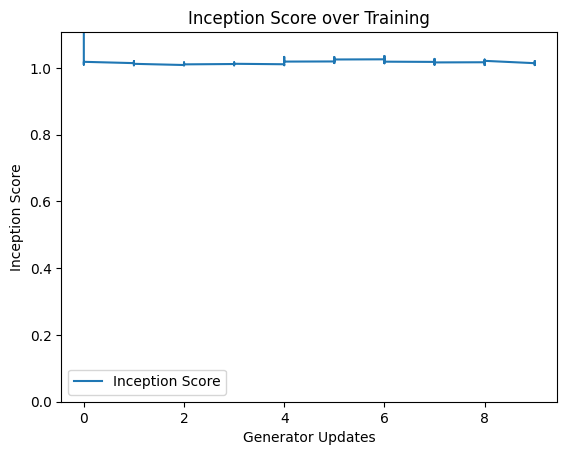

In [27]:
# Plot the Inception Score over updates
from matplotlib import pyplot as plt
plt.plot(updates, inception_scores_list, label="Inception Score")
plt.xlabel("Generator Updates")
plt.ylabel("Inception Score")
plt.title("Inception Score over Training")
plt.ylim(bottom=0)
plt.legend()
plt.show()

In [ ]:
print(inception_scores_list)

[0.9999998807907104, 0.9999998807907104, 1.0, 1.0, 1.0, 0.9999998807907104, 1.0, 1.0, 1.0, 1.0]
